In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("FF", "SI")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("FF", "SI")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6720488225393741
Log Loss: 0.6200689054362148


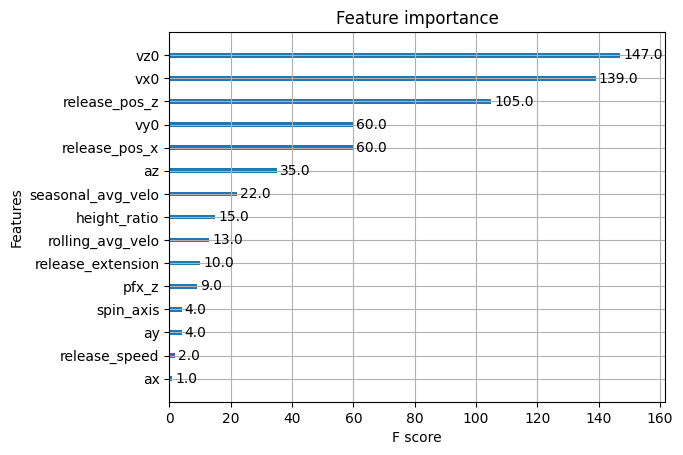

In [12]:
xgb.plot_importance(model)
plt.show()

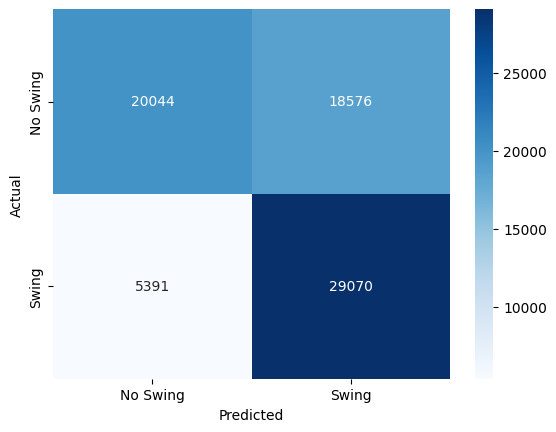

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 21:05:07,790] A new study created in memory with name: no-name-134790a0-62e2-4c3a-8a08-4c3cd31c16a6
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65559
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.61338
[3]	eval-logloss:0.59876
[4]	eval-logloss:0.59017
[5]	eval-logloss:0.58417
[6]	eval-logloss:0.57574
[7]	eval-logloss:0.56844
[8]	eval-logloss:0.56335
[9]	eval-logloss:0.56012
[10]	eval-logloss:0.55615
[11]	eval-logloss:0.55409
[12]	eval-logloss:0.55259
[13]	eval-logloss:0.55020
[14]	eval-logloss:0.54520
[15]	eval-logloss:0.54320
[16]	eval-logloss:0.54037
[17]	eval-logloss:0.53736
[18]	eval-logloss:0.53645
[19]	eval-logloss:0.53515
[20]	eval-logloss:0.53431
[21]	eval-logloss:0.53395
[22]	eval-logloss:0.53180
[23]	eval-logloss:0.53124
[24]	eval-logloss:0.53117
[25]	eval-logloss:0.53108
[26]	eval-logloss:0.53108
[27]	eval-logloss:0.53059
[28]	eval-logloss:0.52915
[29]	eval-logloss:0.52834
[30]	eval-logloss:0.52836
[31]	eval-logloss:0.52775
[32]	eval-logloss:0.52771
[33]	eval-logloss:0.52748
[34]	eval-logloss:0.52739
[35]	eval-logloss:0.52661
[36]	eval-logloss:0.52647
[37]	eval-logloss:0.52415
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:11,825] Trial 0 finished with value: 0.5164956815165286 and parameters: {'max_depth': 9, 'eta': 0.22869640964683424, 'subsample': 0.7602933468042632, 'colsample_bytree': 0.7154181921944704}. Best is trial 0 with value: 0.5164956815165286.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64888
[6]	eval-logloss:0.64345
[7]	eval-logloss:0.63814
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.62955
[10]	eval-logloss:0.62500
[11]	eval-logloss:0.62316
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61513
[14]	eval-logloss:0.61140
[15]	eval-logloss:0.60775
[16]	eval-logloss:0.60408
[17]	eval-logloss:0.59996
[18]	eval-logloss:0.59739
[19]	eval-logloss:0.59483
[20]	eval-logloss:0.59269
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58817
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58357
[25]	eval-logloss:0.58074
[26]	eval-logloss:0.58051
[27]	eval-logloss:0.57961
[28]	eval-logloss:0.57711
[29]	eval-logloss:0.57545
[30]	eval-logloss:0.57418
[31]	eval-logloss:0.57335
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57089
[34]	eval-logloss:0.56976
[35]	eval-logloss:0.56791
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56569
[38]	eval-logloss:0.56

[I 2023-11-16 21:05:16,120] Trial 1 finished with value: 0.5283798002827745 and parameters: {'max_depth': 9, 'eta': 0.05585391173167079, 'subsample': 0.7532029849930719, 'colsample_bytree': 0.7670725048742489}. Best is trial 0 with value: 0.5164956815165286.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66080
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.62534
[3]	eval-logloss:0.61368
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59451
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.58090
[9]	eval-logloss:0.57419
[10]	eval-logloss:0.56959
[11]	eval-logloss:0.56679
[12]	eval-logloss:0.56413
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55672
[16]	eval-logloss:0.55096
[17]	eval-logloss:0.54992
[18]	eval-logloss:0.54642
[19]	eval-logloss:0.54474
[20]	eval-logloss:0.54407
[21]	eval-logloss:0.54331
[22]	eval-logloss:0.54048
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53822
[25]	eval-logloss:0.53786
[26]	eval-logloss:0.53754
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53539
[29]	eval-logloss:0.53243
[30]	eval-logloss:0.53068
[31]	eval-logloss:0.53028
[32]	eval-logloss:0.52951
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52874
[35]	eval-logloss:0.52795
[36]	eval-logloss:0.52761
[37]	eval-logloss:0.52753
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:18,927] Trial 2 finished with value: 0.5140758407703546 and parameters: {'max_depth': 6, 'eta': 0.2922477603364915, 'subsample': 0.8329168345309457, 'colsample_bytree': 0.8350433698687063}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61888
[7]	eval-logloss:0.61103
[8]	eval-logloss:0.60572
[9]	eval-logloss:0.60056
[10]	eval-logloss:0.59521
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58648
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.57920
[15]	eval-logloss:0.57616
[16]	eval-logloss:0.57285
[17]	eval-logloss:0.57011
[18]	eval-logloss:0.56816
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56471
[21]	eval-logloss:0.56352
[22]	eval-logloss:0.56099
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55743
[26]	eval-logloss:0.55705
[27]	eval-logloss:0.55570
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.54896
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54727
[33]	eval-logloss:0.54635
[34]	eval-logloss:0.54554
[35]	eval-logloss:0.54476
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54284
[38]	eval-logloss:0.54

[I 2023-11-16 21:05:22,619] Trial 3 finished with value: 0.5165290974632192 and parameters: {'max_depth': 8, 'eta': 0.10676122417140001, 'subsample': 0.7714232750773715, 'colsample_bytree': 0.8745937989814612}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66479
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64732
[4]	eval-logloss:0.64065
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62431
[8]	eval-logloss:0.62006
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.61434
[11]	eval-logloss:0.61180
[12]	eval-logloss:0.60974
[13]	eval-logloss:0.60659
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60326
[16]	eval-logloss:0.60050
[17]	eval-logloss:0.59895
[18]	eval-logloss:0.59478
[19]	eval-logloss:0.59355
[20]	eval-logloss:0.59181
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58931
[26]	eval-logloss:0.58921
[27]	eval-logloss:0.58910
[28]	eval-logloss:0.58651
[29]	eval-logloss:0.58608
[30]	eval-logloss:0.58524
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58357
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58301
[35]	eval-logloss:0.58029
[36]	eval-logloss:0.57996
[37]	eval-logloss:0.57927
[38]	eval-logloss:0.57

[I 2023-11-16 21:05:25,045] Trial 4 finished with value: 0.5432838141523438 and parameters: {'max_depth': 4, 'eta': 0.19491682561714552, 'subsample': 0.7390131769774897, 'colsample_bytree': 0.6411159414387344}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66329
[3]	eval-logloss:0.65605
[4]	eval-logloss:0.65040
[5]	eval-logloss:0.64515
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.63584
[8]	eval-logloss:0.63322
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62665
[11]	eval-logloss:0.62356
[12]	eval-logloss:0.61937
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61566
[15]	eval-logloss:0.61316
[16]	eval-logloss:0.60836
[17]	eval-logloss:0.60633
[18]	eval-logloss:0.60442
[19]	eval-logloss:0.60290
[20]	eval-logloss:0.60138
[21]	eval-logloss:0.59966
[22]	eval-logloss:0.59832
[23]	eval-logloss:0.59701
[24]	eval-logloss:0.59588
[25]	eval-logloss:0.59488
[26]	eval-logloss:0.59389
[27]	eval-logloss:0.59261
[28]	eval-logloss:0.59170
[29]	eval-logloss:0.59097
[30]	eval-logloss:0.58971
[31]	eval-logloss:0.58639
[32]	eval-logloss:0.58538
[33]	eval-logloss:0.58377
[34]	eval-logloss:0.58304
[35]	eval-logloss:0.58160
[36]	eval-logloss:0.58079
[37]	eval-logloss:0.57826
[38]	eval-logloss:0.57

[I 2023-11-16 21:05:27,592] Trial 5 finished with value: 0.545868270711435 and parameters: {'max_depth': 4, 'eta': 0.1404803624174692, 'subsample': 0.6924764646818877, 'colsample_bytree': 0.9727703555237682}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63799
[4]	eval-logloss:0.63345
[5]	eval-logloss:0.62448
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61234
[8]	eval-logloss:0.60689
[9]	eval-logloss:0.60412
[10]	eval-logloss:0.60003
[11]	eval-logloss:0.59906
[12]	eval-logloss:0.59649
[13]	eval-logloss:0.59518
[14]	eval-logloss:0.59223
[15]	eval-logloss:0.58839
[16]	eval-logloss:0.58672
[17]	eval-logloss:0.58522
[18]	eval-logloss:0.58388
[19]	eval-logloss:0.58283
[20]	eval-logloss:0.58166
[21]	eval-logloss:0.58065
[22]	eval-logloss:0.57925
[23]	eval-logloss:0.57859
[24]	eval-logloss:0.57465
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.57317
[27]	eval-logloss:0.57160
[28]	eval-logloss:0.57104
[29]	eval-logloss:0.57021
[30]	eval-logloss:0.56919
[31]	eval-logloss:0.56900
[32]	eval-logloss:0.56829
[33]	eval-logloss:0.56783
[34]	eval-logloss:0.56711
[35]	eval-logloss:0.56647
[36]	eval-logloss:0.56623
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-16 21:05:30,088] Trial 6 finished with value: 0.5244714256831118 and parameters: {'max_depth': 4, 'eta': 0.267412160954109, 'subsample': 0.7631801483264472, 'colsample_bytree': 0.7988553691781404}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63281
[3]	eval-logloss:0.61994
[4]	eval-logloss:0.61175
[5]	eval-logloss:0.60515
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59026
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.58233
[10]	eval-logloss:0.57913
[11]	eval-logloss:0.57541
[12]	eval-logloss:0.57356
[13]	eval-logloss:0.56762
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56149
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.55028
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54808
[22]	eval-logloss:0.54671
[23]	eval-logloss:0.54595
[24]	eval-logloss:0.54234
[25]	eval-logloss:0.54163
[26]	eval-logloss:0.54148
[27]	eval-logloss:0.54075
[28]	eval-logloss:0.53817
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53562
[31]	eval-logloss:0.53454
[32]	eval-logloss:0.53356
[33]	eval-logloss:0.53298
[34]	eval-logloss:0.53197
[35]	eval-logloss:0.53131
[36]	eval-logloss:0.53086
[37]	eval-logloss:0.53059
[38]	eval-logloss:0.53

[I 2023-11-16 21:05:33,371] Trial 7 finished with value: 0.5147425029310552 and parameters: {'max_depth': 7, 'eta': 0.19605852501829568, 'subsample': 0.8982627893925019, 'colsample_bytree': 0.9089928030011842}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65665
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.61209
[3]	eval-logloss:0.59632
[4]	eval-logloss:0.58730
[5]	eval-logloss:0.57778
[6]	eval-logloss:0.57074
[7]	eval-logloss:0.56550
[8]	eval-logloss:0.56201
[9]	eval-logloss:0.55802
[10]	eval-logloss:0.55423
[11]	eval-logloss:0.54798
[12]	eval-logloss:0.54548
[13]	eval-logloss:0.54398
[14]	eval-logloss:0.54030
[15]	eval-logloss:0.53873
[16]	eval-logloss:0.53765
[17]	eval-logloss:0.53563
[18]	eval-logloss:0.53492
[19]	eval-logloss:0.53374
[20]	eval-logloss:0.53353
[21]	eval-logloss:0.53341
[22]	eval-logloss:0.53045
[23]	eval-logloss:0.53003
[24]	eval-logloss:0.52871
[25]	eval-logloss:0.52811
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52765
[28]	eval-logloss:0.52761
[29]	eval-logloss:0.52587
[30]	eval-logloss:0.52451
[31]	eval-logloss:0.52172
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.52102
[34]	eval-logloss:0.52073
[35]	eval-logloss:0.52033
[36]	eval-logloss:0.52043
[37]	eval-logloss:0.52037
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:37,281] Trial 8 finished with value: 0.5160860673120007 and parameters: {'max_depth': 9, 'eta': 0.2383393910725966, 'subsample': 0.8445594479549399, 'colsample_bytree': 0.9438044667050642}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66901
[5]	eval-logloss:0.66622
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66055
[8]	eval-logloss:0.65743
[9]	eval-logloss:0.65494
[10]	eval-logloss:0.65232
[11]	eval-logloss:0.65090
[12]	eval-logloss:0.64906
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64514
[15]	eval-logloss:0.64323
[16]	eval-logloss:0.64193
[17]	eval-logloss:0.64060
[18]	eval-logloss:0.63921
[19]	eval-logloss:0.63809
[20]	eval-logloss:0.63712
[21]	eval-logloss:0.63580
[22]	eval-logloss:0.63451
[23]	eval-logloss:0.63375
[24]	eval-logloss:0.63227
[25]	eval-logloss:0.63064
[26]	eval-logloss:0.63037
[27]	eval-logloss:0.62972
[28]	eval-logloss:0.62800
[29]	eval-logloss:0.62704
[30]	eval-logloss:0.62640
[31]	eval-logloss:0.62564
[32]	eval-logloss:0.62505
[33]	eval-logloss:0.62438
[34]	eval-logloss:0.62373
[35]	eval-logloss:0.62323
[36]	eval-logloss:0.62196
[37]	eval-logloss:0.62114
[38]	eval-logloss:0.62

[I 2023-11-16 21:05:39,510] Trial 9 finished with value: 0.5867531375143894 and parameters: {'max_depth': 3, 'eta': 0.08280800358905478, 'subsample': 0.7366582718322467, 'colsample_bytree': 0.768354856558739}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.64326
[2]	eval-logloss:0.62379
[3]	eval-logloss:0.61685
[4]	eval-logloss:0.60942
[5]	eval-logloss:0.60489
[6]	eval-logloss:0.59517
[7]	eval-logloss:0.59173
[8]	eval-logloss:0.58559
[9]	eval-logloss:0.58523
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57112
[14]	eval-logloss:0.56624
[15]	eval-logloss:0.56507
[16]	eval-logloss:0.56017
[17]	eval-logloss:0.55793
[18]	eval-logloss:0.55725
[19]	eval-logloss:0.55581
[20]	eval-logloss:0.55473
[21]	eval-logloss:0.55441
[22]	eval-logloss:0.55421
[23]	eval-logloss:0.55401
[24]	eval-logloss:0.55406
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.54893
[29]	eval-logloss:0.54813
[30]	eval-logloss:0.54791
[31]	eval-logloss:0.54732
[32]	eval-logloss:0.54719
[33]	eval-logloss:0.54717
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54516
[36]	eval-logloss:0.54508
[37]	eval-logloss:0.54498
[38]	eval-logloss:0.54

[I 2023-11-16 21:05:42,323] Trial 10 finished with value: 0.5240700163783185 and parameters: {'max_depth': 6, 'eta': 0.29455994423993714, 'subsample': 0.6058663214432529, 'colsample_bytree': 0.5089007832619188}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67086
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61831
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60464
[7]	eval-logloss:0.59591
[8]	eval-logloss:0.59090
[9]	eval-logloss:0.58633
[10]	eval-logloss:0.58272
[11]	eval-logloss:0.57846
[12]	eval-logloss:0.57562
[13]	eval-logloss:0.57234
[14]	eval-logloss:0.56947
[15]	eval-logloss:0.56800
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56060
[18]	eval-logloss:0.55932
[19]	eval-logloss:0.55767
[20]	eval-logloss:0.55681
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55301
[23]	eval-logloss:0.55192
[24]	eval-logloss:0.54985
[25]	eval-logloss:0.54915
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54786
[28]	eval-logloss:0.54625
[29]	eval-logloss:0.54347
[30]	eval-logloss:0.54154
[31]	eval-logloss:0.54106
[32]	eval-logloss:0.54046
[33]	eval-logloss:0.53952
[34]	eval-logloss:0.53826
[35]	eval-logloss:0.53715
[36]	eval-logloss:0.53679
[37]	eval-logloss:0.53640
[38]	eval-logloss:0.53

[I 2023-11-16 21:05:45,509] Trial 11 finished with value: 0.5159793861562796 and parameters: {'max_depth': 7, 'eta': 0.17126006349349035, 'subsample': 0.8929874050895491, 'colsample_bytree': 0.8611911883843282}. Best is trial 2 with value: 0.5140758407703546.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66173
[1]	eval-logloss:0.64329
[2]	eval-logloss:0.62393
[3]	eval-logloss:0.61303
[4]	eval-logloss:0.60415
[5]	eval-logloss:0.59937
[6]	eval-logloss:0.59654
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.57636
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56952
[12]	eval-logloss:0.56742
[13]	eval-logloss:0.56160
[14]	eval-logloss:0.55954
[15]	eval-logloss:0.55544
[16]	eval-logloss:0.54949
[17]	eval-logloss:0.54848
[18]	eval-logloss:0.54613
[19]	eval-logloss:0.54496
[20]	eval-logloss:0.54354
[21]	eval-logloss:0.54274
[22]	eval-logloss:0.54205
[23]	eval-logloss:0.54172
[24]	eval-logloss:0.53997
[25]	eval-logloss:0.53966
[26]	eval-logloss:0.53944
[27]	eval-logloss:0.53917
[28]	eval-logloss:0.53505
[29]	eval-logloss:0.53430
[30]	eval-logloss:0.53376
[31]	eval-logloss:0.53306
[32]	eval-logloss:0.53055
[33]	eval-logloss:0.52990
[34]	eval-logloss:0.52951
[35]	eval-logloss:0.52854
[36]	eval-logloss:0.52825
[37]	eval-logloss:0.52800
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:48,327] Trial 12 finished with value: 0.5121807786600429 and parameters: {'max_depth': 6, 'eta': 0.29191556836642957, 'subsample': 0.8998743361975071, 'colsample_bytree': 0.8893961885618352}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.64195
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.60965
[4]	eval-logloss:0.60236
[5]	eval-logloss:0.59495
[6]	eval-logloss:0.58883
[7]	eval-logloss:0.58115
[8]	eval-logloss:0.57802
[9]	eval-logloss:0.57344
[10]	eval-logloss:0.57053
[11]	eval-logloss:0.56692
[12]	eval-logloss:0.56373
[13]	eval-logloss:0.56234
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55864
[16]	eval-logloss:0.55671
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54773
[20]	eval-logloss:0.54443
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54224
[23]	eval-logloss:0.54021
[24]	eval-logloss:0.53928
[25]	eval-logloss:0.53883
[26]	eval-logloss:0.53855
[27]	eval-logloss:0.53815
[28]	eval-logloss:0.53749
[29]	eval-logloss:0.53731
[30]	eval-logloss:0.53539
[31]	eval-logloss:0.53517
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53199
[34]	eval-logloss:0.53159
[35]	eval-logloss:0.53052
[36]	eval-logloss:0.53025
[37]	eval-logloss:0.52997
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:51,053] Trial 13 finished with value: 0.5128714273080234 and parameters: {'max_depth': 6, 'eta': 0.2980084813582325, 'subsample': 0.8499147582775556, 'colsample_bytree': 0.9816650015204407}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.62823
[4]	eval-logloss:0.62118
[5]	eval-logloss:0.61375
[6]	eval-logloss:0.61096
[7]	eval-logloss:0.60522
[8]	eval-logloss:0.60072
[9]	eval-logloss:0.59554
[10]	eval-logloss:0.59101
[11]	eval-logloss:0.58585
[12]	eval-logloss:0.58342
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57537
[15]	eval-logloss:0.57282
[16]	eval-logloss:0.57135
[17]	eval-logloss:0.56883
[18]	eval-logloss:0.56684
[19]	eval-logloss:0.56477
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56111
[22]	eval-logloss:0.56034
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55857
[25]	eval-logloss:0.55823
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55723
[28]	eval-logloss:0.55636
[29]	eval-logloss:0.55514
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.55258
[32]	eval-logloss:0.55214
[33]	eval-logloss:0.55102
[34]	eval-logloss:0.55025
[35]	eval-logloss:0.54997
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54847
[38]	eval-logloss:0.54

[I 2023-11-16 21:05:53,702] Trial 14 finished with value: 0.5186374500846493 and parameters: {'max_depth': 5, 'eta': 0.2604719120614764, 'subsample': 0.8589680047374691, 'colsample_bytree': 0.9988208069954241}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66292
[1]	eval-logloss:0.64533
[2]	eval-logloss:0.62480
[3]	eval-logloss:0.61174
[4]	eval-logloss:0.60258
[5]	eval-logloss:0.59580
[6]	eval-logloss:0.58715
[7]	eval-logloss:0.58207
[8]	eval-logloss:0.57846
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56970
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.56111
[13]	eval-logloss:0.55721
[14]	eval-logloss:0.55542
[15]	eval-logloss:0.55342
[16]	eval-logloss:0.54888
[17]	eval-logloss:0.54737
[18]	eval-logloss:0.54574
[19]	eval-logloss:0.54466
[20]	eval-logloss:0.54379
[21]	eval-logloss:0.54291
[22]	eval-logloss:0.54202
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53968
[25]	eval-logloss:0.53932
[26]	eval-logloss:0.53916
[27]	eval-logloss:0.53846
[28]	eval-logloss:0.53692
[29]	eval-logloss:0.53579
[30]	eval-logloss:0.53352
[31]	eval-logloss:0.53320
[32]	eval-logloss:0.53301
[33]	eval-logloss:0.53229
[34]	eval-logloss:0.53178
[35]	eval-logloss:0.53139
[36]	eval-logloss:0.53114
[37]	eval-logloss:0.52987
[38]	eval-logloss:0.52

[I 2023-11-16 21:05:56,839] Trial 15 finished with value: 0.5129441744564178 and parameters: {'max_depth': 7, 'eta': 0.2302011747065333, 'subsample': 0.8147647456091308, 'colsample_bytree': 0.9205472420020064}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64680
[2]	eval-logloss:0.63454
[3]	eval-logloss:0.62188
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.60466
[7]	eval-logloss:0.59874
[8]	eval-logloss:0.59553
[9]	eval-logloss:0.58991
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57744
[13]	eval-logloss:0.57482
[14]	eval-logloss:0.57177
[15]	eval-logloss:0.57028
[16]	eval-logloss:0.56729
[17]	eval-logloss:0.56631
[18]	eval-logloss:0.56561
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56220
[22]	eval-logloss:0.55833
[23]	eval-logloss:0.55610
[24]	eval-logloss:0.55198
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.55010
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54601
[30]	eval-logloss:0.54533
[31]	eval-logloss:0.54266
[32]	eval-logloss:0.54041
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53952
[35]	eval-logloss:0.53906
[36]	eval-logloss:0.53887
[37]	eval-logloss:0.53872
[38]	eval-logloss:0.53

[I 2023-11-16 21:05:59,485] Trial 16 finished with value: 0.5169557593674889 and parameters: {'max_depth': 5, 'eta': 0.29772828157177683, 'subsample': 0.8734830308972292, 'colsample_bytree': 0.9843006040826273}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67941
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67188
[10]	eval-logloss:0.66999
[11]	eval-logloss:0.66819
[12]	eval-logloss:0.66642
[13]	eval-logloss:0.66480
[14]	eval-logloss:0.66318
[15]	eval-logloss:0.66161
[16]	eval-logloss:0.65998
[17]	eval-logloss:0.65827
[18]	eval-logloss:0.65688
[19]	eval-logloss:0.65557
[20]	eval-logloss:0.65418
[21]	eval-logloss:0.65288
[22]	eval-logloss:0.65160
[23]	eval-logloss:0.65045
[24]	eval-logloss:0.64921
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64684
[28]	eval-logloss:0.64552
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64301
[31]	eval-logloss:0.64177
[32]	eval-logloss:0.64084
[33]	eval-logloss:0.63997
[34]	eval-logloss:0.63914
[35]	eval-logloss:0.63795
[36]	eval-logloss:0.63702
[37]	eval-logloss:0.63611
[38]	eval-logloss:0.63

[I 2023-11-16 21:06:02,348] Trial 17 finished with value: 0.5990317495010391 and parameters: {'max_depth': 5, 'eta': 0.02283382917798063, 'subsample': 0.820212407138841, 'colsample_bytree': 0.9152486064428265}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66370
[1]	eval-logloss:0.64592
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.61438
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.59828
[6]	eval-logloss:0.59267
[7]	eval-logloss:0.58762
[8]	eval-logloss:0.58321
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57592
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56817
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56452
[15]	eval-logloss:0.56256
[16]	eval-logloss:0.55954
[17]	eval-logloss:0.55734
[18]	eval-logloss:0.55345
[19]	eval-logloss:0.55225
[20]	eval-logloss:0.55007
[21]	eval-logloss:0.54778
[22]	eval-logloss:0.54585
[23]	eval-logloss:0.54534
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54333
[26]	eval-logloss:0.54303
[27]	eval-logloss:0.54258
[28]	eval-logloss:0.54231
[29]	eval-logloss:0.53849
[30]	eval-logloss:0.53463
[31]	eval-logloss:0.53402
[32]	eval-logloss:0.53364
[33]	eval-logloss:0.53308
[34]	eval-logloss:0.53218
[35]	eval-logloss:0.53177
[36]	eval-logloss:0.53161
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.53

[I 2023-11-16 21:06:05,325] Trial 18 finished with value: 0.5134373272075115 and parameters: {'max_depth': 6, 'eta': 0.26787758491186303, 'subsample': 0.8813474049959148, 'colsample_bytree': 0.9510013637826935}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66274
[1]	eval-logloss:0.64458
[2]	eval-logloss:0.62319
[3]	eval-logloss:0.61076
[4]	eval-logloss:0.60177
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.58480
[7]	eval-logloss:0.57515
[8]	eval-logloss:0.57079
[9]	eval-logloss:0.56690
[10]	eval-logloss:0.56441
[11]	eval-logloss:0.55831
[12]	eval-logloss:0.55560
[13]	eval-logloss:0.55287
[14]	eval-logloss:0.55052
[15]	eval-logloss:0.54886
[16]	eval-logloss:0.54555
[17]	eval-logloss:0.54493
[18]	eval-logloss:0.54061
[19]	eval-logloss:0.53952
[20]	eval-logloss:0.53852
[21]	eval-logloss:0.53793
[22]	eval-logloss:0.53504
[23]	eval-logloss:0.53477
[24]	eval-logloss:0.53347
[25]	eval-logloss:0.53275
[26]	eval-logloss:0.53261
[27]	eval-logloss:0.53223
[28]	eval-logloss:0.53111
[29]	eval-logloss:0.52876
[30]	eval-logloss:0.52787
[31]	eval-logloss:0.52767
[32]	eval-logloss:0.52760
[33]	eval-logloss:0.52718
[34]	eval-logloss:0.52683
[35]	eval-logloss:0.52652
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52584
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:08,923] Trial 19 finished with value: 0.5129531590985791 and parameters: {'max_depth': 8, 'eta': 0.21310421254618953, 'subsample': 0.8993443035312402, 'colsample_bytree': 0.8824165487516468}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64793
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.61261
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59938
[7]	eval-logloss:0.58867
[8]	eval-logloss:0.58376
[9]	eval-logloss:0.58108
[10]	eval-logloss:0.57790
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.57050
[13]	eval-logloss:0.56852
[14]	eval-logloss:0.56210
[15]	eval-logloss:0.56040
[16]	eval-logloss:0.55837
[17]	eval-logloss:0.55730
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55457
[20]	eval-logloss:0.55307
[21]	eval-logloss:0.55222
[22]	eval-logloss:0.55180
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.54708
[25]	eval-logloss:0.54469
[26]	eval-logloss:0.54440
[27]	eval-logloss:0.54358
[28]	eval-logloss:0.54318
[29]	eval-logloss:0.54063
[30]	eval-logloss:0.53798
[31]	eval-logloss:0.53760
[32]	eval-logloss:0.53734
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53548
[35]	eval-logloss:0.53525
[36]	eval-logloss:0.53504
[37]	eval-logloss:0.53488
[38]	eval-logloss:0.53

[I 2023-11-16 21:06:11,629] Trial 20 finished with value: 0.5180775280645616 and parameters: {'max_depth': 6, 'eta': 0.253963619466392, 'subsample': 0.8596958440623363, 'colsample_bytree': 0.8333422029388183}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66259
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.62497
[3]	eval-logloss:0.61192
[4]	eval-logloss:0.60416
[5]	eval-logloss:0.59669
[6]	eval-logloss:0.59057
[7]	eval-logloss:0.58568
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57391
[10]	eval-logloss:0.56960
[11]	eval-logloss:0.56734
[12]	eval-logloss:0.56522
[13]	eval-logloss:0.56055
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55413
[17]	eval-logloss:0.54934
[18]	eval-logloss:0.54625
[19]	eval-logloss:0.54503
[20]	eval-logloss:0.54399
[21]	eval-logloss:0.54332
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.54189
[24]	eval-logloss:0.53881
[25]	eval-logloss:0.53816
[26]	eval-logloss:0.53804
[27]	eval-logloss:0.53753
[28]	eval-logloss:0.53654
[29]	eval-logloss:0.53533
[30]	eval-logloss:0.53429
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53283
[33]	eval-logloss:0.53020
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52819
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:14,865] Trial 21 finished with value: 0.5130388538900597 and parameters: {'max_depth': 7, 'eta': 0.23254408683444994, 'subsample': 0.8169156655336379, 'colsample_bytree': 0.929559983410949}. Best is trial 12 with value: 0.5121807786600429.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.64115
[2]	eval-logloss:0.62018
[3]	eval-logloss:0.60510
[4]	eval-logloss:0.59695
[5]	eval-logloss:0.58832
[6]	eval-logloss:0.58027
[7]	eval-logloss:0.57670
[8]	eval-logloss:0.57230
[9]	eval-logloss:0.56624
[10]	eval-logloss:0.56332
[11]	eval-logloss:0.55946
[12]	eval-logloss:0.55745
[13]	eval-logloss:0.55540
[14]	eval-logloss:0.55431
[15]	eval-logloss:0.54905
[16]	eval-logloss:0.54774
[17]	eval-logloss:0.54387
[18]	eval-logloss:0.54045
[19]	eval-logloss:0.53966
[20]	eval-logloss:0.53781
[21]	eval-logloss:0.53687
[22]	eval-logloss:0.53409
[23]	eval-logloss:0.53321
[24]	eval-logloss:0.53163
[25]	eval-logloss:0.53091
[26]	eval-logloss:0.53018
[27]	eval-logloss:0.52970
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52708
[30]	eval-logloss:0.52607
[31]	eval-logloss:0.52454
[32]	eval-logloss:0.52444
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52368
[35]	eval-logloss:0.52352
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52309
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:18,091] Trial 22 finished with value: 0.5120882951674702 and parameters: {'max_depth': 7, 'eta': 0.2756932016424436, 'subsample': 0.8098691246088969, 'colsample_bytree': 0.9906071075790491}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65291
[1]	eval-logloss:0.63111
[2]	eval-logloss:0.60791
[3]	eval-logloss:0.59328
[4]	eval-logloss:0.58469
[5]	eval-logloss:0.57811
[6]	eval-logloss:0.57072
[7]	eval-logloss:0.56573
[8]	eval-logloss:0.56272
[9]	eval-logloss:0.55561
[10]	eval-logloss:0.54777
[11]	eval-logloss:0.54602
[12]	eval-logloss:0.53985
[13]	eval-logloss:0.53811
[14]	eval-logloss:0.53638
[15]	eval-logloss:0.53496
[16]	eval-logloss:0.53378
[17]	eval-logloss:0.53341
[18]	eval-logloss:0.53255
[19]	eval-logloss:0.52915
[20]	eval-logloss:0.52837
[21]	eval-logloss:0.52789
[22]	eval-logloss:0.52769
[23]	eval-logloss:0.52671
[24]	eval-logloss:0.52655
[25]	eval-logloss:0.52551
[26]	eval-logloss:0.52392
[27]	eval-logloss:0.52362
[28]	eval-logloss:0.52300
[29]	eval-logloss:0.52299
[30]	eval-logloss:0.52268
[31]	eval-logloss:0.52173
[32]	eval-logloss:0.51984
[33]	eval-logloss:0.51967
[34]	eval-logloss:0.51927
[35]	eval-logloss:0.51905
[36]	eval-logloss:0.51910
[37]	eval-logloss:0.51799
[38]	eval-logloss:0.51

[I 2023-11-16 21:06:21,678] Trial 23 finished with value: 0.5140746302901217 and parameters: {'max_depth': 8, 'eta': 0.29927428744707746, 'subsample': 0.8561790255588783, 'colsample_bytree': 0.999691608024862}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66285
[1]	eval-logloss:0.64477
[2]	eval-logloss:0.62692
[3]	eval-logloss:0.61416
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.59051
[7]	eval-logloss:0.58565
[8]	eval-logloss:0.58213
[9]	eval-logloss:0.57504
[10]	eval-logloss:0.57150
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.56531
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55844
[15]	eval-logloss:0.55613
[16]	eval-logloss:0.55490
[17]	eval-logloss:0.55269
[18]	eval-logloss:0.54982
[19]	eval-logloss:0.54875
[20]	eval-logloss:0.54702
[21]	eval-logloss:0.54593
[22]	eval-logloss:0.54485
[23]	eval-logloss:0.54358
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.54043
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53720
[28]	eval-logloss:0.53605
[29]	eval-logloss:0.53575
[30]	eval-logloss:0.53387
[31]	eval-logloss:0.53237
[32]	eval-logloss:0.53112
[33]	eval-logloss:0.53019
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52878
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:24,617] Trial 24 finished with value: 0.5130421502315445 and parameters: {'max_depth': 6, 'eta': 0.27402032505703156, 'subsample': 0.7917175306469192, 'colsample_bytree': 0.958505270833486}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66610
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.62530
[4]	eval-logloss:0.61685
[5]	eval-logloss:0.60992
[6]	eval-logloss:0.60497
[7]	eval-logloss:0.59900
[8]	eval-logloss:0.59565
[9]	eval-logloss:0.59184
[10]	eval-logloss:0.58786
[11]	eval-logloss:0.58517
[12]	eval-logloss:0.58225
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57685
[15]	eval-logloss:0.57461
[16]	eval-logloss:0.57354
[17]	eval-logloss:0.56715
[18]	eval-logloss:0.56398
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56206
[21]	eval-logloss:0.56043
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55883
[24]	eval-logloss:0.55704
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55131
[27]	eval-logloss:0.55081
[28]	eval-logloss:0.55016
[29]	eval-logloss:0.54760
[30]	eval-logloss:0.54698
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54495
[33]	eval-logloss:0.54469
[34]	eval-logloss:0.54448
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54380
[37]	eval-logloss:0.54354
[38]	eval-logloss:0.54

[I 2023-11-16 21:06:27,333] Trial 25 finished with value: 0.5192335711934883 and parameters: {'max_depth': 5, 'eta': 0.27597479009134823, 'subsample': 0.872902138484412, 'colsample_bytree': 0.9577480270944682}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66076
[1]	eval-logloss:0.64327
[2]	eval-logloss:0.62176
[3]	eval-logloss:0.60871
[4]	eval-logloss:0.60075
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.58765
[7]	eval-logloss:0.58165
[8]	eval-logloss:0.57696
[9]	eval-logloss:0.56865
[10]	eval-logloss:0.56494
[11]	eval-logloss:0.56272
[12]	eval-logloss:0.56034
[13]	eval-logloss:0.55713
[14]	eval-logloss:0.55539
[15]	eval-logloss:0.55347
[16]	eval-logloss:0.55287
[17]	eval-logloss:0.55157
[18]	eval-logloss:0.54478
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.54269
[21]	eval-logloss:0.54199
[22]	eval-logloss:0.54031
[23]	eval-logloss:0.53998
[24]	eval-logloss:0.53810
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53744
[27]	eval-logloss:0.53721
[28]	eval-logloss:0.53646
[29]	eval-logloss:0.53391
[30]	eval-logloss:0.53113
[31]	eval-logloss:0.52903
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52686
[36]	eval-logloss:0.52682
[37]	eval-logloss:0.52587
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:30,536] Trial 26 finished with value: 0.5125962923077528 and parameters: {'max_depth': 7, 'eta': 0.25071757684589596, 'subsample': 0.8336669623199301, 'colsample_bytree': 0.8960597543279171}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65871
[1]	eval-logloss:0.63933
[2]	eval-logloss:0.61610
[3]	eval-logloss:0.60120
[4]	eval-logloss:0.59228
[5]	eval-logloss:0.58378
[6]	eval-logloss:0.57789
[7]	eval-logloss:0.57392
[8]	eval-logloss:0.56965
[9]	eval-logloss:0.56074
[10]	eval-logloss:0.55861
[11]	eval-logloss:0.55423
[12]	eval-logloss:0.55022
[13]	eval-logloss:0.54912
[14]	eval-logloss:0.54644
[15]	eval-logloss:0.54440
[16]	eval-logloss:0.54103
[17]	eval-logloss:0.53737
[18]	eval-logloss:0.53420
[19]	eval-logloss:0.53295
[20]	eval-logloss:0.53239
[21]	eval-logloss:0.53189
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52992
[24]	eval-logloss:0.52972
[25]	eval-logloss:0.52918
[26]	eval-logloss:0.52900
[27]	eval-logloss:0.52829
[28]	eval-logloss:0.52780
[29]	eval-logloss:0.52545
[30]	eval-logloss:0.52437
[31]	eval-logloss:0.52416
[32]	eval-logloss:0.52325
[33]	eval-logloss:0.52282
[34]	eval-logloss:0.52207
[35]	eval-logloss:0.52181
[36]	eval-logloss:0.52161
[37]	eval-logloss:0.52129
[38]	eval-logloss:0.51

[I 2023-11-16 21:06:34,104] Trial 27 finished with value: 0.5142273273416309 and parameters: {'max_depth': 8, 'eta': 0.24924519913050786, 'subsample': 0.8278094013271828, 'colsample_bytree': 0.8949701464156908}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64387
[2]	eval-logloss:0.62243
[3]	eval-logloss:0.60961
[4]	eval-logloss:0.60105
[5]	eval-logloss:0.59412
[6]	eval-logloss:0.58765
[7]	eval-logloss:0.58058
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.57154
[10]	eval-logloss:0.56541
[11]	eval-logloss:0.56227
[12]	eval-logloss:0.55931
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55525
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.55180
[17]	eval-logloss:0.55087
[18]	eval-logloss:0.54653
[19]	eval-logloss:0.54535
[20]	eval-logloss:0.54440
[21]	eval-logloss:0.54383
[22]	eval-logloss:0.54231
[23]	eval-logloss:0.54182
[24]	eval-logloss:0.53779
[25]	eval-logloss:0.53741
[26]	eval-logloss:0.53731
[27]	eval-logloss:0.53663
[28]	eval-logloss:0.53632
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53318
[32]	eval-logloss:0.53307
[33]	eval-logloss:0.53291
[34]	eval-logloss:0.53221
[35]	eval-logloss:0.53193
[36]	eval-logloss:0.53196
[37]	eval-logloss:0.53158
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:37,437] Trial 28 finished with value: 0.5146258908167429 and parameters: {'max_depth': 7, 'eta': 0.25003384717853383, 'subsample': 0.8699161682200983, 'colsample_bytree': 0.8488068000846322}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61643
[4]	eval-logloss:0.60716
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58926
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57255
[11]	eval-logloss:0.56976
[12]	eval-logloss:0.56585
[13]	eval-logloss:0.56244
[14]	eval-logloss:0.55930
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.54946
[19]	eval-logloss:0.54796
[20]	eval-logloss:0.54661
[21]	eval-logloss:0.54585
[22]	eval-logloss:0.54389
[23]	eval-logloss:0.54319
[24]	eval-logloss:0.54166
[25]	eval-logloss:0.54114
[26]	eval-logloss:0.54092
[27]	eval-logloss:0.54010
[28]	eval-logloss:0.53976
[29]	eval-logloss:0.53825
[30]	eval-logloss:0.53563
[31]	eval-logloss:0.53390
[32]	eval-logloss:0.53364
[33]	eval-logloss:0.53253
[34]	eval-logloss:0.53186
[35]	eval-logloss:0.53146
[36]	eval-logloss:0.53109
[37]	eval-logloss:0.52945
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:40,625] Trial 29 finished with value: 0.5141766973208587 and parameters: {'max_depth': 7, 'eta': 0.21815246564128118, 'subsample': 0.8028252717553466, 'colsample_bytree': 0.9078431834524804}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65529
[1]	eval-logloss:0.63581
[2]	eval-logloss:0.61084
[3]	eval-logloss:0.59531
[4]	eval-logloss:0.58769
[5]	eval-logloss:0.57834
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.56334
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.55419
[10]	eval-logloss:0.55025
[11]	eval-logloss:0.54829
[12]	eval-logloss:0.54572
[13]	eval-logloss:0.54401
[14]	eval-logloss:0.54271
[15]	eval-logloss:0.53978
[16]	eval-logloss:0.53897
[17]	eval-logloss:0.53684
[18]	eval-logloss:0.53444
[19]	eval-logloss:0.53246
[20]	eval-logloss:0.53171
[21]	eval-logloss:0.53141
[22]	eval-logloss:0.53114
[23]	eval-logloss:0.53078
[24]	eval-logloss:0.52782
[25]	eval-logloss:0.52750
[26]	eval-logloss:0.52761
[27]	eval-logloss:0.52715
[28]	eval-logloss:0.52704
[29]	eval-logloss:0.52529
[30]	eval-logloss:0.52375
[31]	eval-logloss:0.52361
[32]	eval-logloss:0.52362
[33]	eval-logloss:0.52290
[34]	eval-logloss:0.52243
[35]	eval-logloss:0.52155
[36]	eval-logloss:0.52144
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:44,140] Trial 30 finished with value: 0.5146791453291526 and parameters: {'max_depth': 8, 'eta': 0.27659820216721304, 'subsample': 0.8437793359855191, 'colsample_bytree': 0.8757487324900259}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66225
[1]	eval-logloss:0.64416
[2]	eval-logloss:0.62420
[3]	eval-logloss:0.61213
[4]	eval-logloss:0.60268
[5]	eval-logloss:0.59742
[6]	eval-logloss:0.59240
[7]	eval-logloss:0.58383
[8]	eval-logloss:0.58047
[9]	eval-logloss:0.57696
[10]	eval-logloss:0.57292
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56703
[13]	eval-logloss:0.56018
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55684
[16]	eval-logloss:0.55602
[17]	eval-logloss:0.55390
[18]	eval-logloss:0.55254
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.54995
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54589
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54192
[25]	eval-logloss:0.54132
[26]	eval-logloss:0.54032
[27]	eval-logloss:0.53981
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53854
[30]	eval-logloss:0.53574
[31]	eval-logloss:0.53452
[32]	eval-logloss:0.53407
[33]	eval-logloss:0.53350
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53202
[36]	eval-logloss:0.53175
[37]	eval-logloss:0.53103
[38]	eval-logloss:0.53

[I 2023-11-16 21:06:47,104] Trial 31 finished with value: 0.5138921914383021 and parameters: {'max_depth': 6, 'eta': 0.28127152531083754, 'subsample': 0.8402648198838276, 'colsample_bytree': 0.9657066346510067}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66169
[1]	eval-logloss:0.64356
[2]	eval-logloss:0.62290
[3]	eval-logloss:0.60967
[4]	eval-logloss:0.60187
[5]	eval-logloss:0.59135
[6]	eval-logloss:0.58534
[7]	eval-logloss:0.57893
[8]	eval-logloss:0.57505
[9]	eval-logloss:0.56773
[10]	eval-logloss:0.56408
[11]	eval-logloss:0.56175
[12]	eval-logloss:0.56002
[13]	eval-logloss:0.55362
[14]	eval-logloss:0.55128
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54738
[17]	eval-logloss:0.54318
[18]	eval-logloss:0.54088
[19]	eval-logloss:0.53971
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53896
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53803
[24]	eval-logloss:0.53584
[25]	eval-logloss:0.53529
[26]	eval-logloss:0.53515
[27]	eval-logloss:0.53411
[28]	eval-logloss:0.53376
[29]	eval-logloss:0.53176
[30]	eval-logloss:0.53154
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.53053
[33]	eval-logloss:0.52926
[34]	eval-logloss:0.52878
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52792
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:50,451] Trial 32 finished with value: 0.5121658775840326 and parameters: {'max_depth': 7, 'eta': 0.2524259400991285, 'subsample': 0.8508074542233125, 'colsample_bytree': 0.9352622099967631}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65500
[1]	eval-logloss:0.63454
[2]	eval-logloss:0.60992
[3]	eval-logloss:0.59460
[4]	eval-logloss:0.58581
[5]	eval-logloss:0.57732
[6]	eval-logloss:0.56912
[7]	eval-logloss:0.56179
[8]	eval-logloss:0.55860
[9]	eval-logloss:0.55543
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54867
[12]	eval-logloss:0.54753
[13]	eval-logloss:0.54142
[14]	eval-logloss:0.53886
[15]	eval-logloss:0.53771
[16]	eval-logloss:0.53509
[17]	eval-logloss:0.53329
[18]	eval-logloss:0.53290
[19]	eval-logloss:0.53238
[20]	eval-logloss:0.53158
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.52979
[23]	eval-logloss:0.52937
[24]	eval-logloss:0.52891
[25]	eval-logloss:0.52698
[26]	eval-logloss:0.52691
[27]	eval-logloss:0.52647
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52502
[30]	eval-logloss:0.52398
[31]	eval-logloss:0.52264
[32]	eval-logloss:0.52175
[33]	eval-logloss:0.52175
[34]	eval-logloss:0.52157
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.52079
[37]	eval-logloss:0.52067
[38]	eval-logloss:0.51

[I 2023-11-16 21:06:54,498] Trial 33 finished with value: 0.5158077875712664 and parameters: {'max_depth': 9, 'eta': 0.24846520347859416, 'subsample': 0.8745577129719373, 'colsample_bytree': 0.9368119875514977}. Best is trial 22 with value: 0.5120882951674702.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66023
[1]	eval-logloss:0.64286
[2]	eval-logloss:0.62162
[3]	eval-logloss:0.60809
[4]	eval-logloss:0.60053
[5]	eval-logloss:0.59355
[6]	eval-logloss:0.58908
[7]	eval-logloss:0.58029
[8]	eval-logloss:0.57586
[9]	eval-logloss:0.57145
[10]	eval-logloss:0.56667
[11]	eval-logloss:0.56438
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.55804
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.55115
[16]	eval-logloss:0.55042
[17]	eval-logloss:0.54773
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54485
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54336
[22]	eval-logloss:0.54022
[23]	eval-logloss:0.53970
[24]	eval-logloss:0.53766
[25]	eval-logloss:0.53712
[26]	eval-logloss:0.53714
[27]	eval-logloss:0.53679
[28]	eval-logloss:0.53621
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53228
[31]	eval-logloss:0.53196
[32]	eval-logloss:0.53183
[33]	eval-logloss:0.52996
[34]	eval-logloss:0.52942
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52654
[38]	eval-logloss:0.52

[I 2023-11-16 21:06:57,656] Trial 34 finished with value: 0.5120254204841344 and parameters: {'max_depth': 7, 'eta': 0.25940973770990133, 'subsample': 0.8342113509572733, 'colsample_bytree': 0.8253814433586281}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65441
[1]	eval-logloss:0.63387
[2]	eval-logloss:0.61026
[3]	eval-logloss:0.59460
[4]	eval-logloss:0.58685
[5]	eval-logloss:0.57761
[6]	eval-logloss:0.57278
[7]	eval-logloss:0.56453
[8]	eval-logloss:0.56042
[9]	eval-logloss:0.55684
[10]	eval-logloss:0.55401
[11]	eval-logloss:0.55135
[12]	eval-logloss:0.55003
[13]	eval-logloss:0.54910
[14]	eval-logloss:0.54828
[15]	eval-logloss:0.54228
[16]	eval-logloss:0.54048
[17]	eval-logloss:0.53876
[18]	eval-logloss:0.53501
[19]	eval-logloss:0.53419
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53328
[22]	eval-logloss:0.53247
[23]	eval-logloss:0.53229
[24]	eval-logloss:0.53010
[25]	eval-logloss:0.52967
[26]	eval-logloss:0.52961
[27]	eval-logloss:0.52925
[28]	eval-logloss:0.52735
[29]	eval-logloss:0.52629
[30]	eval-logloss:0.52497
[31]	eval-logloss:0.52463
[32]	eval-logloss:0.52449
[33]	eval-logloss:0.52303
[34]	eval-logloss:0.52280
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52217
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:01,277] Trial 35 finished with value: 0.5142005314427309 and parameters: {'max_depth': 8, 'eta': 0.27613762517011387, 'subsample': 0.8854053469865887, 'colsample_bytree': 0.8256734473963353}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64807
[2]	eval-logloss:0.62980
[3]	eval-logloss:0.61600
[4]	eval-logloss:0.60740
[5]	eval-logloss:0.59990
[6]	eval-logloss:0.59314
[7]	eval-logloss:0.58453
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57616
[10]	eval-logloss:0.57215
[11]	eval-logloss:0.56604
[12]	eval-logloss:0.56372
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55907
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.55250
[18]	eval-logloss:0.54921
[19]	eval-logloss:0.54750
[20]	eval-logloss:0.54616
[21]	eval-logloss:0.54540
[22]	eval-logloss:0.54416
[23]	eval-logloss:0.54360
[24]	eval-logloss:0.54099
[25]	eval-logloss:0.54027
[26]	eval-logloss:0.54015
[27]	eval-logloss:0.53936
[28]	eval-logloss:0.53727
[29]	eval-logloss:0.53453
[30]	eval-logloss:0.53346
[31]	eval-logloss:0.53309
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53131
[34]	eval-logloss:0.53075
[35]	eval-logloss:0.53046
[36]	eval-logloss:0.53020
[37]	eval-logloss:0.53007
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:04,630] Trial 36 finished with value: 0.5141534222429796 and parameters: {'max_depth': 7, 'eta': 0.21790686082723376, 'subsample': 0.7978015725853838, 'colsample_bytree': 0.8595227014704546}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.64721
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61646
[4]	eval-logloss:0.61027
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.59615
[7]	eval-logloss:0.59090
[8]	eval-logloss:0.58539
[9]	eval-logloss:0.58273
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57634
[12]	eval-logloss:0.57315
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56716
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55362
[18]	eval-logloss:0.55258
[19]	eval-logloss:0.55077
[20]	eval-logloss:0.54993
[21]	eval-logloss:0.54957
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54844
[24]	eval-logloss:0.54662
[25]	eval-logloss:0.54329
[26]	eval-logloss:0.54320
[27]	eval-logloss:0.54272
[28]	eval-logloss:0.54185
[29]	eval-logloss:0.54032
[30]	eval-logloss:0.53972
[31]	eval-logloss:0.53949
[32]	eval-logloss:0.53932
[33]	eval-logloss:0.53804
[34]	eval-logloss:0.53786
[35]	eval-logloss:0.53636
[36]	eval-logloss:0.53623
[37]	eval-logloss:0.53354
[38]	eval-logloss:0.53

[I 2023-11-16 21:07:07,824] Trial 37 finished with value: 0.5160331111090816 and parameters: {'max_depth': 6, 'eta': 0.2620607556528522, 'subsample': 0.8631352472420194, 'colsample_bytree': 0.8129983808526544}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65751
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.61737
[3]	eval-logloss:0.60469
[4]	eval-logloss:0.59617
[5]	eval-logloss:0.59106
[6]	eval-logloss:0.58210
[7]	eval-logloss:0.57614
[8]	eval-logloss:0.57135
[9]	eval-logloss:0.56631
[10]	eval-logloss:0.56318
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.56022
[13]	eval-logloss:0.55823
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55109
[16]	eval-logloss:0.54831
[17]	eval-logloss:0.54609
[18]	eval-logloss:0.54258
[19]	eval-logloss:0.54108
[20]	eval-logloss:0.54082
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53567
[23]	eval-logloss:0.53541
[24]	eval-logloss:0.53376
[25]	eval-logloss:0.53320
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53262
[28]	eval-logloss:0.53224
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.53041
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52973
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52896
[36]	eval-logloss:0.52874
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:11,120] Trial 38 finished with value: 0.514057393046225 and parameters: {'max_depth': 7, 'eta': 0.2851820861272319, 'subsample': 0.8358131058003795, 'colsample_bytree': 0.789450260237049}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65657
[1]	eval-logloss:0.63678
[2]	eval-logloss:0.61298
[3]	eval-logloss:0.59729
[4]	eval-logloss:0.58805
[5]	eval-logloss:0.58075
[6]	eval-logloss:0.57257
[7]	eval-logloss:0.56710
[8]	eval-logloss:0.56217
[9]	eval-logloss:0.55669
[10]	eval-logloss:0.55212
[11]	eval-logloss:0.54830
[12]	eval-logloss:0.54564
[13]	eval-logloss:0.54366
[14]	eval-logloss:0.54145
[15]	eval-logloss:0.53746
[16]	eval-logloss:0.53565
[17]	eval-logloss:0.53337
[18]	eval-logloss:0.53243
[19]	eval-logloss:0.53179
[20]	eval-logloss:0.53129
[21]	eval-logloss:0.53089
[22]	eval-logloss:0.52777
[23]	eval-logloss:0.52756
[24]	eval-logloss:0.52560
[25]	eval-logloss:0.52447
[26]	eval-logloss:0.52447
[27]	eval-logloss:0.52412
[28]	eval-logloss:0.52148
[29]	eval-logloss:0.51963
[30]	eval-logloss:0.51908
[31]	eval-logloss:0.51892
[32]	eval-logloss:0.51895
[33]	eval-logloss:0.51873
[34]	eval-logloss:0.51861
[35]	eval-logloss:0.51810
[36]	eval-logloss:0.51805
[37]	eval-logloss:0.51782
[38]	eval-logloss:0.51

[I 2023-11-16 21:07:15,179] Trial 39 finished with value: 0.5125114595283178 and parameters: {'max_depth': 9, 'eta': 0.233784271151045, 'subsample': 0.8850813387622707, 'colsample_bytree': 0.8495533498367893}. Best is trial 34 with value: 0.5120254204841344.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64629
[2]	eval-logloss:0.62523
[3]	eval-logloss:0.61125
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.59466
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58182
[8]	eval-logloss:0.57691
[9]	eval-logloss:0.57067
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56324
[12]	eval-logloss:0.56030
[13]	eval-logloss:0.55791
[14]	eval-logloss:0.55575
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.54816
[17]	eval-logloss:0.54569
[18]	eval-logloss:0.54461
[19]	eval-logloss:0.54336
[20]	eval-logloss:0.54256
[21]	eval-logloss:0.54184
[22]	eval-logloss:0.53853
[23]	eval-logloss:0.53811
[24]	eval-logloss:0.53640
[25]	eval-logloss:0.53598
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53507
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53375
[31]	eval-logloss:0.53291
[32]	eval-logloss:0.53265
[33]	eval-logloss:0.53222
[34]	eval-logloss:0.53162
[35]	eval-logloss:0.53069
[36]	eval-logloss:0.53074
[37]	eval-logloss:0.53032
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:18,871] Trial 40 finished with value: 0.5118413673754756 and parameters: {'max_depth': 8, 'eta': 0.2038820137243269, 'subsample': 0.8497277918782664, 'colsample_bytree': 0.885682355281494}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65440
[1]	eval-logloss:0.63352
[2]	eval-logloss:0.61034
[3]	eval-logloss:0.59583
[4]	eval-logloss:0.58652
[5]	eval-logloss:0.58057
[6]	eval-logloss:0.57131
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.56246
[9]	eval-logloss:0.55450
[10]	eval-logloss:0.55063
[11]	eval-logloss:0.54748
[12]	eval-logloss:0.54507
[13]	eval-logloss:0.54354
[14]	eval-logloss:0.54091
[15]	eval-logloss:0.53907
[16]	eval-logloss:0.53631
[17]	eval-logloss:0.53481
[18]	eval-logloss:0.53188
[19]	eval-logloss:0.53094
[20]	eval-logloss:0.53045
[21]	eval-logloss:0.53015
[22]	eval-logloss:0.52948
[23]	eval-logloss:0.52899
[24]	eval-logloss:0.52753
[25]	eval-logloss:0.52717
[26]	eval-logloss:0.52716
[27]	eval-logloss:0.52693
[28]	eval-logloss:0.52424
[29]	eval-logloss:0.52413
[30]	eval-logloss:0.52208
[31]	eval-logloss:0.52133
[32]	eval-logloss:0.52072
[33]	eval-logloss:0.52000
[34]	eval-logloss:0.51966
[35]	eval-logloss:0.51923
[36]	eval-logloss:0.51918
[37]	eval-logloss:0.51811
[38]	eval-logloss:0.51

[I 2023-11-16 21:07:22,439] Trial 41 finished with value: 0.5141656432489606 and parameters: {'max_depth': 8, 'eta': 0.2856866851662033, 'subsample': 0.8534054378028324, 'colsample_bytree': 0.889783221324966}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.61313
[3]	eval-logloss:0.59865
[4]	eval-logloss:0.58883
[5]	eval-logloss:0.58257
[6]	eval-logloss:0.57565
[7]	eval-logloss:0.56862
[8]	eval-logloss:0.56498
[9]	eval-logloss:0.55862
[10]	eval-logloss:0.55549
[11]	eval-logloss:0.55329
[12]	eval-logloss:0.55168
[13]	eval-logloss:0.54905
[14]	eval-logloss:0.54336
[15]	eval-logloss:0.54159
[16]	eval-logloss:0.54006
[17]	eval-logloss:0.53884
[18]	eval-logloss:0.53769
[19]	eval-logloss:0.53730
[20]	eval-logloss:0.53664
[21]	eval-logloss:0.53616
[22]	eval-logloss:0.53235
[23]	eval-logloss:0.53205
[24]	eval-logloss:0.53143
[25]	eval-logloss:0.53089
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.53004
[28]	eval-logloss:0.52954
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52606
[31]	eval-logloss:0.52510
[32]	eval-logloss:0.52467
[33]	eval-logloss:0.52421
[34]	eval-logloss:0.52315
[35]	eval-logloss:0.52211
[36]	eval-logloss:0.52204
[37]	eval-logloss:0.52137
[38]	eval-logloss:0.51

[I 2023-11-16 21:07:26,058] Trial 42 finished with value: 0.5137795059641239 and parameters: {'max_depth': 8, 'eta': 0.2645754869531786, 'subsample': 0.8275419217950759, 'colsample_bytree': 0.9305664643994138}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65148
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.59260
[8]	eval-logloss:0.58719
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57156
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56687
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55732
[17]	eval-logloss:0.55620
[18]	eval-logloss:0.55254
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.55007
[21]	eval-logloss:0.54909
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54532
[24]	eval-logloss:0.54466
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54340
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.54044
[29]	eval-logloss:0.53962
[30]	eval-logloss:0.53935
[31]	eval-logloss:0.53861
[32]	eval-logloss:0.53804
[33]	eval-logloss:0.53736
[34]	eval-logloss:0.53623
[35]	eval-logloss:0.53476
[36]	eval-logloss:0.53427
[37]	eval-logloss:0.53287
[38]	eval-logloss:0.53

[I 2023-11-16 21:07:29,281] Trial 43 finished with value: 0.513495459747951 and parameters: {'max_depth': 7, 'eta': 0.19881689522574483, 'subsample': 0.8982087032329159, 'colsample_bytree': 0.8707468663295089}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66622
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63288
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61457
[5]	eval-logloss:0.61035
[6]	eval-logloss:0.60278
[7]	eval-logloss:0.59417
[8]	eval-logloss:0.58883
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58148
[11]	eval-logloss:0.57888
[12]	eval-logloss:0.57716
[13]	eval-logloss:0.57517
[14]	eval-logloss:0.57279
[15]	eval-logloss:0.56947
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56318
[18]	eval-logloss:0.56151
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55869
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.55186
[25]	eval-logloss:0.55142
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.55044
[28]	eval-logloss:0.54942
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54661
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54594
[33]	eval-logloss:0.54552
[34]	eval-logloss:0.54482
[35]	eval-logloss:0.54341
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.53

[I 2023-11-16 21:07:32,146] Trial 44 finished with value: 0.5170864201040754 and parameters: {'max_depth': 6, 'eta': 0.23717788269295476, 'subsample': 0.8421556969553246, 'colsample_bytree': 0.7393102565713974}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63175
[3]	eval-logloss:0.61856
[4]	eval-logloss:0.60962
[5]	eval-logloss:0.60216
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58808
[8]	eval-logloss:0.58368
[9]	eval-logloss:0.57788
[10]	eval-logloss:0.57411
[11]	eval-logloss:0.57032
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56569
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55801
[16]	eval-logloss:0.55695
[17]	eval-logloss:0.55222
[18]	eval-logloss:0.55095
[19]	eval-logloss:0.54935
[20]	eval-logloss:0.54664
[21]	eval-logloss:0.54564
[22]	eval-logloss:0.54443
[23]	eval-logloss:0.54312
[24]	eval-logloss:0.54040
[25]	eval-logloss:0.53937
[26]	eval-logloss:0.53760
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53596
[29]	eval-logloss:0.53404
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.53279
[32]	eval-logloss:0.53014
[33]	eval-logloss:0.52982
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52865
[36]	eval-logloss:0.52847
[37]	eval-logloss:0.52786
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:35,797] Trial 45 finished with value: 0.513884963686489 and parameters: {'max_depth': 8, 'eta': 0.17742096512798014, 'subsample': 0.8083427928414076, 'colsample_bytree': 0.945721552711658}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.62402
[3]	eval-logloss:0.61059
[4]	eval-logloss:0.60204
[5]	eval-logloss:0.59534
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.58349
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57289
[10]	eval-logloss:0.56981
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56435
[13]	eval-logloss:0.55909
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55165
[16]	eval-logloss:0.54738
[17]	eval-logloss:0.54603
[18]	eval-logloss:0.54518
[19]	eval-logloss:0.54321
[20]	eval-logloss:0.54203
[21]	eval-logloss:0.54167
[22]	eval-logloss:0.54019
[23]	eval-logloss:0.53978
[24]	eval-logloss:0.53809
[25]	eval-logloss:0.53763
[26]	eval-logloss:0.53748
[27]	eval-logloss:0.53702
[28]	eval-logloss:0.53628
[29]	eval-logloss:0.53615
[30]	eval-logloss:0.53513
[31]	eval-logloss:0.53293
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53032
[34]	eval-logloss:0.52969
[35]	eval-logloss:0.52942
[36]	eval-logloss:0.52936
[37]	eval-logloss:0.52794
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:38,875] Trial 46 finished with value: 0.5131598064156846 and parameters: {'max_depth': 7, 'eta': 0.24297773265315217, 'subsample': 0.7792725479377065, 'colsample_bytree': 0.9123640960680648}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65315
[1]	eval-logloss:0.63227
[2]	eval-logloss:0.61159
[3]	eval-logloss:0.59493
[4]	eval-logloss:0.58656
[5]	eval-logloss:0.58028
[6]	eval-logloss:0.57156
[7]	eval-logloss:0.56671
[8]	eval-logloss:0.56316
[9]	eval-logloss:0.56030
[10]	eval-logloss:0.55212
[11]	eval-logloss:0.54691
[12]	eval-logloss:0.54526
[13]	eval-logloss:0.54393
[14]	eval-logloss:0.54234
[15]	eval-logloss:0.53819
[16]	eval-logloss:0.53756
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.53233
[19]	eval-logloss:0.53084
[20]	eval-logloss:0.53043
[21]	eval-logloss:0.52824
[22]	eval-logloss:0.52702
[23]	eval-logloss:0.52643
[24]	eval-logloss:0.52619
[25]	eval-logloss:0.52426
[26]	eval-logloss:0.52427
[27]	eval-logloss:0.52412
[28]	eval-logloss:0.52219
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.52125
[31]	eval-logloss:0.52078
[32]	eval-logloss:0.52073
[33]	eval-logloss:0.52060
[34]	eval-logloss:0.51992
[35]	eval-logloss:0.51947
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51937
[38]	eval-logloss:0.51

[I 2023-11-16 21:07:43,036] Trial 47 finished with value: 0.5152404160138061 and parameters: {'max_depth': 9, 'eta': 0.2600005482926209, 'subsample': 0.8502785904544318, 'colsample_bytree': 0.9770360693889989}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63513
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62437
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.61785
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61263
[12]	eval-logloss:0.61081
[13]	eval-logloss:0.60950
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60580
[16]	eval-logloss:0.60355
[17]	eval-logloss:0.60268
[18]	eval-logloss:0.60173
[19]	eval-logloss:0.60007
[20]	eval-logloss:0.59837
[21]	eval-logloss:0.59755
[22]	eval-logloss:0.59466
[23]	eval-logloss:0.59366
[24]	eval-logloss:0.59200
[25]	eval-logloss:0.58697
[26]	eval-logloss:0.58678
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58481
[29]	eval-logloss:0.58454
[30]	eval-logloss:0.58367
[31]	eval-logloss:0.58331
[32]	eval-logloss:0.58268
[33]	eval-logloss:0.58027
[34]	eval-logloss:0.57971
[35]	eval-logloss:0.57869
[36]	eval-logloss:0.57815
[37]	eval-logloss:0.57790
[38]	eval-logloss:0.57

[I 2023-11-16 21:07:45,308] Trial 48 finished with value: 0.5455115155762458 and parameters: {'max_depth': 3, 'eta': 0.2851534864892469, 'subsample': 0.82107157810705, 'colsample_bytree': 0.8140424857461965}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65574
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61889
[6]	eval-logloss:0.61349
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60290
[9]	eval-logloss:0.59818
[10]	eval-logloss:0.59637
[11]	eval-logloss:0.59223
[12]	eval-logloss:0.58896
[13]	eval-logloss:0.58657
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.58191
[16]	eval-logloss:0.57771
[17]	eval-logloss:0.57626
[18]	eval-logloss:0.57280
[19]	eval-logloss:0.57086
[20]	eval-logloss:0.57013
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56563
[23]	eval-logloss:0.56507
[24]	eval-logloss:0.56338
[25]	eval-logloss:0.55853
[26]	eval-logloss:0.55828
[27]	eval-logloss:0.55742
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55521
[30]	eval-logloss:0.55471
[31]	eval-logloss:0.55358
[32]	eval-logloss:0.55297
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55137
[36]	eval-logloss:0.55103
[37]	eval-logloss:0.55081
[38]	eval-logloss:0.54

[I 2023-11-16 21:07:47,997] Trial 49 finished with value: 0.526131044087439 and parameters: {'max_depth': 5, 'eta': 0.22503348569078693, 'subsample': 0.8624593725254778, 'colsample_bytree': 0.8440638685102569}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.61888
[3]	eval-logloss:0.60623
[4]	eval-logloss:0.59918
[5]	eval-logloss:0.59219
[6]	eval-logloss:0.58550
[7]	eval-logloss:0.57954
[8]	eval-logloss:0.57528
[9]	eval-logloss:0.56701
[10]	eval-logloss:0.56397
[11]	eval-logloss:0.56209
[12]	eval-logloss:0.55778
[13]	eval-logloss:0.55637
[14]	eval-logloss:0.55428
[15]	eval-logloss:0.54820
[16]	eval-logloss:0.54755
[17]	eval-logloss:0.54528
[18]	eval-logloss:0.54388
[19]	eval-logloss:0.54316
[20]	eval-logloss:0.54273
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.53997
[23]	eval-logloss:0.53967
[24]	eval-logloss:0.53556
[25]	eval-logloss:0.53506
[26]	eval-logloss:0.53499
[27]	eval-logloss:0.53437
[28]	eval-logloss:0.53342
[29]	eval-logloss:0.53091
[30]	eval-logloss:0.53026
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52796
[33]	eval-logloss:0.52762
[34]	eval-logloss:0.52674
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52618
[37]	eval-logloss:0.52510
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:51,096] Trial 50 finished with value: 0.5130172473560746 and parameters: {'max_depth': 7, 'eta': 0.26744400629304527, 'subsample': 0.8827337887996553, 'colsample_bytree': 0.9232462403611164}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.63578
[2]	eval-logloss:0.61171
[3]	eval-logloss:0.59586
[4]	eval-logloss:0.58688
[5]	eval-logloss:0.57940
[6]	eval-logloss:0.57337
[7]	eval-logloss:0.56380
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.55079
[11]	eval-logloss:0.54615
[12]	eval-logloss:0.54397
[13]	eval-logloss:0.54294
[14]	eval-logloss:0.54088
[15]	eval-logloss:0.53862
[16]	eval-logloss:0.53704
[17]	eval-logloss:0.53518
[18]	eval-logloss:0.53436
[19]	eval-logloss:0.53310
[20]	eval-logloss:0.53279
[21]	eval-logloss:0.53250
[22]	eval-logloss:0.53038
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52740
[26]	eval-logloss:0.52739
[27]	eval-logloss:0.52674
[28]	eval-logloss:0.52520
[29]	eval-logloss:0.52470
[30]	eval-logloss:0.52439
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52426
[33]	eval-logloss:0.52400
[34]	eval-logloss:0.52395
[35]	eval-logloss:0.52318
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52073
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:55,355] Trial 51 finished with value: 0.5134537618852404 and parameters: {'max_depth': 9, 'eta': 0.23862385199030392, 'subsample': 0.888404278794519, 'colsample_bytree': 0.8597046922202572}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65682
[1]	eval-logloss:0.63708
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.59755
[4]	eval-logloss:0.58835
[5]	eval-logloss:0.58111
[6]	eval-logloss:0.57262
[7]	eval-logloss:0.56756
[8]	eval-logloss:0.56271
[9]	eval-logloss:0.55699
[10]	eval-logloss:0.55281
[11]	eval-logloss:0.55103
[12]	eval-logloss:0.54839
[13]	eval-logloss:0.54631
[14]	eval-logloss:0.54472
[15]	eval-logloss:0.54338
[16]	eval-logloss:0.53951
[17]	eval-logloss:0.53837
[18]	eval-logloss:0.53633
[19]	eval-logloss:0.53555
[20]	eval-logloss:0.53477
[21]	eval-logloss:0.53436
[22]	eval-logloss:0.53145
[23]	eval-logloss:0.53127
[24]	eval-logloss:0.52832
[25]	eval-logloss:0.52696
[26]	eval-logloss:0.52706
[27]	eval-logloss:0.52679
[28]	eval-logloss:0.52653
[29]	eval-logloss:0.52588
[30]	eval-logloss:0.52427
[31]	eval-logloss:0.52390
[32]	eval-logloss:0.52374
[33]	eval-logloss:0.52357
[34]	eval-logloss:0.52235
[35]	eval-logloss:0.52160
[36]	eval-logloss:0.52147
[37]	eval-logloss:0.52027
[38]	eval-logloss:0.52

[I 2023-11-16 21:07:59,683] Trial 52 finished with value: 0.5146901745917882 and parameters: {'max_depth': 9, 'eta': 0.23195992908212523, 'subsample': 0.8846087456976721, 'colsample_bytree': 0.8863260795002398}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65379
[1]	eval-logloss:0.63305
[2]	eval-logloss:0.60783
[3]	eval-logloss:0.59199
[4]	eval-logloss:0.58316
[5]	eval-logloss:0.57491
[6]	eval-logloss:0.56747
[7]	eval-logloss:0.55824
[8]	eval-logloss:0.55422
[9]	eval-logloss:0.54936
[10]	eval-logloss:0.54654
[11]	eval-logloss:0.54217
[12]	eval-logloss:0.54003
[13]	eval-logloss:0.53901
[14]	eval-logloss:0.53739
[15]	eval-logloss:0.53586
[16]	eval-logloss:0.53271
[17]	eval-logloss:0.53107
[18]	eval-logloss:0.53022
[19]	eval-logloss:0.52885
[20]	eval-logloss:0.52856
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.52546
[23]	eval-logloss:0.52534
[24]	eval-logloss:0.52399
[25]	eval-logloss:0.52336
[26]	eval-logloss:0.52332
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52284
[30]	eval-logloss:0.52164
[31]	eval-logloss:0.52125
[32]	eval-logloss:0.52131
[33]	eval-logloss:0.52108
[34]	eval-logloss:0.52036
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51970
[37]	eval-logloss:0.51903
[38]	eval-logloss:0.51

[I 2023-11-16 21:08:03,887] Trial 53 finished with value: 0.5161947951429575 and parameters: {'max_depth': 9, 'eta': 0.25766293982154287, 'subsample': 0.865914493056374, 'colsample_bytree': 0.8364389682365253}. Best is trial 40 with value: 0.5118413673754756.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64570
[2]	eval-logloss:0.62553
[3]	eval-logloss:0.61185
[4]	eval-logloss:0.60353
[5]	eval-logloss:0.59492
[6]	eval-logloss:0.58573
[7]	eval-logloss:0.58115
[8]	eval-logloss:0.57672
[9]	eval-logloss:0.56945
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.56337
[12]	eval-logloss:0.56073
[13]	eval-logloss:0.55945
[14]	eval-logloss:0.55702
[15]	eval-logloss:0.55213
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.54527
[18]	eval-logloss:0.54406
[19]	eval-logloss:0.54024
[20]	eval-logloss:0.53924
[21]	eval-logloss:0.53872
[22]	eval-logloss:0.53692
[23]	eval-logloss:0.53666
[24]	eval-logloss:0.53471
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53266
[27]	eval-logloss:0.53199
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52754
[30]	eval-logloss:0.52624
[31]	eval-logloss:0.52515
[32]	eval-logloss:0.52463
[33]	eval-logloss:0.52408
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52358
[36]	eval-logloss:0.52342
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:07,691] Trial 54 finished with value: 0.5116272440557031 and parameters: {'max_depth': 8, 'eta': 0.2060731264445135, 'subsample': 0.8993637254006563, 'colsample_bytree': 0.9043928494335876}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64340
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.62360
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60823
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59629
[9]	eval-logloss:0.59052
[10]	eval-logloss:0.58601
[11]	eval-logloss:0.58225
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57508
[14]	eval-logloss:0.57282
[15]	eval-logloss:0.57040
[16]	eval-logloss:0.56733
[17]	eval-logloss:0.56291
[18]	eval-logloss:0.56079
[19]	eval-logloss:0.55884
[20]	eval-logloss:0.55774
[21]	eval-logloss:0.55681
[22]	eval-logloss:0.55281
[23]	eval-logloss:0.55215
[24]	eval-logloss:0.54851
[25]	eval-logloss:0.54648
[26]	eval-logloss:0.54609
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54324
[30]	eval-logloss:0.54198
[31]	eval-logloss:0.54036
[32]	eval-logloss:0.53959
[33]	eval-logloss:0.53912
[34]	eval-logloss:0.53722
[35]	eval-logloss:0.53643
[36]	eval-logloss:0.53606
[37]	eval-logloss:0.53442
[38]	eval-logloss:0.53

[I 2023-11-16 21:08:11,547] Trial 55 finished with value: 0.515161596380925 and parameters: {'max_depth': 8, 'eta': 0.1370320478099983, 'subsample': 0.8472168161503227, 'colsample_bytree': 0.9417379891542599}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.63010
[3]	eval-logloss:0.61820
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59505
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58525
[9]	eval-logloss:0.58121
[10]	eval-logloss:0.57738
[11]	eval-logloss:0.57434
[12]	eval-logloss:0.56695
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.55962
[15]	eval-logloss:0.55623
[16]	eval-logloss:0.55434
[17]	eval-logloss:0.55005
[18]	eval-logloss:0.54735
[19]	eval-logloss:0.54600
[20]	eval-logloss:0.54298
[21]	eval-logloss:0.54231
[22]	eval-logloss:0.54110
[23]	eval-logloss:0.54030
[24]	eval-logloss:0.53865
[25]	eval-logloss:0.53713
[26]	eval-logloss:0.53488
[27]	eval-logloss:0.53444
[28]	eval-logloss:0.53312
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53199
[31]	eval-logloss:0.53151
[32]	eval-logloss:0.53030
[33]	eval-logloss:0.52972
[34]	eval-logloss:0.52927
[35]	eval-logloss:0.52850
[36]	eval-logloss:0.52796
[37]	eval-logloss:0.52778
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:14,884] Trial 56 finished with value: 0.5123818605345075 and parameters: {'max_depth': 7, 'eta': 0.20950894633210268, 'subsample': 0.8961501672894859, 'colsample_bytree': 0.975223907034676}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.63226
[2]	eval-logloss:0.60737
[3]	eval-logloss:0.59047
[4]	eval-logloss:0.58291
[5]	eval-logloss:0.57665
[6]	eval-logloss:0.56734
[7]	eval-logloss:0.56236
[8]	eval-logloss:0.55970
[9]	eval-logloss:0.55570
[10]	eval-logloss:0.55303
[11]	eval-logloss:0.54550
[12]	eval-logloss:0.54293
[13]	eval-logloss:0.54193
[14]	eval-logloss:0.53904
[15]	eval-logloss:0.53834
[16]	eval-logloss:0.53763
[17]	eval-logloss:0.53379
[18]	eval-logloss:0.53137
[19]	eval-logloss:0.53030
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52969
[22]	eval-logloss:0.52775
[23]	eval-logloss:0.52762
[24]	eval-logloss:0.52699
[25]	eval-logloss:0.52640
[26]	eval-logloss:0.52642
[27]	eval-logloss:0.52599
[28]	eval-logloss:0.52563
[29]	eval-logloss:0.52566
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52209
[32]	eval-logloss:0.52175
[33]	eval-logloss:0.52163
[34]	eval-logloss:0.52108
[35]	eval-logloss:0.52098
[36]	eval-logloss:0.52090
[37]	eval-logloss:0.52084
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:18,595] Trial 57 finished with value: 0.5183757807753124 and parameters: {'max_depth': 8, 'eta': 0.2985990337724769, 'subsample': 0.8304272658232908, 'colsample_bytree': 0.905929434724498}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62718
[4]	eval-logloss:0.62015
[5]	eval-logloss:0.61215
[6]	eval-logloss:0.60748
[7]	eval-logloss:0.60141
[8]	eval-logloss:0.59576
[9]	eval-logloss:0.59108
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58419
[12]	eval-logloss:0.58138
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57349
[15]	eval-logloss:0.57147
[16]	eval-logloss:0.56984
[17]	eval-logloss:0.56801
[18]	eval-logloss:0.56638
[19]	eval-logloss:0.56453
[20]	eval-logloss:0.56306
[21]	eval-logloss:0.56193
[22]	eval-logloss:0.56044
[23]	eval-logloss:0.56001
[24]	eval-logloss:0.55676
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55595
[27]	eval-logloss:0.55475
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55235
[30]	eval-logloss:0.55170
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.55028
[34]	eval-logloss:0.54999
[35]	eval-logloss:0.54880
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54

[I 2023-11-16 21:08:21,582] Trial 58 finished with value: 0.5187141231246015 and parameters: {'max_depth': 6, 'eta': 0.20489212400519943, 'subsample': 0.8745848071250378, 'colsample_bytree': 0.8788633791575263}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62332
[4]	eval-logloss:0.61561
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60180
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.59200
[9]	eval-logloss:0.58424
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57775
[12]	eval-logloss:0.57397
[13]	eval-logloss:0.57196
[14]	eval-logloss:0.56956
[15]	eval-logloss:0.56832
[16]	eval-logloss:0.56680
[17]	eval-logloss:0.56512
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55784
[20]	eval-logloss:0.55643
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54883
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54823
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54421
[30]	eval-logloss:0.54354
[31]	eval-logloss:0.54241
[32]	eval-logloss:0.54135
[33]	eval-logloss:0.54085
[34]	eval-logloss:0.54009
[35]	eval-logloss:0.53987
[36]	eval-logloss:0.53966
[37]	eval-logloss:0.53939
[38]	eval-logloss:0.53

[I 2023-11-16 21:08:24,581] Trial 59 finished with value: 0.5173231503677108 and parameters: {'max_depth': 6, 'eta': 0.22023294758827902, 'subsample': 0.853692959012576, 'colsample_bytree': 0.9232824880026129}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.62171
[4]	eval-logloss:0.61315
[5]	eval-logloss:0.60392
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.58260
[10]	eval-logloss:0.57798
[11]	eval-logloss:0.57434
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56931
[14]	eval-logloss:0.56335
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55823
[17]	eval-logloss:0.55652
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55384
[20]	eval-logloss:0.55254
[21]	eval-logloss:0.54852
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54701
[24]	eval-logloss:0.54326
[25]	eval-logloss:0.54247
[26]	eval-logloss:0.54157
[27]	eval-logloss:0.54117
[28]	eval-logloss:0.53902
[29]	eval-logloss:0.53831
[30]	eval-logloss:0.53776
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53571
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53232
[35]	eval-logloss:0.53183
[36]	eval-logloss:0.53180
[37]	eval-logloss:0.53069
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:27,948] Trial 60 finished with value: 0.5130118503701021 and parameters: {'max_depth': 7, 'eta': 0.18906735899597998, 'subsample': 0.8674691554808772, 'colsample_bytree': 0.9610647403140501}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.61701
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.59999
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.58935
[8]	eval-logloss:0.58596
[9]	eval-logloss:0.57789
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56283
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55730
[16]	eval-logloss:0.55564
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55079
[19]	eval-logloss:0.54938
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54566
[22]	eval-logloss:0.54326
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.54179
[25]	eval-logloss:0.53988
[26]	eval-logloss:0.53825
[27]	eval-logloss:0.53729
[28]	eval-logloss:0.53679
[29]	eval-logloss:0.53577
[30]	eval-logloss:0.53526
[31]	eval-logloss:0.53420
[32]	eval-logloss:0.53286
[33]	eval-logloss:0.53262
[34]	eval-logloss:0.53211
[35]	eval-logloss:0.53181
[36]	eval-logloss:0.53164
[37]	eval-logloss:0.53145
[38]	eval-logloss:0.53

[I 2023-11-16 21:08:31,288] Trial 61 finished with value: 0.5148256309314776 and parameters: {'max_depth': 7, 'eta': 0.21006377832677353, 'subsample': 0.8984481468195777, 'colsample_bytree': 0.9882611313807882}. Best is trial 54 with value: 0.5116272440557031.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66380
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.61224
[4]	eval-logloss:0.60336
[5]	eval-logloss:0.59546
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58268
[8]	eval-logloss:0.57912
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.55779
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55270
[15]	eval-logloss:0.55100
[16]	eval-logloss:0.54853
[17]	eval-logloss:0.54712
[18]	eval-logloss:0.54319
[19]	eval-logloss:0.54236
[20]	eval-logloss:0.53870
[21]	eval-logloss:0.53705
[22]	eval-logloss:0.53507
[23]	eval-logloss:0.53415
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53168
[26]	eval-logloss:0.53024
[27]	eval-logloss:0.52996
[28]	eval-logloss:0.52908
[29]	eval-logloss:0.52832
[30]	eval-logloss:0.52804
[31]	eval-logloss:0.52758
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52456
[36]	eval-logloss:0.52422
[37]	eval-logloss:0.52407
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:35,296] Trial 62 finished with value: 0.510750552296084 and parameters: {'max_depth': 8, 'eta': 0.20457743966092717, 'subsample': 0.890833464243278, 'colsample_bytree': 0.9722243673266924}. Best is trial 62 with value: 0.510750552296084.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.62058
[3]	eval-logloss:0.60671
[4]	eval-logloss:0.59820
[5]	eval-logloss:0.58975
[6]	eval-logloss:0.58321
[7]	eval-logloss:0.57638
[8]	eval-logloss:0.57323
[9]	eval-logloss:0.56862
[10]	eval-logloss:0.56608
[11]	eval-logloss:0.55823
[12]	eval-logloss:0.55618
[13]	eval-logloss:0.55419
[14]	eval-logloss:0.54973
[15]	eval-logloss:0.54830
[16]	eval-logloss:0.54768
[17]	eval-logloss:0.54266
[18]	eval-logloss:0.54067
[19]	eval-logloss:0.53974
[20]	eval-logloss:0.53596
[21]	eval-logloss:0.53430
[22]	eval-logloss:0.53396
[23]	eval-logloss:0.53320
[24]	eval-logloss:0.53191
[25]	eval-logloss:0.53156
[26]	eval-logloss:0.52969
[27]	eval-logloss:0.52898
[28]	eval-logloss:0.52860
[29]	eval-logloss:0.52720
[30]	eval-logloss:0.52536
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52435
[33]	eval-logloss:0.52386
[34]	eval-logloss:0.52359
[35]	eval-logloss:0.52340
[36]	eval-logloss:0.52340
[37]	eval-logloss:0.52262
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:39,241] Trial 63 finished with value: 0.5118672070234366 and parameters: {'max_depth': 8, 'eta': 0.2238798658852856, 'subsample': 0.8749971005521556, 'colsample_bytree': 0.9545865356314466}. Best is trial 62 with value: 0.510750552296084.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.61977
[3]	eval-logloss:0.60604
[4]	eval-logloss:0.59761
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.58345
[7]	eval-logloss:0.57812
[8]	eval-logloss:0.57419
[9]	eval-logloss:0.56631
[10]	eval-logloss:0.56161
[11]	eval-logloss:0.55857
[12]	eval-logloss:0.55590
[13]	eval-logloss:0.55348
[14]	eval-logloss:0.54835
[15]	eval-logloss:0.54587
[16]	eval-logloss:0.54444
[17]	eval-logloss:0.54328
[18]	eval-logloss:0.54165
[19]	eval-logloss:0.54073
[20]	eval-logloss:0.53957
[21]	eval-logloss:0.53826
[22]	eval-logloss:0.53511
[23]	eval-logloss:0.53450
[24]	eval-logloss:0.53311
[25]	eval-logloss:0.53284
[26]	eval-logloss:0.53063
[27]	eval-logloss:0.52976
[28]	eval-logloss:0.52931
[29]	eval-logloss:0.52885
[30]	eval-logloss:0.52750
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52476
[34]	eval-logloss:0.52448
[35]	eval-logloss:0.52401
[36]	eval-logloss:0.52398
[37]	eval-logloss:0.52405
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:43,153] Trial 64 finished with value: 0.512784172629435 and parameters: {'max_depth': 8, 'eta': 0.22920988521158578, 'subsample': 0.8769036446822477, 'colsample_bytree': 0.955373194147892}. Best is trial 62 with value: 0.510750552296084.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64885
[2]	eval-logloss:0.62915
[3]	eval-logloss:0.61564
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59864
[6]	eval-logloss:0.58963
[7]	eval-logloss:0.58378
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57425
[10]	eval-logloss:0.56965
[11]	eval-logloss:0.56535
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.55833
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.55438
[16]	eval-logloss:0.55036
[17]	eval-logloss:0.54917
[18]	eval-logloss:0.54713
[19]	eval-logloss:0.54576
[20]	eval-logloss:0.54361
[21]	eval-logloss:0.54277
[22]	eval-logloss:0.54154
[23]	eval-logloss:0.54102
[24]	eval-logloss:0.53725
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53569
[27]	eval-logloss:0.53483
[28]	eval-logloss:0.53452
[29]	eval-logloss:0.53294
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.52969
[32]	eval-logloss:0.52907
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52801
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52617
[37]	eval-logloss:0.52552
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:47,156] Trial 65 finished with value: 0.5122596025329434 and parameters: {'max_depth': 8, 'eta': 0.19003082172911956, 'subsample': 0.857765451085254, 'colsample_bytree': 0.9993661071702824}. Best is trial 62 with value: 0.510750552296084.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65927
[1]	eval-logloss:0.63949
[2]	eval-logloss:0.61678
[3]	eval-logloss:0.60493
[4]	eval-logloss:0.59608
[5]	eval-logloss:0.58895
[6]	eval-logloss:0.58074
[7]	eval-logloss:0.57531
[8]	eval-logloss:0.57268
[9]	eval-logloss:0.56359
[10]	eval-logloss:0.56085
[11]	eval-logloss:0.55498
[12]	eval-logloss:0.55068
[13]	eval-logloss:0.54879
[14]	eval-logloss:0.54721
[15]	eval-logloss:0.54358
[16]	eval-logloss:0.54095
[17]	eval-logloss:0.53976
[18]	eval-logloss:0.53922
[19]	eval-logloss:0.53760
[20]	eval-logloss:0.53625
[21]	eval-logloss:0.53581
[22]	eval-logloss:0.53510
[23]	eval-logloss:0.53457
[24]	eval-logloss:0.53056
[25]	eval-logloss:0.52971
[26]	eval-logloss:0.52958
[27]	eval-logloss:0.52875
[28]	eval-logloss:0.52682
[29]	eval-logloss:0.52511
[30]	eval-logloss:0.52423
[31]	eval-logloss:0.52297
[32]	eval-logloss:0.52283
[33]	eval-logloss:0.52268
[34]	eval-logloss:0.52230
[35]	eval-logloss:0.52189
[36]	eval-logloss:0.52181
[37]	eval-logloss:0.52055
[38]	eval-logloss:0.51

[I 2023-11-16 21:08:50,801] Trial 66 finished with value: 0.5126547548453035 and parameters: {'max_depth': 8, 'eta': 0.24343825132390665, 'subsample': 0.8393680444785219, 'colsample_bytree': 0.9422682861378994}. Best is trial 62 with value: 0.510750552296084.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64631
[2]	eval-logloss:0.62565
[3]	eval-logloss:0.61314
[4]	eval-logloss:0.60403
[5]	eval-logloss:0.59448
[6]	eval-logloss:0.58837
[7]	eval-logloss:0.58200
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57175
[10]	eval-logloss:0.56845
[11]	eval-logloss:0.56272
[12]	eval-logloss:0.55717
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.55171
[15]	eval-logloss:0.54989
[16]	eval-logloss:0.54666
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.54259
[19]	eval-logloss:0.54106
[20]	eval-logloss:0.53753
[21]	eval-logloss:0.53626
[22]	eval-logloss:0.53486
[23]	eval-logloss:0.53373
[24]	eval-logloss:0.53207
[25]	eval-logloss:0.53115
[26]	eval-logloss:0.52876
[27]	eval-logloss:0.52801
[28]	eval-logloss:0.52672
[29]	eval-logloss:0.52617
[30]	eval-logloss:0.52573
[31]	eval-logloss:0.52422
[32]	eval-logloss:0.52405
[33]	eval-logloss:0.52369
[34]	eval-logloss:0.52348
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52215
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:54,746] Trial 67 finished with value: 0.5098341417727129 and parameters: {'max_depth': 8, 'eta': 0.20233313561045788, 'subsample': 0.8912363854453003, 'colsample_bytree': 0.9694805146077395}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64638
[2]	eval-logloss:0.62575
[3]	eval-logloss:0.61310
[4]	eval-logloss:0.60393
[5]	eval-logloss:0.59448
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58055
[8]	eval-logloss:0.57620
[9]	eval-logloss:0.57092
[10]	eval-logloss:0.56717
[11]	eval-logloss:0.56192
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55544
[14]	eval-logloss:0.55285
[15]	eval-logloss:0.55111
[16]	eval-logloss:0.54782
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54227
[19]	eval-logloss:0.54098
[20]	eval-logloss:0.53969
[21]	eval-logloss:0.53656
[22]	eval-logloss:0.53499
[23]	eval-logloss:0.53349
[24]	eval-logloss:0.53183
[25]	eval-logloss:0.53143
[26]	eval-logloss:0.53013
[27]	eval-logloss:0.52964
[28]	eval-logloss:0.52915
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52798
[31]	eval-logloss:0.52622
[32]	eval-logloss:0.52495
[33]	eval-logloss:0.52354
[34]	eval-logloss:0.52331
[35]	eval-logloss:0.52297
[36]	eval-logloss:0.52297
[37]	eval-logloss:0.52133
[38]	eval-logloss:0.52

[I 2023-11-16 21:08:58,619] Trial 68 finished with value: 0.5111143294446117 and parameters: {'max_depth': 8, 'eta': 0.20254320998656494, 'subsample': 0.8906745638173336, 'colsample_bytree': 0.9656875019744404}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64668
[2]	eval-logloss:0.62660
[3]	eval-logloss:0.61317
[4]	eval-logloss:0.60449
[5]	eval-logloss:0.59539
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58351
[8]	eval-logloss:0.57932
[9]	eval-logloss:0.57301
[10]	eval-logloss:0.56963
[11]	eval-logloss:0.56582
[12]	eval-logloss:0.56113
[13]	eval-logloss:0.55757
[14]	eval-logloss:0.55520
[15]	eval-logloss:0.55109
[16]	eval-logloss:0.54941
[17]	eval-logloss:0.54823
[18]	eval-logloss:0.54668
[19]	eval-logloss:0.54451
[20]	eval-logloss:0.54232
[21]	eval-logloss:0.53924
[22]	eval-logloss:0.53837
[23]	eval-logloss:0.53767
[24]	eval-logloss:0.53727
[25]	eval-logloss:0.53569
[26]	eval-logloss:0.53351
[27]	eval-logloss:0.53311
[28]	eval-logloss:0.53158
[29]	eval-logloss:0.53125
[30]	eval-logloss:0.53068
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52864
[33]	eval-logloss:0.52716
[34]	eval-logloss:0.52659
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52467
[37]	eval-logloss:0.52446
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:02,470] Trial 69 finished with value: 0.5122560386569287 and parameters: {'max_depth': 8, 'eta': 0.20075922230045634, 'subsample': 0.8865758389070044, 'colsample_bytree': 0.9745747242845652}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64451
[2]	eval-logloss:0.62389
[3]	eval-logloss:0.60993
[4]	eval-logloss:0.60132
[5]	eval-logloss:0.59379
[6]	eval-logloss:0.58756
[7]	eval-logloss:0.58214
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57513
[10]	eval-logloss:0.57013
[11]	eval-logloss:0.56445
[12]	eval-logloss:0.56198
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55663
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54697
[18]	eval-logloss:0.54518
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.54197
[21]	eval-logloss:0.54067
[22]	eval-logloss:0.53906
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53091
[27]	eval-logloss:0.53016
[28]	eval-logloss:0.52825
[29]	eval-logloss:0.52704
[30]	eval-logloss:0.52643
[31]	eval-logloss:0.52562
[32]	eval-logloss:0.52376
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52236
[35]	eval-logloss:0.52205
[36]	eval-logloss:0.52202
[37]	eval-logloss:0.52189
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:06,303] Trial 70 finished with value: 0.5128875885189909 and parameters: {'max_depth': 8, 'eta': 0.21293335745405018, 'subsample': 0.8904025148638518, 'colsample_bytree': 0.9670072122807123}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.63110
[3]	eval-logloss:0.61603
[4]	eval-logloss:0.60768
[5]	eval-logloss:0.59861
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58465
[8]	eval-logloss:0.58065
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57046
[11]	eval-logloss:0.56726
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55743
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55272
[16]	eval-logloss:0.54844
[17]	eval-logloss:0.54725
[18]	eval-logloss:0.54422
[19]	eval-logloss:0.54299
[20]	eval-logloss:0.54104
[21]	eval-logloss:0.53960
[22]	eval-logloss:0.53554
[23]	eval-logloss:0.53461
[24]	eval-logloss:0.53229
[25]	eval-logloss:0.53053
[26]	eval-logloss:0.52977
[27]	eval-logloss:0.52922
[28]	eval-logloss:0.52834
[29]	eval-logloss:0.52771
[30]	eval-logloss:0.52744
[31]	eval-logloss:0.52706
[32]	eval-logloss:0.52664
[33]	eval-logloss:0.52522
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52462
[36]	eval-logloss:0.52467
[37]	eval-logloss:0.52318
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:10,255] Trial 71 finished with value: 0.5112000369758198 and parameters: {'max_depth': 8, 'eta': 0.19443778114807514, 'subsample': 0.8775800127857968, 'colsample_bytree': 0.9868015042250253}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.61073
[5]	eval-logloss:0.59986
[6]	eval-logloss:0.59132
[7]	eval-logloss:0.58516
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.56931
[11]	eval-logloss:0.56578
[12]	eval-logloss:0.56357
[13]	eval-logloss:0.56102
[14]	eval-logloss:0.55583
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.55050
[17]	eval-logloss:0.54891
[18]	eval-logloss:0.54738
[19]	eval-logloss:0.54671
[20]	eval-logloss:0.54393
[21]	eval-logloss:0.54158
[22]	eval-logloss:0.53865
[23]	eval-logloss:0.53767
[24]	eval-logloss:0.53520
[25]	eval-logloss:0.53420
[26]	eval-logloss:0.53262
[27]	eval-logloss:0.53215
[28]	eval-logloss:0.53135
[29]	eval-logloss:0.53050
[30]	eval-logloss:0.52849
[31]	eval-logloss:0.52752
[32]	eval-logloss:0.52718
[33]	eval-logloss:0.52504
[34]	eval-logloss:0.52458
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52401
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:14,184] Trial 72 finished with value: 0.5122156915174909 and parameters: {'max_depth': 8, 'eta': 0.19248222767074716, 'subsample': 0.8740687484477822, 'colsample_bytree': 0.9883589577715501}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63430
[3]	eval-logloss:0.61910
[4]	eval-logloss:0.61030
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59201
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.58169
[9]	eval-logloss:0.57780
[10]	eval-logloss:0.57298
[11]	eval-logloss:0.56834
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.55896
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.55046
[18]	eval-logloss:0.54836
[19]	eval-logloss:0.54737
[20]	eval-logloss:0.54414
[21]	eval-logloss:0.54274
[22]	eval-logloss:0.54230
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53940
[25]	eval-logloss:0.53856
[26]	eval-logloss:0.53635
[27]	eval-logloss:0.53550
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53189
[30]	eval-logloss:0.53149
[31]	eval-logloss:0.53060
[32]	eval-logloss:0.53040
[33]	eval-logloss:0.52962
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52832
[36]	eval-logloss:0.52824
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:17,985] Trial 73 finished with value: 0.5114656645248185 and parameters: {'max_depth': 8, 'eta': 0.18061849488112708, 'subsample': 0.8915942456458358, 'colsample_bytree': 0.9516044824070016}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.64654
[2]	eval-logloss:0.62804
[3]	eval-logloss:0.61268
[4]	eval-logloss:0.60345
[5]	eval-logloss:0.59474
[6]	eval-logloss:0.58577
[7]	eval-logloss:0.57977
[8]	eval-logloss:0.57548
[9]	eval-logloss:0.57069
[10]	eval-logloss:0.56745
[11]	eval-logloss:0.56090
[12]	eval-logloss:0.55812
[13]	eval-logloss:0.55422
[14]	eval-logloss:0.54948
[15]	eval-logloss:0.54724
[16]	eval-logloss:0.54447
[17]	eval-logloss:0.54322
[18]	eval-logloss:0.54226
[19]	eval-logloss:0.54096
[20]	eval-logloss:0.53765
[21]	eval-logloss:0.53679
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53501
[24]	eval-logloss:0.53281
[25]	eval-logloss:0.53209
[26]	eval-logloss:0.53036
[27]	eval-logloss:0.53004
[28]	eval-logloss:0.52979
[29]	eval-logloss:0.52901
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52597
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52329
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:22,332] Trial 74 finished with value: 0.5112433162346764 and parameters: {'max_depth': 9, 'eta': 0.1824852850439956, 'subsample': 0.8794714863076959, 'colsample_bytree': 0.9541587920385698}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.62702
[3]	eval-logloss:0.61317
[4]	eval-logloss:0.60362
[5]	eval-logloss:0.59385
[6]	eval-logloss:0.58784
[7]	eval-logloss:0.58224
[8]	eval-logloss:0.57794
[9]	eval-logloss:0.57051
[10]	eval-logloss:0.56720
[11]	eval-logloss:0.56204
[12]	eval-logloss:0.55894
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.55392
[15]	eval-logloss:0.54990
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54325
[18]	eval-logloss:0.54182
[19]	eval-logloss:0.54001
[20]	eval-logloss:0.53935
[21]	eval-logloss:0.53667
[22]	eval-logloss:0.53593
[23]	eval-logloss:0.53494
[24]	eval-logloss:0.53296
[25]	eval-logloss:0.53201
[26]	eval-logloss:0.52918
[27]	eval-logloss:0.52867
[28]	eval-logloss:0.52684
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52485
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52274
[33]	eval-logloss:0.52221
[34]	eval-logloss:0.52196
[35]	eval-logloss:0.52161
[36]	eval-logloss:0.52162
[37]	eval-logloss:0.52147
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:26,761] Trial 75 finished with value: 0.5111796286332462 and parameters: {'max_depth': 9, 'eta': 0.1778477814134087, 'subsample': 0.8930958168045346, 'colsample_bytree': 0.9751118034305173}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.62910
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.59803
[6]	eval-logloss:0.58819
[7]	eval-logloss:0.58264
[8]	eval-logloss:0.57823
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.57013
[11]	eval-logloss:0.56423
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55749
[14]	eval-logloss:0.55505
[15]	eval-logloss:0.55052
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54645
[18]	eval-logloss:0.54491
[19]	eval-logloss:0.54329
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.53790
[22]	eval-logloss:0.53751
[23]	eval-logloss:0.53529
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53232
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.53040
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52757
[30]	eval-logloss:0.52726
[31]	eval-logloss:0.52626
[32]	eval-logloss:0.52583
[33]	eval-logloss:0.52512
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52442
[36]	eval-logloss:0.52429
[37]	eval-logloss:0.52291
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:31,147] Trial 76 finished with value: 0.5115292715886448 and parameters: {'max_depth': 9, 'eta': 0.16938903177762935, 'subsample': 0.8917437633793666, 'colsample_bytree': 0.9704057342410285}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66454
[1]	eval-logloss:0.64752
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61317
[4]	eval-logloss:0.60367
[5]	eval-logloss:0.59377
[6]	eval-logloss:0.58766
[7]	eval-logloss:0.58199
[8]	eval-logloss:0.57731
[9]	eval-logloss:0.57275
[10]	eval-logloss:0.56966
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.55863
[13]	eval-logloss:0.55645
[14]	eval-logloss:0.55382
[15]	eval-logloss:0.54888
[16]	eval-logloss:0.54645
[17]	eval-logloss:0.54457
[18]	eval-logloss:0.54324
[19]	eval-logloss:0.54173
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53898
[22]	eval-logloss:0.53799
[23]	eval-logloss:0.53725
[24]	eval-logloss:0.53477
[25]	eval-logloss:0.53393
[26]	eval-logloss:0.53212
[27]	eval-logloss:0.53152
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52983
[30]	eval-logloss:0.52951
[31]	eval-logloss:0.52907
[32]	eval-logloss:0.52718
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52515
[36]	eval-logloss:0.52506
[37]	eval-logloss:0.52455
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:35,516] Trial 77 finished with value: 0.5119041177911199 and parameters: {'max_depth': 9, 'eta': 0.1764767475128633, 'subsample': 0.8914255087026121, 'colsample_bytree': 0.9807776026347002}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.59852
[6]	eval-logloss:0.59098
[7]	eval-logloss:0.58500
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57637
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.56703
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56057
[14]	eval-logloss:0.55795
[15]	eval-logloss:0.55625
[16]	eval-logloss:0.55081
[17]	eval-logloss:0.54737
[18]	eval-logloss:0.54530
[19]	eval-logloss:0.54406
[20]	eval-logloss:0.54176
[21]	eval-logloss:0.54021
[22]	eval-logloss:0.53898
[23]	eval-logloss:0.53669
[24]	eval-logloss:0.53490
[25]	eval-logloss:0.53430
[26]	eval-logloss:0.53374
[27]	eval-logloss:0.53319
[28]	eval-logloss:0.53278
[29]	eval-logloss:0.53138
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52913
[32]	eval-logloss:0.52885
[33]	eval-logloss:0.52862
[34]	eval-logloss:0.52753
[35]	eval-logloss:0.52717
[36]	eval-logloss:0.52705
[37]	eval-logloss:0.52575
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:39,903] Trial 78 finished with value: 0.5124275447711545 and parameters: {'max_depth': 9, 'eta': 0.16129705894771537, 'subsample': 0.8815897594093346, 'colsample_bytree': 0.9993237352203193}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66357
[1]	eval-logloss:0.64618
[2]	eval-logloss:0.62777
[3]	eval-logloss:0.61295
[4]	eval-logloss:0.60395
[5]	eval-logloss:0.59400
[6]	eval-logloss:0.58579
[7]	eval-logloss:0.57817
[8]	eval-logloss:0.57450
[9]	eval-logloss:0.57054
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.55601
[13]	eval-logloss:0.55376
[14]	eval-logloss:0.54960
[15]	eval-logloss:0.54780
[16]	eval-logloss:0.54584
[17]	eval-logloss:0.54502
[18]	eval-logloss:0.54192
[19]	eval-logloss:0.54031
[20]	eval-logloss:0.53711
[21]	eval-logloss:0.53580
[22]	eval-logloss:0.53519
[23]	eval-logloss:0.53429
[24]	eval-logloss:0.53195
[25]	eval-logloss:0.53111
[26]	eval-logloss:0.52941
[27]	eval-logloss:0.52897
[28]	eval-logloss:0.52759
[29]	eval-logloss:0.52718
[30]	eval-logloss:0.52680
[31]	eval-logloss:0.52513
[32]	eval-logloss:0.52393
[33]	eval-logloss:0.52372
[34]	eval-logloss:0.52338
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:44,348] Trial 79 finished with value: 0.5121176339362334 and parameters: {'max_depth': 9, 'eta': 0.183229914518601, 'subsample': 0.8916588366195531, 'colsample_bytree': 0.9707781740309934}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.61846
[4]	eval-logloss:0.60947
[5]	eval-logloss:0.60050
[6]	eval-logloss:0.59196
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.58166
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.57158
[11]	eval-logloss:0.56732
[12]	eval-logloss:0.56466
[13]	eval-logloss:0.56237
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55537
[16]	eval-logloss:0.55324
[17]	eval-logloss:0.54880
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54592
[20]	eval-logloss:0.54513
[21]	eval-logloss:0.54241
[22]	eval-logloss:0.54152
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53762
[25]	eval-logloss:0.53692
[26]	eval-logloss:0.53511
[27]	eval-logloss:0.53458
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53257
[30]	eval-logloss:0.53134
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.52937
[33]	eval-logloss:0.52791
[34]	eval-logloss:0.52749
[35]	eval-logloss:0.52724
[36]	eval-logloss:0.52708
[37]	eval-logloss:0.52549
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:48,784] Trial 80 finished with value: 0.512559213130234 and parameters: {'max_depth': 9, 'eta': 0.16255619680599287, 'subsample': 0.8666799663503406, 'colsample_bytree': 0.9515748360538386}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.64332
[2]	eval-logloss:0.62435
[3]	eval-logloss:0.60895
[4]	eval-logloss:0.59997
[5]	eval-logloss:0.59201
[6]	eval-logloss:0.58279
[7]	eval-logloss:0.57681
[8]	eval-logloss:0.57297
[9]	eval-logloss:0.56864
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.55878
[12]	eval-logloss:0.55495
[13]	eval-logloss:0.55333
[14]	eval-logloss:0.54879
[15]	eval-logloss:0.54634
[16]	eval-logloss:0.54482
[17]	eval-logloss:0.54234
[18]	eval-logloss:0.54067
[19]	eval-logloss:0.53936
[20]	eval-logloss:0.53466
[21]	eval-logloss:0.53221
[22]	eval-logloss:0.53065
[23]	eval-logloss:0.52948
[24]	eval-logloss:0.52906
[25]	eval-logloss:0.52834
[26]	eval-logloss:0.52798
[27]	eval-logloss:0.52734
[28]	eval-logloss:0.52712
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52525
[31]	eval-logloss:0.52402
[32]	eval-logloss:0.52267
[33]	eval-logloss:0.52180
[34]	eval-logloss:0.52150
[35]	eval-logloss:0.52108
[36]	eval-logloss:0.52089
[37]	eval-logloss:0.51936
[38]	eval-logloss:0.51

[I 2023-11-16 21:09:53,195] Trial 81 finished with value: 0.5120519922821423 and parameters: {'max_depth': 9, 'eta': 0.19755410043295485, 'subsample': 0.8971097876807296, 'colsample_bytree': 0.9666449743134922}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.62777
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59485
[6]	eval-logloss:0.58684
[7]	eval-logloss:0.58098
[8]	eval-logloss:0.57688
[9]	eval-logloss:0.57327
[10]	eval-logloss:0.57029
[11]	eval-logloss:0.56301
[12]	eval-logloss:0.56087
[13]	eval-logloss:0.55639
[14]	eval-logloss:0.55340
[15]	eval-logloss:0.55162
[16]	eval-logloss:0.54845
[17]	eval-logloss:0.54638
[18]	eval-logloss:0.54505
[19]	eval-logloss:0.54158
[20]	eval-logloss:0.54038
[21]	eval-logloss:0.53961
[22]	eval-logloss:0.53720
[23]	eval-logloss:0.53684
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53359
[26]	eval-logloss:0.53351
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53085
[29]	eval-logloss:0.53005
[30]	eval-logloss:0.52843
[31]	eval-logloss:0.52702
[32]	eval-logloss:0.52599
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52533
[35]	eval-logloss:0.52514
[36]	eval-logloss:0.52497
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-16 21:09:57,489] Trial 82 finished with value: 0.5128730684719169 and parameters: {'max_depth': 9, 'eta': 0.18327359444703442, 'subsample': 0.8779399094800101, 'colsample_bytree': 0.9355453466624133}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61567
[4]	eval-logloss:0.60643
[5]	eval-logloss:0.59788
[6]	eval-logloss:0.58948
[7]	eval-logloss:0.58188
[8]	eval-logloss:0.57753
[9]	eval-logloss:0.57238
[10]	eval-logloss:0.56725
[11]	eval-logloss:0.56375
[12]	eval-logloss:0.56042
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55434
[15]	eval-logloss:0.54973
[16]	eval-logloss:0.54783
[17]	eval-logloss:0.54422
[18]	eval-logloss:0.54245
[19]	eval-logloss:0.54093
[20]	eval-logloss:0.53991
[21]	eval-logloss:0.53831
[22]	eval-logloss:0.53630
[23]	eval-logloss:0.53521
[24]	eval-logloss:0.53347
[25]	eval-logloss:0.53252
[26]	eval-logloss:0.53085
[27]	eval-logloss:0.53032
[28]	eval-logloss:0.52986
[29]	eval-logloss:0.52907
[30]	eval-logloss:0.52873
[31]	eval-logloss:0.52814
[32]	eval-logloss:0.52706
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52499
[35]	eval-logloss:0.52369
[36]	eval-logloss:0.52362
[37]	eval-logloss:0.52224
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:01,969] Trial 83 finished with value: 0.5118375359716203 and parameters: {'max_depth': 9, 'eta': 0.17086001208738757, 'subsample': 0.8904798667078401, 'colsample_bytree': 0.9864600399054441}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66182
[1]	eval-logloss:0.64384
[2]	eval-logloss:0.62488
[3]	eval-logloss:0.60985
[4]	eval-logloss:0.60064
[5]	eval-logloss:0.59082
[6]	eval-logloss:0.58496
[7]	eval-logloss:0.57874
[8]	eval-logloss:0.57473
[9]	eval-logloss:0.57138
[10]	eval-logloss:0.56366
[11]	eval-logloss:0.55973
[12]	eval-logloss:0.55765
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.55014
[15]	eval-logloss:0.54531
[16]	eval-logloss:0.54358
[17]	eval-logloss:0.54200
[18]	eval-logloss:0.54040
[19]	eval-logloss:0.53919
[20]	eval-logloss:0.53852
[21]	eval-logloss:0.53726
[22]	eval-logloss:0.53678
[23]	eval-logloss:0.53588
[24]	eval-logloss:0.53321
[25]	eval-logloss:0.53195
[26]	eval-logloss:0.53040
[27]	eval-logloss:0.52990
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52884
[30]	eval-logloss:0.52692
[31]	eval-logloss:0.52662
[32]	eval-logloss:0.52641
[33]	eval-logloss:0.52516
[34]	eval-logloss:0.52493
[35]	eval-logloss:0.52368
[36]	eval-logloss:0.52353
[37]	eval-logloss:0.52271
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:06,378] Trial 84 finished with value: 0.5137858062495013 and parameters: {'max_depth': 9, 'eta': 0.19564586316675012, 'subsample': 0.8804853887941341, 'colsample_bytree': 0.9471832826069141}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64643
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61795
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.60995
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60528
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60099
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59774
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59337
[20]	eval-logloss:0.59213
[21]	eval-logloss:0.59074
[22]	eval-logloss:0.58898
[23]	eval-logloss:0.58798
[24]	eval-logloss:0.58682
[25]	eval-logloss:0.58330
[26]	eval-logloss:0.58256
[27]	eval-logloss:0.58169
[28]	eval-logloss:0.58040
[29]	eval-logloss:0.57560
[30]	eval-logloss:0.57514
[31]	eval-logloss:0.57438
[32]	eval-logloss:0.57286
[33]	eval-logloss:0.57189
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.57030
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56935
[38]	eval-logloss:0.56

[I 2023-11-16 21:10:09,162] Trial 85 finished with value: 0.5350377484504507 and parameters: {'max_depth': 4, 'eta': 0.20460687928472196, 'subsample': 0.8702853386105572, 'colsample_bytree': 0.9611939576485196}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63253
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60934
[5]	eval-logloss:0.59968
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58643
[8]	eval-logloss:0.58238
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57268
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56626
[13]	eval-logloss:0.56415
[14]	eval-logloss:0.56115
[15]	eval-logloss:0.55604
[16]	eval-logloss:0.55390
[17]	eval-logloss:0.55298
[18]	eval-logloss:0.54822
[19]	eval-logloss:0.54680
[20]	eval-logloss:0.54564
[21]	eval-logloss:0.54482
[22]	eval-logloss:0.54233
[23]	eval-logloss:0.54191
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53755
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53672
[28]	eval-logloss:0.53355
[29]	eval-logloss:0.53225
[30]	eval-logloss:0.53190
[31]	eval-logloss:0.52939
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52740
[35]	eval-logloss:0.52670
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52630
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:12,974] Trial 86 finished with value: 0.5116116394996408 and parameters: {'max_depth': 8, 'eta': 0.18820368582496433, 'subsample': 0.8994074215702244, 'colsample_bytree': 0.9286830575671178}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.60848
[5]	eval-logloss:0.59932
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.58783
[8]	eval-logloss:0.58379
[9]	eval-logloss:0.57778
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.56839
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56336
[14]	eval-logloss:0.55958
[15]	eval-logloss:0.55723
[16]	eval-logloss:0.55306
[17]	eval-logloss:0.55174
[18]	eval-logloss:0.54990
[19]	eval-logloss:0.54859
[20]	eval-logloss:0.54751
[21]	eval-logloss:0.54684
[22]	eval-logloss:0.54450
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54026
[25]	eval-logloss:0.53923
[26]	eval-logloss:0.53908
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53503
[29]	eval-logloss:0.53370
[30]	eval-logloss:0.53346
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.52984
[33]	eval-logloss:0.52903
[34]	eval-logloss:0.52848
[35]	eval-logloss:0.52756
[36]	eval-logloss:0.52724
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:16,856] Trial 87 finished with value: 0.5117773622425684 and parameters: {'max_depth': 8, 'eta': 0.188555816561179, 'subsample': 0.891187639030449, 'colsample_bytree': 0.9252835567556633}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63180
[3]	eval-logloss:0.61647
[4]	eval-logloss:0.60738
[5]	eval-logloss:0.59737
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.58395
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57520
[10]	eval-logloss:0.57206
[11]	eval-logloss:0.56514
[12]	eval-logloss:0.56008
[13]	eval-logloss:0.55686
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.54936
[17]	eval-logloss:0.54549
[18]	eval-logloss:0.54357
[19]	eval-logloss:0.54212
[20]	eval-logloss:0.53904
[21]	eval-logloss:0.53832
[22]	eval-logloss:0.53543
[23]	eval-logloss:0.53412
[24]	eval-logloss:0.53234
[25]	eval-logloss:0.53135
[26]	eval-logloss:0.53060
[27]	eval-logloss:0.52998
[28]	eval-logloss:0.52946
[29]	eval-logloss:0.52871
[30]	eval-logloss:0.52818
[31]	eval-logloss:0.52771
[32]	eval-logloss:0.52702
[33]	eval-logloss:0.52655
[34]	eval-logloss:0.52611
[35]	eval-logloss:0.52427
[36]	eval-logloss:0.52413
[37]	eval-logloss:0.52406
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:21,567] Trial 88 finished with value: 0.511703893779275 and parameters: {'max_depth': 9, 'eta': 0.16924504615449792, 'subsample': 0.8610475310347795, 'colsample_bytree': 0.9766195145952371}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63045
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.60883
[5]	eval-logloss:0.59989
[6]	eval-logloss:0.59415
[7]	eval-logloss:0.58737
[8]	eval-logloss:0.58319
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57256
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56681
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55613
[16]	eval-logloss:0.55495
[17]	eval-logloss:0.55324
[18]	eval-logloss:0.54896
[19]	eval-logloss:0.54747
[20]	eval-logloss:0.54524
[21]	eval-logloss:0.54392
[22]	eval-logloss:0.54225
[23]	eval-logloss:0.54130
[24]	eval-logloss:0.53856
[25]	eval-logloss:0.53764
[26]	eval-logloss:0.53737
[27]	eval-logloss:0.53662
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53525
[30]	eval-logloss:0.53424
[31]	eval-logloss:0.53250
[32]	eval-logloss:0.53186
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52871
[35]	eval-logloss:0.52813
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52606
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:25,495] Trial 89 finished with value: 0.5113524968255181 and parameters: {'max_depth': 8, 'eta': 0.18300695541224915, 'subsample': 0.8819815242294874, 'colsample_bytree': 0.9911711456204348}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64719
[2]	eval-logloss:0.62649
[3]	eval-logloss:0.61311
[4]	eval-logloss:0.60380
[5]	eval-logloss:0.59528
[6]	eval-logloss:0.58669
[7]	eval-logloss:0.58124
[8]	eval-logloss:0.57685
[9]	eval-logloss:0.57159
[10]	eval-logloss:0.56821
[11]	eval-logloss:0.56078
[12]	eval-logloss:0.55839
[13]	eval-logloss:0.55433
[14]	eval-logloss:0.55176
[15]	eval-logloss:0.54962
[16]	eval-logloss:0.54635
[17]	eval-logloss:0.54469
[18]	eval-logloss:0.54370
[19]	eval-logloss:0.54216
[20]	eval-logloss:0.54081
[21]	eval-logloss:0.53938
[22]	eval-logloss:0.53636
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53317
[25]	eval-logloss:0.53255
[26]	eval-logloss:0.53202
[27]	eval-logloss:0.53151
[28]	eval-logloss:0.53036
[29]	eval-logloss:0.52946
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52778
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52588
[34]	eval-logloss:0.52399
[35]	eval-logloss:0.52366
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52191
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:29,800] Trial 90 finished with value: 0.5117376201949976 and parameters: {'max_depth': 9, 'eta': 0.17915871311924933, 'subsample': 0.8823826930670031, 'colsample_bytree': 0.9888285546303262}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63328
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.60008
[6]	eval-logloss:0.59402
[7]	eval-logloss:0.58652
[8]	eval-logloss:0.58211
[9]	eval-logloss:0.57733
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.56930
[12]	eval-logloss:0.56628
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55694
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55357
[17]	eval-logloss:0.54930
[18]	eval-logloss:0.54650
[19]	eval-logloss:0.54346
[20]	eval-logloss:0.54179
[21]	eval-logloss:0.54051
[22]	eval-logloss:0.53988
[23]	eval-logloss:0.53894
[24]	eval-logloss:0.53824
[25]	eval-logloss:0.53771
[26]	eval-logloss:0.53585
[27]	eval-logloss:0.53515
[28]	eval-logloss:0.53441
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53304
[31]	eval-logloss:0.53242
[32]	eval-logloss:0.53197
[33]	eval-logloss:0.53153
[34]	eval-logloss:0.53097
[35]	eval-logloss:0.52979
[36]	eval-logloss:0.52963
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:33,571] Trial 91 finished with value: 0.5119542520316258 and parameters: {'max_depth': 8, 'eta': 0.18522726873677126, 'subsample': 0.8881020862047568, 'colsample_bytree': 0.9688718573297568}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61454
[4]	eval-logloss:0.60552
[5]	eval-logloss:0.59592
[6]	eval-logloss:0.58984
[7]	eval-logloss:0.58354
[8]	eval-logloss:0.57962
[9]	eval-logloss:0.57544
[10]	eval-logloss:0.57033
[11]	eval-logloss:0.56610
[12]	eval-logloss:0.56178
[13]	eval-logloss:0.55911
[14]	eval-logloss:0.55680
[15]	eval-logloss:0.55489
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55048
[18]	eval-logloss:0.54964
[19]	eval-logloss:0.54868
[20]	eval-logloss:0.54789
[21]	eval-logloss:0.54581
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54207
[24]	eval-logloss:0.53816
[25]	eval-logloss:0.53477
[26]	eval-logloss:0.53284
[27]	eval-logloss:0.53242
[28]	eval-logloss:0.53114
[29]	eval-logloss:0.53027
[30]	eval-logloss:0.52942
[31]	eval-logloss:0.52794
[32]	eval-logloss:0.52708
[33]	eval-logloss:0.52636
[34]	eval-logloss:0.52583
[35]	eval-logloss:0.52561
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:37,448] Trial 92 finished with value: 0.5122030152799418 and parameters: {'max_depth': 8, 'eta': 0.19642412583906593, 'subsample': 0.8999432547063765, 'colsample_bytree': 0.9503077587452117}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62031
[4]	eval-logloss:0.61148
[5]	eval-logloss:0.60292
[6]	eval-logloss:0.59425
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.58084
[10]	eval-logloss:0.57533
[11]	eval-logloss:0.57209
[12]	eval-logloss:0.57016
[13]	eval-logloss:0.56622
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55340
[18]	eval-logloss:0.55171
[19]	eval-logloss:0.54982
[20]	eval-logloss:0.54588
[21]	eval-logloss:0.54425
[22]	eval-logloss:0.54325
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53968
[25]	eval-logloss:0.53891
[26]	eval-logloss:0.53643
[27]	eval-logloss:0.53602
[28]	eval-logloss:0.53360
[29]	eval-logloss:0.53316
[30]	eval-logloss:0.53251
[31]	eval-logloss:0.53188
[32]	eval-logloss:0.53162
[33]	eval-logloss:0.53130
[34]	eval-logloss:0.53059
[35]	eval-logloss:0.52940
[36]	eval-logloss:0.52916
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:41,425] Trial 93 finished with value: 0.5111487525294462 and parameters: {'max_depth': 8, 'eta': 0.17520767917252658, 'subsample': 0.8699149534349055, 'colsample_bytree': 0.9833472951664254}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64150
[3]	eval-logloss:0.62773
[4]	eval-logloss:0.61899
[5]	eval-logloss:0.61099
[6]	eval-logloss:0.60319
[7]	eval-logloss:0.59673
[8]	eval-logloss:0.59216
[9]	eval-logloss:0.58869
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57990
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.57280
[14]	eval-logloss:0.56792
[15]	eval-logloss:0.56551
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55727
[19]	eval-logloss:0.55598
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55179
[22]	eval-logloss:0.54813
[23]	eval-logloss:0.54711
[24]	eval-logloss:0.54467
[25]	eval-logloss:0.54218
[26]	eval-logloss:0.53973
[27]	eval-logloss:0.53907
[28]	eval-logloss:0.53851
[29]	eval-logloss:0.53777
[30]	eval-logloss:0.53684
[31]	eval-logloss:0.53613
[32]	eval-logloss:0.53573
[33]	eval-logloss:0.53387
[34]	eval-logloss:0.53286
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53208
[37]	eval-logloss:0.53072
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:45,454] Trial 94 finished with value: 0.5120374322440275 and parameters: {'max_depth': 8, 'eta': 0.1516250135016179, 'subsample': 0.8689487158990721, 'colsample_bytree': 0.9815797198769041}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.62723
[3]	eval-logloss:0.61382
[4]	eval-logloss:0.60456
[5]	eval-logloss:0.59481
[6]	eval-logloss:0.58743
[7]	eval-logloss:0.58211
[8]	eval-logloss:0.57798
[9]	eval-logloss:0.57070
[10]	eval-logloss:0.56710
[11]	eval-logloss:0.56394
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55255
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54929
[17]	eval-logloss:0.54498
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54269
[20]	eval-logloss:0.54044
[21]	eval-logloss:0.53861
[22]	eval-logloss:0.53599
[23]	eval-logloss:0.53500
[24]	eval-logloss:0.53305
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.53189
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.53057
[29]	eval-logloss:0.52954
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52621
[33]	eval-logloss:0.52560
[34]	eval-logloss:0.52529
[35]	eval-logloss:0.52455
[36]	eval-logloss:0.52450
[37]	eval-logloss:0.52435
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:49,835] Trial 95 finished with value: 0.5122348409773972 and parameters: {'max_depth': 9, 'eta': 0.17639608283360986, 'subsample': 0.8824823758378474, 'colsample_bytree': 0.9983391366349263}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.63147
[3]	eval-logloss:0.61472
[4]	eval-logloss:0.60621
[5]	eval-logloss:0.59642
[6]	eval-logloss:0.58910
[7]	eval-logloss:0.58420
[8]	eval-logloss:0.58061
[9]	eval-logloss:0.57560
[10]	eval-logloss:0.57078
[11]	eval-logloss:0.56598
[12]	eval-logloss:0.56294
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.55889
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.55187
[17]	eval-logloss:0.54857
[18]	eval-logloss:0.54702
[19]	eval-logloss:0.54582
[20]	eval-logloss:0.54274
[21]	eval-logloss:0.54201
[22]	eval-logloss:0.54032
[23]	eval-logloss:0.53798
[24]	eval-logloss:0.53700
[25]	eval-logloss:0.53626
[26]	eval-logloss:0.53401
[27]	eval-logloss:0.53333
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53243
[30]	eval-logloss:0.53186
[31]	eval-logloss:0.53114
[32]	eval-logloss:0.52938
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52773
[35]	eval-logloss:0.52729
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52573
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:53,736] Trial 96 finished with value: 0.5114952674559538 and parameters: {'max_depth': 8, 'eta': 0.19437296096302692, 'subsample': 0.8626424388860295, 'colsample_bytree': 0.9613964015217539}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66541
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61971
[4]	eval-logloss:0.61086
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.59267
[7]	eval-logloss:0.58694
[8]	eval-logloss:0.58375
[9]	eval-logloss:0.57978
[10]	eval-logloss:0.57394
[11]	eval-logloss:0.57093
[12]	eval-logloss:0.56749
[13]	eval-logloss:0.56500
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55289
[16]	eval-logloss:0.55139
[17]	eval-logloss:0.54946
[18]	eval-logloss:0.54792
[19]	eval-logloss:0.54434
[20]	eval-logloss:0.54285
[21]	eval-logloss:0.54154
[22]	eval-logloss:0.53975
[23]	eval-logloss:0.53885
[24]	eval-logloss:0.53594
[25]	eval-logloss:0.53529
[26]	eval-logloss:0.53285
[27]	eval-logloss:0.53214
[28]	eval-logloss:0.53136
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52803
[32]	eval-logloss:0.52726
[33]	eval-logloss:0.52667
[34]	eval-logloss:0.52625
[35]	eval-logloss:0.52541
[36]	eval-logloss:0.52537
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-16 21:10:57,630] Trial 97 finished with value: 0.5114467007149296 and parameters: {'max_depth': 8, 'eta': 0.19357461749957505, 'subsample': 0.8587357262686497, 'colsample_bytree': 0.959543172531256}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66301
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.61015
[4]	eval-logloss:0.60181
[5]	eval-logloss:0.59273
[6]	eval-logloss:0.58380
[7]	eval-logloss:0.57867
[8]	eval-logloss:0.57410
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56613
[11]	eval-logloss:0.55960
[12]	eval-logloss:0.55668
[13]	eval-logloss:0.55272
[14]	eval-logloss:0.55033
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54540
[17]	eval-logloss:0.54427
[18]	eval-logloss:0.54207
[19]	eval-logloss:0.54108
[20]	eval-logloss:0.54017
[21]	eval-logloss:0.53966
[22]	eval-logloss:0.53627
[23]	eval-logloss:0.53579
[24]	eval-logloss:0.53484
[25]	eval-logloss:0.53237
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53161
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52922
[30]	eval-logloss:0.52770
[31]	eval-logloss:0.52609
[32]	eval-logloss:0.52529
[33]	eval-logloss:0.52468
[34]	eval-logloss:0.52437
[35]	eval-logloss:0.52402
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:01,538] Trial 98 finished with value: 0.5125264148525115 and parameters: {'max_depth': 8, 'eta': 0.21221261578172623, 'subsample': 0.8713126037675823, 'colsample_bytree': 0.9394775751894829}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.62612
[3]	eval-logloss:0.61354
[4]	eval-logloss:0.60475
[5]	eval-logloss:0.59696
[6]	eval-logloss:0.58964
[7]	eval-logloss:0.58356
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57561
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55881
[14]	eval-logloss:0.55353
[15]	eval-logloss:0.55177
[16]	eval-logloss:0.55003
[17]	eval-logloss:0.54801
[18]	eval-logloss:0.54561
[19]	eval-logloss:0.54405
[20]	eval-logloss:0.54306
[21]	eval-logloss:0.54195
[22]	eval-logloss:0.53813
[23]	eval-logloss:0.53724
[24]	eval-logloss:0.53430
[25]	eval-logloss:0.53381
[26]	eval-logloss:0.53133
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.53020
[29]	eval-logloss:0.52913
[30]	eval-logloss:0.52826
[31]	eval-logloss:0.52677
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52575
[34]	eval-logloss:0.52561
[35]	eval-logloss:0.52529
[36]	eval-logloss:0.52529
[37]	eval-logloss:0.52363
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:05,401] Trial 99 finished with value: 0.5132489592669108 and parameters: {'max_depth': 8, 'eta': 0.19952751019996515, 'subsample': 0.8792430382285523, 'colsample_bytree': 0.9819546745216995}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63175
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60136
[6]	eval-logloss:0.59429
[7]	eval-logloss:0.58946
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.57962
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.57132
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56609
[14]	eval-logloss:0.56430
[15]	eval-logloss:0.55952
[16]	eval-logloss:0.55417
[17]	eval-logloss:0.55199
[18]	eval-logloss:0.55014
[19]	eval-logloss:0.54600
[20]	eval-logloss:0.54483
[21]	eval-logloss:0.54379
[22]	eval-logloss:0.54248
[23]	eval-logloss:0.54187
[24]	eval-logloss:0.53892
[25]	eval-logloss:0.53762
[26]	eval-logloss:0.53739
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53558
[29]	eval-logloss:0.53336
[30]	eval-logloss:0.53283
[31]	eval-logloss:0.53108
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.53000
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52827
[36]	eval-logloss:0.52811
[37]	eval-logloss:0.52733
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:09,337] Trial 100 finished with value: 0.5126046625318823 and parameters: {'max_depth': 8, 'eta': 0.17973330108745383, 'subsample': 0.8552398878531271, 'colsample_bytree': 0.9125557883185055}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64844
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.62009
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60034
[6]	eval-logloss:0.59263
[7]	eval-logloss:0.58741
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57134
[11]	eval-logloss:0.56767
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56200
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55483
[16]	eval-logloss:0.55104
[17]	eval-logloss:0.54712
[18]	eval-logloss:0.54552
[19]	eval-logloss:0.54430
[20]	eval-logloss:0.54037
[21]	eval-logloss:0.53894
[22]	eval-logloss:0.53731
[23]	eval-logloss:0.53532
[24]	eval-logloss:0.53437
[25]	eval-logloss:0.53366
[26]	eval-logloss:0.53303
[27]	eval-logloss:0.53209
[28]	eval-logloss:0.53158
[29]	eval-logloss:0.53099
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52768
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52662
[35]	eval-logloss:0.52619
[36]	eval-logloss:0.52617
[37]	eval-logloss:0.52479
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:13,329] Trial 101 finished with value: 0.5113924156940729 and parameters: {'max_depth': 8, 'eta': 0.19175565503129413, 'subsample': 0.8599460857515737, 'colsample_bytree': 0.9572648076808755}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64836
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.61148
[5]	eval-logloss:0.60028
[6]	eval-logloss:0.59368
[7]	eval-logloss:0.58835
[8]	eval-logloss:0.58457
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57381
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56508
[13]	eval-logloss:0.56320
[14]	eval-logloss:0.55715
[15]	eval-logloss:0.55504
[16]	eval-logloss:0.55120
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54744
[19]	eval-logloss:0.54603
[20]	eval-logloss:0.54512
[21]	eval-logloss:0.54373
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.53737
[24]	eval-logloss:0.53631
[25]	eval-logloss:0.53577
[26]	eval-logloss:0.53321
[27]	eval-logloss:0.53240
[28]	eval-logloss:0.53201
[29]	eval-logloss:0.53031
[30]	eval-logloss:0.52943
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52816
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52663
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52537
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:17,299] Trial 102 finished with value: 0.5117855103059376 and parameters: {'max_depth': 8, 'eta': 0.1920660083375299, 'subsample': 0.8603672309433316, 'colsample_bytree': 0.9557539756018902}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.60171
[6]	eval-logloss:0.59297
[7]	eval-logloss:0.58617
[8]	eval-logloss:0.58212
[9]	eval-logloss:0.57742
[10]	eval-logloss:0.57371
[11]	eval-logloss:0.57055
[12]	eval-logloss:0.56806
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.55888
[15]	eval-logloss:0.55445
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.55211
[18]	eval-logloss:0.55008
[19]	eval-logloss:0.54601
[20]	eval-logloss:0.54324
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.53971
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53763
[25]	eval-logloss:0.53670
[26]	eval-logloss:0.53626
[27]	eval-logloss:0.53538
[28]	eval-logloss:0.53496
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53390
[31]	eval-logloss:0.53288
[32]	eval-logloss:0.53192
[33]	eval-logloss:0.53177
[34]	eval-logloss:0.53147
[35]	eval-logloss:0.53074
[36]	eval-logloss:0.53064
[37]	eval-logloss:0.53037
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:21,373] Trial 103 finished with value: 0.5118328051964535 and parameters: {'max_depth': 8, 'eta': 0.1842934947209829, 'subsample': 0.8772290348729431, 'colsample_bytree': 0.9918798387127841}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66394
[1]	eval-logloss:0.64629
[2]	eval-logloss:0.62950
[3]	eval-logloss:0.61725
[4]	eval-logloss:0.60852
[5]	eval-logloss:0.59923
[6]	eval-logloss:0.58861
[7]	eval-logloss:0.58283
[8]	eval-logloss:0.57906
[9]	eval-logloss:0.57521
[10]	eval-logloss:0.57228
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.55827
[14]	eval-logloss:0.55318
[15]	eval-logloss:0.55113
[16]	eval-logloss:0.54777
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54473
[19]	eval-logloss:0.54340
[20]	eval-logloss:0.54080
[21]	eval-logloss:0.53985
[22]	eval-logloss:0.53796
[23]	eval-logloss:0.53696
[24]	eval-logloss:0.53587
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53176
[27]	eval-logloss:0.53111
[28]	eval-logloss:0.53087
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52720
[31]	eval-logloss:0.52686
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52646
[34]	eval-logloss:0.52595
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52524
[37]	eval-logloss:0.52389
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:25,306] Trial 104 finished with value: 0.5117749544317133 and parameters: {'max_depth': 8, 'eta': 0.20465199467634212, 'subsample': 0.8685979979286667, 'colsample_bytree': 0.9771333505066552}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61357
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.59613
[6]	eval-logloss:0.58849
[7]	eval-logloss:0.58129
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.57197
[10]	eval-logloss:0.56765
[11]	eval-logloss:0.56472
[12]	eval-logloss:0.56085
[13]	eval-logloss:0.55875
[14]	eval-logloss:0.55386
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54647
[17]	eval-logloss:0.54517
[18]	eval-logloss:0.54329
[19]	eval-logloss:0.54214
[20]	eval-logloss:0.54119
[21]	eval-logloss:0.54072
[22]	eval-logloss:0.53768
[23]	eval-logloss:0.53732
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53384
[26]	eval-logloss:0.53371
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53183
[29]	eval-logloss:0.53003
[30]	eval-logloss:0.52905
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52780
[33]	eval-logloss:0.52641
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52523
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52443
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:29,392] Trial 105 finished with value: 0.5118259075121053 and parameters: {'max_depth': 8, 'eta': 0.19806714918640791, 'subsample': 0.8833733436241157, 'colsample_bytree': 0.9439136166911991}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66238
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.62229
[3]	eval-logloss:0.60662
[4]	eval-logloss:0.59800
[5]	eval-logloss:0.58892
[6]	eval-logloss:0.58201
[7]	eval-logloss:0.57730
[8]	eval-logloss:0.57315
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56269
[11]	eval-logloss:0.55858
[12]	eval-logloss:0.55327
[13]	eval-logloss:0.55137
[14]	eval-logloss:0.54921
[15]	eval-logloss:0.54751
[16]	eval-logloss:0.54528
[17]	eval-logloss:0.54349
[18]	eval-logloss:0.54226
[19]	eval-logloss:0.53939
[20]	eval-logloss:0.53826
[21]	eval-logloss:0.53682
[22]	eval-logloss:0.53594
[23]	eval-logloss:0.53404
[24]	eval-logloss:0.53254
[25]	eval-logloss:0.53213
[26]	eval-logloss:0.53098
[27]	eval-logloss:0.53066
[28]	eval-logloss:0.53038
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52858
[31]	eval-logloss:0.52687
[32]	eval-logloss:0.52643
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52554
[36]	eval-logloss:0.52536
[37]	eval-logloss:0.52503
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:33,327] Trial 106 finished with value: 0.5133372251599979 and parameters: {'max_depth': 8, 'eta': 0.21721598418613752, 'subsample': 0.8456471103146043, 'colsample_bytree': 0.9616272309931251}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.62090
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60469
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57640
[11]	eval-logloss:0.56983
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55741
[16]	eval-logloss:0.55598
[17]	eval-logloss:0.55268
[18]	eval-logloss:0.54996
[19]	eval-logloss:0.54840
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54677
[22]	eval-logloss:0.54469
[23]	eval-logloss:0.54355
[24]	eval-logloss:0.54042
[25]	eval-logloss:0.53941
[26]	eval-logloss:0.53923
[27]	eval-logloss:0.53842
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53420
[30]	eval-logloss:0.53349
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53121
[33]	eval-logloss:0.53098
[34]	eval-logloss:0.52992
[35]	eval-logloss:0.52933
[36]	eval-logloss:0.52913
[37]	eval-logloss:0.52781
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:37,259] Trial 107 finished with value: 0.5124473630669707 and parameters: {'max_depth': 8, 'eta': 0.17414318487863126, 'subsample': 0.8932855307485802, 'colsample_bytree': 0.9326302159254681}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.61822
[4]	eval-logloss:0.60959
[5]	eval-logloss:0.60060
[6]	eval-logloss:0.59385
[7]	eval-logloss:0.58840
[8]	eval-logloss:0.58442
[9]	eval-logloss:0.58055
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.57009
[12]	eval-logloss:0.56423
[13]	eval-logloss:0.56199
[14]	eval-logloss:0.55992
[15]	eval-logloss:0.55472
[16]	eval-logloss:0.55289
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54652
[19]	eval-logloss:0.54489
[20]	eval-logloss:0.54362
[21]	eval-logloss:0.54228
[22]	eval-logloss:0.54086
[23]	eval-logloss:0.53987
[24]	eval-logloss:0.53807
[25]	eval-logloss:0.53751
[26]	eval-logloss:0.53483
[27]	eval-logloss:0.53432
[28]	eval-logloss:0.53325
[29]	eval-logloss:0.53280
[30]	eval-logloss:0.53221
[31]	eval-logloss:0.53195
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53123
[34]	eval-logloss:0.53069
[35]	eval-logloss:0.52945
[36]	eval-logloss:0.52930
[37]	eval-logloss:0.52744
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:41,015] Trial 108 finished with value: 0.5108583284316807 and parameters: {'max_depth': 8, 'eta': 0.18445387931007934, 'subsample': 0.886706201616115, 'colsample_bytree': 0.9534259121924447}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.63467
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59277
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57568
[12]	eval-logloss:0.57373
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56360
[16]	eval-logloss:0.56170
[17]	eval-logloss:0.55662
[18]	eval-logloss:0.55519
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55191
[21]	eval-logloss:0.55093
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54931
[24]	eval-logloss:0.54641
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54556
[27]	eval-logloss:0.54476
[28]	eval-logloss:0.54365
[29]	eval-logloss:0.54058
[30]	eval-logloss:0.53989
[31]	eval-logloss:0.53802
[32]	eval-logloss:0.53774
[33]	eval-logloss:0.53713
[34]	eval-logloss:0.53652
[35]	eval-logloss:0.53632
[36]	eval-logloss:0.53591
[37]	eval-logloss:0.53362
[38]	eval-logloss:0.53

[I 2023-11-16 21:11:44,175] Trial 109 finished with value: 0.5136024658706173 and parameters: {'max_depth': 7, 'eta': 0.18894008189659278, 'subsample': 0.8732028123300212, 'colsample_bytree': 0.9194430892515604}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.62931
[3]	eval-logloss:0.61713
[4]	eval-logloss:0.60807
[5]	eval-logloss:0.59664
[6]	eval-logloss:0.58861
[7]	eval-logloss:0.58328
[8]	eval-logloss:0.57967
[9]	eval-logloss:0.57615
[10]	eval-logloss:0.56806
[11]	eval-logloss:0.56468
[12]	eval-logloss:0.56246
[13]	eval-logloss:0.55930
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55308
[16]	eval-logloss:0.54893
[17]	eval-logloss:0.54539
[18]	eval-logloss:0.54373
[19]	eval-logloss:0.54228
[20]	eval-logloss:0.54086
[21]	eval-logloss:0.53910
[22]	eval-logloss:0.53820
[23]	eval-logloss:0.53630
[24]	eval-logloss:0.53464
[25]	eval-logloss:0.53421
[26]	eval-logloss:0.53281
[27]	eval-logloss:0.53195
[28]	eval-logloss:0.53165
[29]	eval-logloss:0.53077
[30]	eval-logloss:0.53024
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52749
[34]	eval-logloss:0.52718
[35]	eval-logloss:0.52698
[36]	eval-logloss:0.52690
[37]	eval-logloss:0.52669
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:47,863] Trial 110 finished with value: 0.5129333910550119 and parameters: {'max_depth': 8, 'eta': 0.20590016374822961, 'subsample': 0.8643792932116993, 'colsample_bytree': 0.9919972405603249}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63400
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.60101
[6]	eval-logloss:0.59494
[7]	eval-logloss:0.58630
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57762
[10]	eval-logloss:0.57338
[11]	eval-logloss:0.57088
[12]	eval-logloss:0.56833
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.55927
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55335
[17]	eval-logloss:0.55222
[18]	eval-logloss:0.55016
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54442
[21]	eval-logloss:0.54351
[22]	eval-logloss:0.54144
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53977
[25]	eval-logloss:0.53896
[26]	eval-logloss:0.53748
[27]	eval-logloss:0.53676
[28]	eval-logloss:0.53544
[29]	eval-logloss:0.53312
[30]	eval-logloss:0.53234
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.53031
[33]	eval-logloss:0.53000
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52740
[36]	eval-logloss:0.52713
[37]	eval-logloss:0.52700
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:51,567] Trial 111 finished with value: 0.512090390693674 and parameters: {'max_depth': 8, 'eta': 0.18203725002882512, 'subsample': 0.8869828610658321, 'colsample_bytree': 0.9506923927555341}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63163
[3]	eval-logloss:0.61655
[4]	eval-logloss:0.60823
[5]	eval-logloss:0.60005
[6]	eval-logloss:0.59444
[7]	eval-logloss:0.58784
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57289
[11]	eval-logloss:0.56904
[12]	eval-logloss:0.56656
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.56051
[15]	eval-logloss:0.55613
[16]	eval-logloss:0.55510
[17]	eval-logloss:0.55363
[18]	eval-logloss:0.54893
[19]	eval-logloss:0.54784
[20]	eval-logloss:0.54524
[21]	eval-logloss:0.54424
[22]	eval-logloss:0.54165
[23]	eval-logloss:0.54066
[24]	eval-logloss:0.53702
[25]	eval-logloss:0.53629
[26]	eval-logloss:0.53433
[27]	eval-logloss:0.53383
[28]	eval-logloss:0.53251
[29]	eval-logloss:0.53182
[30]	eval-logloss:0.53035
[31]	eval-logloss:0.52984
[32]	eval-logloss:0.52888
[33]	eval-logloss:0.52835
[34]	eval-logloss:0.52762
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52724
[37]	eval-logloss:0.52594
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:55,258] Trial 112 finished with value: 0.5109930529450878 and parameters: {'max_depth': 8, 'eta': 0.1928312398908842, 'subsample': 0.87752730892084, 'colsample_bytree': 0.9682960517960578}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63169
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.59906
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58376
[8]	eval-logloss:0.57935
[9]	eval-logloss:0.57464
[10]	eval-logloss:0.57134
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56204
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55429
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.54980
[18]	eval-logloss:0.54566
[19]	eval-logloss:0.54167
[20]	eval-logloss:0.54014
[21]	eval-logloss:0.53902
[22]	eval-logloss:0.53794
[23]	eval-logloss:0.53703
[24]	eval-logloss:0.53464
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53282
[27]	eval-logloss:0.53228
[28]	eval-logloss:0.53194
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.52990
[31]	eval-logloss:0.52936
[32]	eval-logloss:0.52889
[33]	eval-logloss:0.52822
[34]	eval-logloss:0.52785
[35]	eval-logloss:0.52739
[36]	eval-logloss:0.52719
[37]	eval-logloss:0.52592
[38]	eval-logloss:0.52

[I 2023-11-16 21:11:59,471] Trial 113 finished with value: 0.5112518927079263 and parameters: {'max_depth': 8, 'eta': 0.19296601791190135, 'subsample': 0.87699631920489, 'colsample_bytree': 0.9711383371656221}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.61225
[4]	eval-logloss:0.60351
[5]	eval-logloss:0.59495
[6]	eval-logloss:0.58803
[7]	eval-logloss:0.58283
[8]	eval-logloss:0.57875
[9]	eval-logloss:0.57373
[10]	eval-logloss:0.57052
[11]	eval-logloss:0.56641
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55722
[14]	eval-logloss:0.55524
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54787
[17]	eval-logloss:0.54698
[18]	eval-logloss:0.54499
[19]	eval-logloss:0.54408
[20]	eval-logloss:0.54173
[21]	eval-logloss:0.54030
[22]	eval-logloss:0.53800
[23]	eval-logloss:0.53737
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53492
[26]	eval-logloss:0.53424
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53154
[29]	eval-logloss:0.53074
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52692
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52601
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:03,528] Trial 114 finished with value: 0.5111099291573624 and parameters: {'max_depth': 8, 'eta': 0.20019180918110924, 'subsample': 0.875764711557394, 'colsample_bytree': 0.9743867958235888}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62605
[3]	eval-logloss:0.61250
[4]	eval-logloss:0.60423
[5]	eval-logloss:0.59604
[6]	eval-logloss:0.58805
[7]	eval-logloss:0.58281
[8]	eval-logloss:0.57887
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.57066
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56126
[13]	eval-logloss:0.55871
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.55324
[16]	eval-logloss:0.55156
[17]	eval-logloss:0.55075
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54593
[20]	eval-logloss:0.54469
[21]	eval-logloss:0.54304
[22]	eval-logloss:0.54245
[23]	eval-logloss:0.54125
[24]	eval-logloss:0.53894
[25]	eval-logloss:0.53695
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53600
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53243
[31]	eval-logloss:0.53119
[32]	eval-logloss:0.52857
[33]	eval-logloss:0.52735
[34]	eval-logloss:0.52680
[35]	eval-logloss:0.52640
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52617
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:07,391] Trial 115 finished with value: 0.5113196517838878 and parameters: {'max_depth': 8, 'eta': 0.20070043166972143, 'subsample': 0.8809637436283855, 'colsample_bytree': 0.9714834586433451}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.62907
[3]	eval-logloss:0.61672
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.60211
[6]	eval-logloss:0.59339
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58324
[9]	eval-logloss:0.57785
[10]	eval-logloss:0.57064
[11]	eval-logloss:0.56709
[12]	eval-logloss:0.56430
[13]	eval-logloss:0.56219
[14]	eval-logloss:0.56001
[15]	eval-logloss:0.55473
[16]	eval-logloss:0.55145
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54930
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54652
[21]	eval-logloss:0.54435
[22]	eval-logloss:0.54083
[23]	eval-logloss:0.53997
[24]	eval-logloss:0.53913
[25]	eval-logloss:0.53821
[26]	eval-logloss:0.53661
[27]	eval-logloss:0.53624
[28]	eval-logloss:0.53516
[29]	eval-logloss:0.53446
[30]	eval-logloss:0.53371
[31]	eval-logloss:0.53302
[32]	eval-logloss:0.53286
[33]	eval-logloss:0.53008
[34]	eval-logloss:0.52986
[35]	eval-logloss:0.52952
[36]	eval-logloss:0.52937
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:10,667] Trial 116 finished with value: 0.5131905915773893 and parameters: {'max_depth': 7, 'eta': 0.21514560929838691, 'subsample': 0.875778571155915, 'colsample_bytree': 0.9701472370736051}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65954
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.62041
[3]	eval-logloss:0.60477
[4]	eval-logloss:0.59625
[5]	eval-logloss:0.58595
[6]	eval-logloss:0.57760
[7]	eval-logloss:0.57182
[8]	eval-logloss:0.56796
[9]	eval-logloss:0.56298
[10]	eval-logloss:0.56024
[11]	eval-logloss:0.55418
[12]	eval-logloss:0.54885
[13]	eval-logloss:0.54701
[14]	eval-logloss:0.54527
[15]	eval-logloss:0.54380
[16]	eval-logloss:0.54143
[17]	eval-logloss:0.54026
[18]	eval-logloss:0.53803
[19]	eval-logloss:0.53640
[20]	eval-logloss:0.53421
[21]	eval-logloss:0.53327
[22]	eval-logloss:0.53289
[23]	eval-logloss:0.53194
[24]	eval-logloss:0.53142
[25]	eval-logloss:0.53077
[26]	eval-logloss:0.52856
[27]	eval-logloss:0.52831
[28]	eval-logloss:0.52646
[29]	eval-logloss:0.52570
[30]	eval-logloss:0.52534
[31]	eval-logloss:0.52451
[32]	eval-logloss:0.52434
[33]	eval-logloss:0.52337
[34]	eval-logloss:0.52311
[35]	eval-logloss:0.52258
[36]	eval-logloss:0.52250
[37]	eval-logloss:0.52244
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:15,036] Trial 117 finished with value: 0.5139889477585591 and parameters: {'max_depth': 9, 'eta': 0.2114723127058193, 'subsample': 0.8858844436101876, 'colsample_bytree': 0.9797550980051217}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.64561
[2]	eval-logloss:0.62522
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60408
[5]	eval-logloss:0.59413
[6]	eval-logloss:0.58847
[7]	eval-logloss:0.58109
[8]	eval-logloss:0.57630
[9]	eval-logloss:0.57269
[10]	eval-logloss:0.56906
[11]	eval-logloss:0.56526
[12]	eval-logloss:0.56083
[13]	eval-logloss:0.55740
[14]	eval-logloss:0.55543
[15]	eval-logloss:0.55251
[16]	eval-logloss:0.55140
[17]	eval-logloss:0.54847
[18]	eval-logloss:0.54524
[19]	eval-logloss:0.54406
[20]	eval-logloss:0.54292
[21]	eval-logloss:0.54221
[22]	eval-logloss:0.54130
[23]	eval-logloss:0.54087
[24]	eval-logloss:0.53765
[25]	eval-logloss:0.53414
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53341
[28]	eval-logloss:0.53280
[29]	eval-logloss:0.53083
[30]	eval-logloss:0.53009
[31]	eval-logloss:0.52916
[32]	eval-logloss:0.52670
[33]	eval-logloss:0.52622
[34]	eval-logloss:0.52599
[35]	eval-logloss:0.52563
[36]	eval-logloss:0.52536
[37]	eval-logloss:0.52388
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:18,700] Trial 118 finished with value: 0.5115257947053035 and parameters: {'max_depth': 8, 'eta': 0.20796083044810082, 'subsample': 0.8936312586399883, 'colsample_bytree': 0.9404778640754597}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.64660
[2]	eval-logloss:0.62968
[3]	eval-logloss:0.61501
[4]	eval-logloss:0.60709
[5]	eval-logloss:0.59764
[6]	eval-logloss:0.58981
[7]	eval-logloss:0.58305
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57205
[10]	eval-logloss:0.56831
[11]	eval-logloss:0.56480
[12]	eval-logloss:0.55784
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55323
[15]	eval-logloss:0.55129
[16]	eval-logloss:0.55025
[17]	eval-logloss:0.54558
[18]	eval-logloss:0.54391
[19]	eval-logloss:0.54252
[20]	eval-logloss:0.54139
[21]	eval-logloss:0.53720
[22]	eval-logloss:0.53510
[23]	eval-logloss:0.53405
[24]	eval-logloss:0.53266
[25]	eval-logloss:0.53230
[26]	eval-logloss:0.53147
[27]	eval-logloss:0.53083
[28]	eval-logloss:0.53062
[29]	eval-logloss:0.52967
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52658
[33]	eval-logloss:0.52647
[34]	eval-logloss:0.52608
[35]	eval-logloss:0.52455
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52423
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:22,462] Trial 119 finished with value: 0.5122331304368501 and parameters: {'max_depth': 8, 'eta': 0.20340946210846397, 'subsample': 0.8708060497578076, 'colsample_bytree': 0.971193172918106}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.63942
[2]	eval-logloss:0.61632
[3]	eval-logloss:0.60096
[4]	eval-logloss:0.59184
[5]	eval-logloss:0.58453
[6]	eval-logloss:0.57675
[7]	eval-logloss:0.57069
[8]	eval-logloss:0.56694
[9]	eval-logloss:0.56392
[10]	eval-logloss:0.55926
[11]	eval-logloss:0.55527
[12]	eval-logloss:0.54991
[13]	eval-logloss:0.54820
[14]	eval-logloss:0.54584
[15]	eval-logloss:0.54430
[16]	eval-logloss:0.54189
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53970
[19]	eval-logloss:0.53894
[20]	eval-logloss:0.53521
[21]	eval-logloss:0.53301
[22]	eval-logloss:0.53134
[23]	eval-logloss:0.52992
[24]	eval-logloss:0.52818
[25]	eval-logloss:0.52786
[26]	eval-logloss:0.52755
[27]	eval-logloss:0.52715
[28]	eval-logloss:0.52676
[29]	eval-logloss:0.52654
[30]	eval-logloss:0.52489
[31]	eval-logloss:0.52330
[32]	eval-logloss:0.52239
[33]	eval-logloss:0.52226
[34]	eval-logloss:0.52185
[35]	eval-logloss:0.52113
[36]	eval-logloss:0.52116
[37]	eval-logloss:0.52106
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:26,739] Trial 120 finished with value: 0.5137700896744899 and parameters: {'max_depth': 9, 'eta': 0.21956478209033817, 'subsample': 0.8778281922408822, 'colsample_bytree': 0.9836409512046052}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66427
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63008
[3]	eval-logloss:0.61534
[4]	eval-logloss:0.60672
[5]	eval-logloss:0.59650
[6]	eval-logloss:0.58876
[7]	eval-logloss:0.58283
[8]	eval-logloss:0.57883
[9]	eval-logloss:0.57553
[10]	eval-logloss:0.56813
[11]	eval-logloss:0.56480
[12]	eval-logloss:0.56293
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.55565
[15]	eval-logloss:0.55070
[16]	eval-logloss:0.54852
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54576
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.53996
[21]	eval-logloss:0.53892
[22]	eval-logloss:0.53595
[23]	eval-logloss:0.53503
[24]	eval-logloss:0.53447
[25]	eval-logloss:0.53344
[26]	eval-logloss:0.53123
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.52977
[29]	eval-logloss:0.52869
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52690
[32]	eval-logloss:0.52663
[33]	eval-logloss:0.52569
[34]	eval-logloss:0.52529
[35]	eval-logloss:0.52499
[36]	eval-logloss:0.52497
[37]	eval-logloss:0.52479
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:31,002] Trial 121 finished with value: 0.5111124636353237 and parameters: {'max_depth': 8, 'eta': 0.20054549991995768, 'subsample': 0.8841254010875437, 'colsample_bytree': 0.994092468370101}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.63058
[3]	eval-logloss:0.61594
[4]	eval-logloss:0.60723
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58906
[7]	eval-logloss:0.58340
[8]	eval-logloss:0.57935
[9]	eval-logloss:0.57361
[10]	eval-logloss:0.57073
[11]	eval-logloss:0.56700
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.56041
[14]	eval-logloss:0.55454
[15]	eval-logloss:0.55144
[16]	eval-logloss:0.54737
[17]	eval-logloss:0.54607
[18]	eval-logloss:0.54442
[19]	eval-logloss:0.54306
[20]	eval-logloss:0.54213
[21]	eval-logloss:0.54111
[22]	eval-logloss:0.54066
[23]	eval-logloss:0.54009
[24]	eval-logloss:0.53658
[25]	eval-logloss:0.53597
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53334
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53194
[30]	eval-logloss:0.53164
[31]	eval-logloss:0.53027
[32]	eval-logloss:0.52998
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52816
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52783
[37]	eval-logloss:0.52593
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:34,940] Trial 122 finished with value: 0.5126914861177269 and parameters: {'max_depth': 8, 'eta': 0.1973071289520846, 'subsample': 0.8870587925021964, 'colsample_bytree': 0.9990735632382528}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.64656
[2]	eval-logloss:0.62562
[3]	eval-logloss:0.61301
[4]	eval-logloss:0.60409
[5]	eval-logloss:0.59433
[6]	eval-logloss:0.58748
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57817
[9]	eval-logloss:0.57445
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.56513
[12]	eval-logloss:0.56331
[13]	eval-logloss:0.56179
[14]	eval-logloss:0.55526
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55177
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54530
[19]	eval-logloss:0.54449
[20]	eval-logloss:0.54085
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53664
[23]	eval-logloss:0.53592
[24]	eval-logloss:0.53433
[25]	eval-logloss:0.53378
[26]	eval-logloss:0.53216
[27]	eval-logloss:0.53155
[28]	eval-logloss:0.53113
[29]	eval-logloss:0.53019
[30]	eval-logloss:0.52859
[31]	eval-logloss:0.52781
[32]	eval-logloss:0.52752
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52622
[36]	eval-logloss:0.52613
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:38,857] Trial 123 finished with value: 0.5120533629353119 and parameters: {'max_depth': 8, 'eta': 0.2011585630351526, 'subsample': 0.8784503407398143, 'colsample_bytree': 0.9651039830548787}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63288
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59420
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.57745
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56832
[12]	eval-logloss:0.56633
[13]	eval-logloss:0.56286
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55176
[18]	eval-logloss:0.55012
[19]	eval-logloss:0.54914
[20]	eval-logloss:0.54352
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53882
[23]	eval-logloss:0.53793
[24]	eval-logloss:0.53599
[25]	eval-logloss:0.53360
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53258
[28]	eval-logloss:0.53216
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52969
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52891
[33]	eval-logloss:0.52726
[34]	eval-logloss:0.52691
[35]	eval-logloss:0.52666
[36]	eval-logloss:0.52644
[37]	eval-logloss:0.52632
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:42,833] Trial 124 finished with value: 0.5120689401082699 and parameters: {'max_depth': 8, 'eta': 0.18721569736038016, 'subsample': 0.8663567943731978, 'colsample_bytree': 0.9766241518075232}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66112
[1]	eval-logloss:0.64243
[2]	eval-logloss:0.62072
[3]	eval-logloss:0.60693
[4]	eval-logloss:0.59802
[5]	eval-logloss:0.59083
[6]	eval-logloss:0.58271
[7]	eval-logloss:0.57713
[8]	eval-logloss:0.57331
[9]	eval-logloss:0.57027
[10]	eval-logloss:0.56757
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55658
[13]	eval-logloss:0.55359
[14]	eval-logloss:0.54980
[15]	eval-logloss:0.54820
[16]	eval-logloss:0.54393
[17]	eval-logloss:0.54316
[18]	eval-logloss:0.54212
[19]	eval-logloss:0.54089
[20]	eval-logloss:0.53951
[21]	eval-logloss:0.53705
[22]	eval-logloss:0.53444
[23]	eval-logloss:0.53392
[24]	eval-logloss:0.53365
[25]	eval-logloss:0.53312
[26]	eval-logloss:0.53038
[27]	eval-logloss:0.52988
[28]	eval-logloss:0.52796
[29]	eval-logloss:0.52770
[30]	eval-logloss:0.52610
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.52286
[34]	eval-logloss:0.52243
[35]	eval-logloss:0.52223
[36]	eval-logloss:0.52227
[37]	eval-logloss:0.52150
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:46,604] Trial 125 finished with value: 0.5118537242584154 and parameters: {'max_depth': 8, 'eta': 0.22631748336113136, 'subsample': 0.8938400651982825, 'colsample_bytree': 0.9864268599785143}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.64570
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62189
[8]	eval-logloss:0.61881
[9]	eval-logloss:0.61359
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60384
[13]	eval-logloss:0.60181
[14]	eval-logloss:0.59964
[15]	eval-logloss:0.59790
[16]	eval-logloss:0.59635
[17]	eval-logloss:0.59355
[18]	eval-logloss:0.58977
[19]	eval-logloss:0.58724
[20]	eval-logloss:0.58622
[21]	eval-logloss:0.58523
[22]	eval-logloss:0.58465
[23]	eval-logloss:0.58354
[24]	eval-logloss:0.58071
[25]	eval-logloss:0.57982
[26]	eval-logloss:0.57915
[27]	eval-logloss:0.57848
[28]	eval-logloss:0.57591
[29]	eval-logloss:0.57536
[30]	eval-logloss:0.57392
[31]	eval-logloss:0.57304
[32]	eval-logloss:0.56928
[33]	eval-logloss:0.56845
[34]	eval-logloss:0.56791
[35]	eval-logloss:0.56775
[36]	eval-logloss:0.56712
[37]	eval-logloss:0.56633
[38]	eval-logloss:0.56

[I 2023-11-16 21:12:49,236] Trial 126 finished with value: 0.5344155116804882 and parameters: {'max_depth': 4, 'eta': 0.2091682874802367, 'subsample': 0.8859006252611358, 'colsample_bytree': 0.9683127784771516}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61614
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.59787
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57782
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56728
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.55871
[16]	eval-logloss:0.55763
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.55011
[20]	eval-logloss:0.54742
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54200
[24]	eval-logloss:0.54067
[25]	eval-logloss:0.54019
[26]	eval-logloss:0.53684
[27]	eval-logloss:0.53624
[28]	eval-logloss:0.53577
[29]	eval-logloss:0.53392
[30]	eval-logloss:0.53328
[31]	eval-logloss:0.53168
[32]	eval-logloss:0.53127
[33]	eval-logloss:0.53038
[34]	eval-logloss:0.52952
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52814
[37]	eval-logloss:0.52751
[38]	eval-logloss:0.52

[I 2023-11-16 21:12:53,204] Trial 127 finished with value: 0.5125080369400435 and parameters: {'max_depth': 8, 'eta': 0.17291119816958236, 'subsample': 0.8728828628965661, 'colsample_bytree': 0.946676488087396}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.61224
[5]	eval-logloss:0.60353
[6]	eval-logloss:0.59664
[7]	eval-logloss:0.59132
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58119
[10]	eval-logloss:0.57764
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.56798
[13]	eval-logloss:0.56630
[14]	eval-logloss:0.56157
[15]	eval-logloss:0.55963
[16]	eval-logloss:0.55556
[17]	eval-logloss:0.55329
[18]	eval-logloss:0.55198
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54922
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54782
[23]	eval-logloss:0.54698
[24]	eval-logloss:0.54579
[25]	eval-logloss:0.54511
[26]	eval-logloss:0.54486
[27]	eval-logloss:0.54395
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.54146
[30]	eval-logloss:0.54029
[31]	eval-logloss:0.53826
[32]	eval-logloss:0.53780
[33]	eval-logloss:0.53745
[34]	eval-logloss:0.53683
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53553
[37]	eval-logloss:0.53335
[38]	eval-logloss:0.53

[I 2023-11-16 21:12:56,813] Trial 128 finished with value: 0.5148556247864853 and parameters: {'max_depth': 7, 'eta': 0.19271486552613004, 'subsample': 0.8511110297319031, 'colsample_bytree': 0.9326360654892707}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65825
[1]	eval-logloss:0.63872
[2]	eval-logloss:0.61547
[3]	eval-logloss:0.59996
[4]	eval-logloss:0.59081
[5]	eval-logloss:0.58313
[6]	eval-logloss:0.57575
[7]	eval-logloss:0.57087
[8]	eval-logloss:0.56703
[9]	eval-logloss:0.56049
[10]	eval-logloss:0.55647
[11]	eval-logloss:0.55361
[12]	eval-logloss:0.55215
[13]	eval-logloss:0.54990
[14]	eval-logloss:0.54502
[15]	eval-logloss:0.54064
[16]	eval-logloss:0.53953
[17]	eval-logloss:0.53885
[18]	eval-logloss:0.53667
[19]	eval-logloss:0.53576
[20]	eval-logloss:0.53255
[21]	eval-logloss:0.53112
[22]	eval-logloss:0.53034
[23]	eval-logloss:0.52999
[24]	eval-logloss:0.52814
[25]	eval-logloss:0.52753
[26]	eval-logloss:0.52529
[27]	eval-logloss:0.52486
[28]	eval-logloss:0.52417
[29]	eval-logloss:0.52403
[30]	eval-logloss:0.52391
[31]	eval-logloss:0.52339
[32]	eval-logloss:0.52322
[33]	eval-logloss:0.52161
[34]	eval-logloss:0.52127
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-16 21:13:01,331] Trial 129 finished with value: 0.5130388026665832 and parameters: {'max_depth': 9, 'eta': 0.221741981301679, 'subsample': 0.8961066743376708, 'colsample_bytree': 0.999753854775525}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62586
[3]	eval-logloss:0.61278
[4]	eval-logloss:0.60442
[5]	eval-logloss:0.59485
[6]	eval-logloss:0.58900
[7]	eval-logloss:0.58129
[8]	eval-logloss:0.57738
[9]	eval-logloss:0.57346
[10]	eval-logloss:0.57067
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.55931
[13]	eval-logloss:0.55710
[14]	eval-logloss:0.55468
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54778
[17]	eval-logloss:0.54691
[18]	eval-logloss:0.54475
[19]	eval-logloss:0.54371
[20]	eval-logloss:0.54054
[21]	eval-logloss:0.53917
[22]	eval-logloss:0.53792
[23]	eval-logloss:0.53723
[24]	eval-logloss:0.53499
[25]	eval-logloss:0.53443
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53347
[28]	eval-logloss:0.53220
[29]	eval-logloss:0.53039
[30]	eval-logloss:0.52966
[31]	eval-logloss:0.52822
[32]	eval-logloss:0.52801
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52663
[35]	eval-logloss:0.52618
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52543
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:05,250] Trial 130 finished with value: 0.5123171346843515 and parameters: {'max_depth': 8, 'eta': 0.1998848521312121, 'subsample': 0.8821361585045682, 'colsample_bytree': 0.9782252971295305}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.61776
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59254
[7]	eval-logloss:0.58640
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57317
[11]	eval-logloss:0.56937
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56512
[14]	eval-logloss:0.56077
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55314
[17]	eval-logloss:0.55144
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54917
[20]	eval-logloss:0.54853
[21]	eval-logloss:0.54515
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.53736
[26]	eval-logloss:0.53583
[27]	eval-logloss:0.53514
[28]	eval-logloss:0.53239
[29]	eval-logloss:0.53147
[30]	eval-logloss:0.53040
[31]	eval-logloss:0.52906
[32]	eval-logloss:0.52841
[33]	eval-logloss:0.52818
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52707
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:09,003] Trial 131 finished with value: 0.5118102873601925 and parameters: {'max_depth': 8, 'eta': 0.18327380273506405, 'subsample': 0.8802191199087918, 'colsample_bytree': 0.9942494312648654}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.61790
[4]	eval-logloss:0.60927
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58850
[8]	eval-logloss:0.58469
[9]	eval-logloss:0.58020
[10]	eval-logloss:0.57297
[11]	eval-logloss:0.56973
[12]	eval-logloss:0.56734
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.56156
[15]	eval-logloss:0.55591
[16]	eval-logloss:0.55415
[17]	eval-logloss:0.55235
[18]	eval-logloss:0.54825
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54493
[21]	eval-logloss:0.54106
[22]	eval-logloss:0.54053
[23]	eval-logloss:0.53953
[24]	eval-logloss:0.53742
[25]	eval-logloss:0.53622
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53274
[28]	eval-logloss:0.53219
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.53000
[31]	eval-logloss:0.52873
[32]	eval-logloss:0.52660
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52536
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52482
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:12,822] Trial 132 finished with value: 0.5113015078429662 and parameters: {'max_depth': 8, 'eta': 0.18584385966597977, 'subsample': 0.8878201959823693, 'colsample_bytree': 0.9883226935372988}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.61812
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.59078
[7]	eval-logloss:0.58490
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57753
[10]	eval-logloss:0.57004
[11]	eval-logloss:0.56621
[12]	eval-logloss:0.56354
[13]	eval-logloss:0.56150
[14]	eval-logloss:0.55536
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.55193
[17]	eval-logloss:0.55050
[18]	eval-logloss:0.54612
[19]	eval-logloss:0.54533
[20]	eval-logloss:0.54275
[21]	eval-logloss:0.54155
[22]	eval-logloss:0.53851
[23]	eval-logloss:0.53639
[24]	eval-logloss:0.53357
[25]	eval-logloss:0.53276
[26]	eval-logloss:0.53190
[27]	eval-logloss:0.53133
[28]	eval-logloss:0.53050
[29]	eval-logloss:0.52858
[30]	eval-logloss:0.52797
[31]	eval-logloss:0.52729
[32]	eval-logloss:0.52716
[33]	eval-logloss:0.52641
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:16,645] Trial 133 finished with value: 0.5119625779040707 and parameters: {'max_depth': 8, 'eta': 0.18721816308467612, 'subsample': 0.899571342984012, 'colsample_bytree': 0.9644573135871697}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63522
[3]	eval-logloss:0.62019
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.60241
[6]	eval-logloss:0.59530
[7]	eval-logloss:0.58922
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.58195
[10]	eval-logloss:0.57604
[11]	eval-logloss:0.56965
[12]	eval-logloss:0.56607
[13]	eval-logloss:0.56360
[14]	eval-logloss:0.56000
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55402
[17]	eval-logloss:0.55231
[18]	eval-logloss:0.54878
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54621
[21]	eval-logloss:0.54456
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.54060
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53665
[26]	eval-logloss:0.53583
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53435
[29]	eval-logloss:0.53387
[30]	eval-logloss:0.53335
[31]	eval-logloss:0.53160
[32]	eval-logloss:0.53137
[33]	eval-logloss:0.53063
[34]	eval-logloss:0.53043
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52939
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:20,663] Trial 134 finished with value: 0.5109680545242126 and parameters: {'max_depth': 8, 'eta': 0.17652057384597702, 'subsample': 0.8872334837537499, 'colsample_bytree': 0.9851916583773582}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.61333
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57706
[11]	eval-logloss:0.57239
[12]	eval-logloss:0.56976
[13]	eval-logloss:0.56728
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.56000
[16]	eval-logloss:0.55806
[17]	eval-logloss:0.55315
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54677
[21]	eval-logloss:0.54537
[22]	eval-logloss:0.54459
[23]	eval-logloss:0.54188
[24]	eval-logloss:0.53853
[25]	eval-logloss:0.53775
[26]	eval-logloss:0.53535
[27]	eval-logloss:0.53490
[28]	eval-logloss:0.53314
[29]	eval-logloss:0.53260
[30]	eval-logloss:0.53190
[31]	eval-logloss:0.53147
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.53043
[34]	eval-logloss:0.53003
[35]	eval-logloss:0.52939
[36]	eval-logloss:0.52912
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:24,642] Trial 135 finished with value: 0.511803069139788 and parameters: {'max_depth': 8, 'eta': 0.16857087803621063, 'subsample': 0.8894747284744324, 'colsample_bytree': 0.9891326096691517}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.61091
[5]	eval-logloss:0.60163
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57346
[11]	eval-logloss:0.57037
[12]	eval-logloss:0.56844
[13]	eval-logloss:0.56593
[14]	eval-logloss:0.55979
[15]	eval-logloss:0.55766
[16]	eval-logloss:0.55321
[17]	eval-logloss:0.55195
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54697
[20]	eval-logloss:0.54611
[21]	eval-logloss:0.54478
[22]	eval-logloss:0.54344
[23]	eval-logloss:0.54011
[24]	eval-logloss:0.53766
[25]	eval-logloss:0.53705
[26]	eval-logloss:0.53587
[27]	eval-logloss:0.53511
[28]	eval-logloss:0.53467
[29]	eval-logloss:0.53412
[30]	eval-logloss:0.53323
[31]	eval-logloss:0.53160
[32]	eval-logloss:0.53003
[33]	eval-logloss:0.52834
[34]	eval-logloss:0.52790
[35]	eval-logloss:0.52664
[36]	eval-logloss:0.52636
[37]	eval-logloss:0.52478
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:28,460] Trial 136 finished with value: 0.5125315893140789 and parameters: {'max_depth': 8, 'eta': 0.1778850348978805, 'subsample': 0.867125885852478, 'colsample_bytree': 0.9864922862722152}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66477
[1]	eval-logloss:0.64796
[2]	eval-logloss:0.62776
[3]	eval-logloss:0.61391
[4]	eval-logloss:0.60453
[5]	eval-logloss:0.59459
[6]	eval-logloss:0.58842
[7]	eval-logloss:0.58171
[8]	eval-logloss:0.57719
[9]	eval-logloss:0.57294
[10]	eval-logloss:0.56773
[11]	eval-logloss:0.56262
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55539
[14]	eval-logloss:0.55300
[15]	eval-logloss:0.54798
[16]	eval-logloss:0.54622
[17]	eval-logloss:0.54481
[18]	eval-logloss:0.54358
[19]	eval-logloss:0.54261
[20]	eval-logloss:0.54090
[21]	eval-logloss:0.53761
[22]	eval-logloss:0.53675
[23]	eval-logloss:0.53571
[24]	eval-logloss:0.53345
[25]	eval-logloss:0.53241
[26]	eval-logloss:0.53202
[27]	eval-logloss:0.53145
[28]	eval-logloss:0.53064
[29]	eval-logloss:0.52826
[30]	eval-logloss:0.52652
[31]	eval-logloss:0.52499
[32]	eval-logloss:0.52331
[33]	eval-logloss:0.52278
[34]	eval-logloss:0.52230
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52194
[37]	eval-logloss:0.52174
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:32,898] Trial 137 finished with value: 0.5103804384996411 and parameters: {'max_depth': 9, 'eta': 0.1751112249910052, 'subsample': 0.8935717311991355, 'colsample_bytree': 0.9501404654471682}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.61797
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.59208
[7]	eval-logloss:0.58556
[8]	eval-logloss:0.58115
[9]	eval-logloss:0.57510
[10]	eval-logloss:0.57199
[11]	eval-logloss:0.56587
[12]	eval-logloss:0.56219
[13]	eval-logloss:0.55935
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55477
[16]	eval-logloss:0.54998
[17]	eval-logloss:0.54838
[18]	eval-logloss:0.54677
[19]	eval-logloss:0.54376
[20]	eval-logloss:0.54232
[21]	eval-logloss:0.54054
[22]	eval-logloss:0.53953
[23]	eval-logloss:0.53840
[24]	eval-logloss:0.53585
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53349
[27]	eval-logloss:0.53289
[28]	eval-logloss:0.53144
[29]	eval-logloss:0.53052
[30]	eval-logloss:0.52894
[31]	eval-logloss:0.52875
[32]	eval-logloss:0.52777
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52587
[35]	eval-logloss:0.52558
[36]	eval-logloss:0.52560
[37]	eval-logloss:0.52471
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:37,441] Trial 138 finished with value: 0.5124241653483516 and parameters: {'max_depth': 9, 'eta': 0.16577188321261496, 'subsample': 0.8738877273387774, 'colsample_bytree': 0.9534326230087569}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63167
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.60958
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58534
[8]	eval-logloss:0.58086
[9]	eval-logloss:0.57625
[10]	eval-logloss:0.56961
[11]	eval-logloss:0.56651
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.55960
[14]	eval-logloss:0.55670
[15]	eval-logloss:0.55290
[16]	eval-logloss:0.55084
[17]	eval-logloss:0.54931
[18]	eval-logloss:0.54578
[19]	eval-logloss:0.54430
[20]	eval-logloss:0.54293
[21]	eval-logloss:0.54198
[22]	eval-logloss:0.53914
[23]	eval-logloss:0.53834
[24]	eval-logloss:0.53536
[25]	eval-logloss:0.53478
[26]	eval-logloss:0.53451
[27]	eval-logloss:0.53385
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53146
[30]	eval-logloss:0.53086
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52736
[33]	eval-logloss:0.52665
[34]	eval-logloss:0.52607
[35]	eval-logloss:0.52536
[36]	eval-logloss:0.52522
[37]	eval-logloss:0.52361
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:41,825] Trial 139 finished with value: 0.5111139142995101 and parameters: {'max_depth': 9, 'eta': 0.1589820802591504, 'subsample': 0.8935419504185149, 'colsample_bytree': 0.9412497196356898}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65121
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.61896
[4]	eval-logloss:0.60971
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58533
[8]	eval-logloss:0.58097
[9]	eval-logloss:0.57396
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56549
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55819
[14]	eval-logloss:0.55563
[15]	eval-logloss:0.55333
[16]	eval-logloss:0.55116
[17]	eval-logloss:0.54971
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54682
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54502
[22]	eval-logloss:0.54206
[23]	eval-logloss:0.54150
[24]	eval-logloss:0.53790
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53501
[28]	eval-logloss:0.53262
[29]	eval-logloss:0.53104
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.52867
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52670
[34]	eval-logloss:0.52620
[35]	eval-logloss:0.52462
[36]	eval-logloss:0.52443
[37]	eval-logloss:0.52316
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:46,141] Trial 140 finished with value: 0.5113338942371725 and parameters: {'max_depth': 9, 'eta': 0.1583525690150993, 'subsample': 0.8955509566935719, 'colsample_bytree': 0.9432441361291879}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64808
[2]	eval-logloss:0.62796
[3]	eval-logloss:0.61405
[4]	eval-logloss:0.60455
[5]	eval-logloss:0.59703
[6]	eval-logloss:0.58766
[7]	eval-logloss:0.58057
[8]	eval-logloss:0.57667
[9]	eval-logloss:0.57263
[10]	eval-logloss:0.56779
[11]	eval-logloss:0.56256
[12]	eval-logloss:0.55964
[13]	eval-logloss:0.55541
[14]	eval-logloss:0.55215
[15]	eval-logloss:0.55022
[16]	eval-logloss:0.54843
[17]	eval-logloss:0.54364
[18]	eval-logloss:0.54198
[19]	eval-logloss:0.54052
[20]	eval-logloss:0.53981
[21]	eval-logloss:0.53659
[22]	eval-logloss:0.53429
[23]	eval-logloss:0.53369
[24]	eval-logloss:0.53158
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.52850
[27]	eval-logloss:0.52792
[28]	eval-logloss:0.52651
[29]	eval-logloss:0.52566
[30]	eval-logloss:0.52525
[31]	eval-logloss:0.52389
[32]	eval-logloss:0.52220
[33]	eval-logloss:0.52187
[34]	eval-logloss:0.52171
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.52132
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51

[I 2023-11-16 21:13:50,468] Trial 141 finished with value: 0.5111953977186118 and parameters: {'max_depth': 9, 'eta': 0.173556970015099, 'subsample': 0.8915609242883511, 'colsample_bytree': 0.9538946810442872}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64808
[2]	eval-logloss:0.62792
[3]	eval-logloss:0.61407
[4]	eval-logloss:0.60449
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.58759
[7]	eval-logloss:0.58043
[8]	eval-logloss:0.57640
[9]	eval-logloss:0.57177
[10]	eval-logloss:0.56623
[11]	eval-logloss:0.56127
[12]	eval-logloss:0.55845
[13]	eval-logloss:0.55342
[14]	eval-logloss:0.55133
[15]	eval-logloss:0.54735
[16]	eval-logloss:0.54583
[17]	eval-logloss:0.54456
[18]	eval-logloss:0.54332
[19]	eval-logloss:0.54184
[20]	eval-logloss:0.53853
[21]	eval-logloss:0.53723
[22]	eval-logloss:0.53639
[23]	eval-logloss:0.53337
[24]	eval-logloss:0.53201
[25]	eval-logloss:0.53116
[26]	eval-logloss:0.53040
[27]	eval-logloss:0.53010
[28]	eval-logloss:0.52861
[29]	eval-logloss:0.52789
[30]	eval-logloss:0.52737
[31]	eval-logloss:0.52689
[32]	eval-logloss:0.52576
[33]	eval-logloss:0.52445
[34]	eval-logloss:0.52415
[35]	eval-logloss:0.52237
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.52188
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:54,826] Trial 142 finished with value: 0.5115397478617716 and parameters: {'max_depth': 9, 'eta': 0.17384376767257131, 'subsample': 0.8920678786987049, 'colsample_bytree': 0.9571367008865564}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63029
[3]	eval-logloss:0.61713
[4]	eval-logloss:0.60788
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.58978
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57902
[9]	eval-logloss:0.57456
[10]	eval-logloss:0.57092
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.55888
[14]	eval-logloss:0.55655
[15]	eval-logloss:0.55457
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.54909
[18]	eval-logloss:0.54736
[19]	eval-logloss:0.54589
[20]	eval-logloss:0.54518
[21]	eval-logloss:0.54458
[22]	eval-logloss:0.54104
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53798
[25]	eval-logloss:0.53694
[26]	eval-logloss:0.53677
[27]	eval-logloss:0.53594
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.53204
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52926
[33]	eval-logloss:0.52833
[34]	eval-logloss:0.52792
[35]	eval-logloss:0.52635
[36]	eval-logloss:0.52629
[37]	eval-logloss:0.52580
[38]	eval-logloss:0.52

[I 2023-11-16 21:13:59,146] Trial 143 finished with value: 0.5123780841825601 and parameters: {'max_depth': 9, 'eta': 0.16363846194065604, 'subsample': 0.8866624437238845, 'colsample_bytree': 0.9317825808835976}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.62104
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60391
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58710
[8]	eval-logloss:0.58216
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56752
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.55954
[15]	eval-logloss:0.55657
[16]	eval-logloss:0.55447
[17]	eval-logloss:0.55272
[18]	eval-logloss:0.55079
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54471
[21]	eval-logloss:0.54291
[22]	eval-logloss:0.54190
[23]	eval-logloss:0.54096
[24]	eval-logloss:0.53870
[25]	eval-logloss:0.53802
[26]	eval-logloss:0.53587
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53353
[29]	eval-logloss:0.53092
[30]	eval-logloss:0.53053
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.52990
[33]	eval-logloss:0.52771
[34]	eval-logloss:0.52718
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52538
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:03,491] Trial 144 finished with value: 0.5108573254855553 and parameters: {'max_depth': 9, 'eta': 0.1527126436138427, 'subsample': 0.896690170164224, 'colsample_bytree': 0.9485473699335369}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.62065
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60257
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.58823
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.57607
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56838
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55954
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.55456
[17]	eval-logloss:0.55095
[18]	eval-logloss:0.54933
[19]	eval-logloss:0.54819
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54687
[22]	eval-logloss:0.54249
[23]	eval-logloss:0.54191
[24]	eval-logloss:0.53894
[25]	eval-logloss:0.53827
[26]	eval-logloss:0.53810
[27]	eval-logloss:0.53715
[28]	eval-logloss:0.53655
[29]	eval-logloss:0.53409
[30]	eval-logloss:0.53325
[31]	eval-logloss:0.53095
[32]	eval-logloss:0.53077
[33]	eval-logloss:0.53020
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52853
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52722
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:07,822] Trial 145 finished with value: 0.5113243005493372 and parameters: {'max_depth': 9, 'eta': 0.1534079829639527, 'subsample': 0.8986546296757079, 'colsample_bytree': 0.9172638785277658}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.62940
[3]	eval-logloss:0.61561
[4]	eval-logloss:0.60611
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58968
[7]	eval-logloss:0.58306
[8]	eval-logloss:0.57865
[9]	eval-logloss:0.57154
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.56081
[13]	eval-logloss:0.55827
[14]	eval-logloss:0.55385
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54895
[17]	eval-logloss:0.54758
[18]	eval-logloss:0.54528
[19]	eval-logloss:0.54362
[20]	eval-logloss:0.54300
[21]	eval-logloss:0.54234
[22]	eval-logloss:0.53922
[23]	eval-logloss:0.53857
[24]	eval-logloss:0.53554
[25]	eval-logloss:0.53317
[26]	eval-logloss:0.53302
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53171
[29]	eval-logloss:0.53033
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52679
[32]	eval-logloss:0.52612
[33]	eval-logloss:0.52592
[34]	eval-logloss:0.52504
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52364
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:12,329] Trial 146 finished with value: 0.5109906474578136 and parameters: {'max_depth': 9, 'eta': 0.16769133741430406, 'subsample': 0.8918617995575611, 'colsample_bytree': 0.9404755313424863}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.63409
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60450
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.58677
[8]	eval-logloss:0.58215
[9]	eval-logloss:0.57522
[10]	eval-logloss:0.57049
[11]	eval-logloss:0.56748
[12]	eval-logloss:0.56417
[13]	eval-logloss:0.56169
[14]	eval-logloss:0.55774
[15]	eval-logloss:0.55457
[16]	eval-logloss:0.55252
[17]	eval-logloss:0.54847
[18]	eval-logloss:0.54689
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54434
[21]	eval-logloss:0.54370
[22]	eval-logloss:0.54096
[23]	eval-logloss:0.54039
[24]	eval-logloss:0.53716
[25]	eval-logloss:0.53516
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53427
[28]	eval-logloss:0.53224
[29]	eval-logloss:0.53122
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.52907
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52768
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52657
[36]	eval-logloss:0.52634
[37]	eval-logloss:0.52455
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:16,693] Trial 147 finished with value: 0.5116920013212964 and parameters: {'max_depth': 9, 'eta': 0.15022027808923863, 'subsample': 0.8931581783417782, 'colsample_bytree': 0.9258490316861577}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66584
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.62934
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60715
[5]	eval-logloss:0.59754
[6]	eval-logloss:0.58950
[7]	eval-logloss:0.58340
[8]	eval-logloss:0.57915
[9]	eval-logloss:0.57216
[10]	eval-logloss:0.56731
[11]	eval-logloss:0.56330
[12]	eval-logloss:0.55961
[13]	eval-logloss:0.55734
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.54950
[16]	eval-logloss:0.54779
[17]	eval-logloss:0.54665
[18]	eval-logloss:0.54390
[19]	eval-logloss:0.54283
[20]	eval-logloss:0.54180
[21]	eval-logloss:0.54106
[22]	eval-logloss:0.54049
[23]	eval-logloss:0.53998
[24]	eval-logloss:0.53677
[25]	eval-logloss:0.53574
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53301
[29]	eval-logloss:0.53151
[30]	eval-logloss:0.53089
[31]	eval-logloss:0.52854
[32]	eval-logloss:0.52805
[33]	eval-logloss:0.52761
[34]	eval-logloss:0.52716
[35]	eval-logloss:0.52560
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52429
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:21,162] Trial 148 finished with value: 0.5120628454984582 and parameters: {'max_depth': 9, 'eta': 0.16751518269780796, 'subsample': 0.8882598012048135, 'colsample_bytree': 0.8959152751306317}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63215
[3]	eval-logloss:0.61922
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.60227
[6]	eval-logloss:0.59330
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.58086
[9]	eval-logloss:0.57523
[10]	eval-logloss:0.57164
[11]	eval-logloss:0.56612
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.55936
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55311
[16]	eval-logloss:0.55118
[17]	eval-logloss:0.54968
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54458
[20]	eval-logloss:0.54351
[21]	eval-logloss:0.54221
[22]	eval-logloss:0.54144
[23]	eval-logloss:0.54061
[24]	eval-logloss:0.53821
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53150
[29]	eval-logloss:0.52992
[30]	eval-logloss:0.52928
[31]	eval-logloss:0.52760
[32]	eval-logloss:0.52722
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52625
[35]	eval-logloss:0.52456
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52292
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:25,695] Trial 149 finished with value: 0.5112743163020032 and parameters: {'max_depth': 9, 'eta': 0.15756572656118809, 'subsample': 0.8940283231170327, 'colsample_bytree': 0.9475662252182746}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63075
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.60876
[5]	eval-logloss:0.60080
[6]	eval-logloss:0.59201
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.58133
[9]	eval-logloss:0.57460
[10]	eval-logloss:0.57088
[11]	eval-logloss:0.56513
[12]	eval-logloss:0.56249
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55675
[15]	eval-logloss:0.55157
[16]	eval-logloss:0.54835
[17]	eval-logloss:0.54627
[18]	eval-logloss:0.54474
[19]	eval-logloss:0.54299
[20]	eval-logloss:0.54232
[21]	eval-logloss:0.54170
[22]	eval-logloss:0.54090
[23]	eval-logloss:0.54039
[24]	eval-logloss:0.53750
[25]	eval-logloss:0.53642
[26]	eval-logloss:0.53634
[27]	eval-logloss:0.53558
[28]	eval-logloss:0.53381
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.52908
[32]	eval-logloss:0.52732
[33]	eval-logloss:0.52648
[34]	eval-logloss:0.52558
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:30,132] Trial 150 finished with value: 0.5120384447377856 and parameters: {'max_depth': 9, 'eta': 0.16397357381325647, 'subsample': 0.8846848424168481, 'colsample_bytree': 0.9087145062875802}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66467
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61408
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.59555
[6]	eval-logloss:0.58929
[7]	eval-logloss:0.58225
[8]	eval-logloss:0.57815
[9]	eval-logloss:0.57050
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56483
[12]	eval-logloss:0.55802
[13]	eval-logloss:0.55536
[14]	eval-logloss:0.55230
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54829
[17]	eval-logloss:0.54653
[18]	eval-logloss:0.54555
[19]	eval-logloss:0.54166
[20]	eval-logloss:0.53867
[21]	eval-logloss:0.53740
[22]	eval-logloss:0.53653
[23]	eval-logloss:0.53588
[24]	eval-logloss:0.53541
[25]	eval-logloss:0.53280
[26]	eval-logloss:0.53114
[27]	eval-logloss:0.53057
[28]	eval-logloss:0.52943
[29]	eval-logloss:0.52845
[30]	eval-logloss:0.52796
[31]	eval-logloss:0.52738
[32]	eval-logloss:0.52723
[33]	eval-logloss:0.52506
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52365
[36]	eval-logloss:0.52357
[37]	eval-logloss:0.52238
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:34,441] Trial 151 finished with value: 0.5126848745805924 and parameters: {'max_depth': 9, 'eta': 0.17578124670513676, 'subsample': 0.8999112233958225, 'colsample_bytree': 0.962220936025973}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61463
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.59706
[6]	eval-logloss:0.58775
[7]	eval-logloss:0.58135
[8]	eval-logloss:0.57672
[9]	eval-logloss:0.57136
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56220
[12]	eval-logloss:0.55946
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55432
[15]	eval-logloss:0.55245
[16]	eval-logloss:0.54818
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54343
[19]	eval-logloss:0.54175
[20]	eval-logloss:0.54097
[21]	eval-logloss:0.54029
[22]	eval-logloss:0.53821
[23]	eval-logloss:0.53792
[24]	eval-logloss:0.53459
[25]	eval-logloss:0.53411
[26]	eval-logloss:0.53393
[27]	eval-logloss:0.53322
[28]	eval-logloss:0.53266
[29]	eval-logloss:0.53015
[30]	eval-logloss:0.52856
[31]	eval-logloss:0.52649
[32]	eval-logloss:0.52503
[33]	eval-logloss:0.52458
[34]	eval-logloss:0.52410
[35]	eval-logloss:0.52379
[36]	eval-logloss:0.52367
[37]	eval-logloss:0.52291
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:38,784] Trial 152 finished with value: 0.5122550375979147 and parameters: {'max_depth': 9, 'eta': 0.1718885951739406, 'subsample': 0.8931826961528962, 'colsample_bytree': 0.938114762007573}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.63571
[3]	eval-logloss:0.62317
[4]	eval-logloss:0.61412
[5]	eval-logloss:0.60536
[6]	eval-logloss:0.59725
[7]	eval-logloss:0.59170
[8]	eval-logloss:0.58716
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.57009
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56436
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55669
[17]	eval-logloss:0.55273
[18]	eval-logloss:0.55142
[19]	eval-logloss:0.54978
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54534
[22]	eval-logloss:0.54395
[23]	eval-logloss:0.54104
[24]	eval-logloss:0.53810
[25]	eval-logloss:0.53743
[26]	eval-logloss:0.53541
[27]	eval-logloss:0.53468
[28]	eval-logloss:0.53353
[29]	eval-logloss:0.53086
[30]	eval-logloss:0.53018
[31]	eval-logloss:0.52910
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52795
[34]	eval-logloss:0.52754
[35]	eval-logloss:0.52709
[36]	eval-logloss:0.52693
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:43,271] Trial 153 finished with value: 0.5114278179332846 and parameters: {'max_depth': 9, 'eta': 0.14673895719617847, 'subsample': 0.8841950591730899, 'colsample_bytree': 0.9784389333828196}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63139
[3]	eval-logloss:0.61845
[4]	eval-logloss:0.60907
[5]	eval-logloss:0.60114
[6]	eval-logloss:0.59179
[7]	eval-logloss:0.58441
[8]	eval-logloss:0.57986
[9]	eval-logloss:0.57431
[10]	eval-logloss:0.57041
[11]	eval-logloss:0.56533
[12]	eval-logloss:0.56271
[13]	eval-logloss:0.56014
[14]	eval-logloss:0.55756
[15]	eval-logloss:0.55257
[16]	eval-logloss:0.54995
[17]	eval-logloss:0.54830
[18]	eval-logloss:0.54676
[19]	eval-logloss:0.54337
[20]	eval-logloss:0.54004
[21]	eval-logloss:0.53876
[22]	eval-logloss:0.53785
[23]	eval-logloss:0.53683
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.53274
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.53046
[28]	eval-logloss:0.52899
[29]	eval-logloss:0.52852
[30]	eval-logloss:0.52794
[31]	eval-logloss:0.52727
[32]	eval-logloss:0.52682
[33]	eval-logloss:0.52579
[34]	eval-logloss:0.52487
[35]	eval-logloss:0.52466
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52344
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:47,506] Trial 154 finished with value: 0.5104924285496786 and parameters: {'max_depth': 9, 'eta': 0.15990471120132163, 'subsample': 0.8893092180665234, 'colsample_bytree': 0.9582297555995596}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59962
[6]	eval-logloss:0.58917
[7]	eval-logloss:0.58309
[8]	eval-logloss:0.57878
[9]	eval-logloss:0.57365
[10]	eval-logloss:0.57015
[11]	eval-logloss:0.56684
[12]	eval-logloss:0.56345
[13]	eval-logloss:0.56101
[14]	eval-logloss:0.55866
[15]	eval-logloss:0.55626
[16]	eval-logloss:0.55207
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54903
[19]	eval-logloss:0.54753
[20]	eval-logloss:0.54611
[21]	eval-logloss:0.54552
[22]	eval-logloss:0.54449
[23]	eval-logloss:0.54400
[24]	eval-logloss:0.54001
[25]	eval-logloss:0.53910
[26]	eval-logloss:0.53889
[27]	eval-logloss:0.53803
[28]	eval-logloss:0.53482
[29]	eval-logloss:0.53272
[30]	eval-logloss:0.53176
[31]	eval-logloss:0.52935
[32]	eval-logloss:0.52791
[33]	eval-logloss:0.52752
[34]	eval-logloss:0.52672
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52606
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:52,049] Trial 155 finished with value: 0.5117512821241222 and parameters: {'max_depth': 9, 'eta': 0.1621231925654598, 'subsample': 0.899700249944577, 'colsample_bytree': 0.9435141530671578}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63272
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.61072
[5]	eval-logloss:0.60279
[6]	eval-logloss:0.59361
[7]	eval-logloss:0.58777
[8]	eval-logloss:0.58293
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.57206
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.56314
[13]	eval-logloss:0.55889
[14]	eval-logloss:0.55633
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.55185
[17]	eval-logloss:0.54756
[18]	eval-logloss:0.54579
[19]	eval-logloss:0.54450
[20]	eval-logloss:0.54349
[21]	eval-logloss:0.54228
[22]	eval-logloss:0.53937
[23]	eval-logloss:0.53843
[24]	eval-logloss:0.53619
[25]	eval-logloss:0.53531
[26]	eval-logloss:0.53453
[27]	eval-logloss:0.53382
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53108
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52942
[32]	eval-logloss:0.52859
[33]	eval-logloss:0.52717
[34]	eval-logloss:0.52653
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52578
[37]	eval-logloss:0.52494
[38]	eval-logloss:0.52

[I 2023-11-16 21:14:56,482] Trial 156 finished with value: 0.5124982757068647 and parameters: {'max_depth': 9, 'eta': 0.1556710970965035, 'subsample': 0.8906934648016313, 'colsample_bytree': 0.9605895362104764}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.63748
[3]	eval-logloss:0.62516
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60792
[6]	eval-logloss:0.59889
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57672
[11]	eval-logloss:0.57237
[12]	eval-logloss:0.56949
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.56050
[16]	eval-logloss:0.55720
[17]	eval-logloss:0.55582
[18]	eval-logloss:0.55340
[19]	eval-logloss:0.55245
[20]	eval-logloss:0.55098
[21]	eval-logloss:0.54795
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54102
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53908
[26]	eval-logloss:0.53671
[27]	eval-logloss:0.53592
[28]	eval-logloss:0.53419
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53176
[31]	eval-logloss:0.53115
[32]	eval-logloss:0.53079
[33]	eval-logloss:0.53017
[34]	eval-logloss:0.52849
[35]	eval-logloss:0.52677
[36]	eval-logloss:0.52650
[37]	eval-logloss:0.52546
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:00,914] Trial 157 finished with value: 0.5107057693735672 and parameters: {'max_depth': 9, 'eta': 0.1390085787910135, 'subsample': 0.8872150946294983, 'colsample_bytree': 0.9513576069659243}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.63798
[3]	eval-logloss:0.62574
[4]	eval-logloss:0.61679
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57865
[11]	eval-logloss:0.57317
[12]	eval-logloss:0.56929
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56416
[15]	eval-logloss:0.56197
[16]	eval-logloss:0.55884
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55254
[19]	eval-logloss:0.55106
[20]	eval-logloss:0.55022
[21]	eval-logloss:0.54949
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54563
[24]	eval-logloss:0.54302
[25]	eval-logloss:0.54004
[26]	eval-logloss:0.53977
[27]	eval-logloss:0.53898
[28]	eval-logloss:0.53838
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53591
[31]	eval-logloss:0.53369
[32]	eval-logloss:0.53186
[33]	eval-logloss:0.53093
[34]	eval-logloss:0.53040
[35]	eval-logloss:0.52984
[36]	eval-logloss:0.52958
[37]	eval-logloss:0.52904
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:05,470] Trial 158 finished with value: 0.5123866331884238 and parameters: {'max_depth': 9, 'eta': 0.13983251487757287, 'subsample': 0.8715635824252617, 'colsample_bytree': 0.9263493613552527}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62362
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.60574
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58689
[9]	eval-logloss:0.57943
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57043
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56113
[15]	eval-logloss:0.55907
[16]	eval-logloss:0.55600
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55121
[20]	eval-logloss:0.54744
[21]	eval-logloss:0.54585
[22]	eval-logloss:0.54463
[23]	eval-logloss:0.54136
[24]	eval-logloss:0.53851
[25]	eval-logloss:0.53753
[26]	eval-logloss:0.53668
[27]	eval-logloss:0.53609
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53312
[31]	eval-logloss:0.53227
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53114
[34]	eval-logloss:0.53064
[35]	eval-logloss:0.53029
[36]	eval-logloss:0.53021
[37]	eval-logloss:0.52889
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:10,038] Trial 159 finished with value: 0.5113684368281219 and parameters: {'max_depth': 9, 'eta': 0.14598847494762418, 'subsample': 0.8829936934772601, 'colsample_bytree': 0.9750877839163664}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65818
[2]	eval-logloss:0.64113
[3]	eval-logloss:0.62907
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.61081
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.59080
[9]	eval-logloss:0.58518
[10]	eval-logloss:0.57999
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57140
[13]	eval-logloss:0.56818
[14]	eval-logloss:0.56468
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55820
[18]	eval-logloss:0.55599
[19]	eval-logloss:0.55376
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54897
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54594
[24]	eval-logloss:0.54352
[25]	eval-logloss:0.54254
[26]	eval-logloss:0.54197
[27]	eval-logloss:0.54093
[28]	eval-logloss:0.53987
[29]	eval-logloss:0.53858
[30]	eval-logloss:0.53664
[31]	eval-logloss:0.53574
[32]	eval-logloss:0.53534
[33]	eval-logloss:0.53435
[34]	eval-logloss:0.53381
[35]	eval-logloss:0.53317
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53139
[38]	eval-logloss:0.53

[I 2023-11-16 21:15:14,960] Trial 160 finished with value: 0.5106080287762121 and parameters: {'max_depth': 9, 'eta': 0.1301967810740527, 'subsample': 0.8767972671578518, 'colsample_bytree': 0.9624403486626354}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.63866
[3]	eval-logloss:0.62524
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59162
[8]	eval-logloss:0.58666
[9]	eval-logloss:0.58105
[10]	eval-logloss:0.57720
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56882
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55933
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55182
[19]	eval-logloss:0.55040
[20]	eval-logloss:0.54903
[21]	eval-logloss:0.54605
[22]	eval-logloss:0.54488
[23]	eval-logloss:0.54317
[24]	eval-logloss:0.54153
[25]	eval-logloss:0.54058
[26]	eval-logloss:0.53924
[27]	eval-logloss:0.53846
[28]	eval-logloss:0.53622
[29]	eval-logloss:0.53498
[30]	eval-logloss:0.53390
[31]	eval-logloss:0.53286
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52820
[36]	eval-logloss:0.52787
[37]	eval-logloss:0.52710
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:19,538] Trial 161 finished with value: 0.5113813103597159 and parameters: {'max_depth': 9, 'eta': 0.13716739951461185, 'subsample': 0.7474081828014676, 'colsample_bytree': 0.9686732651795368}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65466
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62432
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60600
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58711
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57156
[12]	eval-logloss:0.56738
[13]	eval-logloss:0.56464
[14]	eval-logloss:0.56118
[15]	eval-logloss:0.55879
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55336
[18]	eval-logloss:0.55142
[19]	eval-logloss:0.55004
[20]	eval-logloss:0.54710
[21]	eval-logloss:0.54620
[22]	eval-logloss:0.54375
[23]	eval-logloss:0.54278
[24]	eval-logloss:0.53997
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53776
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53596
[29]	eval-logloss:0.53492
[30]	eval-logloss:0.53299
[31]	eval-logloss:0.53255
[32]	eval-logloss:0.53156
[33]	eval-logloss:0.53077
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52954
[36]	eval-logloss:0.52929
[37]	eval-logloss:0.52920
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:23,942] Trial 162 finished with value: 0.5118396676137236 and parameters: {'max_depth': 9, 'eta': 0.14384039200439167, 'subsample': 0.8783740652542572, 'colsample_bytree': 0.9488189092996784}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65690
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.62745
[4]	eval-logloss:0.61850
[5]	eval-logloss:0.61057
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59569
[8]	eval-logloss:0.59056
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.57916
[11]	eval-logloss:0.57544
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.56838
[14]	eval-logloss:0.56470
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.56013
[17]	eval-logloss:0.55836
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.55288
[20]	eval-logloss:0.55202
[21]	eval-logloss:0.55113
[22]	eval-logloss:0.54770
[23]	eval-logloss:0.54686
[24]	eval-logloss:0.54370
[25]	eval-logloss:0.54184
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.54046
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53762
[30]	eval-logloss:0.53695
[31]	eval-logloss:0.53466
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.53243
[34]	eval-logloss:0.53156
[35]	eval-logloss:0.53109
[36]	eval-logloss:0.53085
[37]	eval-logloss:0.53022
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:28,260] Trial 163 finished with value: 0.5120838592136905 and parameters: {'max_depth': 9, 'eta': 0.13257952437130527, 'subsample': 0.8869090151392314, 'colsample_bytree': 0.9349834285717072}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65876
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.62096
[5]	eval-logloss:0.61179
[6]	eval-logloss:0.60515
[7]	eval-logloss:0.59719
[8]	eval-logloss:0.59239
[9]	eval-logloss:0.58590
[10]	eval-logloss:0.58152
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57320
[13]	eval-logloss:0.56851
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56290
[16]	eval-logloss:0.55954
[17]	eval-logloss:0.55798
[18]	eval-logloss:0.55600
[19]	eval-logloss:0.55437
[20]	eval-logloss:0.55132
[21]	eval-logloss:0.54995
[22]	eval-logloss:0.54869
[23]	eval-logloss:0.54770
[24]	eval-logloss:0.54478
[25]	eval-logloss:0.54382
[26]	eval-logloss:0.54151
[27]	eval-logloss:0.54048
[28]	eval-logloss:0.53943
[29]	eval-logloss:0.53815
[30]	eval-logloss:0.53759
[31]	eval-logloss:0.53600
[32]	eval-logloss:0.53560
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53338
[35]	eval-logloss:0.53283
[36]	eval-logloss:0.53266
[37]	eval-logloss:0.53126
[38]	eval-logloss:0.53

[I 2023-11-16 21:15:32,733] Trial 164 finished with value: 0.5110484531211227 and parameters: {'max_depth': 9, 'eta': 0.12747249439346228, 'subsample': 0.8729242831433099, 'colsample_bytree': 0.9640696284759729}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64306
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61344
[6]	eval-logloss:0.60441
[7]	eval-logloss:0.59713
[8]	eval-logloss:0.59209
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.58086
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57302
[13]	eval-logloss:0.56959
[14]	eval-logloss:0.56673
[15]	eval-logloss:0.56447
[16]	eval-logloss:0.56134
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55697
[19]	eval-logloss:0.55553
[20]	eval-logloss:0.55176
[21]	eval-logloss:0.55041
[22]	eval-logloss:0.54899
[23]	eval-logloss:0.54622
[24]	eval-logloss:0.54542
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54190
[27]	eval-logloss:0.54084
[28]	eval-logloss:0.53793
[29]	eval-logloss:0.53686
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.53380
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.53283
[35]	eval-logloss:0.53235
[36]	eval-logloss:0.53213
[37]	eval-logloss:0.53102
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:37,403] Trial 165 finished with value: 0.5130345491241329 and parameters: {'max_depth': 9, 'eta': 0.12383510743497203, 'subsample': 0.8669284126200827, 'colsample_bytree': 0.9561486435973227}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60397
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.59190
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57172
[13]	eval-logloss:0.56906
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56287
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55817
[18]	eval-logloss:0.55620
[19]	eval-logloss:0.55442
[20]	eval-logloss:0.55259
[21]	eval-logloss:0.54885
[22]	eval-logloss:0.54781
[23]	eval-logloss:0.54509
[24]	eval-logloss:0.54401
[25]	eval-logloss:0.54306
[26]	eval-logloss:0.54209
[27]	eval-logloss:0.54105
[28]	eval-logloss:0.53990
[29]	eval-logloss:0.53768
[30]	eval-logloss:0.53650
[31]	eval-logloss:0.53592
[32]	eval-logloss:0.53551
[33]	eval-logloss:0.53482
[34]	eval-logloss:0.53409
[35]	eval-logloss:0.53354
[36]	eval-logloss:0.53322
[37]	eval-logloss:0.53220
[38]	eval-logloss:0.53

[I 2023-11-16 21:15:42,032] Trial 166 finished with value: 0.5121865433464715 and parameters: {'max_depth': 9, 'eta': 0.13115322192876036, 'subsample': 0.8740187148292059, 'colsample_bytree': 0.9634623885148317}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.60936
[5]	eval-logloss:0.60127
[6]	eval-logloss:0.59261
[7]	eval-logloss:0.58549
[8]	eval-logloss:0.58057
[9]	eval-logloss:0.57501
[10]	eval-logloss:0.57089
[11]	eval-logloss:0.56579
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.56028
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55436
[16]	eval-logloss:0.55213
[17]	eval-logloss:0.54796
[18]	eval-logloss:0.54641
[19]	eval-logloss:0.54519
[20]	eval-logloss:0.54389
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54064
[23]	eval-logloss:0.54008
[24]	eval-logloss:0.53729
[25]	eval-logloss:0.53671
[26]	eval-logloss:0.53655
[27]	eval-logloss:0.53590
[28]	eval-logloss:0.53374
[29]	eval-logloss:0.53265
[30]	eval-logloss:0.53065
[31]	eval-logloss:0.52884
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52642
[36]	eval-logloss:0.52629
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:46,345] Trial 167 finished with value: 0.5118386642866598 and parameters: {'max_depth': 9, 'eta': 0.15770151422912695, 'subsample': 0.8805570683783311, 'colsample_bytree': 0.9191663934301478}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61337
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59573
[7]	eval-logloss:0.58966
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.57758
[10]	eval-logloss:0.57397
[11]	eval-logloss:0.56850
[12]	eval-logloss:0.56599
[13]	eval-logloss:0.56208
[14]	eval-logloss:0.55887
[15]	eval-logloss:0.55686
[16]	eval-logloss:0.55436
[17]	eval-logloss:0.55256
[18]	eval-logloss:0.55116
[19]	eval-logloss:0.54725
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54207
[24]	eval-logloss:0.53913
[25]	eval-logloss:0.53837
[26]	eval-logloss:0.53810
[27]	eval-logloss:0.53731
[28]	eval-logloss:0.53660
[29]	eval-logloss:0.53451
[30]	eval-logloss:0.53275
[31]	eval-logloss:0.53090
[32]	eval-logloss:0.53051
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52829
[35]	eval-logloss:0.52765
[36]	eval-logloss:0.52747
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-16 21:15:50,774] Trial 168 finished with value: 0.5119804045678639 and parameters: {'max_depth': 9, 'eta': 0.15047356718401386, 'subsample': 0.8645446147127525, 'colsample_bytree': 0.9432809719381126}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63071
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61245
[6]	eval-logloss:0.60571
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59297
[9]	eval-logloss:0.58732
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57837
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.56973
[14]	eval-logloss:0.56673
[15]	eval-logloss:0.56424
[16]	eval-logloss:0.56110
[17]	eval-logloss:0.55804
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55461
[20]	eval-logloss:0.55118
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54846
[23]	eval-logloss:0.54733
[24]	eval-logloss:0.54445
[25]	eval-logloss:0.54359
[26]	eval-logloss:0.54253
[27]	eval-logloss:0.54184
[28]	eval-logloss:0.53979
[29]	eval-logloss:0.53875
[30]	eval-logloss:0.53703
[31]	eval-logloss:0.53593
[32]	eval-logloss:0.53552
[33]	eval-logloss:0.53479
[34]	eval-logloss:0.53359
[35]	eval-logloss:0.53308
[36]	eval-logloss:0.53280
[37]	eval-logloss:0.53172
[38]	eval-logloss:0.53

[I 2023-11-16 21:15:55,192] Trial 169 finished with value: 0.5114146155627517 and parameters: {'max_depth': 9, 'eta': 0.12520070259923044, 'subsample': 0.8724120720381778, 'colsample_bytree': 0.9813500322516863}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.61540
[6]	eval-logloss:0.60751
[7]	eval-logloss:0.60120
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.58997
[10]	eval-logloss:0.58532
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.57226
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56608
[16]	eval-logloss:0.56350
[17]	eval-logloss:0.56034
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55666
[20]	eval-logloss:0.55506
[21]	eval-logloss:0.55370
[22]	eval-logloss:0.55238
[23]	eval-logloss:0.54896
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54544
[26]	eval-logloss:0.54435
[27]	eval-logloss:0.54356
[28]	eval-logloss:0.54250
[29]	eval-logloss:0.54062
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53920
[32]	eval-logloss:0.53878
[33]	eval-logloss:0.53759
[34]	eval-logloss:0.53660
[35]	eval-logloss:0.53610
[36]	eval-logloss:0.53587
[37]	eval-logloss:0.53471
[38]	eval-logloss:0.53

[I 2023-11-16 21:15:59,765] Trial 170 finished with value: 0.5118637386250814 and parameters: {'max_depth': 9, 'eta': 0.1163495770185809, 'subsample': 0.8871583260777708, 'colsample_bytree': 0.9662578985101881}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66589
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59719
[6]	eval-logloss:0.59094
[7]	eval-logloss:0.58491
[8]	eval-logloss:0.58017
[9]	eval-logloss:0.57462
[10]	eval-logloss:0.57172
[11]	eval-logloss:0.56683
[12]	eval-logloss:0.56162
[13]	eval-logloss:0.55902
[14]	eval-logloss:0.55502
[15]	eval-logloss:0.55297
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54643
[18]	eval-logloss:0.54515
[19]	eval-logloss:0.54388
[20]	eval-logloss:0.54047
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53724
[23]	eval-logloss:0.53664
[24]	eval-logloss:0.53509
[25]	eval-logloss:0.53435
[26]	eval-logloss:0.53246
[27]	eval-logloss:0.53208
[28]	eval-logloss:0.53090
[29]	eval-logloss:0.52859
[30]	eval-logloss:0.52775
[31]	eval-logloss:0.52724
[32]	eval-logloss:0.52683
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52459
[36]	eval-logloss:0.52462
[37]	eval-logloss:0.52280
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:04,265] Trial 171 finished with value: 0.5110314617260727 and parameters: {'max_depth': 9, 'eta': 0.1676495645940029, 'subsample': 0.8937949237947865, 'colsample_bytree': 0.976577966434852}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60973
[5]	eval-logloss:0.60065
[6]	eval-logloss:0.59202
[7]	eval-logloss:0.58486
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57487
[10]	eval-logloss:0.56945
[11]	eval-logloss:0.56606
[12]	eval-logloss:0.56329
[13]	eval-logloss:0.55946
[14]	eval-logloss:0.55661
[15]	eval-logloss:0.55460
[16]	eval-logloss:0.55207
[17]	eval-logloss:0.54759
[18]	eval-logloss:0.54603
[19]	eval-logloss:0.54479
[20]	eval-logloss:0.54169
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53856
[23]	eval-logloss:0.53751
[24]	eval-logloss:0.53474
[25]	eval-logloss:0.53380
[26]	eval-logloss:0.53276
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53034
[29]	eval-logloss:0.52943
[30]	eval-logloss:0.52894
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52767
[33]	eval-logloss:0.52716
[34]	eval-logloss:0.52706
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52401
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:08,768] Trial 172 finished with value: 0.5126001592219814 and parameters: {'max_depth': 9, 'eta': 0.1613828625317384, 'subsample': 0.8836690853216866, 'colsample_bytree': 0.9781577358376012}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65191
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.61119
[5]	eval-logloss:0.60426
[6]	eval-logloss:0.59730
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58212
[9]	eval-logloss:0.57821
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55760
[16]	eval-logloss:0.55396
[17]	eval-logloss:0.55219
[18]	eval-logloss:0.55023
[19]	eval-logloss:0.54904
[20]	eval-logloss:0.54807
[21]	eval-logloss:0.54715
[22]	eval-logloss:0.54379
[23]	eval-logloss:0.54294
[24]	eval-logloss:0.54238
[25]	eval-logloss:0.54197
[26]	eval-logloss:0.54195
[27]	eval-logloss:0.54096
[28]	eval-logloss:0.53736
[29]	eval-logloss:0.53680
[30]	eval-logloss:0.53669
[31]	eval-logloss:0.53620
[32]	eval-logloss:0.53590
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53530
[35]	eval-logloss:0.53376
[36]	eval-logloss:0.53360
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-16 21:16:13,142] Trial 173 finished with value: 0.5140183390372588 and parameters: {'max_depth': 9, 'eta': 0.15348005478905033, 'subsample': 0.8932121993304186, 'colsample_bytree': 0.6829683929676189}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.64948
[2]	eval-logloss:0.63183
[3]	eval-logloss:0.61720
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.58469
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57539
[10]	eval-logloss:0.57166
[11]	eval-logloss:0.56834
[12]	eval-logloss:0.56249
[13]	eval-logloss:0.55975
[14]	eval-logloss:0.55643
[15]	eval-logloss:0.55133
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54774
[18]	eval-logloss:0.54614
[19]	eval-logloss:0.54213
[20]	eval-logloss:0.53947
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53463
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.53252
[27]	eval-logloss:0.53175
[28]	eval-logloss:0.53132
[29]	eval-logloss:0.52987
[30]	eval-logloss:0.52933
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52774
[33]	eval-logloss:0.52632
[34]	eval-logloss:0.52580
[35]	eval-logloss:0.52558
[36]	eval-logloss:0.52534
[37]	eval-logloss:0.52432
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:17,396] Trial 174 finished with value: 0.5114767283968626 and parameters: {'max_depth': 9, 'eta': 0.16736740196477592, 'subsample': 0.8995869261708861, 'colsample_bytree': 0.9516292868054115}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62047
[5]	eval-logloss:0.61258
[6]	eval-logloss:0.60446
[7]	eval-logloss:0.59739
[8]	eval-logloss:0.59257
[9]	eval-logloss:0.58808
[10]	eval-logloss:0.58283
[11]	eval-logloss:0.57873
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57175
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56614
[16]	eval-logloss:0.56409
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.55893
[19]	eval-logloss:0.55776
[20]	eval-logloss:0.55605
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55092
[23]	eval-logloss:0.54985
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54549
[26]	eval-logloss:0.54350
[27]	eval-logloss:0.54274
[28]	eval-logloss:0.54230
[29]	eval-logloss:0.54060
[30]	eval-logloss:0.53968
[31]	eval-logloss:0.53909
[32]	eval-logloss:0.53839
[33]	eval-logloss:0.53653
[34]	eval-logloss:0.53592
[35]	eval-logloss:0.53534
[36]	eval-logloss:0.53502
[37]	eval-logloss:0.53477
[38]	eval-logloss:0.53

[I 2023-11-16 21:16:21,324] Trial 175 finished with value: 0.5131030875356873 and parameters: {'max_depth': 8, 'eta': 0.14275513227029993, 'subsample': 0.772607376206554, 'colsample_bytree': 0.9723783727789173}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.63595
[3]	eval-logloss:0.62331
[4]	eval-logloss:0.61412
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.58975
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57470
[11]	eval-logloss:0.56905
[12]	eval-logloss:0.56557
[13]	eval-logloss:0.56230
[14]	eval-logloss:0.55932
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55507
[17]	eval-logloss:0.55160
[18]	eval-logloss:0.54981
[19]	eval-logloss:0.54788
[20]	eval-logloss:0.54528
[21]	eval-logloss:0.54398
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53924
[25]	eval-logloss:0.53861
[26]	eval-logloss:0.53792
[27]	eval-logloss:0.53696
[28]	eval-logloss:0.53606
[29]	eval-logloss:0.53432
[30]	eval-logloss:0.53373
[31]	eval-logloss:0.53337
[32]	eval-logloss:0.53213
[33]	eval-logloss:0.53183
[34]	eval-logloss:0.53039
[35]	eval-logloss:0.52984
[36]	eval-logloss:0.52961
[37]	eval-logloss:0.52770
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:25,764] Trial 176 finished with value: 0.5130243872839374 and parameters: {'max_depth': 9, 'eta': 0.14773154334312671, 'subsample': 0.8766269038750706, 'colsample_bytree': 0.9989498818258878}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.62469
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60868
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58874
[9]	eval-logloss:0.58514
[10]	eval-logloss:0.58027
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57182
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56500
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55825
[17]	eval-logloss:0.55674
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55238
[20]	eval-logloss:0.55030
[21]	eval-logloss:0.54681
[22]	eval-logloss:0.54593
[23]	eval-logloss:0.54506
[24]	eval-logloss:0.54456
[25]	eval-logloss:0.54390
[26]	eval-logloss:0.54173
[27]	eval-logloss:0.54088
[28]	eval-logloss:0.53854
[29]	eval-logloss:0.53756
[30]	eval-logloss:0.53685
[31]	eval-logloss:0.53637
[32]	eval-logloss:0.53349
[33]	eval-logloss:0.53308
[34]	eval-logloss:0.53275
[35]	eval-logloss:0.53224
[36]	eval-logloss:0.53221
[37]	eval-logloss:0.53199
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:29,567] Trial 177 finished with value: 0.5125306235994587 and parameters: {'max_depth': 8, 'eta': 0.1597513431091248, 'subsample': 0.8878111403121443, 'colsample_bytree': 0.9599305389882243}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59650
[6]	eval-logloss:0.58864
[7]	eval-logloss:0.58247
[8]	eval-logloss:0.57803
[9]	eval-logloss:0.57296
[10]	eval-logloss:0.56917
[11]	eval-logloss:0.56635
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.55450
[16]	eval-logloss:0.55231
[17]	eval-logloss:0.54806
[18]	eval-logloss:0.54703
[19]	eval-logloss:0.54550
[20]	eval-logloss:0.54499
[21]	eval-logloss:0.54432
[22]	eval-logloss:0.54151
[23]	eval-logloss:0.54100
[24]	eval-logloss:0.53747
[25]	eval-logloss:0.53661
[26]	eval-logloss:0.53648
[27]	eval-logloss:0.53598
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.53101
[30]	eval-logloss:0.53021
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52674
[33]	eval-logloss:0.52519
[34]	eval-logloss:0.52451
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52415
[37]	eval-logloss:0.52386
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:33,876] Trial 178 finished with value: 0.5131598010757585 and parameters: {'max_depth': 9, 'eta': 0.16638506567434336, 'subsample': 0.6994172413521845, 'colsample_bytree': 0.9377666413461732}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.61851
[4]	eval-logloss:0.60955
[5]	eval-logloss:0.60033
[6]	eval-logloss:0.59297
[7]	eval-logloss:0.58740
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57697
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56820
[12]	eval-logloss:0.56555
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55845
[15]	eval-logloss:0.55593
[16]	eval-logloss:0.55185
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.54858
[19]	eval-logloss:0.54728
[20]	eval-logloss:0.54452
[21]	eval-logloss:0.54372
[22]	eval-logloss:0.54238
[23]	eval-logloss:0.54114
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53859
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53551
[28]	eval-logloss:0.53379
[29]	eval-logloss:0.53314
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.53041
[32]	eval-logloss:0.53003
[33]	eval-logloss:0.52919
[34]	eval-logloss:0.52856
[35]	eval-logloss:0.52775
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52732
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:37,799] Trial 179 finished with value: 0.512369033755316 and parameters: {'max_depth': 8, 'eta': 0.17746296644228984, 'subsample': 0.7884543915474614, 'colsample_bytree': 0.9835114495638463}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64879
[2]	eval-logloss:0.62871
[3]	eval-logloss:0.61418
[4]	eval-logloss:0.60455
[5]	eval-logloss:0.59844
[6]	eval-logloss:0.59041
[7]	eval-logloss:0.58210
[8]	eval-logloss:0.57699
[9]	eval-logloss:0.57303
[10]	eval-logloss:0.56876
[11]	eval-logloss:0.56645
[12]	eval-logloss:0.56407
[13]	eval-logloss:0.56025
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55367
[17]	eval-logloss:0.55182
[18]	eval-logloss:0.54944
[19]	eval-logloss:0.54743
[20]	eval-logloss:0.54678
[21]	eval-logloss:0.54622
[22]	eval-logloss:0.54124
[23]	eval-logloss:0.54067
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53756
[26]	eval-logloss:0.53750
[27]	eval-logloss:0.53693
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53406
[30]	eval-logloss:0.53359
[31]	eval-logloss:0.53304
[32]	eval-logloss:0.53295
[33]	eval-logloss:0.53264
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.53040
[36]	eval-logloss:0.53025
[37]	eval-logloss:0.52891
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:42,022] Trial 180 finished with value: 0.5134257383666361 and parameters: {'max_depth': 9, 'eta': 0.17102185503919395, 'subsample': 0.8541900630208843, 'colsample_bytree': 0.7745579457998846}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61307
[4]	eval-logloss:0.60375
[5]	eval-logloss:0.59387
[6]	eval-logloss:0.58770
[7]	eval-logloss:0.58124
[8]	eval-logloss:0.57669
[9]	eval-logloss:0.57180
[10]	eval-logloss:0.56798
[11]	eval-logloss:0.56115
[12]	eval-logloss:0.55843
[13]	eval-logloss:0.55499
[14]	eval-logloss:0.55303
[15]	eval-logloss:0.54890
[16]	eval-logloss:0.54735
[17]	eval-logloss:0.54377
[18]	eval-logloss:0.54273
[19]	eval-logloss:0.54104
[20]	eval-logloss:0.53733
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53288
[25]	eval-logloss:0.53199
[26]	eval-logloss:0.53057
[27]	eval-logloss:0.53008
[28]	eval-logloss:0.52876
[29]	eval-logloss:0.52750
[30]	eval-logloss:0.52716
[31]	eval-logloss:0.52565
[32]	eval-logloss:0.52432
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52298
[35]	eval-logloss:0.52278
[36]	eval-logloss:0.52266
[37]	eval-logloss:0.52091
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:46,443] Trial 181 finished with value: 0.5118446228804129 and parameters: {'max_depth': 9, 'eta': 0.17801717008623785, 'subsample': 0.8942554788506321, 'colsample_bytree': 0.9714881491593258}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66310
[3]	eval-logloss:0.65626
[4]	eval-logloss:0.65095
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64229
[7]	eval-logloss:0.63967
[8]	eval-logloss:0.63682
[9]	eval-logloss:0.63530
[10]	eval-logloss:0.63344
[11]	eval-logloss:0.63030
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62681
[14]	eval-logloss:0.62360
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.62111
[17]	eval-logloss:0.62023
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61616
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61340
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60453
[26]	eval-logloss:0.60117
[27]	eval-logloss:0.59913
[28]	eval-logloss:0.59832
[29]	eval-logloss:0.59789
[30]	eval-logloss:0.59635
[31]	eval-logloss:0.59576
[32]	eval-logloss:0.59344
[33]	eval-logloss:0.59286
[34]	eval-logloss:0.59223
[35]	eval-logloss:0.59077
[36]	eval-logloss:0.59031
[37]	eval-logloss:0.58980
[38]	eval-logloss:0.58

[I 2023-11-16 21:16:48,926] Trial 182 finished with value: 0.5609676789611713 and parameters: {'max_depth': 3, 'eta': 0.1886338029033362, 'subsample': 0.8811615104721477, 'colsample_bytree': 0.9888032344217573}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64678
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.61311
[4]	eval-logloss:0.60389
[5]	eval-logloss:0.59405
[6]	eval-logloss:0.58796
[7]	eval-logloss:0.58250
[8]	eval-logloss:0.57806
[9]	eval-logloss:0.57180
[10]	eval-logloss:0.56717
[11]	eval-logloss:0.56181
[12]	eval-logloss:0.55907
[13]	eval-logloss:0.55371
[14]	eval-logloss:0.55174
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54815
[17]	eval-logloss:0.54670
[18]	eval-logloss:0.54483
[19]	eval-logloss:0.54387
[20]	eval-logloss:0.54029
[21]	eval-logloss:0.53888
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53726
[24]	eval-logloss:0.53467
[25]	eval-logloss:0.53346
[26]	eval-logloss:0.53176
[27]	eval-logloss:0.53120
[28]	eval-logloss:0.53056
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52789
[31]	eval-logloss:0.52748
[32]	eval-logloss:0.52603
[33]	eval-logloss:0.52523
[34]	eval-logloss:0.52480
[35]	eval-logloss:0.52451
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:53,294] Trial 183 finished with value: 0.5126662171143188 and parameters: {'max_depth': 9, 'eta': 0.1797180718392431, 'subsample': 0.8896000353411248, 'colsample_bytree': 0.9631717067677119}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.62051
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.60168
[6]	eval-logloss:0.59304
[7]	eval-logloss:0.58617
[8]	eval-logloss:0.58192
[9]	eval-logloss:0.57596
[10]	eval-logloss:0.57087
[11]	eval-logloss:0.56647
[12]	eval-logloss:0.56363
[13]	eval-logloss:0.55903
[14]	eval-logloss:0.55688
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.55150
[17]	eval-logloss:0.54992
[18]	eval-logloss:0.54846
[19]	eval-logloss:0.54452
[20]	eval-logloss:0.54328
[21]	eval-logloss:0.54239
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53823
[24]	eval-logloss:0.53548
[25]	eval-logloss:0.53470
[26]	eval-logloss:0.53328
[27]	eval-logloss:0.53260
[28]	eval-logloss:0.53081
[29]	eval-logloss:0.52968
[30]	eval-logloss:0.52883
[31]	eval-logloss:0.52791
[32]	eval-logloss:0.52718
[33]	eval-logloss:0.52568
[34]	eval-logloss:0.52510
[35]	eval-logloss:0.52480
[36]	eval-logloss:0.52470
[37]	eval-logloss:0.52353
[38]	eval-logloss:0.52

[I 2023-11-16 21:16:57,573] Trial 184 finished with value: 0.5123402745578943 and parameters: {'max_depth': 9, 'eta': 0.15517462536211524, 'subsample': 0.8958674769246465, 'colsample_bytree': 0.9504662047678946}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.61964
[3]	eval-logloss:0.60513
[4]	eval-logloss:0.59606
[5]	eval-logloss:0.58728
[6]	eval-logloss:0.57929
[7]	eval-logloss:0.57360
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.56498
[10]	eval-logloss:0.56014
[11]	eval-logloss:0.55620
[12]	eval-logloss:0.55391
[13]	eval-logloss:0.55246
[14]	eval-logloss:0.54791
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.54240
[17]	eval-logloss:0.54117
[18]	eval-logloss:0.54028
[19]	eval-logloss:0.53900
[20]	eval-logloss:0.53857
[21]	eval-logloss:0.53704
[22]	eval-logloss:0.53603
[23]	eval-logloss:0.53236
[24]	eval-logloss:0.53196
[25]	eval-logloss:0.53132
[26]	eval-logloss:0.53091
[27]	eval-logloss:0.53046
[28]	eval-logloss:0.53009
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52816
[31]	eval-logloss:0.52625
[32]	eval-logloss:0.52614
[33]	eval-logloss:0.52525
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52338
[36]	eval-logloss:0.52328
[37]	eval-logloss:0.52183
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:01,879] Trial 185 finished with value: 0.5134428119629943 and parameters: {'max_depth': 9, 'eta': 0.20626855868217403, 'subsample': 0.8840162797759943, 'colsample_bytree': 0.9762937118511948}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61802
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.57872
[10]	eval-logloss:0.57374
[11]	eval-logloss:0.56871
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56297
[14]	eval-logloss:0.56052
[15]	eval-logloss:0.55834
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55264
[18]	eval-logloss:0.55154
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54894
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54524
[23]	eval-logloss:0.54426
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.54041
[26]	eval-logloss:0.54005
[27]	eval-logloss:0.53920
[28]	eval-logloss:0.53797
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53530
[31]	eval-logloss:0.53493
[32]	eval-logloss:0.53451
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53170
[35]	eval-logloss:0.53048
[36]	eval-logloss:0.53028
[37]	eval-logloss:0.52806
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:05,785] Trial 186 finished with value: 0.5120243816841559 and parameters: {'max_depth': 8, 'eta': 0.16518036710046455, 'subsample': 0.81900425302041, 'colsample_bytree': 0.8755129120119396}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65967
[1]	eval-logloss:0.64063
[2]	eval-logloss:0.61741
[3]	eval-logloss:0.60209
[4]	eval-logloss:0.59307
[5]	eval-logloss:0.58312
[6]	eval-logloss:0.57479
[7]	eval-logloss:0.56955
[8]	eval-logloss:0.56577
[9]	eval-logloss:0.56152
[10]	eval-logloss:0.55759
[11]	eval-logloss:0.55328
[12]	eval-logloss:0.54784
[13]	eval-logloss:0.54566
[14]	eval-logloss:0.54322
[15]	eval-logloss:0.54088
[16]	eval-logloss:0.53990
[17]	eval-logloss:0.53865
[18]	eval-logloss:0.53708
[19]	eval-logloss:0.53418
[20]	eval-logloss:0.53348
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.52952
[23]	eval-logloss:0.52928
[24]	eval-logloss:0.52747
[25]	eval-logloss:0.52721
[26]	eval-logloss:0.52710
[27]	eval-logloss:0.52670
[28]	eval-logloss:0.52568
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.52387
[31]	eval-logloss:0.52352
[32]	eval-logloss:0.52312
[33]	eval-logloss:0.52277
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52072
[36]	eval-logloss:0.52065
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-16 21:17:10,053] Trial 187 finished with value: 0.5140345551842749 and parameters: {'max_depth': 9, 'eta': 0.2134576892575895, 'subsample': 0.8762443408047224, 'colsample_bytree': 0.9011588398154468}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66504
[1]	eval-logloss:0.64779
[2]	eval-logloss:0.63123
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59735
[6]	eval-logloss:0.58896
[7]	eval-logloss:0.58317
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.56883
[11]	eval-logloss:0.56484
[12]	eval-logloss:0.56177
[13]	eval-logloss:0.55795
[14]	eval-logloss:0.55320
[15]	eval-logloss:0.55093
[16]	eval-logloss:0.54871
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54357
[19]	eval-logloss:0.54218
[20]	eval-logloss:0.53922
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53771
[23]	eval-logloss:0.53574
[24]	eval-logloss:0.53363
[25]	eval-logloss:0.53304
[26]	eval-logloss:0.53077
[27]	eval-logloss:0.53028
[28]	eval-logloss:0.53005
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52901
[31]	eval-logloss:0.52754
[32]	eval-logloss:0.52594
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52534
[35]	eval-logloss:0.52397
[36]	eval-logloss:0.52381
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:13,896] Trial 188 finished with value: 0.5110529501451049 and parameters: {'max_depth': 8, 'eta': 0.19472295680648607, 'subsample': 0.8898320297296337, 'colsample_bytree': 0.9915471685387506}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.60600
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58894
[7]	eval-logloss:0.58306
[8]	eval-logloss:0.57915
[9]	eval-logloss:0.57251
[10]	eval-logloss:0.56876
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.56344
[13]	eval-logloss:0.56089
[14]	eval-logloss:0.55659
[15]	eval-logloss:0.55448
[16]	eval-logloss:0.55303
[17]	eval-logloss:0.54850
[18]	eval-logloss:0.54711
[19]	eval-logloss:0.54551
[20]	eval-logloss:0.54196
[21]	eval-logloss:0.54080
[22]	eval-logloss:0.53807
[23]	eval-logloss:0.53668
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53385
[26]	eval-logloss:0.53320
[27]	eval-logloss:0.53268
[28]	eval-logloss:0.53108
[29]	eval-logloss:0.52935
[30]	eval-logloss:0.52862
[31]	eval-logloss:0.52812
[32]	eval-logloss:0.52646
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52523
[35]	eval-logloss:0.52475
[36]	eval-logloss:0.52480
[37]	eval-logloss:0.52462
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:17,687] Trial 189 finished with value: 0.5112414224564337 and parameters: {'max_depth': 8, 'eta': 0.19671919905842808, 'subsample': 0.8698012025140897, 'colsample_bytree': 0.9923929110181918}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.61315
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59670
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.58238
[8]	eval-logloss:0.57831
[9]	eval-logloss:0.57231
[10]	eval-logloss:0.56883
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.55840
[13]	eval-logloss:0.55564
[14]	eval-logloss:0.55322
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54728
[17]	eval-logloss:0.54595
[18]	eval-logloss:0.54453
[19]	eval-logloss:0.54341
[20]	eval-logloss:0.53983
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53670
[23]	eval-logloss:0.53611
[24]	eval-logloss:0.53549
[25]	eval-logloss:0.53509
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53391
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53202
[30]	eval-logloss:0.53053
[31]	eval-logloss:0.52867
[32]	eval-logloss:0.52812
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52505
[36]	eval-logloss:0.52501
[37]	eval-logloss:0.52341
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:21,384] Trial 190 finished with value: 0.5116065358131325 and parameters: {'max_depth': 8, 'eta': 0.20018802364131305, 'subsample': 0.8997377427799651, 'colsample_bytree': 0.9994451672194362}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64836
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.61637
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59838
[6]	eval-logloss:0.59241
[7]	eval-logloss:0.58669
[8]	eval-logloss:0.58262
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56325
[14]	eval-logloss:0.56003
[15]	eval-logloss:0.55573
[16]	eval-logloss:0.55439
[17]	eval-logloss:0.54892
[18]	eval-logloss:0.54503
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54022
[21]	eval-logloss:0.53842
[22]	eval-logloss:0.53552
[23]	eval-logloss:0.53484
[24]	eval-logloss:0.53300
[25]	eval-logloss:0.53220
[26]	eval-logloss:0.53015
[27]	eval-logloss:0.52953
[28]	eval-logloss:0.52785
[29]	eval-logloss:0.52725
[30]	eval-logloss:0.52649
[31]	eval-logloss:0.52530
[32]	eval-logloss:0.52513
[33]	eval-logloss:0.52442
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52391
[36]	eval-logloss:0.52384
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:25,343] Trial 191 finished with value: 0.5108232214946684 and parameters: {'max_depth': 8, 'eta': 0.19170569646503313, 'subsample': 0.8906840809313139, 'colsample_bytree': 0.9784990109482671}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.61758
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.59942
[6]	eval-logloss:0.59339
[7]	eval-logloss:0.58568
[8]	eval-logloss:0.58127
[9]	eval-logloss:0.57689
[10]	eval-logloss:0.57305
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55259
[16]	eval-logloss:0.55082
[17]	eval-logloss:0.54820
[18]	eval-logloss:0.54686
[19]	eval-logloss:0.54556
[20]	eval-logloss:0.54312
[21]	eval-logloss:0.54170
[22]	eval-logloss:0.53771
[23]	eval-logloss:0.53678
[24]	eval-logloss:0.53613
[25]	eval-logloss:0.53554
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53251
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.53014
[31]	eval-logloss:0.52829
[32]	eval-logloss:0.52812
[33]	eval-logloss:0.52726
[34]	eval-logloss:0.52692
[35]	eval-logloss:0.52515
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52476
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:29,216] Trial 192 finished with value: 0.5112015337806769 and parameters: {'max_depth': 8, 'eta': 0.1868661774627009, 'subsample': 0.8891729447006272, 'colsample_bytree': 0.9846656522068804}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.64799
[2]	eval-logloss:0.62795
[3]	eval-logloss:0.61506
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58389
[8]	eval-logloss:0.57929
[9]	eval-logloss:0.57614
[10]	eval-logloss:0.57054
[11]	eval-logloss:0.56758
[12]	eval-logloss:0.56020
[13]	eval-logloss:0.55846
[14]	eval-logloss:0.55619
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55002
[17]	eval-logloss:0.54839
[18]	eval-logloss:0.54660
[19]	eval-logloss:0.54355
[20]	eval-logloss:0.54067
[21]	eval-logloss:0.53894
[22]	eval-logloss:0.53820
[23]	eval-logloss:0.53713
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53459
[26]	eval-logloss:0.53421
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53293
[29]	eval-logloss:0.53197
[30]	eval-logloss:0.53086
[31]	eval-logloss:0.52939
[32]	eval-logloss:0.52834
[33]	eval-logloss:0.52791
[34]	eval-logloss:0.52753
[35]	eval-logloss:0.52579
[36]	eval-logloss:0.52575
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:32,996] Trial 193 finished with value: 0.5120867690824336 and parameters: {'max_depth': 8, 'eta': 0.1924704216528274, 'subsample': 0.8824016041262841, 'colsample_bytree': 0.9644136472684972}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.64530
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.61076
[4]	eval-logloss:0.60215
[5]	eval-logloss:0.59485
[6]	eval-logloss:0.58774
[7]	eval-logloss:0.58280
[8]	eval-logloss:0.57914
[9]	eval-logloss:0.57196
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.56101
[13]	eval-logloss:0.55651
[14]	eval-logloss:0.55415
[15]	eval-logloss:0.54987
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54357
[19]	eval-logloss:0.54181
[20]	eval-logloss:0.53949
[21]	eval-logloss:0.53851
[22]	eval-logloss:0.53547
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53222
[25]	eval-logloss:0.53143
[26]	eval-logloss:0.53029
[27]	eval-logloss:0.52975
[28]	eval-logloss:0.52820
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52690
[31]	eval-logloss:0.52593
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52492
[34]	eval-logloss:0.52478
[35]	eval-logloss:0.52331
[36]	eval-logloss:0.52316
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:36,745] Trial 194 finished with value: 0.5111150026779324 and parameters: {'max_depth': 8, 'eta': 0.20830944119970762, 'subsample': 0.8901567050789481, 'colsample_bytree': 0.9730308138073552}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64557
[2]	eval-logloss:0.62517
[3]	eval-logloss:0.61162
[4]	eval-logloss:0.60307
[5]	eval-logloss:0.59401
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.58230
[8]	eval-logloss:0.57847
[9]	eval-logloss:0.57514
[10]	eval-logloss:0.56747
[11]	eval-logloss:0.56339
[12]	eval-logloss:0.56082
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55137
[15]	eval-logloss:0.54895
[16]	eval-logloss:0.54500
[17]	eval-logloss:0.54377
[18]	eval-logloss:0.54177
[19]	eval-logloss:0.54009
[20]	eval-logloss:0.53912
[21]	eval-logloss:0.53794
[22]	eval-logloss:0.53561
[23]	eval-logloss:0.53490
[24]	eval-logloss:0.53216
[25]	eval-logloss:0.53155
[26]	eval-logloss:0.53082
[27]	eval-logloss:0.53019
[28]	eval-logloss:0.52979
[29]	eval-logloss:0.52903
[30]	eval-logloss:0.52862
[31]	eval-logloss:0.52767
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52526
[34]	eval-logloss:0.52495
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52459
[37]	eval-logloss:0.52455
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:40,612] Trial 195 finished with value: 0.5132999834521069 and parameters: {'max_depth': 8, 'eta': 0.20819873571020658, 'subsample': 0.8935939540119373, 'colsample_bytree': 0.9545567227215119}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64576
[2]	eval-logloss:0.62545
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.60346
[5]	eval-logloss:0.59479
[6]	eval-logloss:0.58807
[7]	eval-logloss:0.58291
[8]	eval-logloss:0.57830
[9]	eval-logloss:0.57473
[10]	eval-logloss:0.56861
[11]	eval-logloss:0.56511
[12]	eval-logloss:0.56063
[13]	eval-logloss:0.55910
[14]	eval-logloss:0.55322
[15]	eval-logloss:0.55137
[16]	eval-logloss:0.54808
[17]	eval-logloss:0.54491
[18]	eval-logloss:0.54355
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53872
[22]	eval-logloss:0.53751
[23]	eval-logloss:0.53627
[24]	eval-logloss:0.53409
[25]	eval-logloss:0.53314
[26]	eval-logloss:0.53289
[27]	eval-logloss:0.53229
[28]	eval-logloss:0.53061
[29]	eval-logloss:0.53008
[30]	eval-logloss:0.52959
[31]	eval-logloss:0.52925
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52803
[34]	eval-logloss:0.52744
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52715
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:44,311] Trial 196 finished with value: 0.512094916473655 and parameters: {'max_depth': 8, 'eta': 0.20622180523890266, 'subsample': 0.8890725074905841, 'colsample_bytree': 0.9699704567912018}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.64424
[2]	eval-logloss:0.62332
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.60203
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.58610
[7]	eval-logloss:0.58122
[8]	eval-logloss:0.57742
[9]	eval-logloss:0.57259
[10]	eval-logloss:0.57009
[11]	eval-logloss:0.56483
[12]	eval-logloss:0.56267
[13]	eval-logloss:0.56064
[14]	eval-logloss:0.55387
[15]	eval-logloss:0.54925
[16]	eval-logloss:0.54721
[17]	eval-logloss:0.54415
[18]	eval-logloss:0.54278
[19]	eval-logloss:0.54120
[20]	eval-logloss:0.53992
[21]	eval-logloss:0.53923
[22]	eval-logloss:0.53792
[23]	eval-logloss:0.53761
[24]	eval-logloss:0.53486
[25]	eval-logloss:0.53428
[26]	eval-logloss:0.53400
[27]	eval-logloss:0.53364
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.53026
[30]	eval-logloss:0.52889
[31]	eval-logloss:0.52741
[32]	eval-logloss:0.52571
[33]	eval-logloss:0.52516
[34]	eval-logloss:0.52459
[35]	eval-logloss:0.52368
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52252
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:48,175] Trial 197 finished with value: 0.5118086696766468 and parameters: {'max_depth': 8, 'eta': 0.21513526297890884, 'subsample': 0.8942429192549123, 'colsample_bytree': 0.9442287284324443}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.64669
[2]	eval-logloss:0.62994
[3]	eval-logloss:0.61539
[4]	eval-logloss:0.60679
[5]	eval-logloss:0.59862
[6]	eval-logloss:0.58970
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57376
[10]	eval-logloss:0.56750
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.56229
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55800
[15]	eval-logloss:0.55321
[16]	eval-logloss:0.55158
[17]	eval-logloss:0.54913
[18]	eval-logloss:0.54795
[19]	eval-logloss:0.54308
[20]	eval-logloss:0.54156
[21]	eval-logloss:0.54011
[22]	eval-logloss:0.53944
[23]	eval-logloss:0.53853
[24]	eval-logloss:0.53611
[25]	eval-logloss:0.53433
[26]	eval-logloss:0.53254
[27]	eval-logloss:0.53195
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52941
[31]	eval-logloss:0.52824
[32]	eval-logloss:0.52714
[33]	eval-logloss:0.52684
[34]	eval-logloss:0.52654
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52598
[37]	eval-logloss:0.52594
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:52,038] Trial 198 finished with value: 0.5115831626026114 and parameters: {'max_depth': 8, 'eta': 0.20151284247484777, 'subsample': 0.8854881291451618, 'colsample_bytree': 0.9796084626052631}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.62742
[3]	eval-logloss:0.61378
[4]	eval-logloss:0.60559
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58964
[7]	eval-logloss:0.58433
[8]	eval-logloss:0.58122
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57285
[11]	eval-logloss:0.56673
[12]	eval-logloss:0.56376
[13]	eval-logloss:0.55982
[14]	eval-logloss:0.55551
[15]	eval-logloss:0.55174
[16]	eval-logloss:0.54949
[17]	eval-logloss:0.54811
[18]	eval-logloss:0.54328
[19]	eval-logloss:0.54201
[20]	eval-logloss:0.53927
[21]	eval-logloss:0.53798
[22]	eval-logloss:0.53682
[23]	eval-logloss:0.53578
[24]	eval-logloss:0.53391
[25]	eval-logloss:0.53322
[26]	eval-logloss:0.53099
[27]	eval-logloss:0.53060
[28]	eval-logloss:0.52966
[29]	eval-logloss:0.52872
[30]	eval-logloss:0.52804
[31]	eval-logloss:0.52669
[32]	eval-logloss:0.52645
[33]	eval-logloss:0.52595
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52541
[36]	eval-logloss:0.52515
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:55,727] Trial 199 finished with value: 0.5123643149603099 and parameters: {'max_depth': 8, 'eta': 0.19447536239386568, 'subsample': 0.8797181072141134, 'colsample_bytree': 0.9596024789972313}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64619
[2]	eval-logloss:0.62659
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60430
[5]	eval-logloss:0.59661
[6]	eval-logloss:0.58946
[7]	eval-logloss:0.58091
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56716
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56318
[13]	eval-logloss:0.56075
[14]	eval-logloss:0.55877
[15]	eval-logloss:0.55744
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55298
[18]	eval-logloss:0.54879
[19]	eval-logloss:0.54643
[20]	eval-logloss:0.54551
[21]	eval-logloss:0.54485
[22]	eval-logloss:0.54427
[23]	eval-logloss:0.54401
[24]	eval-logloss:0.54111
[25]	eval-logloss:0.53898
[26]	eval-logloss:0.53890
[27]	eval-logloss:0.53845
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53409
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.53344
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.53230
[35]	eval-logloss:0.53150
[36]	eval-logloss:0.53118
[37]	eval-logloss:0.52961
[38]	eval-logloss:0.52

[I 2023-11-16 21:17:59,420] Trial 200 finished with value: 0.5149059424940211 and parameters: {'max_depth': 8, 'eta': 0.20223715121617017, 'subsample': 0.8900046419583902, 'colsample_bytree': 0.8115199117622138}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64532
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62343
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.60773
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59653
[9]	eval-logloss:0.59205
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57966
[13]	eval-logloss:0.57477
[14]	eval-logloss:0.57163
[15]	eval-logloss:0.56885
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.56043
[19]	eval-logloss:0.55905
[20]	eval-logloss:0.55438
[21]	eval-logloss:0.55370
[22]	eval-logloss:0.55036
[23]	eval-logloss:0.54905
[24]	eval-logloss:0.54673
[25]	eval-logloss:0.54561
[26]	eval-logloss:0.54476
[27]	eval-logloss:0.54418
[28]	eval-logloss:0.54321
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.53920
[31]	eval-logloss:0.53845
[32]	eval-logloss:0.53804
[33]	eval-logloss:0.53733
[34]	eval-logloss:0.53608
[35]	eval-logloss:0.53472
[36]	eval-logloss:0.53421
[37]	eval-logloss:0.53293
[38]	eval-logloss:0.53

[I 2023-11-16 21:18:03,343] Trial 201 finished with value: 0.512666133215874 and parameters: {'max_depth': 8, 'eta': 0.137165927599966, 'subsample': 0.8772907630026587, 'colsample_bytree': 0.9852581543709082}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60156
[6]	eval-logloss:0.59177
[7]	eval-logloss:0.58596
[8]	eval-logloss:0.58119
[9]	eval-logloss:0.57622
[10]	eval-logloss:0.57125
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56522
[13]	eval-logloss:0.56209
[14]	eval-logloss:0.55654
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55366
[17]	eval-logloss:0.54996
[18]	eval-logloss:0.54670
[19]	eval-logloss:0.54526
[20]	eval-logloss:0.54236
[21]	eval-logloss:0.54141
[22]	eval-logloss:0.53938
[23]	eval-logloss:0.53863
[24]	eval-logloss:0.53818
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53435
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53304
[29]	eval-logloss:0.53188
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52841
[33]	eval-logloss:0.52773
[34]	eval-logloss:0.52734
[35]	eval-logloss:0.52716
[36]	eval-logloss:0.52713
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:07,181] Trial 202 finished with value: 0.5116248835981778 and parameters: {'max_depth': 8, 'eta': 0.18358731903569156, 'subsample': 0.8836555691272338, 'colsample_bytree': 0.9720225652028279}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62122
[4]	eval-logloss:0.61230
[5]	eval-logloss:0.60361
[6]	eval-logloss:0.59468
[7]	eval-logloss:0.58922
[8]	eval-logloss:0.58474
[9]	eval-logloss:0.57824
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57179
[12]	eval-logloss:0.56813
[13]	eval-logloss:0.56299
[14]	eval-logloss:0.56000
[15]	eval-logloss:0.55802
[16]	eval-logloss:0.55459
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.55121
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54706
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54427
[23]	eval-logloss:0.54351
[24]	eval-logloss:0.54062
[25]	eval-logloss:0.53930
[26]	eval-logloss:0.53678
[27]	eval-logloss:0.53596
[28]	eval-logloss:0.53514
[29]	eval-logloss:0.53464
[30]	eval-logloss:0.53399
[31]	eval-logloss:0.53233
[32]	eval-logloss:0.53198
[33]	eval-logloss:0.53140
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.52993
[36]	eval-logloss:0.52965
[37]	eval-logloss:0.52810
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:10,912] Trial 203 finished with value: 0.5105526497005879 and parameters: {'max_depth': 8, 'eta': 0.1696679712910232, 'subsample': 0.8999453307129102, 'colsample_bytree': 0.9908024856318497}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.63220
[3]	eval-logloss:0.61759
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57356
[10]	eval-logloss:0.56992
[11]	eval-logloss:0.56704
[12]	eval-logloss:0.56456
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55490
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.54863
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54551
[20]	eval-logloss:0.54464
[21]	eval-logloss:0.54401
[22]	eval-logloss:0.54086
[23]	eval-logloss:0.54006
[24]	eval-logloss:0.53873
[25]	eval-logloss:0.53788
[26]	eval-logloss:0.53618
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53509
[29]	eval-logloss:0.53251
[30]	eval-logloss:0.53048
[31]	eval-logloss:0.52896
[32]	eval-logloss:0.52748
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52656
[35]	eval-logloss:0.52567
[36]	eval-logloss:0.52548
[37]	eval-logloss:0.52442
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:14,688] Trial 204 finished with value: 0.5124379691492572 and parameters: {'max_depth': 8, 'eta': 0.19088547719656118, 'subsample': 0.8944637371767032, 'colsample_bytree': 0.9899994186134468}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.64495
[2]	eval-logloss:0.62378
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.60216
[5]	eval-logloss:0.59368
[6]	eval-logloss:0.58567
[7]	eval-logloss:0.58038
[8]	eval-logloss:0.57658
[9]	eval-logloss:0.57053
[10]	eval-logloss:0.56610
[11]	eval-logloss:0.56287
[12]	eval-logloss:0.55741
[13]	eval-logloss:0.55543
[14]	eval-logloss:0.55273
[15]	eval-logloss:0.55115
[16]	eval-logloss:0.54867
[17]	eval-logloss:0.54719
[18]	eval-logloss:0.54311
[19]	eval-logloss:0.54175
[20]	eval-logloss:0.54085
[21]	eval-logloss:0.54024
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53573
[24]	eval-logloss:0.53404
[25]	eval-logloss:0.53335
[26]	eval-logloss:0.53330
[27]	eval-logloss:0.53253
[28]	eval-logloss:0.53101
[29]	eval-logloss:0.53052
[30]	eval-logloss:0.52872
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52655
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52584
[37]	eval-logloss:0.52466
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:18,472] Trial 205 finished with value: 0.512718020837578 and parameters: {'max_depth': 8, 'eta': 0.2104296744746616, 'subsample': 0.8960272429947332, 'colsample_bytree': 0.931921987478809}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63650
[3]	eval-logloss:0.62310
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59729
[7]	eval-logloss:0.58795
[8]	eval-logloss:0.58339
[9]	eval-logloss:0.57767
[10]	eval-logloss:0.57381
[11]	eval-logloss:0.56719
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56189
[14]	eval-logloss:0.55983
[15]	eval-logloss:0.55677
[16]	eval-logloss:0.55516
[17]	eval-logloss:0.55144
[18]	eval-logloss:0.54958
[19]	eval-logloss:0.54822
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54643
[22]	eval-logloss:0.54375
[23]	eval-logloss:0.54322
[24]	eval-logloss:0.54027
[25]	eval-logloss:0.53960
[26]	eval-logloss:0.53950
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53634
[29]	eval-logloss:0.53560
[30]	eval-logloss:0.53509
[31]	eval-logloss:0.53438
[32]	eval-logloss:0.53396
[33]	eval-logloss:0.53332
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.53201
[36]	eval-logloss:0.53178
[37]	eval-logloss:0.53160
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:22,285] Trial 206 finished with value: 0.5135174816301452 and parameters: {'max_depth': 8, 'eta': 0.17106187465920672, 'subsample': 0.8994917248790653, 'colsample_bytree': 0.86294099345486}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.62094
[5]	eval-logloss:0.61348
[6]	eval-logloss:0.60593
[7]	eval-logloss:0.59986
[8]	eval-logloss:0.59505
[9]	eval-logloss:0.59019
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.57937
[12]	eval-logloss:0.57642
[13]	eval-logloss:0.57271
[14]	eval-logloss:0.57017
[15]	eval-logloss:0.56817
[16]	eval-logloss:0.56422
[17]	eval-logloss:0.56186
[18]	eval-logloss:0.55894
[19]	eval-logloss:0.55724
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54659
[24]	eval-logloss:0.54418
[25]	eval-logloss:0.54291
[26]	eval-logloss:0.54053
[27]	eval-logloss:0.53985
[28]	eval-logloss:0.53900
[29]	eval-logloss:0.53768
[30]	eval-logloss:0.53687
[31]	eval-logloss:0.53568
[32]	eval-logloss:0.53532
[33]	eval-logloss:0.53479
[34]	eval-logloss:0.53382
[35]	eval-logloss:0.53287
[36]	eval-logloss:0.53242
[37]	eval-logloss:0.53211
[38]	eval-logloss:0.53

[I 2023-11-16 21:18:26,276] Trial 207 finished with value: 0.5123836004524858 and parameters: {'max_depth': 8, 'eta': 0.14343094983168161, 'subsample': 0.8391103308622524, 'colsample_bytree': 0.966937441197446}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66477
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.63083
[3]	eval-logloss:0.61520
[4]	eval-logloss:0.60654
[5]	eval-logloss:0.59720
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58352
[8]	eval-logloss:0.57931
[9]	eval-logloss:0.57219
[10]	eval-logloss:0.56909
[11]	eval-logloss:0.56586
[12]	eval-logloss:0.56371
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55192
[16]	eval-logloss:0.54691
[17]	eval-logloss:0.54566
[18]	eval-logloss:0.54256
[19]	eval-logloss:0.54080
[20]	eval-logloss:0.53935
[21]	eval-logloss:0.53735
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53580
[24]	eval-logloss:0.53311
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53140
[27]	eval-logloss:0.53083
[28]	eval-logloss:0.52902
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52767
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52663
[33]	eval-logloss:0.52620
[34]	eval-logloss:0.52597
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52421
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:30,116] Trial 208 finished with value: 0.5102815315319321 and parameters: {'max_depth': 8, 'eta': 0.1967566238622104, 'subsample': 0.888623166507201, 'colsample_bytree': 0.9519461736548914}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.64386
[2]	eval-logloss:0.62491
[3]	eval-logloss:0.60967
[4]	eval-logloss:0.60080
[5]	eval-logloss:0.59041
[6]	eval-logloss:0.58445
[7]	eval-logloss:0.57592
[8]	eval-logloss:0.57180
[9]	eval-logloss:0.56744
[10]	eval-logloss:0.56388
[11]	eval-logloss:0.55982
[12]	eval-logloss:0.55382
[13]	eval-logloss:0.55153
[14]	eval-logloss:0.54953
[15]	eval-logloss:0.54566
[16]	eval-logloss:0.54240
[17]	eval-logloss:0.54076
[18]	eval-logloss:0.53942
[19]	eval-logloss:0.53839
[20]	eval-logloss:0.53448
[21]	eval-logloss:0.53302
[22]	eval-logloss:0.53267
[23]	eval-logloss:0.53188
[24]	eval-logloss:0.53119
[25]	eval-logloss:0.53070
[26]	eval-logloss:0.52916
[27]	eval-logloss:0.52883
[28]	eval-logloss:0.52692
[29]	eval-logloss:0.52466
[30]	eval-logloss:0.52429
[31]	eval-logloss:0.52360
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.52195
[34]	eval-logloss:0.52138
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.52064
[37]	eval-logloss:0.51973
[38]	eval-logloss:0.51

[I 2023-11-16 21:18:34,445] Trial 209 finished with value: 0.5120625774363374 and parameters: {'max_depth': 9, 'eta': 0.19665237582767425, 'subsample': 0.8869141464197802, 'colsample_bytree': 0.9490144182727062}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.62457
[4]	eval-logloss:0.61570
[5]	eval-logloss:0.60641
[6]	eval-logloss:0.59954
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58171
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57498
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56718
[14]	eval-logloss:0.56455
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.55866
[17]	eval-logloss:0.55721
[18]	eval-logloss:0.55502
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55257
[21]	eval-logloss:0.55198
[22]	eval-logloss:0.55071
[23]	eval-logloss:0.55012
[24]	eval-logloss:0.54627
[25]	eval-logloss:0.54564
[26]	eval-logloss:0.54539
[27]	eval-logloss:0.54438
[28]	eval-logloss:0.54135
[29]	eval-logloss:0.53933
[30]	eval-logloss:0.53697
[31]	eval-logloss:0.53449
[32]	eval-logloss:0.53397
[33]	eval-logloss:0.53342
[34]	eval-logloss:0.53252
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.53154
[37]	eval-logloss:0.53114
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:38,291] Trial 210 finished with value: 0.5131990431767613 and parameters: {'max_depth': 8, 'eta': 0.15968422099596696, 'subsample': 0.8002672369817871, 'colsample_bytree': 0.9406002331790102}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.61255
[4]	eval-logloss:0.60394
[5]	eval-logloss:0.59488
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58219
[8]	eval-logloss:0.57794
[9]	eval-logloss:0.57268
[10]	eval-logloss:0.56882
[11]	eval-logloss:0.56605
[12]	eval-logloss:0.55855
[13]	eval-logloss:0.55725
[14]	eval-logloss:0.55472
[15]	eval-logloss:0.54937
[16]	eval-logloss:0.54786
[17]	eval-logloss:0.54535
[18]	eval-logloss:0.54464
[19]	eval-logloss:0.54350
[20]	eval-logloss:0.54041
[21]	eval-logloss:0.53874
[22]	eval-logloss:0.53563
[23]	eval-logloss:0.53470
[24]	eval-logloss:0.53342
[25]	eval-logloss:0.53279
[26]	eval-logloss:0.53046
[27]	eval-logloss:0.53012
[28]	eval-logloss:0.52968
[29]	eval-logloss:0.52716
[30]	eval-logloss:0.52663
[31]	eval-logloss:0.52584
[32]	eval-logloss:0.52567
[33]	eval-logloss:0.52410
[34]	eval-logloss:0.52359
[35]	eval-logloss:0.52333
[36]	eval-logloss:0.52326
[37]	eval-logloss:0.52259
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:42,127] Trial 211 finished with value: 0.512409920033558 and parameters: {'max_depth': 8, 'eta': 0.2034196340236616, 'subsample': 0.8901956153765324, 'colsample_bytree': 0.9579541995569721}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66486
[1]	eval-logloss:0.64778
[2]	eval-logloss:0.62689
[3]	eval-logloss:0.61355
[4]	eval-logloss:0.60478
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.58641
[7]	eval-logloss:0.58100
[8]	eval-logloss:0.57704
[9]	eval-logloss:0.57229
[10]	eval-logloss:0.56859
[11]	eval-logloss:0.56332
[12]	eval-logloss:0.56032
[13]	eval-logloss:0.55462
[14]	eval-logloss:0.55241
[15]	eval-logloss:0.55052
[16]	eval-logloss:0.54654
[17]	eval-logloss:0.54522
[18]	eval-logloss:0.54462
[19]	eval-logloss:0.54298
[20]	eval-logloss:0.54217
[21]	eval-logloss:0.54091
[22]	eval-logloss:0.53761
[23]	eval-logloss:0.53669
[24]	eval-logloss:0.53541
[25]	eval-logloss:0.53493
[26]	eval-logloss:0.53219
[27]	eval-logloss:0.53175
[28]	eval-logloss:0.53035
[29]	eval-logloss:0.52980
[30]	eval-logloss:0.52933
[31]	eval-logloss:0.52885
[32]	eval-logloss:0.52821
[33]	eval-logloss:0.52729
[34]	eval-logloss:0.52682
[35]	eval-logloss:0.52648
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52441
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:46,057] Trial 212 finished with value: 0.5120916968706672 and parameters: {'max_depth': 8, 'eta': 0.1969750240241982, 'subsample': 0.8121524360601555, 'colsample_bytree': 0.9768682928159368}. Best is trial 67 with value: 0.5098341417727129.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.60972
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.59329
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58328
[9]	eval-logloss:0.57782
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.57076
[12]	eval-logloss:0.56760
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56308
[15]	eval-logloss:0.55667
[16]	eval-logloss:0.55198
[17]	eval-logloss:0.55075
[18]	eval-logloss:0.54736
[19]	eval-logloss:0.54575
[20]	eval-logloss:0.54347
[21]	eval-logloss:0.54222
[22]	eval-logloss:0.54092
[23]	eval-logloss:0.54002
[24]	eval-logloss:0.53608
[25]	eval-logloss:0.53480
[26]	eval-logloss:0.53286
[27]	eval-logloss:0.53208
[28]	eval-logloss:0.53027
[29]	eval-logloss:0.52948
[30]	eval-logloss:0.52890
[31]	eval-logloss:0.52799
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52545
[34]	eval-logloss:0.52513
[35]	eval-logloss:0.52479
[36]	eval-logloss:0.52453
[37]	eval-logloss:0.52409
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:50,025] Trial 213 finished with value: 0.5098331571102507 and parameters: {'max_depth': 8, 'eta': 0.18284519302577468, 'subsample': 0.889112309656971, 'colsample_bytree': 0.9646658546078949}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63436
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.61125
[5]	eval-logloss:0.60174
[6]	eval-logloss:0.59333
[7]	eval-logloss:0.58688
[8]	eval-logloss:0.58285
[9]	eval-logloss:0.57916
[10]	eval-logloss:0.57343
[11]	eval-logloss:0.56912
[12]	eval-logloss:0.56587
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.56063
[15]	eval-logloss:0.55505
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.54954
[18]	eval-logloss:0.54797
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54586
[21]	eval-logloss:0.54511
[22]	eval-logloss:0.54212
[23]	eval-logloss:0.53911
[24]	eval-logloss:0.53676
[25]	eval-logloss:0.53569
[26]	eval-logloss:0.53485
[27]	eval-logloss:0.53423
[28]	eval-logloss:0.53383
[29]	eval-logloss:0.53300
[30]	eval-logloss:0.53188
[31]	eval-logloss:0.53060
[32]	eval-logloss:0.52954
[33]	eval-logloss:0.52850
[34]	eval-logloss:0.52784
[35]	eval-logloss:0.52734
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52574
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:53,812] Trial 214 finished with value: 0.5109818597955637 and parameters: {'max_depth': 8, 'eta': 0.18013398395325161, 'subsample': 0.8994579509948095, 'colsample_bytree': 0.960285680649021}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64979
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.61907
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60089
[6]	eval-logloss:0.59160
[7]	eval-logloss:0.58556
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57589
[10]	eval-logloss:0.57232
[11]	eval-logloss:0.56917
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.56229
[14]	eval-logloss:0.55637
[15]	eval-logloss:0.55444
[16]	eval-logloss:0.55297
[17]	eval-logloss:0.54835
[18]	eval-logloss:0.54698
[19]	eval-logloss:0.54554
[20]	eval-logloss:0.54329
[21]	eval-logloss:0.54229
[22]	eval-logloss:0.54142
[23]	eval-logloss:0.54089
[24]	eval-logloss:0.53759
[25]	eval-logloss:0.53662
[26]	eval-logloss:0.53428
[27]	eval-logloss:0.53381
[28]	eval-logloss:0.53285
[29]	eval-logloss:0.53237
[30]	eval-logloss:0.53170
[31]	eval-logloss:0.52973
[32]	eval-logloss:0.52932
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52732
[36]	eval-logloss:0.52711
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52

[I 2023-11-16 21:18:57,544] Trial 215 finished with value: 0.5128472138070573 and parameters: {'max_depth': 8, 'eta': 0.1839180948613056, 'subsample': 0.8955153273316661, 'colsample_bytree': 0.9524693679179681}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62025
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58372
[9]	eval-logloss:0.57744
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56976
[12]	eval-logloss:0.56418
[13]	eval-logloss:0.56168
[14]	eval-logloss:0.55728
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.55125
[17]	eval-logloss:0.55014
[18]	eval-logloss:0.54870
[19]	eval-logloss:0.54720
[20]	eval-logloss:0.54571
[21]	eval-logloss:0.54510
[22]	eval-logloss:0.54266
[23]	eval-logloss:0.54211
[24]	eval-logloss:0.53947
[25]	eval-logloss:0.53689
[26]	eval-logloss:0.53667
[27]	eval-logloss:0.53593
[28]	eval-logloss:0.53498
[29]	eval-logloss:0.53380
[30]	eval-logloss:0.53219
[31]	eval-logloss:0.53016
[32]	eval-logloss:0.52910
[33]	eval-logloss:0.52875
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52781
[37]	eval-logloss:0.52604
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:01,366] Trial 216 finished with value: 0.5121867628346984 and parameters: {'max_depth': 8, 'eta': 0.1785513228553395, 'subsample': 0.8996034933216703, 'colsample_bytree': 0.9232523221591812}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64887
[2]	eval-logloss:0.63102
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60704
[5]	eval-logloss:0.59663
[6]	eval-logloss:0.58873
[7]	eval-logloss:0.58228
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56781
[11]	eval-logloss:0.56350
[12]	eval-logloss:0.56122
[13]	eval-logloss:0.55932
[14]	eval-logloss:0.55450
[15]	eval-logloss:0.55083
[16]	eval-logloss:0.54939
[17]	eval-logloss:0.54814
[18]	eval-logloss:0.54585
[19]	eval-logloss:0.54241
[20]	eval-logloss:0.53818
[21]	eval-logloss:0.53721
[22]	eval-logloss:0.53605
[23]	eval-logloss:0.53449
[24]	eval-logloss:0.53283
[25]	eval-logloss:0.53076
[26]	eval-logloss:0.52992
[27]	eval-logloss:0.52918
[28]	eval-logloss:0.52867
[29]	eval-logloss:0.52737
[30]	eval-logloss:0.52654
[31]	eval-logloss:0.52611
[32]	eval-logloss:0.52583
[33]	eval-logloss:0.52521
[34]	eval-logloss:0.52446
[35]	eval-logloss:0.52391
[36]	eval-logloss:0.52385
[37]	eval-logloss:0.52272
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:05,733] Trial 217 finished with value: 0.5117601573270687 and parameters: {'max_depth': 9, 'eta': 0.17017671575175403, 'subsample': 0.882844258231628, 'colsample_bytree': 0.9611885127471063}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.61797
[4]	eval-logloss:0.60924
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58854
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57913
[10]	eval-logloss:0.57496
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56588
[14]	eval-logloss:0.56030
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55412
[17]	eval-logloss:0.55214
[18]	eval-logloss:0.54772
[19]	eval-logloss:0.54625
[20]	eval-logloss:0.54568
[21]	eval-logloss:0.54504
[22]	eval-logloss:0.54201
[23]	eval-logloss:0.54130
[24]	eval-logloss:0.53811
[25]	eval-logloss:0.53751
[26]	eval-logloss:0.53724
[27]	eval-logloss:0.53639
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53193
[30]	eval-logloss:0.53098
[31]	eval-logloss:0.52975
[32]	eval-logloss:0.52925
[33]	eval-logloss:0.52902
[34]	eval-logloss:0.52715
[35]	eval-logloss:0.52668
[36]	eval-logloss:0.52642
[37]	eval-logloss:0.52483
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:09,523] Trial 218 finished with value: 0.5118082692697397 and parameters: {'max_depth': 8, 'eta': 0.18558126723975368, 'subsample': 0.8772549272399299, 'colsample_bytree': 0.9405324011452589}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62311
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60551
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58748
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57518
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.56743
[14]	eval-logloss:0.56531
[15]	eval-logloss:0.56296
[16]	eval-logloss:0.55887
[17]	eval-logloss:0.55711
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55138
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54651
[22]	eval-logloss:0.54516
[23]	eval-logloss:0.54235
[24]	eval-logloss:0.54154
[25]	eval-logloss:0.54089
[26]	eval-logloss:0.53809
[27]	eval-logloss:0.53741
[28]	eval-logloss:0.53531
[29]	eval-logloss:0.53412
[30]	eval-logloss:0.53350
[31]	eval-logloss:0.53302
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.53137
[34]	eval-logloss:0.53117
[35]	eval-logloss:0.52938
[36]	eval-logloss:0.52906
[37]	eval-logloss:0.52807
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:13,259] Trial 219 finished with value: 0.5112466086838031 and parameters: {'max_depth': 8, 'eta': 0.16558027047216944, 'subsample': 0.8865091652094383, 'colsample_bytree': 0.9921789325925159}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65413
[4]	eval-logloss:0.64771
[5]	eval-logloss:0.64228
[6]	eval-logloss:0.63757
[7]	eval-logloss:0.63332
[8]	eval-logloss:0.63074
[9]	eval-logloss:0.62699
[10]	eval-logloss:0.62375
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61726
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61322
[16]	eval-logloss:0.61233
[17]	eval-logloss:0.60755
[18]	eval-logloss:0.60451
[19]	eval-logloss:0.60319
[20]	eval-logloss:0.60159
[21]	eval-logloss:0.59894
[22]	eval-logloss:0.59838
[23]	eval-logloss:0.59717
[24]	eval-logloss:0.59547
[25]	eval-logloss:0.59426
[26]	eval-logloss:0.59329
[27]	eval-logloss:0.59202
[28]	eval-logloss:0.59138
[29]	eval-logloss:0.58840
[30]	eval-logloss:0.58762
[31]	eval-logloss:0.58681
[32]	eval-logloss:0.58568
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58282
[35]	eval-logloss:0.58194
[36]	eval-logloss:0.58141
[37]	eval-logloss:0.57994
[38]	eval-logloss:0.57

[I 2023-11-16 21:19:15,709] Trial 220 finished with value: 0.5445721942630533 and parameters: {'max_depth': 4, 'eta': 0.1525852109451959, 'subsample': 0.8937215773701996, 'colsample_bytree': 0.9813021219766597}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.62841
[3]	eval-logloss:0.61510
[4]	eval-logloss:0.60616
[5]	eval-logloss:0.59914
[6]	eval-logloss:0.59017
[7]	eval-logloss:0.58416
[8]	eval-logloss:0.58001
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56929
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.56088
[14]	eval-logloss:0.55549
[15]	eval-logloss:0.55356
[16]	eval-logloss:0.54949
[17]	eval-logloss:0.54810
[18]	eval-logloss:0.54691
[19]	eval-logloss:0.54564
[20]	eval-logloss:0.54211
[21]	eval-logloss:0.54099
[22]	eval-logloss:0.54046
[23]	eval-logloss:0.53988
[24]	eval-logloss:0.53643
[25]	eval-logloss:0.53613
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53500
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.53155
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.53008
[32]	eval-logloss:0.52935
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52631
[36]	eval-logloss:0.52606
[37]	eval-logloss:0.52586
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:19,470] Trial 221 finished with value: 0.5125358490199978 and parameters: {'max_depth': 8, 'eta': 0.19003134688087264, 'subsample': 0.8066000490189201, 'colsample_bytree': 0.9619314021784744}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63417
[3]	eval-logloss:0.61896
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59397
[7]	eval-logloss:0.58836
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57504
[11]	eval-logloss:0.57239
[12]	eval-logloss:0.56942
[13]	eval-logloss:0.56645
[14]	eval-logloss:0.56003
[15]	eval-logloss:0.55571
[16]	eval-logloss:0.55380
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.54945
[19]	eval-logloss:0.54637
[20]	eval-logloss:0.54424
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.53965
[24]	eval-logloss:0.53617
[25]	eval-logloss:0.53527
[26]	eval-logloss:0.53428
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53126
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.53024
[31]	eval-logloss:0.52966
[32]	eval-logloss:0.52764
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52663
[35]	eval-logloss:0.52612
[36]	eval-logloss:0.52600
[37]	eval-logloss:0.52566
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:23,257] Trial 222 finished with value: 0.5104651789449287 and parameters: {'max_depth': 8, 'eta': 0.18116111935400792, 'subsample': 0.8892552141863099, 'colsample_bytree': 0.9495916439541618}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.63566
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.61118
[5]	eval-logloss:0.60206
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58752
[8]	eval-logloss:0.58369
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.56998
[12]	eval-logloss:0.56661
[13]	eval-logloss:0.56456
[14]	eval-logloss:0.56249
[15]	eval-logloss:0.55933
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55438
[18]	eval-logloss:0.55211
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.54678
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54387
[23]	eval-logloss:0.54296
[24]	eval-logloss:0.54024
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53598
[27]	eval-logloss:0.53560
[28]	eval-logloss:0.53528
[29]	eval-logloss:0.53347
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.53195
[33]	eval-logloss:0.52945
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52885
[36]	eval-logloss:0.52863
[37]	eval-logloss:0.52685
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:27,075] Trial 223 finished with value: 0.511261745264119 and parameters: {'max_depth': 8, 'eta': 0.17406594440956513, 'subsample': 0.8997081859385866, 'colsample_bytree': 0.9490615702982969}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61912
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60136
[6]	eval-logloss:0.59427
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.58417
[9]	eval-logloss:0.57955
[10]	eval-logloss:0.57648
[11]	eval-logloss:0.56920
[12]	eval-logloss:0.56688
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.55823
[15]	eval-logloss:0.55606
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55213
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54615
[20]	eval-logloss:0.54474
[21]	eval-logloss:0.54407
[22]	eval-logloss:0.54345
[23]	eval-logloss:0.54308
[24]	eval-logloss:0.53973
[25]	eval-logloss:0.53715
[26]	eval-logloss:0.53701
[27]	eval-logloss:0.53640
[28]	eval-logloss:0.53552
[29]	eval-logloss:0.53481
[30]	eval-logloss:0.53386
[31]	eval-logloss:0.53276
[32]	eval-logloss:0.53207
[33]	eval-logloss:0.53179
[34]	eval-logloss:0.53144
[35]	eval-logloss:0.53109
[36]	eval-logloss:0.53102
[37]	eval-logloss:0.52892
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:30,852] Trial 224 finished with value: 0.5141028584050028 and parameters: {'max_depth': 8, 'eta': 0.181131146738045, 'subsample': 0.8868019765393714, 'colsample_bytree': 0.9302247577897186}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.62803
[4]	eval-logloss:0.61917
[5]	eval-logloss:0.61040
[6]	eval-logloss:0.60317
[7]	eval-logloss:0.59443
[8]	eval-logloss:0.58899
[9]	eval-logloss:0.58289
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57227
[13]	eval-logloss:0.56920
[14]	eval-logloss:0.56623
[15]	eval-logloss:0.56370
[16]	eval-logloss:0.56109
[17]	eval-logloss:0.55932
[18]	eval-logloss:0.55692
[19]	eval-logloss:0.55494
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55258
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54908
[24]	eval-logloss:0.54561
[25]	eval-logloss:0.54391
[26]	eval-logloss:0.54379
[27]	eval-logloss:0.54299
[28]	eval-logloss:0.54217
[29]	eval-logloss:0.54060
[30]	eval-logloss:0.53960
[31]	eval-logloss:0.53889
[32]	eval-logloss:0.53846
[33]	eval-logloss:0.53709
[34]	eval-logloss:0.53681
[35]	eval-logloss:0.53592
[36]	eval-logloss:0.53554
[37]	eval-logloss:0.53411
[38]	eval-logloss:0.53

[I 2023-11-16 21:19:35,343] Trial 225 finished with value: 0.5120570575791911 and parameters: {'max_depth': 9, 'eta': 0.12914807117773047, 'subsample': 0.8821142414513465, 'colsample_bytree': 0.8304669593367889}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63249
[3]	eval-logloss:0.61709
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58504
[8]	eval-logloss:0.58073
[9]	eval-logloss:0.57563
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56832
[12]	eval-logloss:0.56558
[13]	eval-logloss:0.56390
[14]	eval-logloss:0.55833
[15]	eval-logloss:0.55387
[16]	eval-logloss:0.55201
[17]	eval-logloss:0.54998
[18]	eval-logloss:0.54542
[19]	eval-logloss:0.54463
[20]	eval-logloss:0.54116
[21]	eval-logloss:0.54066
[22]	eval-logloss:0.53946
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53615
[25]	eval-logloss:0.53515
[26]	eval-logloss:0.53413
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53119
[29]	eval-logloss:0.52944
[30]	eval-logloss:0.52879
[31]	eval-logloss:0.52694
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52528
[34]	eval-logloss:0.52509
[35]	eval-logloss:0.52445
[36]	eval-logloss:0.52429
[37]	eval-logloss:0.52320
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:39,067] Trial 226 finished with value: 0.5106935246038075 and parameters: {'max_depth': 8, 'eta': 0.18934809555460672, 'subsample': 0.8923824777319189, 'colsample_bytree': 0.9544754785685631}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.63257
[3]	eval-logloss:0.61715
[4]	eval-logloss:0.60836
[5]	eval-logloss:0.59908
[6]	eval-logloss:0.59302
[7]	eval-logloss:0.58530
[8]	eval-logloss:0.58079
[9]	eval-logloss:0.57428
[10]	eval-logloss:0.57055
[11]	eval-logloss:0.56710
[12]	eval-logloss:0.56412
[13]	eval-logloss:0.56140
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55258
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.54921
[18]	eval-logloss:0.54616
[19]	eval-logloss:0.54469
[20]	eval-logloss:0.54353
[21]	eval-logloss:0.54259
[22]	eval-logloss:0.54050
[23]	eval-logloss:0.53955
[24]	eval-logloss:0.53680
[25]	eval-logloss:0.53598
[26]	eval-logloss:0.53331
[27]	eval-logloss:0.53283
[28]	eval-logloss:0.53169
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.53079
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.52959
[33]	eval-logloss:0.52866
[34]	eval-logloss:0.52832
[35]	eval-logloss:0.52650
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:43,032] Trial 227 finished with value: 0.5124968875332648 and parameters: {'max_depth': 8, 'eta': 0.1884366597452882, 'subsample': 0.8896081307838141, 'colsample_bytree': 0.9680987019340347}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.62272
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60204
[6]	eval-logloss:0.59304
[7]	eval-logloss:0.58714
[8]	eval-logloss:0.58279
[9]	eval-logloss:0.57789
[10]	eval-logloss:0.57394
[11]	eval-logloss:0.57032
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56424
[14]	eval-logloss:0.56048
[15]	eval-logloss:0.55798
[16]	eval-logloss:0.55678
[17]	eval-logloss:0.55216
[18]	eval-logloss:0.55070
[19]	eval-logloss:0.54896
[20]	eval-logloss:0.54836
[21]	eval-logloss:0.54782
[22]	eval-logloss:0.54390
[23]	eval-logloss:0.54259
[24]	eval-logloss:0.53979
[25]	eval-logloss:0.53886
[26]	eval-logloss:0.53724
[27]	eval-logloss:0.53636
[28]	eval-logloss:0.53541
[29]	eval-logloss:0.53455
[30]	eval-logloss:0.53378
[31]	eval-logloss:0.53289
[32]	eval-logloss:0.53119
[33]	eval-logloss:0.52968
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52840
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52737
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:46,790] Trial 228 finished with value: 0.5119744668614674 and parameters: {'max_depth': 8, 'eta': 0.18099231653318074, 'subsample': 0.8747088517587607, 'colsample_bytree': 0.9555701804265683}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66584
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61462
[4]	eval-logloss:0.60595
[5]	eval-logloss:0.59654
[6]	eval-logloss:0.58972
[7]	eval-logloss:0.58460
[8]	eval-logloss:0.58095
[9]	eval-logloss:0.57412
[10]	eval-logloss:0.57055
[11]	eval-logloss:0.56451
[12]	eval-logloss:0.56102
[13]	eval-logloss:0.55540
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.55134
[16]	eval-logloss:0.54682
[17]	eval-logloss:0.54574
[18]	eval-logloss:0.54486
[19]	eval-logloss:0.54345
[20]	eval-logloss:0.54084
[21]	eval-logloss:0.53835
[22]	eval-logloss:0.53715
[23]	eval-logloss:0.53531
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53294
[26]	eval-logloss:0.53176
[27]	eval-logloss:0.53113
[28]	eval-logloss:0.53045
[29]	eval-logloss:0.52844
[30]	eval-logloss:0.52786
[31]	eval-logloss:0.52753
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52693
[34]	eval-logloss:0.52646
[35]	eval-logloss:0.52535
[36]	eval-logloss:0.52518
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:50,644] Trial 229 finished with value: 0.5113990438986329 and parameters: {'max_depth': 8, 'eta': 0.1908771365154609, 'subsample': 0.8272362848479071, 'colsample_bytree': 0.9783355872213022}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63556
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60373
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.58808
[8]	eval-logloss:0.58438
[9]	eval-logloss:0.57872
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57223
[12]	eval-logloss:0.56549
[13]	eval-logloss:0.56351
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55553
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.55274
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54710
[20]	eval-logloss:0.54485
[21]	eval-logloss:0.54361
[22]	eval-logloss:0.53986
[23]	eval-logloss:0.53897
[24]	eval-logloss:0.53790
[25]	eval-logloss:0.53670
[26]	eval-logloss:0.53540
[27]	eval-logloss:0.53466
[28]	eval-logloss:0.53411
[29]	eval-logloss:0.53219
[30]	eval-logloss:0.52993
[31]	eval-logloss:0.52950
[32]	eval-logloss:0.52769
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52602
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52573
[38]	eval-logloss:0.52

[I 2023-11-16 21:19:54,505] Trial 230 finished with value: 0.5126913321875952 and parameters: {'max_depth': 8, 'eta': 0.1751710650287949, 'subsample': 0.8802440387225985, 'colsample_bytree': 0.9986885565766256}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.64649
[4]	eval-logloss:0.63895
[5]	eval-logloss:0.63228
[6]	eval-logloss:0.62490
[7]	eval-logloss:0.61836
[8]	eval-logloss:0.61373
[9]	eval-logloss:0.60795
[10]	eval-logloss:0.60337
[11]	eval-logloss:0.59903
[12]	eval-logloss:0.59535
[13]	eval-logloss:0.59156
[14]	eval-logloss:0.58884
[15]	eval-logloss:0.58547
[16]	eval-logloss:0.58185
[17]	eval-logloss:0.57930
[18]	eval-logloss:0.57687
[19]	eval-logloss:0.57474
[20]	eval-logloss:0.57304
[21]	eval-logloss:0.57171
[22]	eval-logloss:0.57023
[23]	eval-logloss:0.56934
[24]	eval-logloss:0.56645
[25]	eval-logloss:0.56269
[26]	eval-logloss:0.56237
[27]	eval-logloss:0.56116
[28]	eval-logloss:0.56029
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55218
[33]	eval-logloss:0.55108
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54909
[37]	eval-logloss:0.54754
[38]	eval-logloss:0.54

[I 2023-11-16 21:19:58,792] Trial 231 finished with value: 0.5177337684004921 and parameters: {'max_depth': 8, 'eta': 0.09394178151105059, 'subsample': 0.8918589453990668, 'colsample_bytree': 0.9441310519832242}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.61325
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59792
[7]	eval-logloss:0.59143
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58316
[10]	eval-logloss:0.57678
[11]	eval-logloss:0.57134
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56614
[14]	eval-logloss:0.56367
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55595
[17]	eval-logloss:0.55452
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.55098
[20]	eval-logloss:0.54679
[21]	eval-logloss:0.54411
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54259
[24]	eval-logloss:0.54001
[25]	eval-logloss:0.53896
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53760
[28]	eval-logloss:0.53559
[29]	eval-logloss:0.53403
[30]	eval-logloss:0.53336
[31]	eval-logloss:0.53174
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.52956
[34]	eval-logloss:0.52912
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52669
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:02,774] Trial 232 finished with value: 0.5131506229098645 and parameters: {'max_depth': 8, 'eta': 0.16994489816759156, 'subsample': 0.8939970325116463, 'colsample_bytree': 0.9524579756208587}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66205
[3]	eval-logloss:0.65362
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.64105
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62198
[10]	eval-logloss:0.61824
[11]	eval-logloss:0.61630
[12]	eval-logloss:0.61268
[13]	eval-logloss:0.61054
[14]	eval-logloss:0.60736
[15]	eval-logloss:0.60406
[16]	eval-logloss:0.60138
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59787
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59359
[21]	eval-logloss:0.59183
[22]	eval-logloss:0.59063
[23]	eval-logloss:0.58919
[24]	eval-logloss:0.58694
[25]	eval-logloss:0.58585
[26]	eval-logloss:0.58549
[27]	eval-logloss:0.58429
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57905
[31]	eval-logloss:0.57839
[32]	eval-logloss:0.57776
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57305
[36]	eval-logloss:0.57232
[37]	eval-logloss:0.57140
[38]	eval-logloss:0.57

[I 2023-11-16 21:20:05,647] Trial 233 finished with value: 0.5386380795985841 and parameters: {'max_depth': 5, 'eta': 0.12118228407668005, 'subsample': 0.8871154110828774, 'colsample_bytree': 0.8848660777737497}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.65155
[2]	eval-logloss:0.63167
[3]	eval-logloss:0.61988
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59557
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.58079
[9]	eval-logloss:0.57721
[10]	eval-logloss:0.57229
[11]	eval-logloss:0.57027
[12]	eval-logloss:0.56792
[13]	eval-logloss:0.56281
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55830
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.54927
[19]	eval-logloss:0.54830
[20]	eval-logloss:0.54695
[21]	eval-logloss:0.54630
[22]	eval-logloss:0.54621
[23]	eval-logloss:0.54567
[24]	eval-logloss:0.54560
[25]	eval-logloss:0.54539
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54544
[28]	eval-logloss:0.54134
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.54033
[31]	eval-logloss:0.53945
[32]	eval-logloss:0.53900
[33]	eval-logloss:0.53898
[34]	eval-logloss:0.53848
[35]	eval-logloss:0.53634
[36]	eval-logloss:0.53623
[37]	eval-logloss:0.53593
[38]	eval-logloss:0.53

[I 2023-11-16 21:20:10,039] Trial 234 finished with value: 0.5155157916035004 and parameters: {'max_depth': 9, 'eta': 0.16143667959482444, 'subsample': 0.8945840492780129, 'colsample_bytree': 0.6209962069937305}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.63026
[3]	eval-logloss:0.61673
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.60005
[6]	eval-logloss:0.59223
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.58013
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.57282
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56285
[13]	eval-logloss:0.56065
[14]	eval-logloss:0.55895
[15]	eval-logloss:0.55692
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.54900
[18]	eval-logloss:0.54730
[19]	eval-logloss:0.54563
[20]	eval-logloss:0.54471
[21]	eval-logloss:0.54151
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53919
[24]	eval-logloss:0.53670
[25]	eval-logloss:0.53588
[26]	eval-logloss:0.53467
[27]	eval-logloss:0.53407
[28]	eval-logloss:0.53226
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.53055
[31]	eval-logloss:0.53010
[32]	eval-logloss:0.52938
[33]	eval-logloss:0.52912
[34]	eval-logloss:0.52813
[35]	eval-logloss:0.52754
[36]	eval-logloss:0.52742
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:13,950] Trial 235 finished with value: 0.5127145541104878 and parameters: {'max_depth': 8, 'eta': 0.18333461772869442, 'subsample': 0.757066688566072, 'colsample_bytree': 0.9674600122755271}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.62787
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.60964
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.59045
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.57859
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.56943
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56310
[15]	eval-logloss:0.56059
[16]	eval-logloss:0.55818
[17]	eval-logloss:0.55653
[18]	eval-logloss:0.55494
[19]	eval-logloss:0.55308
[20]	eval-logloss:0.55152
[21]	eval-logloss:0.55081
[22]	eval-logloss:0.54715
[23]	eval-logloss:0.54643
[24]	eval-logloss:0.54307
[25]	eval-logloss:0.54240
[26]	eval-logloss:0.54201
[27]	eval-logloss:0.54112
[28]	eval-logloss:0.53896
[29]	eval-logloss:0.53819
[30]	eval-logloss:0.53635
[31]	eval-logloss:0.53442
[32]	eval-logloss:0.53352
[33]	eval-logloss:0.53297
[34]	eval-logloss:0.53250
[35]	eval-logloss:0.53217
[36]	eval-logloss:0.53193
[37]	eval-logloss:0.53021
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:18,470] Trial 236 finished with value: 0.5138181009065418 and parameters: {'max_depth': 9, 'eta': 0.1322615206571359, 'subsample': 0.8991389456978952, 'colsample_bytree': 0.939069973596979}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66515
[1]	eval-logloss:0.64804
[2]	eval-logloss:0.63156
[3]	eval-logloss:0.61624
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.59937
[6]	eval-logloss:0.58937
[7]	eval-logloss:0.58351
[8]	eval-logloss:0.57943
[9]	eval-logloss:0.57416
[10]	eval-logloss:0.57136
[11]	eval-logloss:0.56732
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55658
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55084
[17]	eval-logloss:0.54945
[18]	eval-logloss:0.54759
[19]	eval-logloss:0.54438
[20]	eval-logloss:0.54265
[21]	eval-logloss:0.54116
[22]	eval-logloss:0.53979
[23]	eval-logloss:0.53867
[24]	eval-logloss:0.53651
[25]	eval-logloss:0.53585
[26]	eval-logloss:0.53465
[27]	eval-logloss:0.53414
[28]	eval-logloss:0.53347
[29]	eval-logloss:0.53294
[30]	eval-logloss:0.53235
[31]	eval-logloss:0.53135
[32]	eval-logloss:0.53119
[33]	eval-logloss:0.52860
[34]	eval-logloss:0.52814
[35]	eval-logloss:0.52788
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52770
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:22,296] Trial 237 finished with value: 0.5116662661502206 and parameters: {'max_depth': 8, 'eta': 0.19363451158163467, 'subsample': 0.8840313462754091, 'colsample_bytree': 0.958466473759428}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63503
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.61105
[5]	eval-logloss:0.60292
[6]	eval-logloss:0.59445
[7]	eval-logloss:0.58862
[8]	eval-logloss:0.58436
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.56957
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56385
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55395
[17]	eval-logloss:0.55213
[18]	eval-logloss:0.54775
[19]	eval-logloss:0.54620
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.54052
[23]	eval-logloss:0.53938
[24]	eval-logloss:0.53851
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53456
[27]	eval-logloss:0.53383
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53104
[30]	eval-logloss:0.53048
[31]	eval-logloss:0.52961
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52748
[34]	eval-logloss:0.52674
[35]	eval-logloss:0.52631
[36]	eval-logloss:0.52619
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:26,379] Trial 238 finished with value: 0.5112064030411693 and parameters: {'max_depth': 8, 'eta': 0.17737527804244596, 'subsample': 0.8898051188929343, 'colsample_bytree': 0.9739053723525047}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.64396
[2]	eval-logloss:0.62211
[3]	eval-logloss:0.60747
[4]	eval-logloss:0.59810
[5]	eval-logloss:0.58933
[6]	eval-logloss:0.58102
[7]	eval-logloss:0.57604
[8]	eval-logloss:0.57165
[9]	eval-logloss:0.56467
[10]	eval-logloss:0.56082
[11]	eval-logloss:0.55869
[12]	eval-logloss:0.55172
[13]	eval-logloss:0.54843
[14]	eval-logloss:0.54644
[15]	eval-logloss:0.54388
[16]	eval-logloss:0.54059
[17]	eval-logloss:0.53934
[18]	eval-logloss:0.53787
[19]	eval-logloss:0.53590
[20]	eval-logloss:0.53525
[21]	eval-logloss:0.53467
[22]	eval-logloss:0.53195
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.52909
[25]	eval-logloss:0.52853
[26]	eval-logloss:0.52705
[27]	eval-logloss:0.52649
[28]	eval-logloss:0.52554
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52460
[31]	eval-logloss:0.52427
[32]	eval-logloss:0.52399
[33]	eval-logloss:0.52270
[34]	eval-logloss:0.52243
[35]	eval-logloss:0.52155
[36]	eval-logloss:0.52159
[37]	eval-logloss:0.52150
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:30,809] Trial 239 finished with value: 0.5125751217781463 and parameters: {'max_depth': 9, 'eta': 0.19739314951518538, 'subsample': 0.8768788781095239, 'colsample_bytree': 0.9878775874516881}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63325
[3]	eval-logloss:0.61943
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58391
[8]	eval-logloss:0.57913
[9]	eval-logloss:0.57324
[10]	eval-logloss:0.56918
[11]	eval-logloss:0.56501
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55753
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54973
[18]	eval-logloss:0.54812
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54499
[21]	eval-logloss:0.54440
[22]	eval-logloss:0.54157
[23]	eval-logloss:0.54127
[24]	eval-logloss:0.53857
[25]	eval-logloss:0.53794
[26]	eval-logloss:0.53780
[27]	eval-logloss:0.53712
[28]	eval-logloss:0.53495
[29]	eval-logloss:0.53352
[30]	eval-logloss:0.53302
[31]	eval-logloss:0.53241
[32]	eval-logloss:0.53226
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.52963
[35]	eval-logloss:0.52916
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:34,746] Trial 240 finished with value: 0.5121624779310657 and parameters: {'max_depth': 8, 'eta': 0.1859088573171722, 'subsample': 0.8944859178807361, 'colsample_bytree': 0.8470404779792068}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66430
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.60665
[5]	eval-logloss:0.59729
[6]	eval-logloss:0.58854
[7]	eval-logloss:0.58254
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.57048
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56014
[13]	eval-logloss:0.55824
[14]	eval-logloss:0.55368
[15]	eval-logloss:0.55036
[16]	eval-logloss:0.54837
[17]	eval-logloss:0.54739
[18]	eval-logloss:0.54628
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54102
[21]	eval-logloss:0.53929
[22]	eval-logloss:0.53683
[23]	eval-logloss:0.53614
[24]	eval-logloss:0.53542
[25]	eval-logloss:0.53496
[26]	eval-logloss:0.53476
[27]	eval-logloss:0.53410
[28]	eval-logloss:0.53339
[29]	eval-logloss:0.53071
[30]	eval-logloss:0.53015
[31]	eval-logloss:0.52835
[32]	eval-logloss:0.52814
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52499
[35]	eval-logloss:0.52462
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52308
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:38,890] Trial 241 finished with value: 0.5121292205262858 and parameters: {'max_depth': 8, 'eta': 0.2003793455916099, 'subsample': 0.8868218064702426, 'colsample_bytree': 0.961536890051145}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.64777
[2]	eval-logloss:0.62818
[3]	eval-logloss:0.61411
[4]	eval-logloss:0.60557
[5]	eval-logloss:0.59660
[6]	eval-logloss:0.58924
[7]	eval-logloss:0.58393
[8]	eval-logloss:0.57971
[9]	eval-logloss:0.57450
[10]	eval-logloss:0.57147
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56415
[13]	eval-logloss:0.56070
[14]	eval-logloss:0.55901
[15]	eval-logloss:0.55284
[16]	eval-logloss:0.55103
[17]	eval-logloss:0.54722
[18]	eval-logloss:0.54598
[19]	eval-logloss:0.54458
[20]	eval-logloss:0.54007
[21]	eval-logloss:0.53911
[22]	eval-logloss:0.53641
[23]	eval-logloss:0.53506
[24]	eval-logloss:0.53386
[25]	eval-logloss:0.53299
[26]	eval-logloss:0.53110
[27]	eval-logloss:0.53077
[28]	eval-logloss:0.52903
[29]	eval-logloss:0.52788
[30]	eval-logloss:0.52736
[31]	eval-logloss:0.52681
[32]	eval-logloss:0.52646
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52429
[36]	eval-logloss:0.52412
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:42,667] Trial 242 finished with value: 0.5126804732528708 and parameters: {'max_depth': 8, 'eta': 0.19449645989029876, 'subsample': 0.8998358574754524, 'colsample_bytree': 0.9495790939174796}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.67020
[4]	eval-logloss:0.66556
[5]	eval-logloss:0.66096
[6]	eval-logloss:0.65687
[7]	eval-logloss:0.65255
[8]	eval-logloss:0.64917
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.63803
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63187
[14]	eval-logloss:0.62878
[15]	eval-logloss:0.62602
[16]	eval-logloss:0.62318
[17]	eval-logloss:0.62050
[18]	eval-logloss:0.61852
[19]	eval-logloss:0.61627
[20]	eval-logloss:0.61417
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60768
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60389
[26]	eval-logloss:0.60164
[27]	eval-logloss:0.60026
[28]	eval-logloss:0.59877
[29]	eval-logloss:0.59718
[30]	eval-logloss:0.59578
[31]	eval-logloss:0.59479
[32]	eval-logloss:0.59318
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59103
[35]	eval-logloss:0.58993
[36]	eval-logloss:0.58886
[37]	eval-logloss:0.58791
[38]	eval-logloss:0.58

[I 2023-11-16 21:20:45,494] Trial 243 finished with value: 0.5455163445952569 and parameters: {'max_depth': 7, 'eta': 0.04527942155744301, 'subsample': 0.8904500381538567, 'colsample_bytree': 0.9695373601271084}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.62412
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59093
[8]	eval-logloss:0.58648
[9]	eval-logloss:0.58235
[10]	eval-logloss:0.57665
[11]	eval-logloss:0.57375
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55830
[17]	eval-logloss:0.55369
[18]	eval-logloss:0.55225
[19]	eval-logloss:0.55100
[20]	eval-logloss:0.55019
[21]	eval-logloss:0.54723
[22]	eval-logloss:0.54525
[23]	eval-logloss:0.54255
[24]	eval-logloss:0.54072
[25]	eval-logloss:0.53972
[26]	eval-logloss:0.53760
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53566
[29]	eval-logloss:0.53466
[30]	eval-logloss:0.53304
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.53169
[33]	eval-logloss:0.53132
[34]	eval-logloss:0.53018
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52951
[37]	eval-logloss:0.52785
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:48,885] Trial 244 finished with value: 0.5127842557373276 and parameters: {'max_depth': 8, 'eta': 0.16547139266609992, 'subsample': 0.8471115763546903, 'colsample_bytree': 0.979819947732364}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.64169
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61417
[6]	eval-logloss:0.60598
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.59463
[9]	eval-logloss:0.59070
[10]	eval-logloss:0.58470
[11]	eval-logloss:0.57878
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57280
[14]	eval-logloss:0.56930
[15]	eval-logloss:0.56697
[16]	eval-logloss:0.56438
[17]	eval-logloss:0.55859
[18]	eval-logloss:0.55610
[19]	eval-logloss:0.55484
[20]	eval-logloss:0.55382
[21]	eval-logloss:0.55291
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54835
[24]	eval-logloss:0.54522
[25]	eval-logloss:0.54410
[26]	eval-logloss:0.54384
[27]	eval-logloss:0.54283
[28]	eval-logloss:0.54215
[29]	eval-logloss:0.53991
[30]	eval-logloss:0.53934
[31]	eval-logloss:0.53726
[32]	eval-logloss:0.53597
[33]	eval-logloss:0.53508
[34]	eval-logloss:0.53366
[35]	eval-logloss:0.53320
[36]	eval-logloss:0.53288
[37]	eval-logloss:0.53140
[38]	eval-logloss:0.53

[I 2023-11-16 21:20:53,150] Trial 245 finished with value: 0.512193645811944 and parameters: {'max_depth': 8, 'eta': 0.14978706970226835, 'subsample': 0.8814285446722135, 'colsample_bytree': 0.9335998418071492}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60680
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58713
[9]	eval-logloss:0.58078
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56453
[14]	eval-logloss:0.56215
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55539
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55164
[20]	eval-logloss:0.55046
[21]	eval-logloss:0.54986
[22]	eval-logloss:0.54691
[23]	eval-logloss:0.54628
[24]	eval-logloss:0.54285
[25]	eval-logloss:0.54165
[26]	eval-logloss:0.54141
[27]	eval-logloss:0.54048
[28]	eval-logloss:0.53760
[29]	eval-logloss:0.53522
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53234
[32]	eval-logloss:0.53190
[33]	eval-logloss:0.53118
[34]	eval-logloss:0.53009
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52918
[37]	eval-logloss:0.52882
[38]	eval-logloss:0.52

[I 2023-11-16 21:20:57,995] Trial 246 finished with value: 0.5130332669545427 and parameters: {'max_depth': 9, 'eta': 0.13630326443249796, 'subsample': 0.8153772728017236, 'colsample_bytree': 0.9145109472434432}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.64940
[3]	eval-logloss:0.63899
[4]	eval-logloss:0.63089
[5]	eval-logloss:0.62376
[6]	eval-logloss:0.61598
[7]	eval-logloss:0.60883
[8]	eval-logloss:0.60377
[9]	eval-logloss:0.59857
[10]	eval-logloss:0.59330
[11]	eval-logloss:0.58839
[12]	eval-logloss:0.58440
[13]	eval-logloss:0.58059
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.57023
[18]	eval-logloss:0.56745
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56321
[22]	eval-logloss:0.56158
[23]	eval-logloss:0.55873
[24]	eval-logloss:0.55508
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.55257
[27]	eval-logloss:0.55170
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54547
[31]	eval-logloss:0.54469
[32]	eval-logloss:0.54267
[33]	eval-logloss:0.54192
[34]	eval-logloss:0.54098
[35]	eval-logloss:0.54058
[36]	eval-logloss:0.54018
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53

[I 2023-11-16 21:21:02,156] Trial 247 finished with value: 0.51334821557076 and parameters: {'max_depth': 8, 'eta': 0.1148423475741311, 'subsample': 0.8929306088435135, 'colsample_bytree': 0.9633769405192466}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66504
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.61534
[4]	eval-logloss:0.60614
[5]	eval-logloss:0.59716
[6]	eval-logloss:0.58937
[7]	eval-logloss:0.58377
[8]	eval-logloss:0.57974
[9]	eval-logloss:0.57455
[10]	eval-logloss:0.57043
[11]	eval-logloss:0.56503
[12]	eval-logloss:0.56228
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55792
[15]	eval-logloss:0.55506
[16]	eval-logloss:0.54979
[17]	eval-logloss:0.54835
[18]	eval-logloss:0.54524
[19]	eval-logloss:0.54422
[20]	eval-logloss:0.54214
[21]	eval-logloss:0.53847
[22]	eval-logloss:0.53674
[23]	eval-logloss:0.53610
[24]	eval-logloss:0.53503
[25]	eval-logloss:0.53429
[26]	eval-logloss:0.53367
[27]	eval-logloss:0.53297
[28]	eval-logloss:0.53280
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.53059
[31]	eval-logloss:0.52985
[32]	eval-logloss:0.52939
[33]	eval-logloss:0.52736
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52650
[36]	eval-logloss:0.52639
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:06,072] Trial 248 finished with value: 0.5141771201286314 and parameters: {'max_depth': 8, 'eta': 0.18904200456230838, 'subsample': 0.60264335968866, 'colsample_bytree': 0.9473056731538732}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.62076
[3]	eval-logloss:0.60623
[4]	eval-logloss:0.59756
[5]	eval-logloss:0.58700
[6]	eval-logloss:0.57743
[7]	eval-logloss:0.57097
[8]	eval-logloss:0.56720
[9]	eval-logloss:0.56122
[10]	eval-logloss:0.55814
[11]	eval-logloss:0.55543
[12]	eval-logloss:0.55357
[13]	eval-logloss:0.55203
[14]	eval-logloss:0.54693
[15]	eval-logloss:0.54563
[16]	eval-logloss:0.54446
[17]	eval-logloss:0.54043
[18]	eval-logloss:0.53819
[19]	eval-logloss:0.53711
[20]	eval-logloss:0.53571
[21]	eval-logloss:0.53454
[22]	eval-logloss:0.53149
[23]	eval-logloss:0.53084
[24]	eval-logloss:0.52953
[25]	eval-logloss:0.52898
[26]	eval-logloss:0.52878
[27]	eval-logloss:0.52830
[28]	eval-logloss:0.52764
[29]	eval-logloss:0.52562
[30]	eval-logloss:0.52524
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52460
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52080
[37]	eval-logloss:0.52043
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:10,533] Trial 249 finished with value: 0.5119570632395936 and parameters: {'max_depth': 9, 'eta': 0.2024572238253945, 'subsample': 0.8841389217918094, 'colsample_bytree': 0.972477496855506}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.64001
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60923
[6]	eval-logloss:0.60134
[7]	eval-logloss:0.59528
[8]	eval-logloss:0.59076
[9]	eval-logloss:0.58672
[10]	eval-logloss:0.58074
[11]	eval-logloss:0.57691
[12]	eval-logloss:0.57371
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56531
[16]	eval-logloss:0.56297
[17]	eval-logloss:0.55869
[18]	eval-logloss:0.55740
[19]	eval-logloss:0.55329
[20]	eval-logloss:0.55021
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54798
[23]	eval-logloss:0.54729
[24]	eval-logloss:0.54494
[25]	eval-logloss:0.54372
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.54045
[28]	eval-logloss:0.53982
[29]	eval-logloss:0.53905
[30]	eval-logloss:0.53724
[31]	eval-logloss:0.53668
[32]	eval-logloss:0.53601
[33]	eval-logloss:0.53278
[34]	eval-logloss:0.53242
[35]	eval-logloss:0.53034
[36]	eval-logloss:0.53007
[37]	eval-logloss:0.52850
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:14,046] Trial 250 finished with value: 0.5108854839271976 and parameters: {'max_depth': 8, 'eta': 0.15621434067555026, 'subsample': 0.8893315276433638, 'colsample_bytree': 0.9861152722911988}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58849
[8]	eval-logloss:0.58368
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57281
[11]	eval-logloss:0.56949
[12]	eval-logloss:0.56712
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55950
[16]	eval-logloss:0.55443
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54882
[19]	eval-logloss:0.54691
[20]	eval-logloss:0.54629
[21]	eval-logloss:0.54574
[22]	eval-logloss:0.54324
[23]	eval-logloss:0.54262
[24]	eval-logloss:0.54002
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53707
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53521
[29]	eval-logloss:0.53339
[30]	eval-logloss:0.53250
[31]	eval-logloss:0.53181
[32]	eval-logloss:0.52929
[33]	eval-logloss:0.52792
[34]	eval-logloss:0.52759
[35]	eval-logloss:0.52703
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:17,450] Trial 251 finished with value: 0.5115126535611523 and parameters: {'max_depth': 8, 'eta': 0.16991836257343504, 'subsample': 0.6108925527388016, 'colsample_bytree': 0.8937193854391912}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.63687
[3]	eval-logloss:0.62406
[4]	eval-logloss:0.61527
[5]	eval-logloss:0.60768
[6]	eval-logloss:0.59951
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58634
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56961
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56212
[15]	eval-logloss:0.55990
[16]	eval-logloss:0.55734
[17]	eval-logloss:0.55590
[18]	eval-logloss:0.55378
[19]	eval-logloss:0.55208
[20]	eval-logloss:0.54894
[21]	eval-logloss:0.54482
[22]	eval-logloss:0.54384
[23]	eval-logloss:0.54321
[24]	eval-logloss:0.54258
[25]	eval-logloss:0.54174
[26]	eval-logloss:0.53953
[27]	eval-logloss:0.53847
[28]	eval-logloss:0.53598
[29]	eval-logloss:0.53558
[30]	eval-logloss:0.53369
[31]	eval-logloss:0.53260
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.53043
[34]	eval-logloss:0.52920
[35]	eval-logloss:0.52870
[36]	eval-logloss:0.52856
[37]	eval-logloss:0.52739
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:20,852] Trial 252 finished with value: 0.5114944431567476 and parameters: {'max_depth': 8, 'eta': 0.1574642010889547, 'subsample': 0.7933827889363391, 'colsample_bytree': 0.9897885190025876}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.63765
[3]	eval-logloss:0.62525
[4]	eval-logloss:0.61623
[5]	eval-logloss:0.60750
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59302
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57388
[12]	eval-logloss:0.57025
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56503
[15]	eval-logloss:0.56296
[16]	eval-logloss:0.56066
[17]	eval-logloss:0.55620
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55209
[20]	eval-logloss:0.54908
[21]	eval-logloss:0.54773
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54576
[24]	eval-logloss:0.54263
[25]	eval-logloss:0.54156
[26]	eval-logloss:0.54030
[27]	eval-logloss:0.53924
[28]	eval-logloss:0.53817
[29]	eval-logloss:0.53693
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53383
[32]	eval-logloss:0.53331
[33]	eval-logloss:0.53167
[34]	eval-logloss:0.53117
[35]	eval-logloss:0.53075
[36]	eval-logloss:0.53064
[37]	eval-logloss:0.52875
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:24,716] Trial 253 finished with value: 0.5117784219443146 and parameters: {'max_depth': 9, 'eta': 0.1413455582623271, 'subsample': 0.8726644560646346, 'colsample_bytree': 0.9824657705076878}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62372
[4]	eval-logloss:0.61514
[5]	eval-logloss:0.60716
[6]	eval-logloss:0.60114
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.58980
[9]	eval-logloss:0.58601
[10]	eval-logloss:0.58184
[11]	eval-logloss:0.57565
[12]	eval-logloss:0.57163
[13]	eval-logloss:0.56965
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.56188
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55867
[18]	eval-logloss:0.55721
[19]	eval-logloss:0.55254
[20]	eval-logloss:0.55098
[21]	eval-logloss:0.54980
[22]	eval-logloss:0.54636
[23]	eval-logloss:0.54537
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.54196
[26]	eval-logloss:0.54111
[27]	eval-logloss:0.54050
[28]	eval-logloss:0.53964
[29]	eval-logloss:0.53715
[30]	eval-logloss:0.53645
[31]	eval-logloss:0.53569
[32]	eval-logloss:0.53510
[33]	eval-logloss:0.53355
[34]	eval-logloss:0.53282
[35]	eval-logloss:0.53186
[36]	eval-logloss:0.53163
[37]	eval-logloss:0.53125
[38]	eval-logloss:0.53

[I 2023-11-16 21:21:27,719] Trial 254 finished with value: 0.5120709813828357 and parameters: {'max_depth': 8, 'eta': 0.1635295679989774, 'subsample': 0.8860815563436092, 'colsample_bytree': 0.9933610010137985}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.63272
[3]	eval-logloss:0.61989
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60315
[6]	eval-logloss:0.59408
[7]	eval-logloss:0.58732
[8]	eval-logloss:0.58245
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.57028
[11]	eval-logloss:0.56570
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.56014
[14]	eval-logloss:0.55705
[15]	eval-logloss:0.55460
[16]	eval-logloss:0.55127
[17]	eval-logloss:0.54963
[18]	eval-logloss:0.54809
[19]	eval-logloss:0.54649
[20]	eval-logloss:0.54380
[21]	eval-logloss:0.54275
[22]	eval-logloss:0.54064
[23]	eval-logloss:0.53919
[24]	eval-logloss:0.53624
[25]	eval-logloss:0.53551
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53236
[29]	eval-logloss:0.53116
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.52971
[32]	eval-logloss:0.52807
[33]	eval-logloss:0.52750
[34]	eval-logloss:0.52719
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52508
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:31,257] Trial 255 finished with value: 0.5117500479459991 and parameters: {'max_depth': 9, 'eta': 0.15533455681909752, 'subsample': 0.8948965117432678, 'colsample_bytree': 0.9551762073382941}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60371
[6]	eval-logloss:0.59467
[7]	eval-logloss:0.58866
[8]	eval-logloss:0.58481
[9]	eval-logloss:0.57884
[10]	eval-logloss:0.57418
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56526
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.55985
[15]	eval-logloss:0.55495
[16]	eval-logloss:0.55335
[17]	eval-logloss:0.55184
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.54920
[20]	eval-logloss:0.54563
[21]	eval-logloss:0.54448
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54266
[24]	eval-logloss:0.54103
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53724
[27]	eval-logloss:0.53664
[28]	eval-logloss:0.53441
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53296
[31]	eval-logloss:0.53262
[32]	eval-logloss:0.53204
[33]	eval-logloss:0.53125
[34]	eval-logloss:0.53086
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52882
[37]	eval-logloss:0.52764
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:34,704] Trial 256 finished with value: 0.5113764276199445 and parameters: {'max_depth': 8, 'eta': 0.17501896896299257, 'subsample': 0.88062220412505, 'colsample_bytree': 0.9768653065074179}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.62852
[4]	eval-logloss:0.61959
[5]	eval-logloss:0.61186
[6]	eval-logloss:0.60385
[7]	eval-logloss:0.59501
[8]	eval-logloss:0.58975
[9]	eval-logloss:0.58393
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57402
[12]	eval-logloss:0.57159
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56526
[15]	eval-logloss:0.56308
[16]	eval-logloss:0.56045
[17]	eval-logloss:0.55859
[18]	eval-logloss:0.55679
[19]	eval-logloss:0.55512
[20]	eval-logloss:0.55406
[21]	eval-logloss:0.55304
[22]	eval-logloss:0.55179
[23]	eval-logloss:0.55109
[24]	eval-logloss:0.54736
[25]	eval-logloss:0.54666
[26]	eval-logloss:0.54637
[27]	eval-logloss:0.54554
[28]	eval-logloss:0.54275
[29]	eval-logloss:0.54067
[30]	eval-logloss:0.54017
[31]	eval-logloss:0.53942
[32]	eval-logloss:0.53896
[33]	eval-logloss:0.53781
[34]	eval-logloss:0.53671
[35]	eval-logloss:0.53624
[36]	eval-logloss:0.53592
[37]	eval-logloss:0.53421
[38]	eval-logloss:0.53

[I 2023-11-16 21:21:38,390] Trial 257 finished with value: 0.5140698875538284 and parameters: {'max_depth': 8, 'eta': 0.14656479421208427, 'subsample': 0.8900698692694841, 'colsample_bytree': 0.8537771717518277}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.62827
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59414
[6]	eval-logloss:0.58808
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.57697
[9]	eval-logloss:0.56952
[10]	eval-logloss:0.56633
[11]	eval-logloss:0.56245
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55700
[14]	eval-logloss:0.55384
[15]	eval-logloss:0.55196
[16]	eval-logloss:0.54725
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54449
[19]	eval-logloss:0.54251
[20]	eval-logloss:0.54168
[21]	eval-logloss:0.54135
[22]	eval-logloss:0.53763
[23]	eval-logloss:0.53724
[24]	eval-logloss:0.53432
[25]	eval-logloss:0.53333
[26]	eval-logloss:0.53318
[27]	eval-logloss:0.53262
[28]	eval-logloss:0.53228
[29]	eval-logloss:0.53108
[30]	eval-logloss:0.52984
[31]	eval-logloss:0.52828
[32]	eval-logloss:0.52712
[33]	eval-logloss:0.52653
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52558
[37]	eval-logloss:0.52542
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:42,309] Trial 258 finished with value: 0.5116584066948481 and parameters: {'max_depth': 9, 'eta': 0.18104026989372932, 'subsample': 0.8995944438450559, 'colsample_bytree': 0.9403154408980684}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62799
[4]	eval-logloss:0.61921
[5]	eval-logloss:0.60980
[6]	eval-logloss:0.60077
[7]	eval-logloss:0.59374
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58455
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57476
[12]	eval-logloss:0.56959
[13]	eval-logloss:0.56669
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.56141
[16]	eval-logloss:0.55931
[17]	eval-logloss:0.55584
[18]	eval-logloss:0.55414
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.54855
[21]	eval-logloss:0.54668
[22]	eval-logloss:0.54439
[23]	eval-logloss:0.54357
[24]	eval-logloss:0.54259
[25]	eval-logloss:0.54168
[26]	eval-logloss:0.54074
[27]	eval-logloss:0.54001
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53621
[30]	eval-logloss:0.53548
[31]	eval-logloss:0.53304
[32]	eval-logloss:0.53243
[33]	eval-logloss:0.53192
[34]	eval-logloss:0.53081
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.53013
[37]	eval-logloss:0.52858
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:45,380] Trial 259 finished with value: 0.5126425870353251 and parameters: {'max_depth': 8, 'eta': 0.15913121640562397, 'subsample': 0.86851248468689, 'colsample_bytree': 0.968526952041508}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.61499
[4]	eval-logloss:0.60549
[5]	eval-logloss:0.59551
[6]	eval-logloss:0.58786
[7]	eval-logloss:0.57863
[8]	eval-logloss:0.57324
[9]	eval-logloss:0.56836
[10]	eval-logloss:0.56391
[11]	eval-logloss:0.56186
[12]	eval-logloss:0.55927
[13]	eval-logloss:0.55631
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.55162
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54786
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54373
[21]	eval-logloss:0.54320
[22]	eval-logloss:0.53938
[23]	eval-logloss:0.53896
[24]	eval-logloss:0.53618
[25]	eval-logloss:0.53545
[26]	eval-logloss:0.53537
[27]	eval-logloss:0.53479
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53250
[30]	eval-logloss:0.53170
[31]	eval-logloss:0.53128
[32]	eval-logloss:0.53106
[33]	eval-logloss:0.53087
[34]	eval-logloss:0.53071
[35]	eval-logloss:0.52959
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52807
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:48,920] Trial 260 finished with value: 0.5122375919463044 and parameters: {'max_depth': 9, 'eta': 0.16904795909380385, 'subsample': 0.8782659646131081, 'colsample_bytree': 0.7869270495426948}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63470
[4]	eval-logloss:0.62615
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61011
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59959
[9]	eval-logloss:0.59425
[10]	eval-logloss:0.58915
[11]	eval-logloss:0.58389
[12]	eval-logloss:0.57993
[13]	eval-logloss:0.57601
[14]	eval-logloss:0.57303
[15]	eval-logloss:0.57025
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56571
[18]	eval-logloss:0.56380
[19]	eval-logloss:0.56202
[20]	eval-logloss:0.56004
[21]	eval-logloss:0.55557
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55027
[25]	eval-logloss:0.54894
[26]	eval-logloss:0.54803
[27]	eval-logloss:0.54718
[28]	eval-logloss:0.54474
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54131
[31]	eval-logloss:0.54068
[32]	eval-logloss:0.53828
[33]	eval-logloss:0.53778
[34]	eval-logloss:0.53678
[35]	eval-logloss:0.53616
[36]	eval-logloss:0.53579
[37]	eval-logloss:0.53397
[38]	eval-logloss:0.53

[I 2023-11-16 21:21:52,097] Trial 261 finished with value: 0.5138340855704615 and parameters: {'max_depth': 8, 'eta': 0.12740729780323662, 'subsample': 0.7846531364890249, 'colsample_bytree': 0.9847377273309521}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63319
[3]	eval-logloss:0.61791
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.59990
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58624
[8]	eval-logloss:0.58182
[9]	eval-logloss:0.57721
[10]	eval-logloss:0.57391
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.55739
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.55214
[17]	eval-logloss:0.55021
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54752
[20]	eval-logloss:0.54331
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.54085
[23]	eval-logloss:0.53811
[24]	eval-logloss:0.53501
[25]	eval-logloss:0.53403
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.53072
[29]	eval-logloss:0.52940
[30]	eval-logloss:0.52786
[31]	eval-logloss:0.52721
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52580
[36]	eval-logloss:0.52572
[37]	eval-logloss:0.52481
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:55,095] Trial 262 finished with value: 0.5110332352327084 and parameters: {'max_depth': 8, 'eta': 0.18561623206938307, 'subsample': 0.8884191454064363, 'colsample_bytree': 0.957618738427337}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61874
[4]	eval-logloss:0.61016
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59509
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.58167
[9]	eval-logloss:0.57751
[10]	eval-logloss:0.57178
[11]	eval-logloss:0.56736
[12]	eval-logloss:0.56557
[13]	eval-logloss:0.56307
[14]	eval-logloss:0.55832
[15]	eval-logloss:0.55631
[16]	eval-logloss:0.55442
[17]	eval-logloss:0.55323
[18]	eval-logloss:0.54974
[19]	eval-logloss:0.54772
[20]	eval-logloss:0.54697
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54272
[23]	eval-logloss:0.54166
[24]	eval-logloss:0.53879
[25]	eval-logloss:0.53817
[26]	eval-logloss:0.53757
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53607
[29]	eval-logloss:0.53487
[30]	eval-logloss:0.53445
[31]	eval-logloss:0.53220
[32]	eval-logloss:0.53191
[33]	eval-logloss:0.53137
[34]	eval-logloss:0.53092
[35]	eval-logloss:0.53048
[36]	eval-logloss:0.53014
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-16 21:21:58,254] Trial 263 finished with value: 0.5120109480448746 and parameters: {'max_depth': 8, 'eta': 0.18601853986003067, 'subsample': 0.8858788067755397, 'colsample_bytree': 0.9999552817291643}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.62835
[3]	eval-logloss:0.61513
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59921
[6]	eval-logloss:0.58971
[7]	eval-logloss:0.58277
[8]	eval-logloss:0.57847
[9]	eval-logloss:0.57224
[10]	eval-logloss:0.56826
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56293
[13]	eval-logloss:0.56004
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55486
[16]	eval-logloss:0.55312
[17]	eval-logloss:0.55137
[18]	eval-logloss:0.54786
[19]	eval-logloss:0.54619
[20]	eval-logloss:0.54510
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54008
[24]	eval-logloss:0.53721
[25]	eval-logloss:0.53674
[26]	eval-logloss:0.53483
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53379
[29]	eval-logloss:0.53320
[30]	eval-logloss:0.53172
[31]	eval-logloss:0.52940
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52879
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52780
[36]	eval-logloss:0.52749
[37]	eval-logloss:0.52684
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:01,659] Trial 264 finished with value: 0.5135500499348538 and parameters: {'max_depth': 8, 'eta': 0.19235194021465915, 'subsample': 0.7724641785770611, 'colsample_bytree': 0.9604322811357572}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.61988
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.60183
[6]	eval-logloss:0.59462
[7]	eval-logloss:0.58878
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.58067
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57393
[12]	eval-logloss:0.56626
[13]	eval-logloss:0.56414
[14]	eval-logloss:0.55924
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.55442
[17]	eval-logloss:0.55338
[18]	eval-logloss:0.55100
[19]	eval-logloss:0.54882
[20]	eval-logloss:0.54558
[21]	eval-logloss:0.54436
[22]	eval-logloss:0.54219
[23]	eval-logloss:0.54029
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53742
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53512
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53305
[31]	eval-logloss:0.53167
[32]	eval-logloss:0.52920
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52801
[35]	eval-logloss:0.52777
[36]	eval-logloss:0.52719
[37]	eval-logloss:0.52696
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:05,005] Trial 265 finished with value: 0.5122899220099094 and parameters: {'max_depth': 8, 'eta': 0.17953468270032766, 'subsample': 0.8630346972591829, 'colsample_bytree': 0.9548573281831945}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66644
[1]	eval-logloss:0.65020
[2]	eval-logloss:0.62988
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60776
[5]	eval-logloss:0.59849
[6]	eval-logloss:0.59154
[7]	eval-logloss:0.58658
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57530
[10]	eval-logloss:0.57303
[11]	eval-logloss:0.56855
[12]	eval-logloss:0.56610
[13]	eval-logloss:0.56042
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55343
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54843
[18]	eval-logloss:0.54721
[19]	eval-logloss:0.54497
[20]	eval-logloss:0.54431
[21]	eval-logloss:0.54302
[22]	eval-logloss:0.54218
[23]	eval-logloss:0.54136
[24]	eval-logloss:0.53854
[25]	eval-logloss:0.53764
[26]	eval-logloss:0.53532
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.53404
[29]	eval-logloss:0.53253
[30]	eval-logloss:0.53166
[31]	eval-logloss:0.53111
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52730
[35]	eval-logloss:0.52665
[36]	eval-logloss:0.52650
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:08,290] Trial 266 finished with value: 0.5127863595977201 and parameters: {'max_depth': 8, 'eta': 0.18519428863257176, 'subsample': 0.7636937709915649, 'colsample_bytree': 0.9743477170947863}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.62652
[3]	eval-logloss:0.61374
[4]	eval-logloss:0.60455
[5]	eval-logloss:0.59349
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.57738
[8]	eval-logloss:0.57214
[9]	eval-logloss:0.56846
[10]	eval-logloss:0.56535
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55933
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.55085
[17]	eval-logloss:0.54933
[18]	eval-logloss:0.54730
[19]	eval-logloss:0.54597
[20]	eval-logloss:0.54501
[21]	eval-logloss:0.54427
[22]	eval-logloss:0.54143
[23]	eval-logloss:0.54095
[24]	eval-logloss:0.53936
[25]	eval-logloss:0.53802
[26]	eval-logloss:0.53803
[27]	eval-logloss:0.53739
[28]	eval-logloss:0.53655
[29]	eval-logloss:0.53582
[30]	eval-logloss:0.53468
[31]	eval-logloss:0.53416
[32]	eval-logloss:0.53402
[33]	eval-logloss:0.53376
[34]	eval-logloss:0.53335
[35]	eval-logloss:0.53247
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.53111
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:11,548] Trial 267 finished with value: 0.5139295239811437 and parameters: {'max_depth': 8, 'eta': 0.1971060996524076, 'subsample': 0.8737471460077753, 'colsample_bytree': 0.8192248723885394}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63551
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.61155
[5]	eval-logloss:0.60228
[6]	eval-logloss:0.59461
[7]	eval-logloss:0.58902
[8]	eval-logloss:0.58465
[9]	eval-logloss:0.58045
[10]	eval-logloss:0.57599
[11]	eval-logloss:0.57277
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56769
[14]	eval-logloss:0.56185
[15]	eval-logloss:0.55980
[16]	eval-logloss:0.55633
[17]	eval-logloss:0.55447
[18]	eval-logloss:0.55052
[19]	eval-logloss:0.54885
[20]	eval-logloss:0.54828
[21]	eval-logloss:0.54737
[22]	eval-logloss:0.54453
[23]	eval-logloss:0.54349
[24]	eval-logloss:0.54037
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53868
[27]	eval-logloss:0.53778
[28]	eval-logloss:0.53733
[29]	eval-logloss:0.53513
[30]	eval-logloss:0.53413
[31]	eval-logloss:0.53193
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.53010
[35]	eval-logloss:0.52945
[36]	eval-logloss:0.52900
[37]	eval-logloss:0.52714
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:14,637] Trial 268 finished with value: 0.5119970828026207 and parameters: {'max_depth': 8, 'eta': 0.1756303045792523, 'subsample': 0.8807591060546047, 'colsample_bytree': 0.9831203319298911}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.62931
[4]	eval-logloss:0.62196
[5]	eval-logloss:0.61442
[6]	eval-logloss:0.60931
[7]	eval-logloss:0.60417
[8]	eval-logloss:0.59993
[9]	eval-logloss:0.59299
[10]	eval-logloss:0.58675
[11]	eval-logloss:0.58337
[12]	eval-logloss:0.58049
[13]	eval-logloss:0.57754
[14]	eval-logloss:0.57609
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56892
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56596
[19]	eval-logloss:0.56484
[20]	eval-logloss:0.56224
[21]	eval-logloss:0.55846
[22]	eval-logloss:0.55754
[23]	eval-logloss:0.55605
[24]	eval-logloss:0.55440
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55075
[27]	eval-logloss:0.55004
[28]	eval-logloss:0.54894
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54768
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54657
[33]	eval-logloss:0.54586
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54352
[36]	eval-logloss:0.54317
[37]	eval-logloss:0.54192
[38]	eval-logloss:0.53

[I 2023-11-16 21:22:17,023] Trial 269 finished with value: 0.5174518190545401 and parameters: {'max_depth': 6, 'eta': 0.19333442346982457, 'subsample': 0.8924610336500987, 'colsample_bytree': 0.9610504528400314}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.63263
[3]	eval-logloss:0.61741
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.59958
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58571
[8]	eval-logloss:0.58131
[9]	eval-logloss:0.57749
[10]	eval-logloss:0.57321
[11]	eval-logloss:0.56976
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55430
[16]	eval-logloss:0.55220
[17]	eval-logloss:0.54824
[18]	eval-logloss:0.54609
[19]	eval-logloss:0.54481
[20]	eval-logloss:0.54236
[21]	eval-logloss:0.54063
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53899
[24]	eval-logloss:0.53655
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53374
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53305
[29]	eval-logloss:0.53024
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52809
[32]	eval-logloss:0.52787
[33]	eval-logloss:0.52705
[34]	eval-logloss:0.52668
[35]	eval-logloss:0.52629
[36]	eval-logloss:0.52621
[37]	eval-logloss:0.52468
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:20,081] Trial 270 finished with value: 0.5120303258917938 and parameters: {'max_depth': 8, 'eta': 0.18808003056845152, 'subsample': 0.8873803116478651, 'colsample_bytree': 0.969562552197364}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62362
[5]	eval-logloss:0.61396
[6]	eval-logloss:0.60740
[7]	eval-logloss:0.60116
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59097
[10]	eval-logloss:0.58576
[11]	eval-logloss:0.58075
[12]	eval-logloss:0.57751
[13]	eval-logloss:0.57532
[14]	eval-logloss:0.57186
[15]	eval-logloss:0.56857
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56380
[18]	eval-logloss:0.56167
[19]	eval-logloss:0.55993
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.55315
[23]	eval-logloss:0.54980
[24]	eval-logloss:0.54680
[25]	eval-logloss:0.54571
[26]	eval-logloss:0.54447
[27]	eval-logloss:0.54363
[28]	eval-logloss:0.54141
[29]	eval-logloss:0.54051
[30]	eval-logloss:0.53971
[31]	eval-logloss:0.53874
[32]	eval-logloss:0.53818
[33]	eval-logloss:0.53663
[34]	eval-logloss:0.53573
[35]	eval-logloss:0.53417
[36]	eval-logloss:0.53372
[37]	eval-logloss:0.53184
[38]	eval-logloss:0.53

[I 2023-11-16 21:22:23,254] Trial 271 finished with value: 0.5123669863400988 and parameters: {'max_depth': 8, 'eta': 0.13463869895530875, 'subsample': 0.894820672900736, 'colsample_bytree': 0.9912610282680087}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63183
[3]	eval-logloss:0.61702
[4]	eval-logloss:0.60749
[5]	eval-logloss:0.59868
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.57169
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56399
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.55967
[15]	eval-logloss:0.55572
[16]	eval-logloss:0.55366
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.55041
[19]	eval-logloss:0.54861
[20]	eval-logloss:0.54806
[21]	eval-logloss:0.54365
[22]	eval-logloss:0.54158
[23]	eval-logloss:0.54097
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53781
[26]	eval-logloss:0.53621
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53396
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.53198
[31]	eval-logloss:0.53101
[32]	eval-logloss:0.53077
[33]	eval-logloss:0.53018
[34]	eval-logloss:0.52974
[35]	eval-logloss:0.52861
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52823
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:26,432] Trial 272 finished with value: 0.5135781164317751 and parameters: {'max_depth': 8, 'eta': 0.1810119574737694, 'subsample': 0.8239170553877577, 'colsample_bytree': 0.9468221221431339}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62145
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59626
[7]	eval-logloss:0.58717
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57690
[10]	eval-logloss:0.57317
[11]	eval-logloss:0.56619
[12]	eval-logloss:0.56371
[13]	eval-logloss:0.56124
[14]	eval-logloss:0.55842
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55439
[17]	eval-logloss:0.55048
[18]	eval-logloss:0.54798
[19]	eval-logloss:0.54621
[20]	eval-logloss:0.54520
[21]	eval-logloss:0.54455
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.54170
[24]	eval-logloss:0.53924
[25]	eval-logloss:0.53810
[26]	eval-logloss:0.53788
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53618
[29]	eval-logloss:0.53374
[30]	eval-logloss:0.53323
[31]	eval-logloss:0.53281
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53213
[34]	eval-logloss:0.53168
[35]	eval-logloss:0.52953
[36]	eval-logloss:0.52934
[37]	eval-logloss:0.52772
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:29,528] Trial 273 finished with value: 0.512086300620187 and parameters: {'max_depth': 8, 'eta': 0.17176856458439932, 'subsample': 0.8839862060571685, 'colsample_bytree': 0.8798219708697022}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63658
[4]	eval-logloss:0.62819
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61702
[7]	eval-logloss:0.60877
[8]	eval-logloss:0.60395
[9]	eval-logloss:0.59928
[10]	eval-logloss:0.59366
[11]	eval-logloss:0.59158
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58566
[14]	eval-logloss:0.58124
[15]	eval-logloss:0.57840
[16]	eval-logloss:0.57560
[17]	eval-logloss:0.57400
[18]	eval-logloss:0.57029
[19]	eval-logloss:0.56653
[20]	eval-logloss:0.56509
[21]	eval-logloss:0.56363
[22]	eval-logloss:0.56033
[23]	eval-logloss:0.55954
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55529
[28]	eval-logloss:0.55401
[29]	eval-logloss:0.55267
[30]	eval-logloss:0.55172
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55050
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54961
[35]	eval-logloss:0.54697
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54

[I 2023-11-16 21:22:32,187] Trial 274 finished with value: 0.5162199623552309 and parameters: {'max_depth': 7, 'eta': 0.13998965027749088, 'subsample': 0.8590254507729802, 'colsample_bytree': 0.7623297801188927}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.64762
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.62831
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60580
[8]	eval-logloss:0.60140
[9]	eval-logloss:0.59485
[10]	eval-logloss:0.58991
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58345
[13]	eval-logloss:0.57908
[14]	eval-logloss:0.57589
[15]	eval-logloss:0.57333
[16]	eval-logloss:0.57110
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56434
[20]	eval-logloss:0.56320
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.55969
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55162
[28]	eval-logloss:0.55079
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54701
[31]	eval-logloss:0.54489
[32]	eval-logloss:0.54306
[33]	eval-logloss:0.54243
[34]	eval-logloss:0.54133
[35]	eval-logloss:0.54002
[36]	eval-logloss:0.53962
[37]	eval-logloss:0.53874
[38]	eval-logloss:0.53

[I 2023-11-16 21:22:35,334] Trial 275 finished with value: 0.5139532502857049 and parameters: {'max_depth': 8, 'eta': 0.1203952805099271, 'subsample': 0.8999166421784016, 'colsample_bytree': 0.9255104515448608}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.64820
[2]	eval-logloss:0.62711
[3]	eval-logloss:0.61329
[4]	eval-logloss:0.60409
[5]	eval-logloss:0.59706
[6]	eval-logloss:0.58884
[7]	eval-logloss:0.58044
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56794
[11]	eval-logloss:0.56279
[12]	eval-logloss:0.56001
[13]	eval-logloss:0.55549
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.55120
[16]	eval-logloss:0.54699
[17]	eval-logloss:0.54626
[18]	eval-logloss:0.54320
[19]	eval-logloss:0.54134
[20]	eval-logloss:0.54003
[21]	eval-logloss:0.53923
[22]	eval-logloss:0.53711
[23]	eval-logloss:0.53431
[24]	eval-logloss:0.53357
[25]	eval-logloss:0.53315
[26]	eval-logloss:0.53219
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.53147
[29]	eval-logloss:0.53032
[30]	eval-logloss:0.52900
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52686
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52463
[37]	eval-logloss:0.52398
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:38,472] Trial 276 finished with value: 0.5119504213488681 and parameters: {'max_depth': 8, 'eta': 0.19728480888826969, 'subsample': 0.8314912962171249, 'colsample_bytree': 0.9651814815958721}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64596
[2]	eval-logloss:0.62488
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.60238
[5]	eval-logloss:0.59446
[6]	eval-logloss:0.58678
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57731
[9]	eval-logloss:0.57161
[10]	eval-logloss:0.56908
[11]	eval-logloss:0.56327
[12]	eval-logloss:0.55688
[13]	eval-logloss:0.55474
[14]	eval-logloss:0.55228
[15]	eval-logloss:0.54796
[16]	eval-logloss:0.54616
[17]	eval-logloss:0.54535
[18]	eval-logloss:0.54069
[19]	eval-logloss:0.53979
[20]	eval-logloss:0.53918
[21]	eval-logloss:0.53871
[22]	eval-logloss:0.53717
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53377
[25]	eval-logloss:0.53328
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52980
[29]	eval-logloss:0.52943
[30]	eval-logloss:0.52732
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52686
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52567
[35]	eval-logloss:0.52432
[36]	eval-logloss:0.52416
[37]	eval-logloss:0.52336
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:41,497] Trial 277 finished with value: 0.5118398295369122 and parameters: {'max_depth': 8, 'eta': 0.20531565067008006, 'subsample': 0.8769345129237099, 'colsample_bytree': 0.9790872820715492}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63235
[3]	eval-logloss:0.61695
[4]	eval-logloss:0.60830
[5]	eval-logloss:0.59890
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.58104
[9]	eval-logloss:0.57610
[10]	eval-logloss:0.57161
[11]	eval-logloss:0.56854
[12]	eval-logloss:0.56617
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55841
[15]	eval-logloss:0.55401
[16]	eval-logloss:0.55033
[17]	eval-logloss:0.54818
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54517
[20]	eval-logloss:0.54190
[21]	eval-logloss:0.54100
[22]	eval-logloss:0.53835
[23]	eval-logloss:0.53739
[24]	eval-logloss:0.53454
[25]	eval-logloss:0.53376
[26]	eval-logloss:0.53126
[27]	eval-logloss:0.53091
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52786
[31]	eval-logloss:0.52711
[32]	eval-logloss:0.52687
[33]	eval-logloss:0.52658
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52507
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:44,568] Trial 278 finished with value: 0.5117127211568082 and parameters: {'max_depth': 8, 'eta': 0.1895048300169027, 'subsample': 0.888794085892498, 'colsample_bytree': 0.9512467750984801}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.62639
[3]	eval-logloss:0.61053
[4]	eval-logloss:0.60127
[5]	eval-logloss:0.59188
[6]	eval-logloss:0.58364
[7]	eval-logloss:0.57800
[8]	eval-logloss:0.57359
[9]	eval-logloss:0.56659
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.55968
[12]	eval-logloss:0.55747
[13]	eval-logloss:0.55235
[14]	eval-logloss:0.55015
[15]	eval-logloss:0.54824
[16]	eval-logloss:0.54644
[17]	eval-logloss:0.54511
[18]	eval-logloss:0.54412
[19]	eval-logloss:0.54279
[20]	eval-logloss:0.54229
[21]	eval-logloss:0.54199
[22]	eval-logloss:0.53813
[23]	eval-logloss:0.53754
[24]	eval-logloss:0.53474
[25]	eval-logloss:0.53433
[26]	eval-logloss:0.53421
[27]	eval-logloss:0.53367
[28]	eval-logloss:0.53085
[29]	eval-logloss:0.52879
[30]	eval-logloss:0.52687
[31]	eval-logloss:0.52638
[32]	eval-logloss:0.52588
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52450
[35]	eval-logloss:0.52413
[36]	eval-logloss:0.52400
[37]	eval-logloss:0.52399
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:48,231] Trial 279 finished with value: 0.5125210927571082 and parameters: {'max_depth': 9, 'eta': 0.18065318960699822, 'subsample': 0.833408340052568, 'colsample_bytree': 0.9340931083706001}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.62330
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60722
[6]	eval-logloss:0.59923
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57238
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56615
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.56063
[17]	eval-logloss:0.55682
[18]	eval-logloss:0.55523
[19]	eval-logloss:0.55083
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54831
[22]	eval-logloss:0.54624
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54470
[25]	eval-logloss:0.54382
[26]	eval-logloss:0.54360
[27]	eval-logloss:0.54242
[28]	eval-logloss:0.53974
[29]	eval-logloss:0.53788
[30]	eval-logloss:0.53726
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53226
[34]	eval-logloss:0.53116
[35]	eval-logloss:0.53094
[36]	eval-logloss:0.53067
[37]	eval-logloss:0.52988
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:51,295] Trial 280 finished with value: 0.5127551371366807 and parameters: {'max_depth': 8, 'eta': 0.16493301104311053, 'subsample': 0.8904341200240776, 'colsample_bytree': 0.9019843906288462}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63501
[4]	eval-logloss:0.62636
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60357
[8]	eval-logloss:0.59856
[9]	eval-logloss:0.59304
[10]	eval-logloss:0.58761
[11]	eval-logloss:0.58263
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57683
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.57145
[16]	eval-logloss:0.56812
[17]	eval-logloss:0.56658
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.55970
[21]	eval-logloss:0.55827
[22]	eval-logloss:0.55704
[23]	eval-logloss:0.55581
[24]	eval-logloss:0.55308
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54774
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54392
[30]	eval-logloss:0.54341
[31]	eval-logloss:0.54268
[32]	eval-logloss:0.54219
[33]	eval-logloss:0.54129
[34]	eval-logloss:0.53995
[35]	eval-logloss:0.53939
[36]	eval-logloss:0.53909
[37]	eval-logloss:0.53700
[38]	eval-logloss:0.53

[I 2023-11-16 21:22:54,455] Trial 281 finished with value: 0.5128246718205123 and parameters: {'max_depth': 8, 'eta': 0.12650723345286555, 'subsample': 0.8827121146281909, 'colsample_bytree': 0.9910042049035819}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65954
[1]	eval-logloss:0.64082
[2]	eval-logloss:0.61783
[3]	eval-logloss:0.60266
[4]	eval-logloss:0.59357
[5]	eval-logloss:0.58500
[6]	eval-logloss:0.57587
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.56403
[9]	eval-logloss:0.56035
[10]	eval-logloss:0.55776
[11]	eval-logloss:0.55415
[12]	eval-logloss:0.54834
[13]	eval-logloss:0.54586
[14]	eval-logloss:0.54331
[15]	eval-logloss:0.54191
[16]	eval-logloss:0.53989
[17]	eval-logloss:0.53828
[18]	eval-logloss:0.53726
[19]	eval-logloss:0.53492
[20]	eval-logloss:0.53403
[21]	eval-logloss:0.53112
[22]	eval-logloss:0.53039
[23]	eval-logloss:0.52825
[24]	eval-logloss:0.52716
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52637
[27]	eval-logloss:0.52588
[28]	eval-logloss:0.52574
[29]	eval-logloss:0.52511
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52408
[32]	eval-logloss:0.52365
[33]	eval-logloss:0.52277
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52236
[36]	eval-logloss:0.52237
[37]	eval-logloss:0.52137
[38]	eval-logloss:0.52

[I 2023-11-16 21:22:58,103] Trial 282 finished with value: 0.5139632134033572 and parameters: {'max_depth': 9, 'eta': 0.2125631319426277, 'subsample': 0.8715193257276097, 'colsample_bytree': 0.9566934954353}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67076
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61796
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.60127
[7]	eval-logloss:0.59522
[8]	eval-logloss:0.59079
[9]	eval-logloss:0.58508
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57736
[12]	eval-logloss:0.57403
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56577
[16]	eval-logloss:0.56449
[17]	eval-logloss:0.55855
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55280
[21]	eval-logloss:0.54907
[22]	eval-logloss:0.54771
[23]	eval-logloss:0.54699
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54264
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53883
[28]	eval-logloss:0.53663
[29]	eval-logloss:0.53594
[30]	eval-logloss:0.53422
[31]	eval-logloss:0.53317
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.53198
[35]	eval-logloss:0.53142
[36]	eval-logloss:0.53105
[37]	eval-logloss:0.52909
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:01,509] Trial 283 finished with value: 0.511918079842891 and parameters: {'max_depth': 8, 'eta': 0.1520380952699994, 'subsample': 0.8052549366430949, 'colsample_bytree': 0.9715742348189814}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64793
[2]	eval-logloss:0.62782
[3]	eval-logloss:0.61400
[4]	eval-logloss:0.60462
[5]	eval-logloss:0.59719
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.58184
[8]	eval-logloss:0.57757
[9]	eval-logloss:0.57346
[10]	eval-logloss:0.56917
[11]	eval-logloss:0.56343
[12]	eval-logloss:0.56077
[13]	eval-logloss:0.55797
[14]	eval-logloss:0.55372
[15]	eval-logloss:0.54979
[16]	eval-logloss:0.54788
[17]	eval-logloss:0.54614
[18]	eval-logloss:0.54443
[19]	eval-logloss:0.54057
[20]	eval-logloss:0.53786
[21]	eval-logloss:0.53661
[22]	eval-logloss:0.53544
[23]	eval-logloss:0.53456
[24]	eval-logloss:0.53301
[25]	eval-logloss:0.53244
[26]	eval-logloss:0.53037
[27]	eval-logloss:0.52959
[28]	eval-logloss:0.52895
[29]	eval-logloss:0.52799
[30]	eval-logloss:0.52759
[31]	eval-logloss:0.52682
[32]	eval-logloss:0.52531
[33]	eval-logloss:0.52506
[34]	eval-logloss:0.52476
[35]	eval-logloss:0.52319
[36]	eval-logloss:0.52278
[37]	eval-logloss:0.52238
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:05,099] Trial 284 finished with value: 0.5123114525544764 and parameters: {'max_depth': 9, 'eta': 0.17419450373584, 'subsample': 0.8954696998684638, 'colsample_bytree': 0.9837937421508953}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.62590
[3]	eval-logloss:0.61077
[4]	eval-logloss:0.60194
[5]	eval-logloss:0.59489
[6]	eval-logloss:0.58711
[7]	eval-logloss:0.57876
[8]	eval-logloss:0.57345
[9]	eval-logloss:0.56906
[10]	eval-logloss:0.56536
[11]	eval-logloss:0.56289
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55793
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55247
[16]	eval-logloss:0.55058
[17]	eval-logloss:0.54927
[18]	eval-logloss:0.54442
[19]	eval-logloss:0.54288
[20]	eval-logloss:0.54162
[21]	eval-logloss:0.54125
[22]	eval-logloss:0.53758
[23]	eval-logloss:0.53694
[24]	eval-logloss:0.53518
[25]	eval-logloss:0.53468
[26]	eval-logloss:0.53441
[27]	eval-logloss:0.53385
[28]	eval-logloss:0.53360
[29]	eval-logloss:0.53073
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52929
[32]	eval-logloss:0.52915
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52673
[36]	eval-logloss:0.52650
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:08,239] Trial 285 finished with value: 0.5119402637282857 and parameters: {'max_depth': 8, 'eta': 0.20091852528051496, 'subsample': 0.809926753916883, 'colsample_bytree': 0.8417443362937458}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62441
[5]	eval-logloss:0.61795
[6]	eval-logloss:0.60993
[7]	eval-logloss:0.60256
[8]	eval-logloss:0.59751
[9]	eval-logloss:0.59137
[10]	eval-logloss:0.58652
[11]	eval-logloss:0.58087
[12]	eval-logloss:0.57736
[13]	eval-logloss:0.57410
[14]	eval-logloss:0.57079
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56540
[17]	eval-logloss:0.56245
[18]	eval-logloss:0.56082
[19]	eval-logloss:0.55897
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55674
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.54910
[25]	eval-logloss:0.54799
[26]	eval-logloss:0.54770
[27]	eval-logloss:0.54666
[28]	eval-logloss:0.54608
[29]	eval-logloss:0.54422
[30]	eval-logloss:0.54349
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.54205
[33]	eval-logloss:0.54142
[34]	eval-logloss:0.54018
[35]	eval-logloss:0.53962
[36]	eval-logloss:0.53928
[37]	eval-logloss:0.53743
[38]	eval-logloss:0.53

[I 2023-11-16 21:23:11,336] Trial 286 finished with value: 0.5146174052792287 and parameters: {'max_depth': 8, 'eta': 0.12992800778024682, 'subsample': 0.8883792018689217, 'colsample_bytree': 0.8608224608388659}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62529
[3]	eval-logloss:0.61087
[4]	eval-logloss:0.60197
[5]	eval-logloss:0.59430
[6]	eval-logloss:0.58597
[7]	eval-logloss:0.57815
[8]	eval-logloss:0.57394
[9]	eval-logloss:0.56846
[10]	eval-logloss:0.56422
[11]	eval-logloss:0.55956
[12]	eval-logloss:0.55680
[13]	eval-logloss:0.55480
[14]	eval-logloss:0.55002
[15]	eval-logloss:0.54778
[16]	eval-logloss:0.54455
[17]	eval-logloss:0.54279
[18]	eval-logloss:0.54140
[19]	eval-logloss:0.54013
[20]	eval-logloss:0.53713
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53506
[23]	eval-logloss:0.53346
[24]	eval-logloss:0.53127
[25]	eval-logloss:0.53058
[26]	eval-logloss:0.52792
[27]	eval-logloss:0.52748
[28]	eval-logloss:0.52660
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52482
[31]	eval-logloss:0.52409
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52316
[34]	eval-logloss:0.52259
[35]	eval-logloss:0.52212
[36]	eval-logloss:0.52208
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:15,098] Trial 287 finished with value: 0.5138655110283984 and parameters: {'max_depth': 9, 'eta': 0.18538485612707806, 'subsample': 0.8011770349900547, 'colsample_bytree': 0.9452939867113287}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64789
[2]	eval-logloss:0.63139
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.60684
[5]	eval-logloss:0.59767
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.58015
[9]	eval-logloss:0.57500
[10]	eval-logloss:0.57106
[11]	eval-logloss:0.56540
[12]	eval-logloss:0.56305
[13]	eval-logloss:0.56054
[14]	eval-logloss:0.55645
[15]	eval-logloss:0.55334
[16]	eval-logloss:0.55182
[17]	eval-logloss:0.54676
[18]	eval-logloss:0.54207
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53930
[21]	eval-logloss:0.53805
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53501
[24]	eval-logloss:0.53238
[25]	eval-logloss:0.53120
[26]	eval-logloss:0.53083
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52898
[30]	eval-logloss:0.52715
[31]	eval-logloss:0.52660
[32]	eval-logloss:0.52558
[33]	eval-logloss:0.52451
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52361
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52307
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:18,619] Trial 288 finished with value: 0.5107060908275934 and parameters: {'max_depth': 8, 'eta': 0.1937796809836198, 'subsample': 0.8789818825872839, 'colsample_bytree': 0.9640992700945458}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.64857
[2]	eval-logloss:0.62878
[3]	eval-logloss:0.61545
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59961
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.58713
[8]	eval-logloss:0.58299
[9]	eval-logloss:0.57866
[10]	eval-logloss:0.57409
[11]	eval-logloss:0.56893
[12]	eval-logloss:0.56246
[13]	eval-logloss:0.56003
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55260
[16]	eval-logloss:0.55083
[17]	eval-logloss:0.54922
[18]	eval-logloss:0.54782
[19]	eval-logloss:0.54638
[20]	eval-logloss:0.54489
[21]	eval-logloss:0.54394
[22]	eval-logloss:0.54198
[23]	eval-logloss:0.53895
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53570
[26]	eval-logloss:0.53267
[27]	eval-logloss:0.53200
[28]	eval-logloss:0.53150
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.52902
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52715
[33]	eval-logloss:0.52685
[34]	eval-logloss:0.52647
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52549
[37]	eval-logloss:0.52438
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:21,742] Trial 289 finished with value: 0.5109631515325112 and parameters: {'max_depth': 8, 'eta': 0.19160755304353821, 'subsample': 0.8228565520717868, 'colsample_bytree': 0.9586151467939068}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61542
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.59800
[6]	eval-logloss:0.59038
[7]	eval-logloss:0.58489
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57712
[10]	eval-logloss:0.57319
[11]	eval-logloss:0.56784
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.55838
[14]	eval-logloss:0.55556
[15]	eval-logloss:0.55248
[16]	eval-logloss:0.55077
[17]	eval-logloss:0.54865
[18]	eval-logloss:0.54499
[19]	eval-logloss:0.54331
[20]	eval-logloss:0.53938
[21]	eval-logloss:0.53782
[22]	eval-logloss:0.53625
[23]	eval-logloss:0.53561
[24]	eval-logloss:0.53338
[25]	eval-logloss:0.53294
[26]	eval-logloss:0.53121
[27]	eval-logloss:0.53057
[28]	eval-logloss:0.52978
[29]	eval-logloss:0.52944
[30]	eval-logloss:0.52911
[31]	eval-logloss:0.52734
[32]	eval-logloss:0.52690
[33]	eval-logloss:0.52588
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52499
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:25,209] Trial 290 finished with value: 0.5115697815693582 and parameters: {'max_depth': 8, 'eta': 0.1921323186522669, 'subsample': 0.8791139443916907, 'colsample_bytree': 0.9550082380473247}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.62707
[3]	eval-logloss:0.61304
[4]	eval-logloss:0.60376
[5]	eval-logloss:0.59450
[6]	eval-logloss:0.58674
[7]	eval-logloss:0.58037
[8]	eval-logloss:0.57501
[9]	eval-logloss:0.57048
[10]	eval-logloss:0.56603
[11]	eval-logloss:0.55940
[12]	eval-logloss:0.55678
[13]	eval-logloss:0.55424
[14]	eval-logloss:0.55121
[15]	eval-logloss:0.54940
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54387
[18]	eval-logloss:0.54282
[19]	eval-logloss:0.54132
[20]	eval-logloss:0.54036
[21]	eval-logloss:0.53972
[22]	eval-logloss:0.53609
[23]	eval-logloss:0.53560
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53045
[26]	eval-logloss:0.53021
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52611
[32]	eval-logloss:0.52578
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52351
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52276
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:29,249] Trial 291 finished with value: 0.512772245247884 and parameters: {'max_depth': 9, 'eta': 0.17941125415677298, 'subsample': 0.8189463881423418, 'colsample_bytree': 0.8675225264666878}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63035
[3]	eval-logloss:0.61573
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59800
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.58158
[9]	eval-logloss:0.57631
[10]	eval-logloss:0.57169
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.56654
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.55860
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.54936
[18]	eval-logloss:0.54826
[19]	eval-logloss:0.54666
[20]	eval-logloss:0.54549
[21]	eval-logloss:0.54437
[22]	eval-logloss:0.54112
[23]	eval-logloss:0.54055
[24]	eval-logloss:0.53972
[25]	eval-logloss:0.53942
[26]	eval-logloss:0.53918
[27]	eval-logloss:0.53838
[28]	eval-logloss:0.53761
[29]	eval-logloss:0.53648
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53271
[32]	eval-logloss:0.53119
[33]	eval-logloss:0.53061
[34]	eval-logloss:0.52948
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52933
[37]	eval-logloss:0.52909
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:32,425] Trial 292 finished with value: 0.5136421383341895 and parameters: {'max_depth': 8, 'eta': 0.18577308326123426, 'subsample': 0.8654478581313777, 'colsample_bytree': 0.9342642390211615}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.63291
[2]	eval-logloss:0.60560
[3]	eval-logloss:0.58921
[4]	eval-logloss:0.58096
[5]	eval-logloss:0.57462
[6]	eval-logloss:0.56558
[7]	eval-logloss:0.55834
[8]	eval-logloss:0.55480
[9]	eval-logloss:0.55143
[10]	eval-logloss:0.54606
[11]	eval-logloss:0.54286
[12]	eval-logloss:0.54131
[13]	eval-logloss:0.53992
[14]	eval-logloss:0.53582
[15]	eval-logloss:0.53435
[16]	eval-logloss:0.53381
[17]	eval-logloss:0.53075
[18]	eval-logloss:0.53013
[19]	eval-logloss:0.52910
[20]	eval-logloss:0.52618
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52417
[23]	eval-logloss:0.52371
[24]	eval-logloss:0.52309
[25]	eval-logloss:0.52208
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.52098
[28]	eval-logloss:0.52100
[29]	eval-logloss:0.51943
[30]	eval-logloss:0.51916
[31]	eval-logloss:0.51851
[32]	eval-logloss:0.51852
[33]	eval-logloss:0.51806
[34]	eval-logloss:0.51794
[35]	eval-logloss:0.51786
[36]	eval-logloss:0.51792
[37]	eval-logloss:0.51799
[38]	eval-logloss:0.51

[I 2023-11-16 21:23:35,790] Trial 293 finished with value: 0.515697135889379 and parameters: {'max_depth': 9, 'eta': 0.26930290071267193, 'subsample': 0.8334161054744489, 'colsample_bytree': 0.9643177798625884}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.63602
[3]	eval-logloss:0.62041
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60259
[6]	eval-logloss:0.59460
[7]	eval-logloss:0.58930
[8]	eval-logloss:0.58486
[9]	eval-logloss:0.57930
[10]	eval-logloss:0.57518
[11]	eval-logloss:0.57073
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56524
[14]	eval-logloss:0.55990
[15]	eval-logloss:0.55745
[16]	eval-logloss:0.55331
[17]	eval-logloss:0.55183
[18]	eval-logloss:0.55026
[19]	eval-logloss:0.54920
[20]	eval-logloss:0.54584
[21]	eval-logloss:0.54429
[22]	eval-logloss:0.54374
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.54031
[25]	eval-logloss:0.53925
[26]	eval-logloss:0.53776
[27]	eval-logloss:0.53695
[28]	eval-logloss:0.53637
[29]	eval-logloss:0.53573
[30]	eval-logloss:0.53492
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.53176
[34]	eval-logloss:0.53121
[35]	eval-logloss:0.52993
[36]	eval-logloss:0.52977
[37]	eval-logloss:0.52802
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:38,903] Trial 294 finished with value: 0.5126713606246984 and parameters: {'max_depth': 8, 'eta': 0.17265048150911147, 'subsample': 0.8999309094252268, 'colsample_bytree': 0.94610041785053}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60490
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.59342
[9]	eval-logloss:0.58929
[10]	eval-logloss:0.58511
[11]	eval-logloss:0.58120
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57186
[14]	eval-logloss:0.56931
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56095
[18]	eval-logloss:0.55747
[19]	eval-logloss:0.55633
[20]	eval-logloss:0.55455
[21]	eval-logloss:0.55257
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.54985
[24]	eval-logloss:0.54905
[25]	eval-logloss:0.54817
[26]	eval-logloss:0.54614
[27]	eval-logloss:0.54557
[28]	eval-logloss:0.54465
[29]	eval-logloss:0.54214
[30]	eval-logloss:0.53958
[31]	eval-logloss:0.53890
[32]	eval-logloss:0.53832
[33]	eval-logloss:0.53780
[34]	eval-logloss:0.53739
[35]	eval-logloss:0.53700
[36]	eval-logloss:0.53659
[37]	eval-logloss:0.53609
[38]	eval-logloss:0.53

[I 2023-11-16 21:23:42,245] Trial 295 finished with value: 0.515226390059955 and parameters: {'max_depth': 7, 'eta': 0.167189521709754, 'subsample': 0.8936567765184081, 'colsample_bytree': 0.9611067154110146}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65337
[1]	eval-logloss:0.63228
[2]	eval-logloss:0.60828
[3]	eval-logloss:0.59622
[4]	eval-logloss:0.58787
[5]	eval-logloss:0.58290
[6]	eval-logloss:0.57775
[7]	eval-logloss:0.56606
[8]	eval-logloss:0.56160
[9]	eval-logloss:0.55883
[10]	eval-logloss:0.55259
[11]	eval-logloss:0.55133
[12]	eval-logloss:0.55011
[13]	eval-logloss:0.54851
[14]	eval-logloss:0.54630
[15]	eval-logloss:0.54517
[16]	eval-logloss:0.54375
[17]	eval-logloss:0.53907
[18]	eval-logloss:0.53654
[19]	eval-logloss:0.53535
[20]	eval-logloss:0.53494
[21]	eval-logloss:0.53440
[22]	eval-logloss:0.53282
[23]	eval-logloss:0.53262
[24]	eval-logloss:0.53080
[25]	eval-logloss:0.52975
[26]	eval-logloss:0.52981
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52889
[29]	eval-logloss:0.52602
[30]	eval-logloss:0.52561
[31]	eval-logloss:0.52545
[32]	eval-logloss:0.52532
[33]	eval-logloss:0.52527
[34]	eval-logloss:0.52525
[35]	eval-logloss:0.52252
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.52147
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:45,435] Trial 296 finished with value: 0.5153741995483634 and parameters: {'max_depth': 8, 'eta': 0.28879710695770056, 'subsample': 0.8876472068618813, 'colsample_bytree': 0.7277041456643414}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66265
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.62592
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.60097
[5]	eval-logloss:0.59174
[6]	eval-logloss:0.58409
[7]	eval-logloss:0.57872
[8]	eval-logloss:0.57472
[9]	eval-logloss:0.57123
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56053
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55645
[14]	eval-logloss:0.55063
[15]	eval-logloss:0.54920
[16]	eval-logloss:0.54743
[17]	eval-logloss:0.54606
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54223
[20]	eval-logloss:0.53979
[21]	eval-logloss:0.53875
[22]	eval-logloss:0.53574
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53312
[25]	eval-logloss:0.53229
[26]	eval-logloss:0.52940
[27]	eval-logloss:0.52900
[28]	eval-logloss:0.52869
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52636
[31]	eval-logloss:0.52480
[32]	eval-logloss:0.52439
[33]	eval-logloss:0.52334
[34]	eval-logloss:0.52306
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52284
[37]	eval-logloss:0.52190
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:49,137] Trial 297 finished with value: 0.5136203054097319 and parameters: {'max_depth': 9, 'eta': 0.19160762050792265, 'subsample': 0.8712929086807553, 'colsample_bytree': 0.9533832064943072}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.62919
[4]	eval-logloss:0.62037
[5]	eval-logloss:0.61146
[6]	eval-logloss:0.60369
[7]	eval-logloss:0.59771
[8]	eval-logloss:0.59334
[9]	eval-logloss:0.58684
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57906
[12]	eval-logloss:0.57605
[13]	eval-logloss:0.57196
[14]	eval-logloss:0.56928
[15]	eval-logloss:0.56668
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55621
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55391
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.54969
[23]	eval-logloss:0.54869
[24]	eval-logloss:0.54748
[25]	eval-logloss:0.54638
[26]	eval-logloss:0.54604
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54251
[29]	eval-logloss:0.54191
[30]	eval-logloss:0.54021
[31]	eval-logloss:0.53887
[32]	eval-logloss:0.53838
[33]	eval-logloss:0.53784
[34]	eval-logloss:0.53593
[35]	eval-logloss:0.53520
[36]	eval-logloss:0.53485
[37]	eval-logloss:0.53455
[38]	eval-logloss:0.53

[I 2023-11-16 21:23:52,350] Trial 298 finished with value: 0.5141206182642011 and parameters: {'max_depth': 8, 'eta': 0.14509798398516, 'subsample': 0.8555232118089955, 'colsample_bytree': 0.9218401211444527}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68614
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66564
[17]	eval-logloss:0.66424
[18]	eval-logloss:0.66289
[19]	eval-logloss:0.66162
[20]	eval-logloss:0.66035
[21]	eval-logloss:0.65918
[22]	eval-logloss:0.65793
[23]	eval-logloss:0.65668
[24]	eval-logloss:0.65537
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65311
[27]	eval-logloss:0.65203
[28]	eval-logloss:0.65087
[29]	eval-logloss:0.64961
[30]	eval-logloss:0.64847
[31]	eval-logloss:0.64737
[32]	eval-logloss:0.64610
[33]	eval-logloss:0.64494
[34]	eval-logloss:0.64380
[35]	eval-logloss:0.64268
[36]	eval-logloss:0.64185
[37]	eval-logloss:0.64078
[38]	eval-logloss:0.63

[I 2023-11-16 21:23:56,071] Trial 299 finished with value: 0.5952663128580568 and parameters: {'max_depth': 8, 'eta': 0.01182506351255136, 'subsample': 0.8810197561450225, 'colsample_bytree': 0.9686418368597701}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.61107
[4]	eval-logloss:0.60162
[5]	eval-logloss:0.59309
[6]	eval-logloss:0.58473
[7]	eval-logloss:0.57839
[8]	eval-logloss:0.57436
[9]	eval-logloss:0.56996
[10]	eval-logloss:0.56628
[11]	eval-logloss:0.56019
[12]	eval-logloss:0.55790
[13]	eval-logloss:0.55334
[14]	eval-logloss:0.55035
[15]	eval-logloss:0.54836
[16]	eval-logloss:0.54697
[17]	eval-logloss:0.54229
[18]	eval-logloss:0.54137
[19]	eval-logloss:0.54030
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53888
[22]	eval-logloss:0.53530
[23]	eval-logloss:0.53488
[24]	eval-logloss:0.53325
[25]	eval-logloss:0.53277
[26]	eval-logloss:0.53254
[27]	eval-logloss:0.53168
[28]	eval-logloss:0.52933
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52656
[31]	eval-logloss:0.52590
[32]	eval-logloss:0.52499
[33]	eval-logloss:0.52443
[34]	eval-logloss:0.52413
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-16 21:23:59,817] Trial 300 finished with value: 0.5119711812709038 and parameters: {'max_depth': 9, 'eta': 0.1778590110905673, 'subsample': 0.844464327357929, 'colsample_bytree': 0.9374999803895641}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.61819
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.60034
[6]	eval-logloss:0.59355
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58414
[9]	eval-logloss:0.58043
[10]	eval-logloss:0.57601
[11]	eval-logloss:0.57031
[12]	eval-logloss:0.56762
[13]	eval-logloss:0.56494
[14]	eval-logloss:0.55885
[15]	eval-logloss:0.55673
[16]	eval-logloss:0.55503
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.55245
[19]	eval-logloss:0.54848
[20]	eval-logloss:0.54709
[21]	eval-logloss:0.54624
[22]	eval-logloss:0.54572
[23]	eval-logloss:0.54540
[24]	eval-logloss:0.54250
[25]	eval-logloss:0.54034
[26]	eval-logloss:0.54007
[27]	eval-logloss:0.53927
[28]	eval-logloss:0.53609
[29]	eval-logloss:0.53474
[30]	eval-logloss:0.53377
[31]	eval-logloss:0.53210
[32]	eval-logloss:0.53128
[33]	eval-logloss:0.53041
[34]	eval-logloss:0.52999
[35]	eval-logloss:0.52843
[36]	eval-logloss:0.52805
[37]	eval-logloss:0.52644
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:03,272] Trial 301 finished with value: 0.5115075518758219 and parameters: {'max_depth': 8, 'eta': 0.18464697275727426, 'subsample': 0.8917083896751364, 'colsample_bytree': 0.9098727783860205}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.63879
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61751
[5]	eval-logloss:0.61000
[6]	eval-logloss:0.60081
[7]	eval-logloss:0.59444
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.58303
[10]	eval-logloss:0.57774
[11]	eval-logloss:0.57335
[12]	eval-logloss:0.57004
[13]	eval-logloss:0.56743
[14]	eval-logloss:0.56349
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55791
[17]	eval-logloss:0.55628
[18]	eval-logloss:0.55423
[19]	eval-logloss:0.55303
[20]	eval-logloss:0.55183
[21]	eval-logloss:0.54772
[22]	eval-logloss:0.54712
[23]	eval-logloss:0.54391
[24]	eval-logloss:0.54203
[25]	eval-logloss:0.54102
[26]	eval-logloss:0.53918
[27]	eval-logloss:0.53854
[28]	eval-logloss:0.53646
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53307
[32]	eval-logloss:0.53182
[33]	eval-logloss:0.53139
[34]	eval-logloss:0.53068
[35]	eval-logloss:0.53002
[36]	eval-logloss:0.52974
[37]	eval-logloss:0.52778
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:06,923] Trial 302 finished with value: 0.5109668018980364 and parameters: {'max_depth': 9, 'eta': 0.1347918641037421, 'subsample': 0.8950882630442809, 'colsample_bytree': 0.9746807629884413}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62727
[4]	eval-logloss:0.61835
[5]	eval-logloss:0.60858
[6]	eval-logloss:0.60162
[7]	eval-logloss:0.59361
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58301
[10]	eval-logloss:0.57833
[11]	eval-logloss:0.57441
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56840
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56264
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55554
[18]	eval-logloss:0.55359
[19]	eval-logloss:0.55214
[20]	eval-logloss:0.55065
[21]	eval-logloss:0.54991
[22]	eval-logloss:0.54647
[23]	eval-logloss:0.54356
[24]	eval-logloss:0.54113
[25]	eval-logloss:0.53992
[26]	eval-logloss:0.53909
[27]	eval-logloss:0.53835
[28]	eval-logloss:0.53728
[29]	eval-logloss:0.53594
[30]	eval-logloss:0.53404
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.53171
[35]	eval-logloss:0.53127
[36]	eval-logloss:0.53107
[37]	eval-logloss:0.52996
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:10,588] Trial 303 finished with value: 0.5110364643053134 and parameters: {'max_depth': 9, 'eta': 0.13273572830355934, 'subsample': 0.8464432587786982, 'colsample_bytree': 0.9587820304255585}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.63900
[3]	eval-logloss:0.62568
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60820
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59124
[8]	eval-logloss:0.58581
[9]	eval-logloss:0.58075
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.57357
[12]	eval-logloss:0.57091
[13]	eval-logloss:0.56677
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.55983
[16]	eval-logloss:0.55754
[17]	eval-logloss:0.55596
[18]	eval-logloss:0.55460
[19]	eval-logloss:0.55260
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.55038
[22]	eval-logloss:0.54906
[23]	eval-logloss:0.54848
[24]	eval-logloss:0.54561
[25]	eval-logloss:0.54193
[26]	eval-logloss:0.54184
[27]	eval-logloss:0.54123
[28]	eval-logloss:0.54032
[29]	eval-logloss:0.53794
[30]	eval-logloss:0.53670
[31]	eval-logloss:0.53618
[32]	eval-logloss:0.53582
[33]	eval-logloss:0.53485
[34]	eval-logloss:0.53449
[35]	eval-logloss:0.53407
[36]	eval-logloss:0.53375
[37]	eval-logloss:0.53303
[38]	eval-logloss:0.53

[I 2023-11-16 21:24:14,202] Trial 304 finished with value: 0.5129806847936578 and parameters: {'max_depth': 9, 'eta': 0.13570271121256092, 'subsample': 0.8608527911471494, 'colsample_bytree': 0.8072585569843717}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.63747
[3]	eval-logloss:0.62430
[4]	eval-logloss:0.61499
[5]	eval-logloss:0.60696
[6]	eval-logloss:0.60036
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57094
[12]	eval-logloss:0.56687
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.56095
[15]	eval-logloss:0.55730
[16]	eval-logloss:0.55455
[17]	eval-logloss:0.55264
[18]	eval-logloss:0.55116
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54699
[22]	eval-logloss:0.54397
[23]	eval-logloss:0.54150
[24]	eval-logloss:0.53896
[25]	eval-logloss:0.53803
[26]	eval-logloss:0.53733
[27]	eval-logloss:0.53647
[28]	eval-logloss:0.53547
[29]	eval-logloss:0.53453
[30]	eval-logloss:0.53266
[31]	eval-logloss:0.53197
[32]	eval-logloss:0.53077
[33]	eval-logloss:0.53024
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52830
[36]	eval-logloss:0.52817
[37]	eval-logloss:0.52796
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:18,010] Trial 305 finished with value: 0.5124766186352732 and parameters: {'max_depth': 9, 'eta': 0.1420208838327418, 'subsample': 0.8273505561511956, 'colsample_bytree': 0.9503611343373078}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.61753
[5]	eval-logloss:0.60957
[6]	eval-logloss:0.60151
[7]	eval-logloss:0.59524
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58466
[10]	eval-logloss:0.57988
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56332
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55808
[17]	eval-logloss:0.55632
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55259
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.54687
[22]	eval-logloss:0.54576
[23]	eval-logloss:0.54462
[24]	eval-logloss:0.54219
[25]	eval-logloss:0.54139
[26]	eval-logloss:0.53919
[27]	eval-logloss:0.53865
[28]	eval-logloss:0.53635
[29]	eval-logloss:0.53495
[30]	eval-logloss:0.53335
[31]	eval-logloss:0.53276
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.53029
[34]	eval-logloss:0.52954
[35]	eval-logloss:0.52908
[36]	eval-logloss:0.52865
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:21,881] Trial 306 finished with value: 0.5098393599112099 and parameters: {'max_depth': 9, 'eta': 0.13502712104347092, 'subsample': 0.8953227281072929, 'colsample_bytree': 0.9754614045730021}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.61740
[4]	eval-logloss:0.60842
[5]	eval-logloss:0.59958
[6]	eval-logloss:0.59261
[7]	eval-logloss:0.58723
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57637
[10]	eval-logloss:0.57260
[11]	eval-logloss:0.56770
[12]	eval-logloss:0.56348
[13]	eval-logloss:0.56073
[14]	eval-logloss:0.55791
[15]	eval-logloss:0.55589
[16]	eval-logloss:0.55251
[17]	eval-logloss:0.55117
[18]	eval-logloss:0.54819
[19]	eval-logloss:0.54637
[20]	eval-logloss:0.54501
[21]	eval-logloss:0.54285
[22]	eval-logloss:0.54158
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53613
[25]	eval-logloss:0.53522
[26]	eval-logloss:0.53287
[27]	eval-logloss:0.53239
[28]	eval-logloss:0.53088
[29]	eval-logloss:0.52885
[30]	eval-logloss:0.52834
[31]	eval-logloss:0.52809
[32]	eval-logloss:0.52586
[33]	eval-logloss:0.52549
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52429
[36]	eval-logloss:0.52408
[37]	eval-logloss:0.52393
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:25,486] Trial 307 finished with value: 0.5124326376691444 and parameters: {'max_depth': 9, 'eta': 0.16116275188064907, 'subsample': 0.8992428422087471, 'colsample_bytree': 0.9731009629057731}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.63440
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60321
[6]	eval-logloss:0.59486
[7]	eval-logloss:0.58898
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.57858
[10]	eval-logloss:0.57483
[11]	eval-logloss:0.57008
[12]	eval-logloss:0.56764
[13]	eval-logloss:0.56311
[14]	eval-logloss:0.55977
[15]	eval-logloss:0.55754
[16]	eval-logloss:0.55547
[17]	eval-logloss:0.55135
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54839
[20]	eval-logloss:0.54547
[21]	eval-logloss:0.54465
[22]	eval-logloss:0.54359
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.53967
[25]	eval-logloss:0.53890
[26]	eval-logloss:0.53576
[27]	eval-logloss:0.53503
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.53200
[30]	eval-logloss:0.53144
[31]	eval-logloss:0.52940
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52773
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52637
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:29,251] Trial 308 finished with value: 0.5123625551405883 and parameters: {'max_depth': 9, 'eta': 0.1515569422132932, 'subsample': 0.7942339858287413, 'colsample_bytree': 0.9788536568557664}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62482
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60766
[6]	eval-logloss:0.59938
[7]	eval-logloss:0.59050
[8]	eval-logloss:0.58576
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57484
[11]	eval-logloss:0.57070
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56384
[14]	eval-logloss:0.56010
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55592
[17]	eval-logloss:0.55413
[18]	eval-logloss:0.55228
[19]	eval-logloss:0.55053
[20]	eval-logloss:0.54709
[21]	eval-logloss:0.54365
[22]	eval-logloss:0.54219
[23]	eval-logloss:0.54144
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53790
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53487
[28]	eval-logloss:0.53342
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.53045
[32]	eval-logloss:0.52904
[33]	eval-logloss:0.52813
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52702
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52576
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:33,055] Trial 309 finished with value: 0.5121021370531241 and parameters: {'max_depth': 9, 'eta': 0.14004554022919888, 'subsample': 0.8925942551310201, 'colsample_bytree': 0.9648912130205478}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66890
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.63505
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61332
[5]	eval-logloss:0.60536
[6]	eval-logloss:0.59567
[7]	eval-logloss:0.58907
[8]	eval-logloss:0.58448
[9]	eval-logloss:0.57714
[10]	eval-logloss:0.57268
[11]	eval-logloss:0.56898
[12]	eval-logloss:0.56600
[13]	eval-logloss:0.56382
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55659
[16]	eval-logloss:0.55382
[17]	eval-logloss:0.55180
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54861
[20]	eval-logloss:0.54574
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54257
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53807
[26]	eval-logloss:0.53623
[27]	eval-logloss:0.53547
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53332
[30]	eval-logloss:0.53282
[31]	eval-logloss:0.53084
[32]	eval-logloss:0.52991
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52765
[36]	eval-logloss:0.52738
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:36,783] Trial 310 finished with value: 0.5112637364227377 and parameters: {'max_depth': 9, 'eta': 0.14730033439794535, 'subsample': 0.895554780005292, 'colsample_bytree': 0.9478590790579529}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65052
[4]	eval-logloss:0.64327
[5]	eval-logloss:0.63653
[6]	eval-logloss:0.63027
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61920
[9]	eval-logloss:0.61337
[10]	eval-logloss:0.60783
[11]	eval-logloss:0.60586
[12]	eval-logloss:0.60214
[13]	eval-logloss:0.59835
[14]	eval-logloss:0.59454
[15]	eval-logloss:0.59082
[16]	eval-logloss:0.58773
[17]	eval-logloss:0.58378
[18]	eval-logloss:0.58072
[19]	eval-logloss:0.57813
[20]	eval-logloss:0.57637
[21]	eval-logloss:0.57451
[22]	eval-logloss:0.57161
[23]	eval-logloss:0.57002
[24]	eval-logloss:0.56791
[25]	eval-logloss:0.56495
[26]	eval-logloss:0.56478
[27]	eval-logloss:0.56389
[28]	eval-logloss:0.56186
[29]	eval-logloss:0.56011
[30]	eval-logloss:0.55868
[31]	eval-logloss:0.55788
[32]	eval-logloss:0.55679
[33]	eval-logloss:0.55569
[34]	eval-logloss:0.55481
[35]	eval-logloss:0.55386
[36]	eval-logloss:0.55320
[37]	eval-logloss:0.55244
[38]	eval-logloss:0.55

[I 2023-11-16 21:24:40,660] Trial 311 finished with value: 0.518680380585507 and parameters: {'max_depth': 9, 'eta': 0.07529920486122146, 'subsample': 0.8856116027529862, 'colsample_bytree': 0.7927894029403652}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.64797
[2]	eval-logloss:0.62908
[3]	eval-logloss:0.61452
[4]	eval-logloss:0.60523
[5]	eval-logloss:0.59699
[6]	eval-logloss:0.59050
[7]	eval-logloss:0.58058
[8]	eval-logloss:0.57544
[9]	eval-logloss:0.56974
[10]	eval-logloss:0.56608
[11]	eval-logloss:0.56418
[12]	eval-logloss:0.56161
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55253
[16]	eval-logloss:0.55086
[17]	eval-logloss:0.54679
[18]	eval-logloss:0.54478
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.54267
[21]	eval-logloss:0.54214
[22]	eval-logloss:0.54070
[23]	eval-logloss:0.54027
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53470
[26]	eval-logloss:0.53469
[27]	eval-logloss:0.53428
[28]	eval-logloss:0.53385
[29]	eval-logloss:0.53306
[30]	eval-logloss:0.53255
[31]	eval-logloss:0.53192
[32]	eval-logloss:0.53172
[33]	eval-logloss:0.53027
[34]	eval-logloss:0.52992
[35]	eval-logloss:0.52935
[36]	eval-logloss:0.52919
[37]	eval-logloss:0.52700
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:44,161] Trial 312 finished with value: 0.5135468436190753 and parameters: {'max_depth': 9, 'eta': 0.16973778305417064, 'subsample': 0.8998737843883037, 'colsample_bytree': 0.8213638019796402}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63847
[3]	eval-logloss:0.62650
[4]	eval-logloss:0.61753
[5]	eval-logloss:0.60863
[6]	eval-logloss:0.60214
[7]	eval-logloss:0.59565
[8]	eval-logloss:0.59119
[9]	eval-logloss:0.58449
[10]	eval-logloss:0.58043
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.57274
[13]	eval-logloss:0.57034
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56051
[17]	eval-logloss:0.55924
[18]	eval-logloss:0.55779
[19]	eval-logloss:0.55540
[20]	eval-logloss:0.55125
[21]	eval-logloss:0.54975
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54544
[24]	eval-logloss:0.54315
[25]	eval-logloss:0.54250
[26]	eval-logloss:0.54182
[27]	eval-logloss:0.54101
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53781
[30]	eval-logloss:0.53608
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53521
[33]	eval-logloss:0.53471
[34]	eval-logloss:0.53312
[35]	eval-logloss:0.53269
[36]	eval-logloss:0.53244
[37]	eval-logloss:0.53105
[38]	eval-logloss:0.53

[I 2023-11-16 21:24:47,415] Trial 313 finished with value: 0.5117246002956215 and parameters: {'max_depth': 8, 'eta': 0.15356769414997418, 'subsample': 0.8932515553905835, 'colsample_bytree': 0.9759623886426824}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64288
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.62275
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60624
[7]	eval-logloss:0.60030
[8]	eval-logloss:0.59572
[9]	eval-logloss:0.58925
[10]	eval-logloss:0.58494
[11]	eval-logloss:0.58023
[12]	eval-logloss:0.57733
[13]	eval-logloss:0.57423
[14]	eval-logloss:0.57140
[15]	eval-logloss:0.56753
[16]	eval-logloss:0.56539
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56108
[19]	eval-logloss:0.55999
[20]	eval-logloss:0.55835
[21]	eval-logloss:0.55755
[22]	eval-logloss:0.55387
[23]	eval-logloss:0.55303
[24]	eval-logloss:0.54986
[25]	eval-logloss:0.54886
[26]	eval-logloss:0.54854
[27]	eval-logloss:0.54756
[28]	eval-logloss:0.54478
[29]	eval-logloss:0.54154
[30]	eval-logloss:0.54083
[31]	eval-logloss:0.53898
[32]	eval-logloss:0.53861
[33]	eval-logloss:0.53796
[34]	eval-logloss:0.53692
[35]	eval-logloss:0.53612
[36]	eval-logloss:0.53587
[37]	eval-logloss:0.53393
[38]	eval-logloss:0.53

[I 2023-11-16 21:24:50,804] Trial 314 finished with value: 0.5128513720486724 and parameters: {'max_depth': 8, 'eta': 0.1368529465520686, 'subsample': 0.8851216997576349, 'colsample_bytree': 0.9405953117026824}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.64794
[1]	eval-logloss:0.62578
[2]	eval-logloss:0.60237
[3]	eval-logloss:0.58982
[4]	eval-logloss:0.58171
[5]	eval-logloss:0.57676
[6]	eval-logloss:0.56996
[7]	eval-logloss:0.55989
[8]	eval-logloss:0.55617
[9]	eval-logloss:0.55352
[10]	eval-logloss:0.55141
[11]	eval-logloss:0.54989
[12]	eval-logloss:0.54917
[13]	eval-logloss:0.54403
[14]	eval-logloss:0.54005
[15]	eval-logloss:0.53838
[16]	eval-logloss:0.53713
[17]	eval-logloss:0.53502
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.53024
[20]	eval-logloss:0.52994
[21]	eval-logloss:0.52981
[22]	eval-logloss:0.52728
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52679
[25]	eval-logloss:0.52679
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52381
[29]	eval-logloss:0.52365
[30]	eval-logloss:0.52383
[31]	eval-logloss:0.52378
[32]	eval-logloss:0.52353
[33]	eval-logloss:0.52358
[34]	eval-logloss:0.52356
[35]	eval-logloss:0.52205
[36]	eval-logloss:0.52194
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.52

[I 2023-11-16 21:24:54,488] Trial 315 finished with value: 0.5174922147345637 and parameters: {'max_depth': 9, 'eta': 0.2941793345709989, 'subsample': 0.8936543212585697, 'colsample_bytree': 0.7023402915334377}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62602
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.61027
[6]	eval-logloss:0.60183
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.58628
[10]	eval-logloss:0.58241
[11]	eval-logloss:0.57865
[12]	eval-logloss:0.57613
[13]	eval-logloss:0.57320
[14]	eval-logloss:0.57123
[15]	eval-logloss:0.56744
[16]	eval-logloss:0.56189
[17]	eval-logloss:0.56006
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55708
[20]	eval-logloss:0.55423
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55228
[23]	eval-logloss:0.55117
[24]	eval-logloss:0.55002
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54524
[27]	eval-logloss:0.54426
[28]	eval-logloss:0.54372
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.53983
[31]	eval-logloss:0.53942
[32]	eval-logloss:0.53818
[33]	eval-logloss:0.53678
[34]	eval-logloss:0.53588
[35]	eval-logloss:0.53538
[36]	eval-logloss:0.53516
[37]	eval-logloss:0.53501
[38]	eval-logloss:0.53

[I 2023-11-16 21:24:57,288] Trial 316 finished with value: 0.5142717491192819 and parameters: {'max_depth': 7, 'eta': 0.17708400812538982, 'subsample': 0.7267480195195685, 'colsample_bytree': 0.9654202622634924}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.61455
[5]	eval-logloss:0.60536
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.59277
[8]	eval-logloss:0.58858
[9]	eval-logloss:0.58471
[10]	eval-logloss:0.57923
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57388
[13]	eval-logloss:0.57176
[14]	eval-logloss:0.56541
[15]	eval-logloss:0.56154
[16]	eval-logloss:0.55868
[17]	eval-logloss:0.55592
[18]	eval-logloss:0.55419
[19]	eval-logloss:0.55281
[20]	eval-logloss:0.55126
[21]	eval-logloss:0.55072
[22]	eval-logloss:0.54663
[23]	eval-logloss:0.54582
[24]	eval-logloss:0.54258
[25]	eval-logloss:0.54180
[26]	eval-logloss:0.54148
[27]	eval-logloss:0.54073
[28]	eval-logloss:0.54016
[29]	eval-logloss:0.53922
[30]	eval-logloss:0.53679
[31]	eval-logloss:0.53579
[32]	eval-logloss:0.53396
[33]	eval-logloss:0.53318
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.53192
[36]	eval-logloss:0.53168
[37]	eval-logloss:0.53117
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:00,358] Trial 317 finished with value: 0.5127338878216708 and parameters: {'max_depth': 8, 'eta': 0.16512720794667163, 'subsample': 0.8795362468365036, 'colsample_bytree': 0.9255930932744865}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65619
[1]	eval-logloss:0.63672
[2]	eval-logloss:0.61221
[3]	eval-logloss:0.59733
[4]	eval-logloss:0.58808
[5]	eval-logloss:0.58032
[6]	eval-logloss:0.57402
[7]	eval-logloss:0.56492
[8]	eval-logloss:0.56040
[9]	eval-logloss:0.55671
[10]	eval-logloss:0.55253
[11]	eval-logloss:0.55115
[12]	eval-logloss:0.54907
[13]	eval-logloss:0.54756
[14]	eval-logloss:0.54412
[15]	eval-logloss:0.54165
[16]	eval-logloss:0.54054
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53691
[19]	eval-logloss:0.53587
[20]	eval-logloss:0.53511
[21]	eval-logloss:0.53493
[22]	eval-logloss:0.53287
[23]	eval-logloss:0.53262
[24]	eval-logloss:0.52909
[25]	eval-logloss:0.52889
[26]	eval-logloss:0.52889
[27]	eval-logloss:0.52827
[28]	eval-logloss:0.52779
[29]	eval-logloss:0.52551
[30]	eval-logloss:0.52412
[31]	eval-logloss:0.52388
[32]	eval-logloss:0.52382
[33]	eval-logloss:0.52363
[34]	eval-logloss:0.52361
[35]	eval-logloss:0.52347
[36]	eval-logloss:0.52329
[37]	eval-logloss:0.52213
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:04,442] Trial 318 finished with value: 0.515070130439998 and parameters: {'max_depth': 9, 'eta': 0.23125080362606948, 'subsample': 0.8498379508822572, 'colsample_bytree': 0.8015724014959922}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62863
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61316
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59681
[10]	eval-logloss:0.59077
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.57979
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57469
[16]	eval-logloss:0.57273
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56652
[19]	eval-logloss:0.56456
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56176
[22]	eval-logloss:0.55776
[23]	eval-logloss:0.55627
[24]	eval-logloss:0.55311
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.55088
[27]	eval-logloss:0.55014
[28]	eval-logloss:0.54925
[29]	eval-logloss:0.54688
[30]	eval-logloss:0.54446
[31]	eval-logloss:0.54375
[32]	eval-logloss:0.54210
[33]	eval-logloss:0.54182
[34]	eval-logloss:0.54058
[35]	eval-logloss:0.53974
[36]	eval-logloss:0.53926
[37]	eval-logloss:0.53870
[38]	eval-logloss:0.53

[I 2023-11-16 21:25:08,028] Trial 319 finished with value: 0.5132493801643931 and parameters: {'max_depth': 8, 'eta': 0.12216889893330538, 'subsample': 0.8249165532427014, 'colsample_bytree': 0.9545630874476376}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.65011
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.61887
[4]	eval-logloss:0.61018
[5]	eval-logloss:0.60116
[6]	eval-logloss:0.59438
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.58170
[10]	eval-logloss:0.57587
[11]	eval-logloss:0.57143
[12]	eval-logloss:0.56646
[13]	eval-logloss:0.56345
[14]	eval-logloss:0.56062
[15]	eval-logloss:0.55595
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.54830
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54526
[21]	eval-logloss:0.54312
[22]	eval-logloss:0.54026
[23]	eval-logloss:0.53884
[24]	eval-logloss:0.53791
[25]	eval-logloss:0.53711
[26]	eval-logloss:0.53647
[27]	eval-logloss:0.53581
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53184
[31]	eval-logloss:0.53113
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.53076
[34]	eval-logloss:0.53018
[35]	eval-logloss:0.52932
[36]	eval-logloss:0.52924
[37]	eval-logloss:0.52902
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:11,449] Trial 320 finished with value: 0.5125769991090442 and parameters: {'max_depth': 8, 'eta': 0.18175130250646226, 'subsample': 0.887378416190224, 'colsample_bytree': 0.9787344704194921}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.60155
[6]	eval-logloss:0.59328
[7]	eval-logloss:0.58747
[8]	eval-logloss:0.58255
[9]	eval-logloss:0.57702
[10]	eval-logloss:0.57173
[11]	eval-logloss:0.56625
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.56035
[14]	eval-logloss:0.55744
[15]	eval-logloss:0.55503
[16]	eval-logloss:0.55342
[17]	eval-logloss:0.54950
[18]	eval-logloss:0.54813
[19]	eval-logloss:0.54412
[20]	eval-logloss:0.54275
[21]	eval-logloss:0.54113
[22]	eval-logloss:0.54047
[23]	eval-logloss:0.53956
[24]	eval-logloss:0.53746
[25]	eval-logloss:0.53672
[26]	eval-logloss:0.53443
[27]	eval-logloss:0.53377
[28]	eval-logloss:0.53314
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.53008
[32]	eval-logloss:0.52985
[33]	eval-logloss:0.52948
[34]	eval-logloss:0.52821
[35]	eval-logloss:0.52658
[36]	eval-logloss:0.52634
[37]	eval-logloss:0.52495
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:15,233] Trial 321 finished with value: 0.5106923725418734 and parameters: {'max_depth': 9, 'eta': 0.15910273118771368, 'subsample': 0.8952043326295762, 'colsample_bytree': 0.9669709247667596}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63185
[3]	eval-logloss:0.61894
[4]	eval-logloss:0.60963
[5]	eval-logloss:0.60211
[6]	eval-logloss:0.59259
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.57979
[9]	eval-logloss:0.57408
[10]	eval-logloss:0.56936
[11]	eval-logloss:0.56397
[12]	eval-logloss:0.56104
[13]	eval-logloss:0.55860
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.55039
[17]	eval-logloss:0.54932
[18]	eval-logloss:0.54653
[19]	eval-logloss:0.54465
[20]	eval-logloss:0.54400
[21]	eval-logloss:0.54131
[22]	eval-logloss:0.53876
[23]	eval-logloss:0.53758
[24]	eval-logloss:0.53514
[25]	eval-logloss:0.53392
[26]	eval-logloss:0.53221
[27]	eval-logloss:0.53148
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52747
[30]	eval-logloss:0.52682
[31]	eval-logloss:0.52601
[32]	eval-logloss:0.52478
[33]	eval-logloss:0.52431
[34]	eval-logloss:0.52369
[35]	eval-logloss:0.52344
[36]	eval-logloss:0.52316
[37]	eval-logloss:0.52263
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:18,981] Trial 322 finished with value: 0.5110162389487923 and parameters: {'max_depth': 9, 'eta': 0.1589540619301814, 'subsample': 0.8940172912842912, 'colsample_bytree': 0.9849833989759754}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59071
[7]	eval-logloss:0.58396
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57447
[10]	eval-logloss:0.56891
[11]	eval-logloss:0.56560
[12]	eval-logloss:0.56202
[13]	eval-logloss:0.55902
[14]	eval-logloss:0.55546
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.55171
[17]	eval-logloss:0.54793
[18]	eval-logloss:0.54661
[19]	eval-logloss:0.54521
[20]	eval-logloss:0.54388
[21]	eval-logloss:0.54304
[22]	eval-logloss:0.53960
[23]	eval-logloss:0.53716
[24]	eval-logloss:0.53557
[25]	eval-logloss:0.53471
[26]	eval-logloss:0.53382
[27]	eval-logloss:0.53321
[28]	eval-logloss:0.53246
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52945
[31]	eval-logloss:0.52913
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52826
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52605
[36]	eval-logloss:0.52593
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:22,888] Trial 323 finished with value: 0.5121949668576024 and parameters: {'max_depth': 9, 'eta': 0.1574376701313158, 'subsample': 0.8420394155268233, 'colsample_bytree': 0.9860034365082287}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61485
[5]	eval-logloss:0.60689
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58593
[9]	eval-logloss:0.57999
[10]	eval-logloss:0.57521
[11]	eval-logloss:0.56952
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56306
[14]	eval-logloss:0.56113
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55629
[17]	eval-logloss:0.55221
[18]	eval-logloss:0.55043
[19]	eval-logloss:0.54873
[20]	eval-logloss:0.54568
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54349
[23]	eval-logloss:0.54034
[24]	eval-logloss:0.53766
[25]	eval-logloss:0.53682
[26]	eval-logloss:0.53485
[27]	eval-logloss:0.53429
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53233
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.53120
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52909
[34]	eval-logloss:0.52847
[35]	eval-logloss:0.52770
[36]	eval-logloss:0.52752
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:26,568] Trial 324 finished with value: 0.5123509228137947 and parameters: {'max_depth': 9, 'eta': 0.14528284746294612, 'subsample': 0.8372781992615155, 'colsample_bytree': 0.9699372861880584}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63550
[3]	eval-logloss:0.62385
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.61180
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59449
[8]	eval-logloss:0.58847
[9]	eval-logloss:0.58784
[10]	eval-logloss:0.58243
[11]	eval-logloss:0.58004
[12]	eval-logloss:0.57648
[13]	eval-logloss:0.57004
[14]	eval-logloss:0.56639
[15]	eval-logloss:0.56379
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55774
[18]	eval-logloss:0.55558
[19]	eval-logloss:0.55434
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55195
[23]	eval-logloss:0.55124
[24]	eval-logloss:0.55116
[25]	eval-logloss:0.55086
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.55078
[28]	eval-logloss:0.54564
[29]	eval-logloss:0.54464
[30]	eval-logloss:0.54431
[31]	eval-logloss:0.54345
[32]	eval-logloss:0.54295
[33]	eval-logloss:0.54291
[34]	eval-logloss:0.54230
[35]	eval-logloss:0.53915
[36]	eval-logloss:0.53915
[37]	eval-logloss:0.53906
[38]	eval-logloss:0.53

[I 2023-11-16 21:25:30,147] Trial 325 finished with value: 0.5165038089761512 and parameters: {'max_depth': 9, 'eta': 0.15023266391285592, 'subsample': 0.899323742132213, 'colsample_bytree': 0.5892106241941377}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.65155
[2]	eval-logloss:0.63219
[3]	eval-logloss:0.61935
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60255
[6]	eval-logloss:0.59312
[7]	eval-logloss:0.58632
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57070
[11]	eval-logloss:0.56527
[12]	eval-logloss:0.56222
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55727
[15]	eval-logloss:0.55360
[16]	eval-logloss:0.55227
[17]	eval-logloss:0.54820
[18]	eval-logloss:0.54647
[19]	eval-logloss:0.54511
[20]	eval-logloss:0.54200
[21]	eval-logloss:0.54086
[22]	eval-logloss:0.53854
[23]	eval-logloss:0.53714
[24]	eval-logloss:0.53463
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53151
[27]	eval-logloss:0.53089
[28]	eval-logloss:0.52977
[29]	eval-logloss:0.52913
[30]	eval-logloss:0.52843
[31]	eval-logloss:0.52739
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52560
[34]	eval-logloss:0.52510
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52476
[37]	eval-logloss:0.52308
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:33,991] Trial 326 finished with value: 0.5106114028721425 and parameters: {'max_depth': 9, 'eta': 0.15751886105649132, 'subsample': 0.8939423518084159, 'colsample_bytree': 0.997808407655453}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63203
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.60003
[6]	eval-logloss:0.59361
[7]	eval-logloss:0.58508
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57396
[10]	eval-logloss:0.56907
[11]	eval-logloss:0.56520
[12]	eval-logloss:0.56258
[13]	eval-logloss:0.56075
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55377
[16]	eval-logloss:0.55197
[17]	eval-logloss:0.55084
[18]	eval-logloss:0.54822
[19]	eval-logloss:0.54408
[20]	eval-logloss:0.54332
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.54073
[23]	eval-logloss:0.53764
[24]	eval-logloss:0.53537
[25]	eval-logloss:0.53468
[26]	eval-logloss:0.53208
[27]	eval-logloss:0.53140
[28]	eval-logloss:0.52962
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52807
[31]	eval-logloss:0.52711
[32]	eval-logloss:0.52645
[33]	eval-logloss:0.52619
[34]	eval-logloss:0.52574
[35]	eval-logloss:0.52562
[36]	eval-logloss:0.52553
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:37,569] Trial 327 finished with value: 0.5119030324451984 and parameters: {'max_depth': 9, 'eta': 0.159892828436878, 'subsample': 0.8825971552006869, 'colsample_bytree': 0.9918909042301374}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63088
[5]	eval-logloss:0.62314
[6]	eval-logloss:0.61765
[7]	eval-logloss:0.61295
[8]	eval-logloss:0.60851
[9]	eval-logloss:0.60473
[10]	eval-logloss:0.60038
[11]	eval-logloss:0.59833
[12]	eval-logloss:0.59503
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58597
[15]	eval-logloss:0.58457
[16]	eval-logloss:0.58249
[17]	eval-logloss:0.57747
[18]	eval-logloss:0.57351
[19]	eval-logloss:0.57168
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56896
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56603
[24]	eval-logloss:0.56509
[25]	eval-logloss:0.56425
[26]	eval-logloss:0.56392
[27]	eval-logloss:0.56275
[28]	eval-logloss:0.56000
[29]	eval-logloss:0.55899
[30]	eval-logloss:0.55764
[31]	eval-logloss:0.55693
[32]	eval-logloss:0.55605
[33]	eval-logloss:0.55519
[34]	eval-logloss:0.55433
[35]	eval-logloss:0.55374
[36]	eval-logloss:0.55341
[37]	eval-logloss:0.55256
[38]	eval-logloss:0.54

[I 2023-11-16 21:25:40,288] Trial 328 finished with value: 0.5227105546071057 and parameters: {'max_depth': 6, 'eta': 0.15217439020062953, 'subsample': 0.8999572534587064, 'colsample_bytree': 0.9329726237327763}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61696
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60189
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.59033
[10]	eval-logloss:0.58490
[11]	eval-logloss:0.57933
[12]	eval-logloss:0.57585
[13]	eval-logloss:0.57266
[14]	eval-logloss:0.56949
[15]	eval-logloss:0.56672
[16]	eval-logloss:0.56320
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55822
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55354
[21]	eval-logloss:0.55235
[22]	eval-logloss:0.55077
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54646
[25]	eval-logloss:0.54509
[26]	eval-logloss:0.54477
[27]	eval-logloss:0.54391
[28]	eval-logloss:0.54292
[29]	eval-logloss:0.54047
[30]	eval-logloss:0.53941
[31]	eval-logloss:0.53873
[32]	eval-logloss:0.53814
[33]	eval-logloss:0.53725
[34]	eval-logloss:0.53573
[35]	eval-logloss:0.53504
[36]	eval-logloss:0.53471
[37]	eval-logloss:0.53381
[38]	eval-logloss:0.53

[I 2023-11-16 21:25:44,013] Trial 329 finished with value: 0.5122246784127659 and parameters: {'max_depth': 9, 'eta': 0.11453105903512535, 'subsample': 0.8898417901171527, 'colsample_bytree': 0.8772006379873429}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.61991
[5]	eval-logloss:0.61077
[6]	eval-logloss:0.60395
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.59136
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.57957
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57238
[13]	eval-logloss:0.56960
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56292
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55605
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55188
[22]	eval-logloss:0.55037
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54378
[25]	eval-logloss:0.54275
[26]	eval-logloss:0.54157
[27]	eval-logloss:0.54054
[28]	eval-logloss:0.53975
[29]	eval-logloss:0.53903
[30]	eval-logloss:0.53683
[31]	eval-logloss:0.53622
[32]	eval-logloss:0.53502
[33]	eval-logloss:0.53423
[34]	eval-logloss:0.53329
[35]	eval-logloss:0.53273
[36]	eval-logloss:0.53248
[37]	eval-logloss:0.53196
[38]	eval-logloss:0.53

[I 2023-11-16 21:25:47,714] Trial 330 finished with value: 0.5114787418268683 and parameters: {'max_depth': 9, 'eta': 0.13073431404014904, 'subsample': 0.877371712725174, 'colsample_bytree': 0.9997373371384586}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.63642
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60561
[6]	eval-logloss:0.59711
[7]	eval-logloss:0.59068
[8]	eval-logloss:0.58582
[9]	eval-logloss:0.57876
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.57027
[12]	eval-logloss:0.56576
[13]	eval-logloss:0.56280
[14]	eval-logloss:0.55958
[15]	eval-logloss:0.55740
[16]	eval-logloss:0.55507
[17]	eval-logloss:0.55374
[18]	eval-logloss:0.54870
[19]	eval-logloss:0.54726
[20]	eval-logloss:0.54569
[21]	eval-logloss:0.54443
[22]	eval-logloss:0.54321
[23]	eval-logloss:0.54226
[24]	eval-logloss:0.53904
[25]	eval-logloss:0.53785
[26]	eval-logloss:0.53610
[27]	eval-logloss:0.53569
[28]	eval-logloss:0.53363
[29]	eval-logloss:0.53253
[30]	eval-logloss:0.53180
[31]	eval-logloss:0.53136
[32]	eval-logloss:0.53118
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52809
[35]	eval-logloss:0.52779
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:51,418] Trial 331 finished with value: 0.5132650940674875 and parameters: {'max_depth': 9, 'eta': 0.14592347591302562, 'subsample': 0.7872905570974681, 'colsample_bytree': 0.9454156391823041}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61610
[5]	eval-logloss:0.60805
[6]	eval-logloss:0.59837
[7]	eval-logloss:0.59135
[8]	eval-logloss:0.58670
[9]	eval-logloss:0.58003
[10]	eval-logloss:0.57620
[11]	eval-logloss:0.57163
[12]	eval-logloss:0.56850
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56203
[15]	eval-logloss:0.55961
[16]	eval-logloss:0.55759
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.55493
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55207
[21]	eval-logloss:0.55152
[22]	eval-logloss:0.54722
[23]	eval-logloss:0.54663
[24]	eval-logloss:0.54300
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.54149
[27]	eval-logloss:0.54050
[28]	eval-logloss:0.53974
[29]	eval-logloss:0.53711
[30]	eval-logloss:0.53637
[31]	eval-logloss:0.53431
[32]	eval-logloss:0.53236
[33]	eval-logloss:0.53070
[34]	eval-logloss:0.52950
[35]	eval-logloss:0.52863
[36]	eval-logloss:0.52831
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:55,147] Trial 332 finished with value: 0.5109183819510597 and parameters: {'max_depth': 9, 'eta': 0.1392583569758868, 'subsample': 0.814570013312194, 'colsample_bytree': 0.9156524356134005}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62727
[4]	eval-logloss:0.61793
[5]	eval-logloss:0.60988
[6]	eval-logloss:0.60016
[7]	eval-logloss:0.59281
[8]	eval-logloss:0.58826
[9]	eval-logloss:0.58230
[10]	eval-logloss:0.57748
[11]	eval-logloss:0.57359
[12]	eval-logloss:0.57047
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56308
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55330
[19]	eval-logloss:0.55173
[20]	eval-logloss:0.55093
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54670
[23]	eval-logloss:0.54622
[24]	eval-logloss:0.54307
[25]	eval-logloss:0.54205
[26]	eval-logloss:0.54177
[27]	eval-logloss:0.54073
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53662
[30]	eval-logloss:0.53483
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53298
[33]	eval-logloss:0.53254
[34]	eval-logloss:0.53087
[35]	eval-logloss:0.53024
[36]	eval-logloss:0.52986
[37]	eval-logloss:0.52959
[38]	eval-logloss:0.52

[I 2023-11-16 21:25:58,813] Trial 333 finished with value: 0.5132312597017041 and parameters: {'max_depth': 9, 'eta': 0.13822296931346537, 'subsample': 0.7735743453742904, 'colsample_bytree': 0.9077343059226811}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61800
[5]	eval-logloss:0.61209
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59408
[8]	eval-logloss:0.58816
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.57805
[11]	eval-logloss:0.57580
[12]	eval-logloss:0.57285
[13]	eval-logloss:0.56773
[14]	eval-logloss:0.56418
[15]	eval-logloss:0.56122
[16]	eval-logloss:0.55861
[17]	eval-logloss:0.55692
[18]	eval-logloss:0.55570
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.55241
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.54812
[23]	eval-logloss:0.54725
[24]	eval-logloss:0.54443
[25]	eval-logloss:0.54152
[26]	eval-logloss:0.54143
[27]	eval-logloss:0.54078
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53813
[30]	eval-logloss:0.53747
[31]	eval-logloss:0.53677
[32]	eval-logloss:0.53647
[33]	eval-logloss:0.53593
[34]	eval-logloss:0.53569
[35]	eval-logloss:0.53345
[36]	eval-logloss:0.53315
[37]	eval-logloss:0.53232
[38]	eval-logloss:0.53

[I 2023-11-16 21:26:02,439] Trial 334 finished with value: 0.5125675195210279 and parameters: {'max_depth': 9, 'eta': 0.13263469844258582, 'subsample': 0.8384270069343586, 'colsample_bytree': 0.7638115193092276}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65421
[1]	eval-logloss:0.63339
[2]	eval-logloss:0.60868
[3]	eval-logloss:0.59277
[4]	eval-logloss:0.58445
[5]	eval-logloss:0.57681
[6]	eval-logloss:0.56758
[7]	eval-logloss:0.56272
[8]	eval-logloss:0.55974
[9]	eval-logloss:0.55572
[10]	eval-logloss:0.54931
[11]	eval-logloss:0.54708
[12]	eval-logloss:0.54153
[13]	eval-logloss:0.54039
[14]	eval-logloss:0.53900
[15]	eval-logloss:0.53781
[16]	eval-logloss:0.53312
[17]	eval-logloss:0.53148
[18]	eval-logloss:0.53054
[19]	eval-logloss:0.52973
[20]	eval-logloss:0.52928
[21]	eval-logloss:0.52889
[22]	eval-logloss:0.52674
[23]	eval-logloss:0.52653
[24]	eval-logloss:0.52639
[25]	eval-logloss:0.52614
[26]	eval-logloss:0.52611
[27]	eval-logloss:0.52585
[28]	eval-logloss:0.52440
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52389
[31]	eval-logloss:0.52321
[32]	eval-logloss:0.52161
[33]	eval-logloss:0.52146
[34]	eval-logloss:0.52097
[35]	eval-logloss:0.52054
[36]	eval-logloss:0.52058
[37]	eval-logloss:0.51989
[38]	eval-logloss:0.51

[I 2023-11-16 21:26:05,919] Trial 335 finished with value: 0.5151843296554871 and parameters: {'max_depth': 9, 'eta': 0.2519945127556659, 'subsample': 0.8951116312504599, 'colsample_bytree': 0.9257107092889407}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.61582
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57211
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56210
[15]	eval-logloss:0.55948
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55266
[19]	eval-logloss:0.55014
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54788
[22]	eval-logloss:0.54478
[23]	eval-logloss:0.54427
[24]	eval-logloss:0.54127
[25]	eval-logloss:0.54061
[26]	eval-logloss:0.54041
[27]	eval-logloss:0.53948
[28]	eval-logloss:0.53701
[29]	eval-logloss:0.53663
[30]	eval-logloss:0.53451
[31]	eval-logloss:0.53247
[32]	eval-logloss:0.53118
[33]	eval-logloss:0.53048
[34]	eval-logloss:0.52987
[35]	eval-logloss:0.52915
[36]	eval-logloss:0.52894
[37]	eval-logloss:0.52751
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:09,524] Trial 336 finished with value: 0.5132666597461039 and parameters: {'max_depth': 9, 'eta': 0.1430240831747385, 'subsample': 0.8540414951356868, 'colsample_bytree': 0.9397872973070112}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.60969
[8]	eval-logloss:0.60641
[9]	eval-logloss:0.60055
[10]	eval-logloss:0.59663
[11]	eval-logloss:0.59029
[12]	eval-logloss:0.58569
[13]	eval-logloss:0.58336
[14]	eval-logloss:0.57957
[15]	eval-logloss:0.57779
[16]	eval-logloss:0.57550
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57156
[19]	eval-logloss:0.57004
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56829
[22]	eval-logloss:0.56747
[23]	eval-logloss:0.56685
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56478
[26]	eval-logloss:0.56450
[27]	eval-logloss:0.56267
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55779
[30]	eval-logloss:0.55415
[31]	eval-logloss:0.55302
[32]	eval-logloss:0.55062
[33]	eval-logloss:0.54982
[34]	eval-logloss:0.54876
[35]	eval-logloss:0.54788
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54710
[38]	eval-logloss:0.54

[I 2023-11-16 21:26:11,675] Trial 337 finished with value: 0.5205723158194552 and parameters: {'max_depth': 5, 'eta': 0.2218492147730603, 'subsample': 0.8216199172965363, 'colsample_bytree': 0.9145604861675075}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.61176
[5]	eval-logloss:0.60387
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.58438
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.57367
[11]	eval-logloss:0.56961
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56294
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55634
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54887
[19]	eval-logloss:0.54746
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54474
[22]	eval-logloss:0.54134
[23]	eval-logloss:0.53875
[24]	eval-logloss:0.53696
[25]	eval-logloss:0.53444
[26]	eval-logloss:0.53367
[27]	eval-logloss:0.53288
[28]	eval-logloss:0.53204
[29]	eval-logloss:0.53144
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52947
[32]	eval-logloss:0.52917
[33]	eval-logloss:0.52822
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52650
[37]	eval-logloss:0.52630
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:15,351] Trial 338 finished with value: 0.5111613447280701 and parameters: {'max_depth': 9, 'eta': 0.15189488556455097, 'subsample': 0.8298252934200959, 'colsample_bytree': 0.9557111362207915}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61734
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.59075
[7]	eval-logloss:0.58237
[8]	eval-logloss:0.57775
[9]	eval-logloss:0.57261
[10]	eval-logloss:0.56858
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.56057
[13]	eval-logloss:0.55878
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54625
[18]	eval-logloss:0.54498
[19]	eval-logloss:0.54343
[20]	eval-logloss:0.54089
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53824
[23]	eval-logloss:0.53753
[24]	eval-logloss:0.53514
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53175
[27]	eval-logloss:0.53124
[28]	eval-logloss:0.53103
[29]	eval-logloss:0.52890
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52712
[32]	eval-logloss:0.52686
[33]	eval-logloss:0.52543
[34]	eval-logloss:0.52491
[35]	eval-logloss:0.52452
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:19,024] Trial 339 finished with value: 0.5122842096574629 and parameters: {'max_depth': 9, 'eta': 0.16387904879816304, 'subsample': 0.8119613566343986, 'colsample_bytree': 0.9997313376315465}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63047
[4]	eval-logloss:0.62147
[5]	eval-logloss:0.61364
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59770
[8]	eval-logloss:0.59262
[9]	eval-logloss:0.58776
[10]	eval-logloss:0.58154
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57266
[13]	eval-logloss:0.56886
[14]	eval-logloss:0.56635
[15]	eval-logloss:0.56336
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55774
[18]	eval-logloss:0.55521
[19]	eval-logloss:0.55362
[20]	eval-logloss:0.55182
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54786
[23]	eval-logloss:0.54682
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54285
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.54093
[28]	eval-logloss:0.53873
[29]	eval-logloss:0.53806
[30]	eval-logloss:0.53622
[31]	eval-logloss:0.53532
[32]	eval-logloss:0.53392
[33]	eval-logloss:0.53296
[34]	eval-logloss:0.53185
[35]	eval-logloss:0.53111
[36]	eval-logloss:0.53093
[37]	eval-logloss:0.53068
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:22,722] Trial 340 finished with value: 0.5126290474838627 and parameters: {'max_depth': 9, 'eta': 0.12476713921372178, 'subsample': 0.8037282702566221, 'colsample_bytree': 0.9650711841311721}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.61919
[5]	eval-logloss:0.61174
[6]	eval-logloss:0.60224
[7]	eval-logloss:0.59270
[8]	eval-logloss:0.58730
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57618
[11]	eval-logloss:0.57042
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.56026
[15]	eval-logloss:0.55778
[16]	eval-logloss:0.55586
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.55188
[19]	eval-logloss:0.54943
[20]	eval-logloss:0.54829
[21]	eval-logloss:0.54744
[22]	eval-logloss:0.54400
[23]	eval-logloss:0.54331
[24]	eval-logloss:0.54027
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53892
[27]	eval-logloss:0.53812
[28]	eval-logloss:0.53743
[29]	eval-logloss:0.53511
[30]	eval-logloss:0.53343
[31]	eval-logloss:0.53254
[32]	eval-logloss:0.53222
[33]	eval-logloss:0.53029
[34]	eval-logloss:0.52930
[35]	eval-logloss:0.52858
[36]	eval-logloss:0.52834
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:26,272] Trial 341 finished with value: 0.5125976188936433 and parameters: {'max_depth': 9, 'eta': 0.1373121807805196, 'subsample': 0.8022780380070008, 'colsample_bytree': 0.8518542310092903}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.64909
[1]	eval-logloss:0.62799
[2]	eval-logloss:0.60578
[3]	eval-logloss:0.59007
[4]	eval-logloss:0.58156
[5]	eval-logloss:0.57275
[6]	eval-logloss:0.56690
[7]	eval-logloss:0.55736
[8]	eval-logloss:0.55371
[9]	eval-logloss:0.54762
[10]	eval-logloss:0.54481
[11]	eval-logloss:0.54375
[12]	eval-logloss:0.54238
[13]	eval-logloss:0.54091
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.53633
[16]	eval-logloss:0.53536
[17]	eval-logloss:0.53223
[18]	eval-logloss:0.52820
[19]	eval-logloss:0.52758
[20]	eval-logloss:0.52737
[21]	eval-logloss:0.52712
[22]	eval-logloss:0.52667
[23]	eval-logloss:0.52663
[24]	eval-logloss:0.52555
[25]	eval-logloss:0.52537
[26]	eval-logloss:0.52544
[27]	eval-logloss:0.52525
[28]	eval-logloss:0.52500
[29]	eval-logloss:0.52426
[30]	eval-logloss:0.52355
[31]	eval-logloss:0.52312
[32]	eval-logloss:0.52319
[33]	eval-logloss:0.52201
[34]	eval-logloss:0.52194
[35]	eval-logloss:0.52138
[36]	eval-logloss:0.52122
[37]	eval-logloss:0.52108
[38]	eval-logloss:0.51

[I 2023-11-16 21:26:30,004] Trial 342 finished with value: 0.5175464637502594 and parameters: {'max_depth': 9, 'eta': 0.27950589408167487, 'subsample': 0.7963800265575316, 'colsample_bytree': 0.7849554266707406}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63352
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.61091
[5]	eval-logloss:0.59955
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58657
[8]	eval-logloss:0.58144
[9]	eval-logloss:0.57437
[10]	eval-logloss:0.57027
[11]	eval-logloss:0.56569
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.56033
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55442
[16]	eval-logloss:0.55025
[17]	eval-logloss:0.54856
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54573
[20]	eval-logloss:0.54342
[21]	eval-logloss:0.54000
[22]	eval-logloss:0.53840
[23]	eval-logloss:0.53756
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53648
[26]	eval-logloss:0.53541
[27]	eval-logloss:0.53443
[28]	eval-logloss:0.53407
[29]	eval-logloss:0.53175
[30]	eval-logloss:0.53074
[31]	eval-logloss:0.52999
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52859
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52697
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:33,894] Trial 343 finished with value: 0.5122933227051998 and parameters: {'max_depth': 9, 'eta': 0.1551680746298386, 'subsample': 0.8199542344414086, 'colsample_bytree': 0.9804762233586374}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.62877
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60530
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58833
[7]	eval-logloss:0.57969
[8]	eval-logloss:0.57443
[9]	eval-logloss:0.56865
[10]	eval-logloss:0.56479
[11]	eval-logloss:0.55904
[12]	eval-logloss:0.55614
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.55043
[15]	eval-logloss:0.54806
[16]	eval-logloss:0.54597
[17]	eval-logloss:0.54422
[18]	eval-logloss:0.54146
[19]	eval-logloss:0.53999
[20]	eval-logloss:0.53899
[21]	eval-logloss:0.53849
[22]	eval-logloss:0.53656
[23]	eval-logloss:0.53624
[24]	eval-logloss:0.53422
[25]	eval-logloss:0.53359
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53276
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52849
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52751
[32]	eval-logloss:0.52722
[33]	eval-logloss:0.52529
[34]	eval-logloss:0.52486
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52467
[37]	eval-logloss:0.52438
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:37,722] Trial 344 finished with value: 0.5133064411033643 and parameters: {'max_depth': 9, 'eta': 0.17344143313725507, 'subsample': 0.7765216467957521, 'colsample_bytree': 0.8721760709689941}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62359
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59797
[7]	eval-logloss:0.59011
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57536
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56764
[13]	eval-logloss:0.56336
[14]	eval-logloss:0.55924
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55486
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55181
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54800
[22]	eval-logloss:0.54695
[23]	eval-logloss:0.54631
[24]	eval-logloss:0.54269
[25]	eval-logloss:0.54173
[26]	eval-logloss:0.54150
[27]	eval-logloss:0.54056
[28]	eval-logloss:0.53789
[29]	eval-logloss:0.53581
[30]	eval-logloss:0.53432
[31]	eval-logloss:0.53199
[32]	eval-logloss:0.53043
[33]	eval-logloss:0.52935
[34]	eval-logloss:0.52858
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52773
[37]	eval-logloss:0.52728
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:41,293] Trial 345 finished with value: 0.5128691838187641 and parameters: {'max_depth': 9, 'eta': 0.14169207043901663, 'subsample': 0.7613454545649664, 'colsample_bytree': 0.9438953693535626}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.62058
[5]	eval-logloss:0.61272
[6]	eval-logloss:0.60589
[7]	eval-logloss:0.59809
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58839
[10]	eval-logloss:0.58480
[11]	eval-logloss:0.58257
[12]	eval-logloss:0.57990
[13]	eval-logloss:0.57779
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.56799
[17]	eval-logloss:0.56460
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55959
[21]	eval-logloss:0.55871
[22]	eval-logloss:0.55758
[23]	eval-logloss:0.55690
[24]	eval-logloss:0.55371
[25]	eval-logloss:0.55045
[26]	eval-logloss:0.55036
[27]	eval-logloss:0.54945
[28]	eval-logloss:0.54888
[29]	eval-logloss:0.54604
[30]	eval-logloss:0.54420
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54293
[33]	eval-logloss:0.54187
[34]	eval-logloss:0.54132
[35]	eval-logloss:0.54069
[36]	eval-logloss:0.54032
[37]	eval-logloss:0.53801
[38]	eval-logloss:0.53

[I 2023-11-16 21:26:44,057] Trial 346 finished with value: 0.5136759326649273 and parameters: {'max_depth': 7, 'eta': 0.1617732235136652, 'subsample': 0.8428505809826353, 'colsample_bytree': 0.8235510302970482}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.63532
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61340
[5]	eval-logloss:0.60535
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.58784
[8]	eval-logloss:0.58290
[9]	eval-logloss:0.57686
[10]	eval-logloss:0.57270
[11]	eval-logloss:0.56862
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56200
[14]	eval-logloss:0.55904
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55537
[17]	eval-logloss:0.55306
[18]	eval-logloss:0.55212
[19]	eval-logloss:0.55091
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54501
[22]	eval-logloss:0.54297
[23]	eval-logloss:0.54116
[24]	eval-logloss:0.53855
[25]	eval-logloss:0.53783
[26]	eval-logloss:0.53697
[27]	eval-logloss:0.53609
[28]	eval-logloss:0.53439
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53237
[31]	eval-logloss:0.53156
[32]	eval-logloss:0.53027
[33]	eval-logloss:0.52907
[34]	eval-logloss:0.52758
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52689
[37]	eval-logloss:0.52663
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:47,643] Trial 347 finished with value: 0.5129825975991644 and parameters: {'max_depth': 9, 'eta': 0.14845246548896152, 'subsample': 0.8174855498091707, 'colsample_bytree': 0.9723439821605571}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66477
[2]	eval-logloss:0.65093
[3]	eval-logloss:0.64072
[4]	eval-logloss:0.63288
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61184
[8]	eval-logloss:0.60650
[9]	eval-logloss:0.60218
[10]	eval-logloss:0.59641
[11]	eval-logloss:0.59438
[12]	eval-logloss:0.59106
[13]	eval-logloss:0.58708
[14]	eval-logloss:0.58370
[15]	eval-logloss:0.58069
[16]	eval-logloss:0.57746
[17]	eval-logloss:0.57485
[18]	eval-logloss:0.57281
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.56906
[21]	eval-logloss:0.56786
[22]	eval-logloss:0.56482
[23]	eval-logloss:0.56394
[24]	eval-logloss:0.56039
[25]	eval-logloss:0.55718
[26]	eval-logloss:0.55700
[27]	eval-logloss:0.55618
[28]	eval-logloss:0.55459
[29]	eval-logloss:0.55224
[30]	eval-logloss:0.55146
[31]	eval-logloss:0.55066
[32]	eval-logloss:0.54999
[33]	eval-logloss:0.54925
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54774
[36]	eval-logloss:0.54738
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-16 21:26:50,820] Trial 348 finished with value: 0.5168293481207636 and parameters: {'max_depth': 8, 'eta': 0.10931674403665087, 'subsample': 0.7931948956696208, 'colsample_bytree': 0.746887577930274}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60681
[5]	eval-logloss:0.59904
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58426
[8]	eval-logloss:0.57956
[9]	eval-logloss:0.57485
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56257
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55416
[15]	eval-logloss:0.55209
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.54658
[18]	eval-logloss:0.54516
[19]	eval-logloss:0.54338
[20]	eval-logloss:0.54049
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53827
[23]	eval-logloss:0.53730
[24]	eval-logloss:0.53660
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53331
[28]	eval-logloss:0.53116
[29]	eval-logloss:0.53049
[30]	eval-logloss:0.52995
[31]	eval-logloss:0.52825
[32]	eval-logloss:0.52757
[33]	eval-logloss:0.52728
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52675
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52531
[38]	eval-logloss:0.52

[I 2023-11-16 21:26:54,335] Trial 349 finished with value: 0.5124659498715143 and parameters: {'max_depth': 9, 'eta': 0.16935306496746788, 'subsample': 0.8896313561488094, 'colsample_bytree': 0.9514347557095926}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.66115
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62622
[5]	eval-logloss:0.61828
[6]	eval-logloss:0.61208
[7]	eval-logloss:0.60527
[8]	eval-logloss:0.60028
[9]	eval-logloss:0.59531
[10]	eval-logloss:0.58998
[11]	eval-logloss:0.58496
[12]	eval-logloss:0.58072
[13]	eval-logloss:0.57760
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.57244
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56608
[19]	eval-logloss:0.56460
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.55724
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55511
[24]	eval-logloss:0.55177
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.54764
[27]	eval-logloss:0.54692
[28]	eval-logloss:0.54466
[29]	eval-logloss:0.54398
[30]	eval-logloss:0.54351
[31]	eval-logloss:0.54296
[32]	eval-logloss:0.54248
[33]	eval-logloss:0.54201
[34]	eval-logloss:0.54104
[35]	eval-logloss:0.54018
[36]	eval-logloss:0.53978
[37]	eval-logloss:0.53767
[38]	eval-logloss:0.53

[I 2023-11-16 21:26:57,880] Trial 350 finished with value: 0.5147059257344218 and parameters: {'max_depth': 8, 'eta': 0.12712686631385345, 'subsample': 0.8864341297408674, 'colsample_bytree': 0.961272770235903}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65972
[1]	eval-logloss:0.64106
[2]	eval-logloss:0.61768
[3]	eval-logloss:0.60279
[4]	eval-logloss:0.59354
[5]	eval-logloss:0.58600
[6]	eval-logloss:0.57526
[7]	eval-logloss:0.56965
[8]	eval-logloss:0.56586
[9]	eval-logloss:0.55960
[10]	eval-logloss:0.55564
[11]	eval-logloss:0.55226
[12]	eval-logloss:0.54846
[13]	eval-logloss:0.54590
[14]	eval-logloss:0.54231
[15]	eval-logloss:0.54081
[16]	eval-logloss:0.53994
[17]	eval-logloss:0.53832
[18]	eval-logloss:0.53781
[19]	eval-logloss:0.53681
[20]	eval-logloss:0.53591
[21]	eval-logloss:0.53566
[22]	eval-logloss:0.53433
[23]	eval-logloss:0.53396
[24]	eval-logloss:0.53143
[25]	eval-logloss:0.53081
[26]	eval-logloss:0.53076
[27]	eval-logloss:0.53001
[28]	eval-logloss:0.52962
[29]	eval-logloss:0.52902
[30]	eval-logloss:0.52776
[31]	eval-logloss:0.52496
[32]	eval-logloss:0.52396
[33]	eval-logloss:0.52240
[34]	eval-logloss:0.52193
[35]	eval-logloss:0.52181
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.52075
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:01,440] Trial 351 finished with value: 0.5142695960175617 and parameters: {'max_depth': 9, 'eta': 0.21839942625109748, 'subsample': 0.7849176333183059, 'colsample_bytree': 0.9348801786273452}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.62690
[3]	eval-logloss:0.61219
[4]	eval-logloss:0.60316
[5]	eval-logloss:0.59362
[6]	eval-logloss:0.58776
[7]	eval-logloss:0.58158
[8]	eval-logloss:0.57770
[9]	eval-logloss:0.57365
[10]	eval-logloss:0.56540
[11]	eval-logloss:0.56139
[12]	eval-logloss:0.55843
[13]	eval-logloss:0.55607
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54906
[16]	eval-logloss:0.54810
[17]	eval-logloss:0.54401
[18]	eval-logloss:0.54257
[19]	eval-logloss:0.54148
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53823
[22]	eval-logloss:0.53635
[23]	eval-logloss:0.53299
[24]	eval-logloss:0.53223
[25]	eval-logloss:0.53175
[26]	eval-logloss:0.53029
[27]	eval-logloss:0.52970
[28]	eval-logloss:0.52945
[29]	eval-logloss:0.52928
[30]	eval-logloss:0.52784
[31]	eval-logloss:0.52581
[32]	eval-logloss:0.52548
[33]	eval-logloss:0.52449
[34]	eval-logloss:0.52361
[35]	eval-logloss:0.52319
[36]	eval-logloss:0.52307
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:04,552] Trial 352 finished with value: 0.5116798941593621 and parameters: {'max_depth': 8, 'eta': 0.2077538560753738, 'subsample': 0.8499589220573159, 'colsample_bytree': 0.9849700058423984}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61623
[6]	eval-logloss:0.60825
[7]	eval-logloss:0.60032
[8]	eval-logloss:0.59579
[9]	eval-logloss:0.59050
[10]	eval-logloss:0.58442
[11]	eval-logloss:0.58048
[12]	eval-logloss:0.57742
[13]	eval-logloss:0.57323
[14]	eval-logloss:0.57046
[15]	eval-logloss:0.56800
[16]	eval-logloss:0.56567
[17]	eval-logloss:0.56328
[18]	eval-logloss:0.56169
[19]	eval-logloss:0.55776
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55261
[22]	eval-logloss:0.55128
[23]	eval-logloss:0.54964
[24]	eval-logloss:0.54679
[25]	eval-logloss:0.54586
[26]	eval-logloss:0.54464
[27]	eval-logloss:0.54378
[28]	eval-logloss:0.54307
[29]	eval-logloss:0.54088
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53922
[32]	eval-logloss:0.53679
[33]	eval-logloss:0.53564
[34]	eval-logloss:0.53473
[35]	eval-logloss:0.53413
[36]	eval-logloss:0.53373
[37]	eval-logloss:0.53267
[38]	eval-logloss:0.53

[I 2023-11-16 21:27:07,682] Trial 353 finished with value: 0.5135210981902607 and parameters: {'max_depth': 8, 'eta': 0.13201490816483638, 'subsample': 0.7649020355799281, 'colsample_bytree': 0.9728186555007634}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66311
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63487
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62417
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61133
[9]	eval-logloss:0.60755
[10]	eval-logloss:0.60288
[11]	eval-logloss:0.60133
[12]	eval-logloss:0.59955
[13]	eval-logloss:0.59728
[14]	eval-logloss:0.59367
[15]	eval-logloss:0.59066
[16]	eval-logloss:0.58935
[17]	eval-logloss:0.58782
[18]	eval-logloss:0.58551
[19]	eval-logloss:0.58440
[20]	eval-logloss:0.58276
[21]	eval-logloss:0.58092
[22]	eval-logloss:0.57982
[23]	eval-logloss:0.57872
[24]	eval-logloss:0.57461
[25]	eval-logloss:0.57280
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57161
[28]	eval-logloss:0.57081
[29]	eval-logloss:0.56942
[30]	eval-logloss:0.56872
[31]	eval-logloss:0.56820
[32]	eval-logloss:0.56772
[33]	eval-logloss:0.56675
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56544
[36]	eval-logloss:0.56505
[37]	eval-logloss:0.56354
[38]	eval-logloss:0.55

[I 2023-11-16 21:27:09,830] Trial 354 finished with value: 0.53093806098263 and parameters: {'max_depth': 5, 'eta': 0.1720581694319958, 'subsample': 0.8104915015710438, 'colsample_bytree': 0.8293314496125561}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.63088
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60900
[5]	eval-logloss:0.60032
[6]	eval-logloss:0.59086
[7]	eval-logloss:0.58332
[8]	eval-logloss:0.57865
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.57026
[11]	eval-logloss:0.56479
[12]	eval-logloss:0.56208
[13]	eval-logloss:0.55982
[14]	eval-logloss:0.55485
[15]	eval-logloss:0.55231
[16]	eval-logloss:0.54936
[17]	eval-logloss:0.54783
[18]	eval-logloss:0.54650
[19]	eval-logloss:0.54388
[20]	eval-logloss:0.54296
[21]	eval-logloss:0.54223
[22]	eval-logloss:0.53925
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53604
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53482
[28]	eval-logloss:0.53423
[29]	eval-logloss:0.53271
[30]	eval-logloss:0.53209
[31]	eval-logloss:0.52959
[32]	eval-logloss:0.52783
[33]	eval-logloss:0.52762
[34]	eval-logloss:0.52668
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52582
[37]	eval-logloss:0.52564
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:13,423] Trial 355 finished with value: 0.5122493588820377 and parameters: {'max_depth': 9, 'eta': 0.1653675460849634, 'subsample': 0.8664172839406883, 'colsample_bytree': 0.920483962850273}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.62695
[3]	eval-logloss:0.61318
[4]	eval-logloss:0.60428
[5]	eval-logloss:0.59502
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.58207
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57411
[10]	eval-logloss:0.56992
[11]	eval-logloss:0.56487
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55352
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.54889
[18]	eval-logloss:0.54424
[19]	eval-logloss:0.54288
[20]	eval-logloss:0.54141
[21]	eval-logloss:0.53898
[22]	eval-logloss:0.53628
[23]	eval-logloss:0.53511
[24]	eval-logloss:0.53370
[25]	eval-logloss:0.53306
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.53134
[28]	eval-logloss:0.53037
[29]	eval-logloss:0.52944
[30]	eval-logloss:0.52864
[31]	eval-logloss:0.52816
[32]	eval-logloss:0.52769
[33]	eval-logloss:0.52612
[34]	eval-logloss:0.52532
[35]	eval-logloss:0.52516
[36]	eval-logloss:0.52495
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:16,442] Trial 356 finished with value: 0.51258908360237 and parameters: {'max_depth': 8, 'eta': 0.19746213648241318, 'subsample': 0.7836436464596289, 'colsample_bytree': 0.9507280526333465}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64731
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63721
[7]	eval-logloss:0.63293
[8]	eval-logloss:0.63048
[9]	eval-logloss:0.62659
[10]	eval-logloss:0.62325
[11]	eval-logloss:0.62024
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61665
[14]	eval-logloss:0.61211
[15]	eval-logloss:0.60973
[16]	eval-logloss:0.60792
[17]	eval-logloss:0.60484
[18]	eval-logloss:0.60359
[19]	eval-logloss:0.60141
[20]	eval-logloss:0.60023
[21]	eval-logloss:0.59808
[22]	eval-logloss:0.59622
[23]	eval-logloss:0.59549
[24]	eval-logloss:0.59426
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.58902
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58669
[29]	eval-logloss:0.58454
[30]	eval-logloss:0.58352
[31]	eval-logloss:0.58296
[32]	eval-logloss:0.58162
[33]	eval-logloss:0.58118
[34]	eval-logloss:0.58048
[35]	eval-logloss:0.57959
[36]	eval-logloss:0.57892
[37]	eval-logloss:0.57624
[38]	eval-logloss:0.57

[I 2023-11-16 21:27:18,535] Trial 357 finished with value: 0.5453812061153842 and parameters: {'max_depth': 4, 'eta': 0.1547408278050494, 'subsample': 0.894575336734433, 'colsample_bytree': 0.9638665226963804}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.64624
[2]	eval-logloss:0.62436
[3]	eval-logloss:0.60936
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.58457
[7]	eval-logloss:0.57642
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56477
[10]	eval-logloss:0.56056
[11]	eval-logloss:0.55733
[12]	eval-logloss:0.55544
[13]	eval-logloss:0.55050
[14]	eval-logloss:0.54864
[15]	eval-logloss:0.54687
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.54147
[18]	eval-logloss:0.54048
[19]	eval-logloss:0.53942
[20]	eval-logloss:0.53854
[21]	eval-logloss:0.53820
[22]	eval-logloss:0.53739
[23]	eval-logloss:0.53707
[24]	eval-logloss:0.53401
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.53309
[27]	eval-logloss:0.53240
[28]	eval-logloss:0.53097
[29]	eval-logloss:0.52851
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52519
[32]	eval-logloss:0.52396
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52284
[35]	eval-logloss:0.52248
[36]	eval-logloss:0.52234
[37]	eval-logloss:0.52213
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:22,271] Trial 358 finished with value: 0.5139380935579496 and parameters: {'max_depth': 9, 'eta': 0.18830451310836263, 'subsample': 0.7503451002418984, 'colsample_bytree': 0.8968394463178533}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.63111
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.60062
[6]	eval-logloss:0.59369
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58396
[9]	eval-logloss:0.57972
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56484
[13]	eval-logloss:0.56227
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55577
[16]	eval-logloss:0.55331
[17]	eval-logloss:0.55225
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54667
[20]	eval-logloss:0.54594
[21]	eval-logloss:0.54528
[22]	eval-logloss:0.54109
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53840
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53545
[27]	eval-logloss:0.53472
[28]	eval-logloss:0.53410
[29]	eval-logloss:0.53179
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52901
[32]	eval-logloss:0.52870
[33]	eval-logloss:0.52838
[34]	eval-logloss:0.52787
[35]	eval-logloss:0.52735
[36]	eval-logloss:0.52690
[37]	eval-logloss:0.52675
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:25,417] Trial 359 finished with value: 0.5120020192549237 and parameters: {'max_depth': 8, 'eta': 0.1817555436184899, 'subsample': 0.882594137435025, 'colsample_bytree': 0.9305828179778082}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61547
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59676
[6]	eval-logloss:0.58942
[7]	eval-logloss:0.58200
[8]	eval-logloss:0.57756
[9]	eval-logloss:0.57323
[10]	eval-logloss:0.56737
[11]	eval-logloss:0.56166
[12]	eval-logloss:0.55876
[13]	eval-logloss:0.55581
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.54749
[17]	eval-logloss:0.54604
[18]	eval-logloss:0.54445
[19]	eval-logloss:0.54292
[20]	eval-logloss:0.53949
[21]	eval-logloss:0.53830
[22]	eval-logloss:0.53760
[23]	eval-logloss:0.53676
[24]	eval-logloss:0.53463
[25]	eval-logloss:0.53388
[26]	eval-logloss:0.53299
[27]	eval-logloss:0.53227
[28]	eval-logloss:0.53081
[29]	eval-logloss:0.53002
[30]	eval-logloss:0.52853
[31]	eval-logloss:0.52779
[32]	eval-logloss:0.52665
[33]	eval-logloss:0.52574
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52478
[36]	eval-logloss:0.52469
[37]	eval-logloss:0.52417
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:29,046] Trial 360 finished with value: 0.5144647525611266 and parameters: {'max_depth': 9, 'eta': 0.17674883590709248, 'subsample': 0.8379649596602221, 'colsample_bytree': 0.9870933303981978}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64328
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.62304
[5]	eval-logloss:0.61563
[6]	eval-logloss:0.60781
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59517
[9]	eval-logloss:0.58965
[10]	eval-logloss:0.58552
[11]	eval-logloss:0.57987
[12]	eval-logloss:0.57625
[13]	eval-logloss:0.57305
[14]	eval-logloss:0.57062
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56285
[17]	eval-logloss:0.56100
[18]	eval-logloss:0.55949
[19]	eval-logloss:0.55803
[20]	eval-logloss:0.55693
[21]	eval-logloss:0.55616
[22]	eval-logloss:0.55504
[23]	eval-logloss:0.55422
[24]	eval-logloss:0.55072
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54916
[27]	eval-logloss:0.54820
[28]	eval-logloss:0.54547
[29]	eval-logloss:0.54359
[30]	eval-logloss:0.54197
[31]	eval-logloss:0.54069
[32]	eval-logloss:0.53886
[33]	eval-logloss:0.53782
[34]	eval-logloss:0.53656
[35]	eval-logloss:0.53584
[36]	eval-logloss:0.53541
[37]	eval-logloss:0.53477
[38]	eval-logloss:0.53

[I 2023-11-16 21:27:32,307] Trial 361 finished with value: 0.514808029452865 and parameters: {'max_depth': 8, 'eta': 0.1367508067741299, 'subsample': 0.7805593193631468, 'colsample_bytree': 0.9431288910604403}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61871
[4]	eval-logloss:0.60919
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.59297
[7]	eval-logloss:0.58526
[8]	eval-logloss:0.58055
[9]	eval-logloss:0.57355
[10]	eval-logloss:0.56843
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55560
[15]	eval-logloss:0.55347
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54729
[18]	eval-logloss:0.54565
[19]	eval-logloss:0.54414
[20]	eval-logloss:0.54160
[21]	eval-logloss:0.54100
[22]	eval-logloss:0.53979
[23]	eval-logloss:0.53733
[24]	eval-logloss:0.53518
[25]	eval-logloss:0.53431
[26]	eval-logloss:0.53272
[27]	eval-logloss:0.53230
[28]	eval-logloss:0.53081
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52944
[31]	eval-logloss:0.52908
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52707
[35]	eval-logloss:0.52671
[36]	eval-logloss:0.52650
[37]	eval-logloss:0.52634
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:36,571] Trial 362 finished with value: 0.5123702752307655 and parameters: {'max_depth': 9, 'eta': 0.15889614181786826, 'subsample': 0.7669569546583699, 'colsample_bytree': 0.9583845389902298}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.62881
[4]	eval-logloss:0.61990
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.59870
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58686
[10]	eval-logloss:0.58117
[11]	eval-logloss:0.57773
[12]	eval-logloss:0.57419
[13]	eval-logloss:0.57147
[14]	eval-logloss:0.56895
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56297
[17]	eval-logloss:0.55991
[18]	eval-logloss:0.55779
[19]	eval-logloss:0.55560
[20]	eval-logloss:0.55305
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54571
[24]	eval-logloss:0.54317
[25]	eval-logloss:0.54163
[26]	eval-logloss:0.53936
[27]	eval-logloss:0.53827
[28]	eval-logloss:0.53713
[29]	eval-logloss:0.53635
[30]	eval-logloss:0.53563
[31]	eval-logloss:0.53512
[32]	eval-logloss:0.53325
[33]	eval-logloss:0.53277
[34]	eval-logloss:0.53228
[35]	eval-logloss:0.53184
[36]	eval-logloss:0.53155
[37]	eval-logloss:0.53131
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:40,322] Trial 363 finished with value: 0.5113187424308259 and parameters: {'max_depth': 8, 'eta': 0.145645255960199, 'subsample': 0.89455865315468, 'colsample_bytree': 0.976717578764101}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.62517
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.60366
[5]	eval-logloss:0.59410
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58203
[8]	eval-logloss:0.57812
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56690
[11]	eval-logloss:0.56221
[12]	eval-logloss:0.55919
[13]	eval-logloss:0.55694
[14]	eval-logloss:0.55484
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54607
[17]	eval-logloss:0.54458
[18]	eval-logloss:0.54165
[19]	eval-logloss:0.54041
[20]	eval-logloss:0.53958
[21]	eval-logloss:0.53687
[22]	eval-logloss:0.53474
[23]	eval-logloss:0.53420
[24]	eval-logloss:0.53378
[25]	eval-logloss:0.53312
[26]	eval-logloss:0.53243
[27]	eval-logloss:0.53188
[28]	eval-logloss:0.53021
[29]	eval-logloss:0.52957
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52875
[32]	eval-logloss:0.52720
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52594
[35]	eval-logloss:0.52549
[36]	eval-logloss:0.52527
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:44,099] Trial 364 finished with value: 0.5116692671116293 and parameters: {'max_depth': 8, 'eta': 0.20417463290215204, 'subsample': 0.8999352583216048, 'colsample_bytree': 0.9690202719758887}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.64383
[2]	eval-logloss:0.62367
[3]	eval-logloss:0.60873
[4]	eval-logloss:0.59958
[5]	eval-logloss:0.59280
[6]	eval-logloss:0.58627
[7]	eval-logloss:0.57577
[8]	eval-logloss:0.57091
[9]	eval-logloss:0.56708
[10]	eval-logloss:0.56366
[11]	eval-logloss:0.56146
[12]	eval-logloss:0.55927
[13]	eval-logloss:0.55707
[14]	eval-logloss:0.55204
[15]	eval-logloss:0.54933
[16]	eval-logloss:0.54659
[17]	eval-logloss:0.54240
[18]	eval-logloss:0.54065
[19]	eval-logloss:0.53939
[20]	eval-logloss:0.53836
[21]	eval-logloss:0.53791
[22]	eval-logloss:0.53470
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53101
[25]	eval-logloss:0.53033
[26]	eval-logloss:0.53034
[27]	eval-logloss:0.52985
[28]	eval-logloss:0.52883
[29]	eval-logloss:0.52804
[30]	eval-logloss:0.52777
[31]	eval-logloss:0.52744
[32]	eval-logloss:0.52728
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52687
[35]	eval-logloss:0.52619
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52424
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:48,025] Trial 365 finished with value: 0.5117995089858579 and parameters: {'max_depth': 9, 'eta': 0.19120065867962216, 'subsample': 0.8882722107022134, 'colsample_bytree': 0.7593837492685604}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65466
[1]	eval-logloss:0.63392
[2]	eval-logloss:0.61031
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.58869
[5]	eval-logloss:0.57908
[6]	eval-logloss:0.57268
[7]	eval-logloss:0.56467
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.55517
[10]	eval-logloss:0.55232
[11]	eval-logloss:0.54981
[12]	eval-logloss:0.54792
[13]	eval-logloss:0.54710
[14]	eval-logloss:0.54248
[15]	eval-logloss:0.54131
[16]	eval-logloss:0.53961
[17]	eval-logloss:0.53848
[18]	eval-logloss:0.53362
[19]	eval-logloss:0.53302
[20]	eval-logloss:0.53050
[21]	eval-logloss:0.52997
[22]	eval-logloss:0.52985
[23]	eval-logloss:0.52796
[24]	eval-logloss:0.52623
[25]	eval-logloss:0.52593
[26]	eval-logloss:0.52581
[27]	eval-logloss:0.52540
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52165
[33]	eval-logloss:0.52051
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51881
[36]	eval-logloss:0.51864
[37]	eval-logloss:0.51833
[38]	eval-logloss:0.51

[I 2023-11-16 21:27:51,089] Trial 366 finished with value: 0.5132104037028282 and parameters: {'max_depth': 8, 'eta': 0.2825265387582774, 'subsample': 0.8730790478370349, 'colsample_bytree': 0.9533115160479356}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.63010
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.60546
[5]	eval-logloss:0.59671
[6]	eval-logloss:0.58891
[7]	eval-logloss:0.58319
[8]	eval-logloss:0.57876
[9]	eval-logloss:0.57285
[10]	eval-logloss:0.56915
[11]	eval-logloss:0.56599
[12]	eval-logloss:0.56302
[13]	eval-logloss:0.56028
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55358
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.54810
[18]	eval-logloss:0.54608
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54050
[21]	eval-logloss:0.53993
[22]	eval-logloss:0.53689
[23]	eval-logloss:0.53584
[24]	eval-logloss:0.53455
[25]	eval-logloss:0.53407
[26]	eval-logloss:0.53194
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.53101
[29]	eval-logloss:0.53008
[30]	eval-logloss:0.52829
[31]	eval-logloss:0.52803
[32]	eval-logloss:0.52690
[33]	eval-logloss:0.52659
[34]	eval-logloss:0.52619
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52

[I 2023-11-16 21:27:54,610] Trial 367 finished with value: 0.5124308234420768 and parameters: {'max_depth': 9, 'eta': 0.17532383798658438, 'subsample': 0.85974340250659, 'colsample_bytree': 0.9938270048092398}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67612
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.66895
[6]	eval-logloss:0.66552
[7]	eval-logloss:0.66219
[8]	eval-logloss:0.65916
[9]	eval-logloss:0.65565
[10]	eval-logloss:0.65269
[11]	eval-logloss:0.64937
[12]	eval-logloss:0.64636
[13]	eval-logloss:0.64354
[14]	eval-logloss:0.64055
[15]	eval-logloss:0.63818
[16]	eval-logloss:0.63561
[17]	eval-logloss:0.63312
[18]	eval-logloss:0.63052
[19]	eval-logloss:0.62823
[20]	eval-logloss:0.62613
[21]	eval-logloss:0.62410
[22]	eval-logloss:0.62212
[23]	eval-logloss:0.62027
[24]	eval-logloss:0.61823
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61433
[27]	eval-logloss:0.61281
[28]	eval-logloss:0.61110
[29]	eval-logloss:0.60951
[30]	eval-logloss:0.60789
[31]	eval-logloss:0.60633
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60224
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.59957
[37]	eval-logloss:0.59834
[38]	eval-logloss:0.59

[I 2023-11-16 21:27:58,131] Trial 368 finished with value: 0.55432196171894 and parameters: {'max_depth': 8, 'eta': 0.02925617462576169, 'subsample': 0.7977946545337405, 'colsample_bytree': 0.9817591534662148}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66766
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.65006
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.63927
[8]	eval-logloss:0.63434
[9]	eval-logloss:0.63065
[10]	eval-logloss:0.62624
[11]	eval-logloss:0.62449
[12]	eval-logloss:0.62134
[13]	eval-logloss:0.61788
[14]	eval-logloss:0.61375
[15]	eval-logloss:0.61025
[16]	eval-logloss:0.60746
[17]	eval-logloss:0.60418
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.59920
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59547
[22]	eval-logloss:0.59224
[23]	eval-logloss:0.59068
[24]	eval-logloss:0.58917
[25]	eval-logloss:0.58886
[26]	eval-logloss:0.58871
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58544
[29]	eval-logloss:0.58415
[30]	eval-logloss:0.58339
[31]	eval-logloss:0.58254
[32]	eval-logloss:0.58141
[33]	eval-logloss:0.58019
[34]	eval-logloss:0.57914
[35]	eval-logloss:0.57788
[36]	eval-logloss:0.57696
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-16 21:28:01,048] Trial 369 finished with value: 0.5387236904168093 and parameters: {'max_depth': 7, 'eta': 0.0678088650536692, 'subsample': 0.8828325820896286, 'colsample_bytree': 0.6738032698096943}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63076
[3]	eval-logloss:0.61651
[4]	eval-logloss:0.60734
[5]	eval-logloss:0.59894
[6]	eval-logloss:0.59045
[7]	eval-logloss:0.58179
[8]	eval-logloss:0.57679
[9]	eval-logloss:0.57089
[10]	eval-logloss:0.56640
[11]	eval-logloss:0.56435
[12]	eval-logloss:0.56163
[13]	eval-logloss:0.55883
[14]	eval-logloss:0.55584
[15]	eval-logloss:0.55401
[16]	eval-logloss:0.55265
[17]	eval-logloss:0.55086
[18]	eval-logloss:0.54995
[19]	eval-logloss:0.54628
[20]	eval-logloss:0.54531
[21]	eval-logloss:0.54465
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54156
[24]	eval-logloss:0.53868
[25]	eval-logloss:0.53761
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53688
[28]	eval-logloss:0.53582
[29]	eval-logloss:0.53323
[30]	eval-logloss:0.53159
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.53069
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.53014
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52929
[37]	eval-logloss:0.52895
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:04,896] Trial 370 finished with value: 0.5130159704929087 and parameters: {'max_depth': 9, 'eta': 0.16460275649422038, 'subsample': 0.7904465487289907, 'colsample_bytree': 0.7821528302014775}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60550
[5]	eval-logloss:0.59622
[6]	eval-logloss:0.58970
[7]	eval-logloss:0.57924
[8]	eval-logloss:0.57461
[9]	eval-logloss:0.56919
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.55878
[12]	eval-logloss:0.55612
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.55252
[15]	eval-logloss:0.54938
[16]	eval-logloss:0.54757
[17]	eval-logloss:0.54625
[18]	eval-logloss:0.54262
[19]	eval-logloss:0.54135
[20]	eval-logloss:0.54032
[21]	eval-logloss:0.53960
[22]	eval-logloss:0.53717
[23]	eval-logloss:0.53661
[24]	eval-logloss:0.53334
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.53060
[27]	eval-logloss:0.53028
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52860
[31]	eval-logloss:0.52823
[32]	eval-logloss:0.52800
[33]	eval-logloss:0.52730
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52658
[36]	eval-logloss:0.52641
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:08,227] Trial 371 finished with value: 0.5122885396249689 and parameters: {'max_depth': 8, 'eta': 0.1963112749528328, 'subsample': 0.8910259159092557, 'colsample_bytree': 0.8469112700041004}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61528
[6]	eval-logloss:0.60665
[7]	eval-logloss:0.59913
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58866
[10]	eval-logloss:0.58388
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57540
[13]	eval-logloss:0.57248
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.56613
[16]	eval-logloss:0.56302
[17]	eval-logloss:0.56125
[18]	eval-logloss:0.55812
[19]	eval-logloss:0.55600
[20]	eval-logloss:0.55453
[21]	eval-logloss:0.55372
[22]	eval-logloss:0.55081
[23]	eval-logloss:0.54987
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54440
[26]	eval-logloss:0.54410
[27]	eval-logloss:0.54301
[28]	eval-logloss:0.54191
[29]	eval-logloss:0.53959
[30]	eval-logloss:0.53770
[31]	eval-logloss:0.53561
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53357
[34]	eval-logloss:0.53289
[35]	eval-logloss:0.53217
[36]	eval-logloss:0.53183
[37]	eval-logloss:0.53119
[38]	eval-logloss:0.53

[I 2023-11-16 21:28:12,103] Trial 372 finished with value: 0.5121445312407525 and parameters: {'max_depth': 9, 'eta': 0.11908479244941647, 'subsample': 0.8998551232092756, 'colsample_bytree': 0.9399910391551247}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.62355
[3]	eval-logloss:0.61047
[4]	eval-logloss:0.60223
[5]	eval-logloss:0.59170
[6]	eval-logloss:0.58593
[7]	eval-logloss:0.57877
[8]	eval-logloss:0.57544
[9]	eval-logloss:0.56922
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.56194
[12]	eval-logloss:0.55707
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54811
[16]	eval-logloss:0.54654
[17]	eval-logloss:0.54505
[18]	eval-logloss:0.54395
[19]	eval-logloss:0.54118
[20]	eval-logloss:0.53820
[21]	eval-logloss:0.53719
[22]	eval-logloss:0.53528
[23]	eval-logloss:0.53455
[24]	eval-logloss:0.53276
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52994
[28]	eval-logloss:0.52942
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52722
[31]	eval-logloss:0.52555
[32]	eval-logloss:0.52542
[33]	eval-logloss:0.52485
[34]	eval-logloss:0.52453
[35]	eval-logloss:0.52345
[36]	eval-logloss:0.52327
[37]	eval-logloss:0.52239
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:15,069] Trial 373 finished with value: 0.5118016454027816 and parameters: {'max_depth': 8, 'eta': 0.21103241409209583, 'subsample': 0.8771420579510261, 'colsample_bytree': 0.9660066489109772}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.62064
[5]	eval-logloss:0.61282
[6]	eval-logloss:0.60490
[7]	eval-logloss:0.59732
[8]	eval-logloss:0.59236
[9]	eval-logloss:0.58647
[10]	eval-logloss:0.58123
[11]	eval-logloss:0.57638
[12]	eval-logloss:0.57293
[13]	eval-logloss:0.56944
[14]	eval-logloss:0.56647
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56157
[17]	eval-logloss:0.55952
[18]	eval-logloss:0.55744
[19]	eval-logloss:0.55607
[20]	eval-logloss:0.55442
[21]	eval-logloss:0.55256
[22]	eval-logloss:0.54956
[23]	eval-logloss:0.54664
[24]	eval-logloss:0.54565
[25]	eval-logloss:0.54473
[26]	eval-logloss:0.54199
[27]	eval-logloss:0.54129
[28]	eval-logloss:0.54056
[29]	eval-logloss:0.53960
[30]	eval-logloss:0.53758
[31]	eval-logloss:0.53704
[32]	eval-logloss:0.53662
[33]	eval-logloss:0.53613
[34]	eval-logloss:0.53556
[35]	eval-logloss:0.53425
[36]	eval-logloss:0.53391
[37]	eval-logloss:0.53217
[38]	eval-logloss:0.53

[I 2023-11-16 21:28:18,842] Trial 374 finished with value: 0.5121919644216071 and parameters: {'max_depth': 9, 'eta': 0.12608565138878422, 'subsample': 0.8847340998042917, 'colsample_bytree': 0.9573158328766782}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61742
[4]	eval-logloss:0.60827
[5]	eval-logloss:0.59763
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57688
[10]	eval-logloss:0.57153
[11]	eval-logloss:0.56890
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.56111
[14]	eval-logloss:0.55860
[15]	eval-logloss:0.55367
[16]	eval-logloss:0.55278
[17]	eval-logloss:0.55118
[18]	eval-logloss:0.54812
[19]	eval-logloss:0.54692
[20]	eval-logloss:0.54378
[21]	eval-logloss:0.54274
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53941
[24]	eval-logloss:0.53835
[25]	eval-logloss:0.53772
[26]	eval-logloss:0.53708
[27]	eval-logloss:0.53669
[28]	eval-logloss:0.53351
[29]	eval-logloss:0.53231
[30]	eval-logloss:0.53143
[31]	eval-logloss:0.53084
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.53007
[34]	eval-logloss:0.52983
[35]	eval-logloss:0.52924
[36]	eval-logloss:0.52909
[37]	eval-logloss:0.52897
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:22,039] Trial 375 finished with value: 0.5126200806443615 and parameters: {'max_depth': 8, 'eta': 0.1820794155473694, 'subsample': 0.8336539824684321, 'colsample_bytree': 0.9999964682282131}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.62779
[4]	eval-logloss:0.61924
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60432
[7]	eval-logloss:0.59761
[8]	eval-logloss:0.59310
[9]	eval-logloss:0.58803
[10]	eval-logloss:0.58350
[11]	eval-logloss:0.58065
[12]	eval-logloss:0.57808
[13]	eval-logloss:0.57551
[14]	eval-logloss:0.57232
[15]	eval-logloss:0.57031
[16]	eval-logloss:0.56689
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55547
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55323
[21]	eval-logloss:0.55204
[22]	eval-logloss:0.55089
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54438
[25]	eval-logloss:0.54342
[26]	eval-logloss:0.54124
[27]	eval-logloss:0.54061
[28]	eval-logloss:0.53988
[29]	eval-logloss:0.53897
[30]	eval-logloss:0.53687
[31]	eval-logloss:0.53636
[32]	eval-logloss:0.53599
[33]	eval-logloss:0.53558
[34]	eval-logloss:0.53484
[35]	eval-logloss:0.53451
[36]	eval-logloss:0.53409
[37]	eval-logloss:0.53244
[38]	eval-logloss:0.53

[I 2023-11-16 21:28:25,177] Trial 376 finished with value: 0.5124778588774963 and parameters: {'max_depth': 8, 'eta': 0.14907601806677567, 'subsample': 0.8916680053824683, 'colsample_bytree': 0.9746696984275963}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60862
[6]	eval-logloss:0.60029
[7]	eval-logloss:0.59112
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57423
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56321
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55776
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55270
[19]	eval-logloss:0.55058
[20]	eval-logloss:0.54942
[21]	eval-logloss:0.54871
[22]	eval-logloss:0.54666
[23]	eval-logloss:0.54598
[24]	eval-logloss:0.54389
[25]	eval-logloss:0.54295
[26]	eval-logloss:0.54289
[27]	eval-logloss:0.54211
[28]	eval-logloss:0.54001
[29]	eval-logloss:0.53724
[30]	eval-logloss:0.53668
[31]	eval-logloss:0.53593
[32]	eval-logloss:0.53561
[33]	eval-logloss:0.53530
[34]	eval-logloss:0.53511
[35]	eval-logloss:0.53324
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53028
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:28,845] Trial 377 finished with value: 0.5128054496519397 and parameters: {'max_depth': 9, 'eta': 0.14100517669928933, 'subsample': 0.7569150726510601, 'colsample_bytree': 0.7464607328718206}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.64949
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62290
[8]	eval-logloss:0.61840
[9]	eval-logloss:0.61280
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60316
[12]	eval-logloss:0.59946
[13]	eval-logloss:0.59557
[14]	eval-logloss:0.59269
[15]	eval-logloss:0.58947
[16]	eval-logloss:0.58713
[17]	eval-logloss:0.58377
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.57844
[20]	eval-logloss:0.57660
[21]	eval-logloss:0.57497
[22]	eval-logloss:0.57289
[23]	eval-logloss:0.57144
[24]	eval-logloss:0.56862
[25]	eval-logloss:0.56656
[26]	eval-logloss:0.56620
[27]	eval-logloss:0.56515
[28]	eval-logloss:0.56191
[29]	eval-logloss:0.56036
[30]	eval-logloss:0.55925
[31]	eval-logloss:0.55657
[32]	eval-logloss:0.55568
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55315
[36]	eval-logloss:0.55273
[37]	eval-logloss:0.55059
[38]	eval-logloss:0.54

[I 2023-11-16 21:28:32,237] Trial 378 finished with value: 0.5191806710662377 and parameters: {'max_depth': 8, 'eta': 0.08657746075863709, 'subsample': 0.8940337016877097, 'colsample_bytree': 0.8911807903694435}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.62887
[3]	eval-logloss:0.61504
[4]	eval-logloss:0.60567
[5]	eval-logloss:0.59755
[6]	eval-logloss:0.59075
[7]	eval-logloss:0.58157
[8]	eval-logloss:0.57651
[9]	eval-logloss:0.57147
[10]	eval-logloss:0.56739
[11]	eval-logloss:0.56106
[12]	eval-logloss:0.55851
[13]	eval-logloss:0.55580
[14]	eval-logloss:0.55352
[15]	eval-logloss:0.54938
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54517
[18]	eval-logloss:0.54346
[19]	eval-logloss:0.54168
[20]	eval-logloss:0.54103
[21]	eval-logloss:0.54031
[22]	eval-logloss:0.53660
[23]	eval-logloss:0.53615
[24]	eval-logloss:0.53337
[25]	eval-logloss:0.53219
[26]	eval-logloss:0.53212
[27]	eval-logloss:0.53156
[28]	eval-logloss:0.53102
[29]	eval-logloss:0.52813
[30]	eval-logloss:0.52693
[31]	eval-logloss:0.52629
[32]	eval-logloss:0.52602
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52430
[37]	eval-logloss:0.52369
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:35,787] Trial 379 finished with value: 0.5110371278877909 and parameters: {'max_depth': 9, 'eta': 0.16988031519488034, 'subsample': 0.8836749663730181, 'colsample_bytree': 0.8644980542517416}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66566
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61685
[4]	eval-logloss:0.60826
[5]	eval-logloss:0.59904
[6]	eval-logloss:0.59304
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.58133
[9]	eval-logloss:0.57380
[10]	eval-logloss:0.57052
[11]	eval-logloss:0.56711
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55469
[16]	eval-logloss:0.55232
[17]	eval-logloss:0.55099
[18]	eval-logloss:0.54683
[19]	eval-logloss:0.54562
[20]	eval-logloss:0.54509
[21]	eval-logloss:0.54452
[22]	eval-logloss:0.54027
[23]	eval-logloss:0.53958
[24]	eval-logloss:0.53682
[25]	eval-logloss:0.53616
[26]	eval-logloss:0.53594
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53391
[30]	eval-logloss:0.53340
[31]	eval-logloss:0.53157
[32]	eval-logloss:0.53145
[33]	eval-logloss:0.53089
[34]	eval-logloss:0.53046
[35]	eval-logloss:0.53013
[36]	eval-logloss:0.53006
[37]	eval-logloss:0.52843
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:38,983] Trial 380 finished with value: 0.5118811893828245 and parameters: {'max_depth': 8, 'eta': 0.18985338852082367, 'subsample': 0.8880640382504446, 'colsample_bytree': 0.9153438075085156}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59716
[7]	eval-logloss:0.58860
[8]	eval-logloss:0.58319
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57396
[11]	eval-logloss:0.57165
[12]	eval-logloss:0.56937
[13]	eval-logloss:0.56444
[14]	eval-logloss:0.56010
[15]	eval-logloss:0.55713
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55142
[18]	eval-logloss:0.54964
[19]	eval-logloss:0.54845
[20]	eval-logloss:0.54765
[21]	eval-logloss:0.54681
[22]	eval-logloss:0.54317
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.53941
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53763
[27]	eval-logloss:0.53702
[28]	eval-logloss:0.53496
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53180
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53121
[34]	eval-logloss:0.53089
[35]	eval-logloss:0.53017
[36]	eval-logloss:0.52986
[37]	eval-logloss:0.52816
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:42,448] Trial 381 finished with value: 0.5122506666818178 and parameters: {'max_depth': 9, 'eta': 0.15548130183676967, 'subsample': 0.7432715546628181, 'colsample_bytree': 0.739423252130937}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65632
[4]	eval-logloss:0.65055
[5]	eval-logloss:0.64735
[6]	eval-logloss:0.64031
[7]	eval-logloss:0.63693
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.63228
[10]	eval-logloss:0.62722
[11]	eval-logloss:0.62616
[12]	eval-logloss:0.62260
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61346
[16]	eval-logloss:0.61240
[17]	eval-logloss:0.61114
[18]	eval-logloss:0.61057
[19]	eval-logloss:0.60867
[20]	eval-logloss:0.60697
[21]	eval-logloss:0.60674
[22]	eval-logloss:0.60652
[23]	eval-logloss:0.60559
[24]	eval-logloss:0.60537
[25]	eval-logloss:0.60516
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60491
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60190
[30]	eval-logloss:0.60101
[31]	eval-logloss:0.60015
[32]	eval-logloss:0.59985
[33]	eval-logloss:0.59966
[34]	eval-logloss:0.59722
[35]	eval-logloss:0.59643
[36]	eval-logloss:0.59622
[37]	eval-logloss:0.59588
[38]	eval-logloss:0.59

[I 2023-11-16 21:28:44,341] Trial 382 finished with value: 0.5670189558122685 and parameters: {'max_depth': 3, 'eta': 0.22418024532933273, 'subsample': 0.8699423151175036, 'colsample_bytree': 0.5154079611571549}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63113
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60904
[5]	eval-logloss:0.60000
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.58125
[9]	eval-logloss:0.57665
[10]	eval-logloss:0.57229
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56402
[13]	eval-logloss:0.56205
[14]	eval-logloss:0.55895
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55503
[17]	eval-logloss:0.55240
[18]	eval-logloss:0.55127
[19]	eval-logloss:0.54936
[20]	eval-logloss:0.54720
[21]	eval-logloss:0.54369
[22]	eval-logloss:0.54269
[23]	eval-logloss:0.54182
[24]	eval-logloss:0.53925
[25]	eval-logloss:0.53858
[26]	eval-logloss:0.53759
[27]	eval-logloss:0.53701
[28]	eval-logloss:0.53505
[29]	eval-logloss:0.53393
[30]	eval-logloss:0.53287
[31]	eval-logloss:0.53248
[32]	eval-logloss:0.53112
[33]	eval-logloss:0.53050
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52936
[37]	eval-logloss:0.52841
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:47,443] Trial 383 finished with value: 0.5118123373810718 and parameters: {'max_depth': 8, 'eta': 0.17895630347879762, 'subsample': 0.8123283537875966, 'colsample_bytree': 0.9470072620195422}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61883
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60281
[7]	eval-logloss:0.59650
[8]	eval-logloss:0.59122
[9]	eval-logloss:0.58544
[10]	eval-logloss:0.58056
[11]	eval-logloss:0.57558
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.57031
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56290
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55794
[18]	eval-logloss:0.55654
[19]	eval-logloss:0.55506
[20]	eval-logloss:0.55024
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54601
[23]	eval-logloss:0.54471
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.54100
[26]	eval-logloss:0.53858
[27]	eval-logloss:0.53776
[28]	eval-logloss:0.53718
[29]	eval-logloss:0.53507
[30]	eval-logloss:0.53416
[31]	eval-logloss:0.53350
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.53167
[34]	eval-logloss:0.53128
[35]	eval-logloss:0.53048
[36]	eval-logloss:0.53034
[37]	eval-logloss:0.52927
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:51,148] Trial 384 finished with value: 0.5116872130959577 and parameters: {'max_depth': 9, 'eta': 0.13232434552694416, 'subsample': 0.8793356274438601, 'colsample_bytree': 0.9858496393021305}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65283
[1]	eval-logloss:0.63113
[2]	eval-logloss:0.60769
[3]	eval-logloss:0.59315
[4]	eval-logloss:0.58486
[5]	eval-logloss:0.57823
[6]	eval-logloss:0.57267
[7]	eval-logloss:0.56414
[8]	eval-logloss:0.56058
[9]	eval-logloss:0.55342
[10]	eval-logloss:0.55060
[11]	eval-logloss:0.54720
[12]	eval-logloss:0.54501
[13]	eval-logloss:0.54345
[14]	eval-logloss:0.53923
[15]	eval-logloss:0.53803
[16]	eval-logloss:0.53718
[17]	eval-logloss:0.53526
[18]	eval-logloss:0.53027
[19]	eval-logloss:0.52965
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52907
[22]	eval-logloss:0.52663
[23]	eval-logloss:0.52660
[24]	eval-logloss:0.52602
[25]	eval-logloss:0.52589
[26]	eval-logloss:0.52589
[27]	eval-logloss:0.52551
[28]	eval-logloss:0.52374
[29]	eval-logloss:0.52300
[30]	eval-logloss:0.52086
[31]	eval-logloss:0.52064
[32]	eval-logloss:0.52041
[33]	eval-logloss:0.52016
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51936
[36]	eval-logloss:0.51924
[37]	eval-logloss:0.51918
[38]	eval-logloss:0.51

[I 2023-11-16 21:28:54,397] Trial 385 finished with value: 0.5149177146654889 and parameters: {'max_depth': 8, 'eta': 0.29973805671611775, 'subsample': 0.8549940093218663, 'colsample_bytree': 0.9290378419025009}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63241
[3]	eval-logloss:0.61868
[4]	eval-logloss:0.60924
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.59149
[7]	eval-logloss:0.58565
[8]	eval-logloss:0.58105
[9]	eval-logloss:0.57392
[10]	eval-logloss:0.56890
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56135
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55657
[15]	eval-logloss:0.55459
[16]	eval-logloss:0.55252
[17]	eval-logloss:0.55115
[18]	eval-logloss:0.54685
[19]	eval-logloss:0.54489
[20]	eval-logloss:0.54370
[21]	eval-logloss:0.54320
[22]	eval-logloss:0.54170
[23]	eval-logloss:0.54083
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53650
[26]	eval-logloss:0.53382
[27]	eval-logloss:0.53350
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.52970
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52795
[33]	eval-logloss:0.52584
[34]	eval-logloss:0.52514
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52431
[37]	eval-logloss:0.52408
[38]	eval-logloss:0.52

[I 2023-11-16 21:28:57,981] Trial 386 finished with value: 0.5116164783770792 and parameters: {'max_depth': 9, 'eta': 0.161311090357728, 'subsample': 0.7784488129960303, 'colsample_bytree': 0.9630832223595395}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63844
[3]	eval-logloss:0.62701
[4]	eval-logloss:0.61991
[5]	eval-logloss:0.61124
[6]	eval-logloss:0.60452
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.59397
[9]	eval-logloss:0.58964
[10]	eval-logloss:0.58562
[11]	eval-logloss:0.58391
[12]	eval-logloss:0.57696
[13]	eval-logloss:0.57380
[14]	eval-logloss:0.57137
[15]	eval-logloss:0.56713
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56372
[18]	eval-logloss:0.56110
[19]	eval-logloss:0.55966
[20]	eval-logloss:0.55816
[21]	eval-logloss:0.55655
[22]	eval-logloss:0.55468
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.55244
[25]	eval-logloss:0.55193
[26]	eval-logloss:0.55033
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54868
[29]	eval-logloss:0.54840
[30]	eval-logloss:0.54734
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54271
[34]	eval-logloss:0.54135
[35]	eval-logloss:0.54047
[36]	eval-logloss:0.54030
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53

[I 2023-11-16 21:29:00,434] Trial 387 finished with value: 0.5187487300077434 and parameters: {'max_depth': 6, 'eta': 0.2012963999202927, 'subsample': 0.8950893377272782, 'colsample_bytree': 0.9760902797739773}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61690
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.59950
[6]	eval-logloss:0.59004
[7]	eval-logloss:0.58230
[8]	eval-logloss:0.57736
[9]	eval-logloss:0.57268
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.56432
[13]	eval-logloss:0.56170
[14]	eval-logloss:0.55945
[15]	eval-logloss:0.55805
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55124
[18]	eval-logloss:0.55024
[19]	eval-logloss:0.54929
[20]	eval-logloss:0.54869
[21]	eval-logloss:0.54794
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.54306
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53907
[27]	eval-logloss:0.53861
[28]	eval-logloss:0.53735
[29]	eval-logloss:0.53626
[30]	eval-logloss:0.53571
[31]	eval-logloss:0.53496
[32]	eval-logloss:0.53489
[33]	eval-logloss:0.53412
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53284
[36]	eval-logloss:0.53260
[37]	eval-logloss:0.53094
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:03,543] Trial 388 finished with value: 0.5122244276957668 and parameters: {'max_depth': 8, 'eta': 0.18756049092071814, 'subsample': 0.8874232481299413, 'colsample_bytree': 0.8327211294786427}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66787
[2]	eval-logloss:0.65516
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.63165
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61390
[9]	eval-logloss:0.60861
[10]	eval-logloss:0.60444
[11]	eval-logloss:0.60112
[12]	eval-logloss:0.59862
[13]	eval-logloss:0.59596
[14]	eval-logloss:0.59184
[15]	eval-logloss:0.58824
[16]	eval-logloss:0.58561
[17]	eval-logloss:0.58333
[18]	eval-logloss:0.58138
[19]	eval-logloss:0.57900
[20]	eval-logloss:0.57573
[21]	eval-logloss:0.57407
[22]	eval-logloss:0.57120
[23]	eval-logloss:0.56980
[24]	eval-logloss:0.56604
[25]	eval-logloss:0.56451
[26]	eval-logloss:0.56224
[27]	eval-logloss:0.56100
[28]	eval-logloss:0.55894
[29]	eval-logloss:0.55799
[30]	eval-logloss:0.55613
[31]	eval-logloss:0.55537
[32]	eval-logloss:0.55437
[33]	eval-logloss:0.55344
[34]	eval-logloss:0.55270
[35]	eval-logloss:0.55127
[36]	eval-logloss:0.55078
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-16 21:29:06,319] Trial 389 finished with value: 0.5210157577813916 and parameters: {'max_depth': 7, 'eta': 0.1078562101751169, 'subsample': 0.894864640489799, 'colsample_bytree': 0.9493659748051785}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62191
[4]	eval-logloss:0.61283
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.59609
[7]	eval-logloss:0.58916
[8]	eval-logloss:0.58464
[9]	eval-logloss:0.57897
[10]	eval-logloss:0.57482
[11]	eval-logloss:0.57136
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56302
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55777
[16]	eval-logloss:0.55584
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.55003
[19]	eval-logloss:0.54713
[20]	eval-logloss:0.54412
[21]	eval-logloss:0.54322
[22]	eval-logloss:0.54158
[23]	eval-logloss:0.54050
[24]	eval-logloss:0.53923
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53561
[28]	eval-logloss:0.53514
[29]	eval-logloss:0.53292
[30]	eval-logloss:0.53218
[31]	eval-logloss:0.53048
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52967
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52867
[36]	eval-logloss:0.52851
[37]	eval-logloss:0.52697
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:09,426] Trial 390 finished with value: 0.5106288508311588 and parameters: {'max_depth': 8, 'eta': 0.1705356336912585, 'subsample': 0.8756648942066722, 'colsample_bytree': 0.9587109970764158}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.61774
[3]	eval-logloss:0.60391
[4]	eval-logloss:0.59585
[5]	eval-logloss:0.58759
[6]	eval-logloss:0.58025
[7]	eval-logloss:0.57417
[8]	eval-logloss:0.57040
[9]	eval-logloss:0.56369
[10]	eval-logloss:0.56046
[11]	eval-logloss:0.55888
[12]	eval-logloss:0.55213
[13]	eval-logloss:0.55045
[14]	eval-logloss:0.54787
[15]	eval-logloss:0.54597
[16]	eval-logloss:0.54240
[17]	eval-logloss:0.53863
[18]	eval-logloss:0.53757
[19]	eval-logloss:0.53410
[20]	eval-logloss:0.53312
[21]	eval-logloss:0.53262
[22]	eval-logloss:0.53033
[23]	eval-logloss:0.52997
[24]	eval-logloss:0.52934
[25]	eval-logloss:0.52807
[26]	eval-logloss:0.52802
[27]	eval-logloss:0.52728
[28]	eval-logloss:0.52668
[29]	eval-logloss:0.52610
[30]	eval-logloss:0.52560
[31]	eval-logloss:0.52426
[32]	eval-logloss:0.52385
[33]	eval-logloss:0.52361
[34]	eval-logloss:0.52339
[35]	eval-logloss:0.52332
[36]	eval-logloss:0.52329
[37]	eval-logloss:0.52222
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:12,821] Trial 391 finished with value: 0.5127754842857282 and parameters: {'max_depth': 8, 'eta': 0.24181482622826356, 'subsample': 0.8645279684771976, 'colsample_bytree': 0.9045855119959824}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63365
[3]	eval-logloss:0.62007
[4]	eval-logloss:0.61091
[5]	eval-logloss:0.60310
[6]	eval-logloss:0.59569
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.57137
[12]	eval-logloss:0.56877
[13]	eval-logloss:0.56505
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55737
[16]	eval-logloss:0.55551
[17]	eval-logloss:0.55085
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54822
[20]	eval-logloss:0.54754
[21]	eval-logloss:0.54672
[22]	eval-logloss:0.54444
[23]	eval-logloss:0.54366
[24]	eval-logloss:0.54104
[25]	eval-logloss:0.54043
[26]	eval-logloss:0.53764
[27]	eval-logloss:0.53711
[28]	eval-logloss:0.53661
[29]	eval-logloss:0.53366
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53151
[32]	eval-logloss:0.53129
[33]	eval-logloss:0.53092
[34]	eval-logloss:0.53014
[35]	eval-logloss:0.52967
[36]	eval-logloss:0.52911
[37]	eval-logloss:0.52711
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:16,158] Trial 392 finished with value: 0.5110613912095618 and parameters: {'max_depth': 8, 'eta': 0.1738272273992514, 'subsample': 0.8251367029788209, 'colsample_bytree': 0.9691390277644133}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60839
[5]	eval-logloss:0.59867
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57738
[9]	eval-logloss:0.57062
[10]	eval-logloss:0.56738
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.56205
[13]	eval-logloss:0.55870
[14]	eval-logloss:0.55646
[15]	eval-logloss:0.55489
[16]	eval-logloss:0.55345
[17]	eval-logloss:0.55120
[18]	eval-logloss:0.55015
[19]	eval-logloss:0.54561
[20]	eval-logloss:0.54463
[21]	eval-logloss:0.54423
[22]	eval-logloss:0.54337
[23]	eval-logloss:0.54302
[24]	eval-logloss:0.53945
[25]	eval-logloss:0.53851
[26]	eval-logloss:0.53841
[27]	eval-logloss:0.53776
[28]	eval-logloss:0.53594
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53474
[31]	eval-logloss:0.53424
[32]	eval-logloss:0.53400
[33]	eval-logloss:0.53183
[34]	eval-logloss:0.53141
[35]	eval-logloss:0.53077
[36]	eval-logloss:0.53061
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:19,152] Trial 393 finished with value: 0.5130796653966876 and parameters: {'max_depth': 8, 'eta': 0.1962347699761808, 'subsample': 0.8729432311132863, 'colsample_bytree': 0.8373015059291906}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66642
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63361
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58619
[8]	eval-logloss:0.58200
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57265
[11]	eval-logloss:0.56880
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.55937
[14]	eval-logloss:0.55637
[15]	eval-logloss:0.55475
[16]	eval-logloss:0.55159
[17]	eval-logloss:0.55018
[18]	eval-logloss:0.54852
[19]	eval-logloss:0.54769
[20]	eval-logloss:0.54428
[21]	eval-logloss:0.54298
[22]	eval-logloss:0.54029
[23]	eval-logloss:0.53933
[24]	eval-logloss:0.53713
[25]	eval-logloss:0.53638
[26]	eval-logloss:0.53443
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53273
[29]	eval-logloss:0.53245
[30]	eval-logloss:0.53019
[31]	eval-logloss:0.52898
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52815
[34]	eval-logloss:0.52805
[35]	eval-logloss:0.52743
[36]	eval-logloss:0.52725
[37]	eval-logloss:0.52578
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:22,228] Trial 394 finished with value: 0.512088791680404 and parameters: {'max_depth': 8, 'eta': 0.18392893519778875, 'subsample': 0.878036145871256, 'colsample_bytree': 0.9898963567441744}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63365
[4]	eval-logloss:0.62515
[5]	eval-logloss:0.61768
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59734
[9]	eval-logloss:0.59144
[10]	eval-logloss:0.58713
[11]	eval-logloss:0.58356
[12]	eval-logloss:0.57882
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57315
[15]	eval-logloss:0.57104
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56127
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55667
[21]	eval-logloss:0.55335
[22]	eval-logloss:0.54969
[23]	eval-logloss:0.54703
[24]	eval-logloss:0.54582
[25]	eval-logloss:0.54474
[26]	eval-logloss:0.54362
[27]	eval-logloss:0.54253
[28]	eval-logloss:0.54172
[29]	eval-logloss:0.54087
[30]	eval-logloss:0.54021
[31]	eval-logloss:0.53953
[32]	eval-logloss:0.53897
[33]	eval-logloss:0.53850
[34]	eval-logloss:0.53733
[35]	eval-logloss:0.53556
[36]	eval-logloss:0.53517
[37]	eval-logloss:0.53430
[38]	eval-logloss:0.53

[I 2023-11-16 21:29:25,395] Trial 395 finished with value: 0.5140154458206191 and parameters: {'max_depth': 8, 'eta': 0.13912840548317365, 'subsample': 0.8509348173884977, 'colsample_bytree': 0.9610245290077224}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62186
[7]	eval-logloss:0.61475
[8]	eval-logloss:0.60940
[9]	eval-logloss:0.60390
[10]	eval-logloss:0.59915
[11]	eval-logloss:0.59453
[12]	eval-logloss:0.59066
[13]	eval-logloss:0.58742
[14]	eval-logloss:0.58471
[15]	eval-logloss:0.58194
[16]	eval-logloss:0.57808
[17]	eval-logloss:0.57589
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56765
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56425
[24]	eval-logloss:0.56301
[25]	eval-logloss:0.56184
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55760
[28]	eval-logloss:0.55526
[29]	eval-logloss:0.55361
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54681
[34]	eval-logloss:0.54580
[35]	eval-logloss:0.54494
[36]	eval-logloss:0.54436
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54

[I 2023-11-16 21:29:28,574] Trial 396 finished with value: 0.5163725977663466 and parameters: {'max_depth': 8, 'eta': 0.10052144404204642, 'subsample': 0.8162733400322334, 'colsample_bytree': 0.9774191036329869}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.63643
[4]	eval-logloss:0.62860
[5]	eval-logloss:0.61944
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60479
[8]	eval-logloss:0.60024
[9]	eval-logloss:0.59413
[10]	eval-logloss:0.58999
[11]	eval-logloss:0.58615
[12]	eval-logloss:0.58307
[13]	eval-logloss:0.58049
[14]	eval-logloss:0.57636
[15]	eval-logloss:0.57370
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56727
[19]	eval-logloss:0.56373
[20]	eval-logloss:0.55955
[21]	eval-logloss:0.55814
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55531
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55116
[26]	eval-logloss:0.54873
[27]	eval-logloss:0.54798
[28]	eval-logloss:0.54606
[29]	eval-logloss:0.54510
[30]	eval-logloss:0.54433
[31]	eval-logloss:0.54354
[32]	eval-logloss:0.54313
[33]	eval-logloss:0.54260
[34]	eval-logloss:0.54158
[35]	eval-logloss:0.54027
[36]	eval-logloss:0.53970
[37]	eval-logloss:0.53805
[38]	eval-logloss:0.53

[I 2023-11-16 21:29:32,027] Trial 397 finished with value: 0.5151739398088265 and parameters: {'max_depth': 8, 'eta': 0.12199328313443851, 'subsample': 0.8824091472943982, 'colsample_bytree': 0.9593684598076005}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65312
[1]	eval-logloss:0.63400
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.59517
[4]	eval-logloss:0.58685
[5]	eval-logloss:0.57911
[6]	eval-logloss:0.57293
[7]	eval-logloss:0.56623
[8]	eval-logloss:0.56176
[9]	eval-logloss:0.55805
[10]	eval-logloss:0.55221
[11]	eval-logloss:0.55008
[12]	eval-logloss:0.54848
[13]	eval-logloss:0.54655
[14]	eval-logloss:0.54591
[15]	eval-logloss:0.54238
[16]	eval-logloss:0.53826
[17]	eval-logloss:0.53667
[18]	eval-logloss:0.53554
[19]	eval-logloss:0.53522
[20]	eval-logloss:0.53493
[21]	eval-logloss:0.53486
[22]	eval-logloss:0.53254
[23]	eval-logloss:0.53224
[24]	eval-logloss:0.52777
[25]	eval-logloss:0.52626
[26]	eval-logloss:0.52636
[27]	eval-logloss:0.52590
[28]	eval-logloss:0.52538
[29]	eval-logloss:0.52465
[30]	eval-logloss:0.52405
[31]	eval-logloss:0.52395
[32]	eval-logloss:0.52389
[33]	eval-logloss:0.52371
[34]	eval-logloss:0.52357
[35]	eval-logloss:0.52327
[36]	eval-logloss:0.52320
[37]	eval-logloss:0.52269
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:35,282] Trial 398 finished with value: 0.5145606078723892 and parameters: {'max_depth': 8, 'eta': 0.2872035493288009, 'subsample': 0.868862286184203, 'colsample_bytree': 0.8041248954581759}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61965
[5]	eval-logloss:0.61171
[6]	eval-logloss:0.60350
[7]	eval-logloss:0.59737
[8]	eval-logloss:0.59253
[9]	eval-logloss:0.58839
[10]	eval-logloss:0.58466
[11]	eval-logloss:0.57922
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57154
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.56709
[16]	eval-logloss:0.56450
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55655
[20]	eval-logloss:0.55395
[21]	eval-logloss:0.55283
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54782
[24]	eval-logloss:0.54575
[25]	eval-logloss:0.54478
[26]	eval-logloss:0.54413
[27]	eval-logloss:0.54333
[28]	eval-logloss:0.54277
[29]	eval-logloss:0.54003
[30]	eval-logloss:0.53918
[31]	eval-logloss:0.53879
[32]	eval-logloss:0.53837
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53323
[35]	eval-logloss:0.53260
[36]	eval-logloss:0.53241
[37]	eval-logloss:0.53117
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:38,456] Trial 399 finished with value: 0.5129031026518374 and parameters: {'max_depth': 8, 'eta': 0.1477459409585302, 'subsample': 0.8760718443280232, 'colsample_bytree': 0.9852819063249642}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62169
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60507
[6]	eval-logloss:0.59882
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58363
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57496
[11]	eval-logloss:0.56944
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56175
[15]	eval-logloss:0.55750
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55347
[18]	eval-logloss:0.55190
[19]	eval-logloss:0.54794
[20]	eval-logloss:0.54692
[21]	eval-logloss:0.54613
[22]	eval-logloss:0.54317
[23]	eval-logloss:0.54241
[24]	eval-logloss:0.54005
[25]	eval-logloss:0.53844
[26]	eval-logloss:0.53806
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53237
[31]	eval-logloss:0.53185
[32]	eval-logloss:0.53162
[33]	eval-logloss:0.53033
[34]	eval-logloss:0.53003
[35]	eval-logloss:0.52978
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:41,693] Trial 400 finished with value: 0.5134254518197124 and parameters: {'max_depth': 8, 'eta': 0.1683225692242427, 'subsample': 0.8091054423719445, 'colsample_bytree': 0.8846115320914039}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.60245
[4]	eval-logloss:0.59461
[5]	eval-logloss:0.58597
[6]	eval-logloss:0.58087
[7]	eval-logloss:0.57268
[8]	eval-logloss:0.56888
[9]	eval-logloss:0.56421
[10]	eval-logloss:0.56020
[11]	eval-logloss:0.55735
[12]	eval-logloss:0.55076
[13]	eval-logloss:0.54859
[14]	eval-logloss:0.54516
[15]	eval-logloss:0.54048
[16]	eval-logloss:0.53677
[17]	eval-logloss:0.53590
[18]	eval-logloss:0.53447
[19]	eval-logloss:0.53316
[20]	eval-logloss:0.53060
[21]	eval-logloss:0.52856
[22]	eval-logloss:0.52787
[23]	eval-logloss:0.52722
[24]	eval-logloss:0.52653
[25]	eval-logloss:0.52632
[26]	eval-logloss:0.52563
[27]	eval-logloss:0.52471
[28]	eval-logloss:0.52374
[29]	eval-logloss:0.52329
[30]	eval-logloss:0.52166
[31]	eval-logloss:0.52093
[32]	eval-logloss:0.52078
[33]	eval-logloss:0.51942
[34]	eval-logloss:0.51913
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51878
[37]	eval-logloss:0.51820
[38]	eval-logloss:0.51

[I 2023-11-16 21:29:44,970] Trial 401 finished with value: 0.5132147472764881 and parameters: {'max_depth': 8, 'eta': 0.2525100058499693, 'subsample': 0.8882842475933722, 'colsample_bytree': 0.9709045653505475}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.64764
[7]	eval-logloss:0.64295
[8]	eval-logloss:0.63859
[9]	eval-logloss:0.63494
[10]	eval-logloss:0.63027
[11]	eval-logloss:0.62847
[12]	eval-logloss:0.62499
[13]	eval-logloss:0.62141
[14]	eval-logloss:0.61762
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61042
[17]	eval-logloss:0.60724
[18]	eval-logloss:0.60439
[19]	eval-logloss:0.60193
[20]	eval-logloss:0.59982
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59560
[23]	eval-logloss:0.59385
[24]	eval-logloss:0.59213
[25]	eval-logloss:0.58911
[26]	eval-logloss:0.58893
[27]	eval-logloss:0.58804
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58415
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.58206
[32]	eval-logloss:0.58097
[33]	eval-logloss:0.57986
[34]	eval-logloss:0.57879
[35]	eval-logloss:0.57748
[36]	eval-logloss:0.57658
[37]	eval-logloss:0.57544
[38]	eval-logloss:0.57

[I 2023-11-16 21:29:48,447] Trial 402 finished with value: 0.5328087733368111 and parameters: {'max_depth': 8, 'eta': 0.05586373091289053, 'subsample': 0.899585296775874, 'colsample_bytree': 0.7759183912648735}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.62536
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.60244
[5]	eval-logloss:0.59644
[6]	eval-logloss:0.59086
[7]	eval-logloss:0.58053
[8]	eval-logloss:0.57579
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56915
[11]	eval-logloss:0.56666
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.55922
[14]	eval-logloss:0.55484
[15]	eval-logloss:0.55263
[16]	eval-logloss:0.54956
[17]	eval-logloss:0.54787
[18]	eval-logloss:0.54507
[19]	eval-logloss:0.54375
[20]	eval-logloss:0.54294
[21]	eval-logloss:0.54230
[22]	eval-logloss:0.53972
[23]	eval-logloss:0.53936
[24]	eval-logloss:0.53886
[25]	eval-logloss:0.53876
[26]	eval-logloss:0.53878
[27]	eval-logloss:0.53802
[28]	eval-logloss:0.53768
[29]	eval-logloss:0.53704
[30]	eval-logloss:0.53679
[31]	eval-logloss:0.53633
[32]	eval-logloss:0.53620
[33]	eval-logloss:0.53569
[34]	eval-logloss:0.53546
[35]	eval-logloss:0.53306
[36]	eval-logloss:0.53286
[37]	eval-logloss:0.53269
[38]	eval-logloss:0.53

[I 2023-11-16 21:29:51,502] Trial 403 finished with value: 0.5177543041879845 and parameters: {'max_depth': 8, 'eta': 0.2071729534297217, 'subsample': 0.8837849649611894, 'colsample_bytree': 0.7117791676219312}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66573
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63240
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61153
[5]	eval-logloss:0.60218
[6]	eval-logloss:0.59339
[7]	eval-logloss:0.58707
[8]	eval-logloss:0.58369
[9]	eval-logloss:0.57668
[10]	eval-logloss:0.57333
[11]	eval-logloss:0.56900
[12]	eval-logloss:0.56166
[13]	eval-logloss:0.55947
[14]	eval-logloss:0.55641
[15]	eval-logloss:0.55437
[16]	eval-logloss:0.54941
[17]	eval-logloss:0.54473
[18]	eval-logloss:0.54310
[19]	eval-logloss:0.54207
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53877
[22]	eval-logloss:0.53790
[23]	eval-logloss:0.53655
[24]	eval-logloss:0.53459
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53286
[27]	eval-logloss:0.53228
[28]	eval-logloss:0.53165
[29]	eval-logloss:0.53019
[30]	eval-logloss:0.52855
[31]	eval-logloss:0.52822
[32]	eval-logloss:0.52698
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52611
[35]	eval-logloss:0.52462
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52285
[38]	eval-logloss:0.52

[I 2023-11-16 21:29:54,637] Trial 404 finished with value: 0.5112751154073013 and parameters: {'max_depth': 8, 'eta': 0.19120842349480666, 'subsample': 0.8590242933195107, 'colsample_bytree': 0.9504666758631122}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.60111
[6]	eval-logloss:0.59195
[7]	eval-logloss:0.58465
[8]	eval-logloss:0.57936
[9]	eval-logloss:0.57365
[10]	eval-logloss:0.56948
[11]	eval-logloss:0.56760
[12]	eval-logloss:0.56520
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.56025
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55556
[17]	eval-logloss:0.55341
[18]	eval-logloss:0.55205
[19]	eval-logloss:0.55028
[20]	eval-logloss:0.54870
[21]	eval-logloss:0.54801
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54637
[24]	eval-logloss:0.54247
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.54137
[27]	eval-logloss:0.54069
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53779
[30]	eval-logloss:0.53689
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53629
[33]	eval-logloss:0.53571
[34]	eval-logloss:0.53516
[35]	eval-logloss:0.53411
[36]	eval-logloss:0.53397
[37]	eval-logloss:0.53122
[38]	eval-logloss:0.53

[I 2023-11-16 21:29:57,715] Trial 405 finished with value: 0.5132668010063652 and parameters: {'max_depth': 8, 'eta': 0.17698580527659916, 'subsample': 0.8018663174354267, 'colsample_bytree': 0.8161603292228086}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65857
[1]	eval-logloss:0.63879
[2]	eval-logloss:0.61615
[3]	eval-logloss:0.60194
[4]	eval-logloss:0.59269
[5]	eval-logloss:0.58436
[6]	eval-logloss:0.57902
[7]	eval-logloss:0.57427
[8]	eval-logloss:0.57086
[9]	eval-logloss:0.56745
[10]	eval-logloss:0.55937
[11]	eval-logloss:0.55591
[12]	eval-logloss:0.55400
[13]	eval-logloss:0.55052
[14]	eval-logloss:0.54542
[15]	eval-logloss:0.54269
[16]	eval-logloss:0.53946
[17]	eval-logloss:0.53628
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53349
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53263
[22]	eval-logloss:0.53086
[23]	eval-logloss:0.53023
[24]	eval-logloss:0.52799
[25]	eval-logloss:0.52730
[26]	eval-logloss:0.52722
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52634
[29]	eval-logloss:0.52569
[30]	eval-logloss:0.52352
[31]	eval-logloss:0.52244
[32]	eval-logloss:0.52128
[33]	eval-logloss:0.52085
[34]	eval-logloss:0.52068
[35]	eval-logloss:0.52045
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.51911
[38]	eval-logloss:0.51

[I 2023-11-16 21:30:00,716] Trial 406 finished with value: 0.512432673136062 and parameters: {'max_depth': 8, 'eta': 0.24742847858894934, 'subsample': 0.8904990508476903, 'colsample_bytree': 0.9373288446369221}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63454
[3]	eval-logloss:0.61967
[4]	eval-logloss:0.61060
[5]	eval-logloss:0.60157
[6]	eval-logloss:0.59492
[7]	eval-logloss:0.58822
[8]	eval-logloss:0.58354
[9]	eval-logloss:0.57657
[10]	eval-logloss:0.57114
[11]	eval-logloss:0.56779
[12]	eval-logloss:0.56502
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.55865
[15]	eval-logloss:0.55665
[16]	eval-logloss:0.55270
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.54878
[19]	eval-logloss:0.54779
[20]	eval-logloss:0.54464
[21]	eval-logloss:0.54325
[22]	eval-logloss:0.54256
[23]	eval-logloss:0.54184
[24]	eval-logloss:0.53849
[25]	eval-logloss:0.53754
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53452
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53235
[30]	eval-logloss:0.53099
[31]	eval-logloss:0.53058
[32]	eval-logloss:0.52999
[33]	eval-logloss:0.52890
[34]	eval-logloss:0.52851
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52776
[37]	eval-logloss:0.52568
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:04,334] Trial 407 finished with value: 0.5120813328499195 and parameters: {'max_depth': 9, 'eta': 0.15727788445741814, 'subsample': 0.8792963219093853, 'colsample_bytree': 0.9902170451664356}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66226
[1]	eval-logloss:0.64370
[2]	eval-logloss:0.62226
[3]	eval-logloss:0.60937
[4]	eval-logloss:0.60049
[5]	eval-logloss:0.59261
[6]	eval-logloss:0.58576
[7]	eval-logloss:0.58065
[8]	eval-logloss:0.57639
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56861
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56133
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55331
[15]	eval-logloss:0.54977
[16]	eval-logloss:0.54819
[17]	eval-logloss:0.54732
[18]	eval-logloss:0.54582
[19]	eval-logloss:0.54421
[20]	eval-logloss:0.54211
[21]	eval-logloss:0.53714
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53349
[24]	eval-logloss:0.53220
[25]	eval-logloss:0.53171
[26]	eval-logloss:0.52966
[27]	eval-logloss:0.52938
[28]	eval-logloss:0.52895
[29]	eval-logloss:0.52698
[30]	eval-logloss:0.52668
[31]	eval-logloss:0.52569
[32]	eval-logloss:0.52529
[33]	eval-logloss:0.52414
[34]	eval-logloss:0.52389
[35]	eval-logloss:0.52363
[36]	eval-logloss:0.52355
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:07,458] Trial 408 finished with value: 0.5114996756550059 and parameters: {'max_depth': 8, 'eta': 0.21723904300811908, 'subsample': 0.899706274756541, 'colsample_bytree': 0.9582005913560903}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.62478
[3]	eval-logloss:0.61159
[4]	eval-logloss:0.60192
[5]	eval-logloss:0.59454
[6]	eval-logloss:0.58614
[7]	eval-logloss:0.58049
[8]	eval-logloss:0.57664
[9]	eval-logloss:0.56874
[10]	eval-logloss:0.56454
[11]	eval-logloss:0.56124
[12]	eval-logloss:0.55918
[13]	eval-logloss:0.55341
[14]	eval-logloss:0.55145
[15]	eval-logloss:0.54924
[16]	eval-logloss:0.54469
[17]	eval-logloss:0.54095
[18]	eval-logloss:0.53972
[19]	eval-logloss:0.53834
[20]	eval-logloss:0.53752
[21]	eval-logloss:0.53710
[22]	eval-logloss:0.53578
[23]	eval-logloss:0.53515
[24]	eval-logloss:0.53293
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53152
[27]	eval-logloss:0.53100
[28]	eval-logloss:0.53091
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52689
[32]	eval-logloss:0.52634
[33]	eval-logloss:0.52507
[34]	eval-logloss:0.52455
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52434
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:10,993] Trial 409 finished with value: 0.5137135703590188 and parameters: {'max_depth': 9, 'eta': 0.1854920322463237, 'subsample': 0.7245186620961033, 'colsample_bytree': 0.9792845485771831}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.64438
[3]	eval-logloss:0.63320
[4]	eval-logloss:0.62521
[5]	eval-logloss:0.61681
[6]	eval-logloss:0.60883
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59577
[9]	eval-logloss:0.58969
[10]	eval-logloss:0.58480
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.58009
[13]	eval-logloss:0.57678
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.56928
[17]	eval-logloss:0.56650
[18]	eval-logloss:0.56292
[19]	eval-logloss:0.56155
[20]	eval-logloss:0.56048
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55522
[24]	eval-logloss:0.55213
[25]	eval-logloss:0.54968
[26]	eval-logloss:0.54947
[27]	eval-logloss:0.54877
[28]	eval-logloss:0.54762
[29]	eval-logloss:0.54521
[30]	eval-logloss:0.54422
[31]	eval-logloss:0.54339
[32]	eval-logloss:0.54273
[33]	eval-logloss:0.54204
[34]	eval-logloss:0.54123
[35]	eval-logloss:0.54067
[36]	eval-logloss:0.54044
[37]	eval-logloss:0.53983
[38]	eval-logloss:0.53

[I 2023-11-16 21:30:14,153] Trial 410 finished with value: 0.5154318123794335 and parameters: {'max_depth': 8, 'eta': 0.131401147480487, 'subsample': 0.8274761216016064, 'colsample_bytree': 0.7952542445257745}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.60617
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57437
[11]	eval-logloss:0.57025
[12]	eval-logloss:0.56761
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.55905
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55448
[18]	eval-logloss:0.55229
[19]	eval-logloss:0.55060
[20]	eval-logloss:0.54771
[21]	eval-logloss:0.54346
[22]	eval-logloss:0.54220
[23]	eval-logloss:0.54138
[24]	eval-logloss:0.53847
[25]	eval-logloss:0.53754
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53453
[28]	eval-logloss:0.53275
[29]	eval-logloss:0.53171
[30]	eval-logloss:0.53122
[31]	eval-logloss:0.53018
[32]	eval-logloss:0.52867
[33]	eval-logloss:0.52846
[34]	eval-logloss:0.52795
[35]	eval-logloss:0.52756
[36]	eval-logloss:0.52734
[37]	eval-logloss:0.52608
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:17,776] Trial 411 finished with value: 0.5130299474077843 and parameters: {'max_depth': 9, 'eta': 0.14474605414380196, 'subsample': 0.8907501636096121, 'colsample_bytree': 0.9998561396273102}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64691
[2]	eval-logloss:0.62630
[3]	eval-logloss:0.61166
[4]	eval-logloss:0.60294
[5]	eval-logloss:0.59395
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58290
[8]	eval-logloss:0.57899
[9]	eval-logloss:0.57454
[10]	eval-logloss:0.56735
[11]	eval-logloss:0.56459
[12]	eval-logloss:0.56155
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.55101
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54489
[19]	eval-logloss:0.54334
[20]	eval-logloss:0.54053
[21]	eval-logloss:0.53926
[22]	eval-logloss:0.53707
[23]	eval-logloss:0.53640
[24]	eval-logloss:0.53344
[25]	eval-logloss:0.53280
[26]	eval-logloss:0.53085
[27]	eval-logloss:0.53024
[28]	eval-logloss:0.52967
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52617
[32]	eval-logloss:0.52511
[33]	eval-logloss:0.52360
[34]	eval-logloss:0.52332
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:20,804] Trial 412 finished with value: 0.5112627042031049 and parameters: {'max_depth': 8, 'eta': 0.20142783223449726, 'subsample': 0.8653348801836988, 'colsample_bytree': 0.9668655895080311}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62175
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58576
[9]	eval-logloss:0.58212
[10]	eval-logloss:0.57686
[11]	eval-logloss:0.57148
[12]	eval-logloss:0.56850
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.55953
[16]	eval-logloss:0.55800
[17]	eval-logloss:0.55493
[18]	eval-logloss:0.55055
[19]	eval-logloss:0.54884
[20]	eval-logloss:0.54595
[21]	eval-logloss:0.54448
[22]	eval-logloss:0.54316
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53915
[25]	eval-logloss:0.53823
[26]	eval-logloss:0.53601
[27]	eval-logloss:0.53546
[28]	eval-logloss:0.53502
[29]	eval-logloss:0.53480
[30]	eval-logloss:0.53328
[31]	eval-logloss:0.53260
[32]	eval-logloss:0.53225
[33]	eval-logloss:0.53163
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.53038
[36]	eval-logloss:0.53023
[37]	eval-logloss:0.52874
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:23,965] Trial 413 finished with value: 0.5113902244715064 and parameters: {'max_depth': 8, 'eta': 0.16491415349858188, 'subsample': 0.8412083061712586, 'colsample_bytree': 0.9473814497655166}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65284
[1]	eval-logloss:0.63188
[2]	eval-logloss:0.60678
[3]	eval-logloss:0.59166
[4]	eval-logloss:0.58342
[5]	eval-logloss:0.57503
[6]	eval-logloss:0.56787
[7]	eval-logloss:0.56300
[8]	eval-logloss:0.55920
[9]	eval-logloss:0.55208
[10]	eval-logloss:0.54950
[11]	eval-logloss:0.54559
[12]	eval-logloss:0.54316
[13]	eval-logloss:0.54171
[14]	eval-logloss:0.53864
[15]	eval-logloss:0.53731
[16]	eval-logloss:0.53631
[17]	eval-logloss:0.53500
[18]	eval-logloss:0.53450
[19]	eval-logloss:0.53381
[20]	eval-logloss:0.53109
[21]	eval-logloss:0.53020
[22]	eval-logloss:0.52902
[23]	eval-logloss:0.52839
[24]	eval-logloss:0.52693
[25]	eval-logloss:0.52643
[26]	eval-logloss:0.52630
[27]	eval-logloss:0.52608
[28]	eval-logloss:0.52441
[29]	eval-logloss:0.52226
[30]	eval-logloss:0.52199
[31]	eval-logloss:0.52199
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.52074
[34]	eval-logloss:0.52017
[35]	eval-logloss:0.51975
[36]	eval-logloss:0.51984
[37]	eval-logloss:0.51936
[38]	eval-logloss:0.51

[I 2023-11-16 21:30:27,354] Trial 414 finished with value: 0.5153408085427478 and parameters: {'max_depth': 9, 'eta': 0.26167350787562826, 'subsample': 0.885114926221492, 'colsample_bytree': 0.9727022479226085}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65564
[1]	eval-logloss:0.63513
[2]	eval-logloss:0.61268
[3]	eval-logloss:0.59800
[4]	eval-logloss:0.58889
[5]	eval-logloss:0.58285
[6]	eval-logloss:0.57393
[7]	eval-logloss:0.56690
[8]	eval-logloss:0.56352
[9]	eval-logloss:0.55699
[10]	eval-logloss:0.55364
[11]	eval-logloss:0.55135
[12]	eval-logloss:0.54520
[13]	eval-logloss:0.54384
[14]	eval-logloss:0.54119
[15]	eval-logloss:0.53841
[16]	eval-logloss:0.53736
[17]	eval-logloss:0.53380
[18]	eval-logloss:0.53306
[19]	eval-logloss:0.53231
[20]	eval-logloss:0.53158
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52669
[25]	eval-logloss:0.52634
[26]	eval-logloss:0.52393
[27]	eval-logloss:0.52356
[28]	eval-logloss:0.52313
[29]	eval-logloss:0.52137
[30]	eval-logloss:0.51992
[31]	eval-logloss:0.51940
[32]	eval-logloss:0.51911
[33]	eval-logloss:0.51825
[34]	eval-logloss:0.51794
[35]	eval-logloss:0.51784
[36]	eval-logloss:0.51777
[37]	eval-logloss:0.51708
[38]	eval-logloss:0.51

[I 2023-11-16 21:30:30,374] Trial 415 finished with value: 0.5136385454340022 and parameters: {'max_depth': 8, 'eta': 0.27423846477566755, 'subsample': 0.8468957338540921, 'colsample_bytree': 0.9554901124248967}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66411
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.62657
[3]	eval-logloss:0.61248
[4]	eval-logloss:0.60301
[5]	eval-logloss:0.59379
[6]	eval-logloss:0.58562
[7]	eval-logloss:0.57943
[8]	eval-logloss:0.57555
[9]	eval-logloss:0.56808
[10]	eval-logloss:0.56498
[11]	eval-logloss:0.55920
[12]	eval-logloss:0.55653
[13]	eval-logloss:0.55406
[14]	eval-logloss:0.54980
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54596
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54409
[19]	eval-logloss:0.54066
[20]	eval-logloss:0.53937
[21]	eval-logloss:0.53883
[22]	eval-logloss:0.53833
[23]	eval-logloss:0.53806
[24]	eval-logloss:0.53519
[25]	eval-logloss:0.53449
[26]	eval-logloss:0.53442
[27]	eval-logloss:0.53363
[28]	eval-logloss:0.53163
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52736
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52696
[34]	eval-logloss:0.52655
[35]	eval-logloss:0.52615
[36]	eval-logloss:0.52604
[37]	eval-logloss:0.52484
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:34,015] Trial 416 finished with value: 0.5129659301207818 and parameters: {'max_depth': 9, 'eta': 0.17993572255461104, 'subsample': 0.8948881216033318, 'colsample_bytree': 0.9309434524169041}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.62832
[3]	eval-logloss:0.61489
[4]	eval-logloss:0.60592
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57857
[9]	eval-logloss:0.57439
[10]	eval-logloss:0.56935
[11]	eval-logloss:0.56761
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.56123
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.54956
[18]	eval-logloss:0.54807
[19]	eval-logloss:0.54583
[20]	eval-logloss:0.54532
[21]	eval-logloss:0.54477
[22]	eval-logloss:0.54348
[23]	eval-logloss:0.54315
[24]	eval-logloss:0.53999
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53711
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53403
[30]	eval-logloss:0.53359
[31]	eval-logloss:0.53282
[32]	eval-logloss:0.53270
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.53223
[35]	eval-logloss:0.53092
[36]	eval-logloss:0.53072
[37]	eval-logloss:0.52960
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:37,034] Trial 417 finished with value: 0.5123168482385665 and parameters: {'max_depth': 8, 'eta': 0.1942552797621147, 'subsample': 0.7677878676242857, 'colsample_bytree': 0.7764314368662356}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.63470
[3]	eval-logloss:0.62112
[4]	eval-logloss:0.61186
[5]	eval-logloss:0.60391
[6]	eval-logloss:0.59547
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58429
[9]	eval-logloss:0.57827
[10]	eval-logloss:0.57404
[11]	eval-logloss:0.56938
[12]	eval-logloss:0.56614
[13]	eval-logloss:0.56250
[14]	eval-logloss:0.55944
[15]	eval-logloss:0.55759
[16]	eval-logloss:0.55360
[17]	eval-logloss:0.55200
[18]	eval-logloss:0.54990
[19]	eval-logloss:0.54836
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54543
[23]	eval-logloss:0.54491
[24]	eval-logloss:0.54159
[25]	eval-logloss:0.54019
[26]	eval-logloss:0.54001
[27]	eval-logloss:0.53912
[28]	eval-logloss:0.53769
[29]	eval-logloss:0.53558
[30]	eval-logloss:0.53355
[31]	eval-logloss:0.53074
[32]	eval-logloss:0.52956
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52736
[37]	eval-logloss:0.52711
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:40,684] Trial 418 finished with value: 0.5140586270611541 and parameters: {'max_depth': 9, 'eta': 0.1509736830904737, 'subsample': 0.7905459043700954, 'colsample_bytree': 0.8972601552598141}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63805
[4]	eval-logloss:0.62962
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61421
[7]	eval-logloss:0.60878
[8]	eval-logloss:0.60389
[9]	eval-logloss:0.59752
[10]	eval-logloss:0.59302
[11]	eval-logloss:0.58800
[12]	eval-logloss:0.58466
[13]	eval-logloss:0.58112
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57472
[16]	eval-logloss:0.57159
[17]	eval-logloss:0.56974
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56404
[21]	eval-logloss:0.56300
[22]	eval-logloss:0.55832
[23]	eval-logloss:0.55654
[24]	eval-logloss:0.55552
[25]	eval-logloss:0.55406
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55208
[28]	eval-logloss:0.55129
[29]	eval-logloss:0.55026
[30]	eval-logloss:0.54756
[31]	eval-logloss:0.54688
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54369
[35]	eval-logloss:0.54211
[36]	eval-logloss:0.54152
[37]	eval-logloss:0.53995
[38]	eval-logloss:0.53

[I 2023-11-16 21:30:43,823] Trial 419 finished with value: 0.513619460847898 and parameters: {'max_depth': 8, 'eta': 0.1172775003771446, 'subsample': 0.8754025407101501, 'colsample_bytree': 0.9861637783594784}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64857
[2]	eval-logloss:0.62866
[3]	eval-logloss:0.61559
[4]	eval-logloss:0.60629
[5]	eval-logloss:0.59874
[6]	eval-logloss:0.58874
[7]	eval-logloss:0.58308
[8]	eval-logloss:0.57854
[9]	eval-logloss:0.57107
[10]	eval-logloss:0.56571
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56038
[13]	eval-logloss:0.55651
[14]	eval-logloss:0.55338
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54822
[17]	eval-logloss:0.54681
[18]	eval-logloss:0.54521
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.54286
[21]	eval-logloss:0.54226
[22]	eval-logloss:0.53961
[23]	eval-logloss:0.53901
[24]	eval-logloss:0.53516
[25]	eval-logloss:0.53384
[26]	eval-logloss:0.53363
[27]	eval-logloss:0.53308
[28]	eval-logloss:0.53256
[29]	eval-logloss:0.53051
[30]	eval-logloss:0.53007
[31]	eval-logloss:0.52853
[32]	eval-logloss:0.52834
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52554
[37]	eval-logloss:0.52414
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:47,624] Trial 420 finished with value: 0.5107610111532243 and parameters: {'max_depth': 9, 'eta': 0.1711904300195838, 'subsample': 0.8877891778428773, 'colsample_bytree': 0.9180408701775961}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65778
[1]	eval-logloss:0.63910
[2]	eval-logloss:0.61365
[3]	eval-logloss:0.59828
[4]	eval-logloss:0.58890
[5]	eval-logloss:0.57974
[6]	eval-logloss:0.57280
[7]	eval-logloss:0.56719
[8]	eval-logloss:0.56417
[9]	eval-logloss:0.55639
[10]	eval-logloss:0.55362
[11]	eval-logloss:0.55095
[12]	eval-logloss:0.54841
[13]	eval-logloss:0.54683
[14]	eval-logloss:0.54255
[15]	eval-logloss:0.54062
[16]	eval-logloss:0.53763
[17]	eval-logloss:0.53649
[18]	eval-logloss:0.53587
[19]	eval-logloss:0.53403
[20]	eval-logloss:0.53270
[21]	eval-logloss:0.53232
[22]	eval-logloss:0.52903
[23]	eval-logloss:0.52893
[24]	eval-logloss:0.52653
[25]	eval-logloss:0.52603
[26]	eval-logloss:0.52594
[27]	eval-logloss:0.52549
[28]	eval-logloss:0.52404
[29]	eval-logloss:0.52170
[30]	eval-logloss:0.52124
[31]	eval-logloss:0.51960
[32]	eval-logloss:0.51932
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51803
[37]	eval-logloss:0.51732
[38]	eval-logloss:0.51

[I 2023-11-16 21:30:51,280] Trial 421 finished with value: 0.5126260235665336 and parameters: {'max_depth': 9, 'eta': 0.23057086258860404, 'subsample': 0.8340073349010729, 'colsample_bytree': 0.920841884953994}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64906
[2]	eval-logloss:0.62895
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.60553
[5]	eval-logloss:0.59701
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58342
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57302
[10]	eval-logloss:0.56912
[11]	eval-logloss:0.56326
[12]	eval-logloss:0.56046
[13]	eval-logloss:0.55820
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.55134
[16]	eval-logloss:0.55000
[17]	eval-logloss:0.54643
[18]	eval-logloss:0.54456
[19]	eval-logloss:0.54341
[20]	eval-logloss:0.54247
[21]	eval-logloss:0.54191
[22]	eval-logloss:0.53944
[23]	eval-logloss:0.53892
[24]	eval-logloss:0.53700
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53491
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53386
[29]	eval-logloss:0.53266
[30]	eval-logloss:0.53117
[31]	eval-logloss:0.52890
[32]	eval-logloss:0.52783
[33]	eval-logloss:0.52697
[34]	eval-logloss:0.52558
[35]	eval-logloss:0.52540
[36]	eval-logloss:0.52510
[37]	eval-logloss:0.52504
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:55,029] Trial 422 finished with value: 0.5142778963576596 and parameters: {'max_depth': 9, 'eta': 0.1691398367354127, 'subsample': 0.8817232152917268, 'colsample_bytree': 0.9364481874506095}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.61898
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.60113
[6]	eval-logloss:0.59445
[7]	eval-logloss:0.58449
[8]	eval-logloss:0.57941
[9]	eval-logloss:0.57373
[10]	eval-logloss:0.56926
[11]	eval-logloss:0.56324
[12]	eval-logloss:0.56028
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55177
[16]	eval-logloss:0.54907
[17]	eval-logloss:0.54735
[18]	eval-logloss:0.54535
[19]	eval-logloss:0.54391
[20]	eval-logloss:0.54324
[21]	eval-logloss:0.54258
[22]	eval-logloss:0.54009
[23]	eval-logloss:0.53931
[24]	eval-logloss:0.53660
[25]	eval-logloss:0.53382
[26]	eval-logloss:0.53362
[27]	eval-logloss:0.53292
[28]	eval-logloss:0.53024
[29]	eval-logloss:0.52971
[30]	eval-logloss:0.52907
[31]	eval-logloss:0.52840
[32]	eval-logloss:0.52825
[33]	eval-logloss:0.52674
[34]	eval-logloss:0.52636
[35]	eval-logloss:0.52593
[36]	eval-logloss:0.52576
[37]	eval-logloss:0.52548
[38]	eval-logloss:0.52

[I 2023-11-16 21:30:58,900] Trial 423 finished with value: 0.510508596056584 and parameters: {'max_depth': 9, 'eta': 0.1583071815010733, 'subsample': 0.8718146152436611, 'colsample_bytree': 0.8878231339422766}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.60301
[6]	eval-logloss:0.59465
[7]	eval-logloss:0.58814
[8]	eval-logloss:0.58398
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57390
[11]	eval-logloss:0.56766
[12]	eval-logloss:0.56441
[13]	eval-logloss:0.56188
[14]	eval-logloss:0.55932
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55078
[18]	eval-logloss:0.54909
[19]	eval-logloss:0.54719
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54594
[22]	eval-logloss:0.54258
[23]	eval-logloss:0.54217
[24]	eval-logloss:0.53937
[25]	eval-logloss:0.53818
[26]	eval-logloss:0.53801
[27]	eval-logloss:0.53719
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53529
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53109
[32]	eval-logloss:0.53048
[33]	eval-logloss:0.53015
[34]	eval-logloss:0.52943
[35]	eval-logloss:0.52895
[36]	eval-logloss:0.52871
[37]	eval-logloss:0.52827
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:02,687] Trial 424 finished with value: 0.512465749273335 and parameters: {'max_depth': 9, 'eta': 0.15654095692858816, 'subsample': 0.8729240316264126, 'colsample_bytree': 0.9092128393252304}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60915
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.59358
[7]	eval-logloss:0.58336
[8]	eval-logloss:0.57806
[9]	eval-logloss:0.57275
[10]	eval-logloss:0.56940
[11]	eval-logloss:0.56249
[12]	eval-logloss:0.55955
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55260
[15]	eval-logloss:0.55050
[16]	eval-logloss:0.54788
[17]	eval-logloss:0.54611
[18]	eval-logloss:0.54399
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.54176
[21]	eval-logloss:0.54111
[22]	eval-logloss:0.53994
[23]	eval-logloss:0.53941
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53342
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53262
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.52892
[30]	eval-logloss:0.52830
[31]	eval-logloss:0.52770
[32]	eval-logloss:0.52728
[33]	eval-logloss:0.52693
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52550
[36]	eval-logloss:0.52550
[37]	eval-logloss:0.52492
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:06,361] Trial 425 finished with value: 0.5120728944212793 and parameters: {'max_depth': 9, 'eta': 0.1634000617559915, 'subsample': 0.8677618455373319, 'colsample_bytree': 0.8848211692871588}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.63320
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.61135
[5]	eval-logloss:0.60310
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.58826
[8]	eval-logloss:0.58424
[9]	eval-logloss:0.57827
[10]	eval-logloss:0.57277
[11]	eval-logloss:0.56712
[12]	eval-logloss:0.56364
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55734
[15]	eval-logloss:0.55532
[16]	eval-logloss:0.55412
[17]	eval-logloss:0.55292
[18]	eval-logloss:0.55057
[19]	eval-logloss:0.54951
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54695
[22]	eval-logloss:0.54301
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.53970
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53855
[27]	eval-logloss:0.53769
[28]	eval-logloss:0.53453
[29]	eval-logloss:0.53283
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.53066
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52754
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52600
[37]	eval-logloss:0.52531
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:09,984] Trial 426 finished with value: 0.51200523959059 and parameters: {'max_depth': 9, 'eta': 0.15578802974169087, 'subsample': 0.8777013249808284, 'colsample_bytree': 0.9160382911817744}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.62610
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59905
[7]	eval-logloss:0.59240
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58023
[10]	eval-logloss:0.57624
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56797
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.56101
[16]	eval-logloss:0.55878
[17]	eval-logloss:0.55439
[18]	eval-logloss:0.55240
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.54987
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54705
[24]	eval-logloss:0.54364
[25]	eval-logloss:0.54289
[26]	eval-logloss:0.54270
[27]	eval-logloss:0.54165
[28]	eval-logloss:0.53931
[29]	eval-logloss:0.53816
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53527
[32]	eval-logloss:0.53388
[33]	eval-logloss:0.53290
[34]	eval-logloss:0.53173
[35]	eval-logloss:0.53104
[36]	eval-logloss:0.53092
[37]	eval-logloss:0.52987
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:13,559] Trial 427 finished with value: 0.5118435882563439 and parameters: {'max_depth': 9, 'eta': 0.1388504311141736, 'subsample': 0.858335406947339, 'colsample_bytree': 0.9242509225445629}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63421
[3]	eval-logloss:0.62179
[4]	eval-logloss:0.61245
[5]	eval-logloss:0.60450
[6]	eval-logloss:0.59528
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58323
[9]	eval-logloss:0.57739
[10]	eval-logloss:0.57275
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56691
[13]	eval-logloss:0.56255
[14]	eval-logloss:0.55964
[15]	eval-logloss:0.55732
[16]	eval-logloss:0.55454
[17]	eval-logloss:0.55297
[18]	eval-logloss:0.55156
[19]	eval-logloss:0.55024
[20]	eval-logloss:0.54864
[21]	eval-logloss:0.54782
[22]	eval-logloss:0.54294
[23]	eval-logloss:0.54240
[24]	eval-logloss:0.53979
[25]	eval-logloss:0.53867
[26]	eval-logloss:0.53845
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53555
[29]	eval-logloss:0.53298
[30]	eval-logloss:0.53236
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.52862
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52672
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52544
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:17,291] Trial 428 finished with value: 0.5119396697843701 and parameters: {'max_depth': 9, 'eta': 0.15010939009334043, 'subsample': 0.8851110032408143, 'colsample_bytree': 0.8934606804972738}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61065
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59477
[8]	eval-logloss:0.58936
[9]	eval-logloss:0.58444
[10]	eval-logloss:0.57815
[11]	eval-logloss:0.57446
[12]	eval-logloss:0.57090
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56262
[16]	eval-logloss:0.56072
[17]	eval-logloss:0.55783
[18]	eval-logloss:0.55465
[19]	eval-logloss:0.55348
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.54825
[23]	eval-logloss:0.54742
[24]	eval-logloss:0.54435
[25]	eval-logloss:0.54331
[26]	eval-logloss:0.54300
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.54003
[29]	eval-logloss:0.53812
[30]	eval-logloss:0.53615
[31]	eval-logloss:0.53391
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.53192
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.53029
[36]	eval-logloss:0.52989
[37]	eval-logloss:0.52890
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:21,384] Trial 429 finished with value: 0.5122088126876392 and parameters: {'max_depth': 9, 'eta': 0.1279858011493084, 'subsample': 0.7544538863592356, 'colsample_bytree': 0.901762835183157}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63107
[3]	eval-logloss:0.61828
[4]	eval-logloss:0.60911
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.59184
[7]	eval-logloss:0.58499
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56957
[11]	eval-logloss:0.56506
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55560
[15]	eval-logloss:0.55148
[16]	eval-logloss:0.54933
[17]	eval-logloss:0.54619
[18]	eval-logloss:0.54494
[19]	eval-logloss:0.54210
[20]	eval-logloss:0.54126
[21]	eval-logloss:0.54055
[22]	eval-logloss:0.53966
[23]	eval-logloss:0.53893
[24]	eval-logloss:0.53631
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53433
[28]	eval-logloss:0.53243
[29]	eval-logloss:0.53007
[30]	eval-logloss:0.52961
[31]	eval-logloss:0.52807
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52598
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52460
[36]	eval-logloss:0.52443
[37]	eval-logloss:0.52362
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:25,265] Trial 430 finished with value: 0.5109156717095177 and parameters: {'max_depth': 9, 'eta': 0.16171209307544102, 'subsample': 0.890242621396341, 'colsample_bytree': 0.9154070286389143}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63253
[3]	eval-logloss:0.61988
[4]	eval-logloss:0.61062
[5]	eval-logloss:0.60190
[6]	eval-logloss:0.59277
[7]	eval-logloss:0.58700
[8]	eval-logloss:0.58246
[9]	eval-logloss:0.57493
[10]	eval-logloss:0.56978
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.55866
[14]	eval-logloss:0.55585
[15]	eval-logloss:0.55386
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.54846
[18]	eval-logloss:0.54708
[19]	eval-logloss:0.54404
[20]	eval-logloss:0.54301
[21]	eval-logloss:0.54220
[22]	eval-logloss:0.53930
[23]	eval-logloss:0.53858
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53605
[26]	eval-logloss:0.53574
[27]	eval-logloss:0.53494
[28]	eval-logloss:0.53433
[29]	eval-logloss:0.53229
[30]	eval-logloss:0.53112
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52932
[33]	eval-logloss:0.52845
[34]	eval-logloss:0.52790
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52683
[37]	eval-logloss:0.52566
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:29,260] Trial 431 finished with value: 0.5117355546464886 and parameters: {'max_depth': 9, 'eta': 0.15930860044154244, 'subsample': 0.8725362522342445, 'colsample_bytree': 0.9091643201297525}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.63121
[3]	eval-logloss:0.61708
[4]	eval-logloss:0.60757
[5]	eval-logloss:0.59925
[6]	eval-logloss:0.59019
[7]	eval-logloss:0.58301
[8]	eval-logloss:0.57819
[9]	eval-logloss:0.57302
[10]	eval-logloss:0.57002
[11]	eval-logloss:0.56545
[12]	eval-logloss:0.56270
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55233
[16]	eval-logloss:0.55037
[17]	eval-logloss:0.54538
[18]	eval-logloss:0.54448
[19]	eval-logloss:0.54296
[20]	eval-logloss:0.54237
[21]	eval-logloss:0.54194
[22]	eval-logloss:0.53954
[23]	eval-logloss:0.53890
[24]	eval-logloss:0.53621
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53514
[27]	eval-logloss:0.53424
[28]	eval-logloss:0.53231
[29]	eval-logloss:0.53164
[30]	eval-logloss:0.53027
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52721
[33]	eval-logloss:0.52647
[34]	eval-logloss:0.52581
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52467
[37]	eval-logloss:0.52409
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:33,379] Trial 432 finished with value: 0.5130979584895576 and parameters: {'max_depth': 9, 'eta': 0.16330102939915775, 'subsample': 0.7705262811199799, 'colsample_bytree': 0.9186870671422716}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64879
[2]	eval-logloss:0.63099
[3]	eval-logloss:0.61605
[4]	eval-logloss:0.60722
[5]	eval-logloss:0.59622
[6]	eval-logloss:0.58874
[7]	eval-logloss:0.58282
[8]	eval-logloss:0.57862
[9]	eval-logloss:0.57129
[10]	eval-logloss:0.56763
[11]	eval-logloss:0.56250
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55532
[15]	eval-logloss:0.55048
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54690
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54378
[20]	eval-logloss:0.54274
[21]	eval-logloss:0.54209
[22]	eval-logloss:0.53990
[23]	eval-logloss:0.53930
[24]	eval-logloss:0.53581
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53433
[28]	eval-logloss:0.53219
[29]	eval-logloss:0.53046
[30]	eval-logloss:0.52908
[31]	eval-logloss:0.52753
[32]	eval-logloss:0.52550
[33]	eval-logloss:0.52532
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52365
[36]	eval-logloss:0.52344
[37]	eval-logloss:0.52299
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:36,913] Trial 433 finished with value: 0.5116637640317181 and parameters: {'max_depth': 9, 'eta': 0.17046831795212578, 'subsample': 0.88148421679946, 'colsample_bytree': 0.9059808872490945}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61987
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59391
[7]	eval-logloss:0.58499
[8]	eval-logloss:0.57949
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.56994
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.56117
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55315
[16]	eval-logloss:0.55077
[17]	eval-logloss:0.54894
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54441
[21]	eval-logloss:0.54366
[22]	eval-logloss:0.54103
[23]	eval-logloss:0.54051
[24]	eval-logloss:0.53761
[25]	eval-logloss:0.53646
[26]	eval-logloss:0.53629
[27]	eval-logloss:0.53566
[28]	eval-logloss:0.53407
[29]	eval-logloss:0.53166
[30]	eval-logloss:0.53118
[31]	eval-logloss:0.53054
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52985
[34]	eval-logloss:0.52927
[35]	eval-logloss:0.52776
[36]	eval-logloss:0.52759
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:40,408] Trial 434 finished with value: 0.511282563902043 and parameters: {'max_depth': 9, 'eta': 0.1559312671118419, 'subsample': 0.8897182777464778, 'colsample_bytree': 0.8732200166488543}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65564
[1]	eval-logloss:0.63533
[2]	eval-logloss:0.61116
[3]	eval-logloss:0.59511
[4]	eval-logloss:0.58665
[5]	eval-logloss:0.57930
[6]	eval-logloss:0.57063
[7]	eval-logloss:0.56574
[8]	eval-logloss:0.56220
[9]	eval-logloss:0.55918
[10]	eval-logloss:0.55592
[11]	eval-logloss:0.54998
[12]	eval-logloss:0.54762
[13]	eval-logloss:0.54281
[14]	eval-logloss:0.53948
[15]	eval-logloss:0.53844
[16]	eval-logloss:0.53499
[17]	eval-logloss:0.53392
[18]	eval-logloss:0.53303
[19]	eval-logloss:0.53218
[20]	eval-logloss:0.53090
[21]	eval-logloss:0.53055
[22]	eval-logloss:0.52823
[23]	eval-logloss:0.52802
[24]	eval-logloss:0.52668
[25]	eval-logloss:0.52614
[26]	eval-logloss:0.52617
[27]	eval-logloss:0.52563
[28]	eval-logloss:0.52531
[29]	eval-logloss:0.52477
[30]	eval-logloss:0.52452
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52160
[33]	eval-logloss:0.52125
[34]	eval-logloss:0.52116
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51993
[37]	eval-logloss:0.51926
[38]	eval-logloss:0.51

[I 2023-11-16 21:31:43,844] Trial 435 finished with value: 0.5148494459697219 and parameters: {'max_depth': 9, 'eta': 0.2403382731907878, 'subsample': 0.8880653962184086, 'colsample_bytree': 0.9288457168474552}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.63090
[3]	eval-logloss:0.61696
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58909
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57868
[9]	eval-logloss:0.57257
[10]	eval-logloss:0.56871
[11]	eval-logloss:0.56423
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.55873
[14]	eval-logloss:0.55633
[15]	eval-logloss:0.55397
[16]	eval-logloss:0.55259
[17]	eval-logloss:0.55087
[18]	eval-logloss:0.54622
[19]	eval-logloss:0.54526
[20]	eval-logloss:0.54392
[21]	eval-logloss:0.54317
[22]	eval-logloss:0.54072
[23]	eval-logloss:0.53996
[24]	eval-logloss:0.53644
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.53469
[27]	eval-logloss:0.53384
[28]	eval-logloss:0.53296
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52932
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52819
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52583
[35]	eval-logloss:0.52523
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52349
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:48,374] Trial 436 finished with value: 0.5126929657568992 and parameters: {'max_depth': 9, 'eta': 0.163706649596014, 'subsample': 0.8181533840184618, 'colsample_bytree': 0.9389502048719132}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.63212
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.61032
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59341
[7]	eval-logloss:0.58667
[8]	eval-logloss:0.58183
[9]	eval-logloss:0.57639
[10]	eval-logloss:0.57209
[11]	eval-logloss:0.56696
[12]	eval-logloss:0.56433
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55196
[17]	eval-logloss:0.55067
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54693
[20]	eval-logloss:0.54544
[21]	eval-logloss:0.54454
[22]	eval-logloss:0.54297
[23]	eval-logloss:0.54255
[24]	eval-logloss:0.53867
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53670
[27]	eval-logloss:0.53593
[28]	eval-logloss:0.53346
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52721
[35]	eval-logloss:0.52693
[36]	eval-logloss:0.52667
[37]	eval-logloss:0.52529
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:52,893] Trial 437 finished with value: 0.5117043655776782 and parameters: {'max_depth': 9, 'eta': 0.16048506296591777, 'subsample': 0.8786383493387745, 'colsample_bytree': 0.8931292114917998}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.64085
[2]	eval-logloss:0.61832
[3]	eval-logloss:0.60541
[4]	eval-logloss:0.59581
[5]	eval-logloss:0.58803
[6]	eval-logloss:0.58037
[7]	eval-logloss:0.57122
[8]	eval-logloss:0.56753
[9]	eval-logloss:0.56360
[10]	eval-logloss:0.56045
[11]	eval-logloss:0.55515
[12]	eval-logloss:0.54910
[13]	eval-logloss:0.54737
[14]	eval-logloss:0.54269
[15]	eval-logloss:0.54103
[16]	eval-logloss:0.53965
[17]	eval-logloss:0.53840
[18]	eval-logloss:0.53591
[19]	eval-logloss:0.53449
[20]	eval-logloss:0.53332
[21]	eval-logloss:0.53291
[22]	eval-logloss:0.53232
[23]	eval-logloss:0.53211
[24]	eval-logloss:0.53068
[25]	eval-logloss:0.53019
[26]	eval-logloss:0.53009
[27]	eval-logloss:0.52969
[28]	eval-logloss:0.52922
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52854
[31]	eval-logloss:0.52592
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52378
[34]	eval-logloss:0.52329
[35]	eval-logloss:0.52306
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52173
[38]	eval-logloss:0.52

[I 2023-11-16 21:31:56,585] Trial 438 finished with value: 0.5139282249079236 and parameters: {'max_depth': 9, 'eta': 0.21373037709338988, 'subsample': 0.8669250804154209, 'colsample_bytree': 0.9188536370387879}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64845
[2]	eval-logloss:0.62802
[3]	eval-logloss:0.61479
[4]	eval-logloss:0.60576
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.57820
[8]	eval-logloss:0.57310
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56433
[11]	eval-logloss:0.55810
[12]	eval-logloss:0.55557
[13]	eval-logloss:0.55374
[14]	eval-logloss:0.55093
[15]	eval-logloss:0.54864
[16]	eval-logloss:0.54686
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54215
[19]	eval-logloss:0.53875
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53764
[22]	eval-logloss:0.53530
[23]	eval-logloss:0.53462
[24]	eval-logloss:0.53242
[25]	eval-logloss:0.53189
[26]	eval-logloss:0.53160
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.53033
[29]	eval-logloss:0.52788
[30]	eval-logloss:0.52648
[31]	eval-logloss:0.52619
[32]	eval-logloss:0.52599
[33]	eval-logloss:0.52529
[34]	eval-logloss:0.52470
[35]	eval-logloss:0.52419
[36]	eval-logloss:0.52420
[37]	eval-logloss:0.52372
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:00,321] Trial 439 finished with value: 0.5122794438232068 and parameters: {'max_depth': 9, 'eta': 0.17263731516455422, 'subsample': 0.796133923351244, 'colsample_bytree': 0.8837608840033854}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.62060
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60260
[6]	eval-logloss:0.59441
[7]	eval-logloss:0.58864
[8]	eval-logloss:0.58405
[9]	eval-logloss:0.57665
[10]	eval-logloss:0.57197
[11]	eval-logloss:0.56635
[12]	eval-logloss:0.56262
[13]	eval-logloss:0.55972
[14]	eval-logloss:0.55743
[15]	eval-logloss:0.55469
[16]	eval-logloss:0.55217
[17]	eval-logloss:0.55088
[18]	eval-logloss:0.54970
[19]	eval-logloss:0.54551
[20]	eval-logloss:0.54412
[21]	eval-logloss:0.54337
[22]	eval-logloss:0.54215
[23]	eval-logloss:0.54157
[24]	eval-logloss:0.53860
[25]	eval-logloss:0.53733
[26]	eval-logloss:0.53707
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53291
[30]	eval-logloss:0.53164
[31]	eval-logloss:0.53099
[32]	eval-logloss:0.52921
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52744
[35]	eval-logloss:0.52718
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:04,171] Trial 440 finished with value: 0.513078652112842 and parameters: {'max_depth': 9, 'eta': 0.15309370760193744, 'subsample': 0.7823831155043438, 'colsample_bytree': 0.9434585809360705}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65801
[1]	eval-logloss:0.63922
[2]	eval-logloss:0.61463
[3]	eval-logloss:0.59803
[4]	eval-logloss:0.58900
[5]	eval-logloss:0.58106
[6]	eval-logloss:0.57140
[7]	eval-logloss:0.56614
[8]	eval-logloss:0.56255
[9]	eval-logloss:0.55983
[10]	eval-logloss:0.55251
[11]	eval-logloss:0.54958
[12]	eval-logloss:0.54778
[13]	eval-logloss:0.54577
[14]	eval-logloss:0.54263
[15]	eval-logloss:0.54097
[16]	eval-logloss:0.53688
[17]	eval-logloss:0.53542
[18]	eval-logloss:0.53192
[19]	eval-logloss:0.53029
[20]	eval-logloss:0.52956
[21]	eval-logloss:0.52929
[22]	eval-logloss:0.52745
[23]	eval-logloss:0.52722
[24]	eval-logloss:0.52588
[25]	eval-logloss:0.52528
[26]	eval-logloss:0.52519
[27]	eval-logloss:0.52490
[28]	eval-logloss:0.52421
[29]	eval-logloss:0.52299
[30]	eval-logloss:0.52177
[31]	eval-logloss:0.52155
[32]	eval-logloss:0.52094
[33]	eval-logloss:0.51964
[34]	eval-logloss:0.51954
[35]	eval-logloss:0.51936
[36]	eval-logloss:0.51935
[37]	eval-logloss:0.51921
[38]	eval-logloss:0.51

[I 2023-11-16 21:32:07,832] Trial 441 finished with value: 0.5159743437081259 and parameters: {'max_depth': 9, 'eta': 0.23506976294630116, 'subsample': 0.6474601254762784, 'colsample_bytree': 0.9113422368092583}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.64977
[2]	eval-logloss:0.63099
[3]	eval-logloss:0.61739
[4]	eval-logloss:0.60919
[5]	eval-logloss:0.60051
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58833
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.57937
[10]	eval-logloss:0.57508
[11]	eval-logloss:0.57270
[12]	eval-logloss:0.56815
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56477
[15]	eval-logloss:0.56221
[16]	eval-logloss:0.55779
[17]	eval-logloss:0.55408
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55134
[20]	eval-logloss:0.55057
[21]	eval-logloss:0.54993
[22]	eval-logloss:0.54604
[23]	eval-logloss:0.54546
[24]	eval-logloss:0.54456
[25]	eval-logloss:0.54023
[26]	eval-logloss:0.54000
[27]	eval-logloss:0.53945
[28]	eval-logloss:0.53914
[29]	eval-logloss:0.53599
[30]	eval-logloss:0.53542
[31]	eval-logloss:0.53319
[32]	eval-logloss:0.53257
[33]	eval-logloss:0.53121
[34]	eval-logloss:0.53069
[35]	eval-logloss:0.52951
[36]	eval-logloss:0.52927
[37]	eval-logloss:0.52804
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:10,691] Trial 442 finished with value: 0.5140657456152927 and parameters: {'max_depth': 7, 'eta': 0.20724882513618356, 'subsample': 0.8235956487862975, 'colsample_bytree': 0.9315517959325099}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66123
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.62125
[3]	eval-logloss:0.60695
[4]	eval-logloss:0.59802
[5]	eval-logloss:0.58697
[6]	eval-logloss:0.57929
[7]	eval-logloss:0.57360
[8]	eval-logloss:0.56986
[9]	eval-logloss:0.56660
[10]	eval-logloss:0.55928
[11]	eval-logloss:0.55572
[12]	eval-logloss:0.55347
[13]	eval-logloss:0.55182
[14]	eval-logloss:0.54625
[15]	eval-logloss:0.54309
[16]	eval-logloss:0.54057
[17]	eval-logloss:0.53877
[18]	eval-logloss:0.53819
[19]	eval-logloss:0.53652
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53454
[22]	eval-logloss:0.53141
[23]	eval-logloss:0.52935
[24]	eval-logloss:0.52788
[25]	eval-logloss:0.52751
[26]	eval-logloss:0.52523
[27]	eval-logloss:0.52492
[28]	eval-logloss:0.52433
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52270
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52172
[33]	eval-logloss:0.52112
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.52073
[36]	eval-logloss:0.52064
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:14,463] Trial 443 finished with value: 0.5130707605409893 and parameters: {'max_depth': 9, 'eta': 0.19961587498828381, 'subsample': 0.883415851635904, 'colsample_bytree': 0.9451127069636418}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.62909
[3]	eval-logloss:0.61518
[4]	eval-logloss:0.60572
[5]	eval-logloss:0.59811
[6]	eval-logloss:0.58907
[7]	eval-logloss:0.58002
[8]	eval-logloss:0.57462
[9]	eval-logloss:0.56959
[10]	eval-logloss:0.56541
[11]	eval-logloss:0.55967
[12]	eval-logloss:0.55674
[13]	eval-logloss:0.55404
[14]	eval-logloss:0.55119
[15]	eval-logloss:0.54906
[16]	eval-logloss:0.54687
[17]	eval-logloss:0.54454
[18]	eval-logloss:0.54263
[19]	eval-logloss:0.54139
[20]	eval-logloss:0.54075
[21]	eval-logloss:0.54009
[22]	eval-logloss:0.53603
[23]	eval-logloss:0.53554
[24]	eval-logloss:0.53309
[25]	eval-logloss:0.53243
[26]	eval-logloss:0.53221
[27]	eval-logloss:0.53160
[28]	eval-logloss:0.53024
[29]	eval-logloss:0.52870
[30]	eval-logloss:0.52817
[31]	eval-logloss:0.52747
[32]	eval-logloss:0.52734
[33]	eval-logloss:0.52638
[34]	eval-logloss:0.52586
[35]	eval-logloss:0.52489
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52380
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:18,191] Trial 444 finished with value: 0.5127805469944475 and parameters: {'max_depth': 9, 'eta': 0.1697848124520153, 'subsample': 0.890808800215991, 'colsample_bytree': 0.8639429422140117}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62106
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60544
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.58876
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57902
[10]	eval-logloss:0.57434
[11]	eval-logloss:0.57214
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55873
[16]	eval-logloss:0.55599
[17]	eval-logloss:0.55279
[18]	eval-logloss:0.55037
[19]	eval-logloss:0.54857
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54660
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54346
[24]	eval-logloss:0.54193
[25]	eval-logloss:0.54067
[26]	eval-logloss:0.54063
[27]	eval-logloss:0.53959
[28]	eval-logloss:0.53799
[29]	eval-logloss:0.53597
[30]	eval-logloss:0.53525
[31]	eval-logloss:0.53441
[32]	eval-logloss:0.53399
[33]	eval-logloss:0.53368
[34]	eval-logloss:0.53342
[35]	eval-logloss:0.53297
[36]	eval-logloss:0.53265
[37]	eval-logloss:0.53064
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:21,867] Trial 445 finished with value: 0.5125847530183836 and parameters: {'max_depth': 9, 'eta': 0.14767318681305294, 'subsample': 0.761438429691484, 'colsample_bytree': 0.7590927977708324}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66158
[1]	eval-logloss:0.64289
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.61172
[4]	eval-logloss:0.60330
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58292
[8]	eval-logloss:0.57800
[9]	eval-logloss:0.57466
[10]	eval-logloss:0.57185
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.56125
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55805
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.55343
[18]	eval-logloss:0.55071
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54585
[21]	eval-logloss:0.54535
[22]	eval-logloss:0.54475
[23]	eval-logloss:0.54377
[24]	eval-logloss:0.54054
[25]	eval-logloss:0.53879
[26]	eval-logloss:0.53863
[27]	eval-logloss:0.53805
[28]	eval-logloss:0.53783
[29]	eval-logloss:0.53739
[30]	eval-logloss:0.53665
[31]	eval-logloss:0.53636
[32]	eval-logloss:0.53602
[33]	eval-logloss:0.53571
[34]	eval-logloss:0.53424
[35]	eval-logloss:0.53409
[36]	eval-logloss:0.53401
[37]	eval-logloss:0.53322
[38]	eval-logloss:0.53

[I 2023-11-16 21:32:24,450] Trial 446 finished with value: 0.5143074550629243 and parameters: {'max_depth': 6, 'eta': 0.2909469853247428, 'subsample': 0.7482396078032245, 'colsample_bytree': 0.8742592807446229}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63165
[3]	eval-logloss:0.61749
[4]	eval-logloss:0.60832
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59109
[7]	eval-logloss:0.58348
[8]	eval-logloss:0.57812
[9]	eval-logloss:0.57344
[10]	eval-logloss:0.56920
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.56039
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55499
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54968
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54463
[19]	eval-logloss:0.54305
[20]	eval-logloss:0.54236
[21]	eval-logloss:0.54153
[22]	eval-logloss:0.53843
[23]	eval-logloss:0.53780
[24]	eval-logloss:0.53555
[25]	eval-logloss:0.53483
[26]	eval-logloss:0.53455
[27]	eval-logloss:0.53380
[28]	eval-logloss:0.53321
[29]	eval-logloss:0.53174
[30]	eval-logloss:0.53037
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52877
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52651
[36]	eval-logloss:0.52624
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:28,160] Trial 447 finished with value: 0.5115675788550025 and parameters: {'max_depth': 9, 'eta': 0.15936366094916582, 'subsample': 0.8436547130848103, 'colsample_bytree': 0.8540477750868455}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64542
[2]	eval-logloss:0.62345
[3]	eval-logloss:0.60909
[4]	eval-logloss:0.59940
[5]	eval-logloss:0.59203
[6]	eval-logloss:0.58443
[7]	eval-logloss:0.57538
[8]	eval-logloss:0.57156
[9]	eval-logloss:0.56595
[10]	eval-logloss:0.56182
[11]	eval-logloss:0.55945
[12]	eval-logloss:0.55703
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.55210
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54471
[17]	eval-logloss:0.54327
[18]	eval-logloss:0.53965
[19]	eval-logloss:0.53827
[20]	eval-logloss:0.53777
[21]	eval-logloss:0.53727
[22]	eval-logloss:0.53590
[23]	eval-logloss:0.53549
[24]	eval-logloss:0.53288
[25]	eval-logloss:0.53240
[26]	eval-logloss:0.53231
[27]	eval-logloss:0.53159
[28]	eval-logloss:0.53076
[29]	eval-logloss:0.52798
[30]	eval-logloss:0.52715
[31]	eval-logloss:0.52658
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52519
[34]	eval-logloss:0.52479
[35]	eval-logloss:0.52451
[36]	eval-logloss:0.52444
[37]	eval-logloss:0.52344
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:31,725] Trial 448 finished with value: 0.5147827892951043 and parameters: {'max_depth': 9, 'eta': 0.19164870955653412, 'subsample': 0.7414985888315051, 'colsample_bytree': 0.925728739030938}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.63702
[3]	eval-logloss:0.62386
[4]	eval-logloss:0.61473
[5]	eval-logloss:0.60673
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59008
[8]	eval-logloss:0.58494
[9]	eval-logloss:0.57964
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57175
[12]	eval-logloss:0.56822
[13]	eval-logloss:0.56547
[14]	eval-logloss:0.56068
[15]	eval-logloss:0.55847
[16]	eval-logloss:0.55626
[17]	eval-logloss:0.55165
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54893
[20]	eval-logloss:0.54773
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54274
[23]	eval-logloss:0.54225
[24]	eval-logloss:0.53973
[25]	eval-logloss:0.53837
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53725
[28]	eval-logloss:0.53514
[29]	eval-logloss:0.53349
[30]	eval-logloss:0.53265
[31]	eval-logloss:0.53184
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.53042
[34]	eval-logloss:0.52975
[35]	eval-logloss:0.52894
[36]	eval-logloss:0.52869
[37]	eval-logloss:0.52844
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:35,329] Trial 449 finished with value: 0.5113932661187597 and parameters: {'max_depth': 9, 'eta': 0.14435388255283768, 'subsample': 0.8077121568725463, 'colsample_bytree': 0.902574415270202}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.62150
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60368
[6]	eval-logloss:0.59639
[7]	eval-logloss:0.58643
[8]	eval-logloss:0.58127
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56468
[13]	eval-logloss:0.56030
[14]	eval-logloss:0.55794
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.55308
[17]	eval-logloss:0.55165
[18]	eval-logloss:0.54862
[19]	eval-logloss:0.54711
[20]	eval-logloss:0.54606
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54415
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54021
[25]	eval-logloss:0.53961
[26]	eval-logloss:0.53947
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53573
[29]	eval-logloss:0.53364
[30]	eval-logloss:0.53323
[31]	eval-logloss:0.53247
[32]	eval-logloss:0.53209
[33]	eval-logloss:0.53157
[34]	eval-logloss:0.53001
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52911
[37]	eval-logloss:0.52791
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:38,905] Trial 450 finished with value: 0.512117830910067 and parameters: {'max_depth': 9, 'eta': 0.15287735918343542, 'subsample': 0.8745414319367041, 'colsample_bytree': 0.8442774138412535}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61746
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.59902
[6]	eval-logloss:0.59269
[7]	eval-logloss:0.58447
[8]	eval-logloss:0.57993
[9]	eval-logloss:0.57437
[10]	eval-logloss:0.56926
[11]	eval-logloss:0.56443
[12]	eval-logloss:0.56186
[13]	eval-logloss:0.55856
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.54956
[17]	eval-logloss:0.54808
[18]	eval-logloss:0.54689
[19]	eval-logloss:0.54534
[20]	eval-logloss:0.54188
[21]	eval-logloss:0.54026
[22]	eval-logloss:0.53925
[23]	eval-logloss:0.53632
[24]	eval-logloss:0.53399
[25]	eval-logloss:0.53306
[26]	eval-logloss:0.53043
[27]	eval-logloss:0.52982
[28]	eval-logloss:0.52911
[29]	eval-logloss:0.52868
[30]	eval-logloss:0.52815
[31]	eval-logloss:0.52700
[32]	eval-logloss:0.52681
[33]	eval-logloss:0.52630
[34]	eval-logloss:0.52603
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:42,551] Trial 451 finished with value: 0.511952518177231 and parameters: {'max_depth': 9, 'eta': 0.16632004983067641, 'subsample': 0.8625942818734849, 'colsample_bytree': 0.9496001279118998}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.63763
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61729
[5]	eval-logloss:0.61182
[6]	eval-logloss:0.60389
[7]	eval-logloss:0.59483
[8]	eval-logloss:0.58971
[9]	eval-logloss:0.58523
[10]	eval-logloss:0.58056
[11]	eval-logloss:0.57878
[12]	eval-logloss:0.57576
[13]	eval-logloss:0.57331
[14]	eval-logloss:0.57087
[15]	eval-logloss:0.56722
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55609
[20]	eval-logloss:0.55530
[21]	eval-logloss:0.55436
[22]	eval-logloss:0.55152
[23]	eval-logloss:0.55105
[24]	eval-logloss:0.54740
[25]	eval-logloss:0.54555
[26]	eval-logloss:0.54544
[27]	eval-logloss:0.54471
[28]	eval-logloss:0.54242
[29]	eval-logloss:0.54023
[30]	eval-logloss:0.53974
[31]	eval-logloss:0.53934
[32]	eval-logloss:0.53886
[33]	eval-logloss:0.53813
[34]	eval-logloss:0.53739
[35]	eval-logloss:0.53710
[36]	eval-logloss:0.53679
[37]	eval-logloss:0.53472
[38]	eval-logloss:0.53

[I 2023-11-16 21:32:45,255] Trial 452 finished with value: 0.5156267363781731 and parameters: {'max_depth': 7, 'eta': 0.1746626422852711, 'subsample': 0.89411274550996, 'colsample_bytree': 0.7943142732409754}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64594
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61228
[4]	eval-logloss:0.60336
[5]	eval-logloss:0.59367
[6]	eval-logloss:0.58710
[7]	eval-logloss:0.58058
[8]	eval-logloss:0.57662
[9]	eval-logloss:0.57219
[10]	eval-logloss:0.56862
[11]	eval-logloss:0.56502
[12]	eval-logloss:0.55925
[13]	eval-logloss:0.55715
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55318
[16]	eval-logloss:0.54871
[17]	eval-logloss:0.54452
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.54134
[20]	eval-logloss:0.54082
[21]	eval-logloss:0.53948
[22]	eval-logloss:0.53846
[23]	eval-logloss:0.53559
[24]	eval-logloss:0.53346
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53139
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.52994
[29]	eval-logloss:0.52877
[30]	eval-logloss:0.52803
[31]	eval-logloss:0.52728
[32]	eval-logloss:0.52615
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52381
[36]	eval-logloss:0.52373
[37]	eval-logloss:0.52190
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:48,864] Trial 453 finished with value: 0.5124983691885883 and parameters: {'max_depth': 9, 'eta': 0.1859843556439016, 'subsample': 0.8870496268359591, 'colsample_bytree': 0.9559508991040994}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.64355
[2]	eval-logloss:0.62452
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.59990
[5]	eval-logloss:0.59115
[6]	eval-logloss:0.58217
[7]	eval-logloss:0.57660
[8]	eval-logloss:0.57247
[9]	eval-logloss:0.56850
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.55936
[12]	eval-logloss:0.55683
[13]	eval-logloss:0.55303
[14]	eval-logloss:0.54774
[15]	eval-logloss:0.54599
[16]	eval-logloss:0.54423
[17]	eval-logloss:0.54322
[18]	eval-logloss:0.54178
[19]	eval-logloss:0.53848
[20]	eval-logloss:0.53790
[21]	eval-logloss:0.53740
[22]	eval-logloss:0.53359
[23]	eval-logloss:0.53308
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.52881
[26]	eval-logloss:0.52864
[27]	eval-logloss:0.52811
[28]	eval-logloss:0.52766
[29]	eval-logloss:0.52683
[30]	eval-logloss:0.52569
[31]	eval-logloss:0.52426
[32]	eval-logloss:0.52406
[33]	eval-logloss:0.52358
[34]	eval-logloss:0.52282
[35]	eval-logloss:0.52256
[36]	eval-logloss:0.52254
[37]	eval-logloss:0.52078
[38]	eval-logloss:0.51

[I 2023-11-16 21:32:52,426] Trial 454 finished with value: 0.5130493184567204 and parameters: {'max_depth': 9, 'eta': 0.19715942684529994, 'subsample': 0.881705386379034, 'colsample_bytree': 0.9407011504258117}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.64633
[2]	eval-logloss:0.62951
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.59766
[6]	eval-logloss:0.58896
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57967
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56392
[12]	eval-logloss:0.55721
[13]	eval-logloss:0.55493
[14]	eval-logloss:0.55287
[15]	eval-logloss:0.55100
[16]	eval-logloss:0.54825
[17]	eval-logloss:0.54655
[18]	eval-logloss:0.54531
[19]	eval-logloss:0.54424
[20]	eval-logloss:0.54072
[21]	eval-logloss:0.54035
[22]	eval-logloss:0.53732
[23]	eval-logloss:0.53646
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53348
[26]	eval-logloss:0.53275
[27]	eval-logloss:0.53217
[28]	eval-logloss:0.53146
[29]	eval-logloss:0.53005
[30]	eval-logloss:0.52963
[31]	eval-logloss:0.52907
[32]	eval-logloss:0.52806
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52607
[36]	eval-logloss:0.52603
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:55,702] Trial 455 finished with value: 0.512095063935029 and parameters: {'max_depth': 8, 'eta': 0.20376722508434436, 'subsample': 0.8528366176122539, 'colsample_bytree': 0.9626860299558541}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63100
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60894
[5]	eval-logloss:0.60099
[6]	eval-logloss:0.59254
[7]	eval-logloss:0.58659
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.57688
[10]	eval-logloss:0.57029
[11]	eval-logloss:0.56705
[12]	eval-logloss:0.56448
[13]	eval-logloss:0.56154
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55417
[17]	eval-logloss:0.54984
[18]	eval-logloss:0.54619
[19]	eval-logloss:0.54477
[20]	eval-logloss:0.54356
[21]	eval-logloss:0.54296
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.54006
[24]	eval-logloss:0.53670
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53562
[27]	eval-logloss:0.53489
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.53086
[30]	eval-logloss:0.53038
[31]	eval-logloss:0.52852
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52647
[34]	eval-logloss:0.52603
[35]	eval-logloss:0.52473
[36]	eval-logloss:0.52438
[37]	eval-logloss:0.52329
[38]	eval-logloss:0.52

[I 2023-11-16 21:32:59,709] Trial 456 finished with value: 0.5108135940466243 and parameters: {'max_depth': 9, 'eta': 0.1614200809301924, 'subsample': 0.8948401302591823, 'colsample_bytree': 0.9322541330541066}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.63132
[3]	eval-logloss:0.61723
[4]	eval-logloss:0.60809
[5]	eval-logloss:0.59753
[6]	eval-logloss:0.59150
[7]	eval-logloss:0.58314
[8]	eval-logloss:0.57779
[9]	eval-logloss:0.57232
[10]	eval-logloss:0.56793
[11]	eval-logloss:0.56582
[12]	eval-logloss:0.56326
[13]	eval-logloss:0.56058
[14]	eval-logloss:0.55696
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.54906
[18]	eval-logloss:0.54676
[19]	eval-logloss:0.54531
[20]	eval-logloss:0.54428
[21]	eval-logloss:0.54351
[22]	eval-logloss:0.54135
[23]	eval-logloss:0.54088
[24]	eval-logloss:0.53804
[25]	eval-logloss:0.53606
[26]	eval-logloss:0.53595
[27]	eval-logloss:0.53531
[28]	eval-logloss:0.53456
[29]	eval-logloss:0.53218
[30]	eval-logloss:0.53147
[31]	eval-logloss:0.53099
[32]	eval-logloss:0.53069
[33]	eval-logloss:0.52993
[34]	eval-logloss:0.52960
[35]	eval-logloss:0.52912
[36]	eval-logloss:0.52904
[37]	eval-logloss:0.52752
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:03,405] Trial 457 finished with value: 0.5115236121585162 and parameters: {'max_depth': 9, 'eta': 0.16140980392190066, 'subsample': 0.8944589693421183, 'colsample_bytree': 0.8124690897364638}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63188
[3]	eval-logloss:0.61653
[4]	eval-logloss:0.60752
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.58965
[7]	eval-logloss:0.58371
[8]	eval-logloss:0.57906
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.56842
[11]	eval-logloss:0.56293
[12]	eval-logloss:0.56013
[13]	eval-logloss:0.55724
[14]	eval-logloss:0.55395
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54722
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54397
[19]	eval-logloss:0.54265
[20]	eval-logloss:0.54168
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.53929
[23]	eval-logloss:0.53890
[24]	eval-logloss:0.53648
[25]	eval-logloss:0.53584
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53301
[29]	eval-logloss:0.53101
[30]	eval-logloss:0.53050
[31]	eval-logloss:0.52920
[32]	eval-logloss:0.52831
[33]	eval-logloss:0.52783
[34]	eval-logloss:0.52641
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52594
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:07,012] Trial 458 finished with value: 0.5121905240981841 and parameters: {'max_depth': 9, 'eta': 0.16619985906384163, 'subsample': 0.8996336840130746, 'colsample_bytree': 0.9301286730189737}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.61099
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59331
[7]	eval-logloss:0.58744
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57637
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56424
[13]	eval-logloss:0.55977
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55510
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54885
[19]	eval-logloss:0.54533
[20]	eval-logloss:0.54419
[21]	eval-logloss:0.54338
[22]	eval-logloss:0.54268
[23]	eval-logloss:0.54220
[24]	eval-logloss:0.53926
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53734
[28]	eval-logloss:0.53501
[29]	eval-logloss:0.53399
[30]	eval-logloss:0.53365
[31]	eval-logloss:0.53138
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52968
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52839
[36]	eval-logloss:0.52817
[37]	eval-logloss:0.52762
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:10,656] Trial 459 finished with value: 0.5122539338615236 and parameters: {'max_depth': 9, 'eta': 0.15486228225625187, 'subsample': 0.8892241955511292, 'colsample_bytree': 0.9368732505036989}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.61947
[4]	eval-logloss:0.60972
[5]	eval-logloss:0.60214
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58588
[8]	eval-logloss:0.58175
[9]	eval-logloss:0.57448
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56663
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55314
[17]	eval-logloss:0.54786
[18]	eval-logloss:0.54684
[19]	eval-logloss:0.54510
[20]	eval-logloss:0.54428
[21]	eval-logloss:0.54385
[22]	eval-logloss:0.54120
[23]	eval-logloss:0.54057
[24]	eval-logloss:0.53680
[25]	eval-logloss:0.53576
[26]	eval-logloss:0.53552
[27]	eval-logloss:0.53497
[28]	eval-logloss:0.53247
[29]	eval-logloss:0.53044
[30]	eval-logloss:0.52870
[31]	eval-logloss:0.52778
[32]	eval-logloss:0.52648
[33]	eval-logloss:0.52565
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52482
[36]	eval-logloss:0.52463
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:14,185] Trial 460 finished with value: 0.5127279923446457 and parameters: {'max_depth': 9, 'eta': 0.16122583365266488, 'subsample': 0.73172513498562, 'colsample_bytree': 0.9098550459295921}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59482
[7]	eval-logloss:0.58552
[8]	eval-logloss:0.58011
[9]	eval-logloss:0.57419
[10]	eval-logloss:0.57021
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56541
[13]	eval-logloss:0.56276
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55584
[16]	eval-logloss:0.55329
[17]	eval-logloss:0.55142
[18]	eval-logloss:0.54976
[19]	eval-logloss:0.54654
[20]	eval-logloss:0.54501
[21]	eval-logloss:0.54414
[22]	eval-logloss:0.54302
[23]	eval-logloss:0.54234
[24]	eval-logloss:0.53880
[25]	eval-logloss:0.53605
[26]	eval-logloss:0.53602
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53241
[30]	eval-logloss:0.53167
[31]	eval-logloss:0.53112
[32]	eval-logloss:0.53075
[33]	eval-logloss:0.52933
[34]	eval-logloss:0.52891
[35]	eval-logloss:0.52767
[36]	eval-logloss:0.52723
[37]	eval-logloss:0.52690
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:17,743] Trial 461 finished with value: 0.511954731959219 and parameters: {'max_depth': 9, 'eta': 0.15011355827666542, 'subsample': 0.8941398915443701, 'colsample_bytree': 0.7983293496729613}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61530
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59638
[6]	eval-logloss:0.59019
[7]	eval-logloss:0.58334
[8]	eval-logloss:0.57927
[9]	eval-logloss:0.57371
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.56258
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55450
[16]	eval-logloss:0.55248
[17]	eval-logloss:0.54847
[18]	eval-logloss:0.54629
[19]	eval-logloss:0.54518
[20]	eval-logloss:0.54414
[21]	eval-logloss:0.54355
[22]	eval-logloss:0.54116
[23]	eval-logloss:0.54059
[24]	eval-logloss:0.53765
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53670
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53539
[29]	eval-logloss:0.53257
[30]	eval-logloss:0.53173
[31]	eval-logloss:0.52955
[32]	eval-logloss:0.52727
[33]	eval-logloss:0.52620
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52528
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52493
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:21,442] Trial 462 finished with value: 0.5119346540522873 and parameters: {'max_depth': 9, 'eta': 0.17203535306347542, 'subsample': 0.8861971138802912, 'colsample_bytree': 0.9186280438893022}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.60840
[5]	eval-logloss:0.59945
[6]	eval-logloss:0.59045
[7]	eval-logloss:0.58463
[8]	eval-logloss:0.58016
[9]	eval-logloss:0.57431
[10]	eval-logloss:0.56885
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.56203
[13]	eval-logloss:0.55849
[14]	eval-logloss:0.55623
[15]	eval-logloss:0.55145
[16]	eval-logloss:0.54970
[17]	eval-logloss:0.54786
[18]	eval-logloss:0.54605
[19]	eval-logloss:0.54490
[20]	eval-logloss:0.54433
[21]	eval-logloss:0.54374
[22]	eval-logloss:0.53992
[23]	eval-logloss:0.53941
[24]	eval-logloss:0.53694
[25]	eval-logloss:0.53580
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53467
[28]	eval-logloss:0.53325
[29]	eval-logloss:0.53217
[30]	eval-logloss:0.53107
[31]	eval-logloss:0.52883
[32]	eval-logloss:0.52848
[33]	eval-logloss:0.52730
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52554
[36]	eval-logloss:0.52536
[37]	eval-logloss:0.52392
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:25,145] Trial 463 finished with value: 0.5127445306218861 and parameters: {'max_depth': 9, 'eta': 0.16549328207719227, 'subsample': 0.8799514425532919, 'colsample_bytree': 0.924265288231089}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.66994
[4]	eval-logloss:0.66535
[5]	eval-logloss:0.66169
[6]	eval-logloss:0.65717
[7]	eval-logloss:0.65328
[8]	eval-logloss:0.64942
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.64066
[12]	eval-logloss:0.63796
[13]	eval-logloss:0.63466
[14]	eval-logloss:0.63110
[15]	eval-logloss:0.62794
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62174
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61571
[20]	eval-logloss:0.61350
[21]	eval-logloss:0.61160
[22]	eval-logloss:0.60889
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60548
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60416
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.60024
[30]	eval-logloss:0.59931
[31]	eval-logloss:0.59847
[32]	eval-logloss:0.59712
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59434
[35]	eval-logloss:0.59243
[36]	eval-logloss:0.59128
[37]	eval-logloss:0.58973
[38]	eval-logloss:0.58

[I 2023-11-16 21:33:29,724] Trial 464 finished with value: 0.5446167168386804 and parameters: {'max_depth': 9, 'eta': 0.03744143843372677, 'subsample': 0.8915868676382595, 'colsample_bytree': 0.7221267558986211}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.63608
[3]	eval-logloss:0.62373
[4]	eval-logloss:0.61452
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59772
[7]	eval-logloss:0.59170
[8]	eval-logloss:0.58700
[9]	eval-logloss:0.57975
[10]	eval-logloss:0.57591
[11]	eval-logloss:0.57143
[12]	eval-logloss:0.56822
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55776
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55205
[18]	eval-logloss:0.55068
[19]	eval-logloss:0.54919
[20]	eval-logloss:0.54849
[21]	eval-logloss:0.54473
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.54129
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53731
[27]	eval-logloss:0.53645
[28]	eval-logloss:0.53473
[29]	eval-logloss:0.53350
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.53275
[32]	eval-logloss:0.53136
[33]	eval-logloss:0.53064
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52902
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:33,922] Trial 465 finished with value: 0.5113925463559134 and parameters: {'max_depth': 9, 'eta': 0.14381943826723814, 'subsample': 0.8952962353613537, 'colsample_bytree': 0.9480893556904421}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65419
[1]	eval-logloss:0.63338
[2]	eval-logloss:0.61092
[3]	eval-logloss:0.59837
[4]	eval-logloss:0.58933
[5]	eval-logloss:0.58423
[6]	eval-logloss:0.57938
[7]	eval-logloss:0.56696
[8]	eval-logloss:0.56376
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.55435
[11]	eval-logloss:0.55261
[12]	eval-logloss:0.55117
[13]	eval-logloss:0.54653
[14]	eval-logloss:0.54487
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.54041
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53462
[19]	eval-logloss:0.53402
[20]	eval-logloss:0.53303
[21]	eval-logloss:0.53290
[22]	eval-logloss:0.53301
[23]	eval-logloss:0.53259
[24]	eval-logloss:0.53260
[25]	eval-logloss:0.53248
[26]	eval-logloss:0.53259
[27]	eval-logloss:0.53262
[28]	eval-logloss:0.53036
[29]	eval-logloss:0.52950
[30]	eval-logloss:0.52935
[31]	eval-logloss:0.52918
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52903
[34]	eval-logloss:0.52910
[35]	eval-logloss:0.52638
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52652
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:37,329] Trial 466 finished with value: 0.5196696738257922 and parameters: {'max_depth': 9, 'eta': 0.25836773172202543, 'subsample': 0.7161115768932388, 'colsample_bytree': 0.661319303773197}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63270
[3]	eval-logloss:0.61871
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59658
[7]	eval-logloss:0.58632
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57737
[10]	eval-logloss:0.57263
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56772
[13]	eval-logloss:0.56274
[14]	eval-logloss:0.56014
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55277
[18]	eval-logloss:0.54938
[19]	eval-logloss:0.54798
[20]	eval-logloss:0.54735
[21]	eval-logloss:0.54651
[22]	eval-logloss:0.54284
[23]	eval-logloss:0.54204
[24]	eval-logloss:0.54165
[25]	eval-logloss:0.54131
[26]	eval-logloss:0.54129
[27]	eval-logloss:0.54041
[28]	eval-logloss:0.53828
[29]	eval-logloss:0.53758
[30]	eval-logloss:0.53732
[31]	eval-logloss:0.53674
[32]	eval-logloss:0.53645
[33]	eval-logloss:0.53612
[34]	eval-logloss:0.53582
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.53318
[37]	eval-logloss:0.53150
[38]	eval-logloss:0.53

[I 2023-11-16 21:33:40,953] Trial 467 finished with value: 0.5145702945841892 and parameters: {'max_depth': 9, 'eta': 0.15668320636648173, 'subsample': 0.8837758877246624, 'colsample_bytree': 0.709179508658405}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66446
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61359
[4]	eval-logloss:0.60459
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58692
[7]	eval-logloss:0.58117
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57094
[10]	eval-logloss:0.56752
[11]	eval-logloss:0.56293
[12]	eval-logloss:0.56074
[13]	eval-logloss:0.55639
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.54954
[16]	eval-logloss:0.54720
[17]	eval-logloss:0.54602
[18]	eval-logloss:0.54475
[19]	eval-logloss:0.54120
[20]	eval-logloss:0.54044
[21]	eval-logloss:0.53983
[22]	eval-logloss:0.53856
[23]	eval-logloss:0.53806
[24]	eval-logloss:0.53535
[25]	eval-logloss:0.53428
[26]	eval-logloss:0.53417
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53260
[29]	eval-logloss:0.52991
[30]	eval-logloss:0.52793
[31]	eval-logloss:0.52699
[32]	eval-logloss:0.52566
[33]	eval-logloss:0.52536
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52392
[36]	eval-logloss:0.52373
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:44,934] Trial 468 finished with value: 0.5129240267169816 and parameters: {'max_depth': 9, 'eta': 0.17749511856755584, 'subsample': 0.8997835937990215, 'colsample_bytree': 0.9359849281223854}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63165
[3]	eval-logloss:0.61659
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.59730
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58510
[8]	eval-logloss:0.58029
[9]	eval-logloss:0.57266
[10]	eval-logloss:0.56761
[11]	eval-logloss:0.56409
[12]	eval-logloss:0.56174
[13]	eval-logloss:0.55790
[14]	eval-logloss:0.55361
[15]	eval-logloss:0.55151
[16]	eval-logloss:0.54712
[17]	eval-logloss:0.54562
[18]	eval-logloss:0.54403
[19]	eval-logloss:0.54126
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53830
[22]	eval-logloss:0.53562
[23]	eval-logloss:0.53506
[24]	eval-logloss:0.53252
[25]	eval-logloss:0.53168
[26]	eval-logloss:0.53094
[27]	eval-logloss:0.53046
[28]	eval-logloss:0.52970
[29]	eval-logloss:0.52840
[30]	eval-logloss:0.52799
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52528
[34]	eval-logloss:0.52494
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52446
[37]	eval-logloss:0.52353
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:48,844] Trial 469 finished with value: 0.5105467472922559 and parameters: {'max_depth': 9, 'eta': 0.16952889582374708, 'subsample': 0.8758346283416625, 'colsample_bytree': 0.9539880163630188}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.62963
[3]	eval-logloss:0.61489
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58863
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57795
[9]	eval-logloss:0.57039
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56241
[12]	eval-logloss:0.55831
[13]	eval-logloss:0.55581
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.55182
[16]	eval-logloss:0.54716
[17]	eval-logloss:0.54325
[18]	eval-logloss:0.54136
[19]	eval-logloss:0.54011
[20]	eval-logloss:0.53928
[21]	eval-logloss:0.53658
[22]	eval-logloss:0.53540
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53248
[25]	eval-logloss:0.53153
[26]	eval-logloss:0.53122
[27]	eval-logloss:0.53042
[28]	eval-logloss:0.53030
[29]	eval-logloss:0.52924
[30]	eval-logloss:0.52845
[31]	eval-logloss:0.52769
[32]	eval-logloss:0.52653
[33]	eval-logloss:0.52420
[34]	eval-logloss:0.52342
[35]	eval-logloss:0.52309
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52273
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:52,407] Trial 470 finished with value: 0.5127240789148665 and parameters: {'max_depth': 9, 'eta': 0.16908308407669095, 'subsample': 0.6586744676175871, 'colsample_bytree': 0.9529642903910637}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66551
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.63078
[3]	eval-logloss:0.61574
[4]	eval-logloss:0.60687
[5]	eval-logloss:0.59571
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.58195
[8]	eval-logloss:0.57755
[9]	eval-logloss:0.57356
[10]	eval-logloss:0.56990
[11]	eval-logloss:0.56443
[12]	eval-logloss:0.56167
[13]	eval-logloss:0.55756
[14]	eval-logloss:0.55569
[15]	eval-logloss:0.55350
[16]	eval-logloss:0.55236
[17]	eval-logloss:0.54797
[18]	eval-logloss:0.54590
[19]	eval-logloss:0.54270
[20]	eval-logloss:0.54152
[21]	eval-logloss:0.54010
[22]	eval-logloss:0.53921
[23]	eval-logloss:0.53728
[24]	eval-logloss:0.53539
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53257
[27]	eval-logloss:0.53193
[28]	eval-logloss:0.53143
[29]	eval-logloss:0.52982
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52816
[32]	eval-logloss:0.52783
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52655
[35]	eval-logloss:0.52576
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52540
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:55,926] Trial 471 finished with value: 0.5122656954543513 and parameters: {'max_depth': 9, 'eta': 0.17171407402648914, 'subsample': 0.8728110025835587, 'colsample_bytree': 0.96616593657449}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63167
[3]	eval-logloss:0.61824
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.60048
[6]	eval-logloss:0.59173
[7]	eval-logloss:0.58384
[8]	eval-logloss:0.57908
[9]	eval-logloss:0.57364
[10]	eval-logloss:0.57000
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.56348
[13]	eval-logloss:0.55977
[14]	eval-logloss:0.55489
[15]	eval-logloss:0.55293
[16]	eval-logloss:0.54839
[17]	eval-logloss:0.54640
[18]	eval-logloss:0.54510
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54260
[21]	eval-logloss:0.53906
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53730
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53365
[26]	eval-logloss:0.53278
[27]	eval-logloss:0.53227
[28]	eval-logloss:0.53193
[29]	eval-logloss:0.53048
[30]	eval-logloss:0.52911
[31]	eval-logloss:0.52871
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52537
[34]	eval-logloss:0.52490
[35]	eval-logloss:0.52463
[36]	eval-logloss:0.52441
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52

[I 2023-11-16 21:33:59,580] Trial 472 finished with value: 0.5118000910069058 and parameters: {'max_depth': 9, 'eta': 0.1600722913912333, 'subsample': 0.6970040948762841, 'colsample_bytree': 0.9666681348285076}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61526
[4]	eval-logloss:0.60589
[5]	eval-logloss:0.59993
[6]	eval-logloss:0.59052
[7]	eval-logloss:0.58103
[8]	eval-logloss:0.57566
[9]	eval-logloss:0.57185
[10]	eval-logloss:0.56675
[11]	eval-logloss:0.56480
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55556
[15]	eval-logloss:0.55342
[16]	eval-logloss:0.54947
[17]	eval-logloss:0.54528
[18]	eval-logloss:0.54354
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.54179
[21]	eval-logloss:0.54097
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53755
[24]	eval-logloss:0.53729
[25]	eval-logloss:0.53705
[26]	eval-logloss:0.53709
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53365
[29]	eval-logloss:0.53309
[30]	eval-logloss:0.53291
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53226
[33]	eval-logloss:0.53205
[34]	eval-logloss:0.53192
[35]	eval-logloss:0.53028
[36]	eval-logloss:0.52996
[37]	eval-logloss:0.52859
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:03,272] Trial 473 finished with value: 0.5153166160674485 and parameters: {'max_depth': 9, 'eta': 0.17343035370359808, 'subsample': 0.7134148168504666, 'colsample_bytree': 0.6943613921362739}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65734
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64704
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.63677
[8]	eval-logloss:0.63377
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.62966
[11]	eval-logloss:0.62775
[12]	eval-logloss:0.62559
[13]	eval-logloss:0.62426
[14]	eval-logloss:0.62189
[15]	eval-logloss:0.61884
[16]	eval-logloss:0.61788
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61114
[21]	eval-logloss:0.61048
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60840
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60553
[27]	eval-logloss:0.60479
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60121
[30]	eval-logloss:0.60089
[31]	eval-logloss:0.59864
[32]	eval-logloss:0.59827
[33]	eval-logloss:0.59746
[34]	eval-logloss:0.59726
[35]	eval-logloss:0.59593
[36]	eval-logloss:0.59543
[37]	eval-logloss:0.59395
[38]	eval-logloss:0.59

[I 2023-11-16 21:34:05,656] Trial 474 finished with value: 0.5586677870561069 and parameters: {'max_depth': 3, 'eta': 0.1809296097533293, 'subsample': 0.8762225344405756, 'colsample_bytree': 0.9477422089344332}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.63220
[3]	eval-logloss:0.61714
[4]	eval-logloss:0.60808
[5]	eval-logloss:0.60049
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.58470
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57343
[10]	eval-logloss:0.56820
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.55700
[14]	eval-logloss:0.55475
[15]	eval-logloss:0.55102
[16]	eval-logloss:0.54915
[17]	eval-logloss:0.54761
[18]	eval-logloss:0.54549
[19]	eval-logloss:0.54422
[20]	eval-logloss:0.54329
[21]	eval-logloss:0.53990
[22]	eval-logloss:0.53932
[23]	eval-logloss:0.53833
[24]	eval-logloss:0.53590
[25]	eval-logloss:0.53478
[26]	eval-logloss:0.53282
[27]	eval-logloss:0.53181
[28]	eval-logloss:0.53022
[29]	eval-logloss:0.52929
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52805
[32]	eval-logloss:0.52678
[33]	eval-logloss:0.52606
[34]	eval-logloss:0.52564
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52441
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:09,357] Trial 475 finished with value: 0.5111053194839782 and parameters: {'max_depth': 9, 'eta': 0.16553424462485328, 'subsample': 0.8892774470303935, 'colsample_bytree': 0.9784249732333534}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63129
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60839
[5]	eval-logloss:0.59938
[6]	eval-logloss:0.59254
[7]	eval-logloss:0.58674
[8]	eval-logloss:0.58231
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57170
[11]	eval-logloss:0.56829
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56179
[14]	eval-logloss:0.55946
[15]	eval-logloss:0.55749
[16]	eval-logloss:0.55600
[17]	eval-logloss:0.55216
[18]	eval-logloss:0.54961
[19]	eval-logloss:0.54851
[20]	eval-logloss:0.54594
[21]	eval-logloss:0.54512
[22]	eval-logloss:0.54382
[23]	eval-logloss:0.54277
[24]	eval-logloss:0.54157
[25]	eval-logloss:0.54078
[26]	eval-logloss:0.53788
[27]	eval-logloss:0.53738
[28]	eval-logloss:0.53669
[29]	eval-logloss:0.53509
[30]	eval-logloss:0.53397
[31]	eval-logloss:0.53212
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.53101
[34]	eval-logloss:0.53011
[35]	eval-logloss:0.52933
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52733
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:12,497] Trial 476 finished with value: 0.5119307066724378 and parameters: {'max_depth': 8, 'eta': 0.17902607079954982, 'subsample': 0.7542973589133986, 'colsample_bytree': 0.9545936909912859}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.62007
[6]	eval-logloss:0.61325
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.59922
[9]	eval-logloss:0.59469
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58636
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.57959
[14]	eval-logloss:0.57640
[15]	eval-logloss:0.57292
[16]	eval-logloss:0.56878
[17]	eval-logloss:0.56508
[18]	eval-logloss:0.56266
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.55825
[22]	eval-logloss:0.55673
[23]	eval-logloss:0.55579
[24]	eval-logloss:0.55348
[25]	eval-logloss:0.54986
[26]	eval-logloss:0.54968
[27]	eval-logloss:0.54897
[28]	eval-logloss:0.54769
[29]	eval-logloss:0.54515
[30]	eval-logloss:0.54441
[31]	eval-logloss:0.54360
[32]	eval-logloss:0.54291
[33]	eval-logloss:0.54226
[34]	eval-logloss:0.54190
[35]	eval-logloss:0.54118
[36]	eval-logloss:0.54075
[37]	eval-logloss:0.53894
[38]	eval-logloss:0.53

[I 2023-11-16 21:34:16,210] Trial 477 finished with value: 0.5128438325516617 and parameters: {'max_depth': 9, 'eta': 0.11127356191694283, 'subsample': 0.8814637938498927, 'colsample_bytree': 0.7345099387981361}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65715
[4]	eval-logloss:0.65061
[5]	eval-logloss:0.64529
[6]	eval-logloss:0.63978
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62922
[9]	eval-logloss:0.62363
[10]	eval-logloss:0.61831
[11]	eval-logloss:0.61367
[12]	eval-logloss:0.61022
[13]	eval-logloss:0.60612
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59572
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58792
[20]	eval-logloss:0.58600
[21]	eval-logloss:0.58408
[22]	eval-logloss:0.58125
[23]	eval-logloss:0.57962
[24]	eval-logloss:0.57803
[25]	eval-logloss:0.57577
[26]	eval-logloss:0.57543
[27]	eval-logloss:0.57415
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57072
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56796
[32]	eval-logloss:0.56678
[33]	eval-logloss:0.56535
[34]	eval-logloss:0.56439
[35]	eval-logloss:0.56336
[36]	eval-logloss:0.56260
[37]	eval-logloss:0.56163
[38]	eval-logloss:0.55

[I 2023-11-16 21:34:19,507] Trial 478 finished with value: 0.5241832670413534 and parameters: {'max_depth': 8, 'eta': 0.06856085440051596, 'subsample': 0.8862577582357113, 'colsample_bytree': 0.8394148014580233}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.62952
[3]	eval-logloss:0.61657
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.59908
[6]	eval-logloss:0.59128
[7]	eval-logloss:0.58523
[8]	eval-logloss:0.58090
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56997
[11]	eval-logloss:0.56382
[12]	eval-logloss:0.56088
[13]	eval-logloss:0.55834
[14]	eval-logloss:0.55545
[15]	eval-logloss:0.55378
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54449
[19]	eval-logloss:0.54271
[20]	eval-logloss:0.54205
[21]	eval-logloss:0.54134
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53673
[24]	eval-logloss:0.53470
[25]	eval-logloss:0.53386
[26]	eval-logloss:0.53370
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53087
[29]	eval-logloss:0.52908
[30]	eval-logloss:0.52806
[31]	eval-logloss:0.52625
[32]	eval-logloss:0.52605
[33]	eval-logloss:0.52557
[34]	eval-logloss:0.52519
[35]	eval-logloss:0.52478
[36]	eval-logloss:0.52466
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:23,212] Trial 479 finished with value: 0.5116106007257426 and parameters: {'max_depth': 9, 'eta': 0.1668458910218547, 'subsample': 0.8942744903852284, 'colsample_bytree': 0.9408850070449281}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64009
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.62035
[5]	eval-logloss:0.60981
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59460
[8]	eval-logloss:0.58994
[9]	eval-logloss:0.58455
[10]	eval-logloss:0.57957
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57216
[13]	eval-logloss:0.56924
[14]	eval-logloss:0.56481
[15]	eval-logloss:0.56259
[16]	eval-logloss:0.56088
[17]	eval-logloss:0.55926
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55159
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.54779
[23]	eval-logloss:0.54712
[24]	eval-logloss:0.54431
[25]	eval-logloss:0.54331
[26]	eval-logloss:0.54143
[27]	eval-logloss:0.54057
[28]	eval-logloss:0.53946
[29]	eval-logloss:0.53862
[30]	eval-logloss:0.53801
[31]	eval-logloss:0.53660
[32]	eval-logloss:0.53526
[33]	eval-logloss:0.53482
[34]	eval-logloss:0.53412
[35]	eval-logloss:0.53370
[36]	eval-logloss:0.53336
[37]	eval-logloss:0.53254
[38]	eval-logloss:0.53

[I 2023-11-16 21:34:26,355] Trial 480 finished with value: 0.5131686586209001 and parameters: {'max_depth': 8, 'eta': 0.15703796260096473, 'subsample': 0.8715367289876947, 'colsample_bytree': 0.9684142184241674}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65739
[1]	eval-logloss:0.63776
[2]	eval-logloss:0.61406
[3]	eval-logloss:0.59799
[4]	eval-logloss:0.58883
[5]	eval-logloss:0.57927
[6]	eval-logloss:0.57231
[7]	eval-logloss:0.56678
[8]	eval-logloss:0.56333
[9]	eval-logloss:0.56040
[10]	eval-logloss:0.55297
[11]	eval-logloss:0.54970
[12]	eval-logloss:0.54778
[13]	eval-logloss:0.54512
[14]	eval-logloss:0.54347
[15]	eval-logloss:0.53954
[16]	eval-logloss:0.53786
[17]	eval-logloss:0.53678
[18]	eval-logloss:0.53297
[19]	eval-logloss:0.53174
[20]	eval-logloss:0.53138
[21]	eval-logloss:0.52867
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52746
[24]	eval-logloss:0.52651
[25]	eval-logloss:0.52599
[26]	eval-logloss:0.52577
[27]	eval-logloss:0.52524
[28]	eval-logloss:0.52380
[29]	eval-logloss:0.52351
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52251
[32]	eval-logloss:0.52170
[33]	eval-logloss:0.52140
[34]	eval-logloss:0.52050
[35]	eval-logloss:0.51951
[36]	eval-logloss:0.51952
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-16 21:34:29,923] Trial 481 finished with value: 0.5139729215237229 and parameters: {'max_depth': 9, 'eta': 0.2275640355919163, 'subsample': 0.8897574694657037, 'colsample_bytree': 0.9925226299956247}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.63950
[2]	eval-logloss:0.61722
[3]	eval-logloss:0.60223
[4]	eval-logloss:0.59268
[5]	eval-logloss:0.58494
[6]	eval-logloss:0.57950
[7]	eval-logloss:0.56918
[8]	eval-logloss:0.56521
[9]	eval-logloss:0.55866
[10]	eval-logloss:0.55518
[11]	eval-logloss:0.55390
[12]	eval-logloss:0.55170
[13]	eval-logloss:0.54986
[14]	eval-logloss:0.54792
[15]	eval-logloss:0.54627
[16]	eval-logloss:0.54279
[17]	eval-logloss:0.53926
[18]	eval-logloss:0.53790
[19]	eval-logloss:0.53665
[20]	eval-logloss:0.53586
[21]	eval-logloss:0.53550
[22]	eval-logloss:0.53251
[23]	eval-logloss:0.53214
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52891
[26]	eval-logloss:0.52887
[27]	eval-logloss:0.52828
[28]	eval-logloss:0.52669
[29]	eval-logloss:0.52642
[30]	eval-logloss:0.52592
[31]	eval-logloss:0.52573
[32]	eval-logloss:0.52561
[33]	eval-logloss:0.52542
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52261
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.52098
[38]	eval-logloss:0.51

[I 2023-11-16 21:34:33,672] Trial 482 finished with value: 0.5141619826200621 and parameters: {'max_depth': 9, 'eta': 0.21263943329972929, 'subsample': 0.8799416379290044, 'colsample_bytree': 0.7879019599125217}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65339
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63542
[5]	eval-logloss:0.62982
[6]	eval-logloss:0.62238
[7]	eval-logloss:0.61497
[8]	eval-logloss:0.60988
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60036
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.59475
[13]	eval-logloss:0.59147
[14]	eval-logloss:0.58807
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.57846
[18]	eval-logloss:0.57631
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57143
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56850
[23]	eval-logloss:0.56708
[24]	eval-logloss:0.56513
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.56206
[27]	eval-logloss:0.56112
[28]	eval-logloss:0.56002
[29]	eval-logloss:0.55849
[30]	eval-logloss:0.55795
[31]	eval-logloss:0.55702
[32]	eval-logloss:0.55629
[33]	eval-logloss:0.55541
[34]	eval-logloss:0.55493
[35]	eval-logloss:0.55347
[36]	eval-logloss:0.55301
[37]	eval-logloss:0.54978
[38]	eval-logloss:0.54

[I 2023-11-16 21:34:37,118] Trial 483 finished with value: 0.5189941761762243 and parameters: {'max_depth': 8, 'eta': 0.10180406366212229, 'subsample': 0.885691319003691, 'colsample_bytree': 0.7680700178211022}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65023
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.60627
[3]	eval-logloss:0.59350
[4]	eval-logloss:0.58569
[5]	eval-logloss:0.58067
[6]	eval-logloss:0.57625
[7]	eval-logloss:0.56422
[8]	eval-logloss:0.56100
[9]	eval-logloss:0.55877
[10]	eval-logloss:0.54899
[11]	eval-logloss:0.54740
[12]	eval-logloss:0.54585
[13]	eval-logloss:0.54425
[14]	eval-logloss:0.54179
[15]	eval-logloss:0.53984
[16]	eval-logloss:0.53571
[17]	eval-logloss:0.53362
[18]	eval-logloss:0.53139
[19]	eval-logloss:0.53070
[20]	eval-logloss:0.53032
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52838
[23]	eval-logloss:0.52820
[24]	eval-logloss:0.52659
[25]	eval-logloss:0.52421
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52434
[28]	eval-logloss:0.52432
[29]	eval-logloss:0.52426
[30]	eval-logloss:0.52404
[31]	eval-logloss:0.52430
[32]	eval-logloss:0.52425
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.52422
[35]	eval-logloss:0.52390
[36]	eval-logloss:0.52409
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:40,588] Trial 484 finished with value: 0.5198149572484293 and parameters: {'max_depth': 9, 'eta': 0.28076682792446583, 'subsample': 0.6854399953558028, 'colsample_bytree': 0.7292894231240283}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.61852
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.59171
[7]	eval-logloss:0.58589
[8]	eval-logloss:0.58194
[9]	eval-logloss:0.57703
[10]	eval-logloss:0.57372
[11]	eval-logloss:0.56871
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.55993
[14]	eval-logloss:0.55770
[15]	eval-logloss:0.55356
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.55081
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54494
[20]	eval-logloss:0.54163
[21]	eval-logloss:0.54053
[22]	eval-logloss:0.53955
[23]	eval-logloss:0.53855
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53537
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53412
[28]	eval-logloss:0.53186
[29]	eval-logloss:0.53034
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52868
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52712
[34]	eval-logloss:0.52604
[35]	eval-logloss:0.52573
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52463
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:43,824] Trial 485 finished with value: 0.5117649824375995 and parameters: {'max_depth': 8, 'eta': 0.18658943580417084, 'subsample': 0.8948131493989546, 'colsample_bytree': 0.9584107434571594}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63532
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61398
[5]	eval-logloss:0.60610
[6]	eval-logloss:0.59670
[7]	eval-logloss:0.58915
[8]	eval-logloss:0.58523
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57360
[11]	eval-logloss:0.57012
[12]	eval-logloss:0.56712
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.55872
[15]	eval-logloss:0.55570
[16]	eval-logloss:0.55352
[17]	eval-logloss:0.55169
[18]	eval-logloss:0.55012
[19]	eval-logloss:0.54944
[20]	eval-logloss:0.54491
[21]	eval-logloss:0.54224
[22]	eval-logloss:0.54099
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53726
[25]	eval-logloss:0.53653
[26]	eval-logloss:0.53565
[27]	eval-logloss:0.53466
[28]	eval-logloss:0.53404
[29]	eval-logloss:0.53310
[30]	eval-logloss:0.53273
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53095
[34]	eval-logloss:0.53005
[35]	eval-logloss:0.52775
[36]	eval-logloss:0.52743
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-16 21:34:47,027] Trial 486 finished with value: 0.5130528198836711 and parameters: {'max_depth': 8, 'eta': 0.1764632622996657, 'subsample': 0.8788865631187284, 'colsample_bytree': 0.9771735669300164}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67707
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66679
[7]	eval-logloss:0.66343
[8]	eval-logloss:0.66052
[9]	eval-logloss:0.65715
[10]	eval-logloss:0.65391
[11]	eval-logloss:0.65080
[12]	eval-logloss:0.64805
[13]	eval-logloss:0.64520
[14]	eval-logloss:0.64266
[15]	eval-logloss:0.64013
[16]	eval-logloss:0.63755
[17]	eval-logloss:0.63524
[18]	eval-logloss:0.63319
[19]	eval-logloss:0.63104
[20]	eval-logloss:0.62908
[21]	eval-logloss:0.62675
[22]	eval-logloss:0.62456
[23]	eval-logloss:0.62253
[24]	eval-logloss:0.62032
[25]	eval-logloss:0.61861
[26]	eval-logloss:0.61674
[27]	eval-logloss:0.61507
[28]	eval-logloss:0.61356
[29]	eval-logloss:0.61174
[30]	eval-logloss:0.60993
[31]	eval-logloss:0.60826
[32]	eval-logloss:0.60689
[33]	eval-logloss:0.60538
[34]	eval-logloss:0.60379
[35]	eval-logloss:0.60219
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.59952
[38]	eval-logloss:0.59

[I 2023-11-16 21:34:51,487] Trial 487 finished with value: 0.5526053719613675 and parameters: {'max_depth': 9, 'eta': 0.025185593474692874, 'subsample': 0.869564212259191, 'colsample_bytree': 0.9451090425348184}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66055
[3]	eval-logloss:0.65390
[4]	eval-logloss:0.64813
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.63907
[7]	eval-logloss:0.63339
[8]	eval-logloss:0.62969
[9]	eval-logloss:0.62640
[10]	eval-logloss:0.62381
[11]	eval-logloss:0.62172
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61241
[16]	eval-logloss:0.60971
[17]	eval-logloss:0.60863
[18]	eval-logloss:0.60598
[19]	eval-logloss:0.60477
[20]	eval-logloss:0.60285
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.60017
[23]	eval-logloss:0.59918
[24]	eval-logloss:0.59730
[25]	eval-logloss:0.59396
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59267
[28]	eval-logloss:0.59182
[29]	eval-logloss:0.59136
[30]	eval-logloss:0.59051
[31]	eval-logloss:0.59002
[32]	eval-logloss:0.58900
[33]	eval-logloss:0.58800
[34]	eval-logloss:0.58696
[35]	eval-logloss:0.58553
[36]	eval-logloss:0.58502
[37]	eval-logloss:0.58443
[38]	eval-logloss:0.58

[I 2023-11-16 21:34:53,657] Trial 488 finished with value: 0.5501203218949359 and parameters: {'max_depth': 4, 'eta': 0.15235579417419332, 'subsample': 0.8908154116935174, 'colsample_bytree': 0.832236488356304}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63210
[3]	eval-logloss:0.62040
[4]	eval-logloss:0.61188
[5]	eval-logloss:0.60537
[6]	eval-logloss:0.59747
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57739
[10]	eval-logloss:0.57307
[11]	eval-logloss:0.57075
[12]	eval-logloss:0.56842
[13]	eval-logloss:0.56568
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55827
[16]	eval-logloss:0.55375
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55134
[19]	eval-logloss:0.55047
[20]	eval-logloss:0.54906
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54847
[23]	eval-logloss:0.54778
[24]	eval-logloss:0.54764
[25]	eval-logloss:0.54746
[26]	eval-logloss:0.54737
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54437
[29]	eval-logloss:0.54342
[30]	eval-logloss:0.54318
[31]	eval-logloss:0.54227
[32]	eval-logloss:0.54179
[33]	eval-logloss:0.54183
[34]	eval-logloss:0.54160
[35]	eval-logloss:0.53811
[36]	eval-logloss:0.53800
[37]	eval-logloss:0.53773
[38]	eval-logloss:0.53

[I 2023-11-16 21:34:57,148] Trial 489 finished with value: 0.5153230369251097 and parameters: {'max_depth': 9, 'eta': 0.16242350825931676, 'subsample': 0.8994085139761671, 'colsample_bytree': 0.6137803934566366}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.62813
[4]	eval-logloss:0.62013
[5]	eval-logloss:0.61341
[6]	eval-logloss:0.60740
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59378
[9]	eval-logloss:0.58948
[10]	eval-logloss:0.58342
[11]	eval-logloss:0.58116
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57648
[14]	eval-logloss:0.57267
[15]	eval-logloss:0.57031
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56417
[18]	eval-logloss:0.56214
[19]	eval-logloss:0.55983
[20]	eval-logloss:0.55904
[21]	eval-logloss:0.55787
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55405
[24]	eval-logloss:0.55043
[25]	eval-logloss:0.54749
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54578
[29]	eval-logloss:0.54483
[30]	eval-logloss:0.54418
[31]	eval-logloss:0.54346
[32]	eval-logloss:0.54312
[33]	eval-logloss:0.54275
[34]	eval-logloss:0.54222
[35]	eval-logloss:0.53979
[36]	eval-logloss:0.53947
[37]	eval-logloss:0.53778
[38]	eval-logloss:0.53

[I 2023-11-16 21:34:59,834] Trial 490 finished with value: 0.5152018326859024 and parameters: {'max_depth': 7, 'eta': 0.16936879747146968, 'subsample': 0.885748218650421, 'colsample_bytree': 0.7586735056611903}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65575
[1]	eval-logloss:0.63548
[2]	eval-logloss:0.61721
[3]	eval-logloss:0.59862
[4]	eval-logloss:0.59030
[5]	eval-logloss:0.58297
[6]	eval-logloss:0.57863
[7]	eval-logloss:0.57299
[8]	eval-logloss:0.56848
[9]	eval-logloss:0.56097
[10]	eval-logloss:0.55789
[11]	eval-logloss:0.55572
[12]	eval-logloss:0.55280
[13]	eval-logloss:0.55154
[14]	eval-logloss:0.54538
[15]	eval-logloss:0.54083
[16]	eval-logloss:0.53633
[17]	eval-logloss:0.53441
[18]	eval-logloss:0.53339
[19]	eval-logloss:0.53065
[20]	eval-logloss:0.52961
[21]	eval-logloss:0.52898
[22]	eval-logloss:0.52773
[23]	eval-logloss:0.52562
[24]	eval-logloss:0.52386
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52314
[27]	eval-logloss:0.52273
[28]	eval-logloss:0.52190
[29]	eval-logloss:0.52157
[30]	eval-logloss:0.52115
[31]	eval-logloss:0.52036
[32]	eval-logloss:0.52018
[33]	eval-logloss:0.51993
[34]	eval-logloss:0.51969
[35]	eval-logloss:0.51938
[36]	eval-logloss:0.51932
[37]	eval-logloss:0.51936
[38]	eval-logloss:0.51

[I 2023-11-16 21:35:03,045] Trial 491 finished with value: 0.5124699679103787 and parameters: {'max_depth': 8, 'eta': 0.27186416008704173, 'subsample': 0.8740613457426357, 'colsample_bytree': 0.9659386533713402}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.64422
[2]	eval-logloss:0.62214
[3]	eval-logloss:0.60826
[4]	eval-logloss:0.59920
[5]	eval-logloss:0.59212
[6]	eval-logloss:0.58412
[7]	eval-logloss:0.57785
[8]	eval-logloss:0.57415
[9]	eval-logloss:0.56876
[10]	eval-logloss:0.56150
[11]	eval-logloss:0.55845
[12]	eval-logloss:0.55638
[13]	eval-logloss:0.55199
[14]	eval-logloss:0.54915
[15]	eval-logloss:0.54731
[16]	eval-logloss:0.54617
[17]	eval-logloss:0.54205
[18]	eval-logloss:0.54123
[19]	eval-logloss:0.53883
[20]	eval-logloss:0.53832
[21]	eval-logloss:0.53800
[22]	eval-logloss:0.53612
[23]	eval-logloss:0.53566
[24]	eval-logloss:0.53381
[25]	eval-logloss:0.53336
[26]	eval-logloss:0.53323
[27]	eval-logloss:0.53273
[28]	eval-logloss:0.53169
[29]	eval-logloss:0.53159
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52632
[33]	eval-logloss:0.52593
[34]	eval-logloss:0.52555
[35]	eval-logloss:0.52531
[36]	eval-logloss:0.52523
[37]	eval-logloss:0.52340
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:06,280] Trial 492 finished with value: 0.5135150150847049 and parameters: {'max_depth': 8, 'eta': 0.22074106299777804, 'subsample': 0.7756811682704329, 'colsample_bytree': 0.9326678887455203}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64367
[3]	eval-logloss:0.63207
[4]	eval-logloss:0.62340
[5]	eval-logloss:0.61409
[6]	eval-logloss:0.60746
[7]	eval-logloss:0.60017
[8]	eval-logloss:0.59533
[9]	eval-logloss:0.58867
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.57958
[12]	eval-logloss:0.57475
[13]	eval-logloss:0.57158
[14]	eval-logloss:0.56849
[15]	eval-logloss:0.56586
[16]	eval-logloss:0.56307
[17]	eval-logloss:0.56126
[18]	eval-logloss:0.55805
[19]	eval-logloss:0.55611
[20]	eval-logloss:0.55436
[21]	eval-logloss:0.55312
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54515
[26]	eval-logloss:0.54283
[27]	eval-logloss:0.54209
[28]	eval-logloss:0.53983
[29]	eval-logloss:0.53844
[30]	eval-logloss:0.53715
[31]	eval-logloss:0.53641
[32]	eval-logloss:0.53575
[33]	eval-logloss:0.53455
[34]	eval-logloss:0.53368
[35]	eval-logloss:0.53295
[36]	eval-logloss:0.53271
[37]	eval-logloss:0.53209
[38]	eval-logloss:0.53

[I 2023-11-16 21:35:10,093] Trial 493 finished with value: 0.5114956842485091 and parameters: {'max_depth': 9, 'eta': 0.11958924470600944, 'subsample': 0.8943813781459665, 'colsample_bytree': 0.983044481588338}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61474
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59459
[6]	eval-logloss:0.58714
[7]	eval-logloss:0.58006
[8]	eval-logloss:0.57604
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56372
[12]	eval-logloss:0.56105
[13]	eval-logloss:0.55637
[14]	eval-logloss:0.55403
[15]	eval-logloss:0.54970
[16]	eval-logloss:0.54752
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54507
[19]	eval-logloss:0.54141
[20]	eval-logloss:0.54000
[21]	eval-logloss:0.53902
[22]	eval-logloss:0.53829
[23]	eval-logloss:0.53743
[24]	eval-logloss:0.53511
[25]	eval-logloss:0.53457
[26]	eval-logloss:0.53390
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53263
[29]	eval-logloss:0.53040
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52870
[32]	eval-logloss:0.52849
[33]	eval-logloss:0.52735
[34]	eval-logloss:0.52651
[35]	eval-logloss:0.52520
[36]	eval-logloss:0.52502
[37]	eval-logloss:0.52451
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:13,862] Trial 494 finished with value: 0.5120871631088036 and parameters: {'max_depth': 9, 'eta': 0.17445502367547644, 'subsample': 0.8840171237592057, 'colsample_bytree': 0.9540292644799502}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65854
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61610
[3]	eval-logloss:0.60174
[4]	eval-logloss:0.59355
[5]	eval-logloss:0.58379
[6]	eval-logloss:0.57656
[7]	eval-logloss:0.57177
[8]	eval-logloss:0.56817
[9]	eval-logloss:0.56003
[10]	eval-logloss:0.55591
[11]	eval-logloss:0.55329
[12]	eval-logloss:0.55134
[13]	eval-logloss:0.54714
[14]	eval-logloss:0.54281
[15]	eval-logloss:0.54038
[16]	eval-logloss:0.53960
[17]	eval-logloss:0.53844
[18]	eval-logloss:0.53485
[19]	eval-logloss:0.53374
[20]	eval-logloss:0.53226
[21]	eval-logloss:0.53171
[22]	eval-logloss:0.53039
[23]	eval-logloss:0.52972
[24]	eval-logloss:0.52715
[25]	eval-logloss:0.52688
[26]	eval-logloss:0.52668
[27]	eval-logloss:0.52638
[28]	eval-logloss:0.52567
[29]	eval-logloss:0.52552
[30]	eval-logloss:0.52498
[31]	eval-logloss:0.52428
[32]	eval-logloss:0.52393
[33]	eval-logloss:0.52205
[34]	eval-logloss:0.52187
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52073
[37]	eval-logloss:0.52053
[38]	eval-logloss:0.51

[I 2023-11-16 21:35:16,947] Trial 495 finished with value: 0.5125527649649902 and parameters: {'max_depth': 8, 'eta': 0.2475538141766574, 'subsample': 0.8906037751610545, 'colsample_bytree': 0.9687995217621954}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.64621
[2]	eval-logloss:0.62770
[3]	eval-logloss:0.61224
[4]	eval-logloss:0.60352
[5]	eval-logloss:0.59348
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.57987
[8]	eval-logloss:0.57569
[9]	eval-logloss:0.56957
[10]	eval-logloss:0.56577
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.54892
[16]	eval-logloss:0.54705
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54334
[19]	eval-logloss:0.53998
[20]	eval-logloss:0.53887
[21]	eval-logloss:0.53823
[22]	eval-logloss:0.53742
[23]	eval-logloss:0.53699
[24]	eval-logloss:0.53445
[25]	eval-logloss:0.53212
[26]	eval-logloss:0.53204
[27]	eval-logloss:0.53147
[28]	eval-logloss:0.53103
[29]	eval-logloss:0.53075
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52688
[32]	eval-logloss:0.52649
[33]	eval-logloss:0.52582
[34]	eval-logloss:0.52542
[35]	eval-logloss:0.52404
[36]	eval-logloss:0.52389
[37]	eval-logloss:0.52240
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:20,629] Trial 496 finished with value: 0.5126243896813615 and parameters: {'max_depth': 9, 'eta': 0.18377607768406548, 'subsample': 0.8785335600532754, 'colsample_bytree': 0.9439911826047647}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.64072
[3]	eval-logloss:0.62918
[4]	eval-logloss:0.62066
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.60697
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59336
[9]	eval-logloss:0.58881
[10]	eval-logloss:0.58464
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.58018
[13]	eval-logloss:0.57701
[14]	eval-logloss:0.57418
[15]	eval-logloss:0.57185
[16]	eval-logloss:0.56960
[17]	eval-logloss:0.56499
[18]	eval-logloss:0.56329
[19]	eval-logloss:0.55951
[20]	eval-logloss:0.55788
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55485
[23]	eval-logloss:0.55388
[24]	eval-logloss:0.55114
[25]	eval-logloss:0.55026
[26]	eval-logloss:0.55018
[27]	eval-logloss:0.54949
[28]	eval-logloss:0.54882
[29]	eval-logloss:0.54675
[30]	eval-logloss:0.54513
[31]	eval-logloss:0.54477
[32]	eval-logloss:0.54403
[33]	eval-logloss:0.54308
[34]	eval-logloss:0.54261
[35]	eval-logloss:0.54149
[36]	eval-logloss:0.54119
[37]	eval-logloss:0.53953
[38]	eval-logloss:0.53

[I 2023-11-16 21:35:23,693] Trial 497 finished with value: 0.5156970105354785 and parameters: {'max_depth': 7, 'eta': 0.16136977686199183, 'subsample': 0.8946124656603438, 'colsample_bytree': 0.8246306855642026}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66468
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61578
[4]	eval-logloss:0.60715
[5]	eval-logloss:0.59684
[6]	eval-logloss:0.59120
[7]	eval-logloss:0.58023
[8]	eval-logloss:0.57570
[9]	eval-logloss:0.57143
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56181
[12]	eval-logloss:0.55968
[13]	eval-logloss:0.55710
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55241
[16]	eval-logloss:0.55097
[17]	eval-logloss:0.54982
[18]	eval-logloss:0.54607
[19]	eval-logloss:0.54357
[20]	eval-logloss:0.54294
[21]	eval-logloss:0.54235
[22]	eval-logloss:0.53961
[23]	eval-logloss:0.53904
[24]	eval-logloss:0.53586
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53442
[27]	eval-logloss:0.53364
[28]	eval-logloss:0.53189
[29]	eval-logloss:0.53148
[30]	eval-logloss:0.53108
[31]	eval-logloss:0.53040
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52908
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52759
[37]	eval-logloss:0.52656
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:26,764] Trial 498 finished with value: 0.5118531369057057 and parameters: {'max_depth': 8, 'eta': 0.19772738263788975, 'subsample': 0.8996039666542923, 'colsample_bytree': 0.8582209016153731}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65419
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62095
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58756
[8]	eval-logloss:0.58285
[9]	eval-logloss:0.57762
[10]	eval-logloss:0.57402
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56661
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56007
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.55555
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.55002
[19]	eval-logloss:0.54808
[20]	eval-logloss:0.54525
[21]	eval-logloss:0.54431
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54080
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53690
[26]	eval-logloss:0.53612
[27]	eval-logloss:0.53541
[28]	eval-logloss:0.53352
[29]	eval-logloss:0.53168
[30]	eval-logloss:0.53036
[31]	eval-logloss:0.52994
[32]	eval-logloss:0.52849
[33]	eval-logloss:0.52815
[34]	eval-logloss:0.52722
[35]	eval-logloss:0.52684
[36]	eval-logloss:0.52668
[37]	eval-logloss:0.52502
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:30,371] Trial 499 finished with value: 0.5121181937671382 and parameters: {'max_depth': 9, 'eta': 0.14981747623682123, 'subsample': 0.7450205164485703, 'colsample_bytree': 0.9911727906249055}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65978
[1]	eval-logloss:0.64102
[2]	eval-logloss:0.61907
[3]	eval-logloss:0.60434
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58924
[6]	eval-logloss:0.58192
[7]	eval-logloss:0.57402
[8]	eval-logloss:0.56917
[9]	eval-logloss:0.56548
[10]	eval-logloss:0.56115
[11]	eval-logloss:0.55881
[12]	eval-logloss:0.55668
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.55257
[15]	eval-logloss:0.54846
[16]	eval-logloss:0.54699
[17]	eval-logloss:0.54385
[18]	eval-logloss:0.54167
[19]	eval-logloss:0.53971
[20]	eval-logloss:0.53882
[21]	eval-logloss:0.53817
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53623
[24]	eval-logloss:0.53313
[25]	eval-logloss:0.53261
[26]	eval-logloss:0.53250
[27]	eval-logloss:0.53205
[28]	eval-logloss:0.53095
[29]	eval-logloss:0.53058
[30]	eval-logloss:0.53013
[31]	eval-logloss:0.52964
[32]	eval-logloss:0.52954
[33]	eval-logloss:0.52947
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52688
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52514
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:33,825] Trial 500 finished with value: 0.5137080311066569 and parameters: {'max_depth': 9, 'eta': 0.20616207005075204, 'subsample': 0.8649872756120647, 'colsample_bytree': 0.75064384335888}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.64516
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62793
[5]	eval-logloss:0.62173
[6]	eval-logloss:0.61594
[7]	eval-logloss:0.60777
[8]	eval-logloss:0.60338
[9]	eval-logloss:0.59932
[10]	eval-logloss:0.59599
[11]	eval-logloss:0.59357
[12]	eval-logloss:0.59097
[13]	eval-logloss:0.58680
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58272
[16]	eval-logloss:0.57947
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57362
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.57040
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56622
[23]	eval-logloss:0.56542
[24]	eval-logloss:0.56422
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56379
[27]	eval-logloss:0.56271
[28]	eval-logloss:0.56140
[29]	eval-logloss:0.56078
[30]	eval-logloss:0.56027
[31]	eval-logloss:0.55967
[32]	eval-logloss:0.55910
[33]	eval-logloss:0.55837
[34]	eval-logloss:0.55792
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55617
[37]	eval-logloss:0.55282
[38]	eval-logloss:0.55

[I 2023-11-16 21:35:36,325] Trial 501 finished with value: 0.5253647166084301 and parameters: {'max_depth': 6, 'eta': 0.16755624488404577, 'subsample': 0.887787849938668, 'colsample_bytree': 0.7204582709456019}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64885
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60052
[6]	eval-logloss:0.59250
[7]	eval-logloss:0.58385
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57342
[10]	eval-logloss:0.56959
[11]	eval-logloss:0.56686
[12]	eval-logloss:0.56043
[13]	eval-logloss:0.55809
[14]	eval-logloss:0.55584
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.55111
[17]	eval-logloss:0.54585
[18]	eval-logloss:0.54444
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.53986
[21]	eval-logloss:0.53845
[22]	eval-logloss:0.53787
[23]	eval-logloss:0.53518
[24]	eval-logloss:0.53457
[25]	eval-logloss:0.53388
[26]	eval-logloss:0.53296
[27]	eval-logloss:0.53207
[28]	eval-logloss:0.53068
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52972
[31]	eval-logloss:0.52821
[32]	eval-logloss:0.52766
[33]	eval-logloss:0.52706
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52629
[36]	eval-logloss:0.52610
[37]	eval-logloss:0.52565
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:39,389] Trial 502 finished with value: 0.5129571381819504 and parameters: {'max_depth': 8, 'eta': 0.18960304024971728, 'subsample': 0.8760060994489827, 'colsample_bytree': 0.9580130977741552}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64004
[3]	eval-logloss:0.62503
[4]	eval-logloss:0.61636
[5]	eval-logloss:0.60750
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59351
[8]	eval-logloss:0.58926
[9]	eval-logloss:0.58407
[10]	eval-logloss:0.58024
[11]	eval-logloss:0.57402
[12]	eval-logloss:0.56957
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56450
[15]	eval-logloss:0.56026
[16]	eval-logloss:0.55853
[17]	eval-logloss:0.55709
[18]	eval-logloss:0.55374
[19]	eval-logloss:0.55213
[20]	eval-logloss:0.55132
[21]	eval-logloss:0.55023
[22]	eval-logloss:0.54866
[23]	eval-logloss:0.54787
[24]	eval-logloss:0.54703
[25]	eval-logloss:0.54311
[26]	eval-logloss:0.54166
[27]	eval-logloss:0.54093
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53786
[30]	eval-logloss:0.53644
[31]	eval-logloss:0.53590
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53345
[34]	eval-logloss:0.53298
[35]	eval-logloss:0.53128
[36]	eval-logloss:0.53084
[37]	eval-logloss:0.52969
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:42,777] Trial 503 finished with value: 0.5113976455601129 and parameters: {'max_depth': 8, 'eta': 0.15621579384064882, 'subsample': 0.8999103556389401, 'colsample_bytree': 0.9759219606047237}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62623
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60236
[5]	eval-logloss:0.59467
[6]	eval-logloss:0.58654
[7]	eval-logloss:0.57776
[8]	eval-logloss:0.57322
[9]	eval-logloss:0.56853
[10]	eval-logloss:0.56557
[11]	eval-logloss:0.56007
[12]	eval-logloss:0.55742
[13]	eval-logloss:0.55521
[14]	eval-logloss:0.55256
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54448
[17]	eval-logloss:0.54126
[18]	eval-logloss:0.53950
[19]	eval-logloss:0.53757
[20]	eval-logloss:0.53657
[21]	eval-logloss:0.53625
[22]	eval-logloss:0.53553
[23]	eval-logloss:0.53505
[24]	eval-logloss:0.53260
[25]	eval-logloss:0.53192
[26]	eval-logloss:0.53182
[27]	eval-logloss:0.53114
[28]	eval-logloss:0.53041
[29]	eval-logloss:0.52894
[30]	eval-logloss:0.52793
[31]	eval-logloss:0.52735
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52647
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52551
[36]	eval-logloss:0.52546
[37]	eval-logloss:0.52294
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:46,379] Trial 504 finished with value: 0.5132180765449795 and parameters: {'max_depth': 9, 'eta': 0.18131371370837807, 'subsample': 0.7414802195517136, 'colsample_bytree': 0.9266847462243701}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64813
[2]	eval-logloss:0.62772
[3]	eval-logloss:0.61474
[4]	eval-logloss:0.60582
[5]	eval-logloss:0.59464
[6]	eval-logloss:0.58720
[7]	eval-logloss:0.58007
[8]	eval-logloss:0.57592
[9]	eval-logloss:0.57208
[10]	eval-logloss:0.56942
[11]	eval-logloss:0.56330
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.55210
[15]	eval-logloss:0.55020
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54548
[18]	eval-logloss:0.54371
[19]	eval-logloss:0.54188
[20]	eval-logloss:0.53845
[21]	eval-logloss:0.53750
[22]	eval-logloss:0.53549
[23]	eval-logloss:0.53462
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53236
[26]	eval-logloss:0.53152
[27]	eval-logloss:0.53084
[28]	eval-logloss:0.53021
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52816
[33]	eval-logloss:0.52795
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52652
[36]	eval-logloss:0.52642
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:50,138] Trial 505 finished with value: 0.5108909138615506 and parameters: {'max_depth': 9, 'eta': 0.17437368436806716, 'subsample': 0.8838388246747617, 'colsample_bytree': 0.9503862969222735}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60368
[6]	eval-logloss:0.59395
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57807
[10]	eval-logloss:0.57373
[11]	eval-logloss:0.57015
[12]	eval-logloss:0.56722
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.55958
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55365
[17]	eval-logloss:0.55061
[18]	eval-logloss:0.54814
[19]	eval-logloss:0.54694
[20]	eval-logloss:0.54332
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.54057
[23]	eval-logloss:0.53979
[24]	eval-logloss:0.53704
[25]	eval-logloss:0.53619
[26]	eval-logloss:0.53567
[27]	eval-logloss:0.53488
[28]	eval-logloss:0.53433
[29]	eval-logloss:0.53349
[30]	eval-logloss:0.53212
[31]	eval-logloss:0.53150
[32]	eval-logloss:0.53114
[33]	eval-logloss:0.52990
[34]	eval-logloss:0.52952
[35]	eval-logloss:0.52867
[36]	eval-logloss:0.52843
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:53,532] Trial 506 finished with value: 0.5112292828932375 and parameters: {'max_depth': 8, 'eta': 0.17561444190122455, 'subsample': 0.8812430501839497, 'colsample_bytree': 0.9513166977395119}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.63083
[5]	eval-logloss:0.62588
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.61030
[9]	eval-logloss:0.60480
[10]	eval-logloss:0.60227
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59366
[13]	eval-logloss:0.59152
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58753
[16]	eval-logloss:0.58486
[17]	eval-logloss:0.58287
[18]	eval-logloss:0.58048
[19]	eval-logloss:0.57850
[20]	eval-logloss:0.57692
[21]	eval-logloss:0.57541
[22]	eval-logloss:0.57425
[23]	eval-logloss:0.57114
[24]	eval-logloss:0.56676
[25]	eval-logloss:0.56588
[26]	eval-logloss:0.56522
[27]	eval-logloss:0.56470
[28]	eval-logloss:0.56255
[29]	eval-logloss:0.55823
[30]	eval-logloss:0.55748
[31]	eval-logloss:0.55683
[32]	eval-logloss:0.55660
[33]	eval-logloss:0.55563
[34]	eval-logloss:0.55440
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55237
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.55

[I 2023-11-16 21:35:55,826] Trial 507 finished with value: 0.5272189187541695 and parameters: {'max_depth': 5, 'eta': 0.19363325521765695, 'subsample': 0.8842611649937329, 'colsample_bytree': 0.9653432760394393}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.62590
[3]	eval-logloss:0.61089
[4]	eval-logloss:0.60080
[5]	eval-logloss:0.59311
[6]	eval-logloss:0.58421
[7]	eval-logloss:0.57590
[8]	eval-logloss:0.57166
[9]	eval-logloss:0.56678
[10]	eval-logloss:0.56269
[11]	eval-logloss:0.56002
[12]	eval-logloss:0.55745
[13]	eval-logloss:0.55221
[14]	eval-logloss:0.55011
[15]	eval-logloss:0.54778
[16]	eval-logloss:0.54385
[17]	eval-logloss:0.54252
[18]	eval-logloss:0.54153
[19]	eval-logloss:0.53935
[20]	eval-logloss:0.53801
[21]	eval-logloss:0.53481
[22]	eval-logloss:0.53406
[23]	eval-logloss:0.53346
[24]	eval-logloss:0.53124
[25]	eval-logloss:0.53084
[26]	eval-logloss:0.52921
[27]	eval-logloss:0.52885
[28]	eval-logloss:0.52704
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52452
[31]	eval-logloss:0.52410
[32]	eval-logloss:0.52345
[33]	eval-logloss:0.52272
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52200
[36]	eval-logloss:0.52185
[37]	eval-logloss:0.52171
[38]	eval-logloss:0.52

[I 2023-11-16 21:35:59,491] Trial 508 finished with value: 0.5135392611194513 and parameters: {'max_depth': 9, 'eta': 0.18252427460578588, 'subsample': 0.7642515568418776, 'colsample_bytree': 0.9581605682584992}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62134
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.59508
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58019
[10]	eval-logloss:0.57709
[11]	eval-logloss:0.57430
[12]	eval-logloss:0.57026
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56284
[15]	eval-logloss:0.56126
[16]	eval-logloss:0.55996
[17]	eval-logloss:0.55607
[18]	eval-logloss:0.55391
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.55115
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.54875
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.54212
[26]	eval-logloss:0.54194
[27]	eval-logloss:0.54117
[28]	eval-logloss:0.54056
[29]	eval-logloss:0.53991
[30]	eval-logloss:0.53649
[31]	eval-logloss:0.53410
[32]	eval-logloss:0.53378
[33]	eval-logloss:0.53341
[34]	eval-logloss:0.53263
[35]	eval-logloss:0.53186
[36]	eval-logloss:0.53166
[37]	eval-logloss:0.52969
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:02,951] Trial 509 finished with value: 0.5119054503436726 and parameters: {'max_depth': 8, 'eta': 0.17097814395678315, 'subsample': 0.8710460229356637, 'colsample_bytree': 0.9378514934621961}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64547
[2]	eval-logloss:0.62404
[3]	eval-logloss:0.60924
[4]	eval-logloss:0.59998
[5]	eval-logloss:0.59156
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.57759
[8]	eval-logloss:0.57340
[9]	eval-logloss:0.57002
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55645
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.54931
[15]	eval-logloss:0.54761
[16]	eval-logloss:0.54528
[17]	eval-logloss:0.54168
[18]	eval-logloss:0.53923
[19]	eval-logloss:0.53773
[20]	eval-logloss:0.53704
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53450
[23]	eval-logloss:0.53387
[24]	eval-logloss:0.53163
[25]	eval-logloss:0.53107
[26]	eval-logloss:0.53091
[27]	eval-logloss:0.53022
[28]	eval-logloss:0.52973
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52793
[31]	eval-logloss:0.52760
[32]	eval-logloss:0.52733
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52529
[37]	eval-logloss:0.52310
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:06,685] Trial 510 finished with value: 0.5129816249312485 and parameters: {'max_depth': 9, 'eta': 0.18924900756453, 'subsample': 0.8768578077726713, 'colsample_bytree': 0.9488931253524037}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.61934
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59452
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.58135
[9]	eval-logloss:0.57639
[10]	eval-logloss:0.57349
[11]	eval-logloss:0.56930
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56103
[14]	eval-logloss:0.55945
[15]	eval-logloss:0.55717
[16]	eval-logloss:0.55209
[17]	eval-logloss:0.55114
[18]	eval-logloss:0.54900
[19]	eval-logloss:0.54685
[20]	eval-logloss:0.54597
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54255
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53525
[27]	eval-logloss:0.53479
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53333
[30]	eval-logloss:0.53218
[31]	eval-logloss:0.53176
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52892
[34]	eval-logloss:0.52829
[35]	eval-logloss:0.52775
[36]	eval-logloss:0.52755
[37]	eval-logloss:0.52741
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:10,194] Trial 511 finished with value: 0.512307604810466 and parameters: {'max_depth': 8, 'eta': 0.17767796827932256, 'subsample': 0.770331842260502, 'colsample_bytree': 0.9742002512815324}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.64256
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60461
[4]	eval-logloss:0.59508
[5]	eval-logloss:0.58540
[6]	eval-logloss:0.57712
[7]	eval-logloss:0.57178
[8]	eval-logloss:0.56824
[9]	eval-logloss:0.56212
[10]	eval-logloss:0.55921
[11]	eval-logloss:0.55333
[12]	eval-logloss:0.55149
[13]	eval-logloss:0.54872
[14]	eval-logloss:0.54666
[15]	eval-logloss:0.54280
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.53992
[18]	eval-logloss:0.53754
[19]	eval-logloss:0.53565
[20]	eval-logloss:0.53308
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52949
[23]	eval-logloss:0.52853
[24]	eval-logloss:0.52707
[25]	eval-logloss:0.52602
[26]	eval-logloss:0.52585
[27]	eval-logloss:0.52549
[28]	eval-logloss:0.52395
[29]	eval-logloss:0.52331
[30]	eval-logloss:0.52299
[31]	eval-logloss:0.52294
[32]	eval-logloss:0.52270
[33]	eval-logloss:0.52192
[34]	eval-logloss:0.52180
[35]	eval-logloss:0.52132
[36]	eval-logloss:0.52133
[37]	eval-logloss:0.52107
[38]	eval-logloss:0.51

[I 2023-11-16 21:36:14,215] Trial 512 finished with value: 0.5123350217780961 and parameters: {'max_depth': 9, 'eta': 0.20205121353574754, 'subsample': 0.8904440741836824, 'colsample_bytree': 0.982789620154758}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65899
[1]	eval-logloss:0.64042
[2]	eval-logloss:0.61749
[3]	eval-logloss:0.60274
[4]	eval-logloss:0.59384
[5]	eval-logloss:0.58525
[6]	eval-logloss:0.57640
[7]	eval-logloss:0.57147
[8]	eval-logloss:0.56752
[9]	eval-logloss:0.56405
[10]	eval-logloss:0.55579
[11]	eval-logloss:0.55285
[12]	eval-logloss:0.54693
[13]	eval-logloss:0.54535
[14]	eval-logloss:0.54152
[15]	eval-logloss:0.53905
[16]	eval-logloss:0.53681
[17]	eval-logloss:0.53551
[18]	eval-logloss:0.53406
[19]	eval-logloss:0.53261
[20]	eval-logloss:0.53148
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52982
[23]	eval-logloss:0.52922
[24]	eval-logloss:0.52822
[25]	eval-logloss:0.52784
[26]	eval-logloss:0.52700
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52530
[29]	eval-logloss:0.52500
[30]	eval-logloss:0.52423
[31]	eval-logloss:0.52280
[32]	eval-logloss:0.52258
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.52075
[35]	eval-logloss:0.51909
[36]	eval-logloss:0.51910
[37]	eval-logloss:0.51889
[38]	eval-logloss:0.51

[I 2023-11-16 21:36:17,817] Trial 513 finished with value: 0.5131391418552351 and parameters: {'max_depth': 9, 'eta': 0.21555146355796298, 'subsample': 0.8846866362140151, 'colsample_bytree': 0.9615808676337039}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.64672
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62742
[5]	eval-logloss:0.62149
[6]	eval-logloss:0.61387
[7]	eval-logloss:0.60555
[8]	eval-logloss:0.60037
[9]	eval-logloss:0.59557
[10]	eval-logloss:0.59108
[11]	eval-logloss:0.58890
[12]	eval-logloss:0.58581
[13]	eval-logloss:0.58119
[14]	eval-logloss:0.57809
[15]	eval-logloss:0.57552
[16]	eval-logloss:0.57264
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56802
[19]	eval-logloss:0.56631
[20]	eval-logloss:0.56508
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56248
[23]	eval-logloss:0.56179
[24]	eval-logloss:0.55771
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55530
[27]	eval-logloss:0.55447
[28]	eval-logloss:0.55254
[29]	eval-logloss:0.54934
[30]	eval-logloss:0.54863
[31]	eval-logloss:0.54796
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54700
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54453
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54222
[38]	eval-logloss:0.53

[I 2023-11-16 21:36:21,070] Trial 514 finished with value: 0.515416373481153 and parameters: {'max_depth': 8, 'eta': 0.12474443398152706, 'subsample': 0.7847332386090801, 'colsample_bytree': 0.7758273645638923}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62252
[4]	eval-logloss:0.61372
[5]	eval-logloss:0.60741
[6]	eval-logloss:0.60027
[7]	eval-logloss:0.59077
[8]	eval-logloss:0.58608
[9]	eval-logloss:0.58172
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57389
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56834
[14]	eval-logloss:0.56499
[15]	eval-logloss:0.56313
[16]	eval-logloss:0.56083
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55450
[19]	eval-logloss:0.55344
[20]	eval-logloss:0.55265
[21]	eval-logloss:0.55204
[22]	eval-logloss:0.55190
[23]	eval-logloss:0.55136
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.55108
[26]	eval-logloss:0.55109
[27]	eval-logloss:0.55105
[28]	eval-logloss:0.54719
[29]	eval-logloss:0.54634
[30]	eval-logloss:0.54603
[31]	eval-logloss:0.54516
[32]	eval-logloss:0.54493
[33]	eval-logloss:0.54492
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54143
[36]	eval-logloss:0.54129
[37]	eval-logloss:0.54075
[38]	eval-logloss:0.54

[I 2023-11-16 21:36:24,091] Trial 515 finished with value: 0.5172018677514982 and parameters: {'max_depth': 8, 'eta': 0.17399355887668977, 'subsample': 0.8602335851731293, 'colsample_bytree': 0.6549551704752146}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.64525
[2]	eval-logloss:0.62435
[3]	eval-logloss:0.60986
[4]	eval-logloss:0.60041
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.58678
[7]	eval-logloss:0.57670
[8]	eval-logloss:0.57158
[9]	eval-logloss:0.56760
[10]	eval-logloss:0.56440
[11]	eval-logloss:0.56196
[12]	eval-logloss:0.55992
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54973
[16]	eval-logloss:0.54667
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54391
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53919
[21]	eval-logloss:0.53863
[22]	eval-logloss:0.53591
[23]	eval-logloss:0.53543
[24]	eval-logloss:0.53500
[25]	eval-logloss:0.53475
[26]	eval-logloss:0.53467
[27]	eval-logloss:0.53407
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53304
[31]	eval-logloss:0.53241
[32]	eval-logloss:0.53206
[33]	eval-logloss:0.53155
[34]	eval-logloss:0.53151
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52827
[37]	eval-logloss:0.52666
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:27,577] Trial 516 finished with value: 0.5149542935289984 and parameters: {'max_depth': 9, 'eta': 0.1854400666416322, 'subsample': 0.8693120746791329, 'colsample_bytree': 0.6846125977965521}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.62943
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60716
[5]	eval-logloss:0.59754
[6]	eval-logloss:0.58989
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57995
[9]	eval-logloss:0.57274
[10]	eval-logloss:0.56897
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55622
[15]	eval-logloss:0.55242
[16]	eval-logloss:0.55025
[17]	eval-logloss:0.54532
[18]	eval-logloss:0.54401
[19]	eval-logloss:0.54195
[20]	eval-logloss:0.54135
[21]	eval-logloss:0.54070
[22]	eval-logloss:0.53818
[23]	eval-logloss:0.53767
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53253
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53167
[28]	eval-logloss:0.53099
[29]	eval-logloss:0.53022
[30]	eval-logloss:0.52939
[31]	eval-logloss:0.52768
[32]	eval-logloss:0.52669
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52562
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52517
[37]	eval-logloss:0.52384
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:31,119] Trial 517 finished with value: 0.5125773454861293 and parameters: {'max_depth': 9, 'eta': 0.16753190111518287, 'subsample': 0.895010303758551, 'colsample_bytree': 0.9417262672443545}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63139
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.60887
[8]	eval-logloss:0.60416
[9]	eval-logloss:0.59919
[10]	eval-logloss:0.59399
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58665
[13]	eval-logloss:0.58388
[14]	eval-logloss:0.57988
[15]	eval-logloss:0.57785
[16]	eval-logloss:0.57472
[17]	eval-logloss:0.57130
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.55906
[24]	eval-logloss:0.55571
[25]	eval-logloss:0.55429
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.54917
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54679
[33]	eval-logloss:0.54457
[34]	eval-logloss:0.54351
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54249
[37]	eval-logloss:0.54071
[38]	eval-logloss:0.53

[I 2023-11-16 21:36:34,388] Trial 518 finished with value: 0.5143670097277392 and parameters: {'max_depth': 8, 'eta': 0.113548170781591, 'subsample': 0.8804700457486674, 'colsample_bytree': 0.9974571065576043}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66430
[4]	eval-logloss:0.65888
[5]	eval-logloss:0.65461
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64515
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63710
[10]	eval-logloss:0.63287
[11]	eval-logloss:0.63109
[12]	eval-logloss:0.62765
[13]	eval-logloss:0.62335
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61265
[17]	eval-logloss:0.60891
[18]	eval-logloss:0.60534
[19]	eval-logloss:0.60235
[20]	eval-logloss:0.60022
[21]	eval-logloss:0.59831
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59147
[25]	eval-logloss:0.58862
[26]	eval-logloss:0.58840
[27]	eval-logloss:0.58753
[28]	eval-logloss:0.58563
[29]	eval-logloss:0.58389
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58049
[33]	eval-logloss:0.57916
[34]	eval-logloss:0.57793
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57522
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-16 21:36:38,603] Trial 519 finished with value: 0.5325787417302458 and parameters: {'max_depth': 9, 'eta': 0.0470014268248031, 'subsample': 0.7476019896142361, 'colsample_bytree': 0.7409526739439729}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64763
[2]	eval-logloss:0.63106
[3]	eval-logloss:0.61549
[4]	eval-logloss:0.60687
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.59151
[7]	eval-logloss:0.58387
[8]	eval-logloss:0.57953
[9]	eval-logloss:0.57599
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.56829
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.55908
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.54916
[17]	eval-logloss:0.54801
[18]	eval-logloss:0.54356
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.54117
[21]	eval-logloss:0.54049
[22]	eval-logloss:0.53810
[23]	eval-logloss:0.53562
[24]	eval-logloss:0.53284
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.53037
[27]	eval-logloss:0.52994
[28]	eval-logloss:0.52933
[29]	eval-logloss:0.52797
[30]	eval-logloss:0.52731
[31]	eval-logloss:0.52607
[32]	eval-logloss:0.52564
[33]	eval-logloss:0.52428
[34]	eval-logloss:0.52395
[35]	eval-logloss:0.52326
[36]	eval-logloss:0.52308
[37]	eval-logloss:0.52279
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:41,711] Trial 520 finished with value: 0.5129874440113276 and parameters: {'max_depth': 8, 'eta': 0.19555686211671697, 'subsample': 0.888738176370963, 'colsample_bytree': 0.953802527137194}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65098
[3]	eval-logloss:0.63992
[4]	eval-logloss:0.63159
[5]	eval-logloss:0.62333
[6]	eval-logloss:0.61527
[7]	eval-logloss:0.60744
[8]	eval-logloss:0.60226
[9]	eval-logloss:0.59706
[10]	eval-logloss:0.59178
[11]	eval-logloss:0.58685
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57898
[14]	eval-logloss:0.57535
[15]	eval-logloss:0.57198
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56395
[19]	eval-logloss:0.56144
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55716
[22]	eval-logloss:0.55578
[23]	eval-logloss:0.55394
[24]	eval-logloss:0.55216
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.54940
[27]	eval-logloss:0.54842
[28]	eval-logloss:0.54749
[29]	eval-logloss:0.54491
[30]	eval-logloss:0.54394
[31]	eval-logloss:0.54330
[32]	eval-logloss:0.54171
[33]	eval-logloss:0.53971
[34]	eval-logloss:0.53854
[35]	eval-logloss:0.53807
[36]	eval-logloss:0.53758
[37]	eval-logloss:0.53720
[38]	eval-logloss:0.53

[I 2023-11-16 21:36:45,551] Trial 521 finished with value: 0.514411877285312 and parameters: {'max_depth': 9, 'eta': 0.10063018034975793, 'subsample': 0.7776828628207064, 'colsample_bytree': 0.9720809582458186}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68394
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67790
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67296
[13]	eval-logloss:0.67124
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66814
[16]	eval-logloss:0.66680
[17]	eval-logloss:0.66518
[18]	eval-logloss:0.66378
[19]	eval-logloss:0.66241
[20]	eval-logloss:0.66115
[21]	eval-logloss:0.66002
[22]	eval-logloss:0.65885
[23]	eval-logloss:0.65772
[24]	eval-logloss:0.65672
[25]	eval-logloss:0.65662
[26]	eval-logloss:0.65651
[27]	eval-logloss:0.65599
[28]	eval-logloss:0.65468
[29]	eval-logloss:0.65364
[30]	eval-logloss:0.65292
[31]	eval-logloss:0.65239
[32]	eval-logloss:0.65143
[33]	eval-logloss:0.65043
[34]	eval-logloss:0.64944
[35]	eval-logloss:0.64815
[36]	eval-logloss:0.64724
[37]	eval-logloss:0.64599
[38]	eval-logloss:0.64

[I 2023-11-16 21:36:49,042] Trial 522 finished with value: 0.6045196558199221 and parameters: {'max_depth': 8, 'eta': 0.012387901981854799, 'subsample': 0.8943122406311792, 'colsample_bytree': 0.7065852139202005}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64579
[4]	eval-logloss:0.63806
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.61743
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60050
[11]	eval-logloss:0.59836
[12]	eval-logloss:0.59471
[13]	eval-logloss:0.59104
[14]	eval-logloss:0.58672
[15]	eval-logloss:0.58286
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57326
[19]	eval-logloss:0.57083
[20]	eval-logloss:0.56905
[21]	eval-logloss:0.56743
[22]	eval-logloss:0.56536
[23]	eval-logloss:0.56399
[24]	eval-logloss:0.56242
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55892
[27]	eval-logloss:0.55804
[28]	eval-logloss:0.55684
[29]	eval-logloss:0.55538
[30]	eval-logloss:0.55429
[31]	eval-logloss:0.55343
[32]	eval-logloss:0.55265
[33]	eval-logloss:0.55115
[34]	eval-logloss:0.55057
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54861
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-16 21:36:52,887] Trial 523 finished with value: 0.5164482431587782 and parameters: {'max_depth': 9, 'eta': 0.08554651180898384, 'subsample': 0.8834238246946643, 'colsample_bytree': 0.7999125634545889}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65418
[2]	eval-logloss:0.63655
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61372
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59690
[7]	eval-logloss:0.58814
[8]	eval-logloss:0.58226
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.57210
[11]	eval-logloss:0.56992
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56427
[14]	eval-logloss:0.56044
[15]	eval-logloss:0.55788
[16]	eval-logloss:0.55545
[17]	eval-logloss:0.55379
[18]	eval-logloss:0.55176
[19]	eval-logloss:0.55006
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54819
[22]	eval-logloss:0.54412
[23]	eval-logloss:0.54353
[24]	eval-logloss:0.54029
[25]	eval-logloss:0.53735
[26]	eval-logloss:0.53723
[27]	eval-logloss:0.53658
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53401
[30]	eval-logloss:0.53321
[31]	eval-logloss:0.53291
[32]	eval-logloss:0.53262
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.53167
[35]	eval-logloss:0.53110
[36]	eval-logloss:0.53090
[37]	eval-logloss:0.52949
[38]	eval-logloss:0.52

[I 2023-11-16 21:36:56,490] Trial 524 finished with value: 0.512105490941782 and parameters: {'max_depth': 9, 'eta': 0.14342969379440967, 'subsample': 0.8772897186486921, 'colsample_bytree': 0.8089005526591795}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.62315
[5]	eval-logloss:0.61581
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.58990
[10]	eval-logloss:0.58489
[11]	eval-logloss:0.58110
[12]	eval-logloss:0.57794
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.57088
[15]	eval-logloss:0.56834
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56433
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56085
[20]	eval-logloss:0.55785
[21]	eval-logloss:0.55671
[22]	eval-logloss:0.55540
[23]	eval-logloss:0.55179
[24]	eval-logloss:0.54927
[25]	eval-logloss:0.54824
[26]	eval-logloss:0.54733
[27]	eval-logloss:0.54660
[28]	eval-logloss:0.54405
[29]	eval-logloss:0.54335
[30]	eval-logloss:0.54116
[31]	eval-logloss:0.54043
[32]	eval-logloss:0.53984
[33]	eval-logloss:0.53948
[34]	eval-logloss:0.53879
[35]	eval-logloss:0.53759
[36]	eval-logloss:0.53732
[37]	eval-logloss:0.53507
[38]	eval-logloss:0.53

[I 2023-11-16 21:36:59,619] Trial 525 finished with value: 0.5136508140010356 and parameters: {'max_depth': 8, 'eta': 0.13503710885569953, 'subsample': 0.8898268138537305, 'colsample_bytree': 0.9821444191672642}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67159
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.64992
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.62941
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61282
[10]	eval-logloss:0.60714
[11]	eval-logloss:0.60253
[12]	eval-logloss:0.59877
[13]	eval-logloss:0.59466
[14]	eval-logloss:0.59114
[15]	eval-logloss:0.58796
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58149
[18]	eval-logloss:0.57909
[19]	eval-logloss:0.57680
[20]	eval-logloss:0.57495
[21]	eval-logloss:0.57341
[22]	eval-logloss:0.57057
[23]	eval-logloss:0.56905
[24]	eval-logloss:0.56626
[25]	eval-logloss:0.56488
[26]	eval-logloss:0.56453
[27]	eval-logloss:0.56324
[28]	eval-logloss:0.56093
[29]	eval-logloss:0.55909
[30]	eval-logloss:0.55703
[31]	eval-logloss:0.55610
[32]	eval-logloss:0.55516
[33]	eval-logloss:0.55395
[34]	eval-logloss:0.55234
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55087
[37]	eval-logloss:0.55003
[38]	eval-logloss:0.54

[I 2023-11-16 21:37:04,313] Trial 526 finished with value: 0.5190866458933959 and parameters: {'max_depth': 9, 'eta': 0.07604095471493877, 'subsample': 0.7502005690249437, 'colsample_bytree': 0.8706388133031248}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64553
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61598
[4]	eval-logloss:0.60690
[5]	eval-logloss:0.59622
[6]	eval-logloss:0.58739
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57756
[9]	eval-logloss:0.57158
[10]	eval-logloss:0.56894
[11]	eval-logloss:0.56546
[12]	eval-logloss:0.56320
[13]	eval-logloss:0.55511
[14]	eval-logloss:0.55171
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54841
[17]	eval-logloss:0.54576
[18]	eval-logloss:0.54123
[19]	eval-logloss:0.54011
[20]	eval-logloss:0.53920
[21]	eval-logloss:0.53834
[22]	eval-logloss:0.53601
[23]	eval-logloss:0.53542
[24]	eval-logloss:0.53238
[25]	eval-logloss:0.53182
[26]	eval-logloss:0.53054
[27]	eval-logloss:0.53021
[28]	eval-logloss:0.52767
[29]	eval-logloss:0.52664
[30]	eval-logloss:0.52623
[31]	eval-logloss:0.52500
[32]	eval-logloss:0.52478
[33]	eval-logloss:0.52386
[34]	eval-logloss:0.52345
[35]	eval-logloss:0.52294
[36]	eval-logloss:0.52276
[37]	eval-logloss:0.52274
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:07,931] Trial 527 finished with value: 0.5111625411088959 and parameters: {'max_depth': 8, 'eta': 0.20861989607787965, 'subsample': 0.8741902144511983, 'colsample_bytree': 0.9622904216430793}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65023
[1]	eval-logloss:0.62868
[2]	eval-logloss:0.60690
[3]	eval-logloss:0.59416
[4]	eval-logloss:0.58615
[5]	eval-logloss:0.58121
[6]	eval-logloss:0.57577
[7]	eval-logloss:0.56187
[8]	eval-logloss:0.55872
[9]	eval-logloss:0.55634
[10]	eval-logloss:0.55010
[11]	eval-logloss:0.54920
[12]	eval-logloss:0.54827
[13]	eval-logloss:0.54337
[14]	eval-logloss:0.53880
[15]	eval-logloss:0.53612
[16]	eval-logloss:0.53449
[17]	eval-logloss:0.53094
[18]	eval-logloss:0.52996
[19]	eval-logloss:0.52906
[20]	eval-logloss:0.52871
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52603
[25]	eval-logloss:0.52606
[26]	eval-logloss:0.52638
[27]	eval-logloss:0.52592
[28]	eval-logloss:0.52559
[29]	eval-logloss:0.52538
[30]	eval-logloss:0.52524
[31]	eval-logloss:0.52487
[32]	eval-logloss:0.52474
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52476
[35]	eval-logloss:0.52269
[36]	eval-logloss:0.52260
[37]	eval-logloss:0.52253
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:11,440] Trial 528 finished with value: 0.5179601786495991 and parameters: {'max_depth': 9, 'eta': 0.27725571806129085, 'subsample': 0.8643194459826149, 'colsample_bytree': 0.6975840572839187}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.61959
[4]	eval-logloss:0.61099
[5]	eval-logloss:0.60111
[6]	eval-logloss:0.59508
[7]	eval-logloss:0.58498
[8]	eval-logloss:0.57985
[9]	eval-logloss:0.57389
[10]	eval-logloss:0.56895
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55379
[17]	eval-logloss:0.55021
[18]	eval-logloss:0.54848
[19]	eval-logloss:0.54559
[20]	eval-logloss:0.54436
[21]	eval-logloss:0.54367
[22]	eval-logloss:0.54277
[23]	eval-logloss:0.54242
[24]	eval-logloss:0.53959
[25]	eval-logloss:0.53876
[26]	eval-logloss:0.53857
[27]	eval-logloss:0.53779
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53304
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.53070
[32]	eval-logloss:0.53051
[33]	eval-logloss:0.52996
[34]	eval-logloss:0.52918
[35]	eval-logloss:0.52735
[36]	eval-logloss:0.52722
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:14,761] Trial 529 finished with value: 0.5119801028105608 and parameters: {'max_depth': 8, 'eta': 0.18193681941373183, 'subsample': 0.8997894089953598, 'colsample_bytree': 0.8886335097587853}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63361
[3]	eval-logloss:0.62103
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.59483
[7]	eval-logloss:0.58718
[8]	eval-logloss:0.58251
[9]	eval-logloss:0.57682
[10]	eval-logloss:0.57252
[11]	eval-logloss:0.56949
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56256
[14]	eval-logloss:0.55927
[15]	eval-logloss:0.55718
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.55096
[18]	eval-logloss:0.54888
[19]	eval-logloss:0.54720
[20]	eval-logloss:0.54593
[21]	eval-logloss:0.54515
[22]	eval-logloss:0.54145
[23]	eval-logloss:0.54076
[24]	eval-logloss:0.53821
[25]	eval-logloss:0.53763
[26]	eval-logloss:0.53744
[27]	eval-logloss:0.53652
[28]	eval-logloss:0.53414
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.52981
[32]	eval-logloss:0.52938
[33]	eval-logloss:0.52898
[34]	eval-logloss:0.52847
[35]	eval-logloss:0.52754
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52557
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:18,546] Trial 530 finished with value: 0.510371572905177 and parameters: {'max_depth': 9, 'eta': 0.15311593752893957, 'subsample': 0.8840180417976184, 'colsample_bytree': 0.9364642874096916}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64157
[3]	eval-logloss:0.62759
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.61131
[6]	eval-logloss:0.60206
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.59067
[9]	eval-logloss:0.58477
[10]	eval-logloss:0.58116
[11]	eval-logloss:0.57753
[12]	eval-logloss:0.57470
[13]	eval-logloss:0.57034
[14]	eval-logloss:0.56768
[15]	eval-logloss:0.56310
[16]	eval-logloss:0.56098
[17]	eval-logloss:0.55984
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55389
[20]	eval-logloss:0.55258
[21]	eval-logloss:0.55172
[22]	eval-logloss:0.55074
[23]	eval-logloss:0.54978
[24]	eval-logloss:0.54691
[25]	eval-logloss:0.54446
[26]	eval-logloss:0.54407
[27]	eval-logloss:0.54322
[28]	eval-logloss:0.54046
[29]	eval-logloss:0.53987
[30]	eval-logloss:0.53910
[31]	eval-logloss:0.53710
[32]	eval-logloss:0.53497
[33]	eval-logloss:0.53385
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.53234
[36]	eval-logloss:0.53224
[37]	eval-logloss:0.53137
[38]	eval-logloss:0.53

[I 2023-11-16 21:37:21,873] Trial 531 finished with value: 0.5122381114387211 and parameters: {'max_depth': 8, 'eta': 0.1500682776922462, 'subsample': 0.8934845472900386, 'colsample_bytree': 0.9316036812300944}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65228
[1]	eval-logloss:0.63117
[2]	eval-logloss:0.60589
[3]	eval-logloss:0.59074
[4]	eval-logloss:0.58226
[5]	eval-logloss:0.57353
[6]	eval-logloss:0.56771
[7]	eval-logloss:0.56295
[8]	eval-logloss:0.55949
[9]	eval-logloss:0.55139
[10]	eval-logloss:0.54990
[11]	eval-logloss:0.54710
[12]	eval-logloss:0.54570
[13]	eval-logloss:0.54364
[14]	eval-logloss:0.53993
[15]	eval-logloss:0.53690
[16]	eval-logloss:0.53556
[17]	eval-logloss:0.53458
[18]	eval-logloss:0.53426
[19]	eval-logloss:0.53043
[20]	eval-logloss:0.52804
[21]	eval-logloss:0.52536
[22]	eval-logloss:0.52466
[23]	eval-logloss:0.52435
[24]	eval-logloss:0.52343
[25]	eval-logloss:0.52317
[26]	eval-logloss:0.52308
[27]	eval-logloss:0.52298
[28]	eval-logloss:0.52262
[29]	eval-logloss:0.52236
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52140
[32]	eval-logloss:0.52097
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51974
[35]	eval-logloss:0.51865
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51

[I 2023-11-16 21:37:25,434] Trial 532 finished with value: 0.5169119566227793 and parameters: {'max_depth': 9, 'eta': 0.2661330410843889, 'subsample': 0.8883775352926616, 'colsample_bytree': 0.9916194761834279}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.62039
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60521
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.59287
[9]	eval-logloss:0.58758
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.58008
[12]	eval-logloss:0.57681
[13]	eval-logloss:0.57414
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56613
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.55917
[18]	eval-logloss:0.55722
[19]	eval-logloss:0.55596
[20]	eval-logloss:0.55462
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55285
[23]	eval-logloss:0.55218
[24]	eval-logloss:0.54822
[25]	eval-logloss:0.54721
[26]	eval-logloss:0.54685
[27]	eval-logloss:0.54606
[28]	eval-logloss:0.54383
[29]	eval-logloss:0.54187
[30]	eval-logloss:0.54066
[31]	eval-logloss:0.53964
[32]	eval-logloss:0.53900
[33]	eval-logloss:0.53797
[34]	eval-logloss:0.53661
[35]	eval-logloss:0.53626
[36]	eval-logloss:0.53607
[37]	eval-logloss:0.53407
[38]	eval-logloss:0.53

[I 2023-11-16 21:37:28,854] Trial 533 finished with value: 0.5144118712306939 and parameters: {'max_depth': 8, 'eta': 0.14813258187270925, 'subsample': 0.7340653200948826, 'colsample_bytree': 0.9349170181198956}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61956
[4]	eval-logloss:0.61057
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59389
[7]	eval-logloss:0.58760
[8]	eval-logloss:0.58312
[9]	eval-logloss:0.57744
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.56808
[12]	eval-logloss:0.56531
[13]	eval-logloss:0.56190
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55292
[17]	eval-logloss:0.55135
[18]	eval-logloss:0.54942
[19]	eval-logloss:0.54642
[20]	eval-logloss:0.54487
[21]	eval-logloss:0.54189
[22]	eval-logloss:0.54018
[23]	eval-logloss:0.53970
[24]	eval-logloss:0.53666
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53400
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53280
[29]	eval-logloss:0.53216
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.53009
[32]	eval-logloss:0.52957
[33]	eval-logloss:0.52747
[34]	eval-logloss:0.52660
[35]	eval-logloss:0.52614
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52486
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:32,634] Trial 534 finished with value: 0.5112574656272725 and parameters: {'max_depth': 9, 'eta': 0.1581125301336662, 'subsample': 0.8800847881147736, 'colsample_bytree': 0.9447394286747327}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63442
[3]	eval-logloss:0.62276
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.61029
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59361
[8]	eval-logloss:0.58745
[9]	eval-logloss:0.58704
[10]	eval-logloss:0.58176
[11]	eval-logloss:0.57951
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56594
[15]	eval-logloss:0.56357
[16]	eval-logloss:0.55905
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55411
[19]	eval-logloss:0.55257
[20]	eval-logloss:0.55150
[21]	eval-logloss:0.55052
[22]	eval-logloss:0.55033
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54953
[25]	eval-logloss:0.54938
[26]	eval-logloss:0.54941
[27]	eval-logloss:0.54943
[28]	eval-logloss:0.54546
[29]	eval-logloss:0.54445
[30]	eval-logloss:0.54403
[31]	eval-logloss:0.54338
[32]	eval-logloss:0.54278
[33]	eval-logloss:0.54274
[34]	eval-logloss:0.54219
[35]	eval-logloss:0.53934
[36]	eval-logloss:0.53924
[37]	eval-logloss:0.53900
[38]	eval-logloss:0.53

[I 2023-11-16 21:37:36,266] Trial 535 finished with value: 0.5164465727091669 and parameters: {'max_depth': 9, 'eta': 0.1534990979822016, 'subsample': 0.8998959451328485, 'colsample_bytree': 0.5803323589759211}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65335
[1]	eval-logloss:0.63234
[2]	eval-logloss:0.60825
[3]	eval-logloss:0.59424
[4]	eval-logloss:0.58613
[5]	eval-logloss:0.57956
[6]	eval-logloss:0.57459
[7]	eval-logloss:0.56753
[8]	eval-logloss:0.56423
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.55422
[11]	eval-logloss:0.55193
[12]	eval-logloss:0.55081
[13]	eval-logloss:0.54832
[14]	eval-logloss:0.54299
[15]	eval-logloss:0.54186
[16]	eval-logloss:0.54077
[17]	eval-logloss:0.53914
[18]	eval-logloss:0.53512
[19]	eval-logloss:0.53447
[20]	eval-logloss:0.53314
[21]	eval-logloss:0.53083
[22]	eval-logloss:0.52871
[23]	eval-logloss:0.52854
[24]	eval-logloss:0.52748
[25]	eval-logloss:0.52659
[26]	eval-logloss:0.52533
[27]	eval-logloss:0.52493
[28]	eval-logloss:0.52428
[29]	eval-logloss:0.52311
[30]	eval-logloss:0.52292
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52125
[33]	eval-logloss:0.52068
[34]	eval-logloss:0.52046
[35]	eval-logloss:0.52008
[36]	eval-logloss:0.52009
[37]	eval-logloss:0.51998
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:39,359] Trial 536 finished with value: 0.5153529138054397 and parameters: {'max_depth': 8, 'eta': 0.2929083798304877, 'subsample': 0.8935218215100207, 'colsample_bytree': 0.9678958418431161}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.61548
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60413
[8]	eval-logloss:0.60042
[9]	eval-logloss:0.59515
[10]	eval-logloss:0.59174
[11]	eval-logloss:0.58832
[12]	eval-logloss:0.58430
[13]	eval-logloss:0.58124
[14]	eval-logloss:0.57743
[15]	eval-logloss:0.57479
[16]	eval-logloss:0.57256
[17]	eval-logloss:0.57081
[18]	eval-logloss:0.56734
[19]	eval-logloss:0.56570
[20]	eval-logloss:0.56412
[21]	eval-logloss:0.56246
[22]	eval-logloss:0.55890
[23]	eval-logloss:0.55809
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55387
[26]	eval-logloss:0.55149
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.55003
[29]	eval-logloss:0.54799
[30]	eval-logloss:0.54719
[31]	eval-logloss:0.54648
[32]	eval-logloss:0.54525
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54402
[35]	eval-logloss:0.54198
[36]	eval-logloss:0.54154
[37]	eval-logloss:0.54100
[38]	eval-logloss:0.54

[I 2023-11-16 21:37:42,168] Trial 537 finished with value: 0.5159370229903116 and parameters: {'max_depth': 7, 'eta': 0.14489333890168696, 'subsample': 0.8698594162055177, 'colsample_bytree': 0.9794795476152142}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.61949
[5]	eval-logloss:0.61359
[6]	eval-logloss:0.60542
[7]	eval-logloss:0.59583
[8]	eval-logloss:0.59034
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.58036
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57487
[13]	eval-logloss:0.57034
[14]	eval-logloss:0.56710
[15]	eval-logloss:0.56465
[16]	eval-logloss:0.56208
[17]	eval-logloss:0.55879
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55466
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55207
[22]	eval-logloss:0.54865
[23]	eval-logloss:0.54790
[24]	eval-logloss:0.54517
[25]	eval-logloss:0.54380
[26]	eval-logloss:0.54364
[27]	eval-logloss:0.54281
[28]	eval-logloss:0.54199
[29]	eval-logloss:0.54070
[30]	eval-logloss:0.54022
[31]	eval-logloss:0.53941
[32]	eval-logloss:0.53899
[33]	eval-logloss:0.53856
[34]	eval-logloss:0.53824
[35]	eval-logloss:0.53687
[36]	eval-logloss:0.53658
[37]	eval-logloss:0.53521
[38]	eval-logloss:0.53

[I 2023-11-16 21:37:46,037] Trial 538 finished with value: 0.5133608777138766 and parameters: {'max_depth': 9, 'eta': 0.12927370312250047, 'subsample': 0.8864083004288004, 'colsample_bytree': 0.7248921150186967}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64227
[3]	eval-logloss:0.62993
[4]	eval-logloss:0.62103
[5]	eval-logloss:0.61180
[6]	eval-logloss:0.60451
[7]	eval-logloss:0.59782
[8]	eval-logloss:0.59289
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58169
[11]	eval-logloss:0.57822
[12]	eval-logloss:0.57525
[13]	eval-logloss:0.57218
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56705
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.55960
[19]	eval-logloss:0.55786
[20]	eval-logloss:0.55542
[21]	eval-logloss:0.55229
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54981
[24]	eval-logloss:0.54704
[25]	eval-logloss:0.54558
[26]	eval-logloss:0.54342
[27]	eval-logloss:0.54256
[28]	eval-logloss:0.54071
[29]	eval-logloss:0.53927
[30]	eval-logloss:0.53823
[31]	eval-logloss:0.53748
[32]	eval-logloss:0.53595
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53446
[35]	eval-logloss:0.53375
[36]	eval-logloss:0.53355
[37]	eval-logloss:0.53216
[38]	eval-logloss:0.53

[I 2023-11-16 21:37:49,634] Trial 539 finished with value: 0.5122621834629415 and parameters: {'max_depth': 8, 'eta': 0.13894957472349811, 'subsample': 0.7577525629142361, 'colsample_bytree': 0.9997278514138443}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60892
[5]	eval-logloss:0.60003
[6]	eval-logloss:0.59209
[7]	eval-logloss:0.58567
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57501
[10]	eval-logloss:0.57100
[11]	eval-logloss:0.56628
[12]	eval-logloss:0.56356
[13]	eval-logloss:0.56126
[14]	eval-logloss:0.55692
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55093
[17]	eval-logloss:0.54731
[18]	eval-logloss:0.54576
[19]	eval-logloss:0.54464
[20]	eval-logloss:0.54234
[21]	eval-logloss:0.54138
[22]	eval-logloss:0.53958
[23]	eval-logloss:0.53750
[24]	eval-logloss:0.53643
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53390
[28]	eval-logloss:0.53313
[29]	eval-logloss:0.53232
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52852
[32]	eval-logloss:0.52835
[33]	eval-logloss:0.52742
[34]	eval-logloss:0.52711
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52610
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-16 21:37:53,551] Trial 540 finished with value: 0.5125470793241107 and parameters: {'max_depth': 9, 'eta': 0.16275812851704619, 'subsample': 0.8761897682820284, 'colsample_bytree': 0.9571092865123305}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65268
[1]	eval-logloss:0.63142
[2]	eval-logloss:0.60701
[3]	eval-logloss:0.59214
[4]	eval-logloss:0.58403
[5]	eval-logloss:0.57512
[6]	eval-logloss:0.57111
[7]	eval-logloss:0.56374
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.55814
[10]	eval-logloss:0.55418
[11]	eval-logloss:0.54708
[12]	eval-logloss:0.54259
[13]	eval-logloss:0.54153
[14]	eval-logloss:0.53987
[15]	eval-logloss:0.53669
[16]	eval-logloss:0.53482
[17]	eval-logloss:0.53265
[18]	eval-logloss:0.53149
[19]	eval-logloss:0.53077
[20]	eval-logloss:0.53000
[21]	eval-logloss:0.52969
[22]	eval-logloss:0.52814
[23]	eval-logloss:0.52803
[24]	eval-logloss:0.52617
[25]	eval-logloss:0.52564
[26]	eval-logloss:0.52567
[27]	eval-logloss:0.52555
[28]	eval-logloss:0.52371
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52266
[31]	eval-logloss:0.52112
[32]	eval-logloss:0.52079
[33]	eval-logloss:0.52066
[34]	eval-logloss:0.52047
[35]	eval-logloss:0.51876
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51879
[38]	eval-logloss:0.51

[I 2023-11-16 21:37:56,745] Trial 541 finished with value: 0.5147693554234187 and parameters: {'max_depth': 8, 'eta': 0.29861651025868696, 'subsample': 0.8898285255248077, 'colsample_bytree': 0.9405996765194874}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.64231
[2]	eval-logloss:0.62144
[3]	eval-logloss:0.60832
[4]	eval-logloss:0.59863
[5]	eval-logloss:0.59149
[6]	eval-logloss:0.58155
[7]	eval-logloss:0.57362
[8]	eval-logloss:0.56980
[9]	eval-logloss:0.56403
[10]	eval-logloss:0.56048
[11]	eval-logloss:0.55600
[12]	eval-logloss:0.55347
[13]	eval-logloss:0.55139
[14]	eval-logloss:0.54718
[15]	eval-logloss:0.54373
[16]	eval-logloss:0.54021
[17]	eval-logloss:0.53858
[18]	eval-logloss:0.53740
[19]	eval-logloss:0.53564
[20]	eval-logloss:0.53508
[21]	eval-logloss:0.53474
[22]	eval-logloss:0.53347
[23]	eval-logloss:0.53264
[24]	eval-logloss:0.53188
[25]	eval-logloss:0.53092
[26]	eval-logloss:0.52862
[27]	eval-logloss:0.52832
[28]	eval-logloss:0.52733
[29]	eval-logloss:0.52715
[30]	eval-logloss:0.52672
[31]	eval-logloss:0.52549
[32]	eval-logloss:0.52357
[33]	eval-logloss:0.52303
[34]	eval-logloss:0.52266
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.52235
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:00,486] Trial 542 finished with value: 0.5148117803428879 and parameters: {'max_depth': 9, 'eta': 0.20071745250629228, 'subsample': 0.7230556544366382, 'colsample_bytree': 0.9707998504166451}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62534
[4]	eval-logloss:0.61672
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59945
[7]	eval-logloss:0.59337
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57294
[13]	eval-logloss:0.57011
[14]	eval-logloss:0.56821
[15]	eval-logloss:0.56553
[16]	eval-logloss:0.55974
[17]	eval-logloss:0.55555
[18]	eval-logloss:0.55422
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.55153
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54624
[24]	eval-logloss:0.54331
[25]	eval-logloss:0.54220
[26]	eval-logloss:0.53993
[27]	eval-logloss:0.53931
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53723
[30]	eval-logloss:0.53614
[31]	eval-logloss:0.53558
[32]	eval-logloss:0.53327
[33]	eval-logloss:0.53132
[34]	eval-logloss:0.53068
[35]	eval-logloss:0.53010
[36]	eval-logloss:0.52992
[37]	eval-logloss:0.52911
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:03,825] Trial 543 finished with value: 0.5121100301389437 and parameters: {'max_depth': 8, 'eta': 0.1558341024816441, 'subsample': 0.6865186720044354, 'colsample_bytree': 0.988751939374086}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61212
[7]	eval-logloss:0.60461
[8]	eval-logloss:0.59848
[9]	eval-logloss:0.59324
[10]	eval-logloss:0.58754
[11]	eval-logloss:0.58545
[12]	eval-logloss:0.58213
[13]	eval-logloss:0.57812
[14]	eval-logloss:0.57497
[15]	eval-logloss:0.57207
[16]	eval-logloss:0.56855
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56119
[20]	eval-logloss:0.55976
[21]	eval-logloss:0.55834
[22]	eval-logloss:0.55673
[23]	eval-logloss:0.55583
[24]	eval-logloss:0.55326
[25]	eval-logloss:0.54980
[26]	eval-logloss:0.54961
[27]	eval-logloss:0.54871
[28]	eval-logloss:0.54729
[29]	eval-logloss:0.54582
[30]	eval-logloss:0.54467
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54337
[33]	eval-logloss:0.54270
[34]	eval-logloss:0.54213
[35]	eval-logloss:0.54150
[36]	eval-logloss:0.54098
[37]	eval-logloss:0.53936
[38]	eval-logloss:0.53

[I 2023-11-16 21:38:07,672] Trial 544 finished with value: 0.5133466229499546 and parameters: {'max_depth': 9, 'eta': 0.1056316048896894, 'subsample': 0.793272443185226, 'colsample_bytree': 0.8199752276768426}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63794
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61462
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.59920
[7]	eval-logloss:0.59334
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57930
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.57203
[13]	eval-logloss:0.56873
[14]	eval-logloss:0.56340
[15]	eval-logloss:0.56079
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55719
[18]	eval-logloss:0.55599
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55297
[21]	eval-logloss:0.55230
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54559
[25]	eval-logloss:0.54319
[26]	eval-logloss:0.54295
[27]	eval-logloss:0.54208
[28]	eval-logloss:0.54149
[29]	eval-logloss:0.53926
[30]	eval-logloss:0.53653
[31]	eval-logloss:0.53486
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53231
[34]	eval-logloss:0.53191
[35]	eval-logloss:0.53077
[36]	eval-logloss:0.53035
[37]	eval-logloss:0.53008
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:10,754] Trial 545 finished with value: 0.5125773908504153 and parameters: {'max_depth': 8, 'eta': 0.1647962848035953, 'subsample': 0.883392388498425, 'colsample_bytree': 0.926628274748455}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64479
[2]	eval-logloss:0.62611
[3]	eval-logloss:0.61090
[4]	eval-logloss:0.60202
[5]	eval-logloss:0.59161
[6]	eval-logloss:0.58556
[7]	eval-logloss:0.57736
[8]	eval-logloss:0.57328
[9]	eval-logloss:0.56863
[10]	eval-logloss:0.56493
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55740
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55293
[15]	eval-logloss:0.54774
[16]	eval-logloss:0.54646
[17]	eval-logloss:0.54384
[18]	eval-logloss:0.54224
[19]	eval-logloss:0.54032
[20]	eval-logloss:0.53807
[21]	eval-logloss:0.53691
[22]	eval-logloss:0.53657
[23]	eval-logloss:0.53574
[24]	eval-logloss:0.53370
[25]	eval-logloss:0.53295
[26]	eval-logloss:0.53252
[27]	eval-logloss:0.53168
[28]	eval-logloss:0.53131
[29]	eval-logloss:0.52826
[30]	eval-logloss:0.52747
[31]	eval-logloss:0.52715
[32]	eval-logloss:0.52593
[33]	eval-logloss:0.52403
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52339
[36]	eval-logloss:0.52323
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:14,702] Trial 546 finished with value: 0.512828683429826 and parameters: {'max_depth': 9, 'eta': 0.19144021681025175, 'subsample': 0.8960733727181743, 'colsample_bytree': 0.9480064312442226}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65863
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.61557
[3]	eval-logloss:0.60029
[4]	eval-logloss:0.59081
[5]	eval-logloss:0.58247
[6]	eval-logloss:0.57659
[7]	eval-logloss:0.57153
[8]	eval-logloss:0.56807
[9]	eval-logloss:0.55997
[10]	eval-logloss:0.55628
[11]	eval-logloss:0.55306
[12]	eval-logloss:0.55046
[13]	eval-logloss:0.54812
[14]	eval-logloss:0.54579
[15]	eval-logloss:0.54181
[16]	eval-logloss:0.54000
[17]	eval-logloss:0.53537
[18]	eval-logloss:0.53425
[19]	eval-logloss:0.53331
[20]	eval-logloss:0.53199
[21]	eval-logloss:0.53166
[22]	eval-logloss:0.53079
[23]	eval-logloss:0.53036
[24]	eval-logloss:0.52921
[25]	eval-logloss:0.52877
[26]	eval-logloss:0.52854
[27]	eval-logloss:0.52808
[28]	eval-logloss:0.52762
[29]	eval-logloss:0.52709
[30]	eval-logloss:0.52485
[31]	eval-logloss:0.52458
[32]	eval-logloss:0.52342
[33]	eval-logloss:0.52319
[34]	eval-logloss:0.52316
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52314
[37]	eval-logloss:0.52305
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:18,863] Trial 547 finished with value: 0.5147548889990828 and parameters: {'max_depth': 9, 'eta': 0.22524948229784805, 'subsample': 0.8280503868087713, 'colsample_bytree': 0.9610929857964634}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.62668
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.61038
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59630
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58631
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57570
[12]	eval-logloss:0.57230
[13]	eval-logloss:0.56942
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56269
[17]	eval-logloss:0.55753
[18]	eval-logloss:0.55420
[19]	eval-logloss:0.55275
[20]	eval-logloss:0.55149
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54808
[23]	eval-logloss:0.54728
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54331
[26]	eval-logloss:0.54299
[27]	eval-logloss:0.54215
[28]	eval-logloss:0.54129
[29]	eval-logloss:0.53901
[30]	eval-logloss:0.53634
[31]	eval-logloss:0.53444
[32]	eval-logloss:0.53286
[33]	eval-logloss:0.53229
[34]	eval-logloss:0.53132
[35]	eval-logloss:0.53053
[36]	eval-logloss:0.53020
[37]	eval-logloss:0.52927
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:22,232] Trial 548 finished with value: 0.513862609067589 and parameters: {'max_depth': 8, 'eta': 0.15131839405230244, 'subsample': 0.8031593262817028, 'colsample_bytree': 0.898850530011038}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.59801
[6]	eval-logloss:0.58971
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57874
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.56999
[11]	eval-logloss:0.56457
[12]	eval-logloss:0.56171
[13]	eval-logloss:0.55900
[14]	eval-logloss:0.55689
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.54976
[17]	eval-logloss:0.54863
[18]	eval-logloss:0.54757
[19]	eval-logloss:0.54583
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.53956
[22]	eval-logloss:0.53849
[23]	eval-logloss:0.53759
[24]	eval-logloss:0.53513
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53296
[27]	eval-logloss:0.53225
[28]	eval-logloss:0.53188
[29]	eval-logloss:0.53055
[30]	eval-logloss:0.52944
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52762
[33]	eval-logloss:0.52637
[34]	eval-logloss:0.52531
[35]	eval-logloss:0.52495
[36]	eval-logloss:0.52479
[37]	eval-logloss:0.52435
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:26,008] Trial 549 finished with value: 0.511920518794629 and parameters: {'max_depth': 9, 'eta': 0.15831624420594895, 'subsample': 0.6408544029330728, 'colsample_bytree': 0.9755871430083374}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63811
[4]	eval-logloss:0.62975
[5]	eval-logloss:0.62203
[6]	eval-logloss:0.61445
[7]	eval-logloss:0.60825
[8]	eval-logloss:0.60377
[9]	eval-logloss:0.59921
[10]	eval-logloss:0.59448
[11]	eval-logloss:0.58936
[12]	eval-logloss:0.58508
[13]	eval-logloss:0.58221
[14]	eval-logloss:0.57782
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57214
[17]	eval-logloss:0.56806
[18]	eval-logloss:0.56619
[19]	eval-logloss:0.56433
[20]	eval-logloss:0.56292
[21]	eval-logloss:0.56192
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55758
[24]	eval-logloss:0.55378
[25]	eval-logloss:0.55293
[26]	eval-logloss:0.55260
[27]	eval-logloss:0.55131
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54496
[31]	eval-logloss:0.54260
[32]	eval-logloss:0.54095
[33]	eval-logloss:0.54021
[34]	eval-logloss:0.53911
[35]	eval-logloss:0.53831
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53645
[38]	eval-logloss:0.53

[I 2023-11-16 21:38:29,235] Trial 550 finished with value: 0.5156532221669968 and parameters: {'max_depth': 8, 'eta': 0.12009553659441247, 'subsample': 0.8583732067357722, 'colsample_bytree': 0.9374638998983178}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.62455
[4]	eval-logloss:0.61510
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59797
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58255
[9]	eval-logloss:0.57701
[10]	eval-logloss:0.57303
[11]	eval-logloss:0.56726
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56087
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55529
[16]	eval-logloss:0.55307
[17]	eval-logloss:0.54970
[18]	eval-logloss:0.54791
[19]	eval-logloss:0.54671
[20]	eval-logloss:0.54554
[21]	eval-logloss:0.54475
[22]	eval-logloss:0.54226
[23]	eval-logloss:0.54159
[24]	eval-logloss:0.53910
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53679
[28]	eval-logloss:0.53634
[29]	eval-logloss:0.53473
[30]	eval-logloss:0.53273
[31]	eval-logloss:0.53241
[32]	eval-logloss:0.53200
[33]	eval-logloss:0.53031
[34]	eval-logloss:0.52949
[35]	eval-logloss:0.52897
[36]	eval-logloss:0.52870
[37]	eval-logloss:0.52850
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:33,025] Trial 551 finished with value: 0.5128327233452006 and parameters: {'max_depth': 9, 'eta': 0.14191849601923057, 'subsample': 0.6251411284566711, 'colsample_bytree': 0.881545600102315}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.63863
[4]	eval-logloss:0.63147
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.62258
[7]	eval-logloss:0.61301
[8]	eval-logloss:0.60783
[9]	eval-logloss:0.60490
[10]	eval-logloss:0.60133
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59162
[13]	eval-logloss:0.58840
[14]	eval-logloss:0.58629
[15]	eval-logloss:0.58372
[16]	eval-logloss:0.57903
[17]	eval-logloss:0.57481
[18]	eval-logloss:0.57121
[19]	eval-logloss:0.57000
[20]	eval-logloss:0.56821
[21]	eval-logloss:0.56738
[22]	eval-logloss:0.56514
[23]	eval-logloss:0.56406
[24]	eval-logloss:0.56230
[25]	eval-logloss:0.56141
[26]	eval-logloss:0.56102
[27]	eval-logloss:0.55959
[28]	eval-logloss:0.55814
[29]	eval-logloss:0.55563
[30]	eval-logloss:0.55485
[31]	eval-logloss:0.55466
[32]	eval-logloss:0.55426
[33]	eval-logloss:0.55308
[34]	eval-logloss:0.55222
[35]	eval-logloss:0.55177
[36]	eval-logloss:0.55096
[37]	eval-logloss:0.54898
[38]	eval-logloss:0.54

[I 2023-11-16 21:38:35,480] Trial 552 finished with value: 0.5247001508374269 and parameters: {'max_depth': 5, 'eta': 0.19740307350149205, 'subsample': 0.6013555650579522, 'colsample_bytree': 0.861460392144509}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65207
[3]	eval-logloss:0.64198
[4]	eval-logloss:0.63475
[5]	eval-logloss:0.62909
[6]	eval-logloss:0.62288
[7]	eval-logloss:0.61757
[8]	eval-logloss:0.61306
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60518
[11]	eval-logloss:0.60128
[12]	eval-logloss:0.59928
[13]	eval-logloss:0.59655
[14]	eval-logloss:0.59190
[15]	eval-logloss:0.58839
[16]	eval-logloss:0.58600
[17]	eval-logloss:0.58386
[18]	eval-logloss:0.58170
[19]	eval-logloss:0.57987
[20]	eval-logloss:0.57888
[21]	eval-logloss:0.57725
[22]	eval-logloss:0.57406
[23]	eval-logloss:0.57273
[24]	eval-logloss:0.57030
[25]	eval-logloss:0.56930
[26]	eval-logloss:0.56766
[27]	eval-logloss:0.56662
[28]	eval-logloss:0.56326
[29]	eval-logloss:0.56230
[30]	eval-logloss:0.56135
[31]	eval-logloss:0.56035
[32]	eval-logloss:0.55982
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55754
[35]	eval-logloss:0.55638
[36]	eval-logloss:0.55594
[37]	eval-logloss:0.55466
[38]	eval-logloss:0.55

[I 2023-11-16 21:38:38,117] Trial 553 finished with value: 0.5247723623670195 and parameters: {'max_depth': 6, 'eta': 0.13536018924026927, 'subsample': 0.8875587374400619, 'colsample_bytree': 0.9567557643616049}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.60996
[4]	eval-logloss:0.60086
[5]	eval-logloss:0.59194
[6]	eval-logloss:0.58361
[7]	eval-logloss:0.57806
[8]	eval-logloss:0.57426
[9]	eval-logloss:0.56998
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56345
[12]	eval-logloss:0.55827
[13]	eval-logloss:0.55614
[14]	eval-logloss:0.55333
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.54741
[17]	eval-logloss:0.54551
[18]	eval-logloss:0.54108
[19]	eval-logloss:0.53966
[20]	eval-logloss:0.53836
[21]	eval-logloss:0.53758
[22]	eval-logloss:0.53584
[23]	eval-logloss:0.53504
[24]	eval-logloss:0.53301
[25]	eval-logloss:0.53250
[26]	eval-logloss:0.53211
[27]	eval-logloss:0.53169
[28]	eval-logloss:0.53158
[29]	eval-logloss:0.53021
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52881
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52574
[36]	eval-logloss:0.52563
[37]	eval-logloss:0.52540
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:41,361] Trial 554 finished with value: 0.5131471509244502 and parameters: {'max_depth': 8, 'eta': 0.20938518906841477, 'subsample': 0.6615357564678699, 'colsample_bytree': 0.9854487816660172}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64573
[2]	eval-logloss:0.62455
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.60111
[5]	eval-logloss:0.59358
[6]	eval-logloss:0.58410
[7]	eval-logloss:0.57767
[8]	eval-logloss:0.57315
[9]	eval-logloss:0.56692
[10]	eval-logloss:0.56381
[11]	eval-logloss:0.55988
[12]	eval-logloss:0.55720
[13]	eval-logloss:0.55494
[14]	eval-logloss:0.55084
[15]	eval-logloss:0.54850
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54622
[18]	eval-logloss:0.54480
[19]	eval-logloss:0.54098
[20]	eval-logloss:0.54005
[21]	eval-logloss:0.53683
[22]	eval-logloss:0.53472
[23]	eval-logloss:0.53401
[24]	eval-logloss:0.53200
[25]	eval-logloss:0.53067
[26]	eval-logloss:0.53018
[27]	eval-logloss:0.52956
[28]	eval-logloss:0.52925
[29]	eval-logloss:0.52817
[30]	eval-logloss:0.52654
[31]	eval-logloss:0.52594
[32]	eval-logloss:0.52558
[33]	eval-logloss:0.52509
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52435
[36]	eval-logloss:0.52423
[37]	eval-logloss:0.52259
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:45,142] Trial 555 finished with value: 0.5132056152580335 and parameters: {'max_depth': 9, 'eta': 0.1876447776257182, 'subsample': 0.8397257007590463, 'colsample_bytree': 0.9719339447906804}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65546
[1]	eval-logloss:0.63458
[2]	eval-logloss:0.61220
[3]	eval-logloss:0.60547
[4]	eval-logloss:0.59629
[5]	eval-logloss:0.59203
[6]	eval-logloss:0.58099
[7]	eval-logloss:0.57608
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.56895
[10]	eval-logloss:0.56388
[11]	eval-logloss:0.56214
[12]	eval-logloss:0.55922
[13]	eval-logloss:0.55209
[14]	eval-logloss:0.54663
[15]	eval-logloss:0.54581
[16]	eval-logloss:0.54241
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53875
[19]	eval-logloss:0.53798
[20]	eval-logloss:0.53719
[21]	eval-logloss:0.53712
[22]	eval-logloss:0.53721
[23]	eval-logloss:0.53724
[24]	eval-logloss:0.53754
[25]	eval-logloss:0.53754
[26]	eval-logloss:0.53766
[27]	eval-logloss:0.53773
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53386
[30]	eval-logloss:0.53376
[31]	eval-logloss:0.53341
[32]	eval-logloss:0.53372
[33]	eval-logloss:0.53384
[34]	eval-logloss:0.53332
[35]	eval-logloss:0.52994
[36]	eval-logloss:0.52998
[37]	eval-logloss:0.53000
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:48,797] Trial 556 finished with value: 0.5225963873677295 and parameters: {'max_depth': 9, 'eta': 0.25374570408922154, 'subsample': 0.6690608319042699, 'colsample_bytree': 0.5313384288037022}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65253
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59537
[7]	eval-logloss:0.59020
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58075
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57156
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56514
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.55861
[16]	eval-logloss:0.55372
[17]	eval-logloss:0.55214
[18]	eval-logloss:0.55087
[19]	eval-logloss:0.54933
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54542
[22]	eval-logloss:0.54402
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.53848
[25]	eval-logloss:0.53793
[26]	eval-logloss:0.53713
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53355
[30]	eval-logloss:0.53291
[31]	eval-logloss:0.53186
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.52993
[34]	eval-logloss:0.52943
[35]	eval-logloss:0.52907
[36]	eval-logloss:0.52877
[37]	eval-logloss:0.52864
[38]	eval-logloss:0.52

[I 2023-11-16 21:38:52,036] Trial 557 finished with value: 0.5129739347459432 and parameters: {'max_depth': 8, 'eta': 0.168669987020149, 'subsample': 0.6143101869873056, 'colsample_bytree': 0.9458545882487776}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60538
[7]	eval-logloss:0.59575
[8]	eval-logloss:0.59045
[9]	eval-logloss:0.58586
[10]	eval-logloss:0.58098
[11]	eval-logloss:0.57873
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.57098
[14]	eval-logloss:0.56796
[15]	eval-logloss:0.56571
[16]	eval-logloss:0.56164
[17]	eval-logloss:0.55956
[18]	eval-logloss:0.55729
[19]	eval-logloss:0.55537
[20]	eval-logloss:0.55411
[21]	eval-logloss:0.55329
[22]	eval-logloss:0.54957
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54789
[25]	eval-logloss:0.54757
[26]	eval-logloss:0.54750
[27]	eval-logloss:0.54673
[28]	eval-logloss:0.54382
[29]	eval-logloss:0.54308
[30]	eval-logloss:0.54274
[31]	eval-logloss:0.54217
[32]	eval-logloss:0.54175
[33]	eval-logloss:0.54121
[34]	eval-logloss:0.54082
[35]	eval-logloss:0.53937
[36]	eval-logloss:0.53902
[37]	eval-logloss:0.53704
[38]	eval-logloss:0.53

[I 2023-11-16 21:38:55,023] Trial 558 finished with value: 0.5157260978735797 and parameters: {'max_depth': 8, 'eta': 0.1485682056368616, 'subsample': 0.7876187823244352, 'colsample_bytree': 0.6865508400907598}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67543
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64648
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62383
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61807
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60965
[13]	eval-logloss:0.60754
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60320
[16]	eval-logloss:0.60083
[17]	eval-logloss:0.59707
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59321
[20]	eval-logloss:0.59180
[21]	eval-logloss:0.59037
[22]	eval-logloss:0.58753
[23]	eval-logloss:0.58665
[24]	eval-logloss:0.58585
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58424
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57864
[30]	eval-logloss:0.57723
[31]	eval-logloss:0.57373
[32]	eval-logloss:0.57268
[33]	eval-logloss:0.57202
[34]	eval-logloss:0.57061
[35]	eval-logloss:0.56962
[36]	eval-logloss:0.56911
[37]	eval-logloss:0.56896
[38]	eval-logloss:0.56

[I 2023-11-16 21:38:57,213] Trial 559 finished with value: 0.5367446036492072 and parameters: {'max_depth': 4, 'eta': 0.20404370903741414, 'subsample': 0.8790423272365303, 'colsample_bytree': 0.9271185708751426}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.62657
[3]	eval-logloss:0.61256
[4]	eval-logloss:0.60307
[5]	eval-logloss:0.59370
[6]	eval-logloss:0.58722
[7]	eval-logloss:0.57732
[8]	eval-logloss:0.57253
[9]	eval-logloss:0.56734
[10]	eval-logloss:0.56377
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55474
[13]	eval-logloss:0.55258
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54624
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.54258
[18]	eval-logloss:0.54097
[19]	eval-logloss:0.53933
[20]	eval-logloss:0.53872
[21]	eval-logloss:0.53790
[22]	eval-logloss:0.53436
[23]	eval-logloss:0.53405
[24]	eval-logloss:0.53186
[25]	eval-logloss:0.52977
[26]	eval-logloss:0.52965
[27]	eval-logloss:0.52913
[28]	eval-logloss:0.52736
[29]	eval-logloss:0.52539
[30]	eval-logloss:0.52492
[31]	eval-logloss:0.52438
[32]	eval-logloss:0.52428
[33]	eval-logloss:0.52360
[34]	eval-logloss:0.52314
[35]	eval-logloss:0.52279
[36]	eval-logloss:0.52274
[37]	eval-logloss:0.52157
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:01,278] Trial 560 finished with value: 0.5111555497480783 and parameters: {'max_depth': 9, 'eta': 0.1793517124265876, 'subsample': 0.893206957860406, 'colsample_bytree': 0.8384862461304422}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60872
[5]	eval-logloss:0.60061
[6]	eval-logloss:0.59207
[7]	eval-logloss:0.58500
[8]	eval-logloss:0.58058
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56933
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.56127
[13]	eval-logloss:0.55896
[14]	eval-logloss:0.55706
[15]	eval-logloss:0.55509
[16]	eval-logloss:0.54958
[17]	eval-logloss:0.54673
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54171
[20]	eval-logloss:0.54001
[21]	eval-logloss:0.53740
[22]	eval-logloss:0.53654
[23]	eval-logloss:0.53523
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53258
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53169
[28]	eval-logloss:0.53045
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52863
[31]	eval-logloss:0.52752
[32]	eval-logloss:0.52527
[33]	eval-logloss:0.52350
[34]	eval-logloss:0.52292
[35]	eval-logloss:0.52247
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52223
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:05,040] Trial 561 finished with value: 0.5117467441643155 and parameters: {'max_depth': 9, 'eta': 0.15974918631447996, 'subsample': 0.7009113254735245, 'colsample_bytree': 0.9671346659366623}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.62560
[4]	eval-logloss:0.61673
[5]	eval-logloss:0.60897
[6]	eval-logloss:0.60317
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58842
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57733
[12]	eval-logloss:0.57455
[13]	eval-logloss:0.57163
[14]	eval-logloss:0.56683
[15]	eval-logloss:0.56466
[16]	eval-logloss:0.56233
[17]	eval-logloss:0.56041
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55698
[20]	eval-logloss:0.55554
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55103
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54588
[26]	eval-logloss:0.54583
[27]	eval-logloss:0.54501
[28]	eval-logloss:0.54409
[29]	eval-logloss:0.54137
[30]	eval-logloss:0.53998
[31]	eval-logloss:0.53938
[32]	eval-logloss:0.53914
[33]	eval-logloss:0.53840
[34]	eval-logloss:0.53799
[35]	eval-logloss:0.53691
[36]	eval-logloss:0.53661
[37]	eval-logloss:0.53499
[38]	eval-logloss:0.53

[I 2023-11-16 21:39:08,164] Trial 562 finished with value: 0.5127749028585783 and parameters: {'max_depth': 8, 'eta': 0.15393956444059925, 'subsample': 0.8683549907631856, 'colsample_bytree': 0.7791132818442815}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65265
[1]	eval-logloss:0.63236
[2]	eval-logloss:0.60877
[3]	eval-logloss:0.59377
[4]	eval-logloss:0.58505
[5]	eval-logloss:0.57588
[6]	eval-logloss:0.56690
[7]	eval-logloss:0.56227
[8]	eval-logloss:0.55881
[9]	eval-logloss:0.55432
[10]	eval-logloss:0.54962
[11]	eval-logloss:0.54698
[12]	eval-logloss:0.54138
[13]	eval-logloss:0.53966
[14]	eval-logloss:0.53795
[15]	eval-logloss:0.53672
[16]	eval-logloss:0.53305
[17]	eval-logloss:0.53147
[18]	eval-logloss:0.53068
[19]	eval-logloss:0.53003
[20]	eval-logloss:0.52889
[21]	eval-logloss:0.52871
[22]	eval-logloss:0.52824
[23]	eval-logloss:0.52722
[24]	eval-logloss:0.52548
[25]	eval-logloss:0.52528
[26]	eval-logloss:0.52518
[27]	eval-logloss:0.52494
[28]	eval-logloss:0.52459
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52374
[31]	eval-logloss:0.52188
[32]	eval-logloss:0.52113
[33]	eval-logloss:0.52082
[34]	eval-logloss:0.52054
[35]	eval-logloss:0.51987
[36]	eval-logloss:0.51988
[37]	eval-logloss:0.51943
[38]	eval-logloss:0.51

[I 2023-11-16 21:39:11,624] Trial 563 finished with value: 0.5156872187419036 and parameters: {'max_depth': 9, 'eta': 0.25565523948620544, 'subsample': 0.7100458981830899, 'colsample_bytree': 0.9997601836730606}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62374
[4]	eval-logloss:0.61502
[5]	eval-logloss:0.60668
[6]	eval-logloss:0.59791
[7]	eval-logloss:0.59178
[8]	eval-logloss:0.58750
[9]	eval-logloss:0.58216
[10]	eval-logloss:0.57783
[11]	eval-logloss:0.57464
[12]	eval-logloss:0.57163
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56173
[16]	eval-logloss:0.55696
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55423
[19]	eval-logloss:0.55254
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54809
[22]	eval-logloss:0.54498
[23]	eval-logloss:0.54426
[24]	eval-logloss:0.54214
[25]	eval-logloss:0.54155
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53872
[28]	eval-logloss:0.53813
[29]	eval-logloss:0.53689
[30]	eval-logloss:0.53617
[31]	eval-logloss:0.53495
[32]	eval-logloss:0.53454
[33]	eval-logloss:0.53410
[34]	eval-logloss:0.53358
[35]	eval-logloss:0.53226
[36]	eval-logloss:0.53213
[37]	eval-logloss:0.53074
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:14,764] Trial 564 finished with value: 0.5117744568329019 and parameters: {'max_depth': 8, 'eta': 0.16306107730535704, 'subsample': 0.883692003319579, 'colsample_bytree': 0.9533670907043111}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65636
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63937
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62526
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61468
[9]	eval-logloss:0.60944
[10]	eval-logloss:0.60419
[11]	eval-logloss:0.60070
[12]	eval-logloss:0.59675
[13]	eval-logloss:0.59317
[14]	eval-logloss:0.58935
[15]	eval-logloss:0.58592
[16]	eval-logloss:0.58364
[17]	eval-logloss:0.58117
[18]	eval-logloss:0.57908
[19]	eval-logloss:0.57630
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.57030
[23]	eval-logloss:0.56893
[24]	eval-logloss:0.56543
[25]	eval-logloss:0.56376
[26]	eval-logloss:0.56114
[27]	eval-logloss:0.56003
[28]	eval-logloss:0.55871
[29]	eval-logloss:0.55588
[30]	eval-logloss:0.55467
[31]	eval-logloss:0.55362
[32]	eval-logloss:0.55208
[33]	eval-logloss:0.55107
[34]	eval-logloss:0.55033
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54943
[37]	eval-logloss:0.54725
[38]	eval-logloss:0.54

[I 2023-11-16 21:39:18,128] Trial 565 finished with value: 0.5165209569731424 and parameters: {'max_depth': 8, 'eta': 0.09320699973847738, 'subsample': 0.8945046502558273, 'colsample_bytree': 0.9805377464894945}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67138
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.62946
[4]	eval-logloss:0.62072
[5]	eval-logloss:0.61480
[6]	eval-logloss:0.60931
[7]	eval-logloss:0.59981
[8]	eval-logloss:0.59536
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58698
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.58234
[13]	eval-logloss:0.57827
[14]	eval-logloss:0.57536
[15]	eval-logloss:0.57364
[16]	eval-logloss:0.56927
[17]	eval-logloss:0.56746
[18]	eval-logloss:0.56575
[19]	eval-logloss:0.56447
[20]	eval-logloss:0.56315
[21]	eval-logloss:0.56242
[22]	eval-logloss:0.56217
[23]	eval-logloss:0.56168
[24]	eval-logloss:0.56158
[25]	eval-logloss:0.56137
[26]	eval-logloss:0.56127
[27]	eval-logloss:0.56121
[28]	eval-logloss:0.55610
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55288
[33]	eval-logloss:0.55284
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54966
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-16 21:39:20,799] Trial 566 finished with value: 0.5184163422047388 and parameters: {'max_depth': 7, 'eta': 0.17021683052255057, 'subsample': 0.8480661005676144, 'colsample_bytree': 0.6628859901227464}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67633
[7]	eval-logloss:0.67447
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66828
[11]	eval-logloss:0.66744
[12]	eval-logloss:0.66585
[13]	eval-logloss:0.66357
[14]	eval-logloss:0.66139
[15]	eval-logloss:0.65977
[16]	eval-logloss:0.65782
[17]	eval-logloss:0.65629
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65280
[20]	eval-logloss:0.65121
[21]	eval-logloss:0.64985
[22]	eval-logloss:0.64969
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64819
[25]	eval-logloss:0.64806
[26]	eval-logloss:0.64798
[27]	eval-logloss:0.64785
[28]	eval-logloss:0.64591
[29]	eval-logloss:0.64460
[30]	eval-logloss:0.64376
[31]	eval-logloss:0.64305
[32]	eval-logloss:0.64190
[33]	eval-logloss:0.64174
[34]	eval-logloss:0.64059
[35]	eval-logloss:0.63876
[36]	eval-logloss:0.63859
[37]	eval-logloss:0.63746
[38]	eval-logloss:0.63

[I 2023-11-16 21:39:25,038] Trial 567 finished with value: 0.5927190997687785 and parameters: {'max_depth': 9, 'eta': 0.016013361933368997, 'subsample': 0.8752604022776237, 'colsample_bytree': 0.6473762583924286}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.64460
[2]	eval-logloss:0.62572
[3]	eval-logloss:0.61047
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.59162
[6]	eval-logloss:0.58203
[7]	eval-logloss:0.57647
[8]	eval-logloss:0.57220
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56248
[11]	eval-logloss:0.55767
[12]	eval-logloss:0.55526
[13]	eval-logloss:0.55241
[14]	eval-logloss:0.54989
[15]	eval-logloss:0.54732
[16]	eval-logloss:0.54539
[17]	eval-logloss:0.54443
[18]	eval-logloss:0.53915
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53742
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53386
[23]	eval-logloss:0.53285
[24]	eval-logloss:0.52981
[25]	eval-logloss:0.52875
[26]	eval-logloss:0.52660
[27]	eval-logloss:0.52609
[28]	eval-logloss:0.52551
[29]	eval-logloss:0.52429
[30]	eval-logloss:0.52394
[31]	eval-logloss:0.52351
[32]	eval-logloss:0.52264
[33]	eval-logloss:0.52175
[34]	eval-logloss:0.52136
[35]	eval-logloss:0.52115
[36]	eval-logloss:0.52109
[37]	eval-logloss:0.51979
[38]	eval-logloss:0.51

[I 2023-11-16 21:39:28,956] Trial 568 finished with value: 0.5123373406700193 and parameters: {'max_depth': 9, 'eta': 0.19271459319703355, 'subsample': 0.8890700439784315, 'colsample_bytree': 0.9631467470940137}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66239
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.64722
[7]	eval-logloss:0.64159
[8]	eval-logloss:0.63714
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.62811
[11]	eval-logloss:0.62630
[12]	eval-logloss:0.62325
[13]	eval-logloss:0.61850
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61190
[16]	eval-logloss:0.60859
[17]	eval-logloss:0.60606
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60032
[20]	eval-logloss:0.59828
[21]	eval-logloss:0.59645
[22]	eval-logloss:0.59626
[23]	eval-logloss:0.59452
[24]	eval-logloss:0.59437
[25]	eval-logloss:0.59407
[26]	eval-logloss:0.59393
[27]	eval-logloss:0.59383
[28]	eval-logloss:0.59118
[29]	eval-logloss:0.58973
[30]	eval-logloss:0.58889
[31]	eval-logloss:0.58775
[32]	eval-logloss:0.58651
[33]	eval-logloss:0.58635
[34]	eval-logloss:0.58502
[35]	eval-logloss:0.58305
[36]	eval-logloss:0.58285
[37]	eval-logloss:0.58174
[38]	eval-logloss:0.58

[I 2023-11-16 21:39:32,231] Trial 569 finished with value: 0.5405228682590868 and parameters: {'max_depth': 8, 'eta': 0.058293850699178154, 'subsample': 0.739670698765216, 'colsample_bytree': 0.633851092856674}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66215
[1]	eval-logloss:0.64475
[2]	eval-logloss:0.62478
[3]	eval-logloss:0.61138
[4]	eval-logloss:0.60199
[5]	eval-logloss:0.59439
[6]	eval-logloss:0.58661
[7]	eval-logloss:0.57773
[8]	eval-logloss:0.57266
[9]	eval-logloss:0.56705
[10]	eval-logloss:0.56300
[11]	eval-logloss:0.56092
[12]	eval-logloss:0.55867
[13]	eval-logloss:0.55647
[14]	eval-logloss:0.55444
[15]	eval-logloss:0.55217
[16]	eval-logloss:0.55078
[17]	eval-logloss:0.54746
[18]	eval-logloss:0.54619
[19]	eval-logloss:0.54437
[20]	eval-logloss:0.54340
[21]	eval-logloss:0.54285
[22]	eval-logloss:0.53883
[23]	eval-logloss:0.53833
[24]	eval-logloss:0.53535
[25]	eval-logloss:0.53496
[26]	eval-logloss:0.53480
[27]	eval-logloss:0.53424
[28]	eval-logloss:0.53305
[29]	eval-logloss:0.53171
[30]	eval-logloss:0.53032
[31]	eval-logloss:0.52998
[32]	eval-logloss:0.52974
[33]	eval-logloss:0.52750
[34]	eval-logloss:0.52715
[35]	eval-logloss:0.52651
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52603
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:35,788] Trial 570 finished with value: 0.513479347296445 and parameters: {'max_depth': 9, 'eta': 0.18177448508147456, 'subsample': 0.7542046372416065, 'colsample_bytree': 0.8085121832732134}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64380
[3]	eval-logloss:0.63250
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61734
[6]	eval-logloss:0.61141
[7]	eval-logloss:0.60239
[8]	eval-logloss:0.59743
[9]	eval-logloss:0.59295
[10]	eval-logloss:0.58762
[11]	eval-logloss:0.58550
[12]	eval-logloss:0.58260
[13]	eval-logloss:0.57788
[14]	eval-logloss:0.57488
[15]	eval-logloss:0.57222
[16]	eval-logloss:0.56872
[17]	eval-logloss:0.56708
[18]	eval-logloss:0.56521
[19]	eval-logloss:0.56339
[20]	eval-logloss:0.56209
[21]	eval-logloss:0.56119
[22]	eval-logloss:0.55700
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55446
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.55049
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54894
[29]	eval-logloss:0.54580
[30]	eval-logloss:0.54495
[31]	eval-logloss:0.54431
[32]	eval-logloss:0.54380
[33]	eval-logloss:0.54335
[34]	eval-logloss:0.54299
[35]	eval-logloss:0.54064
[36]	eval-logloss:0.54030
[37]	eval-logloss:0.53905
[38]	eval-logloss:0.53

[I 2023-11-16 21:39:38,901] Trial 571 finished with value: 0.5134258255434824 and parameters: {'max_depth': 8, 'eta': 0.13350080668539235, 'subsample': 0.8340321492501045, 'colsample_bytree': 0.733120906843132}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67487
[6]	eval-logloss:0.67213
[7]	eval-logloss:0.66941
[8]	eval-logloss:0.66698
[9]	eval-logloss:0.66433
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.65886
[12]	eval-logloss:0.65655
[13]	eval-logloss:0.65420
[14]	eval-logloss:0.65198
[15]	eval-logloss:0.64974
[16]	eval-logloss:0.64752
[17]	eval-logloss:0.64546
[18]	eval-logloss:0.64340
[19]	eval-logloss:0.64130
[20]	eval-logloss:0.63944
[21]	eval-logloss:0.63746
[22]	eval-logloss:0.63550
[23]	eval-logloss:0.63379
[24]	eval-logloss:0.63198
[25]	eval-logloss:0.63037
[26]	eval-logloss:0.62883
[27]	eval-logloss:0.62730
[28]	eval-logloss:0.62579
[29]	eval-logloss:0.62402
[30]	eval-logloss:0.62238
[31]	eval-logloss:0.62089
[32]	eval-logloss:0.61932
[33]	eval-logloss:0.61783
[34]	eval-logloss:0.61638
[35]	eval-logloss:0.61480
[36]	eval-logloss:0.61368
[37]	eval-logloss:0.61250
[38]	eval-logloss:0.61

[I 2023-11-16 21:39:43,195] Trial 572 finished with value: 0.5633185562533708 and parameters: {'max_depth': 9, 'eta': 0.019495968546262177, 'subsample': 0.8534527381732814, 'colsample_bytree': 0.9537668522558639}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63487
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.61788
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60407
[8]	eval-logloss:0.59965
[9]	eval-logloss:0.59316
[10]	eval-logloss:0.58865
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.58149
[13]	eval-logloss:0.57892
[14]	eval-logloss:0.57626
[15]	eval-logloss:0.57235
[16]	eval-logloss:0.56995
[17]	eval-logloss:0.56764
[18]	eval-logloss:0.56537
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.56135
[22]	eval-logloss:0.55720
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55561
[25]	eval-logloss:0.55217
[26]	eval-logloss:0.55181
[27]	eval-logloss:0.55084
[28]	eval-logloss:0.54812
[29]	eval-logloss:0.54740
[30]	eval-logloss:0.54532
[31]	eval-logloss:0.54306
[32]	eval-logloss:0.54131
[33]	eval-logloss:0.54061
[34]	eval-logloss:0.53993
[35]	eval-logloss:0.53872
[36]	eval-logloss:0.53833
[37]	eval-logloss:0.53794
[38]	eval-logloss:0.53

[I 2023-11-16 21:39:46,331] Trial 573 finished with value: 0.5135958021393758 and parameters: {'max_depth': 8, 'eta': 0.12575740733748217, 'subsample': 0.8996457313077845, 'colsample_bytree': 0.9356435808578557}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.58841
[8]	eval-logloss:0.58370
[9]	eval-logloss:0.57886
[10]	eval-logloss:0.57370
[11]	eval-logloss:0.56878
[12]	eval-logloss:0.56543
[13]	eval-logloss:0.56268
[14]	eval-logloss:0.56005
[15]	eval-logloss:0.55763
[16]	eval-logloss:0.55306
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.54998
[19]	eval-logloss:0.54824
[20]	eval-logloss:0.54518
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54280
[23]	eval-logloss:0.54202
[24]	eval-logloss:0.53907
[25]	eval-logloss:0.53843
[26]	eval-logloss:0.53638
[27]	eval-logloss:0.53557
[28]	eval-logloss:0.53518
[29]	eval-logloss:0.53416
[30]	eval-logloss:0.53227
[31]	eval-logloss:0.53188
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52791
[34]	eval-logloss:0.52708
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52657
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:50,049] Trial 574 finished with value: 0.5116212641609241 and parameters: {'max_depth': 9, 'eta': 0.1471571041714311, 'subsample': 0.6774366754751671, 'colsample_bytree': 0.989353039320223}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66247
[1]	eval-logloss:0.64525
[2]	eval-logloss:0.62457
[3]	eval-logloss:0.61145
[4]	eval-logloss:0.60204
[5]	eval-logloss:0.59403
[6]	eval-logloss:0.58450
[7]	eval-logloss:0.57718
[8]	eval-logloss:0.57305
[9]	eval-logloss:0.56839
[10]	eval-logloss:0.56562
[11]	eval-logloss:0.55975
[12]	eval-logloss:0.55611
[13]	eval-logloss:0.55296
[14]	eval-logloss:0.54966
[15]	eval-logloss:0.54751
[16]	eval-logloss:0.54352
[17]	eval-logloss:0.54077
[18]	eval-logloss:0.53934
[19]	eval-logloss:0.53784
[20]	eval-logloss:0.53706
[21]	eval-logloss:0.53662
[22]	eval-logloss:0.53565
[23]	eval-logloss:0.53528
[24]	eval-logloss:0.53327
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53216
[27]	eval-logloss:0.53156
[28]	eval-logloss:0.53001
[29]	eval-logloss:0.52881
[30]	eval-logloss:0.52797
[31]	eval-logloss:0.52527
[32]	eval-logloss:0.52497
[33]	eval-logloss:0.52462
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52392
[36]	eval-logloss:0.52392
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:53,585] Trial 575 finished with value: 0.5137543219460056 and parameters: {'max_depth': 9, 'eta': 0.1859087009769145, 'subsample': 0.7234299689740711, 'colsample_bytree': 0.9226321811897111}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.64320
[2]	eval-logloss:0.62169
[3]	eval-logloss:0.60782
[4]	eval-logloss:0.59960
[5]	eval-logloss:0.59018
[6]	eval-logloss:0.58429
[7]	eval-logloss:0.57506
[8]	eval-logloss:0.57051
[9]	eval-logloss:0.56656
[10]	eval-logloss:0.56384
[11]	eval-logloss:0.55767
[12]	eval-logloss:0.55572
[13]	eval-logloss:0.55398
[14]	eval-logloss:0.55097
[15]	eval-logloss:0.54996
[16]	eval-logloss:0.54881
[17]	eval-logloss:0.54460
[18]	eval-logloss:0.54372
[19]	eval-logloss:0.54269
[20]	eval-logloss:0.54147
[21]	eval-logloss:0.54107
[22]	eval-logloss:0.54075
[23]	eval-logloss:0.54051
[24]	eval-logloss:0.53789
[25]	eval-logloss:0.53710
[26]	eval-logloss:0.53699
[27]	eval-logloss:0.53633
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53368
[30]	eval-logloss:0.53324
[31]	eval-logloss:0.53258
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.53146
[34]	eval-logloss:0.53096
[35]	eval-logloss:0.52935
[36]	eval-logloss:0.52921
[37]	eval-logloss:0.52824
[38]	eval-logloss:0.52

[I 2023-11-16 21:39:56,619] Trial 576 finished with value: 0.5126930899013309 and parameters: {'max_depth': 8, 'eta': 0.21796988870542872, 'subsample': 0.8813532842739057, 'colsample_bytree': 0.8537854122662865}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.63041
[3]	eval-logloss:0.61734
[4]	eval-logloss:0.60836
[5]	eval-logloss:0.59799
[6]	eval-logloss:0.58943
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57343
[10]	eval-logloss:0.57017
[11]	eval-logloss:0.56513
[12]	eval-logloss:0.55997
[13]	eval-logloss:0.55715
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55258
[16]	eval-logloss:0.54818
[17]	eval-logloss:0.54504
[18]	eval-logloss:0.54356
[19]	eval-logloss:0.54198
[20]	eval-logloss:0.54074
[21]	eval-logloss:0.54023
[22]	eval-logloss:0.53887
[23]	eval-logloss:0.53779
[24]	eval-logloss:0.53547
[25]	eval-logloss:0.53502
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53317
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.53163
[30]	eval-logloss:0.53076
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52327
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:00,178] Trial 577 finished with value: 0.5119702689504187 and parameters: {'max_depth': 9, 'eta': 0.16550403705329864, 'subsample': 0.7285223235465654, 'colsample_bytree': 0.9467928608700455}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.63574
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59619
[7]	eval-logloss:0.58836
[8]	eval-logloss:0.58381
[9]	eval-logloss:0.57817
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.56766
[12]	eval-logloss:0.56438
[13]	eval-logloss:0.56194
[14]	eval-logloss:0.55992
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.55520
[17]	eval-logloss:0.55410
[18]	eval-logloss:0.54962
[19]	eval-logloss:0.54820
[20]	eval-logloss:0.54716
[21]	eval-logloss:0.54639
[22]	eval-logloss:0.54394
[23]	eval-logloss:0.54324
[24]	eval-logloss:0.54009
[25]	eval-logloss:0.53928
[26]	eval-logloss:0.53901
[27]	eval-logloss:0.53810
[28]	eval-logloss:0.53612
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.53163
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.53090
[34]	eval-logloss:0.53037
[35]	eval-logloss:0.52862
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:03,284] Trial 578 finished with value: 0.5112930257047913 and parameters: {'max_depth': 8, 'eta': 0.17474960579303161, 'subsample': 0.8908187484355967, 'colsample_bytree': 0.8453096074053921}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63345
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.61153
[5]	eval-logloss:0.60207
[6]	eval-logloss:0.59560
[7]	eval-logloss:0.58690
[8]	eval-logloss:0.58201
[9]	eval-logloss:0.57647
[10]	eval-logloss:0.57142
[11]	eval-logloss:0.56705
[12]	eval-logloss:0.56254
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55798
[15]	eval-logloss:0.55487
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.54892
[18]	eval-logloss:0.54708
[19]	eval-logloss:0.54518
[20]	eval-logloss:0.54425
[21]	eval-logloss:0.54258
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53738
[24]	eval-logloss:0.53540
[25]	eval-logloss:0.53460
[26]	eval-logloss:0.53291
[27]	eval-logloss:0.53244
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53175
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52864
[32]	eval-logloss:0.52723
[33]	eval-logloss:0.52606
[34]	eval-logloss:0.52518
[35]	eval-logloss:0.52466
[36]	eval-logloss:0.52455
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:06,991] Trial 579 finished with value: 0.5109813535222678 and parameters: {'max_depth': 9, 'eta': 0.1564312698957143, 'subsample': 0.8631117549466432, 'colsample_bytree': 0.9721918039169478}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.62745
[3]	eval-logloss:0.61343
[4]	eval-logloss:0.60446
[5]	eval-logloss:0.59773
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58225
[8]	eval-logloss:0.57768
[9]	eval-logloss:0.57390
[10]	eval-logloss:0.56899
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.55753
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.55063
[18]	eval-logloss:0.54642
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54402
[21]	eval-logloss:0.54351
[22]	eval-logloss:0.54036
[23]	eval-logloss:0.54008
[24]	eval-logloss:0.53826
[25]	eval-logloss:0.53763
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53695
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53277
[30]	eval-logloss:0.53218
[31]	eval-logloss:0.53169
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.53101
[35]	eval-logloss:0.52838
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52646
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:10,053] Trial 580 finished with value: 0.5129518145949402 and parameters: {'max_depth': 8, 'eta': 0.19750125908056967, 'subsample': 0.8853118731093478, 'colsample_bytree': 0.7576936780903287}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66514
[7]	eval-logloss:0.66219
[8]	eval-logloss:0.65913
[9]	eval-logloss:0.65578
[10]	eval-logloss:0.65260
[11]	eval-logloss:0.65139
[12]	eval-logloss:0.64890
[13]	eval-logloss:0.64614
[14]	eval-logloss:0.64328
[15]	eval-logloss:0.64060
[16]	eval-logloss:0.63807
[17]	eval-logloss:0.63513
[18]	eval-logloss:0.63257
[19]	eval-logloss:0.63011
[20]	eval-logloss:0.62817
[21]	eval-logloss:0.62642
[22]	eval-logloss:0.62450
[23]	eval-logloss:0.62281
[24]	eval-logloss:0.62057
[25]	eval-logloss:0.61851
[26]	eval-logloss:0.61836
[27]	eval-logloss:0.61759
[28]	eval-logloss:0.61549
[29]	eval-logloss:0.61370
[30]	eval-logloss:0.61180
[31]	eval-logloss:0.61102
[32]	eval-logloss:0.60969
[33]	eval-logloss:0.60818
[34]	eval-logloss:0.60678
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60388
[37]	eval-logloss:0.60248
[38]	eval-logloss:0.60

[I 2023-11-16 21:40:14,479] Trial 581 finished with value: 0.5514273336291102 and parameters: {'max_depth': 9, 'eta': 0.026711985230526036, 'subsample': 0.7681597355291072, 'colsample_bytree': 0.8246234371096655}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63213
[4]	eval-logloss:0.62359
[5]	eval-logloss:0.61570
[6]	eval-logloss:0.60779
[7]	eval-logloss:0.60083
[8]	eval-logloss:0.59667
[9]	eval-logloss:0.58976
[10]	eval-logloss:0.58461
[11]	eval-logloss:0.58107
[12]	eval-logloss:0.57762
[13]	eval-logloss:0.57506
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56832
[16]	eval-logloss:0.56613
[17]	eval-logloss:0.56177
[18]	eval-logloss:0.56007
[19]	eval-logloss:0.55836
[20]	eval-logloss:0.55701
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55136
[23]	eval-logloss:0.54983
[24]	eval-logloss:0.54838
[25]	eval-logloss:0.54734
[26]	eval-logloss:0.54408
[27]	eval-logloss:0.54328
[28]	eval-logloss:0.54101
[29]	eval-logloss:0.54023
[30]	eval-logloss:0.53942
[31]	eval-logloss:0.53865
[32]	eval-logloss:0.53830
[33]	eval-logloss:0.53643
[34]	eval-logloss:0.53560
[35]	eval-logloss:0.53511
[36]	eval-logloss:0.53468
[37]	eval-logloss:0.53319
[38]	eval-logloss:0.53

[I 2023-11-16 21:40:17,927] Trial 582 finished with value: 0.513599691396801 and parameters: {'max_depth': 8, 'eta': 0.13998328465120286, 'subsample': 0.8723243969831447, 'colsample_bytree': 0.9598076321212347}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.64266
[2]	eval-logloss:0.62347
[3]	eval-logloss:0.60816
[4]	eval-logloss:0.59939
[5]	eval-logloss:0.58919
[6]	eval-logloss:0.58282
[7]	eval-logloss:0.57447
[8]	eval-logloss:0.57060
[9]	eval-logloss:0.56718
[10]	eval-logloss:0.56214
[11]	eval-logloss:0.55607
[12]	eval-logloss:0.55100
[13]	eval-logloss:0.54858
[14]	eval-logloss:0.54581
[15]	eval-logloss:0.54440
[16]	eval-logloss:0.54285
[17]	eval-logloss:0.54131
[18]	eval-logloss:0.53786
[19]	eval-logloss:0.53637
[20]	eval-logloss:0.53387
[21]	eval-logloss:0.53255
[22]	eval-logloss:0.53155
[23]	eval-logloss:0.53108
[24]	eval-logloss:0.52890
[25]	eval-logloss:0.52822
[26]	eval-logloss:0.52713
[27]	eval-logloss:0.52690
[28]	eval-logloss:0.52621
[29]	eval-logloss:0.52598
[30]	eval-logloss:0.52566
[31]	eval-logloss:0.52402
[32]	eval-logloss:0.52330
[33]	eval-logloss:0.52248
[34]	eval-logloss:0.52225
[35]	eval-logloss:0.52207
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.52128
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:21,635] Trial 583 finished with value: 0.514050532525691 and parameters: {'max_depth': 9, 'eta': 0.2033580744360275, 'subsample': 0.8942411656574042, 'colsample_bytree': 0.980811560802255}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66280
[1]	eval-logloss:0.64424
[2]	eval-logloss:0.62300
[3]	eval-logloss:0.60955
[4]	eval-logloss:0.60108
[5]	eval-logloss:0.59184
[6]	eval-logloss:0.58621
[7]	eval-logloss:0.57819
[8]	eval-logloss:0.57455
[9]	eval-logloss:0.56615
[10]	eval-logloss:0.56239
[11]	eval-logloss:0.55918
[12]	eval-logloss:0.55775
[13]	eval-logloss:0.55183
[14]	eval-logloss:0.54972
[15]	eval-logloss:0.54578
[16]	eval-logloss:0.54433
[17]	eval-logloss:0.54332
[18]	eval-logloss:0.53993
[19]	eval-logloss:0.53839
[20]	eval-logloss:0.53774
[21]	eval-logloss:0.53725
[22]	eval-logloss:0.53414
[23]	eval-logloss:0.53334
[24]	eval-logloss:0.53283
[25]	eval-logloss:0.53200
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.53113
[28]	eval-logloss:0.53020
[29]	eval-logloss:0.52849
[30]	eval-logloss:0.52812
[31]	eval-logloss:0.52633
[32]	eval-logloss:0.52627
[33]	eval-logloss:0.52576
[34]	eval-logloss:0.52493
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52424
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:24,945] Trial 584 finished with value: 0.5120005843326265 and parameters: {'max_depth': 8, 'eta': 0.21265657415850195, 'subsample': 0.8795758069706825, 'colsample_bytree': 0.9403426562760858}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61604
[4]	eval-logloss:0.60698
[5]	eval-logloss:0.59744
[6]	eval-logloss:0.59063
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57938
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57110
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.56181
[13]	eval-logloss:0.55950
[14]	eval-logloss:0.55404
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.55109
[17]	eval-logloss:0.54968
[18]	eval-logloss:0.54746
[19]	eval-logloss:0.54602
[20]	eval-logloss:0.54206
[21]	eval-logloss:0.54029
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53790
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53479
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53320
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53174
[30]	eval-logloss:0.53024
[31]	eval-logloss:0.52877
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52700
[36]	eval-logloss:0.52690
[37]	eval-logloss:0.52544
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:28,599] Trial 585 finished with value: 0.5124893558643144 and parameters: {'max_depth': 9, 'eta': 0.16884315764024915, 'subsample': 0.8863379434846702, 'colsample_bytree': 0.965531707505757}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62603
[5]	eval-logloss:0.61750
[6]	eval-logloss:0.60933
[7]	eval-logloss:0.60172
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.58989
[10]	eval-logloss:0.58564
[11]	eval-logloss:0.58121
[12]	eval-logloss:0.57804
[13]	eval-logloss:0.57399
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.56841
[16]	eval-logloss:0.56469
[17]	eval-logloss:0.56274
[18]	eval-logloss:0.56125
[19]	eval-logloss:0.55979
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55465
[22]	eval-logloss:0.55320
[23]	eval-logloss:0.55116
[24]	eval-logloss:0.54802
[25]	eval-logloss:0.54694
[26]	eval-logloss:0.54405
[27]	eval-logloss:0.54329
[28]	eval-logloss:0.54136
[29]	eval-logloss:0.53909
[30]	eval-logloss:0.53806
[31]	eval-logloss:0.53709
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53518
[34]	eval-logloss:0.53441
[35]	eval-logloss:0.53390
[36]	eval-logloss:0.53359
[37]	eval-logloss:0.53189
[38]	eval-logloss:0.53

[I 2023-11-16 21:40:32,437] Trial 586 finished with value: 0.5126923999745107 and parameters: {'max_depth': 9, 'eta': 0.11441277834455296, 'subsample': 0.686824041565426, 'colsample_bytree': 0.9903205951415226}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65559
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.61145
[3]	eval-logloss:0.59612
[4]	eval-logloss:0.58825
[5]	eval-logloss:0.58215
[6]	eval-logloss:0.57740
[7]	eval-logloss:0.56726
[8]	eval-logloss:0.56371
[9]	eval-logloss:0.56073
[10]	eval-logloss:0.55742
[11]	eval-logloss:0.55553
[12]	eval-logloss:0.55408
[13]	eval-logloss:0.55247
[14]	eval-logloss:0.54630
[15]	eval-logloss:0.54512
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.54187
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53725
[20]	eval-logloss:0.53680
[21]	eval-logloss:0.53654
[22]	eval-logloss:0.53321
[23]	eval-logloss:0.53311
[24]	eval-logloss:0.52986
[25]	eval-logloss:0.52879
[26]	eval-logloss:0.52886
[27]	eval-logloss:0.52841
[28]	eval-logloss:0.52816
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52641
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52612
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52466
[36]	eval-logloss:0.52458
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:35,588] Trial 587 finished with value: 0.5145485280420086 and parameters: {'max_depth': 8, 'eta': 0.27082095223517516, 'subsample': 0.8910947059118737, 'colsample_bytree': 0.7508015763047388}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.64096
[2]	eval-logloss:0.61976
[3]	eval-logloss:0.60601
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.59035
[6]	eval-logloss:0.58349
[7]	eval-logloss:0.57714
[8]	eval-logloss:0.57330
[9]	eval-logloss:0.56751
[10]	eval-logloss:0.56504
[11]	eval-logloss:0.56222
[12]	eval-logloss:0.55395
[13]	eval-logloss:0.55224
[14]	eval-logloss:0.54701
[15]	eval-logloss:0.54536
[16]	eval-logloss:0.54106
[17]	eval-logloss:0.53863
[18]	eval-logloss:0.53776
[19]	eval-logloss:0.53633
[20]	eval-logloss:0.53555
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53427
[23]	eval-logloss:0.53303
[24]	eval-logloss:0.53217
[25]	eval-logloss:0.53150
[26]	eval-logloss:0.52987
[27]	eval-logloss:0.52943
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52652
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52497
[32]	eval-logloss:0.52404
[33]	eval-logloss:0.52268
[34]	eval-logloss:0.52135
[35]	eval-logloss:0.52076
[36]	eval-logloss:0.52062
[37]	eval-logloss:0.51920
[38]	eval-logloss:0.51

[I 2023-11-16 21:40:38,746] Trial 588 finished with value: 0.5127474293178648 and parameters: {'max_depth': 8, 'eta': 0.2322196494759763, 'subsample': 0.7007335355763703, 'colsample_bytree': 0.9503861779865702}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66377
[1]	eval-logloss:0.64624
[2]	eval-logloss:0.62445
[3]	eval-logloss:0.60963
[4]	eval-logloss:0.60003
[5]	eval-logloss:0.59239
[6]	eval-logloss:0.58423
[7]	eval-logloss:0.57603
[8]	eval-logloss:0.57155
[9]	eval-logloss:0.56761
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.55612
[13]	eval-logloss:0.55409
[14]	eval-logloss:0.54898
[15]	eval-logloss:0.54698
[16]	eval-logloss:0.54281
[17]	eval-logloss:0.54138
[18]	eval-logloss:0.54011
[19]	eval-logloss:0.53870
[20]	eval-logloss:0.53798
[21]	eval-logloss:0.53775
[22]	eval-logloss:0.53557
[23]	eval-logloss:0.53506
[24]	eval-logloss:0.53275
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53197
[27]	eval-logloss:0.53138
[28]	eval-logloss:0.53108
[29]	eval-logloss:0.52974
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52601
[32]	eval-logloss:0.52403
[33]	eval-logloss:0.52375
[34]	eval-logloss:0.52320
[35]	eval-logloss:0.52281
[36]	eval-logloss:0.52274
[37]	eval-logloss:0.52183
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:42,343] Trial 589 finished with value: 0.5133906219470769 and parameters: {'max_depth': 9, 'eta': 0.18867329187938597, 'subsample': 0.7392815243333124, 'colsample_bytree': 0.9315731381193544}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62374
[4]	eval-logloss:0.61493
[5]	eval-logloss:0.60568
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.58919
[8]	eval-logloss:0.58410
[9]	eval-logloss:0.57934
[10]	eval-logloss:0.57524
[11]	eval-logloss:0.57050
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.56503
[14]	eval-logloss:0.56276
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55726
[17]	eval-logloss:0.55312
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.55003
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54836
[22]	eval-logloss:0.54522
[23]	eval-logloss:0.54477
[24]	eval-logloss:0.54108
[25]	eval-logloss:0.54020
[26]	eval-logloss:0.53987
[27]	eval-logloss:0.53919
[28]	eval-logloss:0.53727
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53629
[31]	eval-logloss:0.53563
[32]	eval-logloss:0.53541
[33]	eval-logloss:0.53485
[34]	eval-logloss:0.53414
[35]	eval-logloss:0.53313
[36]	eval-logloss:0.53288
[37]	eval-logloss:0.53122
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:45,517] Trial 590 finished with value: 0.5112508446562132 and parameters: {'max_depth': 8, 'eta': 0.16127883709332577, 'subsample': 0.8998064979327033, 'colsample_bytree': 0.8735647006369125}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.62343
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.60344
[5]	eval-logloss:0.59544
[6]	eval-logloss:0.58839
[7]	eval-logloss:0.58320
[8]	eval-logloss:0.57887
[9]	eval-logloss:0.57158
[10]	eval-logloss:0.56865
[11]	eval-logloss:0.56649
[12]	eval-logloss:0.55984
[13]	eval-logloss:0.55699
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.55184
[16]	eval-logloss:0.54975
[17]	eval-logloss:0.54892
[18]	eval-logloss:0.54641
[19]	eval-logloss:0.54535
[20]	eval-logloss:0.54489
[21]	eval-logloss:0.54418
[22]	eval-logloss:0.54080
[23]	eval-logloss:0.54010
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53691
[26]	eval-logloss:0.53680
[27]	eval-logloss:0.53602
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52954
[32]	eval-logloss:0.52926
[33]	eval-logloss:0.52893
[34]	eval-logloss:0.52872
[35]	eval-logloss:0.52805
[36]	eval-logloss:0.52772
[37]	eval-logloss:0.52750
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:48,162] Trial 591 finished with value: 0.5121803005815259 and parameters: {'max_depth': 7, 'eta': 0.2425071531931935, 'subsample': 0.8751914616278761, 'colsample_bytree': 0.9176021730923681}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67891
[4]	eval-logloss:0.67596
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.66948
[7]	eval-logloss:0.66660
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66135
[10]	eval-logloss:0.65867
[11]	eval-logloss:0.65612
[12]	eval-logloss:0.65372
[13]	eval-logloss:0.65093
[14]	eval-logloss:0.64841
[15]	eval-logloss:0.64607
[16]	eval-logloss:0.64370
[17]	eval-logloss:0.64130
[18]	eval-logloss:0.63931
[19]	eval-logloss:0.63738
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63420
[22]	eval-logloss:0.63243
[23]	eval-logloss:0.63096
[24]	eval-logloss:0.62893
[25]	eval-logloss:0.62705
[26]	eval-logloss:0.62687
[27]	eval-logloss:0.62524
[28]	eval-logloss:0.62327
[29]	eval-logloss:0.62155
[30]	eval-logloss:0.61974
[31]	eval-logloss:0.61796
[32]	eval-logloss:0.61627
[33]	eval-logloss:0.61491
[34]	eval-logloss:0.61318
[35]	eval-logloss:0.61179
[36]	eval-logloss:0.61074
[37]	eval-logloss:0.60922
[38]	eval-logloss:0.60

[I 2023-11-16 21:40:52,356] Trial 592 finished with value: 0.5593101487016701 and parameters: {'max_depth': 9, 'eta': 0.02150948514252965, 'subsample': 0.6332546050561307, 'colsample_bytree': 0.9025005583607845}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66734
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.66007
[8]	eval-logloss:0.65690
[9]	eval-logloss:0.65407
[10]	eval-logloss:0.65041
[11]	eval-logloss:0.64907
[12]	eval-logloss:0.64669
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64038
[15]	eval-logloss:0.63745
[16]	eval-logloss:0.63477
[17]	eval-logloss:0.63166
[18]	eval-logloss:0.62933
[19]	eval-logloss:0.62704
[20]	eval-logloss:0.62502
[21]	eval-logloss:0.62321
[22]	eval-logloss:0.62077
[23]	eval-logloss:0.61901
[24]	eval-logloss:0.61752
[25]	eval-logloss:0.61730
[26]	eval-logloss:0.61713
[27]	eval-logloss:0.61625
[28]	eval-logloss:0.61378
[29]	eval-logloss:0.61236
[30]	eval-logloss:0.61137
[31]	eval-logloss:0.61051
[32]	eval-logloss:0.60919
[33]	eval-logloss:0.60777
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60316
[37]	eval-logloss:0.60154
[38]	eval-logloss:0.60

[I 2023-11-16 21:40:56,319] Trial 593 finished with value: 0.554057655373889 and parameters: {'max_depth': 9, 'eta': 0.02961206438810829, 'subsample': 0.7137288887194082, 'colsample_bytree': 0.7027571541983128}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64737
[2]	eval-logloss:0.62695
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.60374
[5]	eval-logloss:0.59386
[6]	eval-logloss:0.58772
[7]	eval-logloss:0.58116
[8]	eval-logloss:0.57660
[9]	eval-logloss:0.57179
[10]	eval-logloss:0.56802
[11]	eval-logloss:0.56133
[12]	eval-logloss:0.55874
[13]	eval-logloss:0.55684
[14]	eval-logloss:0.55469
[15]	eval-logloss:0.55170
[16]	eval-logloss:0.54897
[17]	eval-logloss:0.54663
[18]	eval-logloss:0.54529
[19]	eval-logloss:0.54129
[20]	eval-logloss:0.54001
[21]	eval-logloss:0.53887
[22]	eval-logloss:0.53635
[23]	eval-logloss:0.53563
[24]	eval-logloss:0.53340
[25]	eval-logloss:0.53271
[26]	eval-logloss:0.53060
[27]	eval-logloss:0.53008
[28]	eval-logloss:0.52976
[29]	eval-logloss:0.52894
[30]	eval-logloss:0.52718
[31]	eval-logloss:0.52666
[32]	eval-logloss:0.52554
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52369
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.52269
[37]	eval-logloss:0.52252
[38]	eval-logloss:0.52

[I 2023-11-16 21:40:59,947] Trial 594 finished with value: 0.5119052094765101 and parameters: {'max_depth': 9, 'eta': 0.17819719245952184, 'subsample': 0.8942638862852642, 'colsample_bytree': 0.9664318573849348}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.62697
[4]	eval-logloss:0.61839
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60291
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.59241
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58297
[11]	eval-logloss:0.57729
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.57000
[14]	eval-logloss:0.56716
[15]	eval-logloss:0.56526
[16]	eval-logloss:0.56072
[17]	eval-logloss:0.55891
[18]	eval-logloss:0.55730
[19]	eval-logloss:0.55398
[20]	eval-logloss:0.55265
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.54864
[23]	eval-logloss:0.54799
[24]	eval-logloss:0.54571
[25]	eval-logloss:0.54452
[26]	eval-logloss:0.54426
[27]	eval-logloss:0.54316
[28]	eval-logloss:0.54242
[29]	eval-logloss:0.53979
[30]	eval-logloss:0.53907
[31]	eval-logloss:0.53737
[32]	eval-logloss:0.53704
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53515
[35]	eval-logloss:0.53364
[36]	eval-logloss:0.53339
[37]	eval-logloss:0.53134
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:03,398] Trial 595 finished with value: 0.512857272961308 and parameters: {'max_depth': 8, 'eta': 0.15214210146075527, 'subsample': 0.8837370001465022, 'colsample_bytree': 0.8896168589537936}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65625
[1]	eval-logloss:0.63714
[2]	eval-logloss:0.61223
[3]	eval-logloss:0.59806
[4]	eval-logloss:0.58891
[5]	eval-logloss:0.58320
[6]	eval-logloss:0.57785
[7]	eval-logloss:0.56645
[8]	eval-logloss:0.56257
[9]	eval-logloss:0.55965
[10]	eval-logloss:0.55659
[11]	eval-logloss:0.55427
[12]	eval-logloss:0.55278
[13]	eval-logloss:0.54833
[14]	eval-logloss:0.54646
[15]	eval-logloss:0.54225
[16]	eval-logloss:0.54143
[17]	eval-logloss:0.53634
[18]	eval-logloss:0.53544
[19]	eval-logloss:0.53402
[20]	eval-logloss:0.53319
[21]	eval-logloss:0.53293
[22]	eval-logloss:0.53119
[23]	eval-logloss:0.53087
[24]	eval-logloss:0.52859
[25]	eval-logloss:0.52819
[26]	eval-logloss:0.52821
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52789
[29]	eval-logloss:0.52632
[30]	eval-logloss:0.52606
[31]	eval-logloss:0.52565
[32]	eval-logloss:0.52555
[33]	eval-logloss:0.52538
[34]	eval-logloss:0.52541
[35]	eval-logloss:0.52504
[36]	eval-logloss:0.52495
[37]	eval-logloss:0.52243
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:07,042] Trial 596 finished with value: 0.5147429387523231 and parameters: {'max_depth': 9, 'eta': 0.23551113666288848, 'subsample': 0.8143127044279185, 'colsample_bytree': 0.7379456968182408}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66829
[5]	eval-logloss:0.66499
[6]	eval-logloss:0.66106
[7]	eval-logloss:0.65754
[8]	eval-logloss:0.65398
[9]	eval-logloss:0.65090
[10]	eval-logloss:0.64706
[11]	eval-logloss:0.64565
[12]	eval-logloss:0.64313
[13]	eval-logloss:0.64024
[14]	eval-logloss:0.63727
[15]	eval-logloss:0.63433
[16]	eval-logloss:0.63168
[17]	eval-logloss:0.62870
[18]	eval-logloss:0.62589
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62156
[21]	eval-logloss:0.61975
[22]	eval-logloss:0.61695
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61356
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61318
[27]	eval-logloss:0.61227
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60847
[30]	eval-logloss:0.60755
[31]	eval-logloss:0.60676
[32]	eval-logloss:0.60541
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60282
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.59961
[37]	eval-logloss:0.59810
[38]	eval-logloss:0.59

[I 2023-11-16 21:41:10,448] Trial 597 finished with value: 0.5525129640166505 and parameters: {'max_depth': 8, 'eta': 0.036182905464722595, 'subsample': 0.8999859463350314, 'colsample_bytree': 0.709186428224641}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.64922
[1]	eval-logloss:0.62796
[2]	eval-logloss:0.60379
[3]	eval-logloss:0.58931
[4]	eval-logloss:0.58181
[5]	eval-logloss:0.57466
[6]	eval-logloss:0.56662
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.55825
[9]	eval-logloss:0.55093
[10]	eval-logloss:0.54831
[11]	eval-logloss:0.54606
[12]	eval-logloss:0.54061
[13]	eval-logloss:0.53886
[14]	eval-logloss:0.53746
[15]	eval-logloss:0.53646
[16]	eval-logloss:0.53308
[17]	eval-logloss:0.53149
[18]	eval-logloss:0.52956
[19]	eval-logloss:0.52808
[20]	eval-logloss:0.52776
[21]	eval-logloss:0.52748
[22]	eval-logloss:0.52673
[23]	eval-logloss:0.52523
[24]	eval-logloss:0.52523
[25]	eval-logloss:0.52435
[26]	eval-logloss:0.52394
[27]	eval-logloss:0.52385
[28]	eval-logloss:0.52271
[29]	eval-logloss:0.52249
[30]	eval-logloss:0.52201
[31]	eval-logloss:0.52162
[32]	eval-logloss:0.52144
[33]	eval-logloss:0.52136
[34]	eval-logloss:0.52135
[35]	eval-logloss:0.52130
[36]	eval-logloss:0.52128
[37]	eval-logloss:0.52142
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:14,217] Trial 598 finished with value: 0.5169872937249252 and parameters: {'max_depth': 9, 'eta': 0.28207438147737596, 'subsample': 0.721150611733547, 'colsample_bytree': 0.978500446931084}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67259
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66102
[5]	eval-logloss:0.65566
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64258
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63384
[11]	eval-logloss:0.62975
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62254
[14]	eval-logloss:0.61994
[15]	eval-logloss:0.61642
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61059
[18]	eval-logloss:0.60717
[19]	eval-logloss:0.60505
[20]	eval-logloss:0.60259
[21]	eval-logloss:0.60078
[22]	eval-logloss:0.59901
[23]	eval-logloss:0.59650
[24]	eval-logloss:0.59396
[25]	eval-logloss:0.59225
[26]	eval-logloss:0.58941
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58602
[29]	eval-logloss:0.58447
[30]	eval-logloss:0.58294
[31]	eval-logloss:0.58172
[32]	eval-logloss:0.58031
[33]	eval-logloss:0.57917
[34]	eval-logloss:0.57733
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57435
[38]	eval-logloss:0.57

[I 2023-11-16 21:41:17,786] Trial 599 finished with value: 0.5342241263726679 and parameters: {'max_depth': 8, 'eta': 0.049371955400800235, 'subsample': 0.6966151186725384, 'colsample_bytree': 0.9575721201489217}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63554
[3]	eval-logloss:0.62313
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60591
[6]	eval-logloss:0.59683
[7]	eval-logloss:0.58968
[8]	eval-logloss:0.58496
[9]	eval-logloss:0.57908
[10]	eval-logloss:0.57502
[11]	eval-logloss:0.57037
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56032
[15]	eval-logloss:0.55789
[16]	eval-logloss:0.55591
[17]	eval-logloss:0.55153
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54788
[20]	eval-logloss:0.54693
[21]	eval-logloss:0.54618
[22]	eval-logloss:0.54260
[23]	eval-logloss:0.54192
[24]	eval-logloss:0.53932
[25]	eval-logloss:0.53862
[26]	eval-logloss:0.53842
[27]	eval-logloss:0.53746
[28]	eval-logloss:0.53517
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53234
[31]	eval-logloss:0.53049
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52851
[34]	eval-logloss:0.52746
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52660
[37]	eval-logloss:0.52623
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:21,428] Trial 600 finished with value: 0.5125853997109172 and parameters: {'max_depth': 9, 'eta': 0.14497890965521543, 'subsample': 0.8891314304711385, 'colsample_bytree': 0.9427729092187483}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66454
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.62841
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60579
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.58843
[7]	eval-logloss:0.58349
[8]	eval-logloss:0.57927
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.57096
[11]	eval-logloss:0.56723
[12]	eval-logloss:0.56107
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55653
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.54920
[17]	eval-logloss:0.54595
[18]	eval-logloss:0.54450
[19]	eval-logloss:0.54300
[20]	eval-logloss:0.54001
[21]	eval-logloss:0.53927
[22]	eval-logloss:0.53800
[23]	eval-logloss:0.53703
[24]	eval-logloss:0.53500
[25]	eval-logloss:0.53444
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53261
[28]	eval-logloss:0.53190
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.53017
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52698
[33]	eval-logloss:0.52636
[34]	eval-logloss:0.52609
[35]	eval-logloss:0.52558
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:24,602] Trial 601 finished with value: 0.5136550867053433 and parameters: {'max_depth': 8, 'eta': 0.19335881588311965, 'subsample': 0.6114195647124738, 'colsample_bytree': 0.9681548048445996}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64885
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60619
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58842
[7]	eval-logloss:0.58264
[8]	eval-logloss:0.57834
[9]	eval-logloss:0.57114
[10]	eval-logloss:0.56750
[11]	eval-logloss:0.56442
[12]	eval-logloss:0.55873
[13]	eval-logloss:0.55654
[14]	eval-logloss:0.55330
[15]	eval-logloss:0.55112
[16]	eval-logloss:0.54614
[17]	eval-logloss:0.54469
[18]	eval-logloss:0.54300
[19]	eval-logloss:0.54181
[20]	eval-logloss:0.54029
[21]	eval-logloss:0.53905
[22]	eval-logloss:0.53623
[23]	eval-logloss:0.53469
[24]	eval-logloss:0.53388
[25]	eval-logloss:0.53276
[26]	eval-logloss:0.53236
[27]	eval-logloss:0.53173
[28]	eval-logloss:0.53124
[29]	eval-logloss:0.52985
[30]	eval-logloss:0.52952
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52721
[34]	eval-logloss:0.52700
[35]	eval-logloss:0.52604
[36]	eval-logloss:0.52605
[37]	eval-logloss:0.52459
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:28,156] Trial 602 finished with value: 0.5124767893417367 and parameters: {'max_depth': 9, 'eta': 0.17311658958759962, 'subsample': 0.8656859126304531, 'colsample_bytree': 0.982992201410702}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.62854
[4]	eval-logloss:0.61948
[5]	eval-logloss:0.61082
[6]	eval-logloss:0.60346
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.59180
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58128
[11]	eval-logloss:0.57518
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56756
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.56002
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55650
[19]	eval-logloss:0.55499
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.54777
[22]	eval-logloss:0.54648
[23]	eval-logloss:0.54560
[24]	eval-logloss:0.54262
[25]	eval-logloss:0.54174
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53894
[28]	eval-logloss:0.53716
[29]	eval-logloss:0.53546
[30]	eval-logloss:0.53480
[31]	eval-logloss:0.53422
[32]	eval-logloss:0.53287
[33]	eval-logloss:0.53202
[34]	eval-logloss:0.53065
[35]	eval-logloss:0.52900
[36]	eval-logloss:0.52876
[37]	eval-logloss:0.52851
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:31,986] Trial 603 finished with value: 0.5113981884576846 and parameters: {'max_depth': 9, 'eta': 0.13039473042621852, 'subsample': 0.8812415573384783, 'colsample_bytree': 0.9516804382726899}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63074
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60883
[5]	eval-logloss:0.60295
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.58013
[9]	eval-logloss:0.57610
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56355
[14]	eval-logloss:0.55959
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55401
[17]	eval-logloss:0.55290
[18]	eval-logloss:0.55054
[19]	eval-logloss:0.54864
[20]	eval-logloss:0.54772
[21]	eval-logloss:0.54696
[22]	eval-logloss:0.54436
[23]	eval-logloss:0.54333
[24]	eval-logloss:0.54295
[25]	eval-logloss:0.54273
[26]	eval-logloss:0.54271
[27]	eval-logloss:0.54193
[28]	eval-logloss:0.53966
[29]	eval-logloss:0.53924
[30]	eval-logloss:0.53908
[31]	eval-logloss:0.53837
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53763
[34]	eval-logloss:0.53750
[35]	eval-logloss:0.53400
[36]	eval-logloss:0.53387
[37]	eval-logloss:0.53160
[38]	eval-logloss:0.53

[I 2023-11-16 21:41:35,199] Trial 604 finished with value: 0.5153545454751286 and parameters: {'max_depth': 8, 'eta': 0.1841530458228224, 'subsample': 0.893507745767468, 'colsample_bytree': 0.6804239212724242}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.62587
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.61136
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59480
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58430
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57792
[12]	eval-logloss:0.57521
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56788
[15]	eval-logloss:0.56552
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.56055
[18]	eval-logloss:0.55821
[19]	eval-logloss:0.55714
[20]	eval-logloss:0.55617
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54976
[24]	eval-logloss:0.54716
[25]	eval-logloss:0.54466
[26]	eval-logloss:0.54452
[27]	eval-logloss:0.54362
[28]	eval-logloss:0.54250
[29]	eval-logloss:0.54119
[30]	eval-logloss:0.54070
[31]	eval-logloss:0.54012
[32]	eval-logloss:0.53993
[33]	eval-logloss:0.53958
[34]	eval-logloss:0.53919
[35]	eval-logloss:0.53709
[36]	eval-logloss:0.53675
[37]	eval-logloss:0.53443
[38]	eval-logloss:0.53

[I 2023-11-16 21:41:38,464] Trial 605 finished with value: 0.5131212203113681 and parameters: {'max_depth': 8, 'eta': 0.15779746080220347, 'subsample': 0.8767653828074387, 'colsample_bytree': 0.7691922260174683}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66758
[2]	eval-logloss:0.65405
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63545
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62080
[7]	eval-logloss:0.61341
[8]	eval-logloss:0.60826
[9]	eval-logloss:0.60231
[10]	eval-logloss:0.59688
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58824
[13]	eval-logloss:0.58442
[14]	eval-logloss:0.58130
[15]	eval-logloss:0.57789
[16]	eval-logloss:0.57507
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56663
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.56356
[22]	eval-logloss:0.56212
[23]	eval-logloss:0.56102
[24]	eval-logloss:0.55929
[25]	eval-logloss:0.55766
[26]	eval-logloss:0.55729
[27]	eval-logloss:0.55617
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.54889
[31]	eval-logloss:0.54693
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54407
[34]	eval-logloss:0.54316
[35]	eval-logloss:0.54218
[36]	eval-logloss:0.54160
[37]	eval-logloss:0.54103
[38]	eval-logloss:0.53

[I 2023-11-16 21:41:42,494] Trial 606 finished with value: 0.5143865109972179 and parameters: {'max_depth': 9, 'eta': 0.09179347806421767, 'subsample': 0.8075303114613798, 'colsample_bytree': 0.9348887775329656}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65412
[5]	eval-logloss:0.64954
[6]	eval-logloss:0.64445
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63461
[9]	eval-logloss:0.63064
[10]	eval-logloss:0.62537
[11]	eval-logloss:0.62355
[12]	eval-logloss:0.62024
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61208
[15]	eval-logloss:0.60843
[16]	eval-logloss:0.60489
[17]	eval-logloss:0.60190
[18]	eval-logloss:0.59935
[19]	eval-logloss:0.59685
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59309
[22]	eval-logloss:0.59127
[23]	eval-logloss:0.58975
[24]	eval-logloss:0.58724
[25]	eval-logloss:0.58396
[26]	eval-logloss:0.58378
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.57937
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57728
[32]	eval-logloss:0.57609
[33]	eval-logloss:0.57483
[34]	eval-logloss:0.57377
[35]	eval-logloss:0.57172
[36]	eval-logloss:0.57083
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56

[I 2023-11-16 21:41:45,982] Trial 607 finished with value: 0.5298711294610644 and parameters: {'max_depth': 8, 'eta': 0.06082853605961755, 'subsample': 0.7749431165381383, 'colsample_bytree': 0.7242858864465322}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.63032
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60710
[5]	eval-logloss:0.59653
[6]	eval-logloss:0.58771
[7]	eval-logloss:0.57960
[8]	eval-logloss:0.57439
[9]	eval-logloss:0.57017
[10]	eval-logloss:0.56541
[11]	eval-logloss:0.56331
[12]	eval-logloss:0.56073
[13]	eval-logloss:0.55817
[14]	eval-logloss:0.55460
[15]	eval-logloss:0.55127
[16]	eval-logloss:0.54928
[17]	eval-logloss:0.54767
[18]	eval-logloss:0.54615
[19]	eval-logloss:0.54451
[20]	eval-logloss:0.54389
[21]	eval-logloss:0.54319
[22]	eval-logloss:0.53911
[23]	eval-logloss:0.53833
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53500
[26]	eval-logloss:0.53495
[27]	eval-logloss:0.53429
[28]	eval-logloss:0.53389
[29]	eval-logloss:0.53184
[30]	eval-logloss:0.53129
[31]	eval-logloss:0.53086
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52975
[34]	eval-logloss:0.52932
[35]	eval-logloss:0.52859
[36]	eval-logloss:0.52839
[37]	eval-logloss:0.52767
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:49,455] Trial 608 finished with value: 0.5127472921662617 and parameters: {'max_depth': 9, 'eta': 0.16654805806121878, 'subsample': 0.8865791502699256, 'colsample_bytree': 0.83196783193714}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.63581
[2]	eval-logloss:0.61036
[3]	eval-logloss:0.59454
[4]	eval-logloss:0.58571
[5]	eval-logloss:0.57371
[6]	eval-logloss:0.56606
[7]	eval-logloss:0.56149
[8]	eval-logloss:0.55833
[9]	eval-logloss:0.55459
[10]	eval-logloss:0.54705
[11]	eval-logloss:0.54481
[12]	eval-logloss:0.54269
[13]	eval-logloss:0.54089
[14]	eval-logloss:0.54013
[15]	eval-logloss:0.53954
[16]	eval-logloss:0.53584
[17]	eval-logloss:0.53443
[18]	eval-logloss:0.53221
[19]	eval-logloss:0.53126
[20]	eval-logloss:0.53097
[21]	eval-logloss:0.53082
[22]	eval-logloss:0.52875
[23]	eval-logloss:0.52852
[24]	eval-logloss:0.52656
[25]	eval-logloss:0.52614
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52320
[28]	eval-logloss:0.52316
[29]	eval-logloss:0.52175
[30]	eval-logloss:0.52114
[31]	eval-logloss:0.52073
[32]	eval-logloss:0.52036
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51866
[35]	eval-logloss:0.51856
[36]	eval-logloss:0.51856
[37]	eval-logloss:0.51854
[38]	eval-logloss:0.51

[I 2023-11-16 21:41:52,785] Trial 609 finished with value: 0.5172083019051519 and parameters: {'max_depth': 9, 'eta': 0.25845897835909915, 'subsample': 0.6732613042756947, 'colsample_bytree': 0.975320010482649}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63467
[3]	eval-logloss:0.61998
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60133
[6]	eval-logloss:0.59413
[7]	eval-logloss:0.58740
[8]	eval-logloss:0.58302
[9]	eval-logloss:0.57958
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57237
[12]	eval-logloss:0.56996
[13]	eval-logloss:0.56405
[14]	eval-logloss:0.56151
[15]	eval-logloss:0.55947
[16]	eval-logloss:0.55371
[17]	eval-logloss:0.55247
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54849
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54438
[23]	eval-logloss:0.54158
[24]	eval-logloss:0.53870
[25]	eval-logloss:0.53778
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53420
[28]	eval-logloss:0.53373
[29]	eval-logloss:0.53252
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.53135
[32]	eval-logloss:0.52927
[33]	eval-logloss:0.52748
[34]	eval-logloss:0.52687
[35]	eval-logloss:0.52645
[36]	eval-logloss:0.52629
[37]	eval-logloss:0.52531
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:55,904] Trial 610 finished with value: 0.5125127856467384 and parameters: {'max_depth': 8, 'eta': 0.17801647001629442, 'subsample': 0.7048547257807289, 'colsample_bytree': 0.9918627100182177}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60472
[6]	eval-logloss:0.59574
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58421
[9]	eval-logloss:0.57913
[10]	eval-logloss:0.57467
[11]	eval-logloss:0.56950
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56237
[14]	eval-logloss:0.56019
[15]	eval-logloss:0.55645
[16]	eval-logloss:0.55417
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55046
[19]	eval-logloss:0.54907
[20]	eval-logloss:0.54665
[21]	eval-logloss:0.54555
[22]	eval-logloss:0.54267
[23]	eval-logloss:0.54179
[24]	eval-logloss:0.53909
[25]	eval-logloss:0.53829
[26]	eval-logloss:0.53637
[27]	eval-logloss:0.53551
[28]	eval-logloss:0.53462
[29]	eval-logloss:0.53387
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53286
[32]	eval-logloss:0.53239
[33]	eval-logloss:0.53116
[34]	eval-logloss:0.53086
[35]	eval-logloss:0.52893
[36]	eval-logloss:0.52885
[37]	eval-logloss:0.52855
[38]	eval-logloss:0.52

[I 2023-11-16 21:41:59,551] Trial 611 finished with value: 0.5129752035501387 and parameters: {'max_depth': 9, 'eta': 0.15161090186719078, 'subsample': 0.8694716909422561, 'colsample_bytree': 0.9605682320239748}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.64668
[2]	eval-logloss:0.62653
[3]	eval-logloss:0.61250
[4]	eval-logloss:0.60399
[5]	eval-logloss:0.59490
[6]	eval-logloss:0.58887
[7]	eval-logloss:0.57840
[8]	eval-logloss:0.57362
[9]	eval-logloss:0.56834
[10]	eval-logloss:0.56506
[11]	eval-logloss:0.55847
[12]	eval-logloss:0.55606
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.55123
[15]	eval-logloss:0.54966
[16]	eval-logloss:0.54811
[17]	eval-logloss:0.54351
[18]	eval-logloss:0.54103
[19]	eval-logloss:0.53969
[20]	eval-logloss:0.53906
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53790
[23]	eval-logloss:0.53738
[24]	eval-logloss:0.53486
[25]	eval-logloss:0.53435
[26]	eval-logloss:0.53423
[27]	eval-logloss:0.53339
[28]	eval-logloss:0.53163
[29]	eval-logloss:0.52984
[30]	eval-logloss:0.52794
[31]	eval-logloss:0.52745
[32]	eval-logloss:0.52728
[33]	eval-logloss:0.52637
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52513
[36]	eval-logloss:0.52499
[37]	eval-logloss:0.52403
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:02,616] Trial 612 finished with value: 0.5116010572182109 and parameters: {'max_depth': 8, 'eta': 0.20063529066567035, 'subsample': 0.8893308226888569, 'colsample_bytree': 0.8643122256317872}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60873
[5]	eval-logloss:0.60129
[6]	eval-logloss:0.59234
[7]	eval-logloss:0.58453
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.57370
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56437
[12]	eval-logloss:0.56145
[13]	eval-logloss:0.55848
[14]	eval-logloss:0.55560
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.54812
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54495
[20]	eval-logloss:0.54415
[21]	eval-logloss:0.54323
[22]	eval-logloss:0.54025
[23]	eval-logloss:0.53769
[24]	eval-logloss:0.53485
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.53137
[27]	eval-logloss:0.53063
[28]	eval-logloss:0.52919
[29]	eval-logloss:0.52821
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52732
[32]	eval-logloss:0.52583
[33]	eval-logloss:0.52537
[34]	eval-logloss:0.52517
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.52262
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:06,406] Trial 613 finished with value: 0.5114934257204535 and parameters: {'max_depth': 9, 'eta': 0.16172178464902803, 'subsample': 0.8948943768209242, 'colsample_bytree': 0.9445718373993253}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62257
[5]	eval-logloss:0.61697
[6]	eval-logloss:0.60816
[7]	eval-logloss:0.59923
[8]	eval-logloss:0.59377
[9]	eval-logloss:0.58938
[10]	eval-logloss:0.58377
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57879
[13]	eval-logloss:0.57441
[14]	eval-logloss:0.57098
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56459
[17]	eval-logloss:0.56280
[18]	eval-logloss:0.55975
[19]	eval-logloss:0.55853
[20]	eval-logloss:0.55720
[21]	eval-logloss:0.55616
[22]	eval-logloss:0.55592
[23]	eval-logloss:0.55496
[24]	eval-logloss:0.55485
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.54981
[31]	eval-logloss:0.54893
[32]	eval-logloss:0.54838
[33]	eval-logloss:0.54834
[34]	eval-logloss:0.54766
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54448
[38]	eval-logloss:0.54

[I 2023-11-16 21:42:09,474] Trial 614 finished with value: 0.5173559764513878 and parameters: {'max_depth': 8, 'eta': 0.14140764515192594, 'subsample': 0.8033832136553022, 'colsample_bytree': 0.6344299735388369}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66006
[1]	eval-logloss:0.64148
[2]	eval-logloss:0.61895
[3]	eval-logloss:0.60469
[4]	eval-logloss:0.59540
[5]	eval-logloss:0.58698
[6]	eval-logloss:0.57882
[7]	eval-logloss:0.57363
[8]	eval-logloss:0.57005
[9]	eval-logloss:0.56407
[10]	eval-logloss:0.56098
[11]	eval-logloss:0.55657
[12]	eval-logloss:0.55453
[13]	eval-logloss:0.54842
[14]	eval-logloss:0.54687
[15]	eval-logloss:0.54321
[16]	eval-logloss:0.54117
[17]	eval-logloss:0.53994
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53636
[20]	eval-logloss:0.53528
[21]	eval-logloss:0.53483
[22]	eval-logloss:0.53248
[23]	eval-logloss:0.53200
[24]	eval-logloss:0.52985
[25]	eval-logloss:0.52920
[26]	eval-logloss:0.52904
[27]	eval-logloss:0.52876
[28]	eval-logloss:0.52835
[29]	eval-logloss:0.52731
[30]	eval-logloss:0.52653
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52462
[33]	eval-logloss:0.52390
[34]	eval-logloss:0.52350
[35]	eval-logloss:0.52323
[36]	eval-logloss:0.52315
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:12,983] Trial 615 finished with value: 0.5136152582199064 and parameters: {'max_depth': 9, 'eta': 0.20809867638985352, 'subsample': 0.8822748617948024, 'colsample_bytree': 0.9293427826200846}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65339
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.60958
[3]	eval-logloss:0.59531
[4]	eval-logloss:0.58719
[5]	eval-logloss:0.57921
[6]	eval-logloss:0.56971
[7]	eval-logloss:0.56301
[8]	eval-logloss:0.55837
[9]	eval-logloss:0.55469
[10]	eval-logloss:0.54959
[11]	eval-logloss:0.54828
[12]	eval-logloss:0.54696
[13]	eval-logloss:0.54554
[14]	eval-logloss:0.54304
[15]	eval-logloss:0.53915
[16]	eval-logloss:0.53541
[17]	eval-logloss:0.53385
[18]	eval-logloss:0.53007
[19]	eval-logloss:0.52945
[20]	eval-logloss:0.52914
[21]	eval-logloss:0.52900
[22]	eval-logloss:0.52751
[23]	eval-logloss:0.52728
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52424
[26]	eval-logloss:0.52424
[27]	eval-logloss:0.52432
[28]	eval-logloss:0.52378
[29]	eval-logloss:0.52253
[30]	eval-logloss:0.52209
[31]	eval-logloss:0.52213
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52171
[34]	eval-logloss:0.52155
[35]	eval-logloss:0.52104
[36]	eval-logloss:0.52086
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:16,158] Trial 616 finished with value: 0.5168250573540789 and parameters: {'max_depth': 8, 'eta': 0.2882160581313693, 'subsample': 0.6242658419523657, 'colsample_bytree': 0.7916819614242535}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63137
[4]	eval-logloss:0.62244
[5]	eval-logloss:0.61466
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.59933
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58827
[10]	eval-logloss:0.58393
[11]	eval-logloss:0.57798
[12]	eval-logloss:0.57302
[13]	eval-logloss:0.57008
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56423
[16]	eval-logloss:0.56112
[17]	eval-logloss:0.55907
[18]	eval-logloss:0.55700
[19]	eval-logloss:0.55577
[20]	eval-logloss:0.55414
[21]	eval-logloss:0.55137
[22]	eval-logloss:0.54992
[23]	eval-logloss:0.54711
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54347
[26]	eval-logloss:0.54134
[27]	eval-logloss:0.54056
[28]	eval-logloss:0.53987
[29]	eval-logloss:0.53766
[30]	eval-logloss:0.53639
[31]	eval-logloss:0.53566
[32]	eval-logloss:0.53408
[33]	eval-logloss:0.53236
[34]	eval-logloss:0.53157
[35]	eval-logloss:0.53109
[36]	eval-logloss:0.53079
[37]	eval-logloss:0.52983
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:19,867] Trial 617 finished with value: 0.5124067690522488 and parameters: {'max_depth': 9, 'eta': 0.12169674434164633, 'subsample': 0.7331153592318937, 'colsample_bytree': 0.9996034853178256}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61806
[9]	eval-logloss:0.61770
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.61077
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60278
[14]	eval-logloss:0.59849
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59217
[17]	eval-logloss:0.58953
[18]	eval-logloss:0.58593
[19]	eval-logloss:0.58351
[20]	eval-logloss:0.58165
[21]	eval-logloss:0.57989
[22]	eval-logloss:0.57966
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57782
[25]	eval-logloss:0.57747
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57725
[28]	eval-logloss:0.57302
[29]	eval-logloss:0.57201
[30]	eval-logloss:0.57121
[31]	eval-logloss:0.57022
[32]	eval-logloss:0.56903
[33]	eval-logloss:0.56892
[34]	eval-logloss:0.56773
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56479
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-16 21:42:22,636] Trial 618 finished with value: 0.5303888481457096 and parameters: {'max_depth': 7, 'eta': 0.10821904761073108, 'subsample': 0.858224485259761, 'colsample_bytree': 0.559031067806423}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66397
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.61940
[4]	eval-logloss:0.60979
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58722
[8]	eval-logloss:0.57976
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57375
[11]	eval-logloss:0.57158
[12]	eval-logloss:0.56783
[13]	eval-logloss:0.56172
[14]	eval-logloss:0.55784
[15]	eval-logloss:0.55640
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.54942
[18]	eval-logloss:0.54622
[19]	eval-logloss:0.54441
[20]	eval-logloss:0.54269
[21]	eval-logloss:0.54240
[22]	eval-logloss:0.54237
[23]	eval-logloss:0.54140
[24]	eval-logloss:0.54146
[25]	eval-logloss:0.54132
[26]	eval-logloss:0.54132
[27]	eval-logloss:0.54131
[28]	eval-logloss:0.53722
[29]	eval-logloss:0.53638
[30]	eval-logloss:0.53618
[31]	eval-logloss:0.53552
[32]	eval-logloss:0.53553
[33]	eval-logloss:0.53554
[34]	eval-logloss:0.53463
[35]	eval-logloss:0.53327
[36]	eval-logloss:0.53316
[37]	eval-logloss:0.53307
[38]	eval-logloss:0.53

[I 2023-11-16 21:42:26,264] Trial 619 finished with value: 0.5187341780562444 and parameters: {'max_depth': 9, 'eta': 0.18744812358637158, 'subsample': 0.692855971391406, 'colsample_bytree': 0.525820131346934}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63463
[3]	eval-logloss:0.62209
[4]	eval-logloss:0.61295
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59099
[8]	eval-logloss:0.58571
[9]	eval-logloss:0.58157
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57278
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56236
[15]	eval-logloss:0.55949
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55490
[18]	eval-logloss:0.55323
[19]	eval-logloss:0.55013
[20]	eval-logloss:0.54887
[21]	eval-logloss:0.54777
[22]	eval-logloss:0.54529
[23]	eval-logloss:0.54447
[24]	eval-logloss:0.54384
[25]	eval-logloss:0.54352
[26]	eval-logloss:0.54355
[27]	eval-logloss:0.54288
[28]	eval-logloss:0.54221
[29]	eval-logloss:0.54153
[30]	eval-logloss:0.54121
[31]	eval-logloss:0.54062
[32]	eval-logloss:0.54029
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53963
[35]	eval-logloss:0.53738
[36]	eval-logloss:0.53731
[37]	eval-logloss:0.53456
[38]	eval-logloss:0.53

[I 2023-11-16 21:42:29,603] Trial 620 finished with value: 0.5135978795377082 and parameters: {'max_depth': 8, 'eta': 0.1690793767214503, 'subsample': 0.8742912852813508, 'colsample_bytree': 0.6960328130595231}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65809
[1]	eval-logloss:0.63828
[2]	eval-logloss:0.61553
[3]	eval-logloss:0.60031
[4]	eval-logloss:0.59246
[5]	eval-logloss:0.58683
[6]	eval-logloss:0.58124
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.57091
[9]	eval-logloss:0.56761
[10]	eval-logloss:0.56276
[11]	eval-logloss:0.56036
[12]	eval-logloss:0.55839
[13]	eval-logloss:0.55660
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.54687
[16]	eval-logloss:0.54326
[17]	eval-logloss:0.54236
[18]	eval-logloss:0.54130
[19]	eval-logloss:0.53962
[20]	eval-logloss:0.53923
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53502
[23]	eval-logloss:0.53487
[24]	eval-logloss:0.53480
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53465
[27]	eval-logloss:0.53403
[28]	eval-logloss:0.53053
[29]	eval-logloss:0.53024
[30]	eval-logloss:0.52999
[31]	eval-logloss:0.52981
[32]	eval-logloss:0.52961
[33]	eval-logloss:0.52933
[34]	eval-logloss:0.52922
[35]	eval-logloss:0.52729
[36]	eval-logloss:0.52718
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:33,027] Trial 621 finished with value: 0.5160569692700961 and parameters: {'max_depth': 8, 'eta': 0.24859064491496907, 'subsample': 0.8875289247228784, 'colsample_bytree': 0.7192839127120747}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64566
[2]	eval-logloss:0.62349
[3]	eval-logloss:0.60857
[4]	eval-logloss:0.59891
[5]	eval-logloss:0.59147
[6]	eval-logloss:0.58298
[7]	eval-logloss:0.57635
[8]	eval-logloss:0.57203
[9]	eval-logloss:0.56676
[10]	eval-logloss:0.56050
[11]	eval-logloss:0.55620
[12]	eval-logloss:0.55428
[13]	eval-logloss:0.55209
[14]	eval-logloss:0.54733
[15]	eval-logloss:0.54592
[16]	eval-logloss:0.54460
[17]	eval-logloss:0.54144
[18]	eval-logloss:0.54039
[19]	eval-logloss:0.53896
[20]	eval-logloss:0.53829
[21]	eval-logloss:0.53774
[22]	eval-logloss:0.53678
[23]	eval-logloss:0.53510
[24]	eval-logloss:0.53233
[25]	eval-logloss:0.53170
[26]	eval-logloss:0.52887
[27]	eval-logloss:0.52848
[28]	eval-logloss:0.52703
[29]	eval-logloss:0.52674
[30]	eval-logloss:0.52572
[31]	eval-logloss:0.52523
[32]	eval-logloss:0.52442
[33]	eval-logloss:0.52402
[34]	eval-logloss:0.52367
[35]	eval-logloss:0.52341
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:37,297] Trial 622 finished with value: 0.5139407475160656 and parameters: {'max_depth': 9, 'eta': 0.19264729314288423, 'subsample': 0.7441558329817349, 'colsample_bytree': 0.9717552766007882}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.63809
[3]	eval-logloss:0.62610
[4]	eval-logloss:0.61728
[5]	eval-logloss:0.60739
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59454
[8]	eval-logloss:0.59015
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.58025
[11]	eval-logloss:0.57682
[12]	eval-logloss:0.57380
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56905
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.56087
[17]	eval-logloss:0.55958
[18]	eval-logloss:0.55613
[19]	eval-logloss:0.55367
[20]	eval-logloss:0.55258
[21]	eval-logloss:0.55154
[22]	eval-logloss:0.54898
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54480
[25]	eval-logloss:0.54187
[26]	eval-logloss:0.54158
[27]	eval-logloss:0.54074
[28]	eval-logloss:0.53878
[29]	eval-logloss:0.53755
[30]	eval-logloss:0.53706
[31]	eval-logloss:0.53493
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.53330
[34]	eval-logloss:0.53248
[35]	eval-logloss:0.53198
[36]	eval-logloss:0.53178
[37]	eval-logloss:0.53108
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:41,107] Trial 623 finished with value: 0.5125123472659142 and parameters: {'max_depth': 8, 'eta': 0.15506950380301582, 'subsample': 0.8930691290229518, 'colsample_bytree': 0.9096889382701822}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64802
[2]	eval-logloss:0.63005
[3]	eval-logloss:0.61445
[4]	eval-logloss:0.60540
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58398
[8]	eval-logloss:0.57974
[9]	eval-logloss:0.57315
[10]	eval-logloss:0.56969
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56112
[13]	eval-logloss:0.55537
[14]	eval-logloss:0.55347
[15]	eval-logloss:0.55140
[16]	eval-logloss:0.54919
[17]	eval-logloss:0.54563
[18]	eval-logloss:0.54453
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.54216
[21]	eval-logloss:0.53781
[22]	eval-logloss:0.53619
[23]	eval-logloss:0.53517
[24]	eval-logloss:0.53284
[25]	eval-logloss:0.53149
[26]	eval-logloss:0.53070
[27]	eval-logloss:0.53020
[28]	eval-logloss:0.52984
[29]	eval-logloss:0.52797
[30]	eval-logloss:0.52749
[31]	eval-logloss:0.52651
[32]	eval-logloss:0.52547
[33]	eval-logloss:0.52504
[34]	eval-logloss:0.52413
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52386
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:44,797] Trial 624 finished with value: 0.5117461252809418 and parameters: {'max_depth': 9, 'eta': 0.1739770082450762, 'subsample': 0.8998190652476281, 'colsample_bytree': 0.9540646622382407}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.63849
[2]	eval-logloss:0.61510
[3]	eval-logloss:0.59976
[4]	eval-logloss:0.59033
[5]	eval-logloss:0.58198
[6]	eval-logloss:0.57497
[7]	eval-logloss:0.56977
[8]	eval-logloss:0.56606
[9]	eval-logloss:0.56033
[10]	eval-logloss:0.55766
[11]	eval-logloss:0.55441
[12]	eval-logloss:0.54922
[13]	eval-logloss:0.54753
[14]	eval-logloss:0.54538
[15]	eval-logloss:0.54179
[16]	eval-logloss:0.54078
[17]	eval-logloss:0.53923
[18]	eval-logloss:0.53799
[19]	eval-logloss:0.53617
[20]	eval-logloss:0.53559
[21]	eval-logloss:0.53528
[22]	eval-logloss:0.53342
[23]	eval-logloss:0.53329
[24]	eval-logloss:0.53053
[25]	eval-logloss:0.52981
[26]	eval-logloss:0.52979
[27]	eval-logloss:0.52917
[28]	eval-logloss:0.52881
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52735
[31]	eval-logloss:0.52628
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52559
[34]	eval-logloss:0.52469
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52370
[37]	eval-logloss:0.52220
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:48,215] Trial 625 finished with value: 0.5163177172155787 and parameters: {'max_depth': 9, 'eta': 0.22310458855023593, 'subsample': 0.8812299261458157, 'colsample_bytree': 0.9186793970298255}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.63095
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.60871
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.59207
[7]	eval-logloss:0.58301
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57418
[10]	eval-logloss:0.57011
[11]	eval-logloss:0.56562
[12]	eval-logloss:0.56302
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54969
[18]	eval-logloss:0.54796
[19]	eval-logloss:0.54662
[20]	eval-logloss:0.54570
[21]	eval-logloss:0.54513
[22]	eval-logloss:0.54159
[23]	eval-logloss:0.54095
[24]	eval-logloss:0.53884
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53797
[27]	eval-logloss:0.53712
[28]	eval-logloss:0.53667
[29]	eval-logloss:0.53505
[30]	eval-logloss:0.53338
[31]	eval-logloss:0.53261
[32]	eval-logloss:0.53244
[33]	eval-logloss:0.53211
[34]	eval-logloss:0.53076
[35]	eval-logloss:0.53001
[36]	eval-logloss:0.52969
[37]	eval-logloss:0.52935
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:51,271] Trial 626 finished with value: 0.5129547845489983 and parameters: {'max_depth': 8, 'eta': 0.182485594500344, 'subsample': 0.7906725381450587, 'colsample_bytree': 0.8478016365235831}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63590
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61318
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59576
[7]	eval-logloss:0.58662
[8]	eval-logloss:0.58131
[9]	eval-logloss:0.57568
[10]	eval-logloss:0.57161
[11]	eval-logloss:0.56957
[12]	eval-logloss:0.56690
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56147
[15]	eval-logloss:0.55902
[16]	eval-logloss:0.55679
[17]	eval-logloss:0.55530
[18]	eval-logloss:0.55383
[19]	eval-logloss:0.55159
[20]	eval-logloss:0.55052
[21]	eval-logloss:0.54983
[22]	eval-logloss:0.54484
[23]	eval-logloss:0.54416
[24]	eval-logloss:0.54037
[25]	eval-logloss:0.53962
[26]	eval-logloss:0.53952
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53784
[29]	eval-logloss:0.53529
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.53257
[32]	eval-logloss:0.53202
[33]	eval-logloss:0.53147
[34]	eval-logloss:0.53115
[35]	eval-logloss:0.53038
[36]	eval-logloss:0.53016
[37]	eval-logloss:0.52866
[38]	eval-logloss:0.52

[I 2023-11-16 21:42:55,164] Trial 627 finished with value: 0.5116806703660617 and parameters: {'max_depth': 9, 'eta': 0.1457359144390526, 'subsample': 0.8860498904193268, 'colsample_bytree': 0.7888651473098696}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61581
[5]	eval-logloss:0.60980
[6]	eval-logloss:0.60180
[7]	eval-logloss:0.59409
[8]	eval-logloss:0.58883
[9]	eval-logloss:0.58449
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57530
[13]	eval-logloss:0.56944
[14]	eval-logloss:0.56660
[15]	eval-logloss:0.56470
[16]	eval-logloss:0.56050
[17]	eval-logloss:0.55890
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55419
[20]	eval-logloss:0.55278
[21]	eval-logloss:0.55202
[22]	eval-logloss:0.55177
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.55079
[25]	eval-logloss:0.55044
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.55022
[28]	eval-logloss:0.54632
[29]	eval-logloss:0.54548
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54441
[32]	eval-logloss:0.54398
[33]	eval-logloss:0.54394
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54172
[36]	eval-logloss:0.54160
[37]	eval-logloss:0.54096
[38]	eval-logloss:0.54

[I 2023-11-16 21:42:58,917] Trial 628 finished with value: 0.517152295939052 and parameters: {'max_depth': 8, 'eta': 0.16272708024696192, 'subsample': 0.8777872036521559, 'colsample_bytree': 0.6610589689964943}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.62914
[4]	eval-logloss:0.62050
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60504
[7]	eval-logloss:0.59633
[8]	eval-logloss:0.59066
[9]	eval-logloss:0.58643
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57890
[12]	eval-logloss:0.57604
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.56853
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.56091
[17]	eval-logloss:0.55761
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.55175
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.54802
[23]	eval-logloss:0.54725
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54516
[28]	eval-logloss:0.54263
[29]	eval-logloss:0.54193
[30]	eval-logloss:0.54155
[31]	eval-logloss:0.54096
[32]	eval-logloss:0.54036
[33]	eval-logloss:0.53978
[34]	eval-logloss:0.53945
[35]	eval-logloss:0.53746
[36]	eval-logloss:0.53704
[37]	eval-logloss:0.53571
[38]	eval-logloss:0.53

[I 2023-11-16 21:43:03,204] Trial 629 finished with value: 0.5142530269994274 and parameters: {'max_depth': 9, 'eta': 0.1282155879973318, 'subsample': 0.8009539597745187, 'colsample_bytree': 0.67320497517776}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60713
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59130
[7]	eval-logloss:0.58425
[8]	eval-logloss:0.58002
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.57110
[11]	eval-logloss:0.56554
[12]	eval-logloss:0.56237
[13]	eval-logloss:0.56006
[14]	eval-logloss:0.55712
[15]	eval-logloss:0.55326
[16]	eval-logloss:0.55122
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54685
[19]	eval-logloss:0.54334
[20]	eval-logloss:0.54241
[21]	eval-logloss:0.54057
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53677
[24]	eval-logloss:0.53615
[25]	eval-logloss:0.53350
[26]	eval-logloss:0.53255
[27]	eval-logloss:0.53184
[28]	eval-logloss:0.53079
[29]	eval-logloss:0.52997
[30]	eval-logloss:0.52961
[31]	eval-logloss:0.52920
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52804
[34]	eval-logloss:0.52760
[35]	eval-logloss:0.52707
[36]	eval-logloss:0.52699
[37]	eval-logloss:0.52569
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:07,351] Trial 630 finished with value: 0.5120749892848772 and parameters: {'max_depth': 9, 'eta': 0.1717741801600975, 'subsample': 0.8943668556408697, 'colsample_bytree': 0.9614934281259283}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.60904
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59534
[9]	eval-logloss:0.58971
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.58216
[12]	eval-logloss:0.57918
[13]	eval-logloss:0.57450
[14]	eval-logloss:0.57154
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56589
[17]	eval-logloss:0.56396
[18]	eval-logloss:0.56224
[19]	eval-logloss:0.56091
[20]	eval-logloss:0.55927
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55482
[23]	eval-logloss:0.55394
[24]	eval-logloss:0.54982
[25]	eval-logloss:0.54770
[26]	eval-logloss:0.54757
[27]	eval-logloss:0.54678
[28]	eval-logloss:0.54572
[29]	eval-logloss:0.54322
[30]	eval-logloss:0.54215
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.54134
[33]	eval-logloss:0.53976
[34]	eval-logloss:0.53927
[35]	eval-logloss:0.53876
[36]	eval-logloss:0.53815
[37]	eval-logloss:0.53623
[38]	eval-logloss:0.53

[I 2023-11-16 21:43:10,714] Trial 631 finished with value: 0.5141223659795625 and parameters: {'max_depth': 8, 'eta': 0.1352587336462268, 'subsample': 0.7320257048592763, 'colsample_bytree': 0.8007975220380008}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.64459
[2]	eval-logloss:0.62234
[3]	eval-logloss:0.60769
[4]	eval-logloss:0.59811
[5]	eval-logloss:0.59086
[6]	eval-logloss:0.58185
[7]	eval-logloss:0.57606
[8]	eval-logloss:0.57238
[9]	eval-logloss:0.56671
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.55992
[12]	eval-logloss:0.55365
[13]	eval-logloss:0.55032
[14]	eval-logloss:0.54775
[15]	eval-logloss:0.54625
[16]	eval-logloss:0.54236
[17]	eval-logloss:0.54054
[18]	eval-logloss:0.53761
[19]	eval-logloss:0.53653
[20]	eval-logloss:0.53548
[21]	eval-logloss:0.53488
[22]	eval-logloss:0.53376
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.53133
[25]	eval-logloss:0.53045
[26]	eval-logloss:0.52962
[27]	eval-logloss:0.52917
[28]	eval-logloss:0.52799
[29]	eval-logloss:0.52739
[30]	eval-logloss:0.52653
[31]	eval-logloss:0.52575
[32]	eval-logloss:0.52533
[33]	eval-logloss:0.52487
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52379
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:14,231] Trial 632 finished with value: 0.5153189698176224 and parameters: {'max_depth': 9, 'eta': 0.19747210788021527, 'subsample': 0.797064914827146, 'colsample_bytree': 0.9835790915360484}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63756
[3]	eval-logloss:0.62490
[4]	eval-logloss:0.61591
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60405
[7]	eval-logloss:0.59497
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58563
[10]	eval-logloss:0.58064
[11]	eval-logloss:0.57832
[12]	eval-logloss:0.57566
[13]	eval-logloss:0.57153
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56461
[16]	eval-logloss:0.56031
[17]	eval-logloss:0.55869
[18]	eval-logloss:0.55674
[19]	eval-logloss:0.55525
[20]	eval-logloss:0.55426
[21]	eval-logloss:0.55350
[22]	eval-logloss:0.54950
[23]	eval-logloss:0.54883
[24]	eval-logloss:0.54833
[25]	eval-logloss:0.54797
[26]	eval-logloss:0.54794
[27]	eval-logloss:0.54710
[28]	eval-logloss:0.54400
[29]	eval-logloss:0.54332
[30]	eval-logloss:0.54298
[31]	eval-logloss:0.54232
[32]	eval-logloss:0.54191
[33]	eval-logloss:0.54124
[34]	eval-logloss:0.54102
[35]	eval-logloss:0.54002
[36]	eval-logloss:0.53988
[37]	eval-logloss:0.53751
[38]	eval-logloss:0.53

[I 2023-11-16 21:43:17,305] Trial 633 finished with value: 0.5128262070335451 and parameters: {'max_depth': 8, 'eta': 0.15657475864117334, 'subsample': 0.867909116400837, 'colsample_bytree': 0.7164129482899819}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68431
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68080
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67319
[12]	eval-logloss:0.67181
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66882
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66456
[18]	eval-logloss:0.66331
[19]	eval-logloss:0.66207
[20]	eval-logloss:0.66093
[21]	eval-logloss:0.65992
[22]	eval-logloss:0.65873
[23]	eval-logloss:0.65769
[24]	eval-logloss:0.65628
[25]	eval-logloss:0.65512
[26]	eval-logloss:0.65500
[27]	eval-logloss:0.65395
[28]	eval-logloss:0.65265
[29]	eval-logloss:0.65157
[30]	eval-logloss:0.65029
[31]	eval-logloss:0.64920
[32]	eval-logloss:0.64801
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64598
[35]	eval-logloss:0.64497
[36]	eval-logloss:0.64411
[37]	eval-logloss:0.64308
[38]	eval-logloss:0.64

[I 2023-11-16 21:43:20,314] Trial 634 finished with value: 0.6005000979342373 and parameters: {'max_depth': 7, 'eta': 0.01286310937824875, 'subsample': 0.6792757322118431, 'colsample_bytree': 0.9415412158375798}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.64967
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61592
[4]	eval-logloss:0.60621
[5]	eval-logloss:0.59850
[6]	eval-logloss:0.58982
[7]	eval-logloss:0.58220
[8]	eval-logloss:0.57767
[9]	eval-logloss:0.57107
[10]	eval-logloss:0.56637
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.56046
[13]	eval-logloss:0.55827
[14]	eval-logloss:0.55390
[15]	eval-logloss:0.55170
[16]	eval-logloss:0.54734
[17]	eval-logloss:0.54590
[18]	eval-logloss:0.54471
[19]	eval-logloss:0.54315
[20]	eval-logloss:0.54164
[21]	eval-logloss:0.54080
[22]	eval-logloss:0.53964
[23]	eval-logloss:0.53867
[24]	eval-logloss:0.53590
[25]	eval-logloss:0.53521
[26]	eval-logloss:0.53287
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.53124
[29]	eval-logloss:0.53044
[30]	eval-logloss:0.52971
[31]	eval-logloss:0.52883
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52620
[34]	eval-logloss:0.52569
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52507
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:24,027] Trial 635 finished with value: 0.5129270663009645 and parameters: {'max_depth': 9, 'eta': 0.16485316920415152, 'subsample': 0.7157837546980304, 'colsample_bytree': 0.9706550928767065}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.61969
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60284
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58853
[8]	eval-logloss:0.58427
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57577
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56601
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55535
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.55180
[18]	eval-logloss:0.54845
[19]	eval-logloss:0.54678
[20]	eval-logloss:0.54569
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54298
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53711
[25]	eval-logloss:0.53630
[26]	eval-logloss:0.53408
[27]	eval-logloss:0.53364
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53066
[30]	eval-logloss:0.53013
[31]	eval-logloss:0.52878
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52781
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52588
[37]	eval-logloss:0.52481
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:27,197] Trial 636 finished with value: 0.5118400352995827 and parameters: {'max_depth': 8, 'eta': 0.17846884799491566, 'subsample': 0.8904002433678487, 'colsample_bytree': 0.9513985166268845}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65458
[2]	eval-logloss:0.63563
[3]	eval-logloss:0.62307
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59690
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58481
[9]	eval-logloss:0.57915
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.57080
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56189
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55693
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.55129
[18]	eval-logloss:0.54895
[19]	eval-logloss:0.54728
[20]	eval-logloss:0.54619
[21]	eval-logloss:0.54556
[22]	eval-logloss:0.54243
[23]	eval-logloss:0.54197
[24]	eval-logloss:0.53924
[25]	eval-logloss:0.53819
[26]	eval-logloss:0.53795
[27]	eval-logloss:0.53718
[28]	eval-logloss:0.53586
[29]	eval-logloss:0.53472
[30]	eval-logloss:0.53380
[31]	eval-logloss:0.53125
[32]	eval-logloss:0.52974
[33]	eval-logloss:0.52937
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52791
[36]	eval-logloss:0.52774
[37]	eval-logloss:0.52594
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:30,960] Trial 637 finished with value: 0.5125811239972918 and parameters: {'max_depth': 9, 'eta': 0.14969587772972331, 'subsample': 0.7812942321945372, 'colsample_bytree': 0.9327569703016961}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.62910
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60663
[5]	eval-logloss:0.59701
[6]	eval-logloss:0.58990
[7]	eval-logloss:0.58441
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57400
[10]	eval-logloss:0.56943
[11]	eval-logloss:0.56553
[12]	eval-logloss:0.56359
[13]	eval-logloss:0.55893
[14]	eval-logloss:0.55678
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.55079
[17]	eval-logloss:0.54978
[18]	eval-logloss:0.54855
[19]	eval-logloss:0.54631
[20]	eval-logloss:0.54340
[21]	eval-logloss:0.54259
[22]	eval-logloss:0.54144
[23]	eval-logloss:0.54038
[24]	eval-logloss:0.53781
[25]	eval-logloss:0.53689
[26]	eval-logloss:0.53527
[27]	eval-logloss:0.53496
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.53194
[30]	eval-logloss:0.53062
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52830
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52684
[36]	eval-logloss:0.52669
[37]	eval-logloss:0.52527
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:34,502] Trial 638 finished with value: 0.5128586410772643 and parameters: {'max_depth': 8, 'eta': 0.18789374463820413, 'subsample': 0.7620851639003977, 'colsample_bytree': 0.9634389014150252}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67477
[3]	eval-logloss:0.66856
[4]	eval-logloss:0.66364
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64502
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.62898
[13]	eval-logloss:0.62512
[14]	eval-logloss:0.62226
[15]	eval-logloss:0.61922
[16]	eval-logloss:0.61610
[17]	eval-logloss:0.61308
[18]	eval-logloss:0.61019
[19]	eval-logloss:0.60748
[20]	eval-logloss:0.60519
[21]	eval-logloss:0.60340
[22]	eval-logloss:0.60102
[23]	eval-logloss:0.59893
[24]	eval-logloss:0.59653
[25]	eval-logloss:0.59434
[26]	eval-logloss:0.59184
[27]	eval-logloss:0.59027
[28]	eval-logloss:0.58824
[29]	eval-logloss:0.58647
[30]	eval-logloss:0.58474
[31]	eval-logloss:0.58303
[32]	eval-logloss:0.58153
[33]	eval-logloss:0.58029
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57741
[36]	eval-logloss:0.57635
[37]	eval-logloss:0.57496
[38]	eval-logloss:0.57

[I 2023-11-16 21:43:40,151] Trial 639 finished with value: 0.5343591472133769 and parameters: {'max_depth': 9, 'eta': 0.03993046801959188, 'subsample': 0.704246740917283, 'colsample_bytree': 0.9891217674809906}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.62601
[3]	eval-logloss:0.61055
[4]	eval-logloss:0.60170
[5]	eval-logloss:0.59381
[6]	eval-logloss:0.58658
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57428
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56506
[11]	eval-logloss:0.56004
[12]	eval-logloss:0.55747
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55201
[15]	eval-logloss:0.55066
[16]	eval-logloss:0.54947
[17]	eval-logloss:0.54511
[18]	eval-logloss:0.54340
[19]	eval-logloss:0.54212
[20]	eval-logloss:0.54098
[21]	eval-logloss:0.53721
[22]	eval-logloss:0.53522
[23]	eval-logloss:0.53288
[24]	eval-logloss:0.53165
[25]	eval-logloss:0.53121
[26]	eval-logloss:0.53028
[27]	eval-logloss:0.52990
[28]	eval-logloss:0.52965
[29]	eval-logloss:0.52826
[30]	eval-logloss:0.52713
[31]	eval-logloss:0.52651
[32]	eval-logloss:0.52558
[33]	eval-logloss:0.52507
[34]	eval-logloss:0.52413
[35]	eval-logloss:0.52362
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52281
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:43,756] Trial 640 finished with value: 0.5115612394388702 and parameters: {'max_depth': 8, 'eta': 0.20146260318682452, 'subsample': 0.8433685646100686, 'colsample_bytree': 0.9461989341711715}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61491
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58444
[9]	eval-logloss:0.57883
[10]	eval-logloss:0.57462
[11]	eval-logloss:0.57252
[12]	eval-logloss:0.56991
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56237
[15]	eval-logloss:0.55912
[16]	eval-logloss:0.55673
[17]	eval-logloss:0.55335
[18]	eval-logloss:0.55164
[19]	eval-logloss:0.55007
[20]	eval-logloss:0.54913
[21]	eval-logloss:0.54819
[22]	eval-logloss:0.54494
[23]	eval-logloss:0.54427
[24]	eval-logloss:0.54128
[25]	eval-logloss:0.54042
[26]	eval-logloss:0.54034
[27]	eval-logloss:0.53970
[28]	eval-logloss:0.53889
[29]	eval-logloss:0.53709
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53489
[32]	eval-logloss:0.53444
[33]	eval-logloss:0.53327
[34]	eval-logloss:0.53284
[35]	eval-logloss:0.53224
[36]	eval-logloss:0.53190
[37]	eval-logloss:0.53097
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:47,416] Trial 641 finished with value: 0.5125009800770707 and parameters: {'max_depth': 9, 'eta': 0.14043725254924488, 'subsample': 0.8840567677423448, 'colsample_bytree': 0.8152574686233331}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65889
[1]	eval-logloss:0.64018
[2]	eval-logloss:0.61783
[3]	eval-logloss:0.60458
[4]	eval-logloss:0.59521
[5]	eval-logloss:0.58908
[6]	eval-logloss:0.58150
[7]	eval-logloss:0.57567
[8]	eval-logloss:0.57106
[9]	eval-logloss:0.56796
[10]	eval-logloss:0.55997
[11]	eval-logloss:0.55805
[12]	eval-logloss:0.55586
[13]	eval-logloss:0.55218
[14]	eval-logloss:0.55048
[15]	eval-logloss:0.54848
[16]	eval-logloss:0.54372
[17]	eval-logloss:0.54251
[18]	eval-logloss:0.54157
[19]	eval-logloss:0.54045
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53945
[22]	eval-logloss:0.53584
[23]	eval-logloss:0.53560
[24]	eval-logloss:0.53324
[25]	eval-logloss:0.52973
[26]	eval-logloss:0.52981
[27]	eval-logloss:0.52974
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52779
[30]	eval-logloss:0.52748
[31]	eval-logloss:0.52726
[32]	eval-logloss:0.52711
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52702
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52474
[37]	eval-logloss:0.52424
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:50,865] Trial 642 finished with value: 0.5148055400612388 and parameters: {'max_depth': 9, 'eta': 0.21497789968258654, 'subsample': 0.6495714934931927, 'colsample_bytree': 0.7472522615583186}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65456
[1]	eval-logloss:0.63416
[2]	eval-logloss:0.60989
[3]	eval-logloss:0.59544
[4]	eval-logloss:0.58708
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.57657
[7]	eval-logloss:0.56719
[8]	eval-logloss:0.56347
[9]	eval-logloss:0.56052
[10]	eval-logloss:0.55683
[11]	eval-logloss:0.55466
[12]	eval-logloss:0.55324
[13]	eval-logloss:0.55027
[14]	eval-logloss:0.54798
[15]	eval-logloss:0.54619
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.53988
[18]	eval-logloss:0.53748
[19]	eval-logloss:0.53685
[20]	eval-logloss:0.53657
[21]	eval-logloss:0.53585
[22]	eval-logloss:0.53383
[23]	eval-logloss:0.53374
[24]	eval-logloss:0.53119
[25]	eval-logloss:0.53070
[26]	eval-logloss:0.53069
[27]	eval-logloss:0.53029
[28]	eval-logloss:0.52905
[29]	eval-logloss:0.52738
[30]	eval-logloss:0.52734
[31]	eval-logloss:0.52677
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52666
[34]	eval-logloss:0.52682
[35]	eval-logloss:0.52467
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52405
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:53,813] Trial 643 finished with value: 0.5160574788542918 and parameters: {'max_depth': 8, 'eta': 0.27511294337401515, 'subsample': 0.8541349963737505, 'colsample_bytree': 0.7676895448809077}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64828
[2]	eval-logloss:0.62734
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60488
[5]	eval-logloss:0.59531
[6]	eval-logloss:0.58938
[7]	eval-logloss:0.58307
[8]	eval-logloss:0.57935
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56393
[12]	eval-logloss:0.56123
[13]	eval-logloss:0.55829
[14]	eval-logloss:0.55547
[15]	eval-logloss:0.55310
[16]	eval-logloss:0.55095
[17]	eval-logloss:0.54970
[18]	eval-logloss:0.54697
[19]	eval-logloss:0.54552
[20]	eval-logloss:0.54337
[21]	eval-logloss:0.54125
[22]	eval-logloss:0.53917
[23]	eval-logloss:0.53868
[24]	eval-logloss:0.53826
[25]	eval-logloss:0.53760
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53513
[28]	eval-logloss:0.53494
[29]	eval-logloss:0.53251
[30]	eval-logloss:0.53044
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52930
[33]	eval-logloss:0.52898
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52586
[38]	eval-logloss:0.52

[I 2023-11-16 21:43:56,690] Trial 644 finished with value: 0.5141186595062894 and parameters: {'max_depth': 8, 'eta': 0.1948060030175349, 'subsample': 0.8192288121493206, 'colsample_bytree': 0.9759496748232009}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.61751
[4]	eval-logloss:0.60802
[5]	eval-logloss:0.59770
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58358
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57364
[10]	eval-logloss:0.56852
[11]	eval-logloss:0.56583
[12]	eval-logloss:0.56069
[13]	eval-logloss:0.55791
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55268
[16]	eval-logloss:0.54873
[17]	eval-logloss:0.54587
[18]	eval-logloss:0.54431
[19]	eval-logloss:0.54305
[20]	eval-logloss:0.54217
[21]	eval-logloss:0.54161
[22]	eval-logloss:0.53910
[23]	eval-logloss:0.53840
[24]	eval-logloss:0.53582
[25]	eval-logloss:0.53461
[26]	eval-logloss:0.53456
[27]	eval-logloss:0.53379
[28]	eval-logloss:0.53331
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.53104
[31]	eval-logloss:0.53012
[32]	eval-logloss:0.52864
[33]	eval-logloss:0.52744
[34]	eval-logloss:0.52690
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52613
[37]	eval-logloss:0.52480
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:00,121] Trial 645 finished with value: 0.5127426142841549 and parameters: {'max_depth': 9, 'eta': 0.16128124018966308, 'subsample': 0.6660001595320367, 'colsample_bytree': 0.8955877515856621}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63668
[3]	eval-logloss:0.62108
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60324
[6]	eval-logloss:0.59525
[7]	eval-logloss:0.58906
[8]	eval-logloss:0.58501
[9]	eval-logloss:0.58131
[10]	eval-logloss:0.57490
[11]	eval-logloss:0.57153
[12]	eval-logloss:0.56829
[13]	eval-logloss:0.56301
[14]	eval-logloss:0.56061
[15]	eval-logloss:0.55601
[16]	eval-logloss:0.55411
[17]	eval-logloss:0.55299
[18]	eval-logloss:0.54850
[19]	eval-logloss:0.54752
[20]	eval-logloss:0.54494
[21]	eval-logloss:0.54388
[22]	eval-logloss:0.54100
[23]	eval-logloss:0.54036
[24]	eval-logloss:0.53895
[25]	eval-logloss:0.53782
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.53418
[29]	eval-logloss:0.53325
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53110
[32]	eval-logloss:0.53059
[33]	eval-logloss:0.53033
[34]	eval-logloss:0.52996
[35]	eval-logloss:0.52872
[36]	eval-logloss:0.52861
[37]	eval-logloss:0.52707
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:03,133] Trial 646 finished with value: 0.5133673267929412 and parameters: {'max_depth': 8, 'eta': 0.17083717776943835, 'subsample': 0.8947753994026286, 'colsample_bytree': 0.9582580968166295}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.62846
[3]	eval-logloss:0.61320
[4]	eval-logloss:0.60393
[5]	eval-logloss:0.59509
[6]	eval-logloss:0.58563
[7]	eval-logloss:0.57948
[8]	eval-logloss:0.57534
[9]	eval-logloss:0.56931
[10]	eval-logloss:0.56560
[11]	eval-logloss:0.56205
[12]	eval-logloss:0.55956
[13]	eval-logloss:0.55442
[14]	eval-logloss:0.55162
[15]	eval-logloss:0.55002
[16]	eval-logloss:0.54835
[17]	eval-logloss:0.54414
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.54204
[20]	eval-logloss:0.54078
[21]	eval-logloss:0.54016
[22]	eval-logloss:0.53949
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53552
[26]	eval-logloss:0.53531
[27]	eval-logloss:0.53454
[28]	eval-logloss:0.53273
[29]	eval-logloss:0.53216
[30]	eval-logloss:0.53106
[31]	eval-logloss:0.52946
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52616
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52442
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:06,655] Trial 647 finished with value: 0.5112028867516271 and parameters: {'max_depth': 9, 'eta': 0.18053387568264126, 'subsample': 0.878401493345516, 'colsample_bytree': 0.9398037804352418}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63792
[2]	eval-logloss:0.61411
[3]	eval-logloss:0.59893
[4]	eval-logloss:0.59046
[5]	eval-logloss:0.58160
[6]	eval-logloss:0.57541
[7]	eval-logloss:0.56985
[8]	eval-logloss:0.56512
[9]	eval-logloss:0.56120
[10]	eval-logloss:0.55670
[11]	eval-logloss:0.55078
[12]	eval-logloss:0.54860
[13]	eval-logloss:0.54710
[14]	eval-logloss:0.54375
[15]	eval-logloss:0.54171
[16]	eval-logloss:0.53805
[17]	eval-logloss:0.53699
[18]	eval-logloss:0.53581
[19]	eval-logloss:0.53422
[20]	eval-logloss:0.53326
[21]	eval-logloss:0.53278
[22]	eval-logloss:0.53187
[23]	eval-logloss:0.53161
[24]	eval-logloss:0.52950
[25]	eval-logloss:0.52877
[26]	eval-logloss:0.52867
[27]	eval-logloss:0.52847
[28]	eval-logloss:0.52842
[29]	eval-logloss:0.52497
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52246
[32]	eval-logloss:0.52235
[33]	eval-logloss:0.52231
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.52077
[36]	eval-logloss:0.52063
[37]	eval-logloss:0.52047
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:10,000] Trial 648 finished with value: 0.5140672674245221 and parameters: {'max_depth': 9, 'eta': 0.22847426188934616, 'subsample': 0.8718399054811179, 'colsample_bytree': 0.8788368032103202}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66283
[1]	eval-logloss:0.64539
[2]	eval-logloss:0.62511
[3]	eval-logloss:0.61252
[4]	eval-logloss:0.60410
[5]	eval-logloss:0.59426
[6]	eval-logloss:0.58440
[7]	eval-logloss:0.57891
[8]	eval-logloss:0.57465
[9]	eval-logloss:0.57080
[10]	eval-logloss:0.56700
[11]	eval-logloss:0.56055
[12]	eval-logloss:0.55691
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.55289
[15]	eval-logloss:0.55162
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54654
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54401
[20]	eval-logloss:0.54146
[21]	eval-logloss:0.54003
[22]	eval-logloss:0.53810
[23]	eval-logloss:0.53664
[24]	eval-logloss:0.53348
[25]	eval-logloss:0.53298
[26]	eval-logloss:0.53130
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.53049
[29]	eval-logloss:0.52834
[30]	eval-logloss:0.52677
[31]	eval-logloss:0.52625
[32]	eval-logloss:0.52513
[33]	eval-logloss:0.52384
[34]	eval-logloss:0.52349
[35]	eval-logloss:0.52334
[36]	eval-logloss:0.52313
[37]	eval-logloss:0.52247
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:12,962] Trial 649 finished with value: 0.5120077239998819 and parameters: {'max_depth': 8, 'eta': 0.2075225719321662, 'subsample': 0.693303918523902, 'colsample_bytree': 0.9783688554031211}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64844
[4]	eval-logloss:0.64208
[5]	eval-logloss:0.63485
[6]	eval-logloss:0.62852
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.61833
[9]	eval-logloss:0.61406
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60253
[14]	eval-logloss:0.60067
[15]	eval-logloss:0.59744
[16]	eval-logloss:0.59470
[17]	eval-logloss:0.59113
[18]	eval-logloss:0.58945
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58407
[21]	eval-logloss:0.58202
[22]	eval-logloss:0.58067
[23]	eval-logloss:0.57833
[24]	eval-logloss:0.57703
[25]	eval-logloss:0.57557
[26]	eval-logloss:0.57303
[27]	eval-logloss:0.57234
[28]	eval-logloss:0.57099
[29]	eval-logloss:0.56946
[30]	eval-logloss:0.56822
[31]	eval-logloss:0.56539
[32]	eval-logloss:0.56404
[33]	eval-logloss:0.56317
[34]	eval-logloss:0.56232
[35]	eval-logloss:0.56158
[36]	eval-logloss:0.56108
[37]	eval-logloss:0.56041
[38]	eval-logloss:0.55

[I 2023-11-16 21:44:15,708] Trial 650 finished with value: 0.5261577385559477 and parameters: {'max_depth': 6, 'eta': 0.11737118126782185, 'subsample': 0.8997328458205637, 'colsample_bytree': 0.9650889098785586}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.62159
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59520
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58309
[9]	eval-logloss:0.57786
[10]	eval-logloss:0.57421
[11]	eval-logloss:0.56888
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.56177
[14]	eval-logloss:0.55794
[15]	eval-logloss:0.55553
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54976
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54667
[20]	eval-logloss:0.54575
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54419
[23]	eval-logloss:0.54374
[24]	eval-logloss:0.54051
[25]	eval-logloss:0.53956
[26]	eval-logloss:0.53931
[27]	eval-logloss:0.53857
[28]	eval-logloss:0.53823
[29]	eval-logloss:0.53607
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53079
[32]	eval-logloss:0.52951
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52726
[35]	eval-logloss:0.52686
[36]	eval-logloss:0.52654
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:19,779] Trial 651 finished with value: 0.5129081891899175 and parameters: {'max_depth': 9, 'eta': 0.15176578378039582, 'subsample': 0.7275186023404416, 'colsample_bytree': 0.9257380687171759}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66524
[4]	eval-logloss:0.66046
[5]	eval-logloss:0.65721
[6]	eval-logloss:0.65223
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.63842
[11]	eval-logloss:0.63671
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61587
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61078
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60649
[22]	eval-logloss:0.60629
[23]	eval-logloss:0.60442
[24]	eval-logloss:0.60424
[25]	eval-logloss:0.60399
[26]	eval-logloss:0.60386
[27]	eval-logloss:0.60374
[28]	eval-logloss:0.60053
[29]	eval-logloss:0.59947
[30]	eval-logloss:0.59838
[31]	eval-logloss:0.59733
[32]	eval-logloss:0.59582
[33]	eval-logloss:0.59566
[34]	eval-logloss:0.59416
[35]	eval-logloss:0.59181
[36]	eval-logloss:0.59159
[37]	eval-logloss:0.59078
[38]	eval-logloss:0.58

[I 2023-11-16 21:44:22,972] Trial 652 finished with value: 0.546312901570325 and parameters: {'max_depth': 8, 'eta': 0.05183753103605113, 'subsample': 0.6843196984287829, 'colsample_bytree': 0.5639604064354193}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63023
[3]	eval-logloss:0.61604
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59894
[6]	eval-logloss:0.59098
[7]	eval-logloss:0.58477
[8]	eval-logloss:0.58009
[9]	eval-logloss:0.57290
[10]	eval-logloss:0.56944
[11]	eval-logloss:0.56436
[12]	eval-logloss:0.56136
[13]	eval-logloss:0.55891
[14]	eval-logloss:0.55640
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.55093
[17]	eval-logloss:0.54821
[18]	eval-logloss:0.54579
[19]	eval-logloss:0.54404
[20]	eval-logloss:0.54316
[21]	eval-logloss:0.53951
[22]	eval-logloss:0.53824
[23]	eval-logloss:0.53715
[24]	eval-logloss:0.53442
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53282
[28]	eval-logloss:0.53218
[29]	eval-logloss:0.52981
[30]	eval-logloss:0.52806
[31]	eval-logloss:0.52745
[32]	eval-logloss:0.52663
[33]	eval-logloss:0.52634
[34]	eval-logloss:0.52501
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52424
[37]	eval-logloss:0.52263
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:26,501] Trial 653 finished with value: 0.5130595187252782 and parameters: {'max_depth': 9, 'eta': 0.1665623667635755, 'subsample': 0.8275643254335876, 'colsample_bytree': 0.9504118041527696}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65874
[2]	eval-logloss:0.64193
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61161
[6]	eval-logloss:0.60488
[7]	eval-logloss:0.59847
[8]	eval-logloss:0.59329
[9]	eval-logloss:0.58649
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57243
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56595
[15]	eval-logloss:0.56341
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55890
[18]	eval-logloss:0.55693
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55375
[21]	eval-logloss:0.54980
[22]	eval-logloss:0.54855
[23]	eval-logloss:0.54740
[24]	eval-logloss:0.54446
[25]	eval-logloss:0.54326
[26]	eval-logloss:0.54091
[27]	eval-logloss:0.53994
[28]	eval-logloss:0.53902
[29]	eval-logloss:0.53778
[30]	eval-logloss:0.53655
[31]	eval-logloss:0.53548
[32]	eval-logloss:0.53508
[33]	eval-logloss:0.53457
[34]	eval-logloss:0.53385
[35]	eval-logloss:0.53297
[36]	eval-logloss:0.53262
[37]	eval-logloss:0.53155
[38]	eval-logloss:0.53

[I 2023-11-16 21:44:30,301] Trial 654 finished with value: 0.5123523267272667 and parameters: {'max_depth': 9, 'eta': 0.12474810101237381, 'subsample': 0.8856887941564617, 'colsample_bytree': 0.9903504133203854}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.66134
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64924
[7]	eval-logloss:0.64504
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63280
[12]	eval-logloss:0.63120
[13]	eval-logloss:0.62974
[14]	eval-logloss:0.62689
[15]	eval-logloss:0.62469
[16]	eval-logloss:0.62326
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.62137
[19]	eval-logloss:0.62004
[20]	eval-logloss:0.61916
[21]	eval-logloss:0.61822
[22]	eval-logloss:0.61575
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61436
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.60891
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60440
[30]	eval-logloss:0.60276
[31]	eval-logloss:0.60237
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60044
[34]	eval-logloss:0.59994
[35]	eval-logloss:0.59888
[36]	eval-logloss:0.59803
[37]	eval-logloss:0.59777
[38]	eval-logloss:0.59

[I 2023-11-16 21:44:32,396] Trial 655 finished with value: 0.5609548766354095 and parameters: {'max_depth': 3, 'eta': 0.15693442885597506, 'subsample': 0.7357623700917163, 'colsample_bytree': 0.9736795568829594}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63290
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61197
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.59430
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58431
[9]	eval-logloss:0.57784
[10]	eval-logloss:0.57406
[11]	eval-logloss:0.57099
[12]	eval-logloss:0.56480
[13]	eval-logloss:0.56264
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55512
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.55082
[18]	eval-logloss:0.54927
[19]	eval-logloss:0.54707
[20]	eval-logloss:0.54563
[21]	eval-logloss:0.54431
[22]	eval-logloss:0.54148
[23]	eval-logloss:0.54044
[24]	eval-logloss:0.53673
[25]	eval-logloss:0.53629
[26]	eval-logloss:0.53373
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53175
[29]	eval-logloss:0.53014
[30]	eval-logloss:0.52948
[31]	eval-logloss:0.52800
[32]	eval-logloss:0.52668
[33]	eval-logloss:0.52600
[34]	eval-logloss:0.52574
[35]	eval-logloss:0.52529
[36]	eval-logloss:0.52499
[37]	eval-logloss:0.52441
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:35,530] Trial 656 finished with value: 0.5104705104705675 and parameters: {'max_depth': 8, 'eta': 0.18873878631406285, 'subsample': 0.862293685151285, 'colsample_bytree': 0.9997667214409411}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64515
[2]	eval-logloss:0.62639
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.60152
[5]	eval-logloss:0.59310
[6]	eval-logloss:0.58339
[7]	eval-logloss:0.57797
[8]	eval-logloss:0.57377
[9]	eval-logloss:0.57040
[10]	eval-logloss:0.56469
[11]	eval-logloss:0.56178
[12]	eval-logloss:0.55920
[13]	eval-logloss:0.55599
[14]	eval-logloss:0.55108
[15]	eval-logloss:0.54877
[16]	eval-logloss:0.54711
[17]	eval-logloss:0.54361
[18]	eval-logloss:0.54209
[19]	eval-logloss:0.54107
[20]	eval-logloss:0.53916
[21]	eval-logloss:0.53528
[22]	eval-logloss:0.53439
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.53213
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.53055
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52794
[29]	eval-logloss:0.52744
[30]	eval-logloss:0.52681
[31]	eval-logloss:0.52572
[32]	eval-logloss:0.52560
[33]	eval-logloss:0.52436
[34]	eval-logloss:0.52366
[35]	eval-logloss:0.52298
[36]	eval-logloss:0.52296
[37]	eval-logloss:0.52209
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:39,135] Trial 657 finished with value: 0.5127700903106244 and parameters: {'max_depth': 9, 'eta': 0.19122661349492656, 'subsample': 0.8620327776351439, 'colsample_bytree': 0.9940443690968546}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66635
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63304
[3]	eval-logloss:0.62152
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.60152
[6]	eval-logloss:0.59227
[7]	eval-logloss:0.58638
[8]	eval-logloss:0.58245
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.56995
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.56385
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55799
[15]	eval-logloss:0.55274
[16]	eval-logloss:0.55063
[17]	eval-logloss:0.54633
[18]	eval-logloss:0.54518
[19]	eval-logloss:0.54391
[20]	eval-logloss:0.54265
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.54000
[23]	eval-logloss:0.53960
[24]	eval-logloss:0.53701
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53437
[27]	eval-logloss:0.53350
[28]	eval-logloss:0.53275
[29]	eval-logloss:0.53260
[30]	eval-logloss:0.53006
[31]	eval-logloss:0.52892
[32]	eval-logloss:0.52789
[33]	eval-logloss:0.52713
[34]	eval-logloss:0.52655
[35]	eval-logloss:0.52543
[36]	eval-logloss:0.52506
[37]	eval-logloss:0.52379
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:42,137] Trial 658 finished with value: 0.5110027134020221 and parameters: {'max_depth': 8, 'eta': 0.18640647445030017, 'subsample': 0.8661297187438606, 'colsample_bytree': 0.9242342228403548}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63249
[3]	eval-logloss:0.61966
[4]	eval-logloss:0.61130
[5]	eval-logloss:0.60216
[6]	eval-logloss:0.59570
[7]	eval-logloss:0.59061
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58089
[10]	eval-logloss:0.57798
[11]	eval-logloss:0.57399
[12]	eval-logloss:0.57157
[13]	eval-logloss:0.56631
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55960
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55662
[18]	eval-logloss:0.55529
[19]	eval-logloss:0.55368
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54762
[23]	eval-logloss:0.54609
[24]	eval-logloss:0.54322
[25]	eval-logloss:0.54198
[26]	eval-logloss:0.54105
[27]	eval-logloss:0.54047
[28]	eval-logloss:0.54008
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53836
[31]	eval-logloss:0.53743
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53510
[34]	eval-logloss:0.53419
[35]	eval-logloss:0.53393
[36]	eval-logloss:0.53360
[37]	eval-logloss:0.53271
[38]	eval-logloss:0.53

[I 2023-11-16 21:44:44,996] Trial 659 finished with value: 0.5135282818729496 and parameters: {'max_depth': 7, 'eta': 0.19565241313123363, 'subsample': 0.8747044438512114, 'colsample_bytree': 0.9965716462410833}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63035
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60963
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59653
[7]	eval-logloss:0.58842
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57934
[10]	eval-logloss:0.57236
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56790
[13]	eval-logloss:0.56303
[14]	eval-logloss:0.55923
[15]	eval-logloss:0.55790
[16]	eval-logloss:0.55504
[17]	eval-logloss:0.55384
[18]	eval-logloss:0.54989
[19]	eval-logloss:0.54858
[20]	eval-logloss:0.54743
[21]	eval-logloss:0.54680
[22]	eval-logloss:0.54667
[23]	eval-logloss:0.54626
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.54601
[26]	eval-logloss:0.54597
[27]	eval-logloss:0.54590
[28]	eval-logloss:0.54145
[29]	eval-logloss:0.54060
[30]	eval-logloss:0.54039
[31]	eval-logloss:0.53964
[32]	eval-logloss:0.53926
[33]	eval-logloss:0.53924
[34]	eval-logloss:0.53906
[35]	eval-logloss:0.53754
[36]	eval-logloss:0.53749
[37]	eval-logloss:0.53694
[38]	eval-logloss:0.53

[I 2023-11-16 21:44:47,949] Trial 660 finished with value: 0.5154902815127188 and parameters: {'max_depth': 8, 'eta': 0.1865871067832727, 'subsample': 0.8479170822760619, 'colsample_bytree': 0.6465350016134024}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.62866
[3]	eval-logloss:0.61351
[4]	eval-logloss:0.60464
[5]	eval-logloss:0.59420
[6]	eval-logloss:0.58642
[7]	eval-logloss:0.57982
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.57158
[10]	eval-logloss:0.56763
[11]	eval-logloss:0.56483
[12]	eval-logloss:0.55815
[13]	eval-logloss:0.55438
[14]	eval-logloss:0.55230
[15]	eval-logloss:0.55038
[16]	eval-logloss:0.54659
[17]	eval-logloss:0.54508
[18]	eval-logloss:0.54366
[19]	eval-logloss:0.54011
[20]	eval-logloss:0.53912
[21]	eval-logloss:0.53858
[22]	eval-logloss:0.53619
[23]	eval-logloss:0.53581
[24]	eval-logloss:0.53258
[25]	eval-logloss:0.53208
[26]	eval-logloss:0.53200
[27]	eval-logloss:0.53141
[28]	eval-logloss:0.52941
[29]	eval-logloss:0.52676
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52489
[32]	eval-logloss:0.52468
[33]	eval-logloss:0.52432
[34]	eval-logloss:0.52388
[35]	eval-logloss:0.52375
[36]	eval-logloss:0.52375
[37]	eval-logloss:0.52351
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:51,581] Trial 661 finished with value: 0.5123101509532474 and parameters: {'max_depth': 9, 'eta': 0.18043078461153167, 'subsample': 0.8722967224226128, 'colsample_bytree': 0.9131716340646436}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64049
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62414
[6]	eval-logloss:0.61704
[7]	eval-logloss:0.61020
[8]	eval-logloss:0.60524
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59426
[11]	eval-logloss:0.58947
[12]	eval-logloss:0.58569
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57455
[16]	eval-logloss:0.57086
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56606
[19]	eval-logloss:0.56336
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.55883
[22]	eval-logloss:0.55657
[23]	eval-logloss:0.55517
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.55280
[26]	eval-logloss:0.55094
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54669
[30]	eval-logloss:0.54575
[31]	eval-logloss:0.54497
[32]	eval-logloss:0.54412
[33]	eval-logloss:0.54332
[34]	eval-logloss:0.54234
[35]	eval-logloss:0.54171
[36]	eval-logloss:0.54135
[37]	eval-logloss:0.53977
[38]	eval-logloss:0.53

[I 2023-11-16 21:44:55,457] Trial 662 finished with value: 0.5150890438859526 and parameters: {'max_depth': 9, 'eta': 0.0987435359877913, 'subsample': 0.8798100253371526, 'colsample_bytree': 0.9549815879208878}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.63000
[3]	eval-logloss:0.61510
[4]	eval-logloss:0.60649
[5]	eval-logloss:0.59687
[6]	eval-logloss:0.58904
[7]	eval-logloss:0.58283
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57279
[10]	eval-logloss:0.56915
[11]	eval-logloss:0.56617
[12]	eval-logloss:0.56196
[13]	eval-logloss:0.55641
[14]	eval-logloss:0.55439
[15]	eval-logloss:0.55054
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54305
[19]	eval-logloss:0.54138
[20]	eval-logloss:0.54065
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53943
[23]	eval-logloss:0.53882
[24]	eval-logloss:0.53567
[25]	eval-logloss:0.53486
[26]	eval-logloss:0.53460
[27]	eval-logloss:0.53410
[28]	eval-logloss:0.53163
[29]	eval-logloss:0.52963
[30]	eval-logloss:0.52859
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52586
[33]	eval-logloss:0.52527
[34]	eval-logloss:0.52443
[35]	eval-logloss:0.52410
[36]	eval-logloss:0.52397
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-16 21:44:58,549] Trial 663 finished with value: 0.5113828486352922 and parameters: {'max_depth': 8, 'eta': 0.20051418444238595, 'subsample': 0.88915491788612, 'colsample_bytree': 0.9380115234737354}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66263
[1]	eval-logloss:0.64489
[2]	eval-logloss:0.62610
[3]	eval-logloss:0.61016
[4]	eval-logloss:0.60121
[5]	eval-logloss:0.59268
[6]	eval-logloss:0.58299
[7]	eval-logloss:0.57756
[8]	eval-logloss:0.57341
[9]	eval-logloss:0.56822
[10]	eval-logloss:0.56446
[11]	eval-logloss:0.56226
[12]	eval-logloss:0.55609
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.55073
[15]	eval-logloss:0.54876
[16]	eval-logloss:0.54674
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54305
[19]	eval-logloss:0.53970
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53562
[22]	eval-logloss:0.53395
[23]	eval-logloss:0.53304
[24]	eval-logloss:0.53046
[25]	eval-logloss:0.52978
[26]	eval-logloss:0.52888
[27]	eval-logloss:0.52821
[28]	eval-logloss:0.52806
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52689
[31]	eval-logloss:0.52620
[32]	eval-logloss:0.52448
[33]	eval-logloss:0.52364
[34]	eval-logloss:0.52335
[35]	eval-logloss:0.52249
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.52237
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:02,157] Trial 664 finished with value: 0.5132421098958033 and parameters: {'max_depth': 9, 'eta': 0.19195872306299175, 'subsample': 0.8603284074033761, 'colsample_bytree': 0.9650997969954496}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63592
[3]	eval-logloss:0.62449
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59012
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57353
[12]	eval-logloss:0.57078
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56444
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.55934
[17]	eval-logloss:0.55783
[18]	eval-logloss:0.55323
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54645
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54263
[24]	eval-logloss:0.54195
[25]	eval-logloss:0.54056
[26]	eval-logloss:0.53925
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53734
[29]	eval-logloss:0.53591
[30]	eval-logloss:0.53497
[31]	eval-logloss:0.53319
[32]	eval-logloss:0.53295
[33]	eval-logloss:0.53072
[34]	eval-logloss:0.53018
[35]	eval-logloss:0.52988
[36]	eval-logloss:0.52986
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:05,153] Trial 665 finished with value: 0.5130628000543122 and parameters: {'max_depth': 8, 'eta': 0.17360774522812542, 'subsample': 0.8694376320928309, 'colsample_bytree': 0.9986579035197616}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64798
[4]	eval-logloss:0.64050
[5]	eval-logloss:0.63306
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61021
[10]	eval-logloss:0.60481
[11]	eval-logloss:0.59969
[12]	eval-logloss:0.59597
[13]	eval-logloss:0.59266
[14]	eval-logloss:0.58950
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58238
[17]	eval-logloss:0.57993
[18]	eval-logloss:0.57605
[19]	eval-logloss:0.57367
[20]	eval-logloss:0.57192
[21]	eval-logloss:0.56885
[22]	eval-logloss:0.56639
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56301
[25]	eval-logloss:0.56151
[26]	eval-logloss:0.55848
[27]	eval-logloss:0.55742
[28]	eval-logloss:0.55618
[29]	eval-logloss:0.55478
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55163
[33]	eval-logloss:0.55030
[34]	eval-logloss:0.54951
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54799
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-16 21:45:09,023] Trial 666 finished with value: 0.5161625337973299 and parameters: {'max_depth': 9, 'eta': 0.08071168353110753, 'subsample': 0.8306565410384723, 'colsample_bytree': 0.9814765640440302}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.65005
[2]	eval-logloss:0.62980
[3]	eval-logloss:0.61641
[4]	eval-logloss:0.60740
[5]	eval-logloss:0.59745
[6]	eval-logloss:0.59161
[7]	eval-logloss:0.58362
[8]	eval-logloss:0.57958
[9]	eval-logloss:0.57314
[10]	eval-logloss:0.56996
[11]	eval-logloss:0.56559
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.56099
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55633
[16]	eval-logloss:0.55185
[17]	eval-logloss:0.54909
[18]	eval-logloss:0.54631
[19]	eval-logloss:0.54481
[20]	eval-logloss:0.54198
[21]	eval-logloss:0.54096
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53868
[24]	eval-logloss:0.53699
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53508
[27]	eval-logloss:0.53451
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53114
[31]	eval-logloss:0.53058
[32]	eval-logloss:0.52993
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52775
[36]	eval-logloss:0.52760
[37]	eval-logloss:0.52656
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:12,217] Trial 667 finished with value: 0.5121433008653781 and parameters: {'max_depth': 8, 'eta': 0.184890197263732, 'subsample': 0.7600697606908249, 'colsample_bytree': 0.9467188276418212}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64578
[2]	eval-logloss:0.62482
[3]	eval-logloss:0.61166
[4]	eval-logloss:0.60328
[5]	eval-logloss:0.59349
[6]	eval-logloss:0.58763
[7]	eval-logloss:0.57759
[8]	eval-logloss:0.57332
[9]	eval-logloss:0.56896
[10]	eval-logloss:0.56490
[11]	eval-logloss:0.56278
[12]	eval-logloss:0.55993
[13]	eval-logloss:0.55628
[14]	eval-logloss:0.55379
[15]	eval-logloss:0.55032
[16]	eval-logloss:0.54821
[17]	eval-logloss:0.54529
[18]	eval-logloss:0.54379
[19]	eval-logloss:0.54267
[20]	eval-logloss:0.54148
[21]	eval-logloss:0.54082
[22]	eval-logloss:0.54057
[23]	eval-logloss:0.54029
[24]	eval-logloss:0.53681
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53623
[27]	eval-logloss:0.53545
[28]	eval-logloss:0.53353
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53178
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.53084
[33]	eval-logloss:0.52870
[34]	eval-logloss:0.52835
[35]	eval-logloss:0.52653
[36]	eval-logloss:0.52652
[37]	eval-logloss:0.52487
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:15,083] Trial 668 finished with value: 0.5126700314570886 and parameters: {'max_depth': 8, 'eta': 0.20519999558277738, 'subsample': 0.8822743242530479, 'colsample_bytree': 0.8404556009580305}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62767
[3]	eval-logloss:0.61309
[4]	eval-logloss:0.60341
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.58791
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57371
[10]	eval-logloss:0.56575
[11]	eval-logloss:0.56185
[12]	eval-logloss:0.55851
[13]	eval-logloss:0.55581
[14]	eval-logloss:0.55390
[15]	eval-logloss:0.54952
[16]	eval-logloss:0.54765
[17]	eval-logloss:0.54585
[18]	eval-logloss:0.54353
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.54139
[21]	eval-logloss:0.54088
[22]	eval-logloss:0.53710
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53381
[25]	eval-logloss:0.53332
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53224
[29]	eval-logloss:0.53038
[30]	eval-logloss:0.52916
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52683
[33]	eval-logloss:0.52485
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52422
[36]	eval-logloss:0.52395
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:18,530] Trial 669 finished with value: 0.5151599274284449 and parameters: {'max_depth': 9, 'eta': 0.1771791150052822, 'subsample': 0.6080684843856119, 'colsample_bytree': 0.9016560589010418}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64789
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61692
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59241
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.57997
[9]	eval-logloss:0.57933
[10]	eval-logloss:0.57522
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.57042
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56216
[15]	eval-logloss:0.55991
[16]	eval-logloss:0.55572
[17]	eval-logloss:0.55406
[18]	eval-logloss:0.55274
[19]	eval-logloss:0.55149
[20]	eval-logloss:0.55032
[21]	eval-logloss:0.54965
[22]	eval-logloss:0.54954
[23]	eval-logloss:0.54874
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54864
[26]	eval-logloss:0.54856
[27]	eval-logloss:0.54851
[28]	eval-logloss:0.54463
[29]	eval-logloss:0.54414
[30]	eval-logloss:0.54381
[31]	eval-logloss:0.54302
[32]	eval-logloss:0.54277
[33]	eval-logloss:0.54258
[34]	eval-logloss:0.54210
[35]	eval-logloss:0.53848
[36]	eval-logloss:0.53849
[37]	eval-logloss:0.53842
[38]	eval-logloss:0.53

[I 2023-11-16 21:45:21,517] Trial 670 finished with value: 0.5167720037776481 and parameters: {'max_depth': 8, 'eta': 0.19748504594118127, 'subsample': 0.7090023980776128, 'colsample_bytree': 0.5985553525485281}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.65797
[4]	eval-logloss:0.65163
[5]	eval-logloss:0.64681
[6]	eval-logloss:0.64086
[7]	eval-logloss:0.63577
[8]	eval-logloss:0.63099
[9]	eval-logloss:0.62687
[10]	eval-logloss:0.62154
[11]	eval-logloss:0.61963
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60795
[15]	eval-logloss:0.60393
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59676
[18]	eval-logloss:0.59408
[19]	eval-logloss:0.59110
[20]	eval-logloss:0.58892
[21]	eval-logloss:0.58693
[22]	eval-logloss:0.58413
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.57997
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57670
[27]	eval-logloss:0.57581
[28]	eval-logloss:0.57418
[29]	eval-logloss:0.57203
[30]	eval-logloss:0.57096
[31]	eval-logloss:0.57017
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56799
[34]	eval-logloss:0.56692
[35]	eval-logloss:0.56482
[36]	eval-logloss:0.56395
[37]	eval-logloss:0.56255
[38]	eval-logloss:0.56

[I 2023-11-16 21:45:25,423] Trial 671 finished with value: 0.524679607991985 and parameters: {'max_depth': 9, 'eta': 0.05937902687553895, 'subsample': 0.8957346337666993, 'colsample_bytree': 0.7756744197090479}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.64830
[1]	eval-logloss:0.62626
[2]	eval-logloss:0.60059
[3]	eval-logloss:0.58890
[4]	eval-logloss:0.58087
[5]	eval-logloss:0.57311
[6]	eval-logloss:0.56488
[7]	eval-logloss:0.55653
[8]	eval-logloss:0.55298
[9]	eval-logloss:0.55061
[10]	eval-logloss:0.54793
[11]	eval-logloss:0.54219
[12]	eval-logloss:0.54035
[13]	eval-logloss:0.53899
[14]	eval-logloss:0.53702
[15]	eval-logloss:0.53447
[16]	eval-logloss:0.53335
[17]	eval-logloss:0.53322
[18]	eval-logloss:0.53293
[19]	eval-logloss:0.52973
[20]	eval-logloss:0.52908
[21]	eval-logloss:0.52576
[22]	eval-logloss:0.52512
[23]	eval-logloss:0.52469
[24]	eval-logloss:0.52448
[25]	eval-logloss:0.52433
[26]	eval-logloss:0.52397
[27]	eval-logloss:0.52382
[28]	eval-logloss:0.52284
[29]	eval-logloss:0.52237
[30]	eval-logloss:0.52228
[31]	eval-logloss:0.52229
[32]	eval-logloss:0.52232
[33]	eval-logloss:0.52114
[34]	eval-logloss:0.52114
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.52126
[37]	eval-logloss:0.52015
[38]	eval-logloss:0.51

[I 2023-11-16 21:45:28,851] Trial 672 finished with value: 0.5176753522661427 and parameters: {'max_depth': 9, 'eta': 0.2982801940799534, 'subsample': 0.8902028513147311, 'colsample_bytree': 0.9585036935542315}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.62856
[3]	eval-logloss:0.61342
[4]	eval-logloss:0.60454
[5]	eval-logloss:0.59593
[6]	eval-logloss:0.58839
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57818
[9]	eval-logloss:0.57325
[10]	eval-logloss:0.56984
[11]	eval-logloss:0.56668
[12]	eval-logloss:0.56133
[13]	eval-logloss:0.55913
[14]	eval-logloss:0.55786
[15]	eval-logloss:0.55610
[16]	eval-logloss:0.55461
[17]	eval-logloss:0.54909
[18]	eval-logloss:0.54812
[19]	eval-logloss:0.54690
[20]	eval-logloss:0.54595
[21]	eval-logloss:0.54539
[22]	eval-logloss:0.54187
[23]	eval-logloss:0.54123
[24]	eval-logloss:0.53879
[25]	eval-logloss:0.53778
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53688
[28]	eval-logloss:0.53626
[29]	eval-logloss:0.53492
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53122
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52808
[35]	eval-logloss:0.52780
[36]	eval-logloss:0.52765
[37]	eval-logloss:0.52598
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:31,861] Trial 673 finished with value: 0.5127508440470517 and parameters: {'max_depth': 8, 'eta': 0.1908382037905323, 'subsample': 0.7699563987919147, 'colsample_bytree': 0.8899507050236961}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.63918
[3]	eval-logloss:0.62731
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60214
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58765
[9]	eval-logloss:0.58147
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57194
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56474
[15]	eval-logloss:0.56112
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55561
[18]	eval-logloss:0.55271
[19]	eval-logloss:0.55138
[20]	eval-logloss:0.55019
[21]	eval-logloss:0.54945
[22]	eval-logloss:0.54809
[23]	eval-logloss:0.54740
[24]	eval-logloss:0.54374
[25]	eval-logloss:0.54280
[26]	eval-logloss:0.54272
[27]	eval-logloss:0.54198
[28]	eval-logloss:0.53944
[29]	eval-logloss:0.53708
[30]	eval-logloss:0.53613
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53520
[33]	eval-logloss:0.53346
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.53263
[36]	eval-logloss:0.53229
[37]	eval-logloss:0.53050
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:35,409] Trial 674 finished with value: 0.5131133522393845 and parameters: {'max_depth': 9, 'eta': 0.13475003178414058, 'subsample': 0.6903983775123425, 'colsample_bytree': 0.78539211956446}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64998
[3]	eval-logloss:0.64138
[4]	eval-logloss:0.63438
[5]	eval-logloss:0.62909
[6]	eval-logloss:0.62378
[7]	eval-logloss:0.61681
[8]	eval-logloss:0.61337
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60470
[11]	eval-logloss:0.60312
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59696
[14]	eval-logloss:0.59523
[15]	eval-logloss:0.59318
[16]	eval-logloss:0.58967
[17]	eval-logloss:0.58746
[18]	eval-logloss:0.58564
[19]	eval-logloss:0.58383
[20]	eval-logloss:0.58222
[21]	eval-logloss:0.58043
[22]	eval-logloss:0.58014
[23]	eval-logloss:0.57955
[24]	eval-logloss:0.57936
[25]	eval-logloss:0.57894
[26]	eval-logloss:0.57879
[27]	eval-logloss:0.57874
[28]	eval-logloss:0.57349
[29]	eval-logloss:0.57266
[30]	eval-logloss:0.57201
[31]	eval-logloss:0.57102
[32]	eval-logloss:0.57030
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56930
[35]	eval-logloss:0.56759
[36]	eval-logloss:0.56731
[37]	eval-logloss:0.56681
[38]	eval-logloss:0.56

[I 2023-11-16 21:45:37,576] Trial 675 finished with value: 0.5298399693989697 and parameters: {'max_depth': 5, 'eta': 0.18320429593158682, 'subsample': 0.8757830911437872, 'colsample_bytree': 0.6373388183850655}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66008
[1]	eval-logloss:0.64101
[2]	eval-logloss:0.61872
[3]	eval-logloss:0.60644
[4]	eval-logloss:0.59713
[5]	eval-logloss:0.59104
[6]	eval-logloss:0.58203
[7]	eval-logloss:0.57347
[8]	eval-logloss:0.56865
[9]	eval-logloss:0.56519
[10]	eval-logloss:0.56143
[11]	eval-logloss:0.55896
[12]	eval-logloss:0.55751
[13]	eval-logloss:0.55536
[14]	eval-logloss:0.55052
[15]	eval-logloss:0.54896
[16]	eval-logloss:0.54356
[17]	eval-logloss:0.54267
[18]	eval-logloss:0.53887
[19]	eval-logloss:0.53814
[20]	eval-logloss:0.53729
[21]	eval-logloss:0.53678
[22]	eval-logloss:0.53666
[23]	eval-logloss:0.53622
[24]	eval-logloss:0.53629
[25]	eval-logloss:0.53600
[26]	eval-logloss:0.53600
[27]	eval-logloss:0.53601
[28]	eval-logloss:0.53266
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.53209
[31]	eval-logloss:0.53150
[32]	eval-logloss:0.53123
[33]	eval-logloss:0.53132
[34]	eval-logloss:0.53116
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52923
[37]	eval-logloss:0.52922
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:40,993] Trial 676 finished with value: 0.5151772372245752 and parameters: {'max_depth': 9, 'eta': 0.21186816074709508, 'subsample': 0.899852412071602, 'colsample_bytree': 0.6316091200995624}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63515
[3]	eval-logloss:0.62013
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.60240
[6]	eval-logloss:0.59517
[7]	eval-logloss:0.58902
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57738
[11]	eval-logloss:0.57299
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56784
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.56000
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55508
[18]	eval-logloss:0.55241
[19]	eval-logloss:0.54855
[20]	eval-logloss:0.54777
[21]	eval-logloss:0.54708
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54276
[24]	eval-logloss:0.53930
[25]	eval-logloss:0.53810
[26]	eval-logloss:0.53788
[27]	eval-logloss:0.53702
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53383
[30]	eval-logloss:0.53315
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53139
[33]	eval-logloss:0.53110
[34]	eval-logloss:0.53065
[35]	eval-logloss:0.53013
[36]	eval-logloss:0.52976
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:43,960] Trial 677 finished with value: 0.5119484289264391 and parameters: {'max_depth': 8, 'eta': 0.17662739677478628, 'subsample': 0.885124508162156, 'colsample_bytree': 0.9314141820046118}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65855
[1]	eval-logloss:0.63930
[2]	eval-logloss:0.61597
[3]	eval-logloss:0.60201
[4]	eval-logloss:0.59331
[5]	eval-logloss:0.58300
[6]	eval-logloss:0.57743
[7]	eval-logloss:0.57142
[8]	eval-logloss:0.56795
[9]	eval-logloss:0.56057
[10]	eval-logloss:0.55687
[11]	eval-logloss:0.55423
[12]	eval-logloss:0.55211
[13]	eval-logloss:0.55102
[14]	eval-logloss:0.54491
[15]	eval-logloss:0.54311
[16]	eval-logloss:0.54158
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53682
[19]	eval-logloss:0.53556
[20]	eval-logloss:0.53294
[21]	eval-logloss:0.52925
[22]	eval-logloss:0.52798
[23]	eval-logloss:0.52763
[24]	eval-logloss:0.52575
[25]	eval-logloss:0.52548
[26]	eval-logloss:0.52536
[27]	eval-logloss:0.52492
[28]	eval-logloss:0.52431
[29]	eval-logloss:0.52400
[30]	eval-logloss:0.52371
[31]	eval-logloss:0.52352
[32]	eval-logloss:0.52195
[33]	eval-logloss:0.52140
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.52021
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51

[I 2023-11-16 21:45:47,392] Trial 678 finished with value: 0.5125084294361532 and parameters: {'max_depth': 9, 'eta': 0.21918791546377114, 'subsample': 0.8930371321690114, 'colsample_bytree': 0.9832902204052714}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60437
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.59083
[8]	eval-logloss:0.58653
[9]	eval-logloss:0.58162
[10]	eval-logloss:0.57633
[11]	eval-logloss:0.57341
[12]	eval-logloss:0.56952
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56412
[15]	eval-logloss:0.56088
[16]	eval-logloss:0.55578
[17]	eval-logloss:0.55424
[18]	eval-logloss:0.55293
[19]	eval-logloss:0.55131
[20]	eval-logloss:0.55079
[21]	eval-logloss:0.54750
[22]	eval-logloss:0.54639
[23]	eval-logloss:0.54390
[24]	eval-logloss:0.54314
[25]	eval-logloss:0.54205
[26]	eval-logloss:0.54129
[27]	eval-logloss:0.54071
[28]	eval-logloss:0.53813
[29]	eval-logloss:0.53662
[30]	eval-logloss:0.53617
[31]	eval-logloss:0.53540
[32]	eval-logloss:0.53356
[33]	eval-logloss:0.53175
[34]	eval-logloss:0.53115
[35]	eval-logloss:0.53063
[36]	eval-logloss:0.53042
[37]	eval-logloss:0.52942
[38]	eval-logloss:0.52

[I 2023-11-16 21:45:50,594] Trial 679 finished with value: 0.512862149009346 and parameters: {'max_depth': 8, 'eta': 0.16633602878140366, 'subsample': 0.6025509057551256, 'colsample_bytree': 0.9690251381927253}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.63948
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62566
[7]	eval-logloss:0.61907
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.60752
[10]	eval-logloss:0.60192
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59328
[13]	eval-logloss:0.58902
[14]	eval-logloss:0.58560
[15]	eval-logloss:0.58194
[16]	eval-logloss:0.57869
[17]	eval-logloss:0.57613
[18]	eval-logloss:0.57371
[19]	eval-logloss:0.57126
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56528
[23]	eval-logloss:0.56381
[24]	eval-logloss:0.56210
[25]	eval-logloss:0.56097
[26]	eval-logloss:0.56063
[27]	eval-logloss:0.55944
[28]	eval-logloss:0.55727
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55298
[32]	eval-logloss:0.55208
[33]	eval-logloss:0.55128
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54748
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54

[I 2023-11-16 21:45:54,790] Trial 680 finished with value: 0.516903474170398 and parameters: {'max_depth': 9, 'eta': 0.0827047885476496, 'subsample': 0.879735268761004, 'colsample_bytree': 0.8619525129255308}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64509
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.62025
[6]	eval-logloss:0.61437
[7]	eval-logloss:0.60529
[8]	eval-logloss:0.60015
[9]	eval-logloss:0.59602
[10]	eval-logloss:0.59074
[11]	eval-logloss:0.58869
[12]	eval-logloss:0.58590
[13]	eval-logloss:0.58128
[14]	eval-logloss:0.57726
[15]	eval-logloss:0.57482
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.57004
[18]	eval-logloss:0.56779
[19]	eval-logloss:0.56653
[20]	eval-logloss:0.56501
[21]	eval-logloss:0.56392
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56299
[24]	eval-logloss:0.56279
[25]	eval-logloss:0.56238
[26]	eval-logloss:0.56226
[27]	eval-logloss:0.56218
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55682
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55534
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55469
[34]	eval-logloss:0.55431
[35]	eval-logloss:0.55080
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.54999
[38]	eval-logloss:0.54

[I 2023-11-16 21:45:58,095] Trial 681 finished with value: 0.5190617776066967 and parameters: {'max_depth': 8, 'eta': 0.1298136155516602, 'subsample': 0.8627159238967428, 'colsample_bytree': 0.6196233532886688}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.62883
[3]	eval-logloss:0.61571
[4]	eval-logloss:0.60640
[5]	eval-logloss:0.59734
[6]	eval-logloss:0.58895
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57805
[9]	eval-logloss:0.57171
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56074
[12]	eval-logloss:0.55811
[13]	eval-logloss:0.55537
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.54919
[16]	eval-logloss:0.54729
[17]	eval-logloss:0.54388
[18]	eval-logloss:0.54240
[19]	eval-logloss:0.54113
[20]	eval-logloss:0.54047
[21]	eval-logloss:0.53987
[22]	eval-logloss:0.53792
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53470
[25]	eval-logloss:0.53266
[26]	eval-logloss:0.53244
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.53113
[29]	eval-logloss:0.52990
[30]	eval-logloss:0.52855
[31]	eval-logloss:0.52804
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52548
[36]	eval-logloss:0.52539
[37]	eval-logloss:0.52442
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:01,791] Trial 682 finished with value: 0.5121288484273374 and parameters: {'max_depth': 9, 'eta': 0.1715836158612172, 'subsample': 0.8880561453718684, 'colsample_bytree': 0.8512440726207802}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65599
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.61192
[3]	eval-logloss:0.59811
[4]	eval-logloss:0.58931
[5]	eval-logloss:0.57954
[6]	eval-logloss:0.57319
[7]	eval-logloss:0.56859
[8]	eval-logloss:0.56576
[9]	eval-logloss:0.56270
[10]	eval-logloss:0.55336
[11]	eval-logloss:0.55125
[12]	eval-logloss:0.54967
[13]	eval-logloss:0.54415
[14]	eval-logloss:0.54248
[15]	eval-logloss:0.54130
[16]	eval-logloss:0.53831
[17]	eval-logloss:0.53754
[18]	eval-logloss:0.53610
[19]	eval-logloss:0.53433
[20]	eval-logloss:0.53391
[21]	eval-logloss:0.53363
[22]	eval-logloss:0.53137
[23]	eval-logloss:0.53091
[24]	eval-logloss:0.52838
[25]	eval-logloss:0.52805
[26]	eval-logloss:0.52795
[27]	eval-logloss:0.52797
[28]	eval-logloss:0.52762
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52458
[32]	eval-logloss:0.52376
[33]	eval-logloss:0.52372
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.52201
[36]	eval-logloss:0.52196
[37]	eval-logloss:0.52171
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:04,840] Trial 683 finished with value: 0.5156573681967758 and parameters: {'max_depth': 8, 'eta': 0.2709597746584549, 'subsample': 0.7860082260818505, 'colsample_bytree': 0.943279883107033}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66329
[3]	eval-logloss:0.65505
[4]	eval-logloss:0.64826
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.63449
[7]	eval-logloss:0.62886
[8]	eval-logloss:0.62406
[9]	eval-logloss:0.61910
[10]	eval-logloss:0.61350
[11]	eval-logloss:0.61163
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.60055
[15]	eval-logloss:0.59686
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.58938
[18]	eval-logloss:0.58638
[19]	eval-logloss:0.58362
[20]	eval-logloss:0.58153
[21]	eval-logloss:0.57975
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57560
[24]	eval-logloss:0.57321
[25]	eval-logloss:0.57000
[26]	eval-logloss:0.56982
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56574
[30]	eval-logloss:0.56436
[31]	eval-logloss:0.56353
[32]	eval-logloss:0.56255
[33]	eval-logloss:0.56135
[34]	eval-logloss:0.56030
[35]	eval-logloss:0.55897
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55731
[38]	eval-logloss:0.55

[I 2023-11-16 21:46:08,566] Trial 684 finished with value: 0.521476179051844 and parameters: {'max_depth': 9, 'eta': 0.06603384830932583, 'subsample': 0.8703016808726376, 'colsample_bytree': 0.8112634903901984}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.61185
[4]	eval-logloss:0.60294
[5]	eval-logloss:0.59731
[6]	eval-logloss:0.58904
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57902
[9]	eval-logloss:0.57496
[10]	eval-logloss:0.57135
[11]	eval-logloss:0.56932
[12]	eval-logloss:0.56702
[13]	eval-logloss:0.56146
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.55493
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54883
[19]	eval-logloss:0.54653
[20]	eval-logloss:0.54587
[21]	eval-logloss:0.54515
[22]	eval-logloss:0.54217
[23]	eval-logloss:0.54172
[24]	eval-logloss:0.54128
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.54095
[27]	eval-logloss:0.54008
[28]	eval-logloss:0.53724
[29]	eval-logloss:0.53683
[30]	eval-logloss:0.53655
[31]	eval-logloss:0.53585
[32]	eval-logloss:0.53569
[33]	eval-logloss:0.53517
[34]	eval-logloss:0.53507
[35]	eval-logloss:0.53282
[36]	eval-logloss:0.53245
[37]	eval-logloss:0.53023
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:11,458] Trial 685 finished with value: 0.5137600592651792 and parameters: {'max_depth': 8, 'eta': 0.20368874288199101, 'subsample': 0.851722532447473, 'colsample_bytree': 0.6918534453115361}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66230
[2]	eval-logloss:0.64668
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63294
[5]	eval-logloss:0.62815
[6]	eval-logloss:0.61916
[7]	eval-logloss:0.61236
[8]	eval-logloss:0.60501
[9]	eval-logloss:0.60450
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59631
[12]	eval-logloss:0.59178
[13]	eval-logloss:0.58572
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57962
[16]	eval-logloss:0.57513
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56546
[20]	eval-logloss:0.56326
[21]	eval-logloss:0.56291
[22]	eval-logloss:0.56272
[23]	eval-logloss:0.56090
[24]	eval-logloss:0.56077
[25]	eval-logloss:0.56049
[26]	eval-logloss:0.56048
[27]	eval-logloss:0.56041
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55502
[30]	eval-logloss:0.55431
[31]	eval-logloss:0.55351
[32]	eval-logloss:0.55334
[33]	eval-logloss:0.55332
[34]	eval-logloss:0.55184
[35]	eval-logloss:0.54890
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54829
[38]	eval-logloss:0.54

[I 2023-11-16 21:46:15,045] Trial 686 finished with value: 0.5227214196575518 and parameters: {'max_depth': 9, 'eta': 0.11487078109182462, 'subsample': 0.8223424030897051, 'colsample_bytree': 0.5094391464386915}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.62781
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.61167
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.59238
[9]	eval-logloss:0.58601
[10]	eval-logloss:0.58249
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57428
[13]	eval-logloss:0.57055
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56602
[16]	eval-logloss:0.56112
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55547
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55241
[21]	eval-logloss:0.55149
[22]	eval-logloss:0.54948
[23]	eval-logloss:0.54855
[24]	eval-logloss:0.54545
[25]	eval-logloss:0.54403
[26]	eval-logloss:0.54259
[27]	eval-logloss:0.54149
[28]	eval-logloss:0.54070
[29]	eval-logloss:0.53872
[30]	eval-logloss:0.53693
[31]	eval-logloss:0.53597
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53262
[34]	eval-logloss:0.53186
[35]	eval-logloss:0.53133
[36]	eval-logloss:0.53108
[37]	eval-logloss:0.53087
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:18,244] Trial 687 finished with value: 0.5124607567808745 and parameters: {'max_depth': 8, 'eta': 0.14577830411916098, 'subsample': 0.6756815934283565, 'colsample_bytree': 0.9552550993032304}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64606
[7]	eval-logloss:0.64117
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.62776
[11]	eval-logloss:0.62595
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.61929
[14]	eval-logloss:0.61489
[15]	eval-logloss:0.61096
[16]	eval-logloss:0.60745
[17]	eval-logloss:0.60344
[18]	eval-logloss:0.60039
[19]	eval-logloss:0.59739
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59302
[22]	eval-logloss:0.59000
[23]	eval-logloss:0.58811
[24]	eval-logloss:0.58663
[25]	eval-logloss:0.58637
[26]	eval-logloss:0.58623
[27]	eval-logloss:0.58530
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58132
[30]	eval-logloss:0.58047
[31]	eval-logloss:0.57961
[32]	eval-logloss:0.57832
[33]	eval-logloss:0.57706
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57321
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-16 21:46:22,180] Trial 688 finished with value: 0.532085117471783 and parameters: {'max_depth': 9, 'eta': 0.05243563152319049, 'subsample': 0.8944755019583648, 'colsample_bytree': 0.7021350833499922}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63623
[3]	eval-logloss:0.62364
[4]	eval-logloss:0.61535
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.60064
[7]	eval-logloss:0.59434
[8]	eval-logloss:0.59044
[9]	eval-logloss:0.58678
[10]	eval-logloss:0.58156
[11]	eval-logloss:0.57860
[12]	eval-logloss:0.57672
[13]	eval-logloss:0.57045
[14]	eval-logloss:0.56810
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.55807
[18]	eval-logloss:0.55647
[19]	eval-logloss:0.55556
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.55014
[22]	eval-logloss:0.54957
[23]	eval-logloss:0.54882
[24]	eval-logloss:0.54573
[25]	eval-logloss:0.54458
[26]	eval-logloss:0.54271
[27]	eval-logloss:0.54201
[28]	eval-logloss:0.53992
[29]	eval-logloss:0.53832
[30]	eval-logloss:0.53754
[31]	eval-logloss:0.53669
[32]	eval-logloss:0.53599
[33]	eval-logloss:0.53525
[34]	eval-logloss:0.53371
[35]	eval-logloss:0.53297
[36]	eval-logloss:0.53278
[37]	eval-logloss:0.53224
[38]	eval-logloss:0.53

[I 2023-11-16 21:46:24,782] Trial 689 finished with value: 0.5138063327994337 and parameters: {'max_depth': 7, 'eta': 0.1822815552237462, 'subsample': 0.8818920625328662, 'colsample_bytree': 0.9766005511196216}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.64497
[2]	eval-logloss:0.62479
[3]	eval-logloss:0.61241
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.57882
[8]	eval-logloss:0.57279
[9]	eval-logloss:0.57229
[10]	eval-logloss:0.56767
[11]	eval-logloss:0.56530
[12]	eval-logloss:0.56242
[13]	eval-logloss:0.55761
[14]	eval-logloss:0.55384
[15]	eval-logloss:0.55192
[16]	eval-logloss:0.54902
[17]	eval-logloss:0.54748
[18]	eval-logloss:0.54593
[19]	eval-logloss:0.54502
[20]	eval-logloss:0.54387
[21]	eval-logloss:0.54320
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54267
[24]	eval-logloss:0.54260
[25]	eval-logloss:0.54248
[26]	eval-logloss:0.54253
[27]	eval-logloss:0.54254
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53769
[30]	eval-logloss:0.53748
[31]	eval-logloss:0.53680
[32]	eval-logloss:0.53660
[33]	eval-logloss:0.53657
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53318
[36]	eval-logloss:0.53326
[37]	eval-logloss:0.53328
[38]	eval-logloss:0.53

[I 2023-11-16 21:46:28,305] Trial 690 finished with value: 0.5158914749922436 and parameters: {'max_depth': 9, 'eta': 0.1906983857231489, 'subsample': 0.899934163450462, 'colsample_bytree': 0.6044791073177294}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65433
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.60917
[3]	eval-logloss:0.59539
[4]	eval-logloss:0.58748
[5]	eval-logloss:0.58021
[6]	eval-logloss:0.57379
[7]	eval-logloss:0.56670
[8]	eval-logloss:0.56266
[9]	eval-logloss:0.55962
[10]	eval-logloss:0.55551
[11]	eval-logloss:0.54920
[12]	eval-logloss:0.54738
[13]	eval-logloss:0.54481
[14]	eval-logloss:0.54102
[15]	eval-logloss:0.53926
[16]	eval-logloss:0.53862
[17]	eval-logloss:0.53622
[18]	eval-logloss:0.53562
[19]	eval-logloss:0.53509
[20]	eval-logloss:0.53403
[21]	eval-logloss:0.53388
[22]	eval-logloss:0.53227
[23]	eval-logloss:0.53220
[24]	eval-logloss:0.53196
[25]	eval-logloss:0.53044
[26]	eval-logloss:0.53030
[27]	eval-logloss:0.52971
[28]	eval-logloss:0.52952
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52624
[32]	eval-logloss:0.52613
[33]	eval-logloss:0.52563
[34]	eval-logloss:0.52420
[35]	eval-logloss:0.52358
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52219
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:31,192] Trial 691 finished with value: 0.5167914970977016 and parameters: {'max_depth': 8, 'eta': 0.2863114274344881, 'subsample': 0.8398253189274418, 'colsample_bytree': 0.8738400262084023}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.64744
[2]	eval-logloss:0.62804
[3]	eval-logloss:0.61420
[4]	eval-logloss:0.60517
[5]	eval-logloss:0.59912
[6]	eval-logloss:0.59163
[7]	eval-logloss:0.58391
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57486
[10]	eval-logloss:0.57158
[11]	eval-logloss:0.56888
[12]	eval-logloss:0.56706
[13]	eval-logloss:0.56386
[14]	eval-logloss:0.55880
[15]	eval-logloss:0.55474
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.55089
[18]	eval-logloss:0.54920
[19]	eval-logloss:0.54509
[20]	eval-logloss:0.54396
[21]	eval-logloss:0.54338
[22]	eval-logloss:0.54037
[23]	eval-logloss:0.53989
[24]	eval-logloss:0.53953
[25]	eval-logloss:0.53940
[26]	eval-logloss:0.53930
[27]	eval-logloss:0.53861
[28]	eval-logloss:0.53811
[29]	eval-logloss:0.53755
[30]	eval-logloss:0.53737
[31]	eval-logloss:0.53676
[32]	eval-logloss:0.53650
[33]	eval-logloss:0.53610
[34]	eval-logloss:0.53589
[35]	eval-logloss:0.53348
[36]	eval-logloss:0.53339
[37]	eval-logloss:0.53273
[38]	eval-logloss:0.53

[I 2023-11-16 21:46:34,129] Trial 692 finished with value: 0.5138838478454772 and parameters: {'max_depth': 8, 'eta': 0.19648274107758684, 'subsample': 0.8758897568091158, 'colsample_bytree': 0.6759899243550846}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64755
[2]	eval-logloss:0.62729
[3]	eval-logloss:0.61424
[4]	eval-logloss:0.60502
[5]	eval-logloss:0.59531
[6]	eval-logloss:0.58878
[7]	eval-logloss:0.58221
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57032
[10]	eval-logloss:0.56624
[11]	eval-logloss:0.56356
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55809
[14]	eval-logloss:0.55580
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54855
[17]	eval-logloss:0.54716
[18]	eval-logloss:0.54571
[19]	eval-logloss:0.54215
[20]	eval-logloss:0.54084
[21]	eval-logloss:0.54014
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53716
[24]	eval-logloss:0.53438
[25]	eval-logloss:0.53352
[26]	eval-logloss:0.53329
[27]	eval-logloss:0.53280
[28]	eval-logloss:0.53232
[29]	eval-logloss:0.53059
[30]	eval-logloss:0.52998
[31]	eval-logloss:0.52877
[32]	eval-logloss:0.52749
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52620
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52596
[37]	eval-logloss:0.52376
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:37,621] Trial 693 finished with value: 0.51118125928621 and parameters: {'max_depth': 9, 'eta': 0.17594487364220196, 'subsample': 0.8895436039572383, 'colsample_bytree': 0.9354489383817816}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.63193
[3]	eval-logloss:0.61765
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.59160
[7]	eval-logloss:0.58452
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57384
[10]	eval-logloss:0.57043
[11]	eval-logloss:0.56486
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.55914
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55415
[16]	eval-logloss:0.54935
[17]	eval-logloss:0.54749
[18]	eval-logloss:0.54577
[19]	eval-logloss:0.54432
[20]	eval-logloss:0.54131
[21]	eval-logloss:0.54070
[22]	eval-logloss:0.53955
[23]	eval-logloss:0.53893
[24]	eval-logloss:0.53612
[25]	eval-logloss:0.53538
[26]	eval-logloss:0.53412
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53284
[29]	eval-logloss:0.53253
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.53056
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52694
[35]	eval-logloss:0.52666
[36]	eval-logloss:0.52648
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:41,214] Trial 694 finished with value: 0.5118131499993116 and parameters: {'max_depth': 9, 'eta': 0.16029659354846068, 'subsample': 0.752675783323917, 'colsample_bytree': 0.9501120989971154}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62279
[5]	eval-logloss:0.61561
[6]	eval-logloss:0.60783
[7]	eval-logloss:0.59950
[8]	eval-logloss:0.59459
[9]	eval-logloss:0.58741
[10]	eval-logloss:0.58292
[11]	eval-logloss:0.57976
[12]	eval-logloss:0.57679
[13]	eval-logloss:0.57334
[14]	eval-logloss:0.57119
[15]	eval-logloss:0.56873
[16]	eval-logloss:0.56363
[17]	eval-logloss:0.56158
[18]	eval-logloss:0.56015
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55672
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55322
[24]	eval-logloss:0.54934
[25]	eval-logloss:0.54839
[26]	eval-logloss:0.54815
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54431
[29]	eval-logloss:0.54261
[30]	eval-logloss:0.54133
[31]	eval-logloss:0.54060
[32]	eval-logloss:0.53936
[33]	eval-logloss:0.53870
[34]	eval-logloss:0.53740
[35]	eval-logloss:0.53697
[36]	eval-logloss:0.53667
[37]	eval-logloss:0.53576
[38]	eval-logloss:0.53

[I 2023-11-16 21:46:44,344] Trial 695 finished with value: 0.5141775817616752 and parameters: {'max_depth': 8, 'eta': 0.14077110424458525, 'subsample': 0.7233411948338806, 'colsample_bytree': 0.9210843420845544}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61377
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.59838
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57772
[12]	eval-logloss:0.57451
[13]	eval-logloss:0.57122
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56517
[16]	eval-logloss:0.56247
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55751
[19]	eval-logloss:0.55529
[20]	eval-logloss:0.55363
[21]	eval-logloss:0.55271
[22]	eval-logloss:0.55128
[23]	eval-logloss:0.55055
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54541
[26]	eval-logloss:0.54527
[27]	eval-logloss:0.54442
[28]	eval-logloss:0.54347
[29]	eval-logloss:0.54204
[30]	eval-logloss:0.54030
[31]	eval-logloss:0.53948
[32]	eval-logloss:0.53897
[33]	eval-logloss:0.53845
[34]	eval-logloss:0.53782
[35]	eval-logloss:0.53715
[36]	eval-logloss:0.53676
[37]	eval-logloss:0.53489
[38]	eval-logloss:0.53

[I 2023-11-16 21:46:47,887] Trial 696 finished with value: 0.5132185811421773 and parameters: {'max_depth': 9, 'eta': 0.12244055105132158, 'subsample': 0.8840479524511459, 'colsample_bytree': 0.8320867095735084}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68424
[2]	eval-logloss:0.67911
[3]	eval-logloss:0.67440
[4]	eval-logloss:0.67054
[5]	eval-logloss:0.66649
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.65908
[8]	eval-logloss:0.65596
[9]	eval-logloss:0.65251
[10]	eval-logloss:0.64917
[11]	eval-logloss:0.64589
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.63946
[14]	eval-logloss:0.63666
[15]	eval-logloss:0.63400
[16]	eval-logloss:0.63133
[17]	eval-logloss:0.62895
[18]	eval-logloss:0.62622
[19]	eval-logloss:0.62368
[20]	eval-logloss:0.62159
[21]	eval-logloss:0.61925
[22]	eval-logloss:0.61736
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61283
[25]	eval-logloss:0.61071
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60691
[28]	eval-logloss:0.60501
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60150
[31]	eval-logloss:0.59975
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59682
[34]	eval-logloss:0.59519
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59250
[37]	eval-logloss:0.59116
[38]	eval-logloss:0.58

[I 2023-11-16 21:46:51,866] Trial 697 finished with value: 0.545758427335157 and parameters: {'max_depth': 9, 'eta': 0.029527149633419514, 'subsample': 0.7953385506790763, 'colsample_bytree': 0.9873762285935638}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65242
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.61228
[5]	eval-logloss:0.60354
[6]	eval-logloss:0.59558
[7]	eval-logloss:0.59014
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.57897
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.57192
[12]	eval-logloss:0.56991
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56357
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55695
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55430
[19]	eval-logloss:0.55022
[20]	eval-logloss:0.54593
[21]	eval-logloss:0.54447
[22]	eval-logloss:0.54288
[23]	eval-logloss:0.54147
[24]	eval-logloss:0.53938
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53676
[27]	eval-logloss:0.53613
[28]	eval-logloss:0.53556
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53310
[31]	eval-logloss:0.53254
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.53093
[34]	eval-logloss:0.53052
[35]	eval-logloss:0.53027
[36]	eval-logloss:0.53023
[37]	eval-logloss:0.52866
[38]	eval-logloss:0.52

[I 2023-11-16 21:46:54,967] Trial 698 finished with value: 0.5115477381239539 and parameters: {'max_depth': 8, 'eta': 0.16984872784773664, 'subsample': 0.8951027110497944, 'colsample_bytree': 0.9641183794059651}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.65305
[5]	eval-logloss:0.64845
[6]	eval-logloss:0.64318
[7]	eval-logloss:0.63798
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.62951
[10]	eval-logloss:0.62520
[11]	eval-logloss:0.62335
[12]	eval-logloss:0.61986
[13]	eval-logloss:0.61576
[14]	eval-logloss:0.61185
[15]	eval-logloss:0.60813
[16]	eval-logloss:0.60442
[17]	eval-logloss:0.60072
[18]	eval-logloss:0.59814
[19]	eval-logloss:0.59554
[20]	eval-logloss:0.59370
[21]	eval-logloss:0.59195
[22]	eval-logloss:0.58957
[23]	eval-logloss:0.58787
[24]	eval-logloss:0.58584
[25]	eval-logloss:0.58243
[26]	eval-logloss:0.58222
[27]	eval-logloss:0.58133
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.57765
[30]	eval-logloss:0.57642
[31]	eval-logloss:0.57563
[32]	eval-logloss:0.57462
[33]	eval-logloss:0.57354
[34]	eval-logloss:0.57256
[35]	eval-logloss:0.57128
[36]	eval-logloss:0.57039
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-16 21:46:58,116] Trial 699 finished with value: 0.5283840045649102 and parameters: {'max_depth': 8, 'eta': 0.06354630657569303, 'subsample': 0.8901581737314621, 'colsample_bytree': 0.7519288864766741}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.64614
[2]	eval-logloss:0.62514
[3]	eval-logloss:0.61166
[4]	eval-logloss:0.60241
[5]	eval-logloss:0.59142
[6]	eval-logloss:0.58379
[7]	eval-logloss:0.57790
[8]	eval-logloss:0.57394
[9]	eval-logloss:0.57000
[10]	eval-logloss:0.56632
[11]	eval-logloss:0.56028
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.55094
[15]	eval-logloss:0.54658
[16]	eval-logloss:0.54508
[17]	eval-logloss:0.54366
[18]	eval-logloss:0.54003
[19]	eval-logloss:0.53884
[20]	eval-logloss:0.53757
[21]	eval-logloss:0.53688
[22]	eval-logloss:0.53371
[23]	eval-logloss:0.53323
[24]	eval-logloss:0.53056
[25]	eval-logloss:0.53015
[26]	eval-logloss:0.52993
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52497
[32]	eval-logloss:0.52470
[33]	eval-logloss:0.52399
[34]	eval-logloss:0.52322
[35]	eval-logloss:0.52268
[36]	eval-logloss:0.52266
[37]	eval-logloss:0.52158
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:01,550] Trial 700 finished with value: 0.51345206055179 and parameters: {'max_depth': 9, 'eta': 0.185899280894116, 'subsample': 0.8671752620698553, 'colsample_bytree': 0.911286537998725}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.63010
[3]	eval-logloss:0.61810
[4]	eval-logloss:0.61043
[5]	eval-logloss:0.60421
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59007
[8]	eval-logloss:0.58669
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57532
[11]	eval-logloss:0.57356
[12]	eval-logloss:0.57139
[13]	eval-logloss:0.56842
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56501
[16]	eval-logloss:0.56181
[17]	eval-logloss:0.56072
[18]	eval-logloss:0.55881
[19]	eval-logloss:0.55533
[20]	eval-logloss:0.55227
[21]	eval-logloss:0.55138
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54649
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54358
[26]	eval-logloss:0.54262
[27]	eval-logloss:0.54237
[28]	eval-logloss:0.54172
[29]	eval-logloss:0.54096
[30]	eval-logloss:0.54031
[31]	eval-logloss:0.53853
[32]	eval-logloss:0.53794
[33]	eval-logloss:0.53645
[34]	eval-logloss:0.53411
[35]	eval-logloss:0.53339
[36]	eval-logloss:0.53309
[37]	eval-logloss:0.53273
[38]	eval-logloss:0.53

[I 2023-11-16 21:47:03,914] Trial 701 finished with value: 0.5137622267008302 and parameters: {'max_depth': 6, 'eta': 0.24770397855800408, 'subsample': 0.8145150162286408, 'colsample_bytree': 0.9718277619475899}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60939
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59378
[7]	eval-logloss:0.58735
[8]	eval-logloss:0.58285
[9]	eval-logloss:0.57581
[10]	eval-logloss:0.57060
[11]	eval-logloss:0.56716
[12]	eval-logloss:0.56478
[13]	eval-logloss:0.55938
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55040
[17]	eval-logloss:0.54910
[18]	eval-logloss:0.54755
[19]	eval-logloss:0.54612
[20]	eval-logloss:0.54495
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54083
[23]	eval-logloss:0.54018
[24]	eval-logloss:0.53782
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53667
[27]	eval-logloss:0.53637
[28]	eval-logloss:0.53603
[29]	eval-logloss:0.53473
[30]	eval-logloss:0.53382
[31]	eval-logloss:0.53241
[32]	eval-logloss:0.53206
[33]	eval-logloss:0.53141
[34]	eval-logloss:0.53083
[35]	eval-logloss:0.52998
[36]	eval-logloss:0.52975
[37]	eval-logloss:0.52832
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:07,397] Trial 702 finished with value: 0.5123746973179006 and parameters: {'max_depth': 9, 'eta': 0.16305531262642656, 'subsample': 0.8783533741977062, 'colsample_bytree': 0.9429666323026268}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.63148
[3]	eval-logloss:0.61783
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.58724
[8]	eval-logloss:0.58211
[9]	eval-logloss:0.57823
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.57144
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56467
[15]	eval-logloss:0.55922
[16]	eval-logloss:0.55755
[17]	eval-logloss:0.55645
[18]	eval-logloss:0.55475
[19]	eval-logloss:0.55255
[20]	eval-logloss:0.55176
[21]	eval-logloss:0.55090
[22]	eval-logloss:0.54630
[23]	eval-logloss:0.54600
[24]	eval-logloss:0.54219
[25]	eval-logloss:0.53990
[26]	eval-logloss:0.53982
[27]	eval-logloss:0.53923
[28]	eval-logloss:0.53805
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53515
[31]	eval-logloss:0.53487
[32]	eval-logloss:0.53473
[33]	eval-logloss:0.53452
[34]	eval-logloss:0.53430
[35]	eval-logloss:0.53380
[36]	eval-logloss:0.53373
[37]	eval-logloss:0.53227
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:10,519] Trial 703 finished with value: 0.5131650944985978 and parameters: {'max_depth': 8, 'eta': 0.18022199571184377, 'subsample': 0.8842608267865737, 'colsample_bytree': 0.7369721553135309}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62557
[5]	eval-logloss:0.62011
[6]	eval-logloss:0.61170
[7]	eval-logloss:0.60308
[8]	eval-logloss:0.59742
[9]	eval-logloss:0.59298
[10]	eval-logloss:0.58731
[11]	eval-logloss:0.58504
[12]	eval-logloss:0.58217
[13]	eval-logloss:0.57775
[14]	eval-logloss:0.57465
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.56876
[17]	eval-logloss:0.56709
[18]	eval-logloss:0.56324
[19]	eval-logloss:0.56195
[20]	eval-logloss:0.56056
[21]	eval-logloss:0.55948
[22]	eval-logloss:0.55927
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55799
[26]	eval-logloss:0.55781
[27]	eval-logloss:0.55780
[28]	eval-logloss:0.55439
[29]	eval-logloss:0.55330
[30]	eval-logloss:0.55290
[31]	eval-logloss:0.55182
[32]	eval-logloss:0.55114
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.55060
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54848
[38]	eval-logloss:0.54

[I 2023-11-16 21:47:13,676] Trial 704 finished with value: 0.5185738728934414 and parameters: {'max_depth': 8, 'eta': 0.13436645802301328, 'subsample': 0.7814527999005345, 'colsample_bytree': 0.6531880162514656}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65992
[1]	eval-logloss:0.64145
[2]	eval-logloss:0.62080
[3]	eval-logloss:0.60487
[4]	eval-logloss:0.59596
[5]	eval-logloss:0.58583
[6]	eval-logloss:0.57978
[7]	eval-logloss:0.57337
[8]	eval-logloss:0.56922
[9]	eval-logloss:0.56251
[10]	eval-logloss:0.55978
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55404
[13]	eval-logloss:0.55199
[14]	eval-logloss:0.54538
[15]	eval-logloss:0.54356
[16]	eval-logloss:0.54241
[17]	eval-logloss:0.53824
[18]	eval-logloss:0.53474
[19]	eval-logloss:0.53341
[20]	eval-logloss:0.53295
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.52904
[23]	eval-logloss:0.52837
[24]	eval-logloss:0.52590
[25]	eval-logloss:0.52530
[26]	eval-logloss:0.52516
[27]	eval-logloss:0.52492
[28]	eval-logloss:0.52415
[29]	eval-logloss:0.52216
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52056
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51960
[36]	eval-logloss:0.51957
[37]	eval-logloss:0.51948
[38]	eval-logloss:0.51

[I 2023-11-16 21:47:17,239] Trial 705 finished with value: 0.5132918109404945 and parameters: {'max_depth': 9, 'eta': 0.20939877031428641, 'subsample': 0.8929619834826618, 'colsample_bytree': 0.9985292073267917}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.64402
[2]	eval-logloss:0.62251
[3]	eval-logloss:0.61002
[4]	eval-logloss:0.60175
[5]	eval-logloss:0.59751
[6]	eval-logloss:0.58453
[7]	eval-logloss:0.57568
[8]	eval-logloss:0.56997
[9]	eval-logloss:0.56939
[10]	eval-logloss:0.56521
[11]	eval-logloss:0.56298
[12]	eval-logloss:0.56033
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.55165
[15]	eval-logloss:0.54954
[16]	eval-logloss:0.54633
[17]	eval-logloss:0.54485
[18]	eval-logloss:0.54103
[19]	eval-logloss:0.53984
[20]	eval-logloss:0.53926
[21]	eval-logloss:0.53878
[22]	eval-logloss:0.53879
[23]	eval-logloss:0.53845
[24]	eval-logloss:0.53839
[25]	eval-logloss:0.53816
[26]	eval-logloss:0.53808
[27]	eval-logloss:0.53807
[28]	eval-logloss:0.53475
[29]	eval-logloss:0.53408
[30]	eval-logloss:0.53397
[31]	eval-logloss:0.53342
[32]	eval-logloss:0.53309
[33]	eval-logloss:0.53308
[34]	eval-logloss:0.53286
[35]	eval-logloss:0.53069
[36]	eval-logloss:0.53072
[37]	eval-logloss:0.53065
[38]	eval-logloss:0.53

[I 2023-11-16 21:47:20,702] Trial 706 finished with value: 0.5153615779278508 and parameters: {'max_depth': 9, 'eta': 0.20096103612282165, 'subsample': 0.857069123320807, 'colsample_bytree': 0.5882258968557139}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.63282
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60203
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58685
[8]	eval-logloss:0.58297
[9]	eval-logloss:0.57719
[10]	eval-logloss:0.57390
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56145
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.55093
[17]	eval-logloss:0.54963
[18]	eval-logloss:0.54791
[19]	eval-logloss:0.54673
[20]	eval-logloss:0.54435
[21]	eval-logloss:0.54332
[22]	eval-logloss:0.53977
[23]	eval-logloss:0.53859
[24]	eval-logloss:0.53760
[25]	eval-logloss:0.53641
[26]	eval-logloss:0.53592
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53194
[30]	eval-logloss:0.53026
[31]	eval-logloss:0.52967
[32]	eval-logloss:0.52930
[33]	eval-logloss:0.52886
[34]	eval-logloss:0.52837
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52690
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:23,873] Trial 707 finished with value: 0.5106667546023221 and parameters: {'max_depth': 8, 'eta': 0.18821016678601366, 'subsample': 0.8729347944796112, 'colsample_bytree': 0.9567866480230659}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61858
[4]	eval-logloss:0.60975
[5]	eval-logloss:0.59972
[6]	eval-logloss:0.59194
[7]	eval-logloss:0.58500
[8]	eval-logloss:0.58136
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.57388
[11]	eval-logloss:0.57042
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55793
[15]	eval-logloss:0.55577
[16]	eval-logloss:0.55110
[17]	eval-logloss:0.54981
[18]	eval-logloss:0.54820
[19]	eval-logloss:0.54741
[20]	eval-logloss:0.54318
[21]	eval-logloss:0.53986
[22]	eval-logloss:0.53876
[23]	eval-logloss:0.53804
[24]	eval-logloss:0.53643
[25]	eval-logloss:0.53574
[26]	eval-logloss:0.53436
[27]	eval-logloss:0.53366
[28]	eval-logloss:0.53325
[29]	eval-logloss:0.53222
[30]	eval-logloss:0.53002
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52610
[35]	eval-logloss:0.52579
[36]	eval-logloss:0.52566
[37]	eval-logloss:0.52541
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:26,887] Trial 708 finished with value: 0.5118517778908729 and parameters: {'max_depth': 8, 'eta': 0.19268960522542328, 'subsample': 0.8648069815461967, 'colsample_bytree': 0.9575936030262824}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62893
[4]	eval-logloss:0.61971
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60394
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58888
[10]	eval-logloss:0.58281
[11]	eval-logloss:0.58082
[12]	eval-logloss:0.57662
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.56494
[15]	eval-logloss:0.56297
[16]	eval-logloss:0.55875
[17]	eval-logloss:0.55547
[18]	eval-logloss:0.55229
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54774
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54578
[24]	eval-logloss:0.54571
[25]	eval-logloss:0.54543
[26]	eval-logloss:0.54538
[27]	eval-logloss:0.54535
[28]	eval-logloss:0.54202
[29]	eval-logloss:0.54123
[30]	eval-logloss:0.54075
[31]	eval-logloss:0.54029
[32]	eval-logloss:0.54018
[33]	eval-logloss:0.54016
[34]	eval-logloss:0.53899
[35]	eval-logloss:0.53709
[36]	eval-logloss:0.53705
[37]	eval-logloss:0.53683
[38]	eval-logloss:0.53

[I 2023-11-16 21:47:30,736] Trial 709 finished with value: 0.517160545021369 and parameters: {'max_depth': 9, 'eta': 0.15376006809140044, 'subsample': 0.8713812909472349, 'colsample_bytree': 0.506608348483863}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.58383
[9]	eval-logloss:0.57678
[10]	eval-logloss:0.57254
[11]	eval-logloss:0.56933
[12]	eval-logloss:0.56681
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55223
[17]	eval-logloss:0.55050
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54773
[20]	eval-logloss:0.54429
[21]	eval-logloss:0.54338
[22]	eval-logloss:0.54223
[23]	eval-logloss:0.54027
[24]	eval-logloss:0.53792
[25]	eval-logloss:0.53724
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53310
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.53130
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.52938
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52689
[35]	eval-logloss:0.52666
[36]	eval-logloss:0.52642
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:34,738] Trial 710 finished with value: 0.5124398453617228 and parameters: {'max_depth': 9, 'eta': 0.14604099637701862, 'subsample': 0.6720941592110123, 'colsample_bytree': 0.9856196009529532}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.63113
[3]	eval-logloss:0.61872
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58450
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57585
[10]	eval-logloss:0.57283
[11]	eval-logloss:0.56685
[12]	eval-logloss:0.56425
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.54903
[18]	eval-logloss:0.54836
[19]	eval-logloss:0.54660
[20]	eval-logloss:0.54403
[21]	eval-logloss:0.54247
[22]	eval-logloss:0.54153
[23]	eval-logloss:0.54075
[24]	eval-logloss:0.54021
[25]	eval-logloss:0.53948
[26]	eval-logloss:0.53607
[27]	eval-logloss:0.53546
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.53121
[30]	eval-logloss:0.53074
[31]	eval-logloss:0.53036
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52808
[34]	eval-logloss:0.52720
[35]	eval-logloss:0.52681
[36]	eval-logloss:0.52674
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:37,857] Trial 711 finished with value: 0.5120728998820917 and parameters: {'max_depth': 8, 'eta': 0.19623281726443034, 'subsample': 0.872871151200353, 'colsample_bytree': 0.9685339738000462}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62239
[4]	eval-logloss:0.61261
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.58996
[8]	eval-logloss:0.58518
[9]	eval-logloss:0.58117
[10]	eval-logloss:0.57622
[11]	eval-logloss:0.57394
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56908
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56207
[16]	eval-logloss:0.55780
[17]	eval-logloss:0.55484
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54961
[21]	eval-logloss:0.54879
[22]	eval-logloss:0.54784
[23]	eval-logloss:0.54734
[24]	eval-logloss:0.54538
[25]	eval-logloss:0.54451
[26]	eval-logloss:0.54451
[27]	eval-logloss:0.54382
[28]	eval-logloss:0.54173
[29]	eval-logloss:0.53889
[30]	eval-logloss:0.53814
[31]	eval-logloss:0.53746
[32]	eval-logloss:0.53718
[33]	eval-logloss:0.53690
[34]	eval-logloss:0.53655
[35]	eval-logloss:0.53432
[36]	eval-logloss:0.53410
[37]	eval-logloss:0.53237
[38]	eval-logloss:0.53

[I 2023-11-16 21:47:40,960] Trial 712 finished with value: 0.5134491602014716 and parameters: {'max_depth': 8, 'eta': 0.16701869472409386, 'subsample': 0.7403086391719732, 'colsample_bytree': 0.7300011248521456}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66068
[1]	eval-logloss:0.64224
[2]	eval-logloss:0.61972
[3]	eval-logloss:0.60500
[4]	eval-logloss:0.59573
[5]	eval-logloss:0.58525
[6]	eval-logloss:0.57889
[7]	eval-logloss:0.56958
[8]	eval-logloss:0.56511
[9]	eval-logloss:0.56051
[10]	eval-logloss:0.55675
[11]	eval-logloss:0.55224
[12]	eval-logloss:0.54978
[13]	eval-logloss:0.54575
[14]	eval-logloss:0.54379
[15]	eval-logloss:0.54175
[16]	eval-logloss:0.54100
[17]	eval-logloss:0.54034
[18]	eval-logloss:0.53910
[19]	eval-logloss:0.53607
[20]	eval-logloss:0.53479
[21]	eval-logloss:0.53414
[22]	eval-logloss:0.53310
[23]	eval-logloss:0.53252
[24]	eval-logloss:0.53007
[25]	eval-logloss:0.52970
[26]	eval-logloss:0.52963
[27]	eval-logloss:0.52900
[28]	eval-logloss:0.52863
[29]	eval-logloss:0.52814
[30]	eval-logloss:0.52591
[31]	eval-logloss:0.52554
[32]	eval-logloss:0.52535
[33]	eval-logloss:0.52495
[34]	eval-logloss:0.52478
[35]	eval-logloss:0.52352
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52323
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:44,481] Trial 713 finished with value: 0.5131310638907407 and parameters: {'max_depth': 9, 'eta': 0.2047367590985131, 'subsample': 0.8775837315934787, 'colsample_bytree': 0.8869787783727795}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66313
[1]	eval-logloss:0.64570
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61108
[4]	eval-logloss:0.60174
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.58500
[7]	eval-logloss:0.57830
[8]	eval-logloss:0.57469
[9]	eval-logloss:0.57039
[10]	eval-logloss:0.56548
[11]	eval-logloss:0.56208
[12]	eval-logloss:0.55636
[13]	eval-logloss:0.55414
[14]	eval-logloss:0.54931
[15]	eval-logloss:0.54774
[16]	eval-logloss:0.54613
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54317
[19]	eval-logloss:0.54173
[20]	eval-logloss:0.53827
[21]	eval-logloss:0.53718
[22]	eval-logloss:0.53642
[23]	eval-logloss:0.53567
[24]	eval-logloss:0.53345
[25]	eval-logloss:0.53236
[26]	eval-logloss:0.53147
[27]	eval-logloss:0.53077
[28]	eval-logloss:0.53022
[29]	eval-logloss:0.52994
[30]	eval-logloss:0.52856
[31]	eval-logloss:0.52688
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52638
[34]	eval-logloss:0.52461
[35]	eval-logloss:0.52398
[36]	eval-logloss:0.52387
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:48,188] Trial 714 finished with value: 0.5125554613874204 and parameters: {'max_depth': 9, 'eta': 0.18848485930941006, 'subsample': 0.8615405614845143, 'colsample_bytree': 0.9512667190597413}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63562
[3]	eval-logloss:0.62058
[4]	eval-logloss:0.61196
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59582
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58558
[9]	eval-logloss:0.58026
[10]	eval-logloss:0.57669
[11]	eval-logloss:0.57384
[12]	eval-logloss:0.56882
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56169
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55695
[17]	eval-logloss:0.55577
[18]	eval-logloss:0.55489
[19]	eval-logloss:0.55299
[20]	eval-logloss:0.55034
[21]	eval-logloss:0.54647
[22]	eval-logloss:0.54445
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.54085
[26]	eval-logloss:0.53813
[27]	eval-logloss:0.53751
[28]	eval-logloss:0.53679
[29]	eval-logloss:0.53474
[30]	eval-logloss:0.53427
[31]	eval-logloss:0.53298
[32]	eval-logloss:0.53264
[33]	eval-logloss:0.53231
[34]	eval-logloss:0.53185
[35]	eval-logloss:0.53015
[36]	eval-logloss:0.53002
[37]	eval-logloss:0.52836
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:51,303] Trial 715 finished with value: 0.5114950004516927 and parameters: {'max_depth': 8, 'eta': 0.17461677050735075, 'subsample': 0.8852673558379647, 'colsample_bytree': 0.9772471918575467}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.61808
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.60075
[6]	eval-logloss:0.59283
[7]	eval-logloss:0.58496
[8]	eval-logloss:0.58016
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56958
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.56152
[13]	eval-logloss:0.55894
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55371
[16]	eval-logloss:0.54947
[17]	eval-logloss:0.54815
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54416
[21]	eval-logloss:0.54327
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53785
[25]	eval-logloss:0.53703
[26]	eval-logloss:0.53681
[27]	eval-logloss:0.53583
[28]	eval-logloss:0.53368
[29]	eval-logloss:0.53217
[30]	eval-logloss:0.53063
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52769
[33]	eval-logloss:0.52716
[34]	eval-logloss:0.52626
[35]	eval-logloss:0.52582
[36]	eval-logloss:0.52559
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-16 21:47:54,867] Trial 716 finished with value: 0.511136367408696 and parameters: {'max_depth': 9, 'eta': 0.15850687815251752, 'subsample': 0.7506906582731773, 'colsample_bytree': 0.9323698083412337}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62634
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60355
[9]	eval-logloss:0.60306
[10]	eval-logloss:0.59824
[11]	eval-logloss:0.59623
[12]	eval-logloss:0.59224
[13]	eval-logloss:0.58730
[14]	eval-logloss:0.58339
[15]	eval-logloss:0.58022
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57085
[19]	eval-logloss:0.56944
[20]	eval-logloss:0.56772
[21]	eval-logloss:0.56674
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56534
[25]	eval-logloss:0.56510
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56491
[28]	eval-logloss:0.56056
[29]	eval-logloss:0.55961
[30]	eval-logloss:0.55912
[31]	eval-logloss:0.55811
[32]	eval-logloss:0.55724
[33]	eval-logloss:0.55709
[34]	eval-logloss:0.55653
[35]	eval-logloss:0.55475
[36]	eval-logloss:0.55459
[37]	eval-logloss:0.55424
[38]	eval-logloss:0.55

[I 2023-11-16 21:47:57,652] Trial 717 finished with value: 0.5226594410121234 and parameters: {'max_depth': 7, 'eta': 0.13887605768267405, 'subsample': 0.6778203329057759, 'colsample_bytree': 0.5765142996245789}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64204
[4]	eval-logloss:0.63395
[5]	eval-logloss:0.62823
[6]	eval-logloss:0.62081
[7]	eval-logloss:0.61303
[8]	eval-logloss:0.60779
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.59820
[11]	eval-logloss:0.59612
[12]	eval-logloss:0.59305
[13]	eval-logloss:0.58789
[14]	eval-logloss:0.58465
[15]	eval-logloss:0.58089
[16]	eval-logloss:0.57760
[17]	eval-logloss:0.57482
[18]	eval-logloss:0.57234
[19]	eval-logloss:0.57028
[20]	eval-logloss:0.56878
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56354
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.56083
[25]	eval-logloss:0.56013
[26]	eval-logloss:0.55994
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55685
[29]	eval-logloss:0.55434
[30]	eval-logloss:0.55340
[31]	eval-logloss:0.55255
[32]	eval-logloss:0.55184
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55047
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54903
[37]	eval-logloss:0.54716
[38]	eval-logloss:0.54

[I 2023-11-16 21:48:00,815] Trial 718 finished with value: 0.5159516708158631 and parameters: {'max_depth': 8, 'eta': 0.10705923660414958, 'subsample': 0.8682185340936267, 'colsample_bytree': 0.7607220560663968}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62194
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60654
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58447
[9]	eval-logloss:0.58019
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.57000
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.55862
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55360
[18]	eval-logloss:0.55213
[19]	eval-logloss:0.54838
[20]	eval-logloss:0.54690
[21]	eval-logloss:0.54598
[22]	eval-logloss:0.54285
[23]	eval-logloss:0.54209
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.54100
[26]	eval-logloss:0.54098
[27]	eval-logloss:0.53998
[28]	eval-logloss:0.53782
[29]	eval-logloss:0.53717
[30]	eval-logloss:0.53686
[31]	eval-logloss:0.53635
[32]	eval-logloss:0.53604
[33]	eval-logloss:0.53541
[34]	eval-logloss:0.53526
[35]	eval-logloss:0.53375
[36]	eval-logloss:0.53336
[37]	eval-logloss:0.53192
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:04,228] Trial 719 finished with value: 0.5141083256928518 and parameters: {'max_depth': 9, 'eta': 0.14781439750732436, 'subsample': 0.7605836213788958, 'colsample_bytree': 0.7150605595214599}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64471
[2]	eval-logloss:0.62481
[3]	eval-logloss:0.61297
[4]	eval-logloss:0.60539
[5]	eval-logloss:0.60122
[6]	eval-logloss:0.59012
[7]	eval-logloss:0.58455
[8]	eval-logloss:0.57901
[9]	eval-logloss:0.57858
[10]	eval-logloss:0.57477
[11]	eval-logloss:0.57251
[12]	eval-logloss:0.56934
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.55895
[16]	eval-logloss:0.55579
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55017
[19]	eval-logloss:0.54931
[20]	eval-logloss:0.54785
[21]	eval-logloss:0.54722
[22]	eval-logloss:0.54719
[23]	eval-logloss:0.54660
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54638
[26]	eval-logloss:0.54642
[27]	eval-logloss:0.54649
[28]	eval-logloss:0.54153
[29]	eval-logloss:0.54085
[30]	eval-logloss:0.54054
[31]	eval-logloss:0.54005
[32]	eval-logloss:0.53965
[33]	eval-logloss:0.53963
[34]	eval-logloss:0.53919
[35]	eval-logloss:0.53831
[36]	eval-logloss:0.53820
[37]	eval-logloss:0.53808
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:07,257] Trial 720 finished with value: 0.5166964612099118 and parameters: {'max_depth': 8, 'eta': 0.21451182229188806, 'subsample': 0.8950289894379931, 'colsample_bytree': 0.5604266960110516}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65609
[3]	eval-logloss:0.64939
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.62163
[10]	eval-logloss:0.61685
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.61115
[14]	eval-logloss:0.60583
[15]	eval-logloss:0.60416
[16]	eval-logloss:0.60215
[17]	eval-logloss:0.60034
[18]	eval-logloss:0.59825
[19]	eval-logloss:0.59641
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.59103
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58639
[24]	eval-logloss:0.58554
[25]	eval-logloss:0.58415
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58164
[28]	eval-logloss:0.58035
[29]	eval-logloss:0.57925
[30]	eval-logloss:0.57837
[31]	eval-logloss:0.57639
[32]	eval-logloss:0.57572
[33]	eval-logloss:0.57505
[34]	eval-logloss:0.57456
[35]	eval-logloss:0.57398
[36]	eval-logloss:0.57351
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.57

[I 2023-11-16 21:48:09,387] Trial 721 finished with value: 0.5386136946870441 and parameters: {'max_depth': 4, 'eta': 0.1814875254408257, 'subsample': 0.832661215612447, 'colsample_bytree': 0.960852893587849}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62904
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.61094
[6]	eval-logloss:0.60297
[7]	eval-logloss:0.59586
[8]	eval-logloss:0.59120
[9]	eval-logloss:0.58507
[10]	eval-logloss:0.58051
[11]	eval-logloss:0.57722
[12]	eval-logloss:0.57180
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56246
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55709
[19]	eval-logloss:0.55589
[20]	eval-logloss:0.55476
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.54965
[23]	eval-logloss:0.54889
[24]	eval-logloss:0.54533
[25]	eval-logloss:0.54421
[26]	eval-logloss:0.54393
[27]	eval-logloss:0.54295
[28]	eval-logloss:0.54069
[29]	eval-logloss:0.53860
[30]	eval-logloss:0.53770
[31]	eval-logloss:0.53526
[32]	eval-logloss:0.53482
[33]	eval-logloss:0.53434
[34]	eval-logloss:0.53335
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53251
[37]	eval-logloss:0.53118
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:13,125] Trial 722 finished with value: 0.5131250089631271 and parameters: {'max_depth': 9, 'eta': 0.13027912311801532, 'subsample': 0.8774819988429517, 'colsample_bytree': 0.9436570611057246}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66349
[1]	eval-logloss:0.64529
[2]	eval-logloss:0.62530
[3]	eval-logloss:0.61287
[4]	eval-logloss:0.60469
[5]	eval-logloss:0.60053
[6]	eval-logloss:0.58786
[7]	eval-logloss:0.58070
[8]	eval-logloss:0.57482
[9]	eval-logloss:0.57422
[10]	eval-logloss:0.56982
[11]	eval-logloss:0.56815
[12]	eval-logloss:0.56497
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55627
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.54964
[17]	eval-logloss:0.54805
[18]	eval-logloss:0.54540
[19]	eval-logloss:0.54430
[20]	eval-logloss:0.54365
[21]	eval-logloss:0.54284
[22]	eval-logloss:0.54279
[23]	eval-logloss:0.54235
[24]	eval-logloss:0.54236
[25]	eval-logloss:0.54201
[26]	eval-logloss:0.54214
[27]	eval-logloss:0.54210
[28]	eval-logloss:0.53796
[29]	eval-logloss:0.53729
[30]	eval-logloss:0.53707
[31]	eval-logloss:0.53634
[32]	eval-logloss:0.53607
[33]	eval-logloss:0.53613
[34]	eval-logloss:0.53597
[35]	eval-logloss:0.53377
[36]	eval-logloss:0.53380
[37]	eval-logloss:0.53370
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:16,613] Trial 723 finished with value: 0.5155764625281157 and parameters: {'max_depth': 9, 'eta': 0.189253388701701, 'subsample': 0.8888685316953489, 'colsample_bytree': 0.6006285144736188}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65402
[2]	eval-logloss:0.63503
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.61345
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59799
[7]	eval-logloss:0.58990
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.57923
[10]	eval-logloss:0.57565
[11]	eval-logloss:0.57203
[12]	eval-logloss:0.56937
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.56132
[15]	eval-logloss:0.55941
[16]	eval-logloss:0.55804
[17]	eval-logloss:0.55315
[18]	eval-logloss:0.55222
[19]	eval-logloss:0.55003
[20]	eval-logloss:0.54776
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54333
[23]	eval-logloss:0.54183
[24]	eval-logloss:0.53929
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53744
[27]	eval-logloss:0.53696
[28]	eval-logloss:0.53537
[29]	eval-logloss:0.53373
[30]	eval-logloss:0.53295
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.53133
[34]	eval-logloss:0.53045
[35]	eval-logloss:0.52991
[36]	eval-logloss:0.52972
[37]	eval-logloss:0.52736
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:19,599] Trial 724 finished with value: 0.5114073285291183 and parameters: {'max_depth': 8, 'eta': 0.16571556651716243, 'subsample': 0.7735354647985543, 'colsample_bytree': 0.9901191578422824}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.62038
[4]	eval-logloss:0.61112
[5]	eval-logloss:0.60181
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58700
[8]	eval-logloss:0.58233
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56996
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56226
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55768
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55154
[18]	eval-logloss:0.55012
[19]	eval-logloss:0.54886
[20]	eval-logloss:0.54785
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54079
[24]	eval-logloss:0.53803
[25]	eval-logloss:0.53661
[26]	eval-logloss:0.53590
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53348
[29]	eval-logloss:0.53308
[30]	eval-logloss:0.53168
[31]	eval-logloss:0.53091
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52681
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52562
[37]	eval-logloss:0.52550
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:23,010] Trial 725 finished with value: 0.5126808529966126 and parameters: {'max_depth': 9, 'eta': 0.15343886299407467, 'subsample': 0.708047760598119, 'colsample_bytree': 0.9694239772595772}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64708
[2]	eval-logloss:0.62803
[3]	eval-logloss:0.61440
[4]	eval-logloss:0.60578
[5]	eval-logloss:0.59709
[6]	eval-logloss:0.58997
[7]	eval-logloss:0.58098
[8]	eval-logloss:0.57550
[9]	eval-logloss:0.56911
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.56337
[12]	eval-logloss:0.56069
[13]	eval-logloss:0.55837
[14]	eval-logloss:0.55560
[15]	eval-logloss:0.55304
[16]	eval-logloss:0.55195
[17]	eval-logloss:0.54870
[18]	eval-logloss:0.54759
[19]	eval-logloss:0.54531
[20]	eval-logloss:0.54496
[21]	eval-logloss:0.54413
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53782
[25]	eval-logloss:0.53717
[26]	eval-logloss:0.53709
[27]	eval-logloss:0.53645
[28]	eval-logloss:0.53578
[29]	eval-logloss:0.53397
[30]	eval-logloss:0.53346
[31]	eval-logloss:0.53264
[32]	eval-logloss:0.53248
[33]	eval-logloss:0.53081
[34]	eval-logloss:0.53060
[35]	eval-logloss:0.53020
[36]	eval-logloss:0.52999
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:26,046] Trial 726 finished with value: 0.5125390504909033 and parameters: {'max_depth': 8, 'eta': 0.1973029162927437, 'subsample': 0.7994922992527116, 'colsample_bytree': 0.7937751813734819}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61476
[4]	eval-logloss:0.60570
[5]	eval-logloss:0.59538
[6]	eval-logloss:0.58587
[7]	eval-logloss:0.57935
[8]	eval-logloss:0.57510
[9]	eval-logloss:0.56843
[10]	eval-logloss:0.56504
[11]	eval-logloss:0.56159
[12]	eval-logloss:0.55904
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.54725
[17]	eval-logloss:0.54648
[18]	eval-logloss:0.54417
[19]	eval-logloss:0.54308
[20]	eval-logloss:0.54144
[21]	eval-logloss:0.54096
[22]	eval-logloss:0.53775
[23]	eval-logloss:0.53705
[24]	eval-logloss:0.53430
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53357
[27]	eval-logloss:0.53291
[28]	eval-logloss:0.53144
[29]	eval-logloss:0.53007
[30]	eval-logloss:0.52910
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52657
[33]	eval-logloss:0.52608
[34]	eval-logloss:0.52526
[35]	eval-logloss:0.52442
[36]	eval-logloss:0.52414
[37]	eval-logloss:0.52399
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:29,484] Trial 727 finished with value: 0.5127349684757228 and parameters: {'max_depth': 9, 'eta': 0.1725320671132643, 'subsample': 0.8081630000487351, 'colsample_bytree': 0.9226396153369608}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67268
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66385
[9]	eval-logloss:0.66107
[10]	eval-logloss:0.65859
[11]	eval-logloss:0.65576
[12]	eval-logloss:0.65318
[13]	eval-logloss:0.65046
[14]	eval-logloss:0.64827
[15]	eval-logloss:0.64592
[16]	eval-logloss:0.64354
[17]	eval-logloss:0.64097
[18]	eval-logloss:0.63913
[19]	eval-logloss:0.63694
[20]	eval-logloss:0.63506
[21]	eval-logloss:0.63346
[22]	eval-logloss:0.63158
[23]	eval-logloss:0.62985
[24]	eval-logloss:0.62784
[25]	eval-logloss:0.62614
[26]	eval-logloss:0.62440
[27]	eval-logloss:0.62282
[28]	eval-logloss:0.62104
[29]	eval-logloss:0.61950
[30]	eval-logloss:0.61783
[31]	eval-logloss:0.61622
[32]	eval-logloss:0.61459
[33]	eval-logloss:0.61312
[34]	eval-logloss:0.61162
[35]	eval-logloss:0.61033
[36]	eval-logloss:0.60919
[37]	eval-logloss:0.60778
[38]	eval-logloss:0.60

[I 2023-11-16 21:48:32,875] Trial 728 finished with value: 0.5617555537046869 and parameters: {'max_depth': 8, 'eta': 0.024452942529975208, 'subsample': 0.7010304742532828, 'colsample_bytree': 0.9997249570233716}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.62503
[3]	eval-logloss:0.61188
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.59498
[6]	eval-logloss:0.58571
[7]	eval-logloss:0.57736
[8]	eval-logloss:0.57309
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56359
[11]	eval-logloss:0.55962
[12]	eval-logloss:0.55624
[13]	eval-logloss:0.55325
[14]	eval-logloss:0.55131
[15]	eval-logloss:0.54793
[16]	eval-logloss:0.54612
[17]	eval-logloss:0.54278
[18]	eval-logloss:0.54014
[19]	eval-logloss:0.53891
[20]	eval-logloss:0.53636
[21]	eval-logloss:0.53477
[22]	eval-logloss:0.53340
[23]	eval-logloss:0.53269
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.52994
[26]	eval-logloss:0.52962
[27]	eval-logloss:0.52897
[28]	eval-logloss:0.52772
[29]	eval-logloss:0.52639
[30]	eval-logloss:0.52568
[31]	eval-logloss:0.52519
[32]	eval-logloss:0.52403
[33]	eval-logloss:0.52369
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52143
[37]	eval-logloss:0.52115
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:36,355] Trial 729 finished with value: 0.5121432266263348 and parameters: {'max_depth': 9, 'eta': 0.18378279973603584, 'subsample': 0.850869064105164, 'colsample_bytree': 0.9572781084487303}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61859
[5]	eval-logloss:0.60905
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59397
[8]	eval-logloss:0.58938
[9]	eval-logloss:0.58444
[10]	eval-logloss:0.57942
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.57085
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56602
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55301
[20]	eval-logloss:0.55229
[21]	eval-logloss:0.55146
[22]	eval-logloss:0.54756
[23]	eval-logloss:0.54700
[24]	eval-logloss:0.54395
[25]	eval-logloss:0.54239
[26]	eval-logloss:0.54207
[27]	eval-logloss:0.54110
[28]	eval-logloss:0.54048
[29]	eval-logloss:0.53879
[30]	eval-logloss:0.53588
[31]	eval-logloss:0.53465
[32]	eval-logloss:0.53301
[33]	eval-logloss:0.53243
[34]	eval-logloss:0.53184
[35]	eval-logloss:0.53136
[36]	eval-logloss:0.53103
[37]	eval-logloss:0.52926
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:39,410] Trial 730 finished with value: 0.5128856940638137 and parameters: {'max_depth': 8, 'eta': 0.16035212677376645, 'subsample': 0.8395532559010935, 'colsample_bytree': 0.9040073089831302}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65712
[1]	eval-logloss:0.63735
[2]	eval-logloss:0.61481
[3]	eval-logloss:0.59970
[4]	eval-logloss:0.59086
[5]	eval-logloss:0.58523
[6]	eval-logloss:0.57804
[7]	eval-logloss:0.57033
[8]	eval-logloss:0.56557
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.55776
[11]	eval-logloss:0.55559
[12]	eval-logloss:0.55404
[13]	eval-logloss:0.55065
[14]	eval-logloss:0.54729
[15]	eval-logloss:0.54304
[16]	eval-logloss:0.53987
[17]	eval-logloss:0.53865
[18]	eval-logloss:0.53782
[19]	eval-logloss:0.53442
[20]	eval-logloss:0.53361
[21]	eval-logloss:0.53312
[22]	eval-logloss:0.53271
[23]	eval-logloss:0.53222
[24]	eval-logloss:0.53203
[25]	eval-logloss:0.53194
[26]	eval-logloss:0.53192
[27]	eval-logloss:0.53139
[28]	eval-logloss:0.53022
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52989
[31]	eval-logloss:0.52942
[32]	eval-logloss:0.52934
[33]	eval-logloss:0.52914
[34]	eval-logloss:0.52891
[35]	eval-logloss:0.52567
[36]	eval-logloss:0.52553
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:42,711] Trial 731 finished with value: 0.5156245088539773 and parameters: {'max_depth': 9, 'eta': 0.22485831114104946, 'subsample': 0.8814949025339521, 'colsample_bytree': 0.672901780044912}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.64703
[2]	eval-logloss:0.62745
[3]	eval-logloss:0.62133
[4]	eval-logloss:0.61222
[5]	eval-logloss:0.60734
[6]	eval-logloss:0.59600
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.58153
[10]	eval-logloss:0.57590
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.56991
[13]	eval-logloss:0.56235
[14]	eval-logloss:0.55765
[15]	eval-logloss:0.55617
[16]	eval-logloss:0.55380
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.54934
[19]	eval-logloss:0.54758
[20]	eval-logloss:0.54595
[21]	eval-logloss:0.54547
[22]	eval-logloss:0.54537
[23]	eval-logloss:0.54415
[24]	eval-logloss:0.54411
[25]	eval-logloss:0.54390
[26]	eval-logloss:0.54392
[27]	eval-logloss:0.54387
[28]	eval-logloss:0.54039
[29]	eval-logloss:0.53958
[30]	eval-logloss:0.53922
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53862
[33]	eval-logloss:0.53863
[34]	eval-logloss:0.53751
[35]	eval-logloss:0.53612
[36]	eval-logloss:0.53604
[37]	eval-logloss:0.53584
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:45,817] Trial 732 finished with value: 0.5177288605771362 and parameters: {'max_depth': 8, 'eta': 0.20181745706050927, 'subsample': 0.8731157291272035, 'colsample_bytree': 0.5484422718506101}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62264
[5]	eval-logloss:0.61475
[6]	eval-logloss:0.60643
[7]	eval-logloss:0.59874
[8]	eval-logloss:0.59386
[9]	eval-logloss:0.58794
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.57866
[12]	eval-logloss:0.57370
[13]	eval-logloss:0.57066
[14]	eval-logloss:0.56786
[15]	eval-logloss:0.56517
[16]	eval-logloss:0.56183
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55607
[20]	eval-logloss:0.55431
[21]	eval-logloss:0.55047
[22]	eval-logloss:0.54919
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54636
[25]	eval-logloss:0.54536
[26]	eval-logloss:0.54428
[27]	eval-logloss:0.54367
[28]	eval-logloss:0.54171
[29]	eval-logloss:0.53964
[30]	eval-logloss:0.53811
[31]	eval-logloss:0.53709
[32]	eval-logloss:0.53644
[33]	eval-logloss:0.53441
[34]	eval-logloss:0.53348
[35]	eval-logloss:0.53307
[36]	eval-logloss:0.53286
[37]	eval-logloss:0.53183
[38]	eval-logloss:0.53

[I 2023-11-16 21:48:49,583] Trial 733 finished with value: 0.5126131694163045 and parameters: {'max_depth': 9, 'eta': 0.119643982797253, 'subsample': 0.7356608447245523, 'colsample_bytree': 0.9804532329713059}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64898
[2]	eval-logloss:0.62872
[3]	eval-logloss:0.61424
[4]	eval-logloss:0.60480
[5]	eval-logloss:0.59831
[6]	eval-logloss:0.59013
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57637
[9]	eval-logloss:0.57215
[10]	eval-logloss:0.56703
[11]	eval-logloss:0.56489
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.55977
[14]	eval-logloss:0.55722
[15]	eval-logloss:0.55509
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.54718
[18]	eval-logloss:0.54485
[19]	eval-logloss:0.54346
[20]	eval-logloss:0.54268
[21]	eval-logloss:0.54196
[22]	eval-logloss:0.53894
[23]	eval-logloss:0.53837
[24]	eval-logloss:0.53478
[25]	eval-logloss:0.53211
[26]	eval-logloss:0.53206
[27]	eval-logloss:0.53155
[28]	eval-logloss:0.53097
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52876
[31]	eval-logloss:0.52835
[32]	eval-logloss:0.52825
[33]	eval-logloss:0.52807
[34]	eval-logloss:0.52779
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52632
[37]	eval-logloss:0.52564
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:53,191] Trial 734 finished with value: 0.5127297424810122 and parameters: {'max_depth': 9, 'eta': 0.1699857822828431, 'subsample': 0.8949817269646445, 'colsample_bytree': 0.7712922785685783}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.62389
[3]	eval-logloss:0.61069
[4]	eval-logloss:0.60282
[5]	eval-logloss:0.59493
[6]	eval-logloss:0.58844
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.57947
[9]	eval-logloss:0.57086
[10]	eval-logloss:0.56849
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.55822
[13]	eval-logloss:0.55477
[14]	eval-logloss:0.55017
[15]	eval-logloss:0.54841
[16]	eval-logloss:0.54668
[17]	eval-logloss:0.54351
[18]	eval-logloss:0.54271
[19]	eval-logloss:0.54151
[20]	eval-logloss:0.54102
[21]	eval-logloss:0.54047
[22]	eval-logloss:0.53692
[23]	eval-logloss:0.53631
[24]	eval-logloss:0.53523
[25]	eval-logloss:0.53456
[26]	eval-logloss:0.53434
[27]	eval-logloss:0.53372
[28]	eval-logloss:0.53245
[29]	eval-logloss:0.53133
[30]	eval-logloss:0.53031
[31]	eval-logloss:0.52966
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52804
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52742
[36]	eval-logloss:0.52735
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:55,993] Trial 735 finished with value: 0.512234239781788 and parameters: {'max_depth': 7, 'eta': 0.246007136235978, 'subsample': 0.8888829806080099, 'colsample_bytree': 0.9364329430769124}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61405
[4]	eval-logloss:0.60500
[5]	eval-logloss:0.59362
[6]	eval-logloss:0.58608
[7]	eval-logloss:0.58053
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.57277
[10]	eval-logloss:0.56813
[11]	eval-logloss:0.56527
[12]	eval-logloss:0.56318
[13]	eval-logloss:0.56028
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55308
[16]	eval-logloss:0.54915
[17]	eval-logloss:0.54697
[18]	eval-logloss:0.54541
[19]	eval-logloss:0.54409
[20]	eval-logloss:0.54089
[21]	eval-logloss:0.54020
[22]	eval-logloss:0.53936
[23]	eval-logloss:0.53881
[24]	eval-logloss:0.53651
[25]	eval-logloss:0.53582
[26]	eval-logloss:0.53369
[27]	eval-logloss:0.53318
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.53137
[30]	eval-logloss:0.53069
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52643
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52568
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-16 21:48:59,117] Trial 736 finished with value: 0.5119163259713396 and parameters: {'max_depth': 8, 'eta': 0.19183586855282736, 'subsample': 0.6684491001235243, 'colsample_bytree': 0.9489845773549369}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64772
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.60053
[6]	eval-logloss:0.59152
[7]	eval-logloss:0.58480
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57607
[10]	eval-logloss:0.57165
[11]	eval-logloss:0.56916
[12]	eval-logloss:0.56680
[13]	eval-logloss:0.56203
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55126
[17]	eval-logloss:0.54983
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54602
[20]	eval-logloss:0.54490
[21]	eval-logloss:0.54442
[22]	eval-logloss:0.54429
[23]	eval-logloss:0.54385
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54383
[26]	eval-logloss:0.54379
[27]	eval-logloss:0.54381
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53906
[30]	eval-logloss:0.53888
[31]	eval-logloss:0.53802
[32]	eval-logloss:0.53773
[33]	eval-logloss:0.53772
[34]	eval-logloss:0.53747
[35]	eval-logloss:0.53466
[36]	eval-logloss:0.53468
[37]	eval-logloss:0.53423
[38]	eval-logloss:0.53

[I 2023-11-16 21:49:02,576] Trial 737 finished with value: 0.5183617538539154 and parameters: {'max_depth': 9, 'eta': 0.1779258151009491, 'subsample': 0.6518856866783569, 'colsample_bytree': 0.6450077955615287}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63597
[5]	eval-logloss:0.63019
[6]	eval-logloss:0.62251
[7]	eval-logloss:0.61470
[8]	eval-logloss:0.60943
[9]	eval-logloss:0.60515
[10]	eval-logloss:0.60039
[11]	eval-logloss:0.59810
[12]	eval-logloss:0.59506
[13]	eval-logloss:0.59044
[14]	eval-logloss:0.58746
[15]	eval-logloss:0.58493
[16]	eval-logloss:0.58063
[17]	eval-logloss:0.57854
[18]	eval-logloss:0.57610
[19]	eval-logloss:0.57454
[20]	eval-logloss:0.57305
[21]	eval-logloss:0.57192
[22]	eval-logloss:0.57168
[23]	eval-logloss:0.57060
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.57011
[26]	eval-logloss:0.56998
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56455
[30]	eval-logloss:0.56399
[31]	eval-logloss:0.56286
[32]	eval-logloss:0.56198
[33]	eval-logloss:0.56184
[34]	eval-logloss:0.56133
[35]	eval-logloss:0.55795
[36]	eval-logloss:0.55777
[37]	eval-logloss:0.55692
[38]	eval-logloss:0.55

[I 2023-11-16 21:49:06,088] Trial 738 finished with value: 0.5231586299311349 and parameters: {'max_depth': 8, 'eta': 0.10396012445104738, 'subsample': 0.6630129592673262, 'colsample_bytree': 0.6153984875283026}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.63420
[3]	eval-logloss:0.62168
[4]	eval-logloss:0.61236
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59699
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58555
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57407
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56443
[14]	eval-logloss:0.56022
[15]	eval-logloss:0.55784
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55123
[18]	eval-logloss:0.54952
[19]	eval-logloss:0.54815
[20]	eval-logloss:0.54515
[21]	eval-logloss:0.54350
[22]	eval-logloss:0.54242
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53641
[26]	eval-logloss:0.53545
[27]	eval-logloss:0.53463
[28]	eval-logloss:0.53384
[29]	eval-logloss:0.53345
[30]	eval-logloss:0.53296
[31]	eval-logloss:0.53154
[32]	eval-logloss:0.52926
[33]	eval-logloss:0.52879
[34]	eval-logloss:0.52850
[35]	eval-logloss:0.52825
[36]	eval-logloss:0.52819
[37]	eval-logloss:0.52658
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:10,042] Trial 739 finished with value: 0.5118860133428574 and parameters: {'max_depth': 9, 'eta': 0.15041428652373495, 'subsample': 0.8798540486917151, 'colsample_bytree': 0.9622633180465561}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64040
[4]	eval-logloss:0.63210
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61136
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.60069
[10]	eval-logloss:0.59513
[11]	eval-logloss:0.59038
[12]	eval-logloss:0.58686
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.57999
[15]	eval-logloss:0.57737
[16]	eval-logloss:0.57418
[17]	eval-logloss:0.57187
[18]	eval-logloss:0.56951
[19]	eval-logloss:0.56728
[20]	eval-logloss:0.56574
[21]	eval-logloss:0.56413
[22]	eval-logloss:0.56235
[23]	eval-logloss:0.55935
[24]	eval-logloss:0.55633
[25]	eval-logloss:0.55514
[26]	eval-logloss:0.55391
[27]	eval-logloss:0.55311
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54880
[31]	eval-logloss:0.54773
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54666
[34]	eval-logloss:0.54579
[35]	eval-logloss:0.54338
[36]	eval-logloss:0.54289
[37]	eval-logloss:0.54143
[38]	eval-logloss:0.54

[I 2023-11-16 21:49:13,433] Trial 740 finished with value: 0.5157487748159185 and parameters: {'max_depth': 8, 'eta': 0.11090488747884676, 'subsample': 0.8959529867931337, 'colsample_bytree': 0.9734976244115875}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63326
[3]	eval-logloss:0.62042
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.59988
[6]	eval-logloss:0.59245
[7]	eval-logloss:0.58553
[8]	eval-logloss:0.58054
[9]	eval-logloss:0.57557
[10]	eval-logloss:0.56909
[11]	eval-logloss:0.56714
[12]	eval-logloss:0.56432
[13]	eval-logloss:0.56045
[14]	eval-logloss:0.55757
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.55308
[17]	eval-logloss:0.54987
[18]	eval-logloss:0.54839
[19]	eval-logloss:0.54703
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54554
[22]	eval-logloss:0.54219
[23]	eval-logloss:0.54169
[24]	eval-logloss:0.53860
[25]	eval-logloss:0.53575
[26]	eval-logloss:0.53564
[27]	eval-logloss:0.53514
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53281
[30]	eval-logloss:0.53149
[31]	eval-logloss:0.53123
[32]	eval-logloss:0.53073
[33]	eval-logloss:0.52851
[34]	eval-logloss:0.52817
[35]	eval-logloss:0.52778
[36]	eval-logloss:0.52765
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:17,029] Trial 741 finished with value: 0.5136243595520643 and parameters: {'max_depth': 9, 'eta': 0.15872791785657708, 'subsample': 0.6203962248073367, 'colsample_bytree': 0.82227212890554}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64339
[3]	eval-logloss:0.63175
[4]	eval-logloss:0.62309
[5]	eval-logloss:0.61662
[6]	eval-logloss:0.60828
[7]	eval-logloss:0.59970
[8]	eval-logloss:0.59439
[9]	eval-logloss:0.58852
[10]	eval-logloss:0.58382
[11]	eval-logloss:0.57812
[12]	eval-logloss:0.57476
[13]	eval-logloss:0.57216
[14]	eval-logloss:0.56860
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56164
[18]	eval-logloss:0.55997
[19]	eval-logloss:0.55850
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55625
[22]	eval-logloss:0.55264
[23]	eval-logloss:0.55164
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54838
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54699
[28]	eval-logloss:0.54446
[29]	eval-logloss:0.54382
[30]	eval-logloss:0.54216
[31]	eval-logloss:0.54110
[32]	eval-logloss:0.54060
[33]	eval-logloss:0.54006
[34]	eval-logloss:0.53864
[35]	eval-logloss:0.53802
[36]	eval-logloss:0.53778
[37]	eval-logloss:0.53621
[38]	eval-logloss:0.53

[I 2023-11-16 21:49:20,094] Trial 742 finished with value: 0.5138027309713544 and parameters: {'max_depth': 8, 'eta': 0.13514006586938399, 'subsample': 0.8855613538346714, 'colsample_bytree': 0.8508393605852608}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.63809
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61566
[5]	eval-logloss:0.60760
[6]	eval-logloss:0.59772
[7]	eval-logloss:0.59046
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57504
[11]	eval-logloss:0.56969
[12]	eval-logloss:0.56680
[13]	eval-logloss:0.56414
[14]	eval-logloss:0.56176
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55808
[17]	eval-logloss:0.55478
[18]	eval-logloss:0.55222
[19]	eval-logloss:0.55033
[20]	eval-logloss:0.54910
[21]	eval-logloss:0.54583
[22]	eval-logloss:0.54303
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.53951
[25]	eval-logloss:0.53865
[26]	eval-logloss:0.53718
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53387
[30]	eval-logloss:0.53243
[31]	eval-logloss:0.53163
[32]	eval-logloss:0.53126
[33]	eval-logloss:0.53022
[34]	eval-logloss:0.52934
[35]	eval-logloss:0.52849
[36]	eval-logloss:0.52833
[37]	eval-logloss:0.52800
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:23,686] Trial 743 finished with value: 0.5114918273477919 and parameters: {'max_depth': 9, 'eta': 0.14092696374517824, 'subsample': 0.8237607616602561, 'colsample_bytree': 0.9847869572573668}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.63496
[4]	eval-logloss:0.62662
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61239
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.59986
[9]	eval-logloss:0.59587
[10]	eval-logloss:0.59167
[11]	eval-logloss:0.58949
[12]	eval-logloss:0.58659
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.57709
[15]	eval-logloss:0.57393
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56473
[19]	eval-logloss:0.56299
[20]	eval-logloss:0.56137
[21]	eval-logloss:0.55997
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55517
[24]	eval-logloss:0.55434
[25]	eval-logloss:0.55404
[26]	eval-logloss:0.55388
[27]	eval-logloss:0.55296
[28]	eval-logloss:0.55040
[29]	eval-logloss:0.54958
[30]	eval-logloss:0.54919
[31]	eval-logloss:0.54836
[32]	eval-logloss:0.54773
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54649
[35]	eval-logloss:0.54552
[36]	eval-logloss:0.54515
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-16 21:49:26,741] Trial 744 finished with value: 0.5179552994088642 and parameters: {'max_depth': 8, 'eta': 0.12584542051814268, 'subsample': 0.6508213077459502, 'colsample_bytree': 0.6874765153984127}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66026
[1]	eval-logloss:0.64172
[2]	eval-logloss:0.61939
[3]	eval-logloss:0.60479
[4]	eval-logloss:0.59601
[5]	eval-logloss:0.58737
[6]	eval-logloss:0.58105
[7]	eval-logloss:0.57210
[8]	eval-logloss:0.56821
[9]	eval-logloss:0.56243
[10]	eval-logloss:0.55797
[11]	eval-logloss:0.55536
[12]	eval-logloss:0.54981
[13]	eval-logloss:0.54725
[14]	eval-logloss:0.54572
[15]	eval-logloss:0.54436
[16]	eval-logloss:0.54248
[17]	eval-logloss:0.53892
[18]	eval-logloss:0.53784
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53506
[22]	eval-logloss:0.53449
[23]	eval-logloss:0.53245
[24]	eval-logloss:0.53116
[25]	eval-logloss:0.53089
[26]	eval-logloss:0.53060
[27]	eval-logloss:0.52972
[28]	eval-logloss:0.52954
[29]	eval-logloss:0.52914
[30]	eval-logloss:0.52843
[31]	eval-logloss:0.52622
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52535
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52407
[36]	eval-logloss:0.52408
[37]	eval-logloss:0.52346
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:30,292] Trial 745 finished with value: 0.513779558740188 and parameters: {'max_depth': 9, 'eta': 0.2095337040415653, 'subsample': 0.8673671950679201, 'colsample_bytree': 0.9484272010601774}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62182
[4]	eval-logloss:0.61295
[5]	eval-logloss:0.60419
[6]	eval-logloss:0.59507
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58525
[9]	eval-logloss:0.57967
[10]	eval-logloss:0.57645
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56683
[14]	eval-logloss:0.56449
[15]	eval-logloss:0.55937
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55413
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54854
[20]	eval-logloss:0.54702
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54376
[23]	eval-logloss:0.54298
[24]	eval-logloss:0.53978
[25]	eval-logloss:0.53924
[26]	eval-logloss:0.53729
[27]	eval-logloss:0.53663
[28]	eval-logloss:0.53579
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53259
[31]	eval-logloss:0.53193
[32]	eval-logloss:0.52989
[33]	eval-logloss:0.52957
[34]	eval-logloss:0.52886
[35]	eval-logloss:0.52826
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52660
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:33,532] Trial 746 finished with value: 0.5115377538069386 and parameters: {'max_depth': 8, 'eta': 0.16749740961778517, 'subsample': 0.8999002378617748, 'colsample_bytree': 0.9644411063173166}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.64436
[2]	eval-logloss:0.62383
[3]	eval-logloss:0.61120
[4]	eval-logloss:0.60365
[5]	eval-logloss:0.59940
[6]	eval-logloss:0.58759
[7]	eval-logloss:0.58059
[8]	eval-logloss:0.57497
[9]	eval-logloss:0.57436
[10]	eval-logloss:0.57052
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56492
[13]	eval-logloss:0.56107
[14]	eval-logloss:0.55539
[15]	eval-logloss:0.55327
[16]	eval-logloss:0.55015
[17]	eval-logloss:0.54888
[18]	eval-logloss:0.54721
[19]	eval-logloss:0.54625
[20]	eval-logloss:0.54519
[21]	eval-logloss:0.54442
[22]	eval-logloss:0.54435
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54397
[27]	eval-logloss:0.54397
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53910
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53836
[32]	eval-logloss:0.53805
[33]	eval-logloss:0.53805
[34]	eval-logloss:0.53781
[35]	eval-logloss:0.53634
[36]	eval-logloss:0.53634
[37]	eval-logloss:0.53627
[38]	eval-logloss:0.53

[I 2023-11-16 21:49:37,030] Trial 747 finished with value: 0.5208546835986295 and parameters: {'max_depth': 9, 'eta': 0.19460482790567518, 'subsample': 0.8904623253787955, 'colsample_bytree': 0.6092902700612779}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67270
[4]	eval-logloss:0.66863
[5]	eval-logloss:0.66435
[6]	eval-logloss:0.66059
[7]	eval-logloss:0.65684
[8]	eval-logloss:0.65349
[9]	eval-logloss:0.65002
[10]	eval-logloss:0.64673
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.63979
[13]	eval-logloss:0.63659
[14]	eval-logloss:0.63363
[15]	eval-logloss:0.63068
[16]	eval-logloss:0.62796
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61463
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61084
[25]	eval-logloss:0.60883
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60701
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60332
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.59939
[32]	eval-logloss:0.59766
[33]	eval-logloss:0.59629
[34]	eval-logloss:0.59500
[35]	eval-logloss:0.59350
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.59118
[38]	eval-logloss:0.58

[I 2023-11-16 21:49:40,409] Trial 748 finished with value: 0.5465572557686605 and parameters: {'max_depth': 8, 'eta': 0.03518190902533623, 'subsample': 0.7663294789504018, 'colsample_bytree': 0.9295464096739278}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66412
[1]	eval-logloss:0.64786
[2]	eval-logloss:0.62811
[3]	eval-logloss:0.61313
[4]	eval-logloss:0.60326
[5]	eval-logloss:0.59234
[6]	eval-logloss:0.58398
[7]	eval-logloss:0.57792
[8]	eval-logloss:0.57331
[9]	eval-logloss:0.56916
[10]	eval-logloss:0.56489
[11]	eval-logloss:0.56088
[12]	eval-logloss:0.55673
[13]	eval-logloss:0.55452
[14]	eval-logloss:0.55220
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54468
[17]	eval-logloss:0.54277
[18]	eval-logloss:0.54135
[19]	eval-logloss:0.53988
[20]	eval-logloss:0.53933
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53743
[23]	eval-logloss:0.53660
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.53196
[27]	eval-logloss:0.53151
[28]	eval-logloss:0.52969
[29]	eval-logloss:0.52832
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52710
[32]	eval-logloss:0.52614
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52447
[35]	eval-logloss:0.52427
[36]	eval-logloss:0.52409
[37]	eval-logloss:0.52228
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:43,940] Trial 749 finished with value: 0.5135439595572421 and parameters: {'max_depth': 9, 'eta': 0.1746122164798865, 'subsample': 0.6205952648520656, 'colsample_bytree': 0.9547862099213366}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64677
[2]	eval-logloss:0.62417
[3]	eval-logloss:0.60871
[4]	eval-logloss:0.59929
[5]	eval-logloss:0.59146
[6]	eval-logloss:0.58360
[7]	eval-logloss:0.57772
[8]	eval-logloss:0.57345
[9]	eval-logloss:0.56571
[10]	eval-logloss:0.56175
[11]	eval-logloss:0.55895
[12]	eval-logloss:0.55494
[13]	eval-logloss:0.55309
[14]	eval-logloss:0.55044
[15]	eval-logloss:0.54816
[16]	eval-logloss:0.54670
[17]	eval-logloss:0.54185
[18]	eval-logloss:0.54114
[19]	eval-logloss:0.54013
[20]	eval-logloss:0.53903
[21]	eval-logloss:0.53866
[22]	eval-logloss:0.53506
[23]	eval-logloss:0.53472
[24]	eval-logloss:0.53214
[25]	eval-logloss:0.53065
[26]	eval-logloss:0.53051
[27]	eval-logloss:0.52978
[28]	eval-logloss:0.52939
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52538
[32]	eval-logloss:0.52494
[33]	eval-logloss:0.52453
[34]	eval-logloss:0.52370
[35]	eval-logloss:0.52356
[36]	eval-logloss:0.52363
[37]	eval-logloss:0.52243
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:47,486] Trial 750 finished with value: 0.5134127696019051 and parameters: {'max_depth': 9, 'eta': 0.18649749436915092, 'subsample': 0.8152692475269284, 'colsample_bytree': 0.8957326281560861}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.63861
[3]	eval-logloss:0.62346
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59758
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58368
[9]	eval-logloss:0.57886
[10]	eval-logloss:0.57472
[11]	eval-logloss:0.57023
[12]	eval-logloss:0.56752
[13]	eval-logloss:0.56475
[14]	eval-logloss:0.56242
[15]	eval-logloss:0.55912
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55340
[18]	eval-logloss:0.55157
[19]	eval-logloss:0.55004
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54807
[22]	eval-logloss:0.54744
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54329
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.54098
[27]	eval-logloss:0.54007
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53611
[30]	eval-logloss:0.53442
[31]	eval-logloss:0.53388
[32]	eval-logloss:0.53347
[33]	eval-logloss:0.53308
[34]	eval-logloss:0.53241
[35]	eval-logloss:0.53173
[36]	eval-logloss:0.53158
[37]	eval-logloss:0.53036
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:50,470] Trial 751 finished with value: 0.5127563643588543 and parameters: {'max_depth': 8, 'eta': 0.1622463546254741, 'subsample': 0.8999735629123546, 'colsample_bytree': 0.8731065659487239}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.61209
[5]	eval-logloss:0.60280
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58851
[8]	eval-logloss:0.58376
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56671
[13]	eval-logloss:0.56342
[14]	eval-logloss:0.55903
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55490
[17]	eval-logloss:0.55316
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54787
[20]	eval-logloss:0.54683
[21]	eval-logloss:0.54621
[22]	eval-logloss:0.54314
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.53935
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53700
[27]	eval-logloss:0.53618
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53366
[30]	eval-logloss:0.53223
[31]	eval-logloss:0.52973
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52861
[34]	eval-logloss:0.52734
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52670
[37]	eval-logloss:0.52627
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:53,951] Trial 752 finished with value: 0.5117055797184487 and parameters: {'max_depth': 9, 'eta': 0.1539025825296471, 'subsample': 0.8740320832188497, 'colsample_bytree': 0.9173175266355142}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65596
[1]	eval-logloss:0.63479
[2]	eval-logloss:0.61053
[3]	eval-logloss:0.59879
[4]	eval-logloss:0.59235
[5]	eval-logloss:0.58890
[6]	eval-logloss:0.57537
[7]	eval-logloss:0.56613
[8]	eval-logloss:0.56150
[9]	eval-logloss:0.56085
[10]	eval-logloss:0.55752
[11]	eval-logloss:0.55526
[12]	eval-logloss:0.55297
[13]	eval-logloss:0.54957
[14]	eval-logloss:0.54755
[15]	eval-logloss:0.54639
[16]	eval-logloss:0.54446
[17]	eval-logloss:0.54339
[18]	eval-logloss:0.53799
[19]	eval-logloss:0.53726
[20]	eval-logloss:0.53656
[21]	eval-logloss:0.53602
[22]	eval-logloss:0.53599
[23]	eval-logloss:0.53557
[24]	eval-logloss:0.53560
[25]	eval-logloss:0.53537
[26]	eval-logloss:0.53543
[27]	eval-logloss:0.53566
[28]	eval-logloss:0.53411
[29]	eval-logloss:0.53332
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53276
[32]	eval-logloss:0.53268
[33]	eval-logloss:0.53272
[34]	eval-logloss:0.53252
[35]	eval-logloss:0.52961
[36]	eval-logloss:0.52972
[37]	eval-logloss:0.52974
[38]	eval-logloss:0.52

[I 2023-11-16 21:49:56,764] Trial 753 finished with value: 0.5186836132883992 and parameters: {'max_depth': 8, 'eta': 0.27874767768578523, 'subsample': 0.8572079189698336, 'colsample_bytree': 0.5968862516186291}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65076
[1]	eval-logloss:0.62945
[2]	eval-logloss:0.60271
[3]	eval-logloss:0.58678
[4]	eval-logloss:0.57859
[5]	eval-logloss:0.57056
[6]	eval-logloss:0.56549
[7]	eval-logloss:0.56107
[8]	eval-logloss:0.55752
[9]	eval-logloss:0.54982
[10]	eval-logloss:0.54726
[11]	eval-logloss:0.54574
[12]	eval-logloss:0.54462
[13]	eval-logloss:0.53754
[14]	eval-logloss:0.53636
[15]	eval-logloss:0.53549
[16]	eval-logloss:0.53339
[17]	eval-logloss:0.52978
[18]	eval-logloss:0.52879
[19]	eval-logloss:0.52842
[20]	eval-logloss:0.52620
[21]	eval-logloss:0.52614
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52531
[24]	eval-logloss:0.52355
[25]	eval-logloss:0.52318
[26]	eval-logloss:0.52267
[27]	eval-logloss:0.52259
[28]	eval-logloss:0.52229
[29]	eval-logloss:0.52131
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.52076
[32]	eval-logloss:0.52070
[33]	eval-logloss:0.52070
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.52057
[36]	eval-logloss:0.52063
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:00,057] Trial 754 finished with value: 0.5194615821672536 and parameters: {'max_depth': 9, 'eta': 0.2912842465806054, 'subsample': 0.7550863730626122, 'colsample_bytree': 0.974362843413156}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63162
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60926
[5]	eval-logloss:0.60177
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58615
[8]	eval-logloss:0.58219
[9]	eval-logloss:0.57841
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.56864
[12]	eval-logloss:0.56610
[13]	eval-logloss:0.56401
[14]	eval-logloss:0.56160
[15]	eval-logloss:0.55920
[16]	eval-logloss:0.55334
[17]	eval-logloss:0.54955
[18]	eval-logloss:0.54804
[19]	eval-logloss:0.54660
[20]	eval-logloss:0.54586
[21]	eval-logloss:0.54523
[22]	eval-logloss:0.54290
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.53931
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53802
[27]	eval-logloss:0.53713
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53327
[30]	eval-logloss:0.53197
[31]	eval-logloss:0.52978
[32]	eval-logloss:0.52913
[33]	eval-logloss:0.52876
[34]	eval-logloss:0.52801
[35]	eval-logloss:0.52777
[36]	eval-logloss:0.52751
[37]	eval-logloss:0.52644
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:03,192] Trial 755 finished with value: 0.5117140338819822 and parameters: {'max_depth': 8, 'eta': 0.17904850650825704, 'subsample': 0.7868173240243026, 'colsample_bytree': 0.9400810223088938}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.63579
[3]	eval-logloss:0.62331
[4]	eval-logloss:0.61428
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59643
[7]	eval-logloss:0.59007
[8]	eval-logloss:0.58544
[9]	eval-logloss:0.57818
[10]	eval-logloss:0.57457
[11]	eval-logloss:0.56933
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55755
[16]	eval-logloss:0.55534
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54982
[19]	eval-logloss:0.54840
[20]	eval-logloss:0.54681
[21]	eval-logloss:0.54471
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.53991
[25]	eval-logloss:0.53892
[26]	eval-logloss:0.53741
[27]	eval-logloss:0.53655
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53441
[30]	eval-logloss:0.53375
[31]	eval-logloss:0.53279
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.53129
[34]	eval-logloss:0.53064
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52954
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:06,887] Trial 756 finished with value: 0.5124249027706573 and parameters: {'max_depth': 9, 'eta': 0.1464654886992667, 'subsample': 0.8832677574591261, 'colsample_bytree': 0.9909193073803714}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65805
[5]	eval-logloss:0.65231
[6]	eval-logloss:0.64706
[7]	eval-logloss:0.64144
[8]	eval-logloss:0.63722
[9]	eval-logloss:0.63273
[10]	eval-logloss:0.62843
[11]	eval-logloss:0.62387
[12]	eval-logloss:0.61984
[13]	eval-logloss:0.61629
[14]	eval-logloss:0.61287
[15]	eval-logloss:0.60923
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60314
[18]	eval-logloss:0.60087
[19]	eval-logloss:0.59824
[20]	eval-logloss:0.59545
[21]	eval-logloss:0.59302
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.58836
[24]	eval-logloss:0.58622
[25]	eval-logloss:0.58450
[26]	eval-logloss:0.58204
[27]	eval-logloss:0.58061
[28]	eval-logloss:0.57905
[29]	eval-logloss:0.57708
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57414
[32]	eval-logloss:0.57279
[33]	eval-logloss:0.57105
[34]	eval-logloss:0.56997
[35]	eval-logloss:0.56880
[36]	eval-logloss:0.56789
[37]	eval-logloss:0.56680
[38]	eval-logloss:0.56

[I 2023-11-16 21:50:10,897] Trial 757 finished with value: 0.5279531351337455 and parameters: {'max_depth': 9, 'eta': 0.04890528303850422, 'subsample': 0.8895866788004714, 'colsample_bytree': 0.9670907991434361}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.62751
[3]	eval-logloss:0.61186
[4]	eval-logloss:0.60283
[5]	eval-logloss:0.59211
[6]	eval-logloss:0.58567
[7]	eval-logloss:0.57900
[8]	eval-logloss:0.57506
[9]	eval-logloss:0.57130
[10]	eval-logloss:0.56670
[11]	eval-logloss:0.56338
[12]	eval-logloss:0.56175
[13]	eval-logloss:0.55960
[14]	eval-logloss:0.55754
[15]	eval-logloss:0.55450
[16]	eval-logloss:0.54900
[17]	eval-logloss:0.54776
[18]	eval-logloss:0.54449
[19]	eval-logloss:0.54307
[20]	eval-logloss:0.54188
[21]	eval-logloss:0.54150
[22]	eval-logloss:0.54023
[23]	eval-logloss:0.53907
[24]	eval-logloss:0.53580
[25]	eval-logloss:0.53539
[26]	eval-logloss:0.53369
[27]	eval-logloss:0.53314
[28]	eval-logloss:0.53236
[29]	eval-logloss:0.53023
[30]	eval-logloss:0.52919
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52703
[33]	eval-logloss:0.52607
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52520
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:13,890] Trial 758 finished with value: 0.5135329736072695 and parameters: {'max_depth': 8, 'eta': 0.19949128562205232, 'subsample': 0.6790003207161627, 'colsample_bytree': 0.9816855872189959}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65194
[6]	eval-logloss:0.64725
[7]	eval-logloss:0.64269
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62840
[12]	eval-logloss:0.62543
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.61961
[15]	eval-logloss:0.61713
[16]	eval-logloss:0.61479
[17]	eval-logloss:0.61225
[18]	eval-logloss:0.61033
[19]	eval-logloss:0.60899
[20]	eval-logloss:0.60806
[21]	eval-logloss:0.60706
[22]	eval-logloss:0.60502
[23]	eval-logloss:0.60398
[24]	eval-logloss:0.60036
[25]	eval-logloss:0.59875
[26]	eval-logloss:0.59673
[27]	eval-logloss:0.59548
[28]	eval-logloss:0.59371
[29]	eval-logloss:0.59312
[30]	eval-logloss:0.59127
[31]	eval-logloss:0.59017
[32]	eval-logloss:0.58880
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58617
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58424
[37]	eval-logloss:0.58366
[38]	eval-logloss:0.58

[I 2023-11-16 21:50:16,144] Trial 759 finished with value: 0.549710442173187 and parameters: {'max_depth': 5, 'eta': 0.08689558834936797, 'subsample': 0.7302616559020053, 'colsample_bytree': 0.9497144266588922}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67120
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65577
[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64453
[6]	eval-logloss:0.63760
[7]	eval-logloss:0.63195
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.61976
[11]	eval-logloss:0.61777
[12]	eval-logloss:0.61336
[13]	eval-logloss:0.60798
[14]	eval-logloss:0.60351
[15]	eval-logloss:0.60097
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.58856
[19]	eval-logloss:0.58558
[20]	eval-logloss:0.58284
[21]	eval-logloss:0.58251
[22]	eval-logloss:0.58229
[23]	eval-logloss:0.57987
[24]	eval-logloss:0.57977
[25]	eval-logloss:0.57952
[26]	eval-logloss:0.57940
[27]	eval-logloss:0.57932
[28]	eval-logloss:0.57548
[29]	eval-logloss:0.57438
[30]	eval-logloss:0.57327
[31]	eval-logloss:0.57232
[32]	eval-logloss:0.57218
[33]	eval-logloss:0.57205
[34]	eval-logloss:0.57015
[35]	eval-logloss:0.56700
[36]	eval-logloss:0.56680
[37]	eval-logloss:0.56601
[38]	eval-logloss:0.56

[I 2023-11-16 21:50:19,867] Trial 760 finished with value: 0.5308617536561165 and parameters: {'max_depth': 9, 'eta': 0.07726841119125427, 'subsample': 0.8811675666879069, 'colsample_bytree': 0.5490791336465668}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.62598
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.60370
[5]	eval-logloss:0.59517
[6]	eval-logloss:0.58691
[7]	eval-logloss:0.58153
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.57124
[10]	eval-logloss:0.56806
[11]	eval-logloss:0.56381
[12]	eval-logloss:0.55928
[13]	eval-logloss:0.55701
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54898
[17]	eval-logloss:0.54795
[18]	eval-logloss:0.54484
[19]	eval-logloss:0.54378
[20]	eval-logloss:0.54221
[21]	eval-logloss:0.54140
[22]	eval-logloss:0.53859
[23]	eval-logloss:0.53773
[24]	eval-logloss:0.53646
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53474
[27]	eval-logloss:0.53412
[28]	eval-logloss:0.53394
[29]	eval-logloss:0.53170
[30]	eval-logloss:0.53076
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52740
[33]	eval-logloss:0.52529
[34]	eval-logloss:0.52487
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52412
[37]	eval-logloss:0.52392
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:22,993] Trial 761 finished with value: 0.5132305935713302 and parameters: {'max_depth': 8, 'eta': 0.2051896449321279, 'subsample': 0.6645297383725086, 'colsample_bytree': 0.9588920043316855}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.64249
[2]	eval-logloss:0.61861
[3]	eval-logloss:0.60301
[4]	eval-logloss:0.59340
[5]	eval-logloss:0.58462
[6]	eval-logloss:0.57733
[7]	eval-logloss:0.57223
[8]	eval-logloss:0.56840
[9]	eval-logloss:0.56524
[10]	eval-logloss:0.55857
[11]	eval-logloss:0.55531
[12]	eval-logloss:0.54977
[13]	eval-logloss:0.54774
[14]	eval-logloss:0.54582
[15]	eval-logloss:0.54182
[16]	eval-logloss:0.54045
[17]	eval-logloss:0.53847
[18]	eval-logloss:0.53728
[19]	eval-logloss:0.53612
[20]	eval-logloss:0.53564
[21]	eval-logloss:0.53519
[22]	eval-logloss:0.53380
[23]	eval-logloss:0.53354
[24]	eval-logloss:0.53120
[25]	eval-logloss:0.52940
[26]	eval-logloss:0.52936
[27]	eval-logloss:0.52905
[28]	eval-logloss:0.52859
[29]	eval-logloss:0.52755
[30]	eval-logloss:0.52648
[31]	eval-logloss:0.52430
[32]	eval-logloss:0.52330
[33]	eval-logloss:0.52307
[34]	eval-logloss:0.52258
[35]	eval-logloss:0.52214
[36]	eval-logloss:0.52226
[37]	eval-logloss:0.52216
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:26,589] Trial 762 finished with value: 0.5148214448694258 and parameters: {'max_depth': 9, 'eta': 0.21682490757269618, 'subsample': 0.6609856979654397, 'colsample_bytree': 0.9383406056165315}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66525
[5]	eval-logloss:0.66110
[6]	eval-logloss:0.65699
[7]	eval-logloss:0.65296
[8]	eval-logloss:0.64919
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.64020
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63107
[15]	eval-logloss:0.62727
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61545
[20]	eval-logloss:0.61326
[21]	eval-logloss:0.61133
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60711
[24]	eval-logloss:0.60475
[25]	eval-logloss:0.60213
[26]	eval-logloss:0.60198
[27]	eval-logloss:0.60110
[28]	eval-logloss:0.59940
[29]	eval-logloss:0.59766
[30]	eval-logloss:0.59586
[31]	eval-logloss:0.59506
[32]	eval-logloss:0.59380
[33]	eval-logloss:0.59193
[34]	eval-logloss:0.59065
[35]	eval-logloss:0.58891
[36]	eval-logloss:0.58776
[37]	eval-logloss:0.58636
[38]	eval-logloss:0.58

[I 2023-11-16 21:50:29,895] Trial 763 finished with value: 0.5427313138159917 and parameters: {'max_depth': 8, 'eta': 0.040956324294062305, 'subsample': 0.8627526776854001, 'colsample_bytree': 0.8116637893296714}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.64535
[2]	eval-logloss:0.62427
[3]	eval-logloss:0.60935
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.59361
[6]	eval-logloss:0.58650
[7]	eval-logloss:0.57685
[8]	eval-logloss:0.57191
[9]	eval-logloss:0.56844
[10]	eval-logloss:0.56310
[11]	eval-logloss:0.56084
[12]	eval-logloss:0.55877
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55403
[15]	eval-logloss:0.55036
[16]	eval-logloss:0.54849
[17]	eval-logloss:0.54653
[18]	eval-logloss:0.54446
[19]	eval-logloss:0.54278
[20]	eval-logloss:0.54142
[21]	eval-logloss:0.54081
[22]	eval-logloss:0.53656
[23]	eval-logloss:0.53612
[24]	eval-logloss:0.53581
[25]	eval-logloss:0.53556
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53498
[28]	eval-logloss:0.53277
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.53184
[31]	eval-logloss:0.53148
[32]	eval-logloss:0.53132
[33]	eval-logloss:0.53094
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.53004
[36]	eval-logloss:0.52994
[37]	eval-logloss:0.52791
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:33,296] Trial 764 finished with value: 0.5173978202221252 and parameters: {'max_depth': 9, 'eta': 0.18842331174122282, 'subsample': 0.8483922294529276, 'colsample_bytree': 0.71129206975968}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66047
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64280
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.62997
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61854
[9]	eval-logloss:0.61317
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.59989
[13]	eval-logloss:0.59665
[14]	eval-logloss:0.59274
[15]	eval-logloss:0.58907
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58285
[18]	eval-logloss:0.58071
[19]	eval-logloss:0.57892
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57440
[22]	eval-logloss:0.57234
[23]	eval-logloss:0.57068
[24]	eval-logloss:0.56896
[25]	eval-logloss:0.56752
[26]	eval-logloss:0.56619
[27]	eval-logloss:0.56477
[28]	eval-logloss:0.56363
[29]	eval-logloss:0.56104
[30]	eval-logloss:0.55869
[31]	eval-logloss:0.55790
[32]	eval-logloss:0.55688
[33]	eval-logloss:0.55572
[34]	eval-logloss:0.55454
[35]	eval-logloss:0.55371
[36]	eval-logloss:0.55325
[37]	eval-logloss:0.55262
[38]	eval-logloss:0.55

[I 2023-11-16 21:50:36,449] Trial 765 finished with value: 0.5202582377885612 and parameters: {'max_depth': 8, 'eta': 0.08478040713527052, 'subsample': 0.6368998985367427, 'colsample_bytree': 0.9994213280890573}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63130
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.61088
[6]	eval-logloss:0.60060
[7]	eval-logloss:0.59362
[8]	eval-logloss:0.58600
[9]	eval-logloss:0.58542
[10]	eval-logloss:0.57939
[11]	eval-logloss:0.57735
[12]	eval-logloss:0.57349
[13]	eval-logloss:0.56667
[14]	eval-logloss:0.56276
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55338
[18]	eval-logloss:0.55054
[19]	eval-logloss:0.54880
[20]	eval-logloss:0.54765
[21]	eval-logloss:0.54720
[22]	eval-logloss:0.54713
[23]	eval-logloss:0.54568
[24]	eval-logloss:0.54562
[25]	eval-logloss:0.54535
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54533
[28]	eval-logloss:0.54121
[29]	eval-logloss:0.54064
[30]	eval-logloss:0.54023
[31]	eval-logloss:0.53960
[32]	eval-logloss:0.53955
[33]	eval-logloss:0.53951
[34]	eval-logloss:0.53859
[35]	eval-logloss:0.53719
[36]	eval-logloss:0.53722
[37]	eval-logloss:0.53700
[38]	eval-logloss:0.53

[I 2023-11-16 21:50:39,794] Trial 766 finished with value: 0.5163934043322738 and parameters: {'max_depth': 9, 'eta': 0.16571679735332698, 'subsample': 0.8935558277294406, 'colsample_bytree': 0.5264006894495742}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65241
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60471
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58423
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57481
[11]	eval-logloss:0.57170
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.55978
[15]	eval-logloss:0.55778
[16]	eval-logloss:0.55303
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.54934
[19]	eval-logloss:0.54558
[20]	eval-logloss:0.54421
[21]	eval-logloss:0.54282
[22]	eval-logloss:0.54206
[23]	eval-logloss:0.54110
[24]	eval-logloss:0.53864
[25]	eval-logloss:0.53794
[26]	eval-logloss:0.53564
[27]	eval-logloss:0.53499
[28]	eval-logloss:0.53392
[29]	eval-logloss:0.53252
[30]	eval-logloss:0.53198
[31]	eval-logloss:0.53078
[32]	eval-logloss:0.53037
[33]	eval-logloss:0.52886
[34]	eval-logloss:0.52841
[35]	eval-logloss:0.52818
[36]	eval-logloss:0.52798
[37]	eval-logloss:0.52696
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:42,988] Trial 767 finished with value: 0.5114600268449823 and parameters: {'max_depth': 8, 'eta': 0.1714974572112432, 'subsample': 0.8756166293043882, 'colsample_bytree': 0.9742904650672642}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66405
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.61291
[4]	eval-logloss:0.60392
[5]	eval-logloss:0.59243
[6]	eval-logloss:0.58613
[7]	eval-logloss:0.57663
[8]	eval-logloss:0.57146
[9]	eval-logloss:0.56658
[10]	eval-logloss:0.56256
[11]	eval-logloss:0.55783
[12]	eval-logloss:0.55517
[13]	eval-logloss:0.55291
[14]	eval-logloss:0.54896
[15]	eval-logloss:0.54662
[16]	eval-logloss:0.54429
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53986
[19]	eval-logloss:0.53903
[20]	eval-logloss:0.53862
[21]	eval-logloss:0.53804
[22]	eval-logloss:0.53536
[23]	eval-logloss:0.53489
[24]	eval-logloss:0.53196
[25]	eval-logloss:0.53120
[26]	eval-logloss:0.53109
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52927
[29]	eval-logloss:0.52783
[30]	eval-logloss:0.52666
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52598
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52532
[35]	eval-logloss:0.52488
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52462
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:46,954] Trial 768 finished with value: 0.5119862213871403 and parameters: {'max_depth': 9, 'eta': 0.18218069650295898, 'subsample': 0.8372598404644108, 'colsample_bytree': 0.8365027654068936}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67483
[4]	eval-logloss:0.67106
[5]	eval-logloss:0.66732
[6]	eval-logloss:0.66355
[7]	eval-logloss:0.65959
[8]	eval-logloss:0.65649
[9]	eval-logloss:0.65322
[10]	eval-logloss:0.65016
[11]	eval-logloss:0.64662
[12]	eval-logloss:0.64364
[13]	eval-logloss:0.64067
[14]	eval-logloss:0.63804
[15]	eval-logloss:0.63512
[16]	eval-logloss:0.63239
[17]	eval-logloss:0.62988
[18]	eval-logloss:0.62721
[19]	eval-logloss:0.62496
[20]	eval-logloss:0.62296
[21]	eval-logloss:0.62131
[22]	eval-logloss:0.61919
[23]	eval-logloss:0.61751
[24]	eval-logloss:0.61564
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61338
[27]	eval-logloss:0.61184
[28]	eval-logloss:0.61029
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60693
[31]	eval-logloss:0.60485
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60050
[35]	eval-logloss:0.59907
[36]	eval-logloss:0.59799
[37]	eval-logloss:0.59672
[38]	eval-logloss:0.59

[I 2023-11-16 21:50:50,501] Trial 769 finished with value: 0.5514056091868814 and parameters: {'max_depth': 8, 'eta': 0.03168423497978998, 'subsample': 0.886407264475051, 'colsample_bytree': 0.9295960546253799}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.61898
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.60116
[6]	eval-logloss:0.59278
[7]	eval-logloss:0.58370
[8]	eval-logloss:0.57839
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56800
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.56343
[13]	eval-logloss:0.56076
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55410
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.54594
[19]	eval-logloss:0.54456
[20]	eval-logloss:0.54338
[21]	eval-logloss:0.54252
[22]	eval-logloss:0.54110
[23]	eval-logloss:0.54045
[24]	eval-logloss:0.53764
[25]	eval-logloss:0.53701
[26]	eval-logloss:0.53692
[27]	eval-logloss:0.53628
[28]	eval-logloss:0.53549
[29]	eval-logloss:0.53320
[30]	eval-logloss:0.53244
[31]	eval-logloss:0.53191
[32]	eval-logloss:0.53154
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.53051
[35]	eval-logloss:0.53008
[36]	eval-logloss:0.52999
[37]	eval-logloss:0.52835
[38]	eval-logloss:0.52

[I 2023-11-16 21:50:54,029] Trial 770 finished with value: 0.5122320600933616 and parameters: {'max_depth': 9, 'eta': 0.15541264696487878, 'subsample': 0.8999040120428371, 'colsample_bytree': 0.8037689041781658}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.64905
[3]	eval-logloss:0.63850
[4]	eval-logloss:0.63038
[5]	eval-logloss:0.62457
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61097
[8]	eval-logloss:0.60580
[9]	eval-logloss:0.60160
[10]	eval-logloss:0.59677
[11]	eval-logloss:0.59467
[12]	eval-logloss:0.59224
[13]	eval-logloss:0.58737
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58099
[16]	eval-logloss:0.57846
[17]	eval-logloss:0.57593
[18]	eval-logloss:0.57363
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57072
[21]	eval-logloss:0.56952
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56496
[24]	eval-logloss:0.56162
[25]	eval-logloss:0.56000
[26]	eval-logloss:0.55983
[27]	eval-logloss:0.55900
[28]	eval-logloss:0.55748
[29]	eval-logloss:0.55483
[30]	eval-logloss:0.55417
[31]	eval-logloss:0.55342
[32]	eval-logloss:0.55277
[33]	eval-logloss:0.55202
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.55014
[36]	eval-logloss:0.54972
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-16 21:50:56,779] Trial 771 finished with value: 0.5188502255095766 and parameters: {'max_depth': 7, 'eta': 0.13024490560930024, 'subsample': 0.8916672441550052, 'colsample_bytree': 0.7382051950081933}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.62504
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60594
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.58905
[8]	eval-logloss:0.58330
[9]	eval-logloss:0.57830
[10]	eval-logloss:0.57400
[11]	eval-logloss:0.57183
[12]	eval-logloss:0.56869
[13]	eval-logloss:0.56392
[14]	eval-logloss:0.56111
[15]	eval-logloss:0.55780
[16]	eval-logloss:0.55458
[17]	eval-logloss:0.55245
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54883
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54679
[22]	eval-logloss:0.54381
[23]	eval-logloss:0.54305
[24]	eval-logloss:0.54009
[25]	eval-logloss:0.53870
[26]	eval-logloss:0.53858
[27]	eval-logloss:0.53786
[28]	eval-logloss:0.53682
[29]	eval-logloss:0.53516
[30]	eval-logloss:0.53358
[31]	eval-logloss:0.53289
[32]	eval-logloss:0.53254
[33]	eval-logloss:0.53178
[34]	eval-logloss:0.53132
[35]	eval-logloss:0.53088
[36]	eval-logloss:0.53063
[37]	eval-logloss:0.53016
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:00,362] Trial 772 finished with value: 0.5137276637498419 and parameters: {'max_depth': 9, 'eta': 0.13843404158472172, 'subsample': 0.6848386352426183, 'colsample_bytree': 0.823351648389484}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.62800
[3]	eval-logloss:0.61410
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.58942
[7]	eval-logloss:0.58392
[8]	eval-logloss:0.57966
[9]	eval-logloss:0.57526
[10]	eval-logloss:0.57081
[11]	eval-logloss:0.56880
[12]	eval-logloss:0.56644
[13]	eval-logloss:0.56384
[14]	eval-logloss:0.55706
[15]	eval-logloss:0.55387
[16]	eval-logloss:0.54862
[17]	eval-logloss:0.54728
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54539
[20]	eval-logloss:0.54219
[21]	eval-logloss:0.53958
[22]	eval-logloss:0.53871
[23]	eval-logloss:0.53797
[24]	eval-logloss:0.53515
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53278
[27]	eval-logloss:0.53243
[28]	eval-logloss:0.53223
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52943
[31]	eval-logloss:0.52862
[32]	eval-logloss:0.52682
[33]	eval-logloss:0.52483
[34]	eval-logloss:0.52405
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52337
[37]	eval-logloss:0.52313
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:03,349] Trial 773 finished with value: 0.5126439491929601 and parameters: {'max_depth': 8, 'eta': 0.19501969087233195, 'subsample': 0.6135785542946823, 'colsample_bytree': 0.9613452628216741}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61851
[4]	eval-logloss:0.60963
[5]	eval-logloss:0.59865
[6]	eval-logloss:0.59016
[7]	eval-logloss:0.58367
[8]	eval-logloss:0.57909
[9]	eval-logloss:0.57459
[10]	eval-logloss:0.56888
[11]	eval-logloss:0.56350
[12]	eval-logloss:0.56090
[13]	eval-logloss:0.55824
[14]	eval-logloss:0.55586
[15]	eval-logloss:0.55386
[16]	eval-logloss:0.54999
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54618
[19]	eval-logloss:0.54538
[20]	eval-logloss:0.54403
[21]	eval-logloss:0.54348
[22]	eval-logloss:0.54124
[23]	eval-logloss:0.54087
[24]	eval-logloss:0.53810
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53682
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53384
[29]	eval-logloss:0.53238
[30]	eval-logloss:0.53190
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52743
[35]	eval-logloss:0.52648
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:07,001] Trial 774 finished with value: 0.5112811157286941 and parameters: {'max_depth': 9, 'eta': 0.16176903550671404, 'subsample': 0.8802429346408787, 'colsample_bytree': 0.9440304395131169}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.63264
[3]	eval-logloss:0.61946
[4]	eval-logloss:0.61041
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59449
[7]	eval-logloss:0.58715
[8]	eval-logloss:0.58266
[9]	eval-logloss:0.57797
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.57055
[12]	eval-logloss:0.56734
[13]	eval-logloss:0.56288
[14]	eval-logloss:0.56071
[15]	eval-logloss:0.55871
[16]	eval-logloss:0.55378
[17]	eval-logloss:0.55244
[18]	eval-logloss:0.55149
[19]	eval-logloss:0.54957
[20]	eval-logloss:0.54613
[21]	eval-logloss:0.54183
[22]	eval-logloss:0.54099
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.53722
[25]	eval-logloss:0.53593
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53157
[31]	eval-logloss:0.53120
[32]	eval-logloss:0.52984
[33]	eval-logloss:0.52927
[34]	eval-logloss:0.52819
[35]	eval-logloss:0.52738
[36]	eval-logloss:0.52713
[37]	eval-logloss:0.52631
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:10,103] Trial 775 finished with value: 0.5111533994245088 and parameters: {'max_depth': 8, 'eta': 0.17538236630326268, 'subsample': 0.7804040255406016, 'colsample_bytree': 0.9879657811018484}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63477
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60695
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59146
[8]	eval-logloss:0.58638
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57451
[12]	eval-logloss:0.57173
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56474
[15]	eval-logloss:0.56228
[16]	eval-logloss:0.55761
[17]	eval-logloss:0.55305
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54858
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54624
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54256
[26]	eval-logloss:0.54262
[27]	eval-logloss:0.54192
[28]	eval-logloss:0.54130
[29]	eval-logloss:0.53849
[30]	eval-logloss:0.53799
[31]	eval-logloss:0.53696
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53658
[34]	eval-logloss:0.53635
[35]	eval-logloss:0.53472
[36]	eval-logloss:0.53444
[37]	eval-logloss:0.53242
[38]	eval-logloss:0.53

[I 2023-11-16 21:51:13,511] Trial 776 finished with value: 0.5127559530974757 and parameters: {'max_depth': 9, 'eta': 0.1502491008651925, 'subsample': 0.7159715725531239, 'colsample_bytree': 0.7471845384453148}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63087
[3]	eval-logloss:0.61946
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60798
[6]	eval-logloss:0.59575
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58084
[9]	eval-logloss:0.58030
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57450
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56244
[15]	eval-logloss:0.56007
[16]	eval-logloss:0.55558
[17]	eval-logloss:0.55403
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54963
[22]	eval-logloss:0.54937
[23]	eval-logloss:0.54859
[24]	eval-logloss:0.54850
[25]	eval-logloss:0.54824
[26]	eval-logloss:0.54816
[27]	eval-logloss:0.54809
[28]	eval-logloss:0.54397
[29]	eval-logloss:0.54323
[30]	eval-logloss:0.54291
[31]	eval-logloss:0.54241
[32]	eval-logloss:0.54205
[33]	eval-logloss:0.54203
[34]	eval-logloss:0.54175
[35]	eval-logloss:0.53963
[36]	eval-logloss:0.53954
[37]	eval-logloss:0.53931
[38]	eval-logloss:0.53

[I 2023-11-16 21:51:16,578] Trial 777 finished with value: 0.5166134782749351 and parameters: {'max_depth': 8, 'eta': 0.1852212592587243, 'subsample': 0.8676157257777093, 'colsample_bytree': 0.5771228966538313}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62284
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60584
[6]	eval-logloss:0.59700
[7]	eval-logloss:0.59038
[8]	eval-logloss:0.58578
[9]	eval-logloss:0.57990
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56476
[13]	eval-logloss:0.56222
[14]	eval-logloss:0.55826
[15]	eval-logloss:0.55567
[16]	eval-logloss:0.55385
[17]	eval-logloss:0.55210
[18]	eval-logloss:0.55014
[19]	eval-logloss:0.54780
[20]	eval-logloss:0.54662
[21]	eval-logloss:0.54386
[22]	eval-logloss:0.54166
[23]	eval-logloss:0.53945
[24]	eval-logloss:0.53697
[25]	eval-logloss:0.53568
[26]	eval-logloss:0.53373
[27]	eval-logloss:0.53292
[28]	eval-logloss:0.53215
[29]	eval-logloss:0.53057
[30]	eval-logloss:0.52851
[31]	eval-logloss:0.52802
[32]	eval-logloss:0.52772
[33]	eval-logloss:0.52741
[34]	eval-logloss:0.52698
[35]	eval-logloss:0.52638
[36]	eval-logloss:0.52624
[37]	eval-logloss:0.52539
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:20,250] Trial 778 finished with value: 0.5109454750370597 and parameters: {'max_depth': 9, 'eta': 0.1453359357498835, 'subsample': 0.8444157309644706, 'colsample_bytree': 0.9526172332241821}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.61277
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59874
[7]	eval-logloss:0.59006
[8]	eval-logloss:0.58559
[9]	eval-logloss:0.57923
[10]	eval-logloss:0.57529
[11]	eval-logloss:0.57074
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56494
[14]	eval-logloss:0.56215
[15]	eval-logloss:0.55967
[16]	eval-logloss:0.55767
[17]	eval-logloss:0.55419
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54847
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54180
[23]	eval-logloss:0.54099
[24]	eval-logloss:0.53932
[25]	eval-logloss:0.53846
[26]	eval-logloss:0.53729
[27]	eval-logloss:0.53670
[28]	eval-logloss:0.53612
[29]	eval-logloss:0.53374
[30]	eval-logloss:0.53198
[31]	eval-logloss:0.53035
[32]	eval-logloss:0.52887
[33]	eval-logloss:0.52861
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52714
[36]	eval-logloss:0.52709
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:23,312] Trial 779 finished with value: 0.5118524983825506 and parameters: {'max_depth': 8, 'eta': 0.16709162486044557, 'subsample': 0.808725516481514, 'colsample_bytree': 0.9706742051266471}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65276
[1]	eval-logloss:0.63167
[2]	eval-logloss:0.60656
[3]	eval-logloss:0.59143
[4]	eval-logloss:0.58304
[5]	eval-logloss:0.57481
[6]	eval-logloss:0.56814
[7]	eval-logloss:0.56081
[8]	eval-logloss:0.55642
[9]	eval-logloss:0.55266
[10]	eval-logloss:0.54786
[11]	eval-logloss:0.54247
[12]	eval-logloss:0.54057
[13]	eval-logloss:0.53930
[14]	eval-logloss:0.53675
[15]	eval-logloss:0.53489
[16]	eval-logloss:0.53186
[17]	eval-logloss:0.53077
[18]	eval-logloss:0.53013
[19]	eval-logloss:0.52829
[20]	eval-logloss:0.52748
[21]	eval-logloss:0.52683
[22]	eval-logloss:0.52670
[23]	eval-logloss:0.52670
[24]	eval-logloss:0.52598
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52562
[27]	eval-logloss:0.52556
[28]	eval-logloss:0.52548
[29]	eval-logloss:0.52351
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52307
[32]	eval-logloss:0.52341
[33]	eval-logloss:0.52294
[34]	eval-logloss:0.52288
[35]	eval-logloss:0.52259
[36]	eval-logloss:0.52262
[37]	eval-logloss:0.52208
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:26,723] Trial 780 finished with value: 0.5166383664092707 and parameters: {'max_depth': 9, 'eta': 0.26254343761338017, 'subsample': 0.8856464443963233, 'colsample_bytree': 0.8864760212496834}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.62228
[3]	eval-logloss:0.61002
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.59523
[6]	eval-logloss:0.58659
[7]	eval-logloss:0.57754
[8]	eval-logloss:0.57263
[9]	eval-logloss:0.56902
[10]	eval-logloss:0.56376
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.55993
[13]	eval-logloss:0.55736
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55327
[16]	eval-logloss:0.54726
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54311
[19]	eval-logloss:0.54213
[20]	eval-logloss:0.54107
[21]	eval-logloss:0.54067
[22]	eval-logloss:0.54054
[23]	eval-logloss:0.54014
[24]	eval-logloss:0.54013
[25]	eval-logloss:0.53998
[26]	eval-logloss:0.54009
[27]	eval-logloss:0.54014
[28]	eval-logloss:0.53646
[29]	eval-logloss:0.53545
[30]	eval-logloss:0.53527
[31]	eval-logloss:0.53476
[32]	eval-logloss:0.53440
[33]	eval-logloss:0.53447
[34]	eval-logloss:0.53437
[35]	eval-logloss:0.53191
[36]	eval-logloss:0.53194
[37]	eval-logloss:0.53173
[38]	eval-logloss:0.53

[I 2023-11-16 21:51:30,155] Trial 781 finished with value: 0.517554736559043 and parameters: {'max_depth': 9, 'eta': 0.20078136899107352, 'subsample': 0.8316561586711388, 'colsample_bytree': 0.641645715264936}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66103
[1]	eval-logloss:0.64221
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.60772
[4]	eval-logloss:0.59982
[5]	eval-logloss:0.58970
[6]	eval-logloss:0.58480
[7]	eval-logloss:0.57964
[8]	eval-logloss:0.57553
[9]	eval-logloss:0.57064
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.56321
[12]	eval-logloss:0.55508
[13]	eval-logloss:0.55305
[14]	eval-logloss:0.55117
[15]	eval-logloss:0.54607
[16]	eval-logloss:0.54520
[17]	eval-logloss:0.54353
[18]	eval-logloss:0.54125
[19]	eval-logloss:0.54027
[20]	eval-logloss:0.53929
[21]	eval-logloss:0.53873
[22]	eval-logloss:0.53740
[23]	eval-logloss:0.53667
[24]	eval-logloss:0.53603
[25]	eval-logloss:0.53381
[26]	eval-logloss:0.53376
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53006
[29]	eval-logloss:0.52797
[30]	eval-logloss:0.52599
[31]	eval-logloss:0.52571
[32]	eval-logloss:0.52487
[33]	eval-logloss:0.52415
[34]	eval-logloss:0.52399
[35]	eval-logloss:0.52359
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.52341
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:33,293] Trial 782 finished with value: 0.5137808841077213 and parameters: {'max_depth': 8, 'eta': 0.22737239144824561, 'subsample': 0.873536462062249, 'colsample_bytree': 0.9180039613258009}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.64545
[2]	eval-logloss:0.62418
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60304
[5]	eval-logloss:0.59664
[6]	eval-logloss:0.58724
[7]	eval-logloss:0.58033
[8]	eval-logloss:0.57581
[9]	eval-logloss:0.57197
[10]	eval-logloss:0.56804
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.56399
[13]	eval-logloss:0.56010
[14]	eval-logloss:0.55788
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55006
[17]	eval-logloss:0.54872
[18]	eval-logloss:0.54587
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54392
[21]	eval-logloss:0.54342
[22]	eval-logloss:0.54333
[23]	eval-logloss:0.54287
[24]	eval-logloss:0.54292
[25]	eval-logloss:0.54264
[26]	eval-logloss:0.54271
[27]	eval-logloss:0.54268
[28]	eval-logloss:0.53787
[29]	eval-logloss:0.53706
[30]	eval-logloss:0.53688
[31]	eval-logloss:0.53623
[32]	eval-logloss:0.53602
[33]	eval-logloss:0.53595
[34]	eval-logloss:0.53589
[35]	eval-logloss:0.53270
[36]	eval-logloss:0.53254
[37]	eval-logloss:0.53213
[38]	eval-logloss:0.53

[I 2023-11-16 21:51:36,736] Trial 783 finished with value: 0.5185661605723754 and parameters: {'max_depth': 9, 'eta': 0.19054125518696308, 'subsample': 0.6567520571443478, 'colsample_bytree': 0.6133476709397848}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65964
[1]	eval-logloss:0.64040
[2]	eval-logloss:0.61822
[3]	eval-logloss:0.60431
[4]	eval-logloss:0.59605
[5]	eval-logloss:0.58747
[6]	eval-logloss:0.58143
[7]	eval-logloss:0.57458
[8]	eval-logloss:0.57114
[9]	eval-logloss:0.56726
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.56110
[12]	eval-logloss:0.55867
[13]	eval-logloss:0.55225
[14]	eval-logloss:0.54841
[15]	eval-logloss:0.54621
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.54054
[19]	eval-logloss:0.53928
[20]	eval-logloss:0.53817
[21]	eval-logloss:0.53790
[22]	eval-logloss:0.53531
[23]	eval-logloss:0.53509
[24]	eval-logloss:0.53222
[25]	eval-logloss:0.53160
[26]	eval-logloss:0.53154
[27]	eval-logloss:0.53132
[28]	eval-logloss:0.52899
[29]	eval-logloss:0.52654
[30]	eval-logloss:0.52597
[31]	eval-logloss:0.52457
[32]	eval-logloss:0.52406
[33]	eval-logloss:0.52325
[34]	eval-logloss:0.52292
[35]	eval-logloss:0.52200
[36]	eval-logloss:0.52192
[37]	eval-logloss:0.52148
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:39,676] Trial 784 finished with value: 0.5141582646629032 and parameters: {'max_depth': 8, 'eta': 0.23853982320302078, 'subsample': 0.8925868355939309, 'colsample_bytree': 0.9051941197932956}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.63626
[4]	eval-logloss:0.62803
[5]	eval-logloss:0.62230
[6]	eval-logloss:0.61461
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59665
[10]	eval-logloss:0.59113
[11]	eval-logloss:0.58889
[12]	eval-logloss:0.58589
[13]	eval-logloss:0.58141
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57506
[16]	eval-logloss:0.57109
[17]	eval-logloss:0.56891
[18]	eval-logloss:0.56620
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56318
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.55900
[23]	eval-logloss:0.55799
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55668
[26]	eval-logloss:0.55645
[27]	eval-logloss:0.55540
[28]	eval-logloss:0.55229
[29]	eval-logloss:0.55144
[30]	eval-logloss:0.55097
[31]	eval-logloss:0.55014
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54848
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54553
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-16 21:51:42,703] Trial 785 finished with value: 0.5182984316198774 and parameters: {'max_depth': 8, 'eta': 0.12259864146335019, 'subsample': 0.7174219384210924, 'colsample_bytree': 0.6912972322851691}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65660
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64576
[7]	eval-logloss:0.64009
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62679
[11]	eval-logloss:0.62209
[12]	eval-logloss:0.61782
[13]	eval-logloss:0.61399
[14]	eval-logloss:0.61094
[15]	eval-logloss:0.60727
[16]	eval-logloss:0.60410
[17]	eval-logloss:0.60046
[18]	eval-logloss:0.59727
[19]	eval-logloss:0.59454
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.58964
[22]	eval-logloss:0.58775
[23]	eval-logloss:0.58568
[24]	eval-logloss:0.58337
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.57890
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57561
[29]	eval-logloss:0.57397
[30]	eval-logloss:0.57248
[31]	eval-logloss:0.57119
[32]	eval-logloss:0.56993
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56407
[38]	eval-logloss:0.56

[I 2023-11-16 21:51:46,640] Trial 786 finished with value: 0.5274139277351834 and parameters: {'max_depth': 9, 'eta': 0.051073197504696646, 'subsample': 0.6909122494282005, 'colsample_bytree': 0.9779336038699704}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.64245
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61669
[6]	eval-logloss:0.61166
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.60215
[9]	eval-logloss:0.59577
[10]	eval-logloss:0.59268
[11]	eval-logloss:0.58894
[12]	eval-logloss:0.58630
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.57952
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57397
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.57073
[19]	eval-logloss:0.56648
[20]	eval-logloss:0.56414
[21]	eval-logloss:0.56182
[22]	eval-logloss:0.55863
[23]	eval-logloss:0.55746
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55469
[26]	eval-logloss:0.55350
[27]	eval-logloss:0.55253
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54891
[30]	eval-logloss:0.54839
[31]	eval-logloss:0.54777
[32]	eval-logloss:0.54605
[33]	eval-logloss:0.54569
[34]	eval-logloss:0.54517
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54332
[38]	eval-logloss:0.54

[I 2023-11-16 21:51:49,141] Trial 787 finished with value: 0.5180248248116113 and parameters: {'max_depth': 6, 'eta': 0.18140620182816694, 'subsample': 0.8856413843280097, 'colsample_bytree': 0.9620774299413087}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.61893
[4]	eval-logloss:0.60984
[5]	eval-logloss:0.59974
[6]	eval-logloss:0.59232
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.58121
[9]	eval-logloss:0.57423
[10]	eval-logloss:0.57051
[11]	eval-logloss:0.56756
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55768
[15]	eval-logloss:0.55576
[16]	eval-logloss:0.55452
[17]	eval-logloss:0.54952
[18]	eval-logloss:0.54751
[19]	eval-logloss:0.54615
[20]	eval-logloss:0.54493
[21]	eval-logloss:0.54414
[22]	eval-logloss:0.54073
[23]	eval-logloss:0.54029
[24]	eval-logloss:0.53738
[25]	eval-logloss:0.53639
[26]	eval-logloss:0.53612
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53354
[29]	eval-logloss:0.53193
[30]	eval-logloss:0.53077
[31]	eval-logloss:0.52833
[32]	eval-logloss:0.52768
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52696
[35]	eval-logloss:0.52646
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52459
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:52,697] Trial 788 finished with value: 0.5112493504183278 and parameters: {'max_depth': 9, 'eta': 0.16030418610382335, 'subsample': 0.8574222957229941, 'colsample_bytree': 0.9365196748904294}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.62508
[3]	eval-logloss:0.61181
[4]	eval-logloss:0.60302
[5]	eval-logloss:0.59559
[6]	eval-logloss:0.58637
[7]	eval-logloss:0.58094
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.57028
[10]	eval-logloss:0.56725
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56343
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55334
[15]	eval-logloss:0.55176
[16]	eval-logloss:0.54714
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54252
[19]	eval-logloss:0.54077
[20]	eval-logloss:0.54022
[21]	eval-logloss:0.53878
[22]	eval-logloss:0.53766
[23]	eval-logloss:0.53702
[24]	eval-logloss:0.53599
[25]	eval-logloss:0.53494
[26]	eval-logloss:0.53173
[27]	eval-logloss:0.53106
[28]	eval-logloss:0.53081
[29]	eval-logloss:0.52855
[30]	eval-logloss:0.52792
[31]	eval-logloss:0.52704
[32]	eval-logloss:0.52642
[33]	eval-logloss:0.52426
[34]	eval-logloss:0.52358
[35]	eval-logloss:0.52261
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52236
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:55,817] Trial 789 finished with value: 0.5132186794485253 and parameters: {'max_depth': 8, 'eta': 0.20799895845841956, 'subsample': 0.6333997670559582, 'colsample_bytree': 0.9492978452690416}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64847
[2]	eval-logloss:0.62816
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60396
[5]	eval-logloss:0.59499
[6]	eval-logloss:0.58732
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57692
[9]	eval-logloss:0.57210
[10]	eval-logloss:0.56847
[11]	eval-logloss:0.56231
[12]	eval-logloss:0.55988
[13]	eval-logloss:0.55698
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55280
[16]	eval-logloss:0.54682
[17]	eval-logloss:0.54537
[18]	eval-logloss:0.54138
[19]	eval-logloss:0.54013
[20]	eval-logloss:0.53864
[21]	eval-logloss:0.53767
[22]	eval-logloss:0.53541
[23]	eval-logloss:0.53411
[24]	eval-logloss:0.53148
[25]	eval-logloss:0.53064
[26]	eval-logloss:0.52982
[27]	eval-logloss:0.52926
[28]	eval-logloss:0.52896
[29]	eval-logloss:0.52724
[30]	eval-logloss:0.52618
[31]	eval-logloss:0.52586
[32]	eval-logloss:0.52551
[33]	eval-logloss:0.52352
[34]	eval-logloss:0.52323
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52282
[37]	eval-logloss:0.52284
[38]	eval-logloss:0.52

[I 2023-11-16 21:51:59,497] Trial 790 finished with value: 0.5135001944596106 and parameters: {'max_depth': 9, 'eta': 0.1734801248538073, 'subsample': 0.6303779773132134, 'colsample_bytree': 0.9879566361083807}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62782
[3]	eval-logloss:0.61433
[4]	eval-logloss:0.60566
[5]	eval-logloss:0.59877
[6]	eval-logloss:0.59222
[7]	eval-logloss:0.58565
[8]	eval-logloss:0.58212
[9]	eval-logloss:0.57995
[10]	eval-logloss:0.57098
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.56362
[14]	eval-logloss:0.55773
[15]	eval-logloss:0.55297
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.54973
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54675
[20]	eval-logloss:0.54491
[21]	eval-logloss:0.54315
[22]	eval-logloss:0.54173
[23]	eval-logloss:0.54059
[24]	eval-logloss:0.53815
[25]	eval-logloss:0.53746
[26]	eval-logloss:0.53653
[27]	eval-logloss:0.53570
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53401
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.53178
[32]	eval-logloss:0.53004
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52736
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52691
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:02,130] Trial 791 finished with value: 0.5117226150619151 and parameters: {'max_depth': 7, 'eta': 0.2201314001792063, 'subsample': 0.6545418771917313, 'colsample_bytree': 0.9663050135957001}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.62084
[5]	eval-logloss:0.61279
[6]	eval-logloss:0.60568
[7]	eval-logloss:0.59912
[8]	eval-logloss:0.59361
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.58100
[12]	eval-logloss:0.57800
[13]	eval-logloss:0.57522
[14]	eval-logloss:0.57277
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56557
[18]	eval-logloss:0.56383
[19]	eval-logloss:0.56133
[20]	eval-logloss:0.56014
[21]	eval-logloss:0.55915
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55261
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54774
[27]	eval-logloss:0.54676
[28]	eval-logloss:0.54605
[29]	eval-logloss:0.54305
[30]	eval-logloss:0.54255
[31]	eval-logloss:0.54187
[32]	eval-logloss:0.54152
[33]	eval-logloss:0.54051
[34]	eval-logloss:0.53990
[35]	eval-logloss:0.53917
[36]	eval-logloss:0.53880
[37]	eval-logloss:0.53851
[38]	eval-logloss:0.53

[I 2023-11-16 21:52:05,189] Trial 792 finished with value: 0.5166521397059294 and parameters: {'max_depth': 8, 'eta': 0.1432101956827115, 'subsample': 0.8787008475902088, 'colsample_bytree': 0.7857612149718962}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63302
[3]	eval-logloss:0.62018
[4]	eval-logloss:0.61086
[5]	eval-logloss:0.60333
[6]	eval-logloss:0.59511
[7]	eval-logloss:0.58603
[8]	eval-logloss:0.58061
[9]	eval-logloss:0.57499
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56463
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.55849
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.55285
[16]	eval-logloss:0.55108
[17]	eval-logloss:0.54973
[18]	eval-logloss:0.54739
[19]	eval-logloss:0.54571
[20]	eval-logloss:0.54463
[21]	eval-logloss:0.54362
[22]	eval-logloss:0.54227
[23]	eval-logloss:0.54182
[24]	eval-logloss:0.53872
[25]	eval-logloss:0.53759
[26]	eval-logloss:0.53736
[27]	eval-logloss:0.53685
[28]	eval-logloss:0.53481
[29]	eval-logloss:0.53200
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.53061
[32]	eval-logloss:0.53032
[33]	eval-logloss:0.52996
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52711
[37]	eval-logloss:0.52567
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:08,969] Trial 793 finished with value: 0.5120574907714349 and parameters: {'max_depth': 9, 'eta': 0.15546600377036932, 'subsample': 0.8931667877600672, 'colsample_bytree': 0.8679224300823715}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66177
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62507
[3]	eval-logloss:0.60979
[4]	eval-logloss:0.60086
[5]	eval-logloss:0.59104
[6]	eval-logloss:0.58136
[7]	eval-logloss:0.57579
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56706
[10]	eval-logloss:0.56361
[11]	eval-logloss:0.55831
[12]	eval-logloss:0.55413
[13]	eval-logloss:0.55162
[14]	eval-logloss:0.54979
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54450
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.54159
[19]	eval-logloss:0.54072
[20]	eval-logloss:0.53700
[21]	eval-logloss:0.53564
[22]	eval-logloss:0.53491
[23]	eval-logloss:0.53333
[24]	eval-logloss:0.53074
[25]	eval-logloss:0.53040
[26]	eval-logloss:0.52881
[27]	eval-logloss:0.52846
[28]	eval-logloss:0.52674
[29]	eval-logloss:0.52590
[30]	eval-logloss:0.52555
[31]	eval-logloss:0.52518
[32]	eval-logloss:0.52483
[33]	eval-logloss:0.52386
[34]	eval-logloss:0.52312
[35]	eval-logloss:0.52296
[36]	eval-logloss:0.52297
[37]	eval-logloss:0.52159
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:12,413] Trial 794 finished with value: 0.5117797085936711 and parameters: {'max_depth': 9, 'eta': 0.195708164457176, 'subsample': 0.8884381181209294, 'colsample_bytree': 0.9557607517243334}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67530
[5]	eval-logloss:0.67219
[6]	eval-logloss:0.66864
[7]	eval-logloss:0.66571
[8]	eval-logloss:0.66303
[9]	eval-logloss:0.66017
[10]	eval-logloss:0.65752
[11]	eval-logloss:0.65491
[12]	eval-logloss:0.65216
[13]	eval-logloss:0.64939
[14]	eval-logloss:0.64684
[15]	eval-logloss:0.64428
[16]	eval-logloss:0.64192
[17]	eval-logloss:0.63963
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63586
[20]	eval-logloss:0.63425
[21]	eval-logloss:0.63268
[22]	eval-logloss:0.63101
[23]	eval-logloss:0.62950
[24]	eval-logloss:0.62724
[25]	eval-logloss:0.62542
[26]	eval-logloss:0.62522
[27]	eval-logloss:0.62361
[28]	eval-logloss:0.62156
[29]	eval-logloss:0.61986
[30]	eval-logloss:0.61808
[31]	eval-logloss:0.61613
[32]	eval-logloss:0.61445
[33]	eval-logloss:0.61306
[34]	eval-logloss:0.61148
[35]	eval-logloss:0.60999
[36]	eval-logloss:0.60892
[37]	eval-logloss:0.60746
[38]	eval-logloss:0.60

[I 2023-11-16 21:52:15,761] Trial 795 finished with value: 0.5611973393101282 and parameters: {'max_depth': 8, 'eta': 0.025150378695038944, 'subsample': 0.6462551576301043, 'colsample_bytree': 0.9236036324703415}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.65535
[4]	eval-logloss:0.64861
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63577
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62500
[9]	eval-logloss:0.62024
[10]	eval-logloss:0.61540
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60640
[13]	eval-logloss:0.60265
[14]	eval-logloss:0.59895
[15]	eval-logloss:0.59545
[16]	eval-logloss:0.59219
[17]	eval-logloss:0.58892
[18]	eval-logloss:0.58597
[19]	eval-logloss:0.58344
[20]	eval-logloss:0.58127
[21]	eval-logloss:0.57897
[22]	eval-logloss:0.57602
[23]	eval-logloss:0.57417
[24]	eval-logloss:0.57250
[25]	eval-logloss:0.57089
[26]	eval-logloss:0.56816
[27]	eval-logloss:0.56678
[28]	eval-logloss:0.56531
[29]	eval-logloss:0.56372
[30]	eval-logloss:0.56247
[31]	eval-logloss:0.56148
[32]	eval-logloss:0.56032
[33]	eval-logloss:0.55942
[34]	eval-logloss:0.55861
[35]	eval-logloss:0.55755
[36]	eval-logloss:0.55689
[37]	eval-logloss:0.55596
[38]	eval-logloss:0.55

[I 2023-11-16 21:52:19,803] Trial 796 finished with value: 0.5200869573932807 and parameters: {'max_depth': 9, 'eta': 0.06506788783712475, 'subsample': 0.8955411251121529, 'colsample_bytree': 0.9818654595635621}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64136
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.60603
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.58920
[6]	eval-logloss:0.58266
[7]	eval-logloss:0.57691
[8]	eval-logloss:0.57322
[9]	eval-logloss:0.56715
[10]	eval-logloss:0.56467
[11]	eval-logloss:0.56213
[12]	eval-logloss:0.55531
[13]	eval-logloss:0.55350
[14]	eval-logloss:0.54960
[15]	eval-logloss:0.54555
[16]	eval-logloss:0.54277
[17]	eval-logloss:0.54164
[18]	eval-logloss:0.54007
[19]	eval-logloss:0.53795
[20]	eval-logloss:0.53713
[21]	eval-logloss:0.53641
[22]	eval-logloss:0.53469
[23]	eval-logloss:0.53431
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.53254
[26]	eval-logloss:0.53249
[27]	eval-logloss:0.53171
[28]	eval-logloss:0.53143
[29]	eval-logloss:0.52776
[30]	eval-logloss:0.52725
[31]	eval-logloss:0.52575
[32]	eval-logloss:0.52553
[33]	eval-logloss:0.52543
[34]	eval-logloss:0.52507
[35]	eval-logloss:0.52484
[36]	eval-logloss:0.52463
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:23,279] Trial 797 finished with value: 0.5130559827078571 and parameters: {'max_depth': 8, 'eta': 0.2321769441868438, 'subsample': 0.8721492386753994, 'colsample_bytree': 0.9398564595869552}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64406
[4]	eval-logloss:0.63595
[5]	eval-logloss:0.63009
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.61558
[8]	eval-logloss:0.61024
[9]	eval-logloss:0.60602
[10]	eval-logloss:0.59964
[11]	eval-logloss:0.59742
[12]	eval-logloss:0.59431
[13]	eval-logloss:0.58891
[14]	eval-logloss:0.58520
[15]	eval-logloss:0.58251
[16]	eval-logloss:0.57867
[17]	eval-logloss:0.57648
[18]	eval-logloss:0.57300
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.56958
[21]	eval-logloss:0.56826
[22]	eval-logloss:0.56810
[23]	eval-logloss:0.56692
[24]	eval-logloss:0.56673
[25]	eval-logloss:0.56642
[26]	eval-logloss:0.56630
[27]	eval-logloss:0.56623
[28]	eval-logloss:0.56260
[29]	eval-logloss:0.56147
[30]	eval-logloss:0.56091
[31]	eval-logloss:0.55975
[32]	eval-logloss:0.55904
[33]	eval-logloss:0.55893
[34]	eval-logloss:0.55816
[35]	eval-logloss:0.55518
[36]	eval-logloss:0.55506
[37]	eval-logloss:0.55429
[38]	eval-logloss:0.55

[I 2023-11-16 21:52:27,002] Trial 798 finished with value: 0.5214841471269817 and parameters: {'max_depth': 9, 'eta': 0.09353321908022634, 'subsample': 0.8799716318483255, 'colsample_bytree': 0.6554622796366049}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.61237
[3]	eval-logloss:0.59815
[4]	eval-logloss:0.59056
[5]	eval-logloss:0.58474
[6]	eval-logloss:0.57942
[7]	eval-logloss:0.56890
[8]	eval-logloss:0.56550
[9]	eval-logloss:0.55843
[10]	eval-logloss:0.55538
[11]	eval-logloss:0.55069
[12]	eval-logloss:0.54819
[13]	eval-logloss:0.54591
[14]	eval-logloss:0.54415
[15]	eval-logloss:0.54285
[16]	eval-logloss:0.53954
[17]	eval-logloss:0.53911
[18]	eval-logloss:0.53818
[19]	eval-logloss:0.53709
[20]	eval-logloss:0.53654
[21]	eval-logloss:0.53612
[22]	eval-logloss:0.53391
[23]	eval-logloss:0.53379
[24]	eval-logloss:0.53019
[25]	eval-logloss:0.53001
[26]	eval-logloss:0.53003
[27]	eval-logloss:0.52954
[28]	eval-logloss:0.52887
[29]	eval-logloss:0.52751
[30]	eval-logloss:0.52572
[31]	eval-logloss:0.52496
[32]	eval-logloss:0.52467
[33]	eval-logloss:0.52334
[34]	eval-logloss:0.52273
[35]	eval-logloss:0.52241
[36]	eval-logloss:0.52246
[37]	eval-logloss:0.52175
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:30,095] Trial 799 finished with value: 0.5145584635671115 and parameters: {'max_depth': 8, 'eta': 0.26917055203904905, 'subsample': 0.7720975920140428, 'colsample_bytree': 0.8609950755748526}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64734
[4]	eval-logloss:0.63989
[5]	eval-logloss:0.63321
[6]	eval-logloss:0.62607
[7]	eval-logloss:0.61939
[8]	eval-logloss:0.61448
[9]	eval-logloss:0.60918
[10]	eval-logloss:0.60408
[11]	eval-logloss:0.59968
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59206
[14]	eval-logloss:0.58854
[15]	eval-logloss:0.58545
[16]	eval-logloss:0.58271
[17]	eval-logloss:0.57938
[18]	eval-logloss:0.57718
[19]	eval-logloss:0.57495
[20]	eval-logloss:0.57308
[21]	eval-logloss:0.57147
[22]	eval-logloss:0.56969
[23]	eval-logloss:0.56848
[24]	eval-logloss:0.56630
[25]	eval-logloss:0.56457
[26]	eval-logloss:0.56152
[27]	eval-logloss:0.56049
[28]	eval-logloss:0.55934
[29]	eval-logloss:0.55600
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55363
[33]	eval-logloss:0.55108
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54905
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54

[I 2023-11-16 21:52:33,536] Trial 800 finished with value: 0.5182454470838789 and parameters: {'max_depth': 8, 'eta': 0.09135270136618957, 'subsample': 0.8003585058620749, 'colsample_bytree': 0.9701619743982368}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63052
[3]	eval-logloss:0.61595
[4]	eval-logloss:0.60590
[5]	eval-logloss:0.59806
[6]	eval-logloss:0.58858
[7]	eval-logloss:0.58046
[8]	eval-logloss:0.57591
[9]	eval-logloss:0.57058
[10]	eval-logloss:0.56708
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55924
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55372
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.54680
[17]	eval-logloss:0.54553
[18]	eval-logloss:0.54446
[19]	eval-logloss:0.54264
[20]	eval-logloss:0.54211
[21]	eval-logloss:0.54163
[22]	eval-logloss:0.53835
[23]	eval-logloss:0.53784
[24]	eval-logloss:0.53523
[25]	eval-logloss:0.53336
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53234
[28]	eval-logloss:0.53180
[29]	eval-logloss:0.53043
[30]	eval-logloss:0.52945
[31]	eval-logloss:0.52727
[32]	eval-logloss:0.52619
[33]	eval-logloss:0.52569
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52472
[36]	eval-logloss:0.52460
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:37,181] Trial 801 finished with value: 0.5127522547526061 and parameters: {'max_depth': 9, 'eta': 0.16497485824468827, 'subsample': 0.7646193991491598, 'colsample_bytree': 0.9085207603061051}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.64720
[2]	eval-logloss:0.62720
[3]	eval-logloss:0.61225
[4]	eval-logloss:0.60210
[5]	eval-logloss:0.59326
[6]	eval-logloss:0.58409
[7]	eval-logloss:0.57853
[8]	eval-logloss:0.57401
[9]	eval-logloss:0.56779
[10]	eval-logloss:0.56469
[11]	eval-logloss:0.55888
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.55294
[14]	eval-logloss:0.54908
[15]	eval-logloss:0.54707
[16]	eval-logloss:0.54340
[17]	eval-logloss:0.54156
[18]	eval-logloss:0.54033
[19]	eval-logloss:0.53894
[20]	eval-logloss:0.53841
[21]	eval-logloss:0.53766
[22]	eval-logloss:0.53468
[23]	eval-logloss:0.53384
[24]	eval-logloss:0.53182
[25]	eval-logloss:0.53103
[26]	eval-logloss:0.52971
[27]	eval-logloss:0.52937
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52787
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52681
[32]	eval-logloss:0.52629
[33]	eval-logloss:0.52426
[34]	eval-logloss:0.52398
[35]	eval-logloss:0.52370
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52341
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:40,807] Trial 802 finished with value: 0.5134888782989879 and parameters: {'max_depth': 9, 'eta': 0.1783013859025863, 'subsample': 0.615844886336764, 'colsample_bytree': 0.9509892815574652}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63317
[4]	eval-logloss:0.62487
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.60899
[7]	eval-logloss:0.60100
[8]	eval-logloss:0.59591
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58488
[11]	eval-logloss:0.58036
[12]	eval-logloss:0.57696
[13]	eval-logloss:0.57397
[14]	eval-logloss:0.57088
[15]	eval-logloss:0.56827
[16]	eval-logloss:0.56452
[17]	eval-logloss:0.56247
[18]	eval-logloss:0.56031
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55623
[21]	eval-logloss:0.55519
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55266
[24]	eval-logloss:0.54925
[25]	eval-logloss:0.54810
[26]	eval-logloss:0.54777
[27]	eval-logloss:0.54664
[28]	eval-logloss:0.54428
[29]	eval-logloss:0.54149
[30]	eval-logloss:0.54000
[31]	eval-logloss:0.53933
[32]	eval-logloss:0.53876
[33]	eval-logloss:0.53705
[34]	eval-logloss:0.53617
[35]	eval-logloss:0.53570
[36]	eval-logloss:0.53534
[37]	eval-logloss:0.53393
[38]	eval-logloss:0.53

[I 2023-11-16 21:52:43,999] Trial 803 finished with value: 0.5140788061234978 and parameters: {'max_depth': 8, 'eta': 0.1327670265022947, 'subsample': 0.6394960439462958, 'colsample_bytree': 0.8825304108790027}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62496
[5]	eval-logloss:0.61657
[6]	eval-logloss:0.60875
[7]	eval-logloss:0.60217
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59015
[10]	eval-logloss:0.58507
[11]	eval-logloss:0.58006
[12]	eval-logloss:0.57648
[13]	eval-logloss:0.57275
[14]	eval-logloss:0.57018
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56402
[17]	eval-logloss:0.56217
[18]	eval-logloss:0.56010
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55616
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55079
[23]	eval-logloss:0.55000
[24]	eval-logloss:0.54670
[25]	eval-logloss:0.54502
[26]	eval-logloss:0.54474
[27]	eval-logloss:0.54366
[28]	eval-logloss:0.54274
[29]	eval-logloss:0.54020
[30]	eval-logloss:0.53863
[31]	eval-logloss:0.53661
[32]	eval-logloss:0.53596
[33]	eval-logloss:0.53534
[34]	eval-logloss:0.53473
[35]	eval-logloss:0.53412
[36]	eval-logloss:0.53376
[37]	eval-logloss:0.53217
[38]	eval-logloss:0.53

[I 2023-11-16 21:52:47,868] Trial 804 finished with value: 0.5133932437063138 and parameters: {'max_depth': 9, 'eta': 0.11515407309540575, 'subsample': 0.8852006432689309, 'colsample_bytree': 0.9301085930095628}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.62928
[3]	eval-logloss:0.61600
[4]	eval-logloss:0.60711
[5]	eval-logloss:0.60058
[6]	eval-logloss:0.59084
[7]	eval-logloss:0.58122
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.57196
[10]	eval-logloss:0.56664
[11]	eval-logloss:0.56470
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55963
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55098
[17]	eval-logloss:0.54700
[18]	eval-logloss:0.54496
[19]	eval-logloss:0.54339
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54180
[22]	eval-logloss:0.53910
[23]	eval-logloss:0.53877
[24]	eval-logloss:0.53824
[25]	eval-logloss:0.53799
[26]	eval-logloss:0.53808
[27]	eval-logloss:0.53736
[28]	eval-logloss:0.53527
[29]	eval-logloss:0.53464
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53383
[32]	eval-logloss:0.53362
[33]	eval-logloss:0.53360
[34]	eval-logloss:0.53327
[35]	eval-logloss:0.53066
[36]	eval-logloss:0.53039
[37]	eval-logloss:0.52855
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:51,426] Trial 805 finished with value: 0.5143266388854919 and parameters: {'max_depth': 9, 'eta': 0.17016745502406164, 'subsample': 0.7201108123415377, 'colsample_bytree': 0.6668600211521322}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63301
[3]	eval-logloss:0.61837
[4]	eval-logloss:0.60968
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59181
[7]	eval-logloss:0.58615
[8]	eval-logloss:0.58168
[9]	eval-logloss:0.57782
[10]	eval-logloss:0.57477
[11]	eval-logloss:0.56810
[12]	eval-logloss:0.56562
[13]	eval-logloss:0.56323
[14]	eval-logloss:0.56101
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55407
[17]	eval-logloss:0.54901
[18]	eval-logloss:0.54786
[19]	eval-logloss:0.54639
[20]	eval-logloss:0.54572
[21]	eval-logloss:0.54507
[22]	eval-logloss:0.54134
[23]	eval-logloss:0.53986
[24]	eval-logloss:0.53748
[25]	eval-logloss:0.53695
[26]	eval-logloss:0.53399
[27]	eval-logloss:0.53326
[28]	eval-logloss:0.53249
[29]	eval-logloss:0.53076
[30]	eval-logloss:0.52984
[31]	eval-logloss:0.52927
[32]	eval-logloss:0.52859
[33]	eval-logloss:0.52747
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52660
[37]	eval-logloss:0.52615
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:54,517] Trial 806 finished with value: 0.5117552839050914 and parameters: {'max_depth': 8, 'eta': 0.1873845744227466, 'subsample': 0.894580547358629, 'colsample_bytree': 0.9992992369557039}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.62211
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.60469
[6]	eval-logloss:0.59642
[7]	eval-logloss:0.58888
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57598
[10]	eval-logloss:0.57191
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56469
[13]	eval-logloss:0.56204
[14]	eval-logloss:0.55939
[15]	eval-logloss:0.55717
[16]	eval-logloss:0.55220
[17]	eval-logloss:0.55031
[18]	eval-logloss:0.54871
[19]	eval-logloss:0.54733
[20]	eval-logloss:0.54572
[21]	eval-logloss:0.54422
[22]	eval-logloss:0.54215
[23]	eval-logloss:0.54127
[24]	eval-logloss:0.53819
[25]	eval-logloss:0.53739
[26]	eval-logloss:0.53468
[27]	eval-logloss:0.53401
[28]	eval-logloss:0.53238
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.53071
[31]	eval-logloss:0.53033
[32]	eval-logloss:0.52848
[33]	eval-logloss:0.52637
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52539
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-16 21:52:58,157] Trial 807 finished with value: 0.512105830946207 and parameters: {'max_depth': 9, 'eta': 0.15086262302818726, 'subsample': 0.7031064733260728, 'colsample_bytree': 0.9619120295607124}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65467
[1]	eval-logloss:0.63401
[2]	eval-logloss:0.61124
[3]	eval-logloss:0.59581
[4]	eval-logloss:0.58652
[5]	eval-logloss:0.57966
[6]	eval-logloss:0.57049
[7]	eval-logloss:0.56450
[8]	eval-logloss:0.56171
[9]	eval-logloss:0.55546
[10]	eval-logloss:0.55304
[11]	eval-logloss:0.55080
[12]	eval-logloss:0.54487
[13]	eval-logloss:0.54371
[14]	eval-logloss:0.54046
[15]	eval-logloss:0.53913
[16]	eval-logloss:0.53791
[17]	eval-logloss:0.53655
[18]	eval-logloss:0.53502
[19]	eval-logloss:0.53438
[20]	eval-logloss:0.53062
[21]	eval-logloss:0.52834
[22]	eval-logloss:0.52743
[23]	eval-logloss:0.52714
[24]	eval-logloss:0.52590
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52556
[27]	eval-logloss:0.52527
[28]	eval-logloss:0.52441
[29]	eval-logloss:0.52389
[30]	eval-logloss:0.52363
[31]	eval-logloss:0.52293
[32]	eval-logloss:0.52255
[33]	eval-logloss:0.52244
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.52115
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:01,348] Trial 808 finished with value: 0.5143679819056233 and parameters: {'max_depth': 8, 'eta': 0.2807239190232362, 'subsample': 0.8895559603040852, 'colsample_bytree': 0.9771619121841801}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63261
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60088
[6]	eval-logloss:0.59302
[7]	eval-logloss:0.58668
[8]	eval-logloss:0.58210
[9]	eval-logloss:0.57492
[10]	eval-logloss:0.57100
[11]	eval-logloss:0.56803
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56234
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55592
[16]	eval-logloss:0.55413
[17]	eval-logloss:0.54903
[18]	eval-logloss:0.54761
[19]	eval-logloss:0.54638
[20]	eval-logloss:0.54535
[21]	eval-logloss:0.54483
[22]	eval-logloss:0.54230
[23]	eval-logloss:0.54187
[24]	eval-logloss:0.53895
[25]	eval-logloss:0.53817
[26]	eval-logloss:0.53795
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53493
[29]	eval-logloss:0.53391
[30]	eval-logloss:0.53325
[31]	eval-logloss:0.53143
[32]	eval-logloss:0.53117
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.52979
[35]	eval-logloss:0.52936
[36]	eval-logloss:0.52927
[37]	eval-logloss:0.52835
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:04,935] Trial 809 finished with value: 0.5120949014781889 and parameters: {'max_depth': 9, 'eta': 0.1587793149245096, 'subsample': 0.864605296093964, 'colsample_bytree': 0.9423596432053645}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65212
[5]	eval-logloss:0.64639
[6]	eval-logloss:0.64084
[7]	eval-logloss:0.63607
[8]	eval-logloss:0.63151
[9]	eval-logloss:0.62661
[10]	eval-logloss:0.62209
[11]	eval-logloss:0.61777
[12]	eval-logloss:0.61411
[13]	eval-logloss:0.61042
[14]	eval-logloss:0.60721
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59721
[18]	eval-logloss:0.59468
[19]	eval-logloss:0.59256
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58880
[22]	eval-logloss:0.58587
[23]	eval-logloss:0.58425
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58098
[26]	eval-logloss:0.58064
[27]	eval-logloss:0.57931
[28]	eval-logloss:0.57699
[29]	eval-logloss:0.57478
[30]	eval-logloss:0.57346
[31]	eval-logloss:0.57258
[32]	eval-logloss:0.57147
[33]	eval-logloss:0.57030
[34]	eval-logloss:0.56868
[35]	eval-logloss:0.56776
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56565
[38]	eval-logloss:0.56

[I 2023-11-16 21:53:08,379] Trial 810 finished with value: 0.5260022993321158 and parameters: {'max_depth': 8, 'eta': 0.06483121742638784, 'subsample': 0.8769588663475859, 'colsample_bytree': 0.8511254752387802}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.64245
[2]	eval-logloss:0.62335
[3]	eval-logloss:0.60772
[4]	eval-logloss:0.59883
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.57942
[7]	eval-logloss:0.57333
[8]	eval-logloss:0.56954
[9]	eval-logloss:0.56625
[10]	eval-logloss:0.56162
[11]	eval-logloss:0.55689
[12]	eval-logloss:0.55075
[13]	eval-logloss:0.54872
[14]	eval-logloss:0.54643
[15]	eval-logloss:0.54367
[16]	eval-logloss:0.54202
[17]	eval-logloss:0.54096
[18]	eval-logloss:0.53946
[19]	eval-logloss:0.53776
[20]	eval-logloss:0.53708
[21]	eval-logloss:0.53521
[22]	eval-logloss:0.53455
[23]	eval-logloss:0.53377
[24]	eval-logloss:0.53154
[25]	eval-logloss:0.53114
[26]	eval-logloss:0.52941
[27]	eval-logloss:0.52923
[28]	eval-logloss:0.52825
[29]	eval-logloss:0.52757
[30]	eval-logloss:0.52739
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52581
[33]	eval-logloss:0.52431
[34]	eval-logloss:0.52419
[35]	eval-logloss:0.52306
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52150
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:12,115] Trial 811 finished with value: 0.512372819219 and parameters: {'max_depth': 9, 'eta': 0.20238430244036915, 'subsample': 0.8997263335287015, 'colsample_bytree': 0.9897996969503445}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.62845
[3]	eval-logloss:0.61472
[4]	eval-logloss:0.60627
[5]	eval-logloss:0.59753
[6]	eval-logloss:0.59046
[7]	eval-logloss:0.58348
[8]	eval-logloss:0.57937
[9]	eval-logloss:0.57484
[10]	eval-logloss:0.57155
[11]	eval-logloss:0.56802
[12]	eval-logloss:0.56111
[13]	eval-logloss:0.55896
[14]	eval-logloss:0.55680
[15]	eval-logloss:0.55494
[16]	eval-logloss:0.55225
[17]	eval-logloss:0.55030
[18]	eval-logloss:0.54585
[19]	eval-logloss:0.54381
[20]	eval-logloss:0.54027
[21]	eval-logloss:0.53843
[22]	eval-logloss:0.53703
[23]	eval-logloss:0.53548
[24]	eval-logloss:0.53397
[25]	eval-logloss:0.53354
[26]	eval-logloss:0.53111
[27]	eval-logloss:0.53055
[28]	eval-logloss:0.53009
[29]	eval-logloss:0.52949
[30]	eval-logloss:0.52849
[31]	eval-logloss:0.52812
[32]	eval-logloss:0.52773
[33]	eval-logloss:0.52665
[34]	eval-logloss:0.52619
[35]	eval-logloss:0.52575
[36]	eval-logloss:0.52566
[37]	eval-logloss:0.52486
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:15,397] Trial 812 finished with value: 0.5104663559382426 and parameters: {'max_depth': 8, 'eta': 0.19255300094525044, 'subsample': 0.8826636413044388, 'colsample_bytree': 0.9592877496629547}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.62863
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57624
[10]	eval-logloss:0.57293
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56187
[15]	eval-logloss:0.56047
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.55259
[18]	eval-logloss:0.54943
[19]	eval-logloss:0.54862
[20]	eval-logloss:0.54750
[21]	eval-logloss:0.54710
[22]	eval-logloss:0.54695
[23]	eval-logloss:0.54661
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54648
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54652
[28]	eval-logloss:0.54220
[29]	eval-logloss:0.54132
[30]	eval-logloss:0.54115
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53994
[33]	eval-logloss:0.53977
[34]	eval-logloss:0.53953
[35]	eval-logloss:0.53676
[36]	eval-logloss:0.53673
[37]	eval-logloss:0.53625
[38]	eval-logloss:0.53

[I 2023-11-16 21:53:18,497] Trial 813 finished with value: 0.5174242744599334 and parameters: {'max_depth': 8, 'eta': 0.19380781570246428, 'subsample': 0.6718740815627335, 'colsample_bytree': 0.6251697796138369}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64869
[2]	eval-logloss:0.63229
[3]	eval-logloss:0.61598
[4]	eval-logloss:0.60732
[5]	eval-logloss:0.59753
[6]	eval-logloss:0.58980
[7]	eval-logloss:0.58425
[8]	eval-logloss:0.58032
[9]	eval-logloss:0.57510
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56786
[12]	eval-logloss:0.56143
[13]	eval-logloss:0.55999
[14]	eval-logloss:0.55604
[15]	eval-logloss:0.55368
[16]	eval-logloss:0.55192
[17]	eval-logloss:0.54732
[18]	eval-logloss:0.54573
[19]	eval-logloss:0.54439
[20]	eval-logloss:0.54237
[21]	eval-logloss:0.54172
[22]	eval-logloss:0.53952
[23]	eval-logloss:0.53878
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53439
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.53212
[30]	eval-logloss:0.53059
[31]	eval-logloss:0.52899
[32]	eval-logloss:0.52780
[33]	eval-logloss:0.52642
[34]	eval-logloss:0.52617
[35]	eval-logloss:0.52587
[36]	eval-logloss:0.52562
[37]	eval-logloss:0.52555
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:21,659] Trial 814 finished with value: 0.511562234230479 and parameters: {'max_depth': 8, 'eta': 0.18985759530374913, 'subsample': 0.8705213780508464, 'colsample_bytree': 0.970266150609077}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64690
[2]	eval-logloss:0.62624
[3]	eval-logloss:0.61322
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.59532
[6]	eval-logloss:0.58967
[7]	eval-logloss:0.58168
[8]	eval-logloss:0.57756
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.57030
[11]	eval-logloss:0.56567
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56061
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55301
[16]	eval-logloss:0.55214
[17]	eval-logloss:0.54803
[18]	eval-logloss:0.54510
[19]	eval-logloss:0.54367
[20]	eval-logloss:0.54055
[21]	eval-logloss:0.53830
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53465
[24]	eval-logloss:0.53267
[25]	eval-logloss:0.53187
[26]	eval-logloss:0.52985
[27]	eval-logloss:0.52934
[28]	eval-logloss:0.52869
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52666
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52510
[34]	eval-logloss:0.52395
[35]	eval-logloss:0.52355
[36]	eval-logloss:0.52345
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:24,768] Trial 815 finished with value: 0.5116564759148193 and parameters: {'max_depth': 8, 'eta': 0.19841694462661785, 'subsample': 0.8812865437921318, 'colsample_bytree': 0.9585293863256797}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68347
[2]	eval-logloss:0.67852
[3]	eval-logloss:0.67340
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66544
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.65784
[8]	eval-logloss:0.65462
[9]	eval-logloss:0.65064
[10]	eval-logloss:0.64708
[11]	eval-logloss:0.64368
[12]	eval-logloss:0.64046
[13]	eval-logloss:0.63773
[14]	eval-logloss:0.63524
[15]	eval-logloss:0.63233
[16]	eval-logloss:0.62939
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62142
[20]	eval-logloss:0.61919
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61534
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61110
[25]	eval-logloss:0.60940
[26]	eval-logloss:0.60718
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60221
[30]	eval-logloss:0.60063
[31]	eval-logloss:0.59914
[32]	eval-logloss:0.59752
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59475
[35]	eval-logloss:0.59335
[36]	eval-logloss:0.59218
[37]	eval-logloss:0.59112
[38]	eval-logloss:0.58

[I 2023-11-16 21:53:28,267] Trial 816 finished with value: 0.5470756380244952 and parameters: {'max_depth': 8, 'eta': 0.03407431595554357, 'subsample': 0.7111009978832223, 'colsample_bytree': 0.9810334633178898}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.64400
[2]	eval-logloss:0.62341
[3]	eval-logloss:0.60925
[4]	eval-logloss:0.60078
[5]	eval-logloss:0.59522
[6]	eval-logloss:0.58821
[7]	eval-logloss:0.58352
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57042
[11]	eval-logloss:0.56797
[12]	eval-logloss:0.56645
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.55880
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55002
[18]	eval-logloss:0.54910
[19]	eval-logloss:0.54501
[20]	eval-logloss:0.54384
[21]	eval-logloss:0.54320
[22]	eval-logloss:0.54216
[23]	eval-logloss:0.54164
[24]	eval-logloss:0.53856
[25]	eval-logloss:0.53508
[26]	eval-logloss:0.53497
[27]	eval-logloss:0.53446
[28]	eval-logloss:0.53413
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53271
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53229
[33]	eval-logloss:0.53189
[34]	eval-logloss:0.53185
[35]	eval-logloss:0.52986
[36]	eval-logloss:0.52979
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:31,300] Trial 817 finished with value: 0.5126996822009032 and parameters: {'max_depth': 8, 'eta': 0.21347860330662957, 'subsample': 0.8749752439697425, 'colsample_bytree': 0.7537512157874832}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64948
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.61708
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59914
[6]	eval-logloss:0.59337
[7]	eval-logloss:0.58663
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57598
[10]	eval-logloss:0.57191
[11]	eval-logloss:0.56897
[12]	eval-logloss:0.56624
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.56200
[15]	eval-logloss:0.55646
[16]	eval-logloss:0.55467
[17]	eval-logloss:0.55258
[18]	eval-logloss:0.55104
[19]	eval-logloss:0.54981
[20]	eval-logloss:0.54648
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54487
[23]	eval-logloss:0.54094
[24]	eval-logloss:0.53886
[25]	eval-logloss:0.53779
[26]	eval-logloss:0.53672
[27]	eval-logloss:0.53594
[28]	eval-logloss:0.53520
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53214
[31]	eval-logloss:0.53127
[32]	eval-logloss:0.53092
[33]	eval-logloss:0.53015
[34]	eval-logloss:0.52943
[35]	eval-logloss:0.52792
[36]	eval-logloss:0.52781
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:34,373] Trial 818 finished with value: 0.5111367235720095 and parameters: {'max_depth': 8, 'eta': 0.18505546615251253, 'subsample': 0.8821367482876482, 'colsample_bytree': 0.9669487383224145}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67976
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67283
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66787
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66416
[15]	eval-logloss:0.66280
[16]	eval-logloss:0.66068
[17]	eval-logloss:0.65878
[18]	eval-logloss:0.65655
[19]	eval-logloss:0.65474
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65271
[22]	eval-logloss:0.65256
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.65089
[25]	eval-logloss:0.65078
[26]	eval-logloss:0.65069
[27]	eval-logloss:0.65054
[28]	eval-logloss:0.64882
[29]	eval-logloss:0.64815
[30]	eval-logloss:0.64711
[31]	eval-logloss:0.64641
[32]	eval-logloss:0.64625
[33]	eval-logloss:0.64612
[34]	eval-logloss:0.64458
[35]	eval-logloss:0.64256
[36]	eval-logloss:0.64237
[37]	eval-logloss:0.64142
[38]	eval-logloss:0.64

[I 2023-11-16 21:53:37,694] Trial 819 finished with value: 0.5976198570420694 and parameters: {'max_depth': 8, 'eta': 0.019591720489118364, 'subsample': 0.643895737787904, 'colsample_bytree': 0.537670809041812}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61669
[4]	eval-logloss:0.60693
[5]	eval-logloss:0.60096
[6]	eval-logloss:0.59138
[7]	eval-logloss:0.58229
[8]	eval-logloss:0.57799
[9]	eval-logloss:0.57429
[10]	eval-logloss:0.57038
[11]	eval-logloss:0.56822
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56282
[14]	eval-logloss:0.56021
[15]	eval-logloss:0.55749
[16]	eval-logloss:0.55592
[17]	eval-logloss:0.55085
[18]	eval-logloss:0.54971
[19]	eval-logloss:0.54744
[20]	eval-logloss:0.54638
[21]	eval-logloss:0.54572
[22]	eval-logloss:0.54318
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.53964
[25]	eval-logloss:0.53784
[26]	eval-logloss:0.53768
[27]	eval-logloss:0.53718
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53413
[30]	eval-logloss:0.53369
[31]	eval-logloss:0.53297
[32]	eval-logloss:0.53281
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.53240
[35]	eval-logloss:0.53149
[36]	eval-logloss:0.53138
[37]	eval-logloss:0.52998
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:41,168] Trial 820 finished with value: 0.5131700850552994 and parameters: {'max_depth': 8, 'eta': 0.19179070975351473, 'subsample': 0.7266647450303192, 'colsample_bytree': 0.7269458227384473}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63058
[3]	eval-logloss:0.61757
[4]	eval-logloss:0.60830
[5]	eval-logloss:0.60050
[6]	eval-logloss:0.59298
[7]	eval-logloss:0.58442
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57617
[10]	eval-logloss:0.57104
[11]	eval-logloss:0.56845
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56169
[14]	eval-logloss:0.55939
[15]	eval-logloss:0.55730
[16]	eval-logloss:0.55297
[17]	eval-logloss:0.55183
[18]	eval-logloss:0.54715
[19]	eval-logloss:0.54540
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.54035
[23]	eval-logloss:0.53988
[24]	eval-logloss:0.53708
[25]	eval-logloss:0.53562
[26]	eval-logloss:0.53534
[27]	eval-logloss:0.53469
[28]	eval-logloss:0.53283
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.52997
[31]	eval-logloss:0.52796
[32]	eval-logloss:0.52720
[33]	eval-logloss:0.52633
[34]	eval-logloss:0.52561
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52475
[37]	eval-logloss:0.52355
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:44,914] Trial 821 finished with value: 0.512185525226903 and parameters: {'max_depth': 8, 'eta': 0.18124612183666625, 'subsample': 0.7429191006374246, 'colsample_bytree': 0.8943849209187817}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65549
[4]	eval-logloss:0.64937
[5]	eval-logloss:0.64581
[6]	eval-logloss:0.63905
[7]	eval-logloss:0.63479
[8]	eval-logloss:0.63239
[9]	eval-logloss:0.62808
[10]	eval-logloss:0.62479
[11]	eval-logloss:0.62384
[12]	eval-logloss:0.62222
[13]	eval-logloss:0.62056
[14]	eval-logloss:0.61916
[15]	eval-logloss:0.61589
[16]	eval-logloss:0.61160
[17]	eval-logloss:0.60945
[18]	eval-logloss:0.60741
[19]	eval-logloss:0.60575
[20]	eval-logloss:0.60508
[21]	eval-logloss:0.60362
[22]	eval-logloss:0.60323
[23]	eval-logloss:0.60237
[24]	eval-logloss:0.60216
[25]	eval-logloss:0.60198
[26]	eval-logloss:0.60180
[27]	eval-logloss:0.60169
[28]	eval-logloss:0.59956
[29]	eval-logloss:0.59795
[30]	eval-logloss:0.59723
[31]	eval-logloss:0.59664
[32]	eval-logloss:0.59562
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59492
[35]	eval-logloss:0.59424
[36]	eval-logloss:0.59388
[37]	eval-logloss:0.59340
[38]	eval-logloss:0.59

[I 2023-11-16 21:53:47,025] Trial 822 finished with value: 0.5663484883330898 and parameters: {'max_depth': 3, 'eta': 0.2042096041929244, 'subsample': 0.7491876090628165, 'colsample_bytree': 0.6323708976373772}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64810
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61404
[4]	eval-logloss:0.60526
[5]	eval-logloss:0.59586
[6]	eval-logloss:0.58996
[7]	eval-logloss:0.58521
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56940
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56222
[13]	eval-logloss:0.55881
[14]	eval-logloss:0.55663
[15]	eval-logloss:0.55495
[16]	eval-logloss:0.55021
[17]	eval-logloss:0.54927
[18]	eval-logloss:0.54800
[19]	eval-logloss:0.54659
[20]	eval-logloss:0.54585
[21]	eval-logloss:0.54297
[22]	eval-logloss:0.54145
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53881
[25]	eval-logloss:0.53834
[26]	eval-logloss:0.53615
[27]	eval-logloss:0.53502
[28]	eval-logloss:0.53424
[29]	eval-logloss:0.53195
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.53070
[32]	eval-logloss:0.53042
[33]	eval-logloss:0.52853
[34]	eval-logloss:0.52807
[35]	eval-logloss:0.52706
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52661
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:50,416] Trial 823 finished with value: 0.5137239146444544 and parameters: {'max_depth': 8, 'eta': 0.19500540087393653, 'subsample': 0.812562622006066, 'colsample_bytree': 0.9905442120831246}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.63264
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60827
[5]	eval-logloss:0.59937
[6]	eval-logloss:0.59103
[7]	eval-logloss:0.58560
[8]	eval-logloss:0.58123
[9]	eval-logloss:0.57749
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.56776
[12]	eval-logloss:0.56417
[13]	eval-logloss:0.56191
[14]	eval-logloss:0.55628
[15]	eval-logloss:0.55403
[16]	eval-logloss:0.55257
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54608
[20]	eval-logloss:0.54335
[21]	eval-logloss:0.54287
[22]	eval-logloss:0.54058
[23]	eval-logloss:0.53774
[24]	eval-logloss:0.53663
[25]	eval-logloss:0.53624
[26]	eval-logloss:0.53331
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.53239
[29]	eval-logloss:0.53193
[30]	eval-logloss:0.53135
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52968
[33]	eval-logloss:0.52919
[34]	eval-logloss:0.52867
[35]	eval-logloss:0.52708
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52584
[38]	eval-logloss:0.52

[I 2023-11-16 21:53:53,846] Trial 824 finished with value: 0.5108977939255301 and parameters: {'max_depth': 8, 'eta': 0.18862478564769283, 'subsample': 0.8632146075905688, 'colsample_bytree': 0.9533561868327067}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67840
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64734
[7]	eval-logloss:0.64256
[8]	eval-logloss:0.63844
[9]	eval-logloss:0.63425
[10]	eval-logloss:0.62975
[11]	eval-logloss:0.62564
[12]	eval-logloss:0.62188
[13]	eval-logloss:0.61883
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61203
[16]	eval-logloss:0.60902
[17]	eval-logloss:0.60606
[18]	eval-logloss:0.60307
[19]	eval-logloss:0.60051
[20]	eval-logloss:0.59853
[21]	eval-logloss:0.59636
[22]	eval-logloss:0.59433
[23]	eval-logloss:0.59231
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58590
[27]	eval-logloss:0.58442
[28]	eval-logloss:0.58296
[29]	eval-logloss:0.58152
[30]	eval-logloss:0.57997
[31]	eval-logloss:0.57826
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57464
[35]	eval-logloss:0.57304
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57119
[38]	eval-logloss:0.56

[I 2023-11-16 21:53:57,522] Trial 825 finished with value: 0.5312986615543298 and parameters: {'max_depth': 8, 'eta': 0.054252906574781476, 'subsample': 0.8691868553583361, 'colsample_bytree': 0.9736668311856292}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63232
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.60229
[6]	eval-logloss:0.59564
[7]	eval-logloss:0.58771
[8]	eval-logloss:0.58315
[9]	eval-logloss:0.57690
[10]	eval-logloss:0.57253
[11]	eval-logloss:0.57128
[12]	eval-logloss:0.56837
[13]	eval-logloss:0.56544
[14]	eval-logloss:0.56266
[15]	eval-logloss:0.56022
[16]	eval-logloss:0.55834
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.55238
[19]	eval-logloss:0.55098
[20]	eval-logloss:0.54929
[21]	eval-logloss:0.54863
[22]	eval-logloss:0.54734
[23]	eval-logloss:0.54674
[24]	eval-logloss:0.54383
[25]	eval-logloss:0.54320
[26]	eval-logloss:0.54311
[27]	eval-logloss:0.54231
[28]	eval-logloss:0.54112
[29]	eval-logloss:0.53742
[30]	eval-logloss:0.53557
[31]	eval-logloss:0.53483
[32]	eval-logloss:0.53459
[33]	eval-logloss:0.53362
[34]	eval-logloss:0.53321
[35]	eval-logloss:0.53268
[36]	eval-logloss:0.53243
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:00,833] Trial 826 finished with value: 0.512236516830656 and parameters: {'max_depth': 8, 'eta': 0.17684363824834898, 'subsample': 0.7958773720884604, 'colsample_bytree': 0.7956125302018908}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.62712
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60311
[5]	eval-logloss:0.59237
[6]	eval-logloss:0.58687
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57506
[9]	eval-logloss:0.57124
[10]	eval-logloss:0.56749
[11]	eval-logloss:0.56377
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55416
[14]	eval-logloss:0.55150
[15]	eval-logloss:0.54962
[16]	eval-logloss:0.54768
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54279
[19]	eval-logloss:0.54142
[20]	eval-logloss:0.54097
[21]	eval-logloss:0.53750
[22]	eval-logloss:0.53665
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53365
[25]	eval-logloss:0.53244
[26]	eval-logloss:0.53054
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52974
[29]	eval-logloss:0.52803
[30]	eval-logloss:0.52745
[31]	eval-logloss:0.52693
[32]	eval-logloss:0.52685
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52540
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52352
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:04,028] Trial 827 finished with value: 0.512260106320737 and parameters: {'max_depth': 8, 'eta': 0.2071468638541996, 'subsample': 0.8550672994327856, 'colsample_bytree': 0.9618507230932063}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66566
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.62811
[3]	eval-logloss:0.62192
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.60802
[6]	eval-logloss:0.59617
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.58159
[10]	eval-logloss:0.57647
[11]	eval-logloss:0.57435
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56399
[14]	eval-logloss:0.55956
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.55216
[18]	eval-logloss:0.54937
[19]	eval-logloss:0.54726
[20]	eval-logloss:0.54595
[21]	eval-logloss:0.54548
[22]	eval-logloss:0.54530
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54377
[26]	eval-logloss:0.54368
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.54036
[29]	eval-logloss:0.53935
[30]	eval-logloss:0.53903
[31]	eval-logloss:0.53853
[32]	eval-logloss:0.53838
[33]	eval-logloss:0.53838
[34]	eval-logloss:0.53774
[35]	eval-logloss:0.53579
[36]	eval-logloss:0.53565
[37]	eval-logloss:0.53541
[38]	eval-logloss:0.53

[I 2023-11-16 21:54:07,158] Trial 828 finished with value: 0.5207975675883493 and parameters: {'max_depth': 8, 'eta': 0.19906648073358138, 'subsample': 0.8851358440597908, 'colsample_bytree': 0.5211840503208063}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61969
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59492
[7]	eval-logloss:0.58585
[8]	eval-logloss:0.58072
[9]	eval-logloss:0.57583
[10]	eval-logloss:0.57257
[11]	eval-logloss:0.56705
[12]	eval-logloss:0.56442
[13]	eval-logloss:0.56159
[14]	eval-logloss:0.55872
[15]	eval-logloss:0.55644
[16]	eval-logloss:0.55351
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54858
[19]	eval-logloss:0.54732
[20]	eval-logloss:0.54628
[21]	eval-logloss:0.54580
[22]	eval-logloss:0.54427
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54093
[25]	eval-logloss:0.53868
[26]	eval-logloss:0.53843
[27]	eval-logloss:0.53765
[28]	eval-logloss:0.53549
[29]	eval-logloss:0.53363
[30]	eval-logloss:0.53273
[31]	eval-logloss:0.53245
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.53155
[34]	eval-logloss:0.53119
[35]	eval-logloss:0.53080
[36]	eval-logloss:0.53070
[37]	eval-logloss:0.53035
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:10,197] Trial 829 finished with value: 0.5126437346137762 and parameters: {'max_depth': 8, 'eta': 0.17203294672399702, 'subsample': 0.7364706274339481, 'colsample_bytree': 0.837137735984909}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62168
[4]	eval-logloss:0.61360
[5]	eval-logloss:0.60209
[6]	eval-logloss:0.59458
[7]	eval-logloss:0.58942
[8]	eval-logloss:0.58545
[9]	eval-logloss:0.57808
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56955
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.55873
[15]	eval-logloss:0.55715
[16]	eval-logloss:0.55323
[17]	eval-logloss:0.55172
[18]	eval-logloss:0.55013
[19]	eval-logloss:0.54844
[20]	eval-logloss:0.54439
[21]	eval-logloss:0.54286
[22]	eval-logloss:0.54184
[23]	eval-logloss:0.53869
[24]	eval-logloss:0.53618
[25]	eval-logloss:0.53548
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53285
[28]	eval-logloss:0.53197
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53099
[31]	eval-logloss:0.53000
[32]	eval-logloss:0.52959
[33]	eval-logloss:0.52836
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52738
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:13,201] Trial 830 finished with value: 0.5105068855458865 and parameters: {'max_depth': 8, 'eta': 0.18290806279924907, 'subsample': 0.8768595571442228, 'colsample_bytree': 0.9465609822485637}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.61953
[3]	eval-logloss:0.60121
[4]	eval-logloss:0.59254
[5]	eval-logloss:0.58489
[6]	eval-logloss:0.57758
[7]	eval-logloss:0.57173
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.56081
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.54934
[13]	eval-logloss:0.54484
[14]	eval-logloss:0.54293
[15]	eval-logloss:0.54095
[16]	eval-logloss:0.53765
[17]	eval-logloss:0.53595
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53281
[20]	eval-logloss:0.53227
[21]	eval-logloss:0.53155
[22]	eval-logloss:0.52994
[23]	eval-logloss:0.52956
[24]	eval-logloss:0.52634
[25]	eval-logloss:0.52598
[26]	eval-logloss:0.52592
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52511
[29]	eval-logloss:0.52411
[30]	eval-logloss:0.52313
[31]	eval-logloss:0.52213
[32]	eval-logloss:0.52204
[33]	eval-logloss:0.52105
[34]	eval-logloss:0.52077
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.52068
[37]	eval-logloss:0.52035
[38]	eval-logloss:0.51

[I 2023-11-16 21:54:16,213] Trial 831 finished with value: 0.5118423993782981 and parameters: {'max_depth': 8, 'eta': 0.2572428597762857, 'subsample': 0.8732060363661528, 'colsample_bytree': 0.9337575204687352}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61317
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59399
[7]	eval-logloss:0.58735
[8]	eval-logloss:0.58358
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.57241
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55787
[15]	eval-logloss:0.55563
[16]	eval-logloss:0.55206
[17]	eval-logloss:0.55106
[18]	eval-logloss:0.54923
[19]	eval-logloss:0.54511
[20]	eval-logloss:0.54215
[21]	eval-logloss:0.54126
[22]	eval-logloss:0.54006
[23]	eval-logloss:0.53709
[24]	eval-logloss:0.53593
[25]	eval-logloss:0.53493
[26]	eval-logloss:0.53420
[27]	eval-logloss:0.53388
[28]	eval-logloss:0.53222
[29]	eval-logloss:0.53197
[30]	eval-logloss:0.53135
[31]	eval-logloss:0.53087
[32]	eval-logloss:0.53041
[33]	eval-logloss:0.52824
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52608
[36]	eval-logloss:0.52582
[37]	eval-logloss:0.52497
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:19,417] Trial 832 finished with value: 0.5110530169701099 and parameters: {'max_depth': 8, 'eta': 0.1847519699454639, 'subsample': 0.8766782646954921, 'colsample_bytree': 0.945417333057961}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61719
[5]	eval-logloss:0.61012
[6]	eval-logloss:0.60180
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.59249
[9]	eval-logloss:0.58659
[10]	eval-logloss:0.58200
[11]	eval-logloss:0.57945
[12]	eval-logloss:0.57496
[13]	eval-logloss:0.57190
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.56210
[17]	eval-logloss:0.56100
[18]	eval-logloss:0.55662
[19]	eval-logloss:0.55504
[20]	eval-logloss:0.55382
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.55062
[24]	eval-logloss:0.54783
[25]	eval-logloss:0.54461
[26]	eval-logloss:0.54438
[27]	eval-logloss:0.54372
[28]	eval-logloss:0.54272
[29]	eval-logloss:0.54071
[30]	eval-logloss:0.53954
[31]	eval-logloss:0.53790
[32]	eval-logloss:0.53596
[33]	eval-logloss:0.53525
[34]	eval-logloss:0.53472
[35]	eval-logloss:0.53402
[36]	eval-logloss:0.53377
[37]	eval-logloss:0.53240
[38]	eval-logloss:0.53

[I 2023-11-16 21:54:22,222] Trial 833 finished with value: 0.5144762097960984 and parameters: {'max_depth': 7, 'eta': 0.17754395426187985, 'subsample': 0.6365716381563995, 'colsample_bytree': 0.9239588136557182}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65041
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.60008
[6]	eval-logloss:0.59273
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57905
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.56996
[12]	eval-logloss:0.56470
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55689
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.54851
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54491
[20]	eval-logloss:0.54376
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.54168
[23]	eval-logloss:0.54088
[24]	eval-logloss:0.53814
[25]	eval-logloss:0.53687
[26]	eval-logloss:0.53496
[27]	eval-logloss:0.53393
[28]	eval-logloss:0.53340
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.53164
[31]	eval-logloss:0.53091
[32]	eval-logloss:0.53039
[33]	eval-logloss:0.52857
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52759
[36]	eval-logloss:0.52757
[37]	eval-logloss:0.52670
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:25,434] Trial 834 finished with value: 0.5101308892267561 and parameters: {'max_depth': 8, 'eta': 0.18032811646031907, 'subsample': 0.8700630717493354, 'colsample_bytree': 0.9495706133332689}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.66950
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64603
[7]	eval-logloss:0.64059
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63187
[10]	eval-logloss:0.62729
[11]	eval-logloss:0.62310
[12]	eval-logloss:0.61938
[13]	eval-logloss:0.61613
[14]	eval-logloss:0.61265
[15]	eval-logloss:0.60954
[16]	eval-logloss:0.60632
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.58956
[24]	eval-logloss:0.58754
[25]	eval-logloss:0.58570
[26]	eval-logloss:0.58290
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58006
[29]	eval-logloss:0.57847
[30]	eval-logloss:0.57715
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57455
[33]	eval-logloss:0.57292
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57052
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56856
[38]	eval-logloss:0.56

[I 2023-11-16 21:54:28,934] Trial 835 finished with value: 0.5291384631431685 and parameters: {'max_depth': 8, 'eta': 0.05635617506082791, 'subsample': 0.8613837642219576, 'colsample_bytree': 0.9475813885689257}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62698
[4]	eval-logloss:0.61781
[5]	eval-logloss:0.61295
[6]	eval-logloss:0.60158
[7]	eval-logloss:0.59564
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.58784
[10]	eval-logloss:0.58231
[11]	eval-logloss:0.58000
[12]	eval-logloss:0.57611
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56363
[16]	eval-logloss:0.55956
[17]	eval-logloss:0.55668
[18]	eval-logloss:0.55425
[19]	eval-logloss:0.55269
[20]	eval-logloss:0.55135
[21]	eval-logloss:0.55093
[22]	eval-logloss:0.55081
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54931
[25]	eval-logloss:0.54917
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54920
[28]	eval-logloss:0.54486
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.54358
[31]	eval-logloss:0.54276
[32]	eval-logloss:0.54266
[33]	eval-logloss:0.54261
[34]	eval-logloss:0.54179
[35]	eval-logloss:0.53949
[36]	eval-logloss:0.53936
[37]	eval-logloss:0.53913
[38]	eval-logloss:0.53

[I 2023-11-16 21:54:32,057] Trial 836 finished with value: 0.5189607505904853 and parameters: {'max_depth': 8, 'eta': 0.18014284638706274, 'subsample': 0.865370851035126, 'colsample_bytree': 0.5465481966833835}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.60359
[6]	eval-logloss:0.59529
[7]	eval-logloss:0.58938
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.57809
[10]	eval-logloss:0.57435
[11]	eval-logloss:0.57154
[12]	eval-logloss:0.56562
[13]	eval-logloss:0.56258
[14]	eval-logloss:0.56054
[15]	eval-logloss:0.55588
[16]	eval-logloss:0.55416
[17]	eval-logloss:0.54952
[18]	eval-logloss:0.54776
[19]	eval-logloss:0.54650
[20]	eval-logloss:0.54550
[21]	eval-logloss:0.54231
[22]	eval-logloss:0.53984
[23]	eval-logloss:0.53895
[24]	eval-logloss:0.53635
[25]	eval-logloss:0.53500
[26]	eval-logloss:0.53377
[27]	eval-logloss:0.53306
[28]	eval-logloss:0.53246
[29]	eval-logloss:0.53212
[30]	eval-logloss:0.53142
[31]	eval-logloss:0.52999
[32]	eval-logloss:0.52965
[33]	eval-logloss:0.52919
[34]	eval-logloss:0.52889
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52650
[38]	eval-logloss:0.52

[I 2023-11-16 21:54:35,059] Trial 837 finished with value: 0.5124772899056369 and parameters: {'max_depth': 8, 'eta': 0.18312865821955113, 'subsample': 0.869316127856385, 'colsample_bytree': 0.9552803675309979}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64076
[4]	eval-logloss:0.63274
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.61705
[7]	eval-logloss:0.61129
[8]	eval-logloss:0.60622
[9]	eval-logloss:0.60072
[10]	eval-logloss:0.59545
[11]	eval-logloss:0.59206
[12]	eval-logloss:0.58843
[13]	eval-logloss:0.58564
[14]	eval-logloss:0.58175
[15]	eval-logloss:0.57931
[16]	eval-logloss:0.57576
[17]	eval-logloss:0.57245
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56774
[20]	eval-logloss:0.56612
[21]	eval-logloss:0.56497
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56047
[24]	eval-logloss:0.55923
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55777
[27]	eval-logloss:0.55653
[28]	eval-logloss:0.55364
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.55018
[31]	eval-logloss:0.54811
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54699
[34]	eval-logloss:0.54609
[35]	eval-logloss:0.54526
[36]	eval-logloss:0.54475
[37]	eval-logloss:0.54283
[38]	eval-logloss:0.54

[I 2023-11-16 21:54:38,258] Trial 838 finished with value: 0.5158139264355613 and parameters: {'max_depth': 8, 'eta': 0.10969112654773154, 'subsample': 0.8702982296962476, 'colsample_bytree': 0.944160008157911}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64538
[4]	eval-logloss:0.63840
[5]	eval-logloss:0.63417
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.61968
[8]	eval-logloss:0.61380
[9]	eval-logloss:0.61334
[10]	eval-logloss:0.60838
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60225
[13]	eval-logloss:0.59698
[14]	eval-logloss:0.59279
[15]	eval-logloss:0.58950
[16]	eval-logloss:0.58545
[17]	eval-logloss:0.58271
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57827
[20]	eval-logloss:0.57621
[21]	eval-logloss:0.57456
[22]	eval-logloss:0.57430
[23]	eval-logloss:0.57290
[24]	eval-logloss:0.57275
[25]	eval-logloss:0.57241
[26]	eval-logloss:0.57225
[27]	eval-logloss:0.57216
[28]	eval-logloss:0.56756
[29]	eval-logloss:0.56643
[30]	eval-logloss:0.56573
[31]	eval-logloss:0.56478
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56378
[34]	eval-logloss:0.56276
[35]	eval-logloss:0.55987
[36]	eval-logloss:0.55970
[37]	eval-logloss:0.55926
[38]	eval-logloss:0.55

[I 2023-11-16 21:54:41,297] Trial 839 finished with value: 0.5262567371022645 and parameters: {'max_depth': 8, 'eta': 0.10084688023484148, 'subsample': 0.8777262082208156, 'colsample_bytree': 0.5928846718618119}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65686
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.61357
[3]	eval-logloss:0.60061
[4]	eval-logloss:0.59251
[5]	eval-logloss:0.58306
[6]	eval-logloss:0.57850
[7]	eval-logloss:0.57052
[8]	eval-logloss:0.56634
[9]	eval-logloss:0.55795
[10]	eval-logloss:0.55287
[11]	eval-logloss:0.55082
[12]	eval-logloss:0.54870
[13]	eval-logloss:0.54539
[14]	eval-logloss:0.54344
[15]	eval-logloss:0.53940
[16]	eval-logloss:0.53594
[17]	eval-logloss:0.53484
[18]	eval-logloss:0.53420
[19]	eval-logloss:0.53154
[20]	eval-logloss:0.53100
[21]	eval-logloss:0.53070
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52841
[24]	eval-logloss:0.52793
[25]	eval-logloss:0.52755
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52617
[29]	eval-logloss:0.52567
[30]	eval-logloss:0.52412
[31]	eval-logloss:0.52247
[32]	eval-logloss:0.52198
[33]	eval-logloss:0.52179
[34]	eval-logloss:0.52138
[35]	eval-logloss:0.52058
[36]	eval-logloss:0.52038
[37]	eval-logloss:0.51884
[38]	eval-logloss:0.51

[I 2023-11-16 21:54:44,224] Trial 840 finished with value: 0.5135770145334717 and parameters: {'max_depth': 8, 'eta': 0.2636615116428658, 'subsample': 0.8601695164609218, 'colsample_bytree': 0.9584804085774973}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60394
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.58786
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.57861
[10]	eval-logloss:0.57537
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.57106
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56208
[15]	eval-logloss:0.55969
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55255
[18]	eval-logloss:0.55088
[19]	eval-logloss:0.54751
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54253
[23]	eval-logloss:0.54160
[24]	eval-logloss:0.54119
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.54081
[27]	eval-logloss:0.54001
[28]	eval-logloss:0.53690
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53625
[31]	eval-logloss:0.53568
[32]	eval-logloss:0.53549
[33]	eval-logloss:0.53501
[34]	eval-logloss:0.53475
[35]	eval-logloss:0.53280
[36]	eval-logloss:0.53265
[37]	eval-logloss:0.53103
[38]	eval-logloss:0.53

[I 2023-11-16 21:54:47,216] Trial 841 finished with value: 0.5147632170108793 and parameters: {'max_depth': 8, 'eta': 0.17592387000615942, 'subsample': 0.8663663521424388, 'colsample_bytree': 0.675707087004652}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66284
[3]	eval-logloss:0.65429
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.64156
[6]	eval-logloss:0.63503
[7]	eval-logloss:0.62918
[8]	eval-logloss:0.62437
[9]	eval-logloss:0.61899
[10]	eval-logloss:0.61398
[11]	eval-logloss:0.61219
[12]	eval-logloss:0.60861
[13]	eval-logloss:0.60486
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.59838
[16]	eval-logloss:0.59480
[17]	eval-logloss:0.59152
[18]	eval-logloss:0.58912
[19]	eval-logloss:0.58691
[20]	eval-logloss:0.58502
[21]	eval-logloss:0.58324
[22]	eval-logloss:0.58127
[23]	eval-logloss:0.57960
[24]	eval-logloss:0.57736
[25]	eval-logloss:0.57393
[26]	eval-logloss:0.57372
[27]	eval-logloss:0.57284
[28]	eval-logloss:0.57087
[29]	eval-logloss:0.56870
[30]	eval-logloss:0.56674
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56483
[33]	eval-logloss:0.56373
[34]	eval-logloss:0.56310
[35]	eval-logloss:0.56198
[36]	eval-logloss:0.56111
[37]	eval-logloss:0.55968
[38]	eval-logloss:0.55

[I 2023-11-16 21:54:50,568] Trial 842 finished with value: 0.5251196011210053 and parameters: {'max_depth': 8, 'eta': 0.07351842115243208, 'subsample': 0.7756801437572065, 'colsample_bytree': 0.8237447265385538}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60872
[6]	eval-logloss:0.59608
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58159
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57611
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.57071
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.55984
[16]	eval-logloss:0.55615
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55235
[19]	eval-logloss:0.55110
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54838
[22]	eval-logloss:0.54819
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54758
[25]	eval-logloss:0.54731
[26]	eval-logloss:0.54725
[27]	eval-logloss:0.54725
[28]	eval-logloss:0.54363
[29]	eval-logloss:0.54280
[30]	eval-logloss:0.54238
[31]	eval-logloss:0.54174
[32]	eval-logloss:0.54151
[33]	eval-logloss:0.54146
[34]	eval-logloss:0.54098
[35]	eval-logloss:0.53992
[36]	eval-logloss:0.53979
[37]	eval-logloss:0.53965
[38]	eval-logloss:0.53

[I 2023-11-16 21:54:53,600] Trial 843 finished with value: 0.5168184067724987 and parameters: {'max_depth': 8, 'eta': 0.1813039547573603, 'subsample': 0.8354618592467855, 'colsample_bytree': 0.6090241950929496}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67349
[2]	eval-logloss:0.66289
[3]	eval-logloss:0.65417
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64104
[6]	eval-logloss:0.63557
[7]	eval-logloss:0.62949
[8]	eval-logloss:0.62483
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61453
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60236
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59199
[17]	eval-logloss:0.58881
[18]	eval-logloss:0.58649
[19]	eval-logloss:0.58448
[20]	eval-logloss:0.58262
[21]	eval-logloss:0.58089
[22]	eval-logloss:0.57819
[23]	eval-logloss:0.57669
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57101
[27]	eval-logloss:0.56993
[28]	eval-logloss:0.56851
[29]	eval-logloss:0.56597
[30]	eval-logloss:0.56477
[31]	eval-logloss:0.56345
[32]	eval-logloss:0.56139
[33]	eval-logloss:0.56063
[34]	eval-logloss:0.55978
[35]	eval-logloss:0.55882
[36]	eval-logloss:0.55810
[37]	eval-logloss:0.55589
[38]	eval-logloss:0.55

[I 2023-11-16 21:54:56,953] Trial 844 finished with value: 0.5211480160873989 and parameters: {'max_depth': 8, 'eta': 0.07470743919253847, 'subsample': 0.8264349126128905, 'colsample_bytree': 0.9541905488104299}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66618
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.62026
[4]	eval-logloss:0.61129
[5]	eval-logloss:0.60273
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58439
[9]	eval-logloss:0.57878
[10]	eval-logloss:0.57578
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.56065
[14]	eval-logloss:0.55715
[15]	eval-logloss:0.55486
[16]	eval-logloss:0.55112
[17]	eval-logloss:0.54968
[18]	eval-logloss:0.54777
[19]	eval-logloss:0.54661
[20]	eval-logloss:0.54562
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54191
[23]	eval-logloss:0.54144
[24]	eval-logloss:0.53862
[25]	eval-logloss:0.53803
[26]	eval-logloss:0.53788
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53652
[29]	eval-logloss:0.53507
[30]	eval-logloss:0.53323
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.53014
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52759
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52677
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:00,197] Trial 845 finished with value: 0.5132461384391115 and parameters: {'max_depth': 8, 'eta': 0.18696389417036405, 'subsample': 0.874379252171016, 'colsample_bytree': 0.942558133948844}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66791
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.62091
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60435
[6]	eval-logloss:0.59547
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57899
[10]	eval-logloss:0.57555
[11]	eval-logloss:0.56935
[12]	eval-logloss:0.56642
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.55896
[15]	eval-logloss:0.55735
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55453
[18]	eval-logloss:0.55195
[19]	eval-logloss:0.55027
[20]	eval-logloss:0.54671
[21]	eval-logloss:0.54412
[22]	eval-logloss:0.54275
[23]	eval-logloss:0.54182
[24]	eval-logloss:0.53962
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53721
[27]	eval-logloss:0.53681
[28]	eval-logloss:0.53610
[29]	eval-logloss:0.53570
[30]	eval-logloss:0.53487
[31]	eval-logloss:0.53327
[32]	eval-logloss:0.53289
[33]	eval-logloss:0.53233
[34]	eval-logloss:0.53189
[35]	eval-logloss:0.53133
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.52871
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:03,423] Trial 846 finished with value: 0.511823773578878 and parameters: {'max_depth': 8, 'eta': 0.17277313410741857, 'subsample': 0.8795657956629885, 'colsample_bytree': 0.9667680815388462}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.64646
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62838
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61395
[7]	eval-logloss:0.60506
[8]	eval-logloss:0.59972
[9]	eval-logloss:0.59531
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58863
[12]	eval-logloss:0.58589
[13]	eval-logloss:0.58028
[14]	eval-logloss:0.57722
[15]	eval-logloss:0.57480
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56851
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56396
[20]	eval-logloss:0.56254
[21]	eval-logloss:0.56148
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.56029
[24]	eval-logloss:0.56014
[25]	eval-logloss:0.55980
[26]	eval-logloss:0.55969
[27]	eval-logloss:0.55960
[28]	eval-logloss:0.55542
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55416
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.55185
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54914
[37]	eval-logloss:0.54846
[38]	eval-logloss:0.54

[I 2023-11-16 21:55:06,596] Trial 847 finished with value: 0.5197175986054093 and parameters: {'max_depth': 8, 'eta': 0.12498234742803349, 'subsample': 0.7443708391309659, 'colsample_bytree': 0.6557716187387612}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.62971
[3]	eval-logloss:0.61612
[4]	eval-logloss:0.60702
[5]	eval-logloss:0.59599
[6]	eval-logloss:0.58876
[7]	eval-logloss:0.58212
[8]	eval-logloss:0.57676
[9]	eval-logloss:0.57044
[10]	eval-logloss:0.56666
[11]	eval-logloss:0.56141
[12]	eval-logloss:0.55862
[13]	eval-logloss:0.55582
[14]	eval-logloss:0.55372
[15]	eval-logloss:0.55177
[16]	eval-logloss:0.54812
[17]	eval-logloss:0.54574
[18]	eval-logloss:0.54462
[19]	eval-logloss:0.54368
[20]	eval-logloss:0.54317
[21]	eval-logloss:0.54271
[22]	eval-logloss:0.54041
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53725
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53514
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.53156
[31]	eval-logloss:0.53089
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52806
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52699
[36]	eval-logloss:0.52686
[37]	eval-logloss:0.52627
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:09,730] Trial 848 finished with value: 0.5141516990588758 and parameters: {'max_depth': 8, 'eta': 0.1904324978082064, 'subsample': 0.6261978877143102, 'colsample_bytree': 0.8699611602869155}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65059
[2]	eval-logloss:0.63161
[3]	eval-logloss:0.62040
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.60570
[6]	eval-logloss:0.59785
[7]	eval-logloss:0.58834
[8]	eval-logloss:0.58297
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.57326
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56460
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.55768
[17]	eval-logloss:0.55633
[18]	eval-logloss:0.55487
[19]	eval-logloss:0.55398
[20]	eval-logloss:0.55263
[21]	eval-logloss:0.55203
[22]	eval-logloss:0.55183
[23]	eval-logloss:0.55137
[24]	eval-logloss:0.55125
[25]	eval-logloss:0.55093
[26]	eval-logloss:0.55085
[27]	eval-logloss:0.55080
[28]	eval-logloss:0.54630
[29]	eval-logloss:0.54545
[30]	eval-logloss:0.54527
[31]	eval-logloss:0.54464
[32]	eval-logloss:0.54426
[33]	eval-logloss:0.54423
[34]	eval-logloss:0.54412
[35]	eval-logloss:0.54161
[36]	eval-logloss:0.54149
[37]	eval-logloss:0.54117
[38]	eval-logloss:0.54

[I 2023-11-16 21:55:12,891] Trial 849 finished with value: 0.5164672998833163 and parameters: {'max_depth': 8, 'eta': 0.18128757693244746, 'subsample': 0.8719351918318659, 'colsample_bytree': 0.6252138781732519}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.63714
[3]	eval-logloss:0.62563
[4]	eval-logloss:0.61611
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59692
[7]	eval-logloss:0.59128
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57678
[11]	eval-logloss:0.57155
[12]	eval-logloss:0.56914
[13]	eval-logloss:0.56566
[14]	eval-logloss:0.56075
[15]	eval-logloss:0.55841
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.54927
[19]	eval-logloss:0.54755
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54491
[22]	eval-logloss:0.54359
[23]	eval-logloss:0.54134
[24]	eval-logloss:0.53803
[25]	eval-logloss:0.53738
[26]	eval-logloss:0.53603
[27]	eval-logloss:0.53528
[28]	eval-logloss:0.53493
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53262
[31]	eval-logloss:0.53197
[32]	eval-logloss:0.53169
[33]	eval-logloss:0.53097
[34]	eval-logloss:0.53010
[35]	eval-logloss:0.52976
[36]	eval-logloss:0.52963
[37]	eval-logloss:0.52777
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:16,051] Trial 850 finished with value: 0.5129174218173499 and parameters: {'max_depth': 8, 'eta': 0.1701786890892169, 'subsample': 0.8566035310592323, 'colsample_bytree': 0.9499171644776737}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.60937
[6]	eval-logloss:0.60299
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58969
[9]	eval-logloss:0.58527
[10]	eval-logloss:0.57963
[11]	eval-logloss:0.57819
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.57212
[14]	eval-logloss:0.56932
[15]	eval-logloss:0.56678
[16]	eval-logloss:0.56326
[17]	eval-logloss:0.56069
[18]	eval-logloss:0.55858
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55591
[21]	eval-logloss:0.55506
[22]	eval-logloss:0.55194
[23]	eval-logloss:0.55109
[24]	eval-logloss:0.54772
[25]	eval-logloss:0.54705
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54539
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54358
[31]	eval-logloss:0.54315
[32]	eval-logloss:0.54264
[33]	eval-logloss:0.54022
[34]	eval-logloss:0.53983
[35]	eval-logloss:0.53914
[36]	eval-logloss:0.53869
[37]	eval-logloss:0.53712
[38]	eval-logloss:0.53

[I 2023-11-16 21:55:18,766] Trial 851 finished with value: 0.5163130544873605 and parameters: {'max_depth': 7, 'eta': 0.17638175444868598, 'subsample': 0.8811440343701462, 'colsample_bytree': 0.784018536966299}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.63073
[3]	eval-logloss:0.62479
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.58869
[9]	eval-logloss:0.58820
[10]	eval-logloss:0.58238
[11]	eval-logloss:0.58020
[12]	eval-logloss:0.57632
[13]	eval-logloss:0.56835
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56345
[16]	eval-logloss:0.55899
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55341
[19]	eval-logloss:0.55176
[20]	eval-logloss:0.55031
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54905
[24]	eval-logloss:0.54907
[25]	eval-logloss:0.54892
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54893
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.54339
[30]	eval-logloss:0.54307
[31]	eval-logloss:0.54237
[32]	eval-logloss:0.54234
[33]	eval-logloss:0.54232
[34]	eval-logloss:0.54133
[35]	eval-logloss:0.53985
[36]	eval-logloss:0.53969
[37]	eval-logloss:0.53954
[38]	eval-logloss:0.53

[I 2023-11-16 21:55:21,859] Trial 852 finished with value: 0.5192514523448541 and parameters: {'max_depth': 8, 'eta': 0.18723878535718164, 'subsample': 0.6269320746603906, 'colsample_bytree': 0.5342176974763051}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.63654
[2]	eval-logloss:0.61412
[3]	eval-logloss:0.59995
[4]	eval-logloss:0.59040
[5]	eval-logloss:0.58378
[6]	eval-logloss:0.57719
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.55541
[11]	eval-logloss:0.54922
[12]	eval-logloss:0.54721
[13]	eval-logloss:0.54306
[14]	eval-logloss:0.54146
[15]	eval-logloss:0.54016
[16]	eval-logloss:0.53952
[17]	eval-logloss:0.53779
[18]	eval-logloss:0.53721
[19]	eval-logloss:0.53587
[20]	eval-logloss:0.53529
[21]	eval-logloss:0.53486
[22]	eval-logloss:0.53213
[23]	eval-logloss:0.53174
[24]	eval-logloss:0.52996
[25]	eval-logloss:0.52931
[26]	eval-logloss:0.52926
[27]	eval-logloss:0.52901
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52563
[30]	eval-logloss:0.52425
[31]	eval-logloss:0.52349
[32]	eval-logloss:0.52317
[33]	eval-logloss:0.52261
[34]	eval-logloss:0.52220
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52201
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:24,786] Trial 853 finished with value: 0.5136782477921221 and parameters: {'max_depth': 8, 'eta': 0.26568635165445287, 'subsample': 0.8471512661073222, 'colsample_bytree': 0.8779592975824085}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66526
[1]	eval-logloss:0.64809
[2]	eval-logloss:0.62827
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60589
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.58982
[7]	eval-logloss:0.58300
[8]	eval-logloss:0.57905
[9]	eval-logloss:0.57270
[10]	eval-logloss:0.56900
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55528
[15]	eval-logloss:0.55142
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54640
[18]	eval-logloss:0.54458
[19]	eval-logloss:0.54354
[20]	eval-logloss:0.53970
[21]	eval-logloss:0.53864
[22]	eval-logloss:0.53820
[23]	eval-logloss:0.53758
[24]	eval-logloss:0.53524
[25]	eval-logloss:0.53461
[26]	eval-logloss:0.53322
[27]	eval-logloss:0.53254
[28]	eval-logloss:0.53182
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53039
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52753
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52583
[36]	eval-logloss:0.52571
[37]	eval-logloss:0.52567
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:27,748] Trial 854 finished with value: 0.5121146066664933 and parameters: {'max_depth': 8, 'eta': 0.19476505782051384, 'subsample': 0.865098221487252, 'colsample_bytree': 0.9637497439178306}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62622
[5]	eval-logloss:0.61891
[6]	eval-logloss:0.61104
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58391
[12]	eval-logloss:0.58058
[13]	eval-logloss:0.57797
[14]	eval-logloss:0.57489
[15]	eval-logloss:0.57228
[16]	eval-logloss:0.56951
[17]	eval-logloss:0.56765
[18]	eval-logloss:0.56486
[19]	eval-logloss:0.56280
[20]	eval-logloss:0.56122
[21]	eval-logloss:0.56018
[22]	eval-logloss:0.55706
[23]	eval-logloss:0.55633
[24]	eval-logloss:0.55311
[25]	eval-logloss:0.55180
[26]	eval-logloss:0.55146
[27]	eval-logloss:0.55048
[28]	eval-logloss:0.54869
[29]	eval-logloss:0.54616
[30]	eval-logloss:0.54415
[31]	eval-logloss:0.54215
[32]	eval-logloss:0.54006
[33]	eval-logloss:0.53912
[34]	eval-logloss:0.53811
[35]	eval-logloss:0.53716
[36]	eval-logloss:0.53660
[37]	eval-logloss:0.53623
[38]	eval-logloss:0.53

[I 2023-11-16 21:55:31,141] Trial 855 finished with value: 0.5145006429266534 and parameters: {'max_depth': 8, 'eta': 0.1274899780155797, 'subsample': 0.7867641558968499, 'colsample_bytree': 0.9379696816969839}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66498
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.65153
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63534
[9]	eval-logloss:0.63498
[10]	eval-logloss:0.62988
[11]	eval-logloss:0.62802
[12]	eval-logloss:0.62389
[13]	eval-logloss:0.61899
[14]	eval-logloss:0.61475
[15]	eval-logloss:0.61223
[16]	eval-logloss:0.60871
[17]	eval-logloss:0.60508
[18]	eval-logloss:0.60141
[19]	eval-logloss:0.59849
[20]	eval-logloss:0.59589
[21]	eval-logloss:0.59560
[22]	eval-logloss:0.59537
[23]	eval-logloss:0.59309
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.59277
[26]	eval-logloss:0.59262
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.58880
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58655
[31]	eval-logloss:0.58560
[32]	eval-logloss:0.58540
[33]	eval-logloss:0.58530
[34]	eval-logloss:0.58326
[35]	eval-logloss:0.58016
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.57907
[38]	eval-logloss:0.57

[I 2023-11-16 21:55:34,534] Trial 856 finished with value: 0.5407176157497359 and parameters: {'max_depth': 8, 'eta': 0.06968934975729256, 'subsample': 0.823466231746785, 'colsample_bytree': 0.513779574063126}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63348
[3]	eval-logloss:0.62189
[4]	eval-logloss:0.61228
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59411
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58478
[9]	eval-logloss:0.57759
[10]	eval-logloss:0.57312
[11]	eval-logloss:0.56915
[12]	eval-logloss:0.56337
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.55838
[15]	eval-logloss:0.55643
[16]	eval-logloss:0.55146
[17]	eval-logloss:0.54958
[18]	eval-logloss:0.54657
[19]	eval-logloss:0.54499
[20]	eval-logloss:0.54310
[21]	eval-logloss:0.54200
[22]	eval-logloss:0.54057
[23]	eval-logloss:0.53988
[24]	eval-logloss:0.53683
[25]	eval-logloss:0.53616
[26]	eval-logloss:0.53562
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.53401
[29]	eval-logloss:0.53334
[30]	eval-logloss:0.53138
[31]	eval-logloss:0.53082
[32]	eval-logloss:0.52974
[33]	eval-logloss:0.52938
[34]	eval-logloss:0.52845
[35]	eval-logloss:0.52788
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52711
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:38,040] Trial 857 finished with value: 0.5116418418276522 and parameters: {'max_depth': 8, 'eta': 0.18425921905821938, 'subsample': 0.8517757554273953, 'colsample_bytree': 0.9745410132660607}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66366
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.62432
[3]	eval-logloss:0.60974
[4]	eval-logloss:0.60073
[5]	eval-logloss:0.59317
[6]	eval-logloss:0.58399
[7]	eval-logloss:0.57850
[8]	eval-logloss:0.57503
[9]	eval-logloss:0.56991
[10]	eval-logloss:0.56562
[11]	eval-logloss:0.56236
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55154
[15]	eval-logloss:0.54924
[16]	eval-logloss:0.54387
[17]	eval-logloss:0.54099
[18]	eval-logloss:0.53860
[19]	eval-logloss:0.53744
[20]	eval-logloss:0.53655
[21]	eval-logloss:0.53623
[22]	eval-logloss:0.53514
[23]	eval-logloss:0.53288
[24]	eval-logloss:0.53179
[25]	eval-logloss:0.53116
[26]	eval-logloss:0.53107
[27]	eval-logloss:0.53073
[28]	eval-logloss:0.52916
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52586
[31]	eval-logloss:0.52530
[32]	eval-logloss:0.52403
[33]	eval-logloss:0.52349
[34]	eval-logloss:0.52324
[35]	eval-logloss:0.52298
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52262
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:41,157] Trial 858 finished with value: 0.5120018571041799 and parameters: {'max_depth': 8, 'eta': 0.21123512889088952, 'subsample': 0.6547644260757898, 'colsample_bytree': 0.9559441578691702}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66679
[13]	eval-logloss:0.66502
[14]	eval-logloss:0.66336
[15]	eval-logloss:0.66157
[16]	eval-logloss:0.65994
[17]	eval-logloss:0.65806
[18]	eval-logloss:0.65661
[19]	eval-logloss:0.65517
[20]	eval-logloss:0.65371
[21]	eval-logloss:0.65227
[22]	eval-logloss:0.65067
[23]	eval-logloss:0.64911
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64609
[26]	eval-logloss:0.64484
[27]	eval-logloss:0.64355
[28]	eval-logloss:0.64208
[29]	eval-logloss:0.64078
[30]	eval-logloss:0.63939
[31]	eval-logloss:0.63803
[32]	eval-logloss:0.63669
[33]	eval-logloss:0.63540
[34]	eval-logloss:0.63413
[35]	eval-logloss:0.63298
[36]	eval-logloss:0.63201
[37]	eval-logloss:0.63079
[38]	eval-logloss:0.62

[I 2023-11-16 21:55:44,533] Trial 859 finished with value: 0.5840181627067226 and parameters: {'max_depth': 8, 'eta': 0.01495289600240754, 'subsample': 0.8205267408421248, 'colsample_bytree': 0.9831664470163403}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.62214
[5]	eval-logloss:0.61337
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.59822
[8]	eval-logloss:0.59274
[9]	eval-logloss:0.58714
[10]	eval-logloss:0.58295
[11]	eval-logloss:0.58086
[12]	eval-logloss:0.57811
[13]	eval-logloss:0.57522
[14]	eval-logloss:0.57159
[15]	eval-logloss:0.56864
[16]	eval-logloss:0.56646
[17]	eval-logloss:0.56374
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55850
[21]	eval-logloss:0.55742
[22]	eval-logloss:0.55618
[23]	eval-logloss:0.55536
[24]	eval-logloss:0.55105
[25]	eval-logloss:0.55003
[26]	eval-logloss:0.54990
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54754
[29]	eval-logloss:0.54495
[30]	eval-logloss:0.54404
[31]	eval-logloss:0.54325
[32]	eval-logloss:0.54287
[33]	eval-logloss:0.54201
[34]	eval-logloss:0.54160
[35]	eval-logloss:0.54071
[36]	eval-logloss:0.54034
[37]	eval-logloss:0.53862
[38]	eval-logloss:0.53

[I 2023-11-16 21:55:47,692] Trial 860 finished with value: 0.5145726075767799 and parameters: {'max_depth': 8, 'eta': 0.1372366612090484, 'subsample': 0.8762503900112075, 'colsample_bytree': 0.7791369739458136}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.62324
[4]	eval-logloss:0.61413
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59215
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.56866
[14]	eval-logloss:0.56629
[15]	eval-logloss:0.56442
[16]	eval-logloss:0.55933
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55205
[21]	eval-logloss:0.55133
[22]	eval-logloss:0.55128
[23]	eval-logloss:0.55061
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.55016
[26]	eval-logloss:0.55016
[27]	eval-logloss:0.55015
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54522
[30]	eval-logloss:0.54498
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54341
[33]	eval-logloss:0.54342
[34]	eval-logloss:0.54304
[35]	eval-logloss:0.54074
[36]	eval-logloss:0.54063
[37]	eval-logloss:0.54019
[38]	eval-logloss:0.53

[I 2023-11-16 21:55:50,647] Trial 861 finished with value: 0.515911673465103 and parameters: {'max_depth': 8, 'eta': 0.169959717200724, 'subsample': 0.8842825187438219, 'colsample_bytree': 0.6649086261239033}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.63025
[6]	eval-logloss:0.62397
[7]	eval-logloss:0.61861
[8]	eval-logloss:0.61338
[9]	eval-logloss:0.60651
[10]	eval-logloss:0.60242
[11]	eval-logloss:0.59799
[12]	eval-logloss:0.59267
[13]	eval-logloss:0.58882
[14]	eval-logloss:0.58598
[15]	eval-logloss:0.58247
[16]	eval-logloss:0.57925
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57343
[19]	eval-logloss:0.57196
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56927
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56634
[24]	eval-logloss:0.56278
[25]	eval-logloss:0.56167
[26]	eval-logloss:0.56130
[27]	eval-logloss:0.56001
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55489
[30]	eval-logloss:0.55282
[31]	eval-logloss:0.55160
[32]	eval-logloss:0.55073
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54829
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54675
[38]	eval-logloss:0.54

[I 2023-11-16 21:55:53,946] Trial 862 finished with value: 0.5171564427630911 and parameters: {'max_depth': 8, 'eta': 0.09959286773295287, 'subsample': 0.6083071931857787, 'colsample_bytree': 0.9160962742141994}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.62352
[3]	eval-logloss:0.61116
[4]	eval-logloss:0.60373
[5]	eval-logloss:0.59566
[6]	eval-logloss:0.58841
[7]	eval-logloss:0.58256
[8]	eval-logloss:0.57810
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.56993
[11]	eval-logloss:0.56292
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.55711
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.55016
[17]	eval-logloss:0.54939
[18]	eval-logloss:0.54633
[19]	eval-logloss:0.54478
[20]	eval-logloss:0.54298
[21]	eval-logloss:0.54204
[22]	eval-logloss:0.54102
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53636
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53499
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53201
[30]	eval-logloss:0.53100
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52970
[33]	eval-logloss:0.52877
[34]	eval-logloss:0.52782
[35]	eval-logloss:0.52755
[36]	eval-logloss:0.52718
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-16 21:55:56,712] Trial 863 finished with value: 0.5108654263312615 and parameters: {'max_depth': 7, 'eta': 0.24189402711816352, 'subsample': 0.8726169384508122, 'colsample_bytree': 0.9662758319143386}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64327
[5]	eval-logloss:0.63725
[6]	eval-logloss:0.63029
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.61879
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60283
[12]	eval-logloss:0.59922
[13]	eval-logloss:0.59530
[14]	eval-logloss:0.59201
[15]	eval-logloss:0.58893
[16]	eval-logloss:0.58592
[17]	eval-logloss:0.58253
[18]	eval-logloss:0.58000
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57650
[21]	eval-logloss:0.57500
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57097
[24]	eval-logloss:0.56840
[25]	eval-logloss:0.56691
[26]	eval-logloss:0.56657
[27]	eval-logloss:0.56540
[28]	eval-logloss:0.56428
[29]	eval-logloss:0.56237
[30]	eval-logloss:0.56043
[31]	eval-logloss:0.55959
[32]	eval-logloss:0.55868
[33]	eval-logloss:0.55788
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55627
[36]	eval-logloss:0.55559
[37]	eval-logloss:0.55479
[38]	eval-logloss:0.55

[I 2023-11-16 21:56:00,122] Trial 864 finished with value: 0.5203012477627047 and parameters: {'max_depth': 8, 'eta': 0.0835262853621316, 'subsample': 0.7222713194133623, 'colsample_bytree': 0.8603534035199024}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64660
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63376
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62079
[8]	eval-logloss:0.61534
[9]	eval-logloss:0.61088
[10]	eval-logloss:0.60579
[11]	eval-logloss:0.60355
[12]	eval-logloss:0.60031
[13]	eval-logloss:0.59566
[14]	eval-logloss:0.59180
[15]	eval-logloss:0.58764
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.58145
[18]	eval-logloss:0.57931
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57507
[21]	eval-logloss:0.57354
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56801
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56635
[27]	eval-logloss:0.56541
[28]	eval-logloss:0.56373
[29]	eval-logloss:0.56275
[30]	eval-logloss:0.56216
[31]	eval-logloss:0.56135
[32]	eval-logloss:0.56056
[33]	eval-logloss:0.55954
[34]	eval-logloss:0.55872
[35]	eval-logloss:0.55651
[36]	eval-logloss:0.55589
[37]	eval-logloss:0.55489
[38]	eval-logloss:0.55

[I 2023-11-16 21:56:03,386] Trial 865 finished with value: 0.5218822700403779 and parameters: {'max_depth': 8, 'eta': 0.09300522785148949, 'subsample': 0.8034067472719062, 'colsample_bytree': 0.7063476181692074}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64680
[2]	eval-logloss:0.63011
[3]	eval-logloss:0.61443
[4]	eval-logloss:0.60575
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.58496
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57369
[10]	eval-logloss:0.57050
[11]	eval-logloss:0.56605
[12]	eval-logloss:0.56446
[13]	eval-logloss:0.56123
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55348
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54824
[18]	eval-logloss:0.54622
[19]	eval-logloss:0.54524
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.54117
[22]	eval-logloss:0.53983
[23]	eval-logloss:0.53924
[24]	eval-logloss:0.53587
[25]	eval-logloss:0.53471
[26]	eval-logloss:0.53429
[27]	eval-logloss:0.53341
[28]	eval-logloss:0.53323
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.53012
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52858
[33]	eval-logloss:0.52621
[34]	eval-logloss:0.52602
[35]	eval-logloss:0.52579
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52564
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:06,566] Trial 866 finished with value: 0.5126962085492798 and parameters: {'max_depth': 8, 'eta': 0.19844380180353222, 'subsample': 0.6965520718197257, 'colsample_bytree': 0.9465083657972639}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63353
[4]	eval-logloss:0.62579
[5]	eval-logloss:0.61882
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.61041
[8]	eval-logloss:0.60658
[9]	eval-logloss:0.60172
[10]	eval-logloss:0.59326
[11]	eval-logloss:0.58878
[12]	eval-logloss:0.58572
[13]	eval-logloss:0.58285
[14]	eval-logloss:0.58021
[15]	eval-logloss:0.57733
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57296
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.56956
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56717
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.55670
[25]	eval-logloss:0.55561
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55445
[28]	eval-logloss:0.55248
[29]	eval-logloss:0.55101
[30]	eval-logloss:0.54894
[31]	eval-logloss:0.54760
[32]	eval-logloss:0.54593
[33]	eval-logloss:0.54539
[34]	eval-logloss:0.54450
[35]	eval-logloss:0.54410
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54315
[38]	eval-logloss:0.54

[I 2023-11-16 21:56:08,944] Trial 867 finished with value: 0.5185150796147623 and parameters: {'max_depth': 6, 'eta': 0.17786482336273346, 'subsample': 0.7069376560424557, 'colsample_bytree': 0.936652717856344}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.62922
[3]	eval-logloss:0.61461
[4]	eval-logloss:0.60531
[5]	eval-logloss:0.59774
[6]	eval-logloss:0.58932
[7]	eval-logloss:0.58312
[8]	eval-logloss:0.57908
[9]	eval-logloss:0.57290
[10]	eval-logloss:0.56909
[11]	eval-logloss:0.56594
[12]	eval-logloss:0.56039
[13]	eval-logloss:0.55823
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.54954
[17]	eval-logloss:0.54816
[18]	eval-logloss:0.54369
[19]	eval-logloss:0.54225
[20]	eval-logloss:0.54146
[21]	eval-logloss:0.54057
[22]	eval-logloss:0.53850
[23]	eval-logloss:0.53805
[24]	eval-logloss:0.53601
[25]	eval-logloss:0.53510
[26]	eval-logloss:0.53407
[27]	eval-logloss:0.53356
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53114
[30]	eval-logloss:0.53078
[31]	eval-logloss:0.52979
[32]	eval-logloss:0.52852
[33]	eval-logloss:0.52783
[34]	eval-logloss:0.52684
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52648
[37]	eval-logloss:0.52616
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:12,073] Trial 868 finished with value: 0.5138220180197518 and parameters: {'max_depth': 8, 'eta': 0.191503676339991, 'subsample': 0.666328628562562, 'colsample_bytree': 0.9576311894210016}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.63765
[4]	eval-logloss:0.62917
[5]	eval-logloss:0.62085
[6]	eval-logloss:0.61311
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.60158
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59107
[11]	eval-logloss:0.58752
[12]	eval-logloss:0.58300
[13]	eval-logloss:0.58017
[14]	eval-logloss:0.57634
[15]	eval-logloss:0.57380
[16]	eval-logloss:0.57077
[17]	eval-logloss:0.56920
[18]	eval-logloss:0.56693
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56215
[21]	eval-logloss:0.56036
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55466
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55221
[26]	eval-logloss:0.55033
[27]	eval-logloss:0.54951
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54759
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54264
[34]	eval-logloss:0.54117
[35]	eval-logloss:0.54043
[36]	eval-logloss:0.53995
[37]	eval-logloss:0.53945
[38]	eval-logloss:0.53

[I 2023-11-16 21:56:15,355] Trial 869 finished with value: 0.5152567637021757 and parameters: {'max_depth': 8, 'eta': 0.11892822340359238, 'subsample': 0.8858828560760338, 'colsample_bytree': 0.9989108401425092}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66059
[1]	eval-logloss:0.64080
[2]	eval-logloss:0.61876
[3]	eval-logloss:0.60667
[4]	eval-logloss:0.59948
[5]	eval-logloss:0.59554
[6]	eval-logloss:0.58323
[7]	eval-logloss:0.57628
[8]	eval-logloss:0.57110
[9]	eval-logloss:0.57050
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56430
[12]	eval-logloss:0.56179
[13]	eval-logloss:0.55843
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54834
[18]	eval-logloss:0.54732
[19]	eval-logloss:0.54638
[20]	eval-logloss:0.54542
[21]	eval-logloss:0.54491
[22]	eval-logloss:0.54479
[23]	eval-logloss:0.54436
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54417
[26]	eval-logloss:0.54418
[27]	eval-logloss:0.54426
[28]	eval-logloss:0.54015
[29]	eval-logloss:0.53958
[30]	eval-logloss:0.53936
[31]	eval-logloss:0.53869
[32]	eval-logloss:0.53845
[33]	eval-logloss:0.53851
[34]	eval-logloss:0.53827
[35]	eval-logloss:0.53454
[36]	eval-logloss:0.53450
[37]	eval-logloss:0.53439
[38]	eval-logloss:0.53

[I 2023-11-16 21:56:18,268] Trial 870 finished with value: 0.5160235859712815 and parameters: {'max_depth': 8, 'eta': 0.24062351883165775, 'subsample': 0.8803767166997145, 'colsample_bytree': 0.5680139096794117}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62281
[4]	eval-logloss:0.61380
[5]	eval-logloss:0.60401
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.59006
[8]	eval-logloss:0.58519
[9]	eval-logloss:0.58002
[10]	eval-logloss:0.57505
[11]	eval-logloss:0.56800
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56215
[14]	eval-logloss:0.55967
[15]	eval-logloss:0.55704
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55227
[18]	eval-logloss:0.54766
[19]	eval-logloss:0.54614
[20]	eval-logloss:0.54513
[21]	eval-logloss:0.54437
[22]	eval-logloss:0.54162
[23]	eval-logloss:0.54089
[24]	eval-logloss:0.53811
[25]	eval-logloss:0.53776
[26]	eval-logloss:0.53753
[27]	eval-logloss:0.53671
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53394
[30]	eval-logloss:0.53253
[31]	eval-logloss:0.53233
[32]	eval-logloss:0.53196
[33]	eval-logloss:0.53149
[34]	eval-logloss:0.53076
[35]	eval-logloss:0.53051
[36]	eval-logloss:0.53043
[37]	eval-logloss:0.52958
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:21,427] Trial 871 finished with value: 0.5135001683215373 and parameters: {'max_depth': 8, 'eta': 0.1674881746620409, 'subsample': 0.6456832625255235, 'colsample_bytree': 0.8451140497179636}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66016
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.63849
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61541
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60787
[12]	eval-logloss:0.60458
[13]	eval-logloss:0.60106
[14]	eval-logloss:0.59766
[15]	eval-logloss:0.59413
[16]	eval-logloss:0.59060
[17]	eval-logloss:0.58765
[18]	eval-logloss:0.58491
[19]	eval-logloss:0.58261
[20]	eval-logloss:0.58072
[21]	eval-logloss:0.57900
[22]	eval-logloss:0.57729
[23]	eval-logloss:0.57588
[24]	eval-logloss:0.57309
[25]	eval-logloss:0.57180
[26]	eval-logloss:0.57160
[27]	eval-logloss:0.57069
[28]	eval-logloss:0.56869
[29]	eval-logloss:0.56690
[30]	eval-logloss:0.56468
[31]	eval-logloss:0.56392
[32]	eval-logloss:0.56306
[33]	eval-logloss:0.56144
[34]	eval-logloss:0.56071
[35]	eval-logloss:0.55921
[36]	eval-logloss:0.55848
[37]	eval-logloss:0.55756
[38]	eval-logloss:0.55

[I 2023-11-16 21:56:24,727] Trial 872 finished with value: 0.5220739759214945 and parameters: {'max_depth': 8, 'eta': 0.08072002167241561, 'subsample': 0.792574340866842, 'colsample_bytree': 0.8019936604325163}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65463
[1]	eval-logloss:0.63393
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.60094
[4]	eval-logloss:0.59179
[5]	eval-logloss:0.58717
[6]	eval-logloss:0.57943
[7]	eval-logloss:0.56912
[8]	eval-logloss:0.56447
[9]	eval-logloss:0.56129
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55634
[12]	eval-logloss:0.55468
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.54952
[15]	eval-logloss:0.54534
[16]	eval-logloss:0.54062
[17]	eval-logloss:0.53856
[18]	eval-logloss:0.53723
[19]	eval-logloss:0.53549
[20]	eval-logloss:0.53490
[21]	eval-logloss:0.53461
[22]	eval-logloss:0.53293
[23]	eval-logloss:0.53260
[24]	eval-logloss:0.52970
[25]	eval-logloss:0.52946
[26]	eval-logloss:0.52943
[27]	eval-logloss:0.52882
[28]	eval-logloss:0.52787
[29]	eval-logloss:0.52766
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52701
[32]	eval-logloss:0.52678
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52647
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52517
[37]	eval-logloss:0.52253
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:27,653] Trial 873 finished with value: 0.5138436976262634 and parameters: {'max_depth': 8, 'eta': 0.2540611947942859, 'subsample': 0.7630076736101544, 'colsample_bytree': 0.7376700766204962}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66092
[1]	eval-logloss:0.64284
[2]	eval-logloss:0.62199
[3]	eval-logloss:0.60848
[4]	eval-logloss:0.59951
[5]	eval-logloss:0.59052
[6]	eval-logloss:0.58539
[7]	eval-logloss:0.57894
[8]	eval-logloss:0.57478
[9]	eval-logloss:0.56762
[10]	eval-logloss:0.56162
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.55791
[13]	eval-logloss:0.55586
[14]	eval-logloss:0.55271
[15]	eval-logloss:0.55017
[16]	eval-logloss:0.54877
[17]	eval-logloss:0.54496
[18]	eval-logloss:0.54316
[19]	eval-logloss:0.54140
[20]	eval-logloss:0.54046
[21]	eval-logloss:0.53988
[22]	eval-logloss:0.53815
[23]	eval-logloss:0.53765
[24]	eval-logloss:0.53447
[25]	eval-logloss:0.53215
[26]	eval-logloss:0.53207
[27]	eval-logloss:0.53146
[28]	eval-logloss:0.53116
[29]	eval-logloss:0.52969
[30]	eval-logloss:0.52919
[31]	eval-logloss:0.52889
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52838
[34]	eval-logloss:0.52816
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52709
[37]	eval-logloss:0.52690
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:30,664] Trial 874 finished with value: 0.5119089346130803 and parameters: {'max_depth': 8, 'eta': 0.22224875991628523, 'subsample': 0.8686490305032512, 'colsample_bytree': 0.8066323036536578}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.65118
[3]	eval-logloss:0.64017
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62628
[6]	eval-logloss:0.62217
[7]	eval-logloss:0.61530
[8]	eval-logloss:0.61081
[9]	eval-logloss:0.60839
[10]	eval-logloss:0.60477
[11]	eval-logloss:0.59776
[12]	eval-logloss:0.59559
[13]	eval-logloss:0.59260
[14]	eval-logloss:0.59032
[15]	eval-logloss:0.58451
[16]	eval-logloss:0.58266
[17]	eval-logloss:0.58096
[18]	eval-logloss:0.57848
[19]	eval-logloss:0.57665
[20]	eval-logloss:0.57462
[21]	eval-logloss:0.57313
[22]	eval-logloss:0.57171
[23]	eval-logloss:0.57074
[24]	eval-logloss:0.56760
[25]	eval-logloss:0.56651
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56476
[28]	eval-logloss:0.56298
[29]	eval-logloss:0.56109
[30]	eval-logloss:0.55900
[31]	eval-logloss:0.55805
[32]	eval-logloss:0.55691
[33]	eval-logloss:0.55631
[34]	eval-logloss:0.55577
[35]	eval-logloss:0.55522
[36]	eval-logloss:0.55426
[37]	eval-logloss:0.55366
[38]	eval-logloss:0.55

[I 2023-11-16 21:56:32,880] Trial 875 finished with value: 0.5262410077040917 and parameters: {'max_depth': 5, 'eta': 0.18378576851977355, 'subsample': 0.7806104246034811, 'colsample_bytree': 0.9767254749832133}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.61892
[4]	eval-logloss:0.60989
[5]	eval-logloss:0.60375
[6]	eval-logloss:0.59637
[7]	eval-logloss:0.58813
[8]	eval-logloss:0.58294
[9]	eval-logloss:0.57864
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.57196
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56650
[14]	eval-logloss:0.56083
[15]	eval-logloss:0.55700
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.55251
[18]	eval-logloss:0.55059
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54549
[21]	eval-logloss:0.54466
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.54100
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.54031
[26]	eval-logloss:0.54027
[27]	eval-logloss:0.53937
[28]	eval-logloss:0.53721
[29]	eval-logloss:0.53663
[30]	eval-logloss:0.53627
[31]	eval-logloss:0.53568
[32]	eval-logloss:0.53524
[33]	eval-logloss:0.53477
[34]	eval-logloss:0.53454
[35]	eval-logloss:0.53327
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53070
[38]	eval-logloss:0.53

[I 2023-11-16 21:56:35,975] Trial 876 finished with value: 0.514900766340939 and parameters: {'max_depth': 8, 'eta': 0.17660338047945207, 'subsample': 0.8894391245883492, 'colsample_bytree': 0.69658201874982}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65272
[1]	eval-logloss:0.63149
[2]	eval-logloss:0.60723
[3]	eval-logloss:0.59372
[4]	eval-logloss:0.58594
[5]	eval-logloss:0.57993
[6]	eval-logloss:0.57565
[7]	eval-logloss:0.56464
[8]	eval-logloss:0.56152
[9]	eval-logloss:0.55335
[10]	eval-logloss:0.54955
[11]	eval-logloss:0.54706
[12]	eval-logloss:0.54522
[13]	eval-logloss:0.54339
[14]	eval-logloss:0.53977
[15]	eval-logloss:0.53819
[16]	eval-logloss:0.53636
[17]	eval-logloss:0.53534
[18]	eval-logloss:0.53163
[19]	eval-logloss:0.53133
[20]	eval-logloss:0.53077
[21]	eval-logloss:0.53047
[22]	eval-logloss:0.52769
[23]	eval-logloss:0.52767
[24]	eval-logloss:0.52750
[25]	eval-logloss:0.52703
[26]	eval-logloss:0.52716
[27]	eval-logloss:0.52704
[28]	eval-logloss:0.52521
[29]	eval-logloss:0.52496
[30]	eval-logloss:0.52473
[31]	eval-logloss:0.52209
[32]	eval-logloss:0.52187
[33]	eval-logloss:0.52180
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52128
[36]	eval-logloss:0.52138
[37]	eval-logloss:0.52040
[38]	eval-logloss:0.51

[I 2023-11-16 21:56:38,925] Trial 877 finished with value: 0.5147546617039583 and parameters: {'max_depth': 8, 'eta': 0.2999241216092128, 'subsample': 0.877198529473489, 'colsample_bytree': 0.928692951836429}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64662
[4]	eval-logloss:0.63972
[5]	eval-logloss:0.63578
[6]	eval-logloss:0.62912
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61788
[10]	eval-logloss:0.61546
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61113
[13]	eval-logloss:0.60458
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60106
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59504
[19]	eval-logloss:0.59377
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59126
[22]	eval-logloss:0.58600
[23]	eval-logloss:0.58498
[24]	eval-logloss:0.58423
[25]	eval-logloss:0.58105
[26]	eval-logloss:0.57932
[27]	eval-logloss:0.57852
[28]	eval-logloss:0.57788
[29]	eval-logloss:0.57560
[30]	eval-logloss:0.57153
[31]	eval-logloss:0.57051
[32]	eval-logloss:0.56901
[33]	eval-logloss:0.56685
[34]	eval-logloss:0.56615
[35]	eval-logloss:0.56558
[36]	eval-logloss:0.56414
[37]	eval-logloss:0.56370
[38]	eval-logloss:0.56

[I 2023-11-16 21:56:41,022] Trial 878 finished with value: 0.5314958646303156 and parameters: {'max_depth': 4, 'eta': 0.20176117660725526, 'subsample': 0.7144851168369163, 'colsample_bytree': 0.947990496316993}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.63662
[2]	eval-logloss:0.61359
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.59023
[5]	eval-logloss:0.58404
[6]	eval-logloss:0.57933
[7]	eval-logloss:0.57415
[8]	eval-logloss:0.57011
[9]	eval-logloss:0.56725
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.56155
[12]	eval-logloss:0.55981
[13]	eval-logloss:0.55796
[14]	eval-logloss:0.55450
[15]	eval-logloss:0.54860
[16]	eval-logloss:0.54459
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.54226
[19]	eval-logloss:0.54127
[20]	eval-logloss:0.54003
[21]	eval-logloss:0.53967
[22]	eval-logloss:0.53806
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.53310
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53294
[27]	eval-logloss:0.53268
[28]	eval-logloss:0.53188
[29]	eval-logloss:0.53159
[30]	eval-logloss:0.53157
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.53124
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.53106
[35]	eval-logloss:0.53000
[36]	eval-logloss:0.52994
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:43,935] Trial 879 finished with value: 0.5151705894129247 and parameters: {'max_depth': 8, 'eta': 0.26020460332649764, 'subsample': 0.8851737177906973, 'colsample_bytree': 0.7589803052747377}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.60217
[6]	eval-logloss:0.59344
[7]	eval-logloss:0.58729
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56694
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.56153
[14]	eval-logloss:0.55937
[15]	eval-logloss:0.55569
[16]	eval-logloss:0.55064
[17]	eval-logloss:0.54910
[18]	eval-logloss:0.54786
[19]	eval-logloss:0.54601
[20]	eval-logloss:0.54476
[21]	eval-logloss:0.54191
[22]	eval-logloss:0.54045
[23]	eval-logloss:0.53956
[24]	eval-logloss:0.53898
[25]	eval-logloss:0.53827
[26]	eval-logloss:0.53656
[27]	eval-logloss:0.53626
[28]	eval-logloss:0.53482
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53000
[31]	eval-logloss:0.52946
[32]	eval-logloss:0.52707
[33]	eval-logloss:0.52652
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:47,087] Trial 880 finished with value: 0.5121743234233148 and parameters: {'max_depth': 8, 'eta': 0.1909865659076829, 'subsample': 0.8595939870033575, 'colsample_bytree': 0.9647748345343943}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.62902
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.61218
[6]	eval-logloss:0.60493
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.59269
[9]	eval-logloss:0.58864
[10]	eval-logloss:0.58428
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.58028
[13]	eval-logloss:0.57720
[14]	eval-logloss:0.57472
[15]	eval-logloss:0.57215
[16]	eval-logloss:0.56981
[17]	eval-logloss:0.56352
[18]	eval-logloss:0.56175
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55910
[21]	eval-logloss:0.55854
[22]	eval-logloss:0.55556
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.55102
[25]	eval-logloss:0.55069
[26]	eval-logloss:0.55052
[27]	eval-logloss:0.54973
[28]	eval-logloss:0.54903
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54618
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54364
[35]	eval-logloss:0.54287
[36]	eval-logloss:0.54237
[37]	eval-logloss:0.53979
[38]	eval-logloss:0.53

[I 2023-11-16 21:56:49,724] Trial 881 finished with value: 0.5150198598051272 and parameters: {'max_depth': 7, 'eta': 0.16375722466966833, 'subsample': 0.7506655334721811, 'colsample_bytree': 0.8279213941624985}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67630
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67258
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.66864
[12]	eval-logloss:0.66681
[13]	eval-logloss:0.66499
[14]	eval-logloss:0.66327
[15]	eval-logloss:0.66148
[16]	eval-logloss:0.65971
[17]	eval-logloss:0.65810
[18]	eval-logloss:0.65642
[19]	eval-logloss:0.65485
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65229
[22]	eval-logloss:0.65081
[23]	eval-logloss:0.64965
[24]	eval-logloss:0.64819
[25]	eval-logloss:0.64663
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64522
[28]	eval-logloss:0.64381
[29]	eval-logloss:0.64250
[30]	eval-logloss:0.64109
[31]	eval-logloss:0.63978
[32]	eval-logloss:0.63854
[33]	eval-logloss:0.63714
[34]	eval-logloss:0.63581
[35]	eval-logloss:0.63442
[36]	eval-logloss:0.63351
[37]	eval-logloss:0.63226
[38]	eval-logloss:0.63

[I 2023-11-16 21:56:53,905] Trial 882 finished with value: 0.5836498088463293 and parameters: {'max_depth': 9, 'eta': 0.013323239530406844, 'subsample': 0.8893140453621642, 'colsample_bytree': 0.9045505003302104}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.63655
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.58976
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57540
[11]	eval-logloss:0.57095
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56332
[15]	eval-logloss:0.55780
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55259
[18]	eval-logloss:0.55092
[19]	eval-logloss:0.54689
[20]	eval-logloss:0.54600
[21]	eval-logloss:0.54504
[22]	eval-logloss:0.54242
[23]	eval-logloss:0.54180
[24]	eval-logloss:0.54082
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53713
[28]	eval-logloss:0.53652
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53312
[31]	eval-logloss:0.53134
[32]	eval-logloss:0.53112
[33]	eval-logloss:0.53081
[34]	eval-logloss:0.53027
[35]	eval-logloss:0.52965
[36]	eval-logloss:0.52954
[37]	eval-logloss:0.52885
[38]	eval-logloss:0.52

[I 2023-11-16 21:56:56,916] Trial 883 finished with value: 0.5116629369917192 and parameters: {'max_depth': 8, 'eta': 0.17081834234773371, 'subsample': 0.8810866355477943, 'colsample_bytree': 0.9868460597359271}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63893
[2]	eval-logloss:0.61909
[3]	eval-logloss:0.60556
[4]	eval-logloss:0.59714
[5]	eval-logloss:0.58855
[6]	eval-logloss:0.58172
[7]	eval-logloss:0.57738
[8]	eval-logloss:0.57437
[9]	eval-logloss:0.56627
[10]	eval-logloss:0.56408
[11]	eval-logloss:0.56145
[12]	eval-logloss:0.56031
[13]	eval-logloss:0.55265
[14]	eval-logloss:0.54694
[15]	eval-logloss:0.54528
[16]	eval-logloss:0.54210
[17]	eval-logloss:0.53760
[18]	eval-logloss:0.53705
[19]	eval-logloss:0.53574
[20]	eval-logloss:0.53467
[21]	eval-logloss:0.53273
[22]	eval-logloss:0.53187
[23]	eval-logloss:0.53147
[24]	eval-logloss:0.52806
[25]	eval-logloss:0.52725
[26]	eval-logloss:0.52577
[27]	eval-logloss:0.52543
[28]	eval-logloss:0.52485
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52352
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52244
[33]	eval-logloss:0.52198
[34]	eval-logloss:0.52116
[35]	eval-logloss:0.52096
[36]	eval-logloss:0.52086
[37]	eval-logloss:0.51988
[38]	eval-logloss:0.51

[I 2023-11-16 21:56:59,987] Trial 884 finished with value: 0.5147565079930616 and parameters: {'max_depth': 8, 'eta': 0.24798263545197358, 'subsample': 0.6433102980422554, 'colsample_bytree': 0.9730203518428062}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.60154
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58134
[10]	eval-logloss:0.57545
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.57030
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56231
[15]	eval-logloss:0.55986
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55452
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.54988
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54767
[22]	eval-logloss:0.54464
[23]	eval-logloss:0.54380
[24]	eval-logloss:0.54275
[25]	eval-logloss:0.54025
[26]	eval-logloss:0.54016
[27]	eval-logloss:0.53931
[28]	eval-logloss:0.53864
[29]	eval-logloss:0.53760
[30]	eval-logloss:0.53591
[31]	eval-logloss:0.53526
[32]	eval-logloss:0.53482
[33]	eval-logloss:0.53380
[34]	eval-logloss:0.53323
[35]	eval-logloss:0.53268
[36]	eval-logloss:0.53232
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:03,536] Trial 885 finished with value: 0.5130546646942897 and parameters: {'max_depth': 9, 'eta': 0.13515744667681848, 'subsample': 0.8734547484041361, 'colsample_bytree': 0.815520918348719}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65504
[1]	eval-logloss:0.63433
[2]	eval-logloss:0.61069
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58763
[5]	eval-logloss:0.58151
[6]	eval-logloss:0.57676
[7]	eval-logloss:0.56654
[8]	eval-logloss:0.56266
[9]	eval-logloss:0.55958
[10]	eval-logloss:0.55365
[11]	eval-logloss:0.55189
[12]	eval-logloss:0.55020
[13]	eval-logloss:0.54780
[14]	eval-logloss:0.54403
[15]	eval-logloss:0.54282
[16]	eval-logloss:0.54073
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53807
[19]	eval-logloss:0.53695
[20]	eval-logloss:0.53580
[21]	eval-logloss:0.53562
[22]	eval-logloss:0.53356
[23]	eval-logloss:0.53339
[24]	eval-logloss:0.53146
[25]	eval-logloss:0.52964
[26]	eval-logloss:0.52971
[27]	eval-logloss:0.52919
[28]	eval-logloss:0.52604
[29]	eval-logloss:0.52543
[30]	eval-logloss:0.52533
[31]	eval-logloss:0.52504
[32]	eval-logloss:0.52497
[33]	eval-logloss:0.52469
[34]	eval-logloss:0.52472
[35]	eval-logloss:0.52283
[36]	eval-logloss:0.52275
[37]	eval-logloss:0.52232
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:06,581] Trial 886 finished with value: 0.5139263118309181 and parameters: {'max_depth': 8, 'eta': 0.27486328734764626, 'subsample': 0.8892868282345219, 'colsample_bytree': 0.7259102292432423}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66239
[1]	eval-logloss:0.64563
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.60978
[4]	eval-logloss:0.59968
[5]	eval-logloss:0.59067
[6]	eval-logloss:0.58190
[7]	eval-logloss:0.57641
[8]	eval-logloss:0.57222
[9]	eval-logloss:0.56824
[10]	eval-logloss:0.56233
[11]	eval-logloss:0.55938
[12]	eval-logloss:0.55668
[13]	eval-logloss:0.55293
[14]	eval-logloss:0.54900
[15]	eval-logloss:0.54683
[16]	eval-logloss:0.54222
[17]	eval-logloss:0.54053
[18]	eval-logloss:0.53929
[19]	eval-logloss:0.53813
[20]	eval-logloss:0.53683
[21]	eval-logloss:0.53620
[22]	eval-logloss:0.53505
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53176
[25]	eval-logloss:0.53065
[26]	eval-logloss:0.52964
[27]	eval-logloss:0.52934
[28]	eval-logloss:0.52765
[29]	eval-logloss:0.52626
[30]	eval-logloss:0.52588
[31]	eval-logloss:0.52537
[32]	eval-logloss:0.52507
[33]	eval-logloss:0.52315
[34]	eval-logloss:0.52250
[35]	eval-logloss:0.52239
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52202
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:10,154] Trial 887 finished with value: 0.5135517691721241 and parameters: {'max_depth': 9, 'eta': 0.18633037221444698, 'subsample': 0.6205835466842728, 'colsample_bytree': 0.9553558804211565}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.66053
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.61841
[6]	eval-logloss:0.61055
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59879
[9]	eval-logloss:0.59318
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58490
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57652
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57176
[17]	eval-logloss:0.56657
[18]	eval-logloss:0.56444
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.56188
[21]	eval-logloss:0.56107
[22]	eval-logloss:0.55694
[23]	eval-logloss:0.55613
[24]	eval-logloss:0.55229
[25]	eval-logloss:0.55109
[26]	eval-logloss:0.55073
[27]	eval-logloss:0.54960
[28]	eval-logloss:0.54653
[29]	eval-logloss:0.54412
[30]	eval-logloss:0.54203
[31]	eval-logloss:0.54131
[32]	eval-logloss:0.53987
[33]	eval-logloss:0.53876
[34]	eval-logloss:0.53747
[35]	eval-logloss:0.53709
[36]	eval-logloss:0.53660
[37]	eval-logloss:0.53612
[38]	eval-logloss:0.53

[I 2023-11-16 21:57:13,595] Trial 888 finished with value: 0.5134855441979118 and parameters: {'max_depth': 8, 'eta': 0.12918341657878082, 'subsample': 0.7308566931727708, 'colsample_bytree': 0.9401151192743374}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.64358
[2]	eval-logloss:0.62064
[3]	eval-logloss:0.60563
[4]	eval-logloss:0.59605
[5]	eval-logloss:0.58841
[6]	eval-logloss:0.58085
[7]	eval-logloss:0.57374
[8]	eval-logloss:0.56985
[9]	eval-logloss:0.56373
[10]	eval-logloss:0.55878
[11]	eval-logloss:0.55593
[12]	eval-logloss:0.55364
[13]	eval-logloss:0.55190
[14]	eval-logloss:0.54874
[15]	eval-logloss:0.54567
[16]	eval-logloss:0.54142
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53919
[19]	eval-logloss:0.53798
[20]	eval-logloss:0.53651
[21]	eval-logloss:0.53367
[22]	eval-logloss:0.53237
[23]	eval-logloss:0.53159
[24]	eval-logloss:0.52873
[25]	eval-logloss:0.52841
[26]	eval-logloss:0.52705
[27]	eval-logloss:0.52656
[28]	eval-logloss:0.52629
[29]	eval-logloss:0.52493
[30]	eval-logloss:0.52348
[31]	eval-logloss:0.52286
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.52088
[35]	eval-logloss:0.52078
[36]	eval-logloss:0.52070
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:17,227] Trial 889 finished with value: 0.5132846960052214 and parameters: {'max_depth': 9, 'eta': 0.20552041570217625, 'subsample': 0.7696946236029417, 'colsample_bytree': 0.9999010773059531}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64863
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61395
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.59730
[6]	eval-logloss:0.58893
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.57938
[9]	eval-logloss:0.57259
[10]	eval-logloss:0.56827
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56331
[13]	eval-logloss:0.55770
[14]	eval-logloss:0.55334
[15]	eval-logloss:0.55129
[16]	eval-logloss:0.54874
[17]	eval-logloss:0.54719
[18]	eval-logloss:0.54574
[19]	eval-logloss:0.54435
[20]	eval-logloss:0.54052
[21]	eval-logloss:0.53996
[22]	eval-logloss:0.53927
[23]	eval-logloss:0.53854
[24]	eval-logloss:0.53706
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53246
[28]	eval-logloss:0.53050
[29]	eval-logloss:0.52979
[30]	eval-logloss:0.52870
[31]	eval-logloss:0.52796
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52730
[34]	eval-logloss:0.52689
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52611
[37]	eval-logloss:0.52597
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:20,434] Trial 890 finished with value: 0.512763188612694 and parameters: {'max_depth': 8, 'eta': 0.19540551506222253, 'subsample': 0.8359374627618339, 'colsample_bytree': 0.9628246423037293}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64809
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61266
[4]	eval-logloss:0.60325
[5]	eval-logloss:0.59555
[6]	eval-logloss:0.58713
[7]	eval-logloss:0.57976
[8]	eval-logloss:0.57503
[9]	eval-logloss:0.56836
[10]	eval-logloss:0.56442
[11]	eval-logloss:0.56129
[12]	eval-logloss:0.55673
[13]	eval-logloss:0.55478
[14]	eval-logloss:0.55010
[15]	eval-logloss:0.54794
[16]	eval-logloss:0.54674
[17]	eval-logloss:0.54266
[18]	eval-logloss:0.54075
[19]	eval-logloss:0.53965
[20]	eval-logloss:0.53871
[21]	eval-logloss:0.53774
[22]	eval-logloss:0.53630
[23]	eval-logloss:0.53566
[24]	eval-logloss:0.53313
[25]	eval-logloss:0.53228
[26]	eval-logloss:0.52965
[27]	eval-logloss:0.52939
[28]	eval-logloss:0.52772
[29]	eval-logloss:0.52577
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52431
[32]	eval-logloss:0.52343
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52247
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52125
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:24,024] Trial 891 finished with value: 0.511929011270001 and parameters: {'max_depth': 9, 'eta': 0.17922104475300973, 'subsample': 0.7903993034801977, 'colsample_bytree': 0.9820572649180019}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68797
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67424
[4]	eval-logloss:0.67029
[5]	eval-logloss:0.66630
[6]	eval-logloss:0.66264
[7]	eval-logloss:0.65902
[8]	eval-logloss:0.65582
[9]	eval-logloss:0.65251
[10]	eval-logloss:0.64902
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64249
[13]	eval-logloss:0.64000
[14]	eval-logloss:0.63740
[15]	eval-logloss:0.63433
[16]	eval-logloss:0.63154
[17]	eval-logloss:0.62855
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62372
[20]	eval-logloss:0.62171
[21]	eval-logloss:0.62002
[22]	eval-logloss:0.61790
[23]	eval-logloss:0.61626
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61251
[26]	eval-logloss:0.61227
[27]	eval-logloss:0.61070
[28]	eval-logloss:0.60866
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60508
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60131
[33]	eval-logloss:0.59988
[34]	eval-logloss:0.59862
[35]	eval-logloss:0.59707
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59476
[38]	eval-logloss:0.59

[I 2023-11-16 21:57:27,391] Trial 892 finished with value: 0.5496643997155607 and parameters: {'max_depth': 8, 'eta': 0.032951288113657065, 'subsample': 0.863910453605049, 'colsample_bytree': 0.9229834920035035}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.62979
[4]	eval-logloss:0.62128
[5]	eval-logloss:0.61350
[6]	eval-logloss:0.60541
[7]	eval-logloss:0.59881
[8]	eval-logloss:0.59431
[9]	eval-logloss:0.58870
[10]	eval-logloss:0.58453
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57716
[13]	eval-logloss:0.57398
[14]	eval-logloss:0.57177
[15]	eval-logloss:0.56925
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56235
[18]	eval-logloss:0.56107
[19]	eval-logloss:0.55951
[20]	eval-logloss:0.55596
[21]	eval-logloss:0.55388
[22]	eval-logloss:0.55219
[23]	eval-logloss:0.55089
[24]	eval-logloss:0.54749
[25]	eval-logloss:0.54660
[26]	eval-logloss:0.54396
[27]	eval-logloss:0.54346
[28]	eval-logloss:0.54241
[29]	eval-logloss:0.53959
[30]	eval-logloss:0.53798
[31]	eval-logloss:0.53732
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53278
[35]	eval-logloss:0.53214
[36]	eval-logloss:0.53178
[37]	eval-logloss:0.53110
[38]	eval-logloss:0.53

[I 2023-11-16 21:57:30,585] Trial 893 finished with value: 0.5125033997474022 and parameters: {'max_depth': 8, 'eta': 0.14037292427536407, 'subsample': 0.6921826712089596, 'colsample_bytree': 0.9496172868530913}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67332
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66229
[5]	eval-logloss:0.65746
[6]	eval-logloss:0.65269
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63596
[11]	eval-logloss:0.63242
[12]	eval-logloss:0.62906
[13]	eval-logloss:0.62587
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.61827
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61205
[18]	eval-logloss:0.60951
[19]	eval-logloss:0.60667
[20]	eval-logloss:0.60454
[21]	eval-logloss:0.60246
[22]	eval-logloss:0.59982
[23]	eval-logloss:0.59805
[24]	eval-logloss:0.59553
[25]	eval-logloss:0.59372
[26]	eval-logloss:0.59343
[27]	eval-logloss:0.59185
[28]	eval-logloss:0.58962
[29]	eval-logloss:0.58758
[30]	eval-logloss:0.58562
[31]	eval-logloss:0.58475
[32]	eval-logloss:0.58353
[33]	eval-logloss:0.58190
[34]	eval-logloss:0.58057
[35]	eval-logloss:0.57860
[36]	eval-logloss:0.57759
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-16 21:57:34,535] Trial 894 finished with value: 0.534168165380283 and parameters: {'max_depth': 9, 'eta': 0.04240693848622665, 'subsample': 0.8535014553529371, 'colsample_bytree': 0.8847151153452247}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.62010
[4]	eval-logloss:0.61129
[5]	eval-logloss:0.60587
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.58855
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.57865
[10]	eval-logloss:0.57526
[11]	eval-logloss:0.57290
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56720
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56227
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55530
[18]	eval-logloss:0.55419
[19]	eval-logloss:0.55190
[20]	eval-logloss:0.55075
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54646
[24]	eval-logloss:0.54452
[25]	eval-logloss:0.54247
[26]	eval-logloss:0.54232
[27]	eval-logloss:0.54178
[28]	eval-logloss:0.53979
[29]	eval-logloss:0.53811
[30]	eval-logloss:0.53744
[31]	eval-logloss:0.53675
[32]	eval-logloss:0.53645
[33]	eval-logloss:0.53611
[34]	eval-logloss:0.53573
[35]	eval-logloss:0.53320
[36]	eval-logloss:0.53303
[37]	eval-logloss:0.53147
[38]	eval-logloss:0.53

[I 2023-11-16 21:57:37,537] Trial 895 finished with value: 0.5122760514609842 and parameters: {'max_depth': 8, 'eta': 0.17250328187221806, 'subsample': 0.7566311931373824, 'colsample_bytree': 0.7720031108820335}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.63698
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62418
[8]	eval-logloss:0.61922
[9]	eval-logloss:0.61360
[10]	eval-logloss:0.60822
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.59945
[13]	eval-logloss:0.59580
[14]	eval-logloss:0.59278
[15]	eval-logloss:0.58950
[16]	eval-logloss:0.58624
[17]	eval-logloss:0.58258
[18]	eval-logloss:0.58021
[19]	eval-logloss:0.57735
[20]	eval-logloss:0.57546
[21]	eval-logloss:0.57398
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57064
[24]	eval-logloss:0.56887
[25]	eval-logloss:0.56712
[26]	eval-logloss:0.56681
[27]	eval-logloss:0.56564
[28]	eval-logloss:0.56334
[29]	eval-logloss:0.56128
[30]	eval-logloss:0.55914
[31]	eval-logloss:0.55646
[32]	eval-logloss:0.55517
[33]	eval-logloss:0.55379
[34]	eval-logloss:0.55254
[35]	eval-logloss:0.55152
[36]	eval-logloss:0.55092
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54

[I 2023-11-16 21:57:41,352] Trial 896 finished with value: 0.5186589250750954 and parameters: {'max_depth': 9, 'eta': 0.07305931350969315, 'subsample': 0.8801935050209053, 'colsample_bytree': 0.9368665195058414}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63551
[3]	eval-logloss:0.62469
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.61103
[6]	eval-logloss:0.60251
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58710
[9]	eval-logloss:0.58301
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57262
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56427
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55751
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55485
[20]	eval-logloss:0.55325
[21]	eval-logloss:0.55256
[22]	eval-logloss:0.55233
[23]	eval-logloss:0.55182
[24]	eval-logloss:0.55173
[25]	eval-logloss:0.55139
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.54774
[29]	eval-logloss:0.54661
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54571
[32]	eval-logloss:0.54523
[33]	eval-logloss:0.54518
[34]	eval-logloss:0.54495
[35]	eval-logloss:0.54222
[36]	eval-logloss:0.54214
[37]	eval-logloss:0.54141
[38]	eval-logloss:0.54

[I 2023-11-16 21:57:44,422] Trial 897 finished with value: 0.5174733001671581 and parameters: {'max_depth': 8, 'eta': 0.16582755110494626, 'subsample': 0.80598083529363, 'colsample_bytree': 0.6509950989273245}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63585
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.62381
[6]	eval-logloss:0.61457
[7]	eval-logloss:0.60738
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.60044
[10]	eval-logloss:0.59524
[11]	eval-logloss:0.59307
[12]	eval-logloss:0.58915
[13]	eval-logloss:0.58317
[14]	eval-logloss:0.57857
[15]	eval-logloss:0.57528
[16]	eval-logloss:0.57121
[17]	eval-logloss:0.56864
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56409
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56095
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55951
[25]	eval-logloss:0.55921
[26]	eval-logloss:0.55901
[27]	eval-logloss:0.55894
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.55258
[31]	eval-logloss:0.55175
[32]	eval-logloss:0.55099
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54822
[38]	eval-logloss:0.54

[I 2023-11-16 21:57:48,042] Trial 898 finished with value: 0.5197086942492248 and parameters: {'max_depth': 9, 'eta': 0.11516465074600032, 'subsample': 0.8706193919703071, 'colsample_bytree': 0.6007064712379386}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66160
[1]	eval-logloss:0.64417
[2]	eval-logloss:0.62354
[3]	eval-logloss:0.60882
[4]	eval-logloss:0.59987
[5]	eval-logloss:0.59234
[6]	eval-logloss:0.58497
[7]	eval-logloss:0.58032
[8]	eval-logloss:0.57590
[9]	eval-logloss:0.56845
[10]	eval-logloss:0.56441
[11]	eval-logloss:0.56254
[12]	eval-logloss:0.56083
[13]	eval-logloss:0.55625
[14]	eval-logloss:0.55203
[15]	eval-logloss:0.54907
[16]	eval-logloss:0.54490
[17]	eval-logloss:0.54301
[18]	eval-logloss:0.54023
[19]	eval-logloss:0.53946
[20]	eval-logloss:0.53894
[21]	eval-logloss:0.53834
[22]	eval-logloss:0.53730
[23]	eval-logloss:0.53662
[24]	eval-logloss:0.53417
[25]	eval-logloss:0.53315
[26]	eval-logloss:0.53047
[27]	eval-logloss:0.53020
[28]	eval-logloss:0.52884
[29]	eval-logloss:0.52824
[30]	eval-logloss:0.52686
[31]	eval-logloss:0.52601
[32]	eval-logloss:0.52524
[33]	eval-logloss:0.52495
[34]	eval-logloss:0.52460
[35]	eval-logloss:0.52383
[36]	eval-logloss:0.52369
[37]	eval-logloss:0.52291
[38]	eval-logloss:0.52

[I 2023-11-16 21:57:51,035] Trial 899 finished with value: 0.5147315842257371 and parameters: {'max_depth': 8, 'eta': 0.21551802494076586, 'subsample': 0.6006895707973283, 'colsample_bytree': 0.9694014105023651}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60689
[6]	eval-logloss:0.60025
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58877
[9]	eval-logloss:0.58308
[10]	eval-logloss:0.57956
[11]	eval-logloss:0.57633
[12]	eval-logloss:0.56996
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56403
[15]	eval-logloss:0.56200
[16]	eval-logloss:0.56061
[17]	eval-logloss:0.55594
[18]	eval-logloss:0.55477
[19]	eval-logloss:0.55328
[20]	eval-logloss:0.55258
[21]	eval-logloss:0.54928
[22]	eval-logloss:0.54835
[23]	eval-logloss:0.54722
[24]	eval-logloss:0.54658
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54285
[27]	eval-logloss:0.54243
[28]	eval-logloss:0.54038
[29]	eval-logloss:0.53879
[30]	eval-logloss:0.53805
[31]	eval-logloss:0.53662
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53434
[34]	eval-logloss:0.53364
[35]	eval-logloss:0.53310
[36]	eval-logloss:0.53257
[37]	eval-logloss:0.53133
[38]	eval-logloss:0.53

[I 2023-11-16 21:57:53,830] Trial 900 finished with value: 0.5122106169508825 and parameters: {'max_depth': 7, 'eta': 0.1829804937409335, 'subsample': 0.885161124554301, 'colsample_bytree': 0.9542388316848575}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.64357
[2]	eval-logloss:0.62210
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.60138
[5]	eval-logloss:0.59722
[6]	eval-logloss:0.58491
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57303
[9]	eval-logloss:0.57252
[10]	eval-logloss:0.56863
[11]	eval-logloss:0.56641
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.55998
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.55306
[16]	eval-logloss:0.54871
[17]	eval-logloss:0.54744
[18]	eval-logloss:0.54482
[19]	eval-logloss:0.54384
[20]	eval-logloss:0.54241
[21]	eval-logloss:0.54147
[22]	eval-logloss:0.54143
[23]	eval-logloss:0.54073
[24]	eval-logloss:0.54062
[25]	eval-logloss:0.54031
[26]	eval-logloss:0.54030
[27]	eval-logloss:0.54033
[28]	eval-logloss:0.53654
[29]	eval-logloss:0.53574
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53493
[32]	eval-logloss:0.53461
[33]	eval-logloss:0.53460
[34]	eval-logloss:0.53419
[35]	eval-logloss:0.53192
[36]	eval-logloss:0.53192
[37]	eval-logloss:0.53179
[38]	eval-logloss:0.53

[I 2023-11-16 21:57:57,383] Trial 901 finished with value: 0.5173300622178584 and parameters: {'max_depth': 9, 'eta': 0.19822324381388617, 'subsample': 0.8928484907707578, 'colsample_bytree': 0.5879876248024356}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64877
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.61960
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57556
[10]	eval-logloss:0.57087
[11]	eval-logloss:0.56738
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.56215
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55277
[16]	eval-logloss:0.54863
[17]	eval-logloss:0.54720
[18]	eval-logloss:0.54579
[19]	eval-logloss:0.54476
[20]	eval-logloss:0.54294
[21]	eval-logloss:0.54177
[22]	eval-logloss:0.53924
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53451
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53180
[27]	eval-logloss:0.53141
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52913
[31]	eval-logloss:0.52820
[32]	eval-logloss:0.52797
[33]	eval-logloss:0.52665
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52571
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:00,599] Trial 902 finished with value: 0.5106117841979835 and parameters: {'max_depth': 8, 'eta': 0.18992151311110006, 'subsample': 0.8771126734773315, 'colsample_bytree': 0.9880955964847554}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.66643
[4]	eval-logloss:0.66128
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63367
[11]	eval-logloss:0.62982
[12]	eval-logloss:0.62615
[13]	eval-logloss:0.62297
[14]	eval-logloss:0.61916
[15]	eval-logloss:0.61576
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.60966
[18]	eval-logloss:0.60743
[19]	eval-logloss:0.60507
[20]	eval-logloss:0.60257
[21]	eval-logloss:0.60069
[22]	eval-logloss:0.59845
[23]	eval-logloss:0.59669
[24]	eval-logloss:0.59429
[25]	eval-logloss:0.59229
[26]	eval-logloss:0.58971
[27]	eval-logloss:0.58832
[28]	eval-logloss:0.58624
[29]	eval-logloss:0.58475
[30]	eval-logloss:0.58279
[31]	eval-logloss:0.58146
[32]	eval-logloss:0.58018
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57808
[35]	eval-logloss:0.57674
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57469
[38]	eval-logloss:0.57

[I 2023-11-16 21:58:04,084] Trial 903 finished with value: 0.5329619661655509 and parameters: {'max_depth': 8, 'eta': 0.04831137333453531, 'subsample': 0.8126949453763087, 'colsample_bytree': 0.990094098769922}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61759
[4]	eval-logloss:0.60979
[5]	eval-logloss:0.60026
[6]	eval-logloss:0.59242
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57334
[11]	eval-logloss:0.56992
[12]	eval-logloss:0.56261
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55740
[15]	eval-logloss:0.55564
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.54876
[18]	eval-logloss:0.54708
[19]	eval-logloss:0.54592
[20]	eval-logloss:0.54506
[21]	eval-logloss:0.54335
[22]	eval-logloss:0.54066
[23]	eval-logloss:0.53938
[24]	eval-logloss:0.53616
[25]	eval-logloss:0.53552
[26]	eval-logloss:0.53406
[27]	eval-logloss:0.53333
[28]	eval-logloss:0.53242
[29]	eval-logloss:0.53132
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52848
[32]	eval-logloss:0.52769
[33]	eval-logloss:0.52577
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52542
[36]	eval-logloss:0.52534
[37]	eval-logloss:0.52496
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:07,096] Trial 904 finished with value: 0.5115650285543614 and parameters: {'max_depth': 8, 'eta': 0.19207684829373384, 'subsample': 0.8664975960081077, 'colsample_bytree': 0.9878777442782486}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65473
[1]	eval-logloss:0.63477
[2]	eval-logloss:0.61023
[3]	eval-logloss:0.59453
[4]	eval-logloss:0.58653
[5]	eval-logloss:0.57999
[6]	eval-logloss:0.57094
[7]	eval-logloss:0.56436
[8]	eval-logloss:0.56060
[9]	eval-logloss:0.55416
[10]	eval-logloss:0.55079
[11]	eval-logloss:0.54887
[12]	eval-logloss:0.54448
[13]	eval-logloss:0.54286
[14]	eval-logloss:0.54004
[15]	eval-logloss:0.53738
[16]	eval-logloss:0.53513
[17]	eval-logloss:0.53427
[18]	eval-logloss:0.53395
[19]	eval-logloss:0.53301
[20]	eval-logloss:0.53266
[21]	eval-logloss:0.53244
[22]	eval-logloss:0.53172
[23]	eval-logloss:0.52937
[24]	eval-logloss:0.52778
[25]	eval-logloss:0.52523
[26]	eval-logloss:0.52388
[27]	eval-logloss:0.52361
[28]	eval-logloss:0.52347
[29]	eval-logloss:0.52315
[30]	eval-logloss:0.52251
[31]	eval-logloss:0.52114
[32]	eval-logloss:0.52101
[33]	eval-logloss:0.52095
[34]	eval-logloss:0.52050
[35]	eval-logloss:0.52039
[36]	eval-logloss:0.52030
[37]	eval-logloss:0.52008
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:10,140] Trial 905 finished with value: 0.5162642596693178 and parameters: {'max_depth': 8, 'eta': 0.2826810196536041, 'subsample': 0.73610392553316, 'colsample_bytree': 0.9813084558648338}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63286
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.60116
[6]	eval-logloss:0.59276
[7]	eval-logloss:0.58570
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.57096
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56143
[13]	eval-logloss:0.55842
[14]	eval-logloss:0.55380
[15]	eval-logloss:0.55184
[16]	eval-logloss:0.55001
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54740
[19]	eval-logloss:0.54458
[20]	eval-logloss:0.54138
[21]	eval-logloss:0.54057
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53738
[25]	eval-logloss:0.53694
[26]	eval-logloss:0.53622
[27]	eval-logloss:0.53585
[28]	eval-logloss:0.53500
[29]	eval-logloss:0.53251
[30]	eval-logloss:0.53191
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52812
[34]	eval-logloss:0.52775
[35]	eval-logloss:0.52694
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52496
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:13,173] Trial 906 finished with value: 0.5124651316967118 and parameters: {'max_depth': 8, 'eta': 0.18727899847074947, 'subsample': 0.8758398560708383, 'colsample_bytree': 0.9915009819466472}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64838
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.61174
[4]	eval-logloss:0.60257
[5]	eval-logloss:0.59170
[6]	eval-logloss:0.58418
[7]	eval-logloss:0.57936
[8]	eval-logloss:0.57450
[9]	eval-logloss:0.56833
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.56154
[12]	eval-logloss:0.55904
[13]	eval-logloss:0.55689
[14]	eval-logloss:0.55432
[15]	eval-logloss:0.55288
[16]	eval-logloss:0.54888
[17]	eval-logloss:0.54470
[18]	eval-logloss:0.54236
[19]	eval-logloss:0.54019
[20]	eval-logloss:0.53858
[21]	eval-logloss:0.53795
[22]	eval-logloss:0.53644
[23]	eval-logloss:0.53565
[24]	eval-logloss:0.53367
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53190
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.52949
[29]	eval-logloss:0.52787
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52676
[32]	eval-logloss:0.52568
[33]	eval-logloss:0.52385
[34]	eval-logloss:0.52341
[35]	eval-logloss:0.52315
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52280
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:16,237] Trial 907 finished with value: 0.5123324955659166 and parameters: {'max_depth': 8, 'eta': 0.20062821223275332, 'subsample': 0.6774371793903016, 'colsample_bytree': 0.999611191404134}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66635
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.60950
[6]	eval-logloss:0.59772
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58269
[9]	eval-logloss:0.58212
[10]	eval-logloss:0.57648
[11]	eval-logloss:0.57431
[12]	eval-logloss:0.57058
[13]	eval-logloss:0.56431
[14]	eval-logloss:0.56051
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55577
[17]	eval-logloss:0.55273
[18]	eval-logloss:0.55027
[19]	eval-logloss:0.54880
[20]	eval-logloss:0.54776
[21]	eval-logloss:0.54726
[22]	eval-logloss:0.54728
[23]	eval-logloss:0.54598
[24]	eval-logloss:0.54598
[25]	eval-logloss:0.54578
[26]	eval-logloss:0.54564
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54144
[29]	eval-logloss:0.54085
[30]	eval-logloss:0.54050
[31]	eval-logloss:0.54001
[32]	eval-logloss:0.54004
[33]	eval-logloss:0.54006
[34]	eval-logloss:0.53907
[35]	eval-logloss:0.53712
[36]	eval-logloss:0.53707
[37]	eval-logloss:0.53689
[38]	eval-logloss:0.53

[I 2023-11-16 21:58:19,227] Trial 908 finished with value: 0.5199023625422107 and parameters: {'max_depth': 8, 'eta': 0.19243477774755208, 'subsample': 0.8714995855656099, 'colsample_bytree': 0.5166267036552337}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63262
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.60181
[6]	eval-logloss:0.59313
[7]	eval-logloss:0.58697
[8]	eval-logloss:0.58381
[9]	eval-logloss:0.57666
[10]	eval-logloss:0.57168
[11]	eval-logloss:0.56753
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56286
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55184
[17]	eval-logloss:0.54785
[18]	eval-logloss:0.54611
[19]	eval-logloss:0.54350
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54153
[22]	eval-logloss:0.53846
[23]	eval-logloss:0.53744
[24]	eval-logloss:0.53577
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53370
[27]	eval-logloss:0.53294
[28]	eval-logloss:0.53247
[29]	eval-logloss:0.53195
[30]	eval-logloss:0.53107
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52930
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52717
[36]	eval-logloss:0.52697
[37]	eval-logloss:0.52571
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:22,355] Trial 909 finished with value: 0.5113628381521255 and parameters: {'max_depth': 8, 'eta': 0.18923323672997958, 'subsample': 0.8771909682564215, 'colsample_bytree': 0.973343680545521}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.63086
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.59916
[6]	eval-logloss:0.59214
[7]	eval-logloss:0.58415
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.55933
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55310
[16]	eval-logloss:0.54847
[17]	eval-logloss:0.54703
[18]	eval-logloss:0.54599
[19]	eval-logloss:0.54490
[20]	eval-logloss:0.54309
[21]	eval-logloss:0.54074
[22]	eval-logloss:0.53849
[23]	eval-logloss:0.53573
[24]	eval-logloss:0.53294
[25]	eval-logloss:0.53240
[26]	eval-logloss:0.53183
[27]	eval-logloss:0.53152
[28]	eval-logloss:0.53048
[29]	eval-logloss:0.52888
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52630
[35]	eval-logloss:0.52540
[36]	eval-logloss:0.52529
[37]	eval-logloss:0.52414
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:25,395] Trial 910 finished with value: 0.5119273665967861 and parameters: {'max_depth': 8, 'eta': 0.19709359075444405, 'subsample': 0.8601117051575009, 'colsample_bytree': 0.9784800476981217}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66314
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.62370
[3]	eval-logloss:0.60809
[4]	eval-logloss:0.59958
[5]	eval-logloss:0.59016
[6]	eval-logloss:0.58248
[7]	eval-logloss:0.57712
[8]	eval-logloss:0.57347
[9]	eval-logloss:0.56712
[10]	eval-logloss:0.56351
[11]	eval-logloss:0.55757
[12]	eval-logloss:0.55518
[13]	eval-logloss:0.55266
[14]	eval-logloss:0.55089
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54698
[17]	eval-logloss:0.54290
[18]	eval-logloss:0.54146
[19]	eval-logloss:0.54010
[20]	eval-logloss:0.53953
[21]	eval-logloss:0.53693
[22]	eval-logloss:0.53622
[23]	eval-logloss:0.53518
[24]	eval-logloss:0.53411
[25]	eval-logloss:0.53369
[26]	eval-logloss:0.53149
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.52922
[29]	eval-logloss:0.52853
[30]	eval-logloss:0.52751
[31]	eval-logloss:0.52682
[32]	eval-logloss:0.52635
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52462
[37]	eval-logloss:0.52392
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:28,449] Trial 911 finished with value: 0.513323927303874 and parameters: {'max_depth': 8, 'eta': 0.21107472231978433, 'subsample': 0.8451629512961815, 'colsample_bytree': 0.9698028674756424}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63103
[3]	eval-logloss:0.61739
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.60244
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.58684
[8]	eval-logloss:0.58175
[9]	eval-logloss:0.57781
[10]	eval-logloss:0.57357
[11]	eval-logloss:0.57181
[12]	eval-logloss:0.56958
[13]	eval-logloss:0.56703
[14]	eval-logloss:0.56405
[15]	eval-logloss:0.56137
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55521
[18]	eval-logloss:0.55278
[19]	eval-logloss:0.54777
[20]	eval-logloss:0.54683
[21]	eval-logloss:0.54618
[22]	eval-logloss:0.54281
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.54169
[25]	eval-logloss:0.54140
[26]	eval-logloss:0.54138
[27]	eval-logloss:0.54062
[28]	eval-logloss:0.53745
[29]	eval-logloss:0.53680
[30]	eval-logloss:0.53658
[31]	eval-logloss:0.53608
[32]	eval-logloss:0.53568
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53518
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53267
[37]	eval-logloss:0.53060
[38]	eval-logloss:0.53

[I 2023-11-16 21:58:31,474] Trial 912 finished with value: 0.5147873650042282 and parameters: {'max_depth': 8, 'eta': 0.18184114429179002, 'subsample': 0.8824263545168726, 'colsample_bytree': 0.6837199919499891}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62824
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61290
[7]	eval-logloss:0.60645
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59613
[10]	eval-logloss:0.59121
[11]	eval-logloss:0.58682
[12]	eval-logloss:0.58363
[13]	eval-logloss:0.57986
[14]	eval-logloss:0.57736
[15]	eval-logloss:0.57465
[16]	eval-logloss:0.57267
[17]	eval-logloss:0.56908
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56427
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.55812
[22]	eval-logloss:0.55670
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55205
[25]	eval-logloss:0.55106
[26]	eval-logloss:0.54893
[27]	eval-logloss:0.54781
[28]	eval-logloss:0.54557
[29]	eval-logloss:0.54487
[30]	eval-logloss:0.54324
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.54215
[33]	eval-logloss:0.54045
[34]	eval-logloss:0.53902
[35]	eval-logloss:0.53848
[36]	eval-logloss:0.53817
[37]	eval-logloss:0.53759
[38]	eval-logloss:0.53

[I 2023-11-16 21:58:34,565] Trial 913 finished with value: 0.5153488161607245 and parameters: {'max_depth': 8, 'eta': 0.12207999920053375, 'subsample': 0.6877007683070239, 'colsample_bytree': 0.9888363973168042}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.62912
[3]	eval-logloss:0.61606
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59852
[6]	eval-logloss:0.59034
[7]	eval-logloss:0.58426
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57523
[10]	eval-logloss:0.57152
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56516
[13]	eval-logloss:0.56345
[14]	eval-logloss:0.55743
[15]	eval-logloss:0.55490
[16]	eval-logloss:0.54984
[17]	eval-logloss:0.54809
[18]	eval-logloss:0.54466
[19]	eval-logloss:0.54327
[20]	eval-logloss:0.54197
[21]	eval-logloss:0.54101
[22]	eval-logloss:0.53901
[23]	eval-logloss:0.53840
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53597
[26]	eval-logloss:0.53506
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53351
[29]	eval-logloss:0.53177
[30]	eval-logloss:0.53088
[31]	eval-logloss:0.52879
[32]	eval-logloss:0.52758
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52588
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:37,572] Trial 914 finished with value: 0.5121864947647229 and parameters: {'max_depth': 8, 'eta': 0.18638289372457223, 'subsample': 0.7470973158507136, 'colsample_bytree': 0.9801383818877948}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.64204
[2]	eval-logloss:0.62116
[3]	eval-logloss:0.61482
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.60083
[6]	eval-logloss:0.58918
[7]	eval-logloss:0.58445
[8]	eval-logloss:0.57695
[9]	eval-logloss:0.57638
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56894
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.55872
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.55230
[16]	eval-logloss:0.54942
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54528
[19]	eval-logloss:0.54389
[20]	eval-logloss:0.54280
[21]	eval-logloss:0.54252
[22]	eval-logloss:0.54245
[23]	eval-logloss:0.54200
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.54179
[26]	eval-logloss:0.54172
[27]	eval-logloss:0.54175
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53722
[30]	eval-logloss:0.53703
[31]	eval-logloss:0.53637
[32]	eval-logloss:0.53632
[33]	eval-logloss:0.53629
[34]	eval-logloss:0.53562
[35]	eval-logloss:0.53455
[36]	eval-logloss:0.53447
[37]	eval-logloss:0.53425
[38]	eval-logloss:0.53

[I 2023-11-16 21:58:40,667] Trial 915 finished with value: 0.5189920762215072 and parameters: {'max_depth': 8, 'eta': 0.2357168767092764, 'subsample': 0.777208453300285, 'colsample_bytree': 0.5443654531379545}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66094
[1]	eval-logloss:0.64288
[2]	eval-logloss:0.62008
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.59561
[5]	eval-logloss:0.58624
[6]	eval-logloss:0.58108
[7]	eval-logloss:0.57411
[8]	eval-logloss:0.57034
[9]	eval-logloss:0.56650
[10]	eval-logloss:0.56367
[11]	eval-logloss:0.55724
[12]	eval-logloss:0.55566
[13]	eval-logloss:0.55449
[14]	eval-logloss:0.54908
[15]	eval-logloss:0.54672
[16]	eval-logloss:0.54580
[17]	eval-logloss:0.54170
[18]	eval-logloss:0.53938
[19]	eval-logloss:0.53788
[20]	eval-logloss:0.53741
[21]	eval-logloss:0.53680
[22]	eval-logloss:0.53449
[23]	eval-logloss:0.53369
[24]	eval-logloss:0.53181
[25]	eval-logloss:0.53147
[26]	eval-logloss:0.52813
[27]	eval-logloss:0.52794
[28]	eval-logloss:0.52695
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52460
[31]	eval-logloss:0.52413
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52281
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52216
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.52196
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:43,846] Trial 916 finished with value: 0.5126637633357837 and parameters: {'max_depth': 8, 'eta': 0.22863686997113083, 'subsample': 0.8410522704987842, 'colsample_bytree': 0.9629834405414316}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66393
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.62664
[3]	eval-logloss:0.61252
[4]	eval-logloss:0.60311
[5]	eval-logloss:0.59663
[6]	eval-logloss:0.58706
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57643
[9]	eval-logloss:0.57273
[10]	eval-logloss:0.56846
[11]	eval-logloss:0.56632
[12]	eval-logloss:0.56418
[13]	eval-logloss:0.56099
[14]	eval-logloss:0.55792
[15]	eval-logloss:0.55544
[16]	eval-logloss:0.55366
[17]	eval-logloss:0.54881
[18]	eval-logloss:0.54771
[19]	eval-logloss:0.54611
[20]	eval-logloss:0.54522
[21]	eval-logloss:0.54493
[22]	eval-logloss:0.54148
[23]	eval-logloss:0.54108
[24]	eval-logloss:0.53784
[25]	eval-logloss:0.53452
[26]	eval-logloss:0.53448
[27]	eval-logloss:0.53393
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53151
[30]	eval-logloss:0.53112
[31]	eval-logloss:0.53067
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.53036
[34]	eval-logloss:0.53021
[35]	eval-logloss:0.52805
[36]	eval-logloss:0.52795
[37]	eval-logloss:0.52671
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:47,111] Trial 917 finished with value: 0.5133255975111484 and parameters: {'max_depth': 8, 'eta': 0.20254375686137935, 'subsample': 0.6608916965449715, 'colsample_bytree': 0.7480260022035121}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.62099
[5]	eval-logloss:0.61302
[6]	eval-logloss:0.60478
[7]	eval-logloss:0.59897
[8]	eval-logloss:0.59404
[9]	eval-logloss:0.58796
[10]	eval-logloss:0.58263
[11]	eval-logloss:0.57924
[12]	eval-logloss:0.57665
[13]	eval-logloss:0.57309
[14]	eval-logloss:0.56966
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56542
[17]	eval-logloss:0.56392
[18]	eval-logloss:0.56216
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55418
[21]	eval-logloss:0.55286
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54941
[24]	eval-logloss:0.54671
[25]	eval-logloss:0.54581
[26]	eval-logloss:0.54466
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.54283
[29]	eval-logloss:0.54084
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53639
[33]	eval-logloss:0.53606
[34]	eval-logloss:0.53492
[35]	eval-logloss:0.53437
[36]	eval-logloss:0.53429
[37]	eval-logloss:0.53351
[38]	eval-logloss:0.53

[I 2023-11-16 21:58:50,620] Trial 918 finished with value: 0.5136974678657555 and parameters: {'max_depth': 8, 'eta': 0.14324469188235295, 'subsample': 0.8677136422067665, 'colsample_bytree': 0.9710492500539454}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64649
[2]	eval-logloss:0.62476
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.60277
[5]	eval-logloss:0.59262
[6]	eval-logloss:0.58458
[7]	eval-logloss:0.57957
[8]	eval-logloss:0.57591
[9]	eval-logloss:0.57231
[10]	eval-logloss:0.56963
[11]	eval-logloss:0.56237
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55823
[14]	eval-logloss:0.55457
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54420
[18]	eval-logloss:0.54336
[19]	eval-logloss:0.54178
[20]	eval-logloss:0.53960
[21]	eval-logloss:0.53907
[22]	eval-logloss:0.53738
[23]	eval-logloss:0.53647
[24]	eval-logloss:0.53458
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53295
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53131
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52984
[32]	eval-logloss:0.52960
[33]	eval-logloss:0.52736
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-16 21:58:53,981] Trial 919 finished with value: 0.5113922456081857 and parameters: {'max_depth': 8, 'eta': 0.20676023607160665, 'subsample': 0.8175879129757252, 'colsample_bytree': 0.9606416425741426}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65647
[1]	eval-logloss:0.63605
[2]	eval-logloss:0.61311
[3]	eval-logloss:0.60031
[4]	eval-logloss:0.59144
[5]	eval-logloss:0.58543
[6]	eval-logloss:0.57864
[7]	eval-logloss:0.57198
[8]	eval-logloss:0.56887
[9]	eval-logloss:0.55952
[10]	eval-logloss:0.55709
[11]	eval-logloss:0.55549
[12]	eval-logloss:0.54942
[13]	eval-logloss:0.54759
[14]	eval-logloss:0.54549
[15]	eval-logloss:0.54121
[16]	eval-logloss:0.53949
[17]	eval-logloss:0.53844
[18]	eval-logloss:0.53770
[19]	eval-logloss:0.53648
[20]	eval-logloss:0.53394
[21]	eval-logloss:0.53337
[22]	eval-logloss:0.52962
[23]	eval-logloss:0.52939
[24]	eval-logloss:0.52764
[25]	eval-logloss:0.52702
[26]	eval-logloss:0.52660
[27]	eval-logloss:0.52600
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52511
[30]	eval-logloss:0.52430
[31]	eval-logloss:0.52225
[32]	eval-logloss:0.52187
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.52069
[35]	eval-logloss:0.51986
[36]	eval-logloss:0.51986
[37]	eval-logloss:0.51919
[38]	eval-logloss:0.51

[I 2023-11-16 21:58:56,964] Trial 920 finished with value: 0.5131525773012529 and parameters: {'max_depth': 8, 'eta': 0.26570927234912134, 'subsample': 0.899811734255649, 'colsample_bytree': 0.9900286171805998}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:58:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.63171
[3]	eval-logloss:0.61809
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.59929
[6]	eval-logloss:0.59147
[7]	eval-logloss:0.58546
[8]	eval-logloss:0.58131
[9]	eval-logloss:0.57582
[10]	eval-logloss:0.57269
[11]	eval-logloss:0.56739
[12]	eval-logloss:0.56552
[13]	eval-logloss:0.56241
[14]	eval-logloss:0.55638
[15]	eval-logloss:0.55456
[16]	eval-logloss:0.55318
[17]	eval-logloss:0.55010
[18]	eval-logloss:0.54537
[19]	eval-logloss:0.54423
[20]	eval-logloss:0.54329
[21]	eval-logloss:0.54230
[22]	eval-logloss:0.53919
[23]	eval-logloss:0.53796
[24]	eval-logloss:0.53732
[25]	eval-logloss:0.53660
[26]	eval-logloss:0.53386
[27]	eval-logloss:0.53307
[28]	eval-logloss:0.53286
[29]	eval-logloss:0.53095
[30]	eval-logloss:0.53038
[31]	eval-logloss:0.52893
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52783
[34]	eval-logloss:0.52731
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52707
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:00,031] Trial 921 finished with value: 0.5108716430474057 and parameters: {'max_depth': 8, 'eta': 0.19315215370858865, 'subsample': 0.8754724120320139, 'colsample_bytree': 0.9759798570729034}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67667
[3]	eval-logloss:0.67099
[4]	eval-logloss:0.66654
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65741
[7]	eval-logloss:0.65297
[8]	eval-logloss:0.64946
[9]	eval-logloss:0.64580
[10]	eval-logloss:0.64204
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63142
[14]	eval-logloss:0.62873
[15]	eval-logloss:0.62565
[16]	eval-logloss:0.62261
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61689
[19]	eval-logloss:0.61488
[20]	eval-logloss:0.61285
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60872
[23]	eval-logloss:0.60663
[24]	eval-logloss:0.60451
[25]	eval-logloss:0.60250
[26]	eval-logloss:0.60005
[27]	eval-logloss:0.59852
[28]	eval-logloss:0.59656
[29]	eval-logloss:0.59468
[30]	eval-logloss:0.59303
[31]	eval-logloss:0.59150
[32]	eval-logloss:0.59007
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58711
[35]	eval-logloss:0.58588
[36]	eval-logloss:0.58476
[37]	eval-logloss:0.58370
[38]	eval-logloss:0.58

[I 2023-11-16 21:59:03,579] Trial 922 finished with value: 0.5414284852740169 and parameters: {'max_depth': 8, 'eta': 0.03958109544225227, 'subsample': 0.6343565335171876, 'colsample_bytree': 0.9590620095035296}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62566
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.60337
[7]	eval-logloss:0.59423
[8]	eval-logloss:0.58944
[9]	eval-logloss:0.58493
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57603
[12]	eval-logloss:0.57280
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.56733
[15]	eval-logloss:0.56518
[16]	eval-logloss:0.56305
[17]	eval-logloss:0.56092
[18]	eval-logloss:0.55968
[19]	eval-logloss:0.55802
[20]	eval-logloss:0.55701
[21]	eval-logloss:0.55629
[22]	eval-logloss:0.55277
[23]	eval-logloss:0.55228
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54723
[26]	eval-logloss:0.54693
[27]	eval-logloss:0.54616
[28]	eval-logloss:0.54585
[29]	eval-logloss:0.54433
[30]	eval-logloss:0.54267
[31]	eval-logloss:0.54222
[32]	eval-logloss:0.54182
[33]	eval-logloss:0.54043
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53932
[36]	eval-logloss:0.53910
[37]	eval-logloss:0.53685
[38]	eval-logloss:0.53

[I 2023-11-16 21:59:06,366] Trial 923 finished with value: 0.5145073972117208 and parameters: {'max_depth': 7, 'eta': 0.1789992694689741, 'subsample': 0.7009907979144177, 'colsample_bytree': 0.8791023737166623}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.62810
[4]	eval-logloss:0.61921
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60245
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.59206
[9]	eval-logloss:0.58550
[10]	eval-logloss:0.58137
[11]	eval-logloss:0.57835
[12]	eval-logloss:0.57495
[13]	eval-logloss:0.57194
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56473
[16]	eval-logloss:0.56223
[17]	eval-logloss:0.56087
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55662
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55272
[23]	eval-logloss:0.54915
[24]	eval-logloss:0.54751
[25]	eval-logloss:0.54646
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54468
[28]	eval-logloss:0.54399
[29]	eval-logloss:0.54226
[30]	eval-logloss:0.54135
[31]	eval-logloss:0.54063
[32]	eval-logloss:0.54026
[33]	eval-logloss:0.53849
[34]	eval-logloss:0.53736
[35]	eval-logloss:0.53650
[36]	eval-logloss:0.53635
[37]	eval-logloss:0.53399
[38]	eval-logloss:0.53

[I 2023-11-16 21:59:09,567] Trial 924 finished with value: 0.5134180842870671 and parameters: {'max_depth': 8, 'eta': 0.1477558927565646, 'subsample': 0.8835506859962232, 'colsample_bytree': 0.9994986696549258}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.64428
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.62146
[6]	eval-logloss:0.61231
[7]	eval-logloss:0.60556
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59918
[10]	eval-logloss:0.59444
[11]	eval-logloss:0.59219
[12]	eval-logloss:0.58834
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57715
[15]	eval-logloss:0.57382
[16]	eval-logloss:0.56965
[17]	eval-logloss:0.56722
[18]	eval-logloss:0.56466
[19]	eval-logloss:0.56288
[20]	eval-logloss:0.56129
[21]	eval-logloss:0.56029
[22]	eval-logloss:0.56008
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55885
[25]	eval-logloss:0.55859
[26]	eval-logloss:0.55846
[27]	eval-logloss:0.55839
[28]	eval-logloss:0.55483
[29]	eval-logloss:0.55372
[30]	eval-logloss:0.55321
[31]	eval-logloss:0.55231
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55132
[34]	eval-logloss:0.55055
[35]	eval-logloss:0.54769
[36]	eval-logloss:0.54758
[37]	eval-logloss:0.54729
[38]	eval-logloss:0.54

[I 2023-11-16 21:59:12,670] Trial 925 finished with value: 0.5186891905542371 and parameters: {'max_depth': 8, 'eta': 0.13330903325679586, 'subsample': 0.7072598658242741, 'colsample_bytree': 0.5575988677904234}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64746
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61507
[4]	eval-logloss:0.60596
[5]	eval-logloss:0.59945
[6]	eval-logloss:0.59421
[7]	eval-logloss:0.58319
[8]	eval-logloss:0.57881
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.57213
[11]	eval-logloss:0.56966
[12]	eval-logloss:0.56773
[13]	eval-logloss:0.56260
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55419
[16]	eval-logloss:0.55123
[17]	eval-logloss:0.54984
[18]	eval-logloss:0.54823
[19]	eval-logloss:0.54423
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.54252
[22]	eval-logloss:0.54123
[23]	eval-logloss:0.54069
[24]	eval-logloss:0.54025
[25]	eval-logloss:0.53999
[26]	eval-logloss:0.53995
[27]	eval-logloss:0.53916
[28]	eval-logloss:0.53826
[29]	eval-logloss:0.53778
[30]	eval-logloss:0.53756
[31]	eval-logloss:0.53698
[32]	eval-logloss:0.53686
[33]	eval-logloss:0.53652
[34]	eval-logloss:0.53631
[35]	eval-logloss:0.53429
[36]	eval-logloss:0.53426
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-16 21:59:15,726] Trial 926 finished with value: 0.5161264839583236 and parameters: {'max_depth': 8, 'eta': 0.1951136339447723, 'subsample': 0.8914234007843623, 'colsample_bytree': 0.6786704749181239}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65940
[1]	eval-logloss:0.64032
[2]	eval-logloss:0.61835
[3]	eval-logloss:0.60368
[4]	eval-logloss:0.59475
[5]	eval-logloss:0.58893
[6]	eval-logloss:0.58392
[7]	eval-logloss:0.57589
[8]	eval-logloss:0.57117
[9]	eval-logloss:0.56821
[10]	eval-logloss:0.56433
[11]	eval-logloss:0.56170
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55584
[14]	eval-logloss:0.55423
[15]	eval-logloss:0.55281
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54448
[18]	eval-logloss:0.54320
[19]	eval-logloss:0.54222
[20]	eval-logloss:0.54103
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53736
[23]	eval-logloss:0.53708
[24]	eval-logloss:0.53410
[25]	eval-logloss:0.53271
[26]	eval-logloss:0.53274
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.53181
[29]	eval-logloss:0.53016
[30]	eval-logloss:0.53001
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52947
[33]	eval-logloss:0.52946
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52718
[36]	eval-logloss:0.52717
[37]	eval-logloss:0.52683
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:18,678] Trial 927 finished with value: 0.5143989614857694 and parameters: {'max_depth': 8, 'eta': 0.23763051881029948, 'subsample': 0.8785357108972056, 'colsample_bytree': 0.7677152806265278}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65223
[1]	eval-logloss:0.63157
[2]	eval-logloss:0.60835
[3]	eval-logloss:0.59553
[4]	eval-logloss:0.58738
[5]	eval-logloss:0.58046
[6]	eval-logloss:0.57514
[7]	eval-logloss:0.56518
[8]	eval-logloss:0.56208
[9]	eval-logloss:0.55678
[10]	eval-logloss:0.55256
[11]	eval-logloss:0.55038
[12]	eval-logloss:0.54814
[13]	eval-logloss:0.54696
[14]	eval-logloss:0.54525
[15]	eval-logloss:0.54354
[16]	eval-logloss:0.53897
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53731
[19]	eval-logloss:0.53621
[20]	eval-logloss:0.53572
[21]	eval-logloss:0.53563
[22]	eval-logloss:0.53437
[23]	eval-logloss:0.53219
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52927
[26]	eval-logloss:0.52930
[27]	eval-logloss:0.52920
[28]	eval-logloss:0.52912
[29]	eval-logloss:0.52743
[30]	eval-logloss:0.52675
[31]	eval-logloss:0.52426
[32]	eval-logloss:0.52271
[33]	eval-logloss:0.52215
[34]	eval-logloss:0.52197
[35]	eval-logloss:0.52056
[36]	eval-logloss:0.52041
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:21,745] Trial 928 finished with value: 0.516655183303195 and parameters: {'max_depth': 8, 'eta': 0.2969187716539226, 'subsample': 0.6310353180289234, 'colsample_bytree': 0.9819411228946783}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64925
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60886
[5]	eval-logloss:0.60277
[6]	eval-logloss:0.59242
[7]	eval-logloss:0.58603
[8]	eval-logloss:0.58109
[9]	eval-logloss:0.57701
[10]	eval-logloss:0.57224
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56165
[15]	eval-logloss:0.55953
[16]	eval-logloss:0.55444
[17]	eval-logloss:0.55220
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54769
[20]	eval-logloss:0.54674
[21]	eval-logloss:0.54630
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54224
[24]	eval-logloss:0.54173
[25]	eval-logloss:0.54145
[26]	eval-logloss:0.54141
[27]	eval-logloss:0.54071
[28]	eval-logloss:0.53702
[29]	eval-logloss:0.53640
[30]	eval-logloss:0.53611
[31]	eval-logloss:0.53546
[32]	eval-logloss:0.53517
[33]	eval-logloss:0.53500
[34]	eval-logloss:0.53476
[35]	eval-logloss:0.53226
[36]	eval-logloss:0.53195
[37]	eval-logloss:0.53000
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:24,923] Trial 929 finished with value: 0.515915355739715 and parameters: {'max_depth': 8, 'eta': 0.18697750200989122, 'subsample': 0.6945818110062212, 'colsample_bytree': 0.7002390925005261}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63238
[3]	eval-logloss:0.61919
[4]	eval-logloss:0.61036
[5]	eval-logloss:0.60175
[6]	eval-logloss:0.59333
[7]	eval-logloss:0.58752
[8]	eval-logloss:0.58326
[9]	eval-logloss:0.57915
[10]	eval-logloss:0.57560
[11]	eval-logloss:0.57107
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56609
[14]	eval-logloss:0.56055
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55643
[17]	eval-logloss:0.55538
[18]	eval-logloss:0.55043
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54798
[21]	eval-logloss:0.54440
[22]	eval-logloss:0.54151
[23]	eval-logloss:0.54040
[24]	eval-logloss:0.53971
[25]	eval-logloss:0.53853
[26]	eval-logloss:0.53646
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53506
[29]	eval-logloss:0.53385
[30]	eval-logloss:0.53315
[31]	eval-logloss:0.53230
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.53116
[34]	eval-logloss:0.53082
[35]	eval-logloss:0.53043
[36]	eval-logloss:0.53029
[37]	eval-logloss:0.52888
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:28,109] Trial 930 finished with value: 0.5126994074765537 and parameters: {'max_depth': 8, 'eta': 0.17512571489857726, 'subsample': 0.8326475240653004, 'colsample_bytree': 0.9494622318331657}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66195
[1]	eval-logloss:0.64348
[2]	eval-logloss:0.62195
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.60040
[5]	eval-logloss:0.59273
[6]	eval-logloss:0.58318
[7]	eval-logloss:0.57850
[8]	eval-logloss:0.57466
[9]	eval-logloss:0.56975
[10]	eval-logloss:0.56312
[11]	eval-logloss:0.56027
[12]	eval-logloss:0.55830
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.55065
[15]	eval-logloss:0.54746
[16]	eval-logloss:0.54544
[17]	eval-logloss:0.54427
[18]	eval-logloss:0.54329
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.53894
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53749
[23]	eval-logloss:0.53660
[24]	eval-logloss:0.53449
[25]	eval-logloss:0.53302
[26]	eval-logloss:0.53110
[27]	eval-logloss:0.53040
[28]	eval-logloss:0.52809
[29]	eval-logloss:0.52732
[30]	eval-logloss:0.52694
[31]	eval-logloss:0.52634
[32]	eval-logloss:0.52550
[33]	eval-logloss:0.52357
[34]	eval-logloss:0.52316
[35]	eval-logloss:0.52287
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52095
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:31,167] Trial 931 finished with value: 0.5114542260681901 and parameters: {'max_depth': 8, 'eta': 0.2198730963744706, 'subsample': 0.8950428845785651, 'colsample_bytree': 0.9676228556185927}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64636
[2]	eval-logloss:0.62963
[3]	eval-logloss:0.61559
[4]	eval-logloss:0.60673
[5]	eval-logloss:0.59763
[6]	eval-logloss:0.58731
[7]	eval-logloss:0.58171
[8]	eval-logloss:0.57800
[9]	eval-logloss:0.57441
[10]	eval-logloss:0.57037
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.55969
[13]	eval-logloss:0.55567
[14]	eval-logloss:0.55397
[15]	eval-logloss:0.55217
[16]	eval-logloss:0.55118
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54454
[19]	eval-logloss:0.54339
[20]	eval-logloss:0.54048
[21]	eval-logloss:0.53936
[22]	eval-logloss:0.53860
[23]	eval-logloss:0.53772
[24]	eval-logloss:0.53494
[25]	eval-logloss:0.53432
[26]	eval-logloss:0.53407
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53317
[29]	eval-logloss:0.53221
[30]	eval-logloss:0.53070
[31]	eval-logloss:0.53022
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52922
[34]	eval-logloss:0.52883
[35]	eval-logloss:0.52776
[36]	eval-logloss:0.52763
[37]	eval-logloss:0.52601
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:34,171] Trial 932 finished with value: 0.5133737900684261 and parameters: {'max_depth': 8, 'eta': 0.20392340127074016, 'subsample': 0.8639605168589004, 'colsample_bytree': 0.9579181077970096}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67064
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.63875
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58172
[10]	eval-logloss:0.57830
[11]	eval-logloss:0.57281
[12]	eval-logloss:0.56971
[13]	eval-logloss:0.56654
[14]	eval-logloss:0.56358
[15]	eval-logloss:0.56111
[16]	eval-logloss:0.55820
[17]	eval-logloss:0.55544
[18]	eval-logloss:0.55386
[19]	eval-logloss:0.55216
[20]	eval-logloss:0.55149
[21]	eval-logloss:0.55037
[22]	eval-logloss:0.54695
[23]	eval-logloss:0.54623
[24]	eval-logloss:0.54294
[25]	eval-logloss:0.54211
[26]	eval-logloss:0.54185
[27]	eval-logloss:0.54107
[28]	eval-logloss:0.53939
[29]	eval-logloss:0.53783
[30]	eval-logloss:0.53667
[31]	eval-logloss:0.53629
[32]	eval-logloss:0.53588
[33]	eval-logloss:0.53339
[34]	eval-logloss:0.53263
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.53063
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:37,298] Trial 933 finished with value: 0.5133182486262862 and parameters: {'max_depth': 8, 'eta': 0.15443148637108578, 'subsample': 0.6842061178579442, 'colsample_bytree': 0.8468102056858102}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.63104
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.61085
[5]	eval-logloss:0.60507
[6]	eval-logloss:0.59605
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58221
[9]	eval-logloss:0.57815
[10]	eval-logloss:0.57271
[11]	eval-logloss:0.57048
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56318
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55592
[17]	eval-logloss:0.55456
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54902
[21]	eval-logloss:0.54848
[22]	eval-logloss:0.54828
[23]	eval-logloss:0.54757
[24]	eval-logloss:0.54745
[25]	eval-logloss:0.54722
[26]	eval-logloss:0.54713
[27]	eval-logloss:0.54712
[28]	eval-logloss:0.54342
[29]	eval-logloss:0.54253
[30]	eval-logloss:0.54231
[31]	eval-logloss:0.54135
[32]	eval-logloss:0.54116
[33]	eval-logloss:0.54115
[34]	eval-logloss:0.54076
[35]	eval-logloss:0.53762
[36]	eval-logloss:0.53759
[37]	eval-logloss:0.53721
[38]	eval-logloss:0.53

[I 2023-11-16 21:59:40,321] Trial 934 finished with value: 0.5141929524494411 and parameters: {'max_depth': 8, 'eta': 0.18412866321032278, 'subsample': 0.8871821398997364, 'colsample_bytree': 0.6432381346897698}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.63902
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.61848
[8]	eval-logloss:0.61378
[9]	eval-logloss:0.60939
[10]	eval-logloss:0.60437
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59237
[14]	eval-logloss:0.58896
[15]	eval-logloss:0.58620
[16]	eval-logloss:0.58253
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57683
[19]	eval-logloss:0.57460
[20]	eval-logloss:0.57319
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56793
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56525
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56096
[27]	eval-logloss:0.55966
[28]	eval-logloss:0.55865
[29]	eval-logloss:0.55777
[30]	eval-logloss:0.55486
[31]	eval-logloss:0.55386
[32]	eval-logloss:0.55188
[33]	eval-logloss:0.55108
[34]	eval-logloss:0.55000
[35]	eval-logloss:0.54922
[36]	eval-logloss:0.54864
[37]	eval-logloss:0.54726
[38]	eval-logloss:0.54

[I 2023-11-16 21:59:43,721] Trial 935 finished with value: 0.5177542766996827 and parameters: {'max_depth': 8, 'eta': 0.0949277586144186, 'subsample': 0.8545090436269223, 'colsample_bytree': 0.9816688552236502}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66430
[1]	eval-logloss:0.64724
[2]	eval-logloss:0.62760
[3]	eval-logloss:0.61476
[4]	eval-logloss:0.60601
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.59166
[7]	eval-logloss:0.58421
[8]	eval-logloss:0.57920
[9]	eval-logloss:0.57515
[10]	eval-logloss:0.56960
[11]	eval-logloss:0.56799
[12]	eval-logloss:0.56503
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56036
[15]	eval-logloss:0.55839
[16]	eval-logloss:0.55190
[17]	eval-logloss:0.54965
[18]	eval-logloss:0.54468
[19]	eval-logloss:0.54364
[20]	eval-logloss:0.54249
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.53912
[23]	eval-logloss:0.53872
[24]	eval-logloss:0.53708
[25]	eval-logloss:0.53435
[26]	eval-logloss:0.53436
[27]	eval-logloss:0.53388
[28]	eval-logloss:0.53345
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.53135
[31]	eval-logloss:0.53108
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52815
[35]	eval-logloss:0.52740
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52675
[38]	eval-logloss:0.52

[I 2023-11-16 21:59:46,964] Trial 936 finished with value: 0.5127084411233629 and parameters: {'max_depth': 8, 'eta': 0.19706313755345264, 'subsample': 0.6096632553793799, 'colsample_bytree': 0.8175446664678312}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63986
[4]	eval-logloss:0.63193
[5]	eval-logloss:0.62403
[6]	eval-logloss:0.61713
[7]	eval-logloss:0.61104
[8]	eval-logloss:0.60665
[9]	eval-logloss:0.60197
[10]	eval-logloss:0.59776
[11]	eval-logloss:0.59344
[12]	eval-logloss:0.59066
[13]	eval-logloss:0.58677
[14]	eval-logloss:0.58494
[15]	eval-logloss:0.58317
[16]	eval-logloss:0.58037
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.57101
[21]	eval-logloss:0.56964
[22]	eval-logloss:0.56801
[23]	eval-logloss:0.56712
[24]	eval-logloss:0.56340
[25]	eval-logloss:0.56075
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55913
[28]	eval-logloss:0.55838
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55514
[31]	eval-logloss:0.55284
[32]	eval-logloss:0.55073
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54720
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54516
[38]	eval-logloss:0.54

[I 2023-11-16 21:59:49,819] Trial 937 finished with value: 0.5176550170180699 and parameters: {'max_depth': 7, 'eta': 0.12773773860745508, 'subsample': 0.8695632501001287, 'colsample_bytree': 0.9428453385711638}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67415
[3]	eval-logloss:0.66820
[4]	eval-logloss:0.66326
[5]	eval-logloss:0.65837
[6]	eval-logloss:0.65397
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64590
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.62981
[13]	eval-logloss:0.62629
[14]	eval-logloss:0.62290
[15]	eval-logloss:0.61976
[16]	eval-logloss:0.61688
[17]	eval-logloss:0.61395
[18]	eval-logloss:0.61172
[19]	eval-logloss:0.60929
[20]	eval-logloss:0.60696
[21]	eval-logloss:0.60454
[22]	eval-logloss:0.60247
[23]	eval-logloss:0.60064
[24]	eval-logloss:0.59841
[25]	eval-logloss:0.59630
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59227
[28]	eval-logloss:0.59061
[29]	eval-logloss:0.58878
[30]	eval-logloss:0.58700
[31]	eval-logloss:0.58565
[32]	eval-logloss:0.58436
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58218
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.57971
[37]	eval-logloss:0.57870
[38]	eval-logloss:0.57

[I 2023-11-16 21:59:53,303] Trial 938 finished with value: 0.5375836514672584 and parameters: {'max_depth': 8, 'eta': 0.04441365179793863, 'subsample': 0.8280381842707348, 'colsample_bytree': 0.9703730457182366}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61667
[5]	eval-logloss:0.61071
[6]	eval-logloss:0.60264
[7]	eval-logloss:0.59452
[8]	eval-logloss:0.58926
[9]	eval-logloss:0.58505
[10]	eval-logloss:0.57886
[11]	eval-logloss:0.57675
[12]	eval-logloss:0.57373
[13]	eval-logloss:0.57004
[14]	eval-logloss:0.56633
[15]	eval-logloss:0.56371
[16]	eval-logloss:0.56003
[17]	eval-logloss:0.55850
[18]	eval-logloss:0.55429
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.55062
[23]	eval-logloss:0.54993
[24]	eval-logloss:0.54975
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54938
[27]	eval-logloss:0.54932
[28]	eval-logloss:0.54577
[29]	eval-logloss:0.54495
[30]	eval-logloss:0.54464
[31]	eval-logloss:0.54385
[32]	eval-logloss:0.54343
[33]	eval-logloss:0.54345
[34]	eval-logloss:0.54309
[35]	eval-logloss:0.54065
[36]	eval-logloss:0.54060
[37]	eval-logloss:0.53998
[38]	eval-logloss:0.53

[I 2023-11-16 21:59:56,257] Trial 939 finished with value: 0.5144312680767908 and parameters: {'max_depth': 8, 'eta': 0.16028026014008065, 'subsample': 0.8844782598971035, 'colsample_bytree': 0.6616635066716379}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68285
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.66853
[5]	eval-logloss:0.66387
[6]	eval-logloss:0.65947
[7]	eval-logloss:0.65568
[8]	eval-logloss:0.65230
[9]	eval-logloss:0.64812
[10]	eval-logloss:0.64485
[11]	eval-logloss:0.64133
[12]	eval-logloss:0.63799
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63173
[15]	eval-logloss:0.62881
[16]	eval-logloss:0.62580
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62016
[19]	eval-logloss:0.61769
[20]	eval-logloss:0.61550
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.60996
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60353
[27]	eval-logloss:0.60205
[28]	eval-logloss:0.60039
[29]	eval-logloss:0.59863
[30]	eval-logloss:0.59707
[31]	eval-logloss:0.59562
[32]	eval-logloss:0.59407
[33]	eval-logloss:0.59284
[34]	eval-logloss:0.59158
[35]	eval-logloss:0.59019
[36]	eval-logloss:0.58903
[37]	eval-logloss:0.58795
[38]	eval-logloss:0.58

[I 2023-11-16 21:59:59,745] Trial 940 finished with value: 0.5445478193032979 and parameters: {'max_depth': 8, 'eta': 0.036431219545055626, 'subsample': 0.7216151597949418, 'colsample_bytree': 0.9518782651237321}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68272
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67557
[7]	eval-logloss:0.67323
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.66896
[10]	eval-logloss:0.66660
[11]	eval-logloss:0.66432
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66021
[14]	eval-logloss:0.65823
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65405
[17]	eval-logloss:0.65223
[18]	eval-logloss:0.65060
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64733
[21]	eval-logloss:0.64597
[22]	eval-logloss:0.64435
[23]	eval-logloss:0.64307
[24]	eval-logloss:0.64156
[25]	eval-logloss:0.64010
[26]	eval-logloss:0.63995
[27]	eval-logloss:0.63854
[28]	eval-logloss:0.63704
[29]	eval-logloss:0.63547
[30]	eval-logloss:0.63396
[31]	eval-logloss:0.63247
[32]	eval-logloss:0.63109
[33]	eval-logloss:0.62966
[34]	eval-logloss:0.62829
[35]	eval-logloss:0.62673
[36]	eval-logloss:0.62572
[37]	eval-logloss:0.62461
[38]	eval-logloss:0.62

[I 2023-11-16 22:00:03,440] Trial 941 finished with value: 0.5771258258589018 and parameters: {'max_depth': 8, 'eta': 0.017987578473207783, 'subsample': 0.8751676582719644, 'colsample_bytree': 0.9001654615935564}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63128
[4]	eval-logloss:0.62264
[5]	eval-logloss:0.61427
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59616
[9]	eval-logloss:0.59114
[10]	eval-logloss:0.58610
[11]	eval-logloss:0.58299
[12]	eval-logloss:0.57952
[13]	eval-logloss:0.57694
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57189
[16]	eval-logloss:0.56925
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56290
[19]	eval-logloss:0.55861
[20]	eval-logloss:0.55567
[21]	eval-logloss:0.55422
[22]	eval-logloss:0.55291
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.54812
[25]	eval-logloss:0.54714
[26]	eval-logloss:0.54472
[27]	eval-logloss:0.54375
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.53990
[30]	eval-logloss:0.53911
[31]	eval-logloss:0.53826
[32]	eval-logloss:0.53621
[33]	eval-logloss:0.53560
[34]	eval-logloss:0.53526
[35]	eval-logloss:0.53482
[36]	eval-logloss:0.53455
[37]	eval-logloss:0.53300
[38]	eval-logloss:0.53

[I 2023-11-16 22:00:06,617] Trial 942 finished with value: 0.5124610357727662 and parameters: {'max_depth': 8, 'eta': 0.13765194439103207, 'subsample': 0.8941082966573641, 'colsample_bytree': 0.9910571560343873}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.61040
[4]	eval-logloss:0.60123
[5]	eval-logloss:0.59123
[6]	eval-logloss:0.58503
[7]	eval-logloss:0.57520
[8]	eval-logloss:0.57021
[9]	eval-logloss:0.56391
[10]	eval-logloss:0.55979
[11]	eval-logloss:0.55598
[12]	eval-logloss:0.55309
[13]	eval-logloss:0.55096
[14]	eval-logloss:0.54891
[15]	eval-logloss:0.54537
[16]	eval-logloss:0.54376
[17]	eval-logloss:0.54062
[18]	eval-logloss:0.53940
[19]	eval-logloss:0.53823
[20]	eval-logloss:0.53776
[21]	eval-logloss:0.53708
[22]	eval-logloss:0.53397
[23]	eval-logloss:0.53361
[24]	eval-logloss:0.53151
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.53056
[27]	eval-logloss:0.52980
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52836
[30]	eval-logloss:0.52752
[31]	eval-logloss:0.52706
[32]	eval-logloss:0.52678
[33]	eval-logloss:0.52566
[34]	eval-logloss:0.52505
[35]	eval-logloss:0.52388
[36]	eval-logloss:0.52384
[37]	eval-logloss:0.52199
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:10,291] Trial 943 finished with value: 0.511248578901931 and parameters: {'max_depth': 9, 'eta': 0.18918603271214374, 'subsample': 0.8814664440559599, 'colsample_bytree': 0.8427897925302952}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.59748
[7]	eval-logloss:0.59054
[8]	eval-logloss:0.58522
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.56904
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.55796
[16]	eval-logloss:0.55623
[17]	eval-logloss:0.55458
[18]	eval-logloss:0.55244
[19]	eval-logloss:0.55123
[20]	eval-logloss:0.55064
[21]	eval-logloss:0.54954
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54694
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54635
[27]	eval-logloss:0.54560
[28]	eval-logloss:0.54470
[29]	eval-logloss:0.54224
[30]	eval-logloss:0.54055
[31]	eval-logloss:0.54030
[32]	eval-logloss:0.54002
[33]	eval-logloss:0.53968
[34]	eval-logloss:0.53870
[35]	eval-logloss:0.53619
[36]	eval-logloss:0.53595
[37]	eval-logloss:0.53577
[38]	eval-logloss:0.53

[I 2023-11-16 22:00:12,894] Trial 944 finished with value: 0.5132895301961491 and parameters: {'max_depth': 6, 'eta': 0.24408416481545453, 'subsample': 0.6413905042501213, 'colsample_bytree': 0.859420113715237}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63152
[3]	eval-logloss:0.61823
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.60202
[6]	eval-logloss:0.59444
[7]	eval-logloss:0.58595
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57458
[10]	eval-logloss:0.57005
[11]	eval-logloss:0.56540
[12]	eval-logloss:0.56229
[13]	eval-logloss:0.55929
[14]	eval-logloss:0.55650
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.55186
[17]	eval-logloss:0.54873
[18]	eval-logloss:0.54751
[19]	eval-logloss:0.54629
[20]	eval-logloss:0.54545
[21]	eval-logloss:0.54454
[22]	eval-logloss:0.54175
[23]	eval-logloss:0.54129
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53778
[26]	eval-logloss:0.53757
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53588
[29]	eval-logloss:0.53362
[30]	eval-logloss:0.53291
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53229
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52877
[36]	eval-logloss:0.52860
[37]	eval-logloss:0.52833
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:15,925] Trial 945 finished with value: 0.5121525544207728 and parameters: {'max_depth': 8, 'eta': 0.17936431536210162, 'subsample': 0.8190552666134315, 'colsample_bytree': 0.8341470367667698}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64970
[2]	eval-logloss:0.63007
[3]	eval-logloss:0.61692
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59974
[6]	eval-logloss:0.59027
[7]	eval-logloss:0.58248
[8]	eval-logloss:0.57802
[9]	eval-logloss:0.57258
[10]	eval-logloss:0.56888
[11]	eval-logloss:0.56495
[12]	eval-logloss:0.56217
[13]	eval-logloss:0.55890
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55195
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54858
[18]	eval-logloss:0.54748
[19]	eval-logloss:0.54390
[20]	eval-logloss:0.54272
[21]	eval-logloss:0.54188
[22]	eval-logloss:0.53901
[23]	eval-logloss:0.53829
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53656
[26]	eval-logloss:0.53430
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53254
[29]	eval-logloss:0.53163
[30]	eval-logloss:0.53015
[31]	eval-logloss:0.52954
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52724
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52665
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:19,612] Trial 946 finished with value: 0.5109532436065198 and parameters: {'max_depth': 9, 'eta': 0.16577528332848002, 'subsample': 0.8899246144503408, 'colsample_bytree': 0.961694604246112}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.64531
[2]	eval-logloss:0.62824
[3]	eval-logloss:0.61572
[4]	eval-logloss:0.60665
[5]	eval-logloss:0.59597
[6]	eval-logloss:0.58716
[7]	eval-logloss:0.58153
[8]	eval-logloss:0.57758
[9]	eval-logloss:0.57157
[10]	eval-logloss:0.56763
[11]	eval-logloss:0.56504
[12]	eval-logloss:0.56139
[13]	eval-logloss:0.55876
[14]	eval-logloss:0.55313
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.54903
[17]	eval-logloss:0.54549
[18]	eval-logloss:0.54388
[19]	eval-logloss:0.54240
[20]	eval-logloss:0.54002
[21]	eval-logloss:0.53855
[22]	eval-logloss:0.53749
[23]	eval-logloss:0.53654
[24]	eval-logloss:0.53324
[25]	eval-logloss:0.53243
[26]	eval-logloss:0.53216
[27]	eval-logloss:0.53149
[28]	eval-logloss:0.53068
[29]	eval-logloss:0.53033
[30]	eval-logloss:0.52990
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52938
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52770
[36]	eval-logloss:0.52760
[37]	eval-logloss:0.52691
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:22,602] Trial 947 finished with value: 0.5118109821919476 and parameters: {'max_depth': 8, 'eta': 0.20991169765781678, 'subsample': 0.8742270581949695, 'colsample_bytree': 0.9762412282210478}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.64833
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.63820
[7]	eval-logloss:0.63386
[8]	eval-logloss:0.63127
[9]	eval-logloss:0.62752
[10]	eval-logloss:0.62425
[11]	eval-logloss:0.62255
[12]	eval-logloss:0.62055
[13]	eval-logloss:0.61795
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61099
[16]	eval-logloss:0.60842
[17]	eval-logloss:0.60609
[18]	eval-logloss:0.60484
[19]	eval-logloss:0.60409
[20]	eval-logloss:0.60241
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59765
[23]	eval-logloss:0.59661
[24]	eval-logloss:0.59535
[25]	eval-logloss:0.59448
[26]	eval-logloss:0.59406
[27]	eval-logloss:0.59281
[28]	eval-logloss:0.59058
[29]	eval-logloss:0.58943
[30]	eval-logloss:0.58847
[31]	eval-logloss:0.58574
[32]	eval-logloss:0.58411
[33]	eval-logloss:0.58260
[34]	eval-logloss:0.58175
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.57989
[37]	eval-logloss:0.57933
[38]	eval-logloss:0.57

[I 2023-11-16 22:00:24,995] Trial 948 finished with value: 0.5438129721824277 and parameters: {'max_depth': 4, 'eta': 0.14912625647149086, 'subsample': 0.8997456146164209, 'colsample_bytree': 0.8950059793440173}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.62363
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.59955
[5]	eval-logloss:0.59109
[6]	eval-logloss:0.58297
[7]	eval-logloss:0.57755
[8]	eval-logloss:0.57390
[9]	eval-logloss:0.56674
[10]	eval-logloss:0.56252
[11]	eval-logloss:0.55848
[12]	eval-logloss:0.55597
[13]	eval-logloss:0.55170
[14]	eval-logloss:0.54730
[15]	eval-logloss:0.54493
[16]	eval-logloss:0.54295
[17]	eval-logloss:0.54162
[18]	eval-logloss:0.54053
[19]	eval-logloss:0.53964
[20]	eval-logloss:0.53892
[21]	eval-logloss:0.53862
[22]	eval-logloss:0.53501
[23]	eval-logloss:0.53459
[24]	eval-logloss:0.53248
[25]	eval-logloss:0.53169
[26]	eval-logloss:0.53153
[27]	eval-logloss:0.53091
[28]	eval-logloss:0.52955
[29]	eval-logloss:0.52807
[30]	eval-logloss:0.52669
[31]	eval-logloss:0.52441
[32]	eval-logloss:0.52321
[33]	eval-logloss:0.52301
[34]	eval-logloss:0.52202
[35]	eval-logloss:0.52175
[36]	eval-logloss:0.52164
[37]	eval-logloss:0.52139
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:28,879] Trial 949 finished with value: 0.5135656851285344 and parameters: {'max_depth': 9, 'eta': 0.19150945362782676, 'subsample': 0.788908274998314, 'colsample_bytree': 0.9432781657984215}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63230
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60230
[6]	eval-logloss:0.59511
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57789
[10]	eval-logloss:0.57324
[11]	eval-logloss:0.57094
[12]	eval-logloss:0.56857
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56334
[15]	eval-logloss:0.56126
[16]	eval-logloss:0.55956
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55292
[19]	eval-logloss:0.55159
[20]	eval-logloss:0.55038
[21]	eval-logloss:0.54944
[22]	eval-logloss:0.54795
[23]	eval-logloss:0.54760
[24]	eval-logloss:0.54350
[25]	eval-logloss:0.54301
[26]	eval-logloss:0.54292
[27]	eval-logloss:0.54238
[28]	eval-logloss:0.54020
[29]	eval-logloss:0.53691
[30]	eval-logloss:0.53624
[31]	eval-logloss:0.53602
[32]	eval-logloss:0.53565
[33]	eval-logloss:0.53530
[34]	eval-logloss:0.53470
[35]	eval-logloss:0.53291
[36]	eval-logloss:0.53251
[37]	eval-logloss:0.53179
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:32,142] Trial 950 finished with value: 0.513402841793009 and parameters: {'max_depth': 8, 'eta': 0.17544213292378005, 'subsample': 0.8613948815403978, 'colsample_bytree': 0.7943518368530941}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.63824
[2]	eval-logloss:0.61436
[3]	eval-logloss:0.59929
[4]	eval-logloss:0.59039
[5]	eval-logloss:0.58274
[6]	eval-logloss:0.57493
[7]	eval-logloss:0.56965
[8]	eval-logloss:0.56584
[9]	eval-logloss:0.55874
[10]	eval-logloss:0.55541
[11]	eval-logloss:0.54844
[12]	eval-logloss:0.54647
[13]	eval-logloss:0.54491
[14]	eval-logloss:0.54143
[15]	eval-logloss:0.54035
[16]	eval-logloss:0.53800
[17]	eval-logloss:0.53426
[18]	eval-logloss:0.53299
[19]	eval-logloss:0.53201
[20]	eval-logloss:0.53155
[21]	eval-logloss:0.52892
[22]	eval-logloss:0.52829
[23]	eval-logloss:0.52790
[24]	eval-logloss:0.52648
[25]	eval-logloss:0.52625
[26]	eval-logloss:0.52572
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52503
[29]	eval-logloss:0.52278
[30]	eval-logloss:0.52224
[31]	eval-logloss:0.52079
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51866
[34]	eval-logloss:0.51831
[35]	eval-logloss:0.51773
[36]	eval-logloss:0.51782
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-16 22:00:35,680] Trial 951 finished with value: 0.5138370232420325 and parameters: {'max_depth': 9, 'eta': 0.23285566068476693, 'subsample': 0.8051082884987418, 'colsample_bytree': 0.967100354391285}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64685
[2]	eval-logloss:0.62889
[3]	eval-logloss:0.61499
[4]	eval-logloss:0.60649
[5]	eval-logloss:0.59857
[6]	eval-logloss:0.58912
[7]	eval-logloss:0.58396
[8]	eval-logloss:0.57991
[9]	eval-logloss:0.57564
[10]	eval-logloss:0.57228
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56812
[13]	eval-logloss:0.56507
[14]	eval-logloss:0.55936
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.54913
[17]	eval-logloss:0.54743
[18]	eval-logloss:0.54605
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54302
[21]	eval-logloss:0.54033
[22]	eval-logloss:0.53904
[23]	eval-logloss:0.53821
[24]	eval-logloss:0.53676
[25]	eval-logloss:0.53580
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53412
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.53107
[31]	eval-logloss:0.52935
[32]	eval-logloss:0.52754
[33]	eval-logloss:0.52591
[34]	eval-logloss:0.52563
[35]	eval-logloss:0.52517
[36]	eval-logloss:0.52506
[37]	eval-logloss:0.52481
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:38,721] Trial 952 finished with value: 0.5129902624059893 and parameters: {'max_depth': 8, 'eta': 0.20026785824214924, 'subsample': 0.6197106631518303, 'colsample_bytree': 0.9876599038344486}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.62781
[3]	eval-logloss:0.61216
[4]	eval-logloss:0.60346
[5]	eval-logloss:0.59132
[6]	eval-logloss:0.58348
[7]	eval-logloss:0.57686
[8]	eval-logloss:0.57263
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56431
[11]	eval-logloss:0.56133
[12]	eval-logloss:0.55914
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55176
[15]	eval-logloss:0.54732
[16]	eval-logloss:0.54462
[17]	eval-logloss:0.54343
[18]	eval-logloss:0.54148
[19]	eval-logloss:0.54029
[20]	eval-logloss:0.53968
[21]	eval-logloss:0.53902
[22]	eval-logloss:0.53569
[23]	eval-logloss:0.53530
[24]	eval-logloss:0.53283
[25]	eval-logloss:0.53228
[26]	eval-logloss:0.53229
[27]	eval-logloss:0.53187
[28]	eval-logloss:0.52940
[29]	eval-logloss:0.52670
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52477
[32]	eval-logloss:0.52377
[33]	eval-logloss:0.52332
[34]	eval-logloss:0.52291
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52133
[37]	eval-logloss:0.52098
[38]	eval-logloss:0.51

[I 2023-11-16 22:00:42,408] Trial 953 finished with value: 0.5119902954990985 and parameters: {'max_depth': 9, 'eta': 0.18402235500751388, 'subsample': 0.8871809030833112, 'colsample_bytree': 0.9315695214220265}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65465
[1]	eval-logloss:0.63407
[2]	eval-logloss:0.61096
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58749
[5]	eval-logloss:0.57893
[6]	eval-logloss:0.57377
[7]	eval-logloss:0.56467
[8]	eval-logloss:0.55965
[9]	eval-logloss:0.55609
[10]	eval-logloss:0.55307
[11]	eval-logloss:0.55144
[12]	eval-logloss:0.54975
[13]	eval-logloss:0.54879
[14]	eval-logloss:0.54472
[15]	eval-logloss:0.54350
[16]	eval-logloss:0.54243
[17]	eval-logloss:0.54009
[18]	eval-logloss:0.53571
[19]	eval-logloss:0.53520
[20]	eval-logloss:0.53447
[21]	eval-logloss:0.53387
[22]	eval-logloss:0.53243
[23]	eval-logloss:0.53207
[24]	eval-logloss:0.53005
[25]	eval-logloss:0.52924
[26]	eval-logloss:0.52936
[27]	eval-logloss:0.52868
[28]	eval-logloss:0.52812
[29]	eval-logloss:0.52699
[30]	eval-logloss:0.52517
[31]	eval-logloss:0.52508
[32]	eval-logloss:0.52507
[33]	eval-logloss:0.52453
[34]	eval-logloss:0.52439
[35]	eval-logloss:0.52382
[36]	eval-logloss:0.52389
[37]	eval-logloss:0.52343
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:45,392] Trial 954 finished with value: 0.5160484813088251 and parameters: {'max_depth': 8, 'eta': 0.2739450682468866, 'subsample': 0.8807581486931279, 'colsample_bytree': 0.7836305838303822}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.64970
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.63097
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61510
[7]	eval-logloss:0.60881
[8]	eval-logloss:0.60436
[9]	eval-logloss:0.59828
[10]	eval-logloss:0.59296
[11]	eval-logloss:0.58847
[12]	eval-logloss:0.58497
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57566
[16]	eval-logloss:0.57274
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.56916
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56350
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.55876
[23]	eval-logloss:0.55742
[24]	eval-logloss:0.55429
[25]	eval-logloss:0.55301
[26]	eval-logloss:0.55101
[27]	eval-logloss:0.55003
[28]	eval-logloss:0.54931
[29]	eval-logloss:0.54804
[30]	eval-logloss:0.54687
[31]	eval-logloss:0.54626
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54448
[34]	eval-logloss:0.54382
[35]	eval-logloss:0.54296
[36]	eval-logloss:0.54266
[37]	eval-logloss:0.54149
[38]	eval-logloss:0.54

[I 2023-11-16 22:00:48,704] Trial 955 finished with value: 0.5154229103504117 and parameters: {'max_depth': 8, 'eta': 0.11426370718695317, 'subsample': 0.8696203917066792, 'colsample_bytree': 0.9552148763888219}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63321
[3]	eval-logloss:0.61849
[4]	eval-logloss:0.60931
[5]	eval-logloss:0.59842
[6]	eval-logloss:0.59049
[7]	eval-logloss:0.58393
[8]	eval-logloss:0.57926
[9]	eval-logloss:0.57373
[10]	eval-logloss:0.57011
[11]	eval-logloss:0.56661
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55907
[14]	eval-logloss:0.55669
[15]	eval-logloss:0.55464
[16]	eval-logloss:0.54961
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54612
[19]	eval-logloss:0.54479
[20]	eval-logloss:0.54350
[21]	eval-logloss:0.54267
[22]	eval-logloss:0.53906
[23]	eval-logloss:0.53817
[24]	eval-logloss:0.53567
[25]	eval-logloss:0.53485
[26]	eval-logloss:0.53357
[27]	eval-logloss:0.53291
[28]	eval-logloss:0.53251
[29]	eval-logloss:0.53091
[30]	eval-logloss:0.53049
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52767
[33]	eval-logloss:0.52601
[34]	eval-logloss:0.52517
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52470
[37]	eval-logloss:0.52441
[38]	eval-logloss:0.52

[I 2023-11-16 22:00:52,359] Trial 956 finished with value: 0.5119444214031271 and parameters: {'max_depth': 9, 'eta': 0.15785282822433916, 'subsample': 0.6678669841247852, 'colsample_bytree': 0.9768881670806353}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62689
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61370
[7]	eval-logloss:0.60576
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59949
[10]	eval-logloss:0.59504
[11]	eval-logloss:0.59293
[12]	eval-logloss:0.58906
[13]	eval-logloss:0.58516
[14]	eval-logloss:0.58109
[15]	eval-logloss:0.57830
[16]	eval-logloss:0.57435
[17]	eval-logloss:0.57220
[18]	eval-logloss:0.56823
[19]	eval-logloss:0.56658
[20]	eval-logloss:0.56528
[21]	eval-logloss:0.56399
[22]	eval-logloss:0.56378
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.56260
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.56229
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.55823
[29]	eval-logloss:0.55716
[30]	eval-logloss:0.55665
[31]	eval-logloss:0.55564
[32]	eval-logloss:0.55464
[33]	eval-logloss:0.55453
[34]	eval-logloss:0.55378
[35]	eval-logloss:0.55068
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.55038
[38]	eval-logloss:0.54

[I 2023-11-16 22:00:55,675] Trial 957 finished with value: 0.5217414248720962 and parameters: {'max_depth': 8, 'eta': 0.1325522392877464, 'subsample': 0.739983979717505, 'colsample_bytree': 0.6043498047192846}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.64545
[3]	eval-logloss:0.63400
[4]	eval-logloss:0.62614
[5]	eval-logloss:0.61931
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60612
[8]	eval-logloss:0.60101
[9]	eval-logloss:0.59473
[10]	eval-logloss:0.58925
[11]	eval-logloss:0.58628
[12]	eval-logloss:0.58244
[13]	eval-logloss:0.57948
[14]	eval-logloss:0.57655
[15]	eval-logloss:0.57424
[16]	eval-logloss:0.57170
[17]	eval-logloss:0.56658
[18]	eval-logloss:0.56527
[19]	eval-logloss:0.56414
[20]	eval-logloss:0.56252
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.55807
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55346
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.55004
[27]	eval-logloss:0.54932
[28]	eval-logloss:0.54832
[29]	eval-logloss:0.54660
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.54386
[32]	eval-logloss:0.54325
[33]	eval-logloss:0.54131
[34]	eval-logloss:0.54048
[35]	eval-logloss:0.53973
[36]	eval-logloss:0.53924
[37]	eval-logloss:0.53885
[38]	eval-logloss:0.53

[I 2023-11-16 22:00:58,589] Trial 958 finished with value: 0.5155172508066997 and parameters: {'max_depth': 7, 'eta': 0.14284547557559193, 'subsample': 0.6081325281238978, 'colsample_bytree': 0.9482108732816569}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:00:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63093
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61654
[6]	eval-logloss:0.60831
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59407
[9]	eval-logloss:0.58965
[10]	eval-logloss:0.58358
[11]	eval-logloss:0.58139
[12]	eval-logloss:0.57832
[13]	eval-logloss:0.57493
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.56858
[16]	eval-logloss:0.56518
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.56108
[19]	eval-logloss:0.55746
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55458
[22]	eval-logloss:0.55278
[23]	eval-logloss:0.55196
[24]	eval-logloss:0.55057
[25]	eval-logloss:0.54683
[26]	eval-logloss:0.54659
[27]	eval-logloss:0.54577
[28]	eval-logloss:0.54446
[29]	eval-logloss:0.54296
[30]	eval-logloss:0.54237
[31]	eval-logloss:0.54144
[32]	eval-logloss:0.54107
[33]	eval-logloss:0.54052
[34]	eval-logloss:0.54008
[35]	eval-logloss:0.53940
[36]	eval-logloss:0.53917
[37]	eval-logloss:0.53715
[38]	eval-logloss:0.53

[I 2023-11-16 22:01:02,276] Trial 959 finished with value: 0.5120723152871576 and parameters: {'max_depth': 9, 'eta': 0.12093971608269327, 'subsample': 0.8947222806580659, 'colsample_bytree': 0.7611128914325838}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.63789
[2]	eval-logloss:0.61521
[3]	eval-logloss:0.60870
[4]	eval-logloss:0.60043
[5]	eval-logloss:0.59602
[6]	eval-logloss:0.58806
[7]	eval-logloss:0.58473
[8]	eval-logloss:0.57770
[9]	eval-logloss:0.57733
[10]	eval-logloss:0.57290
[11]	eval-logloss:0.57021
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.55803
[14]	eval-logloss:0.55144
[15]	eval-logloss:0.55042
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.54590
[18]	eval-logloss:0.54466
[19]	eval-logloss:0.54330
[20]	eval-logloss:0.54223
[21]	eval-logloss:0.54210
[22]	eval-logloss:0.54209
[23]	eval-logloss:0.54150
[24]	eval-logloss:0.54153
[25]	eval-logloss:0.54106
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.54097
[28]	eval-logloss:0.53741
[29]	eval-logloss:0.53694
[30]	eval-logloss:0.53661
[31]	eval-logloss:0.53611
[32]	eval-logloss:0.53612
[33]	eval-logloss:0.53614
[34]	eval-logloss:0.53563
[35]	eval-logloss:0.53307
[36]	eval-logloss:0.53310
[37]	eval-logloss:0.53311
[38]	eval-logloss:0.53

[I 2023-11-16 22:01:05,335] Trial 960 finished with value: 0.5222416324768364 and parameters: {'max_depth': 8, 'eta': 0.2587517549514214, 'subsample': 0.8483391060449966, 'colsample_bytree': 0.5436510641945586}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63473
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62304
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.60894
[9]	eval-logloss:0.60478
[10]	eval-logloss:0.59800
[11]	eval-logloss:0.59590
[12]	eval-logloss:0.59254
[13]	eval-logloss:0.58840
[14]	eval-logloss:0.58400
[15]	eval-logloss:0.58094
[16]	eval-logloss:0.57823
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57320
[19]	eval-logloss:0.57052
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56597
[23]	eval-logloss:0.56454
[24]	eval-logloss:0.56288
[25]	eval-logloss:0.55940
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55822
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55500
[30]	eval-logloss:0.55429
[31]	eval-logloss:0.55340
[32]	eval-logloss:0.55265
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.54915
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54634
[38]	eval-logloss:0.54

[I 2023-11-16 22:01:08,567] Trial 961 finished with value: 0.5161087773948696 and parameters: {'max_depth': 8, 'eta': 0.10549515321960429, 'subsample': 0.8894431778738368, 'colsample_bytree': 0.7440497731727544}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61450
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.59848
[6]	eval-logloss:0.59228
[7]	eval-logloss:0.58156
[8]	eval-logloss:0.57636
[9]	eval-logloss:0.57284
[10]	eval-logloss:0.56686
[11]	eval-logloss:0.56460
[12]	eval-logloss:0.56217
[13]	eval-logloss:0.55970
[14]	eval-logloss:0.55546
[15]	eval-logloss:0.55305
[16]	eval-logloss:0.55061
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54733
[19]	eval-logloss:0.54352
[20]	eval-logloss:0.54258
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.53799
[23]	eval-logloss:0.53737
[24]	eval-logloss:0.53686
[25]	eval-logloss:0.53667
[26]	eval-logloss:0.53665
[27]	eval-logloss:0.53597
[28]	eval-logloss:0.53558
[29]	eval-logloss:0.53513
[30]	eval-logloss:0.53497
[31]	eval-logloss:0.53430
[32]	eval-logloss:0.53422
[33]	eval-logloss:0.53376
[34]	eval-logloss:0.53359
[35]	eval-logloss:0.53122
[36]	eval-logloss:0.53105
[37]	eval-logloss:0.52955
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:12,007] Trial 962 finished with value: 0.5137685370292158 and parameters: {'max_depth': 9, 'eta': 0.1714479978071702, 'subsample': 0.878329412979085, 'colsample_bytree': 0.6677358752718077}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65513
[4]	eval-logloss:0.64808
[5]	eval-logloss:0.64369
[6]	eval-logloss:0.63680
[7]	eval-logloss:0.63172
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61768
[12]	eval-logloss:0.61335
[13]	eval-logloss:0.60810
[14]	eval-logloss:0.60436
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59806
[17]	eval-logloss:0.59418
[18]	eval-logloss:0.59068
[19]	eval-logloss:0.58800
[20]	eval-logloss:0.58582
[21]	eval-logloss:0.58546
[22]	eval-logloss:0.58528
[23]	eval-logloss:0.58288
[24]	eval-logloss:0.58278
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58230
[28]	eval-logloss:0.57828
[29]	eval-logloss:0.57720
[30]	eval-logloss:0.57619
[31]	eval-logloss:0.57524
[32]	eval-logloss:0.57508
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57316
[35]	eval-logloss:0.57096
[36]	eval-logloss:0.57078
[37]	eval-logloss:0.57003
[38]	eval-logloss:0.56

[I 2023-11-16 22:01:15,351] Trial 963 finished with value: 0.5348658384869126 and parameters: {'max_depth': 8, 'eta': 0.08661548275271966, 'subsample': 0.8835224588530197, 'colsample_bytree': 0.5273626701814851}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63108
[3]	eval-logloss:0.61765
[4]	eval-logloss:0.60806
[5]	eval-logloss:0.60050
[6]	eval-logloss:0.59124
[7]	eval-logloss:0.58237
[8]	eval-logloss:0.57702
[9]	eval-logloss:0.57197
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.55939
[14]	eval-logloss:0.55699
[15]	eval-logloss:0.55475
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.54992
[18]	eval-logloss:0.54819
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54578
[21]	eval-logloss:0.54534
[22]	eval-logloss:0.54071
[23]	eval-logloss:0.54024
[24]	eval-logloss:0.53721
[25]	eval-logloss:0.53660
[26]	eval-logloss:0.53651
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53416
[29]	eval-logloss:0.53344
[30]	eval-logloss:0.53199
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.53113
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.53000
[35]	eval-logloss:0.52964
[36]	eval-logloss:0.52943
[37]	eval-logloss:0.52928
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:18,723] Trial 964 finished with value: 0.5140641581866423 and parameters: {'max_depth': 9, 'eta': 0.1646154316110171, 'subsample': 0.796756189165581, 'colsample_bytree': 0.804408760911279}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63428
[3]	eval-logloss:0.62282
[4]	eval-logloss:0.61403
[5]	eval-logloss:0.60288
[6]	eval-logloss:0.59529
[7]	eval-logloss:0.58875
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.57842
[10]	eval-logloss:0.57391
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.56250
[14]	eval-logloss:0.55693
[15]	eval-logloss:0.55484
[16]	eval-logloss:0.55157
[17]	eval-logloss:0.54805
[18]	eval-logloss:0.54619
[19]	eval-logloss:0.54469
[20]	eval-logloss:0.54364
[21]	eval-logloss:0.54248
[22]	eval-logloss:0.54188
[23]	eval-logloss:0.54064
[24]	eval-logloss:0.53759
[25]	eval-logloss:0.53657
[26]	eval-logloss:0.53570
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53358
[29]	eval-logloss:0.53217
[30]	eval-logloss:0.53089
[31]	eval-logloss:0.52930
[32]	eval-logloss:0.52893
[33]	eval-logloss:0.52809
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52738
[37]	eval-logloss:0.52727
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:21,939] Trial 965 finished with value: 0.5123625967061006 and parameters: {'max_depth': 8, 'eta': 0.18129457417529843, 'subsample': 0.8667083880529156, 'colsample_bytree': 0.9629573045577795}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61581
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.60100
[6]	eval-logloss:0.59255
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.57123
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56387
[14]	eval-logloss:0.55946
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55427
[17]	eval-logloss:0.55320
[18]	eval-logloss:0.55143
[19]	eval-logloss:0.55036
[20]	eval-logloss:0.54907
[21]	eval-logloss:0.54837
[22]	eval-logloss:0.54641
[23]	eval-logloss:0.54601
[24]	eval-logloss:0.54228
[25]	eval-logloss:0.53932
[26]	eval-logloss:0.53927
[27]	eval-logloss:0.53870
[28]	eval-logloss:0.53806
[29]	eval-logloss:0.53591
[30]	eval-logloss:0.53543
[31]	eval-logloss:0.53486
[32]	eval-logloss:0.53465
[33]	eval-logloss:0.53451
[34]	eval-logloss:0.53426
[35]	eval-logloss:0.53135
[36]	eval-logloss:0.53132
[37]	eval-logloss:0.53055
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:25,031] Trial 966 finished with value: 0.5134088316632542 and parameters: {'max_depth': 8, 'eta': 0.18870425783728773, 'subsample': 0.8999480644699264, 'colsample_bytree': 0.7327363369823029}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66276
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.62296
[3]	eval-logloss:0.60942
[4]	eval-logloss:0.59997
[5]	eval-logloss:0.59253
[6]	eval-logloss:0.58400
[7]	eval-logloss:0.57495
[8]	eval-logloss:0.57109
[9]	eval-logloss:0.56424
[10]	eval-logloss:0.55997
[11]	eval-logloss:0.55736
[12]	eval-logloss:0.55499
[13]	eval-logloss:0.55306
[14]	eval-logloss:0.54730
[15]	eval-logloss:0.54619
[16]	eval-logloss:0.54182
[17]	eval-logloss:0.54108
[18]	eval-logloss:0.53996
[19]	eval-logloss:0.53883
[20]	eval-logloss:0.53626
[21]	eval-logloss:0.53438
[22]	eval-logloss:0.53300
[23]	eval-logloss:0.53250
[24]	eval-logloss:0.53065
[25]	eval-logloss:0.52976
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52655
[28]	eval-logloss:0.52617
[29]	eval-logloss:0.52389
[30]	eval-logloss:0.52326
[31]	eval-logloss:0.52297
[32]	eval-logloss:0.52235
[33]	eval-logloss:0.52202
[34]	eval-logloss:0.52157
[35]	eval-logloss:0.52145
[36]	eval-logloss:0.52138
[37]	eval-logloss:0.52140
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:28,775] Trial 967 finished with value: 0.5144488949192678 and parameters: {'max_depth': 9, 'eta': 0.19432035007391124, 'subsample': 0.7649760165779975, 'colsample_bytree': 0.9995178102956515}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65115
[1]	eval-logloss:0.62992
[2]	eval-logloss:0.60345
[3]	eval-logloss:0.58757
[4]	eval-logloss:0.57927
[5]	eval-logloss:0.57202
[6]	eval-logloss:0.56425
[7]	eval-logloss:0.55839
[8]	eval-logloss:0.55604
[9]	eval-logloss:0.54841
[10]	eval-logloss:0.54565
[11]	eval-logloss:0.54278
[12]	eval-logloss:0.54061
[13]	eval-logloss:0.53914
[14]	eval-logloss:0.53563
[15]	eval-logloss:0.53476
[16]	eval-logloss:0.53410
[17]	eval-logloss:0.53175
[18]	eval-logloss:0.53039
[19]	eval-logloss:0.52678
[20]	eval-logloss:0.52650
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52533
[23]	eval-logloss:0.52536
[24]	eval-logloss:0.52434
[25]	eval-logloss:0.52409
[26]	eval-logloss:0.52422
[27]	eval-logloss:0.52393
[28]	eval-logloss:0.52399
[29]	eval-logloss:0.52389
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.52067
[33]	eval-logloss:0.52074
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.52008
[36]	eval-logloss:0.52024
[37]	eval-logloss:0.51971
[38]	eval-logloss:0.51

[I 2023-11-16 22:01:32,248] Trial 968 finished with value: 0.5184446717091089 and parameters: {'max_depth': 9, 'eta': 0.2847663134398639, 'subsample': 0.7526047578473203, 'colsample_bytree': 0.9142640839601315}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66225
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62244
[3]	eval-logloss:0.60951
[4]	eval-logloss:0.60063
[5]	eval-logloss:0.59149
[6]	eval-logloss:0.58386
[7]	eval-logloss:0.57715
[8]	eval-logloss:0.57354
[9]	eval-logloss:0.57007
[10]	eval-logloss:0.56303
[11]	eval-logloss:0.56017
[12]	eval-logloss:0.55778
[13]	eval-logloss:0.55572
[14]	eval-logloss:0.55022
[15]	eval-logloss:0.54703
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.54194
[18]	eval-logloss:0.54051
[19]	eval-logloss:0.53891
[20]	eval-logloss:0.53775
[21]	eval-logloss:0.53723
[22]	eval-logloss:0.53688
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53624
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53527
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53193
[29]	eval-logloss:0.52946
[30]	eval-logloss:0.52932
[31]	eval-logloss:0.52746
[32]	eval-logloss:0.52643
[33]	eval-logloss:0.52622
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52371
[36]	eval-logloss:0.52371
[37]	eval-logloss:0.52267
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:35,343] Trial 969 finished with value: 0.5122586699376921 and parameters: {'max_depth': 8, 'eta': 0.21704793223652893, 'subsample': 0.8911058462886227, 'colsample_bytree': 0.9359426176682647}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66387
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.62498
[3]	eval-logloss:0.61118
[4]	eval-logloss:0.60226
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.58000
[8]	eval-logloss:0.57666
[9]	eval-logloss:0.57185
[10]	eval-logloss:0.56920
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55766
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55014
[16]	eval-logloss:0.54722
[17]	eval-logloss:0.54562
[18]	eval-logloss:0.54426
[19]	eval-logloss:0.54301
[20]	eval-logloss:0.53985
[21]	eval-logloss:0.53934
[22]	eval-logloss:0.53846
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53621
[25]	eval-logloss:0.53260
[26]	eval-logloss:0.53189
[27]	eval-logloss:0.53107
[28]	eval-logloss:0.53029
[29]	eval-logloss:0.52999
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52919
[32]	eval-logloss:0.52859
[33]	eval-logloss:0.52803
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52622
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52596
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:38,584] Trial 970 finished with value: 0.5121429210001331 and parameters: {'max_depth': 8, 'eta': 0.20523587624502432, 'subsample': 0.8747906500150563, 'colsample_bytree': 0.9813029266809962}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65306
[1]	eval-logloss:0.63259
[2]	eval-logloss:0.60867
[3]	eval-logloss:0.59317
[4]	eval-logloss:0.58520
[5]	eval-logloss:0.58003
[6]	eval-logloss:0.57515
[7]	eval-logloss:0.56735
[8]	eval-logloss:0.56241
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.55493
[11]	eval-logloss:0.55267
[12]	eval-logloss:0.55132
[13]	eval-logloss:0.54694
[14]	eval-logloss:0.54318
[15]	eval-logloss:0.54204
[16]	eval-logloss:0.54053
[17]	eval-logloss:0.53853
[18]	eval-logloss:0.53768
[19]	eval-logloss:0.53662
[20]	eval-logloss:0.53572
[21]	eval-logloss:0.53552
[22]	eval-logloss:0.53300
[23]	eval-logloss:0.53256
[24]	eval-logloss:0.53253
[25]	eval-logloss:0.53256
[26]	eval-logloss:0.53256
[27]	eval-logloss:0.53181
[28]	eval-logloss:0.53159
[29]	eval-logloss:0.53135
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.53074
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.53047
[34]	eval-logloss:0.53046
[35]	eval-logloss:0.52949
[36]	eval-logloss:0.52955
[37]	eval-logloss:0.52766
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:41,568] Trial 971 finished with value: 0.5167310993653211 and parameters: {'max_depth': 8, 'eta': 0.28747799820035413, 'subsample': 0.8107074284126748, 'colsample_bytree': 0.7167567042595417}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58354
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57240
[11]	eval-logloss:0.56849
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56080
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55510
[16]	eval-logloss:0.55296
[17]	eval-logloss:0.55088
[18]	eval-logloss:0.54876
[19]	eval-logloss:0.54708
[20]	eval-logloss:0.54418
[21]	eval-logloss:0.54347
[22]	eval-logloss:0.53992
[23]	eval-logloss:0.53907
[24]	eval-logloss:0.53625
[25]	eval-logloss:0.53559
[26]	eval-logloss:0.53498
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53276
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52878
[32]	eval-logloss:0.52744
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52393
[36]	eval-logloss:0.52361
[37]	eval-logloss:0.52300
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:45,276] Trial 972 finished with value: 0.5119472396810106 and parameters: {'max_depth': 9, 'eta': 0.15453373772775425, 'subsample': 0.8555972562264553, 'colsample_bytree': 0.9696111336283073}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67211
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65227
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63755
[6]	eval-logloss:0.63141
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61637
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60151
[13]	eval-logloss:0.59767
[14]	eval-logloss:0.59402
[15]	eval-logloss:0.59052
[16]	eval-logloss:0.58758
[17]	eval-logloss:0.58511
[18]	eval-logloss:0.58285
[19]	eval-logloss:0.57951
[20]	eval-logloss:0.57633
[21]	eval-logloss:0.57418
[22]	eval-logloss:0.57162
[23]	eval-logloss:0.56989
[24]	eval-logloss:0.56814
[25]	eval-logloss:0.56578
[26]	eval-logloss:0.56375
[27]	eval-logloss:0.56248
[28]	eval-logloss:0.56112
[29]	eval-logloss:0.55995
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55667
[32]	eval-logloss:0.55527
[33]	eval-logloss:0.55410
[34]	eval-logloss:0.55322
[35]	eval-logloss:0.55237
[36]	eval-logloss:0.55177
[37]	eval-logloss:0.54947
[38]	eval-logloss:0.54

[I 2023-11-16 22:01:49,658] Trial 973 finished with value: 0.5186966907751069 and parameters: {'max_depth': 9, 'eta': 0.072474355910516, 'subsample': 0.8855495407214161, 'colsample_bytree': 0.9531510806050271}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.65895
[4]	eval-logloss:0.65270
[5]	eval-logloss:0.64664
[6]	eval-logloss:0.64124
[7]	eval-logloss:0.63543
[8]	eval-logloss:0.63099
[9]	eval-logloss:0.62577
[10]	eval-logloss:0.62110
[11]	eval-logloss:0.61690
[12]	eval-logloss:0.61290
[13]	eval-logloss:0.60955
[14]	eval-logloss:0.60574
[15]	eval-logloss:0.60231
[16]	eval-logloss:0.59908
[17]	eval-logloss:0.59650
[18]	eval-logloss:0.59427
[19]	eval-logloss:0.59196
[20]	eval-logloss:0.59016
[21]	eval-logloss:0.58773
[22]	eval-logloss:0.58523
[23]	eval-logloss:0.58361
[24]	eval-logloss:0.58127
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.57689
[27]	eval-logloss:0.57566
[28]	eval-logloss:0.57421
[29]	eval-logloss:0.57252
[30]	eval-logloss:0.57123
[31]	eval-logloss:0.57004
[32]	eval-logloss:0.56901
[33]	eval-logloss:0.56802
[34]	eval-logloss:0.56581
[35]	eval-logloss:0.56476
[36]	eval-logloss:0.56400
[37]	eval-logloss:0.56218
[38]	eval-logloss:0.56

[I 2023-11-16 22:01:52,925] Trial 974 finished with value: 0.526445016172774 and parameters: {'max_depth': 8, 'eta': 0.06351590316198234, 'subsample': 0.8428018232375233, 'colsample_bytree': 0.9880251916469265}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.63529
[3]	eval-logloss:0.62028
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59501
[7]	eval-logloss:0.58735
[8]	eval-logloss:0.58234
[9]	eval-logloss:0.57702
[10]	eval-logloss:0.57287
[11]	eval-logloss:0.56648
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.56066
[14]	eval-logloss:0.55901
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55312
[17]	eval-logloss:0.54998
[18]	eval-logloss:0.54824
[19]	eval-logloss:0.54700
[20]	eval-logloss:0.54620
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54210
[23]	eval-logloss:0.54160
[24]	eval-logloss:0.53889
[25]	eval-logloss:0.53694
[26]	eval-logloss:0.53669
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53368
[29]	eval-logloss:0.53317
[30]	eval-logloss:0.53245
[31]	eval-logloss:0.53183
[32]	eval-logloss:0.53160
[33]	eval-logloss:0.53065
[34]	eval-logloss:0.52916
[35]	eval-logloss:0.52869
[36]	eval-logloss:0.52847
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:55,942] Trial 975 finished with value: 0.5109337306996419 and parameters: {'max_depth': 8, 'eta': 0.17675776813612065, 'subsample': 0.8937942678721236, 'colsample_bytree': 0.865796528502395}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66487
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.62966
[3]	eval-logloss:0.61563
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59681
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58145
[8]	eval-logloss:0.57604
[9]	eval-logloss:0.57157
[10]	eval-logloss:0.56678
[11]	eval-logloss:0.56075
[12]	eval-logloss:0.55755
[13]	eval-logloss:0.55467
[14]	eval-logloss:0.55218
[15]	eval-logloss:0.55023
[16]	eval-logloss:0.54817
[17]	eval-logloss:0.54449
[18]	eval-logloss:0.54274
[19]	eval-logloss:0.54103
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53952
[22]	eval-logloss:0.53713
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53404
[25]	eval-logloss:0.53330
[26]	eval-logloss:0.53307
[27]	eval-logloss:0.53260
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.52941
[30]	eval-logloss:0.52762
[31]	eval-logloss:0.52735
[32]	eval-logloss:0.52729
[33]	eval-logloss:0.52636
[34]	eval-logloss:0.52556
[35]	eval-logloss:0.52541
[36]	eval-logloss:0.52525
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52

[I 2023-11-16 22:01:59,421] Trial 976 finished with value: 0.512061700153268 and parameters: {'max_depth': 9, 'eta': 0.16869774466156487, 'subsample': 0.7312777438701754, 'colsample_bytree': 0.8510715495025437}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62873
[4]	eval-logloss:0.62172
[5]	eval-logloss:0.61354
[6]	eval-logloss:0.60842
[7]	eval-logloss:0.60425
[8]	eval-logloss:0.59936
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.58816
[11]	eval-logloss:0.58457
[12]	eval-logloss:0.57806
[13]	eval-logloss:0.57531
[14]	eval-logloss:0.57056
[15]	eval-logloss:0.56852
[16]	eval-logloss:0.56662
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56179
[20]	eval-logloss:0.56092
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.55614
[23]	eval-logloss:0.55519
[24]	eval-logloss:0.55310
[25]	eval-logloss:0.55228
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.55140
[28]	eval-logloss:0.54836
[29]	eval-logloss:0.54648
[30]	eval-logloss:0.54477
[31]	eval-logloss:0.54362
[32]	eval-logloss:0.54312
[33]	eval-logloss:0.54266
[34]	eval-logloss:0.54222
[35]	eval-logloss:0.54157
[36]	eval-logloss:0.54102
[37]	eval-logloss:0.53995
[38]	eval-logloss:0.53

[I 2023-11-16 22:02:02,348] Trial 977 finished with value: 0.5188535574646408 and parameters: {'max_depth': 6, 'eta': 0.1976968850791325, 'subsample': 0.8797886985388111, 'colsample_bytree': 0.8899447053748312}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.62774
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61339
[8]	eval-logloss:0.60851
[9]	eval-logloss:0.60259
[10]	eval-logloss:0.59807
[11]	eval-logloss:0.59410
[12]	eval-logloss:0.59045
[13]	eval-logloss:0.58562
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57875
[16]	eval-logloss:0.57529
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57016
[19]	eval-logloss:0.56857
[20]	eval-logloss:0.56642
[21]	eval-logloss:0.56516
[22]	eval-logloss:0.56341
[23]	eval-logloss:0.56128
[24]	eval-logloss:0.56006
[25]	eval-logloss:0.55902
[26]	eval-logloss:0.55574
[27]	eval-logloss:0.55447
[28]	eval-logloss:0.55220
[29]	eval-logloss:0.55148
[30]	eval-logloss:0.54971
[31]	eval-logloss:0.54906
[32]	eval-logloss:0.54831
[33]	eval-logloss:0.54737
[34]	eval-logloss:0.54636
[35]	eval-logloss:0.54553
[36]	eval-logloss:0.54502
[37]	eval-logloss:0.54333
[38]	eval-logloss:0.54

[I 2023-11-16 22:02:05,838] Trial 978 finished with value: 0.5166708261113662 and parameters: {'max_depth': 8, 'eta': 0.10344051102941235, 'subsample': 0.6730428238898742, 'colsample_bytree': 0.962326798285487}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62730
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61274
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.59999
[9]	eval-logloss:0.59947
[10]	eval-logloss:0.59323
[11]	eval-logloss:0.59116
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58031
[14]	eval-logloss:0.57593
[15]	eval-logloss:0.57389
[16]	eval-logloss:0.57039
[17]	eval-logloss:0.56692
[18]	eval-logloss:0.56214
[19]	eval-logloss:0.55978
[20]	eval-logloss:0.55794
[21]	eval-logloss:0.55746
[22]	eval-logloss:0.55733
[23]	eval-logloss:0.55581
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55528
[28]	eval-logloss:0.55134
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.54980
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54884
[33]	eval-logloss:0.54880
[34]	eval-logloss:0.54740
[35]	eval-logloss:0.54614
[36]	eval-logloss:0.54595
[37]	eval-logloss:0.54566
[38]	eval-logloss:0.54

[I 2023-11-16 22:02:08,869] Trial 979 finished with value: 0.520726074731356 and parameters: {'max_depth': 8, 'eta': 0.1468965850977366, 'subsample': 0.8708102595149378, 'colsample_bytree': 0.5242311067838938}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.59995
[6]	eval-logloss:0.59185
[7]	eval-logloss:0.58577
[8]	eval-logloss:0.58144
[9]	eval-logloss:0.57454
[10]	eval-logloss:0.57041
[11]	eval-logloss:0.56500
[12]	eval-logloss:0.56214
[13]	eval-logloss:0.55979
[14]	eval-logloss:0.55763
[15]	eval-logloss:0.55256
[16]	eval-logloss:0.54957
[17]	eval-logloss:0.54803
[18]	eval-logloss:0.54615
[19]	eval-logloss:0.54336
[20]	eval-logloss:0.54276
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.53922
[23]	eval-logloss:0.53857
[24]	eval-logloss:0.53601
[25]	eval-logloss:0.53507
[26]	eval-logloss:0.53483
[27]	eval-logloss:0.53398
[28]	eval-logloss:0.53327
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52815
[32]	eval-logloss:0.52693
[33]	eval-logloss:0.52645
[34]	eval-logloss:0.52610
[35]	eval-logloss:0.52569
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:12,500] Trial 980 finished with value: 0.5111479566855509 and parameters: {'max_depth': 9, 'eta': 0.16142294017966305, 'subsample': 0.887223872843984, 'colsample_bytree': 0.9417447032028143}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61111
[7]	eval-logloss:0.60351
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.59705
[10]	eval-logloss:0.59207
[11]	eval-logloss:0.58975
[12]	eval-logloss:0.58589
[13]	eval-logloss:0.57963
[14]	eval-logloss:0.57452
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56767
[17]	eval-logloss:0.56530
[18]	eval-logloss:0.56234
[19]	eval-logloss:0.56049
[20]	eval-logloss:0.55878
[21]	eval-logloss:0.55745
[22]	eval-logloss:0.55725
[23]	eval-logloss:0.55617
[24]	eval-logloss:0.55603
[25]	eval-logloss:0.55582
[26]	eval-logloss:0.55570
[27]	eval-logloss:0.55563
[28]	eval-logloss:0.55122
[29]	eval-logloss:0.55008
[30]	eval-logloss:0.54965
[31]	eval-logloss:0.54879
[32]	eval-logloss:0.54796
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54710
[35]	eval-logloss:0.54508
[36]	eval-logloss:0.54496
[37]	eval-logloss:0.54471
[38]	eval-logloss:0.54

[I 2023-11-16 22:02:15,971] Trial 981 finished with value: 0.5184719197936242 and parameters: {'max_depth': 9, 'eta': 0.1250198142564571, 'subsample': 0.7064923964211207, 'colsample_bytree': 0.5618037075537415}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64728
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63490
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62380
[9]	eval-logloss:0.61816
[10]	eval-logloss:0.61340
[11]	eval-logloss:0.60888
[12]	eval-logloss:0.60545
[13]	eval-logloss:0.60182
[14]	eval-logloss:0.59800
[15]	eval-logloss:0.59440
[16]	eval-logloss:0.59103
[17]	eval-logloss:0.58833
[18]	eval-logloss:0.58540
[19]	eval-logloss:0.58316
[20]	eval-logloss:0.58138
[21]	eval-logloss:0.57964
[22]	eval-logloss:0.57799
[23]	eval-logloss:0.57649
[24]	eval-logloss:0.57476
[25]	eval-logloss:0.57291
[26]	eval-logloss:0.57258
[27]	eval-logloss:0.57130
[28]	eval-logloss:0.56908
[29]	eval-logloss:0.56769
[30]	eval-logloss:0.56593
[31]	eval-logloss:0.56501
[32]	eval-logloss:0.56402
[33]	eval-logloss:0.56258
[34]	eval-logloss:0.56111
[35]	eval-logloss:0.56011
[36]	eval-logloss:0.55942
[37]	eval-logloss:0.55749
[38]	eval-logloss:0.55

[I 2023-11-16 22:02:19,377] Trial 982 finished with value: 0.5226855441608541 and parameters: {'max_depth': 8, 'eta': 0.07591345834891253, 'subsample': 0.862413502844817, 'colsample_bytree': 0.8777340793578239}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66287
[3]	eval-logloss:0.65752
[4]	eval-logloss:0.65154
[5]	eval-logloss:0.64792
[6]	eval-logloss:0.64128
[7]	eval-logloss:0.63846
[8]	eval-logloss:0.63583
[9]	eval-logloss:0.63398
[10]	eval-logloss:0.63042
[11]	eval-logloss:0.62799
[12]	eval-logloss:0.62656
[13]	eval-logloss:0.62559
[14]	eval-logloss:0.62090
[15]	eval-logloss:0.61864
[16]	eval-logloss:0.61646
[17]	eval-logloss:0.61551
[18]	eval-logloss:0.61430
[19]	eval-logloss:0.61307
[20]	eval-logloss:0.61199
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60621
[23]	eval-logloss:0.60579
[24]	eval-logloss:0.60499
[25]	eval-logloss:0.60340
[26]	eval-logloss:0.60232
[27]	eval-logloss:0.60154
[28]	eval-logloss:0.59926
[29]	eval-logloss:0.59767
[30]	eval-logloss:0.59705
[31]	eval-logloss:0.59638
[32]	eval-logloss:0.59601
[33]	eval-logloss:0.59439
[34]	eval-logloss:0.59387
[35]	eval-logloss:0.59179
[36]	eval-logloss:0.59028
[37]	eval-logloss:0.58903
[38]	eval-logloss:0.58

[I 2023-11-16 22:02:21,294] Trial 983 finished with value: 0.5584142689963888 and parameters: {'max_depth': 3, 'eta': 0.18559833572178475, 'subsample': 0.8944595152014261, 'colsample_bytree': 0.973554587453907}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.58715
[8]	eval-logloss:0.58214
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57356
[11]	eval-logloss:0.57147
[12]	eval-logloss:0.56885
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55949
[16]	eval-logloss:0.55712
[17]	eval-logloss:0.55482
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54852
[21]	eval-logloss:0.54784
[22]	eval-logloss:0.54408
[23]	eval-logloss:0.54328
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.54259
[26]	eval-logloss:0.54256
[27]	eval-logloss:0.54191
[28]	eval-logloss:0.54159
[29]	eval-logloss:0.54095
[30]	eval-logloss:0.54072
[31]	eval-logloss:0.54007
[32]	eval-logloss:0.53984
[33]	eval-logloss:0.53915
[34]	eval-logloss:0.53887
[35]	eval-logloss:0.53635
[36]	eval-logloss:0.53624
[37]	eval-logloss:0.53306
[38]	eval-logloss:0.53

[I 2023-11-16 22:02:24,320] Trial 984 finished with value: 0.5140356589872932 and parameters: {'max_depth': 8, 'eta': 0.17474809411749462, 'subsample': 0.800597600028794, 'colsample_bytree': 0.7029355855845284}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65290
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.63223
[7]	eval-logloss:0.62629
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60588
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59794
[14]	eval-logloss:0.59448
[15]	eval-logloss:0.59015
[16]	eval-logloss:0.58679
[17]	eval-logloss:0.58425
[18]	eval-logloss:0.58191
[19]	eval-logloss:0.57909
[20]	eval-logloss:0.57661
[21]	eval-logloss:0.57408
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.57058
[24]	eval-logloss:0.56906
[25]	eval-logloss:0.56776
[26]	eval-logloss:0.56462
[27]	eval-logloss:0.56344
[28]	eval-logloss:0.56192
[29]	eval-logloss:0.56048
[30]	eval-logloss:0.55857
[31]	eval-logloss:0.55763
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55523
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55297
[36]	eval-logloss:0.55230
[37]	eval-logloss:0.55028
[38]	eval-logloss:0.54

[I 2023-11-16 22:02:28,328] Trial 985 finished with value: 0.5179892089805053 and parameters: {'max_depth': 9, 'eta': 0.07081648978284125, 'subsample': 0.8798705779416636, 'colsample_bytree': 0.9517220065801169}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66374
[1]	eval-logloss:0.64496
[2]	eval-logloss:0.62437
[3]	eval-logloss:0.61283
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59872
[6]	eval-logloss:0.59095
[7]	eval-logloss:0.58386
[8]	eval-logloss:0.57884
[9]	eval-logloss:0.57488
[10]	eval-logloss:0.57040
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55468
[16]	eval-logloss:0.54908
[17]	eval-logloss:0.54769
[18]	eval-logloss:0.54552
[19]	eval-logloss:0.54477
[20]	eval-logloss:0.54426
[21]	eval-logloss:0.54358
[22]	eval-logloss:0.54350
[23]	eval-logloss:0.54334
[24]	eval-logloss:0.54324
[25]	eval-logloss:0.54300
[26]	eval-logloss:0.54305
[27]	eval-logloss:0.54302
[28]	eval-logloss:0.53910
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53833
[31]	eval-logloss:0.53757
[32]	eval-logloss:0.53730
[33]	eval-logloss:0.53726
[34]	eval-logloss:0.53706
[35]	eval-logloss:0.53415
[36]	eval-logloss:0.53414
[37]	eval-logloss:0.53378
[38]	eval-logloss:0.53

[I 2023-11-16 22:02:31,253] Trial 986 finished with value: 0.5158839769474679 and parameters: {'max_depth': 8, 'eta': 0.2102755122212273, 'subsample': 0.8740548072954709, 'colsample_bytree': 0.6119575335510656}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.62604
[4]	eval-logloss:0.61684
[5]	eval-logloss:0.60889
[6]	eval-logloss:0.59996
[7]	eval-logloss:0.59340
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58265
[10]	eval-logloss:0.57723
[11]	eval-logloss:0.57400
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56683
[14]	eval-logloss:0.56331
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55904
[17]	eval-logloss:0.55686
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55283
[20]	eval-logloss:0.55148
[21]	eval-logloss:0.55076
[22]	eval-logloss:0.54763
[23]	eval-logloss:0.54701
[24]	eval-logloss:0.54381
[25]	eval-logloss:0.54276
[26]	eval-logloss:0.54253
[27]	eval-logloss:0.54176
[28]	eval-logloss:0.54052
[29]	eval-logloss:0.53865
[30]	eval-logloss:0.53700
[31]	eval-logloss:0.53454
[32]	eval-logloss:0.53364
[33]	eval-logloss:0.53323
[34]	eval-logloss:0.53180
[35]	eval-logloss:0.53134
[36]	eval-logloss:0.53102
[37]	eval-logloss:0.52923
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:34,980] Trial 987 finished with value: 0.514283083031885 and parameters: {'max_depth': 9, 'eta': 0.13848819964519374, 'subsample': 0.780583764799827, 'colsample_bytree': 0.9284580964632192}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68099
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67289
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.66984
[14]	eval-logloss:0.66824
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66516
[17]	eval-logloss:0.66377
[18]	eval-logloss:0.66239
[19]	eval-logloss:0.66110
[20]	eval-logloss:0.65983
[21]	eval-logloss:0.65860
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65605
[24]	eval-logloss:0.65491
[25]	eval-logloss:0.65358
[26]	eval-logloss:0.65253
[27]	eval-logloss:0.65141
[28]	eval-logloss:0.65024
[29]	eval-logloss:0.64904
[30]	eval-logloss:0.64783
[31]	eval-logloss:0.64666
[32]	eval-logloss:0.64554
[33]	eval-logloss:0.64437
[34]	eval-logloss:0.64332
[35]	eval-logloss:0.64218
[36]	eval-logloss:0.64127
[37]	eval-logloss:0.64019
[38]	eval-logloss:0.63

[I 2023-11-16 22:02:38,546] Trial 988 finished with value: 0.5952584704343235 and parameters: {'max_depth': 8, 'eta': 0.011974109883444689, 'subsample': 0.8886063104922431, 'colsample_bytree': 0.9916935005064053}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64566
[2]	eval-logloss:0.62473
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.60382
[6]	eval-logloss:0.59324
[7]	eval-logloss:0.58620
[8]	eval-logloss:0.57884
[9]	eval-logloss:0.57832
[10]	eval-logloss:0.57267
[11]	eval-logloss:0.57082
[12]	eval-logloss:0.56695
[13]	eval-logloss:0.56042
[14]	eval-logloss:0.55675
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55121
[17]	eval-logloss:0.54842
[18]	eval-logloss:0.54611
[19]	eval-logloss:0.54463
[20]	eval-logloss:0.54317
[21]	eval-logloss:0.54287
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.54219
[25]	eval-logloss:0.54196
[26]	eval-logloss:0.54194
[27]	eval-logloss:0.54192
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53709
[30]	eval-logloss:0.53683
[31]	eval-logloss:0.53627
[32]	eval-logloss:0.53639
[33]	eval-logloss:0.53637
[34]	eval-logloss:0.53553
[35]	eval-logloss:0.53459
[36]	eval-logloss:0.53455
[37]	eval-logloss:0.53462
[38]	eval-logloss:0.53

[I 2023-11-16 22:02:42,065] Trial 989 finished with value: 0.5204406298002248 and parameters: {'max_depth': 9, 'eta': 0.19127957658038292, 'subsample': 0.6546086708419098, 'colsample_bytree': 0.5149337751833956}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.61910
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60199
[6]	eval-logloss:0.59222
[7]	eval-logloss:0.58624
[8]	eval-logloss:0.58214
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57308
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.55879
[15]	eval-logloss:0.55662
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.55052
[18]	eval-logloss:0.54929
[19]	eval-logloss:0.54730
[20]	eval-logloss:0.54550
[21]	eval-logloss:0.54352
[22]	eval-logloss:0.54257
[23]	eval-logloss:0.54163
[24]	eval-logloss:0.53962
[25]	eval-logloss:0.53883
[26]	eval-logloss:0.53779
[27]	eval-logloss:0.53705
[28]	eval-logloss:0.53635
[29]	eval-logloss:0.53361
[30]	eval-logloss:0.53286
[31]	eval-logloss:0.53117
[32]	eval-logloss:0.53031
[33]	eval-logloss:0.52961
[34]	eval-logloss:0.52921
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52773
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:45,114] Trial 990 finished with value: 0.5105549319123815 and parameters: {'max_depth': 8, 'eta': 0.18195730407656102, 'subsample': 0.8834360757586553, 'colsample_bytree': 0.9633700460933862}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.63397
[3]	eval-logloss:0.62233
[4]	eval-logloss:0.61345
[5]	eval-logloss:0.60241
[6]	eval-logloss:0.59534
[7]	eval-logloss:0.59019
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.58159
[10]	eval-logloss:0.57771
[11]	eval-logloss:0.57014
[12]	eval-logloss:0.56634
[13]	eval-logloss:0.56354
[14]	eval-logloss:0.56116
[15]	eval-logloss:0.55927
[16]	eval-logloss:0.55385
[17]	eval-logloss:0.55238
[18]	eval-logloss:0.55060
[19]	eval-logloss:0.54872
[20]	eval-logloss:0.54434
[21]	eval-logloss:0.54255
[22]	eval-logloss:0.53942
[23]	eval-logloss:0.53736
[24]	eval-logloss:0.53619
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53454
[27]	eval-logloss:0.53394
[28]	eval-logloss:0.53328
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53214
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52956
[33]	eval-logloss:0.52893
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52786
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52631
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:48,879] Trial 991 finished with value: 0.5117104928510867 and parameters: {'max_depth': 8, 'eta': 0.1825914047453587, 'subsample': 0.8665258523834927, 'colsample_bytree': 0.9447888742602321}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63144
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60936
[5]	eval-logloss:0.60132
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.58786
[8]	eval-logloss:0.58368
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57628
[11]	eval-logloss:0.56944
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56217
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55635
[16]	eval-logloss:0.55194
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54533
[20]	eval-logloss:0.54443
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54229
[23]	eval-logloss:0.54121
[24]	eval-logloss:0.53783
[25]	eval-logloss:0.53584
[26]	eval-logloss:0.53476
[27]	eval-logloss:0.53405
[28]	eval-logloss:0.53355
[29]	eval-logloss:0.53219
[30]	eval-logloss:0.53132
[31]	eval-logloss:0.53078
[32]	eval-logloss:0.53019
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52752
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52714
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:52,458] Trial 992 finished with value: 0.5120207299812125 and parameters: {'max_depth': 8, 'eta': 0.1801487319889312, 'subsample': 0.6174798119092139, 'colsample_bytree': 0.9580881033780054}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.64749
[2]	eval-logloss:0.62748
[3]	eval-logloss:0.61445
[4]	eval-logloss:0.60489
[5]	eval-logloss:0.59438
[6]	eval-logloss:0.58685
[7]	eval-logloss:0.57961
[8]	eval-logloss:0.57557
[9]	eval-logloss:0.57122
[10]	eval-logloss:0.56681
[11]	eval-logloss:0.56378
[12]	eval-logloss:0.56074
[13]	eval-logloss:0.55841
[14]	eval-logloss:0.55275
[15]	eval-logloss:0.55072
[16]	eval-logloss:0.54591
[17]	eval-logloss:0.54236
[18]	eval-logloss:0.54077
[19]	eval-logloss:0.53942
[20]	eval-logloss:0.53904
[21]	eval-logloss:0.53864
[22]	eval-logloss:0.53787
[23]	eval-logloss:0.53744
[24]	eval-logloss:0.53539
[25]	eval-logloss:0.53498
[26]	eval-logloss:0.53481
[27]	eval-logloss:0.53371
[28]	eval-logloss:0.53276
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52959
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52657
[33]	eval-logloss:0.52586
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52480
[36]	eval-logloss:0.52468
[37]	eval-logloss:0.52411
[38]	eval-logloss:0.52

[I 2023-11-16 22:02:56,077] Trial 993 finished with value: 0.5134144358250374 and parameters: {'max_depth': 9, 'eta': 0.17408110785917322, 'subsample': 0.7271360526636237, 'colsample_bytree': 0.9079559760145047}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67468
[7]	eval-logloss:0.67247
[8]	eval-logloss:0.67016
[9]	eval-logloss:0.66815
[10]	eval-logloss:0.66573
[11]	eval-logloss:0.66481
[12]	eval-logloss:0.66306
[13]	eval-logloss:0.66051
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65657
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65285
[18]	eval-logloss:0.65087
[19]	eval-logloss:0.64934
[20]	eval-logloss:0.64772
[21]	eval-logloss:0.64626
[22]	eval-logloss:0.64611
[23]	eval-logloss:0.64468
[24]	eval-logloss:0.64453
[25]	eval-logloss:0.64439
[26]	eval-logloss:0.64431
[27]	eval-logloss:0.64418
[28]	eval-logloss:0.64224
[29]	eval-logloss:0.64088
[30]	eval-logloss:0.63999
[31]	eval-logloss:0.63922
[32]	eval-logloss:0.63802
[33]	eval-logloss:0.63789
[34]	eval-logloss:0.63663
[35]	eval-logloss:0.63469
[36]	eval-logloss:0.63453
[37]	eval-logloss:0.63339
[38]	eval-logloss:0.63

[I 2023-11-16 22:02:59,588] Trial 994 finished with value: 0.5883906791351445 and parameters: {'max_depth': 8, 'eta': 0.019554748127414256, 'subsample': 0.8763062071280876, 'colsample_bytree': 0.6324022885337192}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.63148
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.59543
[7]	eval-logloss:0.58898
[8]	eval-logloss:0.58406
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57473
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.57010
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.56225
[16]	eval-logloss:0.55879
[17]	eval-logloss:0.55412
[18]	eval-logloss:0.55249
[19]	eval-logloss:0.55137
[20]	eval-logloss:0.55071
[21]	eval-logloss:0.55011
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54886
[24]	eval-logloss:0.54489
[25]	eval-logloss:0.54154
[26]	eval-logloss:0.54146
[27]	eval-logloss:0.54067
[28]	eval-logloss:0.53947
[29]	eval-logloss:0.53806
[30]	eval-logloss:0.53767
[31]	eval-logloss:0.53719
[32]	eval-logloss:0.53703
[33]	eval-logloss:0.53662
[34]	eval-logloss:0.53651
[35]	eval-logloss:0.53525
[36]	eval-logloss:0.53503
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.53

[I 2023-11-16 22:03:03,006] Trial 995 finished with value: 0.5125720944386716 and parameters: {'max_depth': 8, 'eta': 0.18017289927590957, 'subsample': 0.8838872316526691, 'colsample_bytree': 0.7751871348666315}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.62977
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.60272
[6]	eval-logloss:0.59264
[7]	eval-logloss:0.58221
[8]	eval-logloss:0.57677
[9]	eval-logloss:0.57309
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56551
[12]	eval-logloss:0.56322
[13]	eval-logloss:0.55891
[14]	eval-logloss:0.55591
[15]	eval-logloss:0.55440
[16]	eval-logloss:0.55132
[17]	eval-logloss:0.55014
[18]	eval-logloss:0.54542
[19]	eval-logloss:0.54399
[20]	eval-logloss:0.54316
[21]	eval-logloss:0.54233
[22]	eval-logloss:0.54238
[23]	eval-logloss:0.54199
[24]	eval-logloss:0.54189
[25]	eval-logloss:0.54162
[26]	eval-logloss:0.54151
[27]	eval-logloss:0.54148
[28]	eval-logloss:0.53799
[29]	eval-logloss:0.53704
[30]	eval-logloss:0.53684
[31]	eval-logloss:0.53616
[32]	eval-logloss:0.53603
[33]	eval-logloss:0.53603
[34]	eval-logloss:0.53580
[35]	eval-logloss:0.53328
[36]	eval-logloss:0.53314
[37]	eval-logloss:0.53264
[38]	eval-logloss:0.53

[I 2023-11-16 22:03:06,709] Trial 996 finished with value: 0.5149059098039823 and parameters: {'max_depth': 9, 'eta': 0.16939836881456802, 'subsample': 0.79275261877352, 'colsample_bytree': 0.6234728421315887}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.62264
[4]	eval-logloss:0.61383
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58341
[10]	eval-logloss:0.57905
[11]	eval-logloss:0.57629
[12]	eval-logloss:0.57364
[13]	eval-logloss:0.57067
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56266
[16]	eval-logloss:0.55974
[17]	eval-logloss:0.55766
[18]	eval-logloss:0.55708
[19]	eval-logloss:0.55600
[20]	eval-logloss:0.55459
[21]	eval-logloss:0.55372
[22]	eval-logloss:0.55196
[23]	eval-logloss:0.55051
[24]	eval-logloss:0.54863
[25]	eval-logloss:0.54787
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54609
[28]	eval-logloss:0.54280
[29]	eval-logloss:0.54172
[30]	eval-logloss:0.54032
[31]	eval-logloss:0.53928
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53567
[34]	eval-logloss:0.53465
[35]	eval-logloss:0.53408
[36]	eval-logloss:0.53380
[37]	eval-logloss:0.53335
[38]	eval-logloss:0.53

[I 2023-11-16 22:03:09,692] Trial 997 finished with value: 0.5146914557417325 and parameters: {'max_depth': 7, 'eta': 0.1853245001084472, 'subsample': 0.6552063302650931, 'colsample_bytree': 0.9660598638678406}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.62367
[4]	eval-logloss:0.61515
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.59799
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58617
[9]	eval-logloss:0.58137
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.57008
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56342
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55587
[18]	eval-logloss:0.55452
[19]	eval-logloss:0.55341
[20]	eval-logloss:0.55189
[21]	eval-logloss:0.55120
[22]	eval-logloss:0.54853
[23]	eval-logloss:0.54812
[24]	eval-logloss:0.54426
[25]	eval-logloss:0.54356
[26]	eval-logloss:0.54334
[27]	eval-logloss:0.54266
[28]	eval-logloss:0.54203
[29]	eval-logloss:0.53961
[30]	eval-logloss:0.53837
[31]	eval-logloss:0.53552
[32]	eval-logloss:0.53509
[33]	eval-logloss:0.53475
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.53302
[36]	eval-logloss:0.53272
[37]	eval-logloss:0.53167
[38]	eval-logloss:0.53

[I 2023-11-16 22:03:13,114] Trial 998 finished with value: 0.5129608776566446 and parameters: {'max_depth': 8, 'eta': 0.16431699177301806, 'subsample': 0.7143098381947979, 'colsample_bytree': 0.9380373580325885}. Best is trial 213 with value: 0.5098331571102507.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66604
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65252
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64195
[7]	eval-logloss:0.63636
[8]	eval-logloss:0.63167
[9]	eval-logloss:0.62755
[10]	eval-logloss:0.62227
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61283
[14]	eval-logloss:0.60822
[15]	eval-logloss:0.60541
[16]	eval-logloss:0.60152
[17]	eval-logloss:0.59900
[18]	eval-logloss:0.59622
[19]	eval-logloss:0.59419
[20]	eval-logloss:0.59203
[21]	eval-logloss:0.59026
[22]	eval-logloss:0.59007
[23]	eval-logloss:0.58845
[24]	eval-logloss:0.58829
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58790
[27]	eval-logloss:0.58780
[28]	eval-logloss:0.58470
[29]	eval-logloss:0.58309
[30]	eval-logloss:0.58227
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.57987
[33]	eval-logloss:0.57976
[34]	eval-logloss:0.57860
[35]	eval-logloss:0.57629
[36]	eval-logloss:0.57611
[37]	eval-logloss:0.57514
[38]	eval-logloss:0.57

[I 2023-11-16 22:03:17,793] Trial 999 finished with value: 0.533484797858768 and parameters: {'max_depth': 9, 'eta': 0.06024456686873714, 'subsample': 0.8702031661368286, 'colsample_bytree': 0.620878408623177}. Best is trial 213 with value: 0.5098331571102507.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5098331571102507
Best hyperparameters: {'max_depth': 8, 'eta': 0.18284519302577468, 'subsample': 0.889112309656971, 'colsample_bytree': 0.9646658546078949}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7010850973577264
Log Loss: 0.5772741129514779
F1 Score: 0.7252374064524245


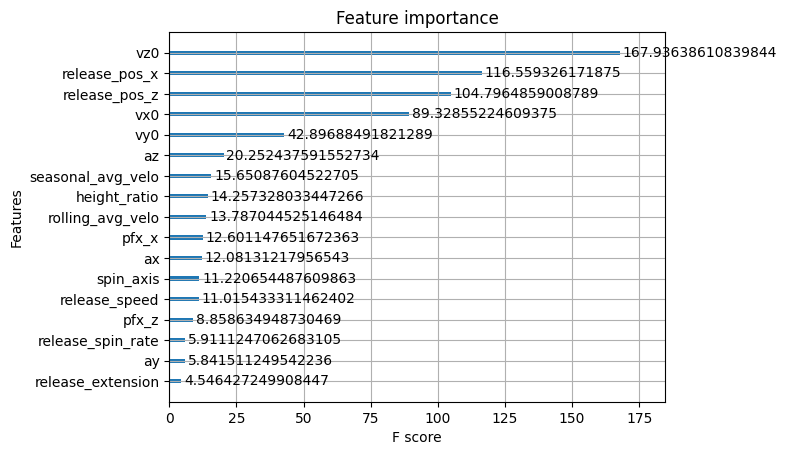

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

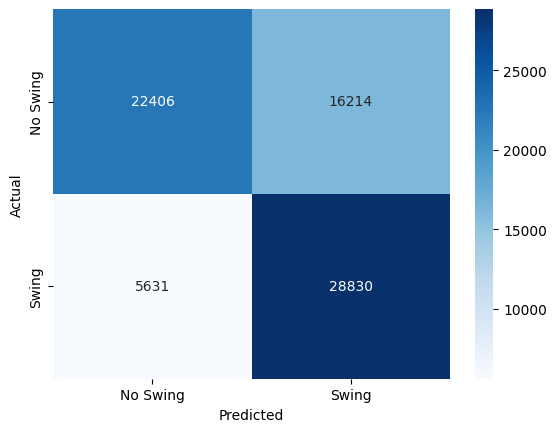

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xswing'] = y_pred

In [26]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")

Number of NaNs in 'xswing': 0


In [27]:
len(testing_identifiers)

702145

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/swing_2022&3_xswing.csv")